In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [24]:
from skimage.feature import local_binary_pattern

def lbp_transform(x):
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'

    imgUMat = np.uint8(np.array(x))

    lbp = local_binary_pattern(imgUMat, n_points, radius, method=METHOD)
    lbp = np.uint8(lbp)
    
    return lbp

In [25]:
from skimage.feature import hog

def hog_transform(x):
    imgUMat = np.uint8(np.array(x))
    
    gx = cv2.Sobel(imgUMat,cv2.CV_32F,1,0,ksize=3)
    gy = cv2.Sobel(imgUMat,cv2.CV_32F,0,1,ksize=3)

    mag, ang = cv2.cartToPolar(gx, gy)


    
#     _, mag = hog(imgUMat, orientations=9, pixels_per_cell=(8, 8), 
#                     cells_per_block=(2, 2), visualize=True, multichannel=False)
    
    hg = np.uint8(mag)
    
    return hg

In [5]:
def combine_lbp_hog(x):
    imgUMat = np.uint8(np.array(x))
    hg = hog_transform(x)
    lbp = lbp_transform(x)
    
#     print('gray: ', imgUMat)
#     print('hg: ', hg)
#     print('lbp: ', lbp)

#     print(lbp)
    
#     print()


    cimg = np.stack((imgUMat, hg, lbp), axis=2)
#     cimg = cimg / 3
    
#     cimg = np.uint8(cimg)
    
    
#     cimg = (np.dstack((imgUMat, hg, lbp)) * 255.999) .astype(np.uint8)
    
    return cimg

In [29]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Lambda(detect_face),
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
        transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=180),
        transforms.Resize((48,48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

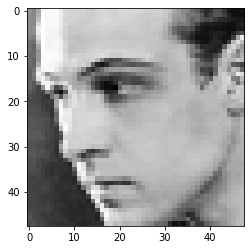

In [31]:
images, _ = next(iter(train_loader))

img = images[0].numpy().squeeze(0)

plt.imshow(img, cmap='gray')

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



In [28]:
def detect_face(img):
    
    img = np.uint8(np.array(img))
    faces = face_cascade.detectMultiScale(img)
    
    if len(faces) == 0:
        return np.uint8(img)
    
    else:
        
        x,y,w,h = faces[0]
        roi = img[y:y+h, x:x+w]
        
        return np.uint8(roi)

[[0.7372549  0.6745098  0.4862745  ... 0.6901961  0.7254902  0.7254902 ]
 [0.7411765  0.6156863  0.49411765 ... 0.61960787 0.72156864 0.72156864]
 [0.7294118  0.5882353  0.49019608 ... 0.47058824 0.69803923 0.7176471 ]
 ...
 [0.28627452 0.32156864 0.19215687 ... 0.23529412 0.1882353  0.20392157]
 [0.23529412 0.27058825 0.16470589 ... 0.23529412 0.18039216 0.20784314]
 [0.23137255 0.27058825 0.16862746 ... 0.2509804  0.2        0.23137255]]


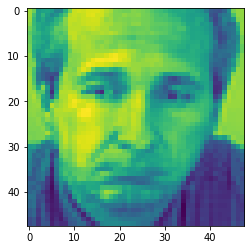

[[ 4  4 39 39]]


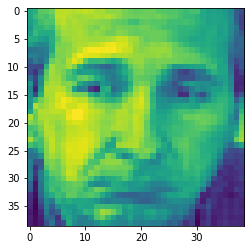

In [37]:
images, _ = next(iter(train_loader))

img = images[0].numpy().squeeze(0)
print(img)
img = np.uint8(img*255)

plt.imshow(img)
plt.show()
faces = face_cascade.detectMultiScale(img)
print(faces)
for (x,y,w,h) in faces:
    roi_color = img[y:y+h, x:x+w]
    plt.imshow(roi_color)
plt.show()

In [4]:
class WeightFeature(nn.Module):

    def __init__(self, feature_depth, target_depth):
        super(WeightFeature, self).__init__()

        self.target_depth = target_depth
#         self.conv1 = nn.Conv2d(feature_depth, feature_depth, kernel_size=feature_size, padding=0)
#         self.bn = nn.BatchNorm2d(feature_depth)
        self.fc1 = nn.Linear(feature_depth, target_depth)
        self.bn1 = nn.BatchNorm1d(target_depth)
        self.bn2 = nn.BatchNorm2d(target_depth)
        
    def forward(self, x1, x2):
        '''
        x1 -> GAP -> FC -> * with x2-> x2 --> out
        x2 ----------------------------|
        '''
        x1 = nn.AvgPool2d(kernel_size=(x1.size(-2), x1.size(-1)))(x1)
        x1 = nn.Flatten()(x1)

        x1 = self.fc1(x1)
#         x1 = nn.Dropout(0.6)(x1)
        x1 = self.bn1(x1)
        x1 = nn.Sigmoid()(x1)
#         x1 = nn.ReLU()(x1)
        x1 = x1.unsqueeze(-1).unsqueeze(-1)
        # print(x1.size())
        # x2 = self.conv1(x2)

        x_out = torch.mul(x2, x1)
        x_out = x_out + x2 
        x_out = self.bn2(x_out)

        return x_out

In [5]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()
        
        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
#         self.feature_size = kwargs['feature_size']

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv4 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.wf1 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf2 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf3 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        self.bn4 = nn.BatchNorm2d(nb_neurons)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        '''
        x: single output layer of list 
        '''

        x = torch.cat(x, dim=1) if type(x) is list else x

        # 1st
        x = self.conv1(x)
        x = self.bn1(x)
        x_res_1 = self.relu(x)

        # 2nd
        x = self.conv2(x_res_1)
        x = self.bn2(x)
        x_res_2 = self.relu(x)
        
        x_res_2 = self.wf1(x_res_1, x_res_2)

        # 3rd
        x = self.conv3(x_res_2)
        x = self.bn3(x)
        x_res_3 = self.relu(x)
        
        x_res_3 = self.wf2(x_res_2, x_res_3)
        
        x = self.conv4(x_res_3)
        x = self.bn4(x)
        x_res_4 = self.relu(x)
        
        x_out = self.wf3(x_res_3, x_res_4)     

        return x_out

In [6]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()
        
        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
#         self.feature_size = kwargs['feature_size']

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.preconv4 = nn.Conv2d(3*nb_neurons, nb_neurons, kernel_size=1, stride=1, padding=0)
        self.prebn4 = nn.BatchNorm2d(nb_neurons)
#         self.conv4 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.wf12_3 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf12_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf13_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf23_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
#         self.bn4 = nn.BatchNorm2d(nb_neurons)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        '''
        x: single output layer of list 
        '''

        x = torch.cat(x, dim=1) if type(x) is list else x

        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = self.relu(x2)
        
        # 1,2 -> 3
        x12_3 = self.wf12_3(x1, x2)

        # 3rd
        x3 = self.conv3(x12_3)
        x3 = self.bn3(x3)
        x3 = self.relu(x3)
        
        # 1,2 -> 4
        # 1,3 -> 4
        # 2,3 -> 4
        x12_4 = self.wf12_4(x1, x2)
        x13_4 = self.wf13_4(x1, x3)
        x23_4 = self.wf23_4(x2, x3)
        
        x4 = torch.cat([x12_4, x13_4, x23_4], dim=1)
        x4 = self.preconv4(x4)
        x4 = self.prebn4(x4)
        x_out = nn.ReLU()(x4)
        
        
#         # 4th
#         x = self.conv4(x4)
#         x = self.bn4(x)
#         x4 = self.relu(x)   
        

        return x_out

In [7]:
class SVGG(nn.Module):

    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1,64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)


        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x0 = self.sv0(x)
        x0 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x0)
        
        x1 = self.sv1(x0)
        x1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x1)
        
        x2 = self.sv2(x1)
        x2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x2)
        
        x3 = self.sv3(x2)
        x3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x3)
        
        x4 = self.sv4(x3)
        x4 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x4)
        
        x4 = nn.AvgPool2d(kernel_size=(x4.size(-2), x4.size(-1)))(x4)
        x_out = nn.Flatten()(x4)

        x_out = self.fc1(x_out)
        x_out = self.bn1(x_out)
        x_out = self.fc2(x_out)
        x_out = self.bn2(x_out)

        return x_out


In [8]:
model = torch.load('/tf/data/Quan/fer2013/att_vgg_1.pt')
# model = model.cpu()

In [9]:
model

SVGG(
  (sv0): SVblock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (wf1): WeightFeature(
      (conv1): Conv2d(64, 64, kernel_size=(48, 48), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (wf2): WeightFeature(
      (conv1): Conv2d(64, 64, kernel_size=(48, 48), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0

In [178]:
model_children = list(model.children())
model_children[-6]

SVblock(
  (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (wf1): WeightFeature(
    (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=1024, out_features=1024, bias=True)
    (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (wf2): WeightFeature(
    (conv1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=1024, out_features=1024, bias=True)
    (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=

In [28]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == SVblock:
        _children = list(model_children[i].children())
        for child in _children:
            
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 15


In [29]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 1, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 64, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([128, 128, 3, 3])
CONV: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 128, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: torch.Size([256, 256, 3, 3])
CONV: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) ====> SHAPE: t

In [33]:
model = model.cpu()

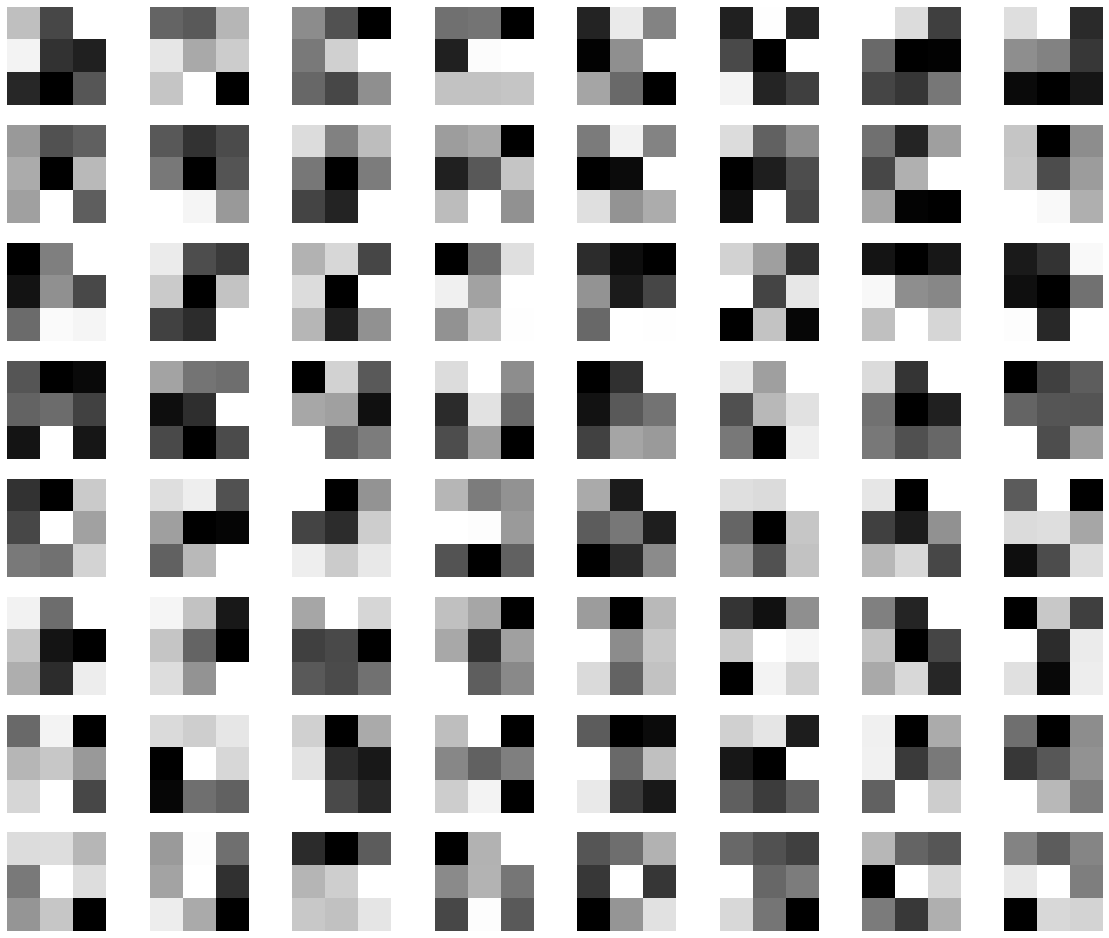

In [38]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
#     plt.savefig('../outputs/filter.png')
plt.show()

In [15]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [16]:
gradients = {}
def get_gradient(name):
    def hook(model, in_grad, out_grad):
        gradients[name] = out_grad
        
    return hook

In [17]:
model = torch.load('/tf/data/Quan/fer2013/att_vgg_demo.pt')
model = model.cpu()
model.eval()

model.sv3.relu.register_forward_hook(get_activation('last_conv'))
model.sv3.relu.register_backward_hook(get_gradient('last_conv'))

In [49]:
images, labels = next(iter(train_loader))

img = images[0]
lb = labels[0]

In [438]:
output = model(img.unsqueeze(0))
output[:,lb].backward()

# get gradient
grads = gradients['last_conv'][0]
pooled_grads = torch.mean(grads, dim=[0, 2, 3])
print(pooled_grads.size())

# get activation
features = activation['last_conv']
print(features.size())

# weight the channels by corresponding gradients
for i in range(features.size(1)):
    features[:, i, :, :] *= pooled_grads[i]

torch.Size([512])
torch.Size([1, 512, 6, 6])


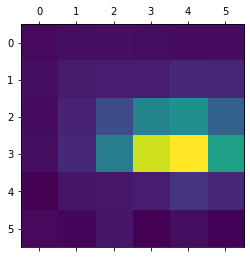

In [439]:
# average the channels of the activations
heatmap = torch.mean(features, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [440]:
img = img.numpy()[0]
img = np.stack((img,)*3, axis=-1)
heatmap = heatmap.numpy()

In [451]:

import cv2

heatmap = cv2.resize(heatmap, (48,48))
heatmap = np.uint8(255 * heatmap)
# img = np.uint8(255*img)
# print(heatmap.shape)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
print(heatmap.shape)
superimposed_img = heatmap * 0.1 + img
# cv2.imwrite('./map.jpg', superimposed_img)

(48, 48, 3)


In [21]:
import cv2

def attention(model, img, lb):
    output = model(img.unsqueeze(0))
    
    pred_lb = int(output.argmax(1)[0])
    output[:,lb].backward()

    # get gradient
    grads = gradients['last_conv'][0]
    
    # !!! 2 options
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))

    # get activation
    features = activation['last_conv']
#     print(features.size())

    # weight the channels by corresponding gradients
    for i in range(features.size(1)):
        features[:, i, :, :] *= pooled_grads[i]
        
    # average the channels of the activations
    heatmap = torch.mean(features, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    
    img = img.numpy()[0]
    img = np.stack((img,)*3, axis=-1)
    heatmap = heatmap.numpy()


    heatmap = cv2.resize(heatmap, (48,48))
    heatmap = np.uint8(255 * heatmap)
    
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * 0.008 + img
    
    superimposed_img /= np.max(superimposed_img)
    
    return superimposed_img, pred_lb, int(lb)
    
#     print(np.max(superimposed_img), np.min(superimposed_img))
    
#     plt.imshow(superimposed_img)
#     plt.title('pred: ' + str(pred_lb) + ' | truth: ' + str(int(lb)))
#     plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

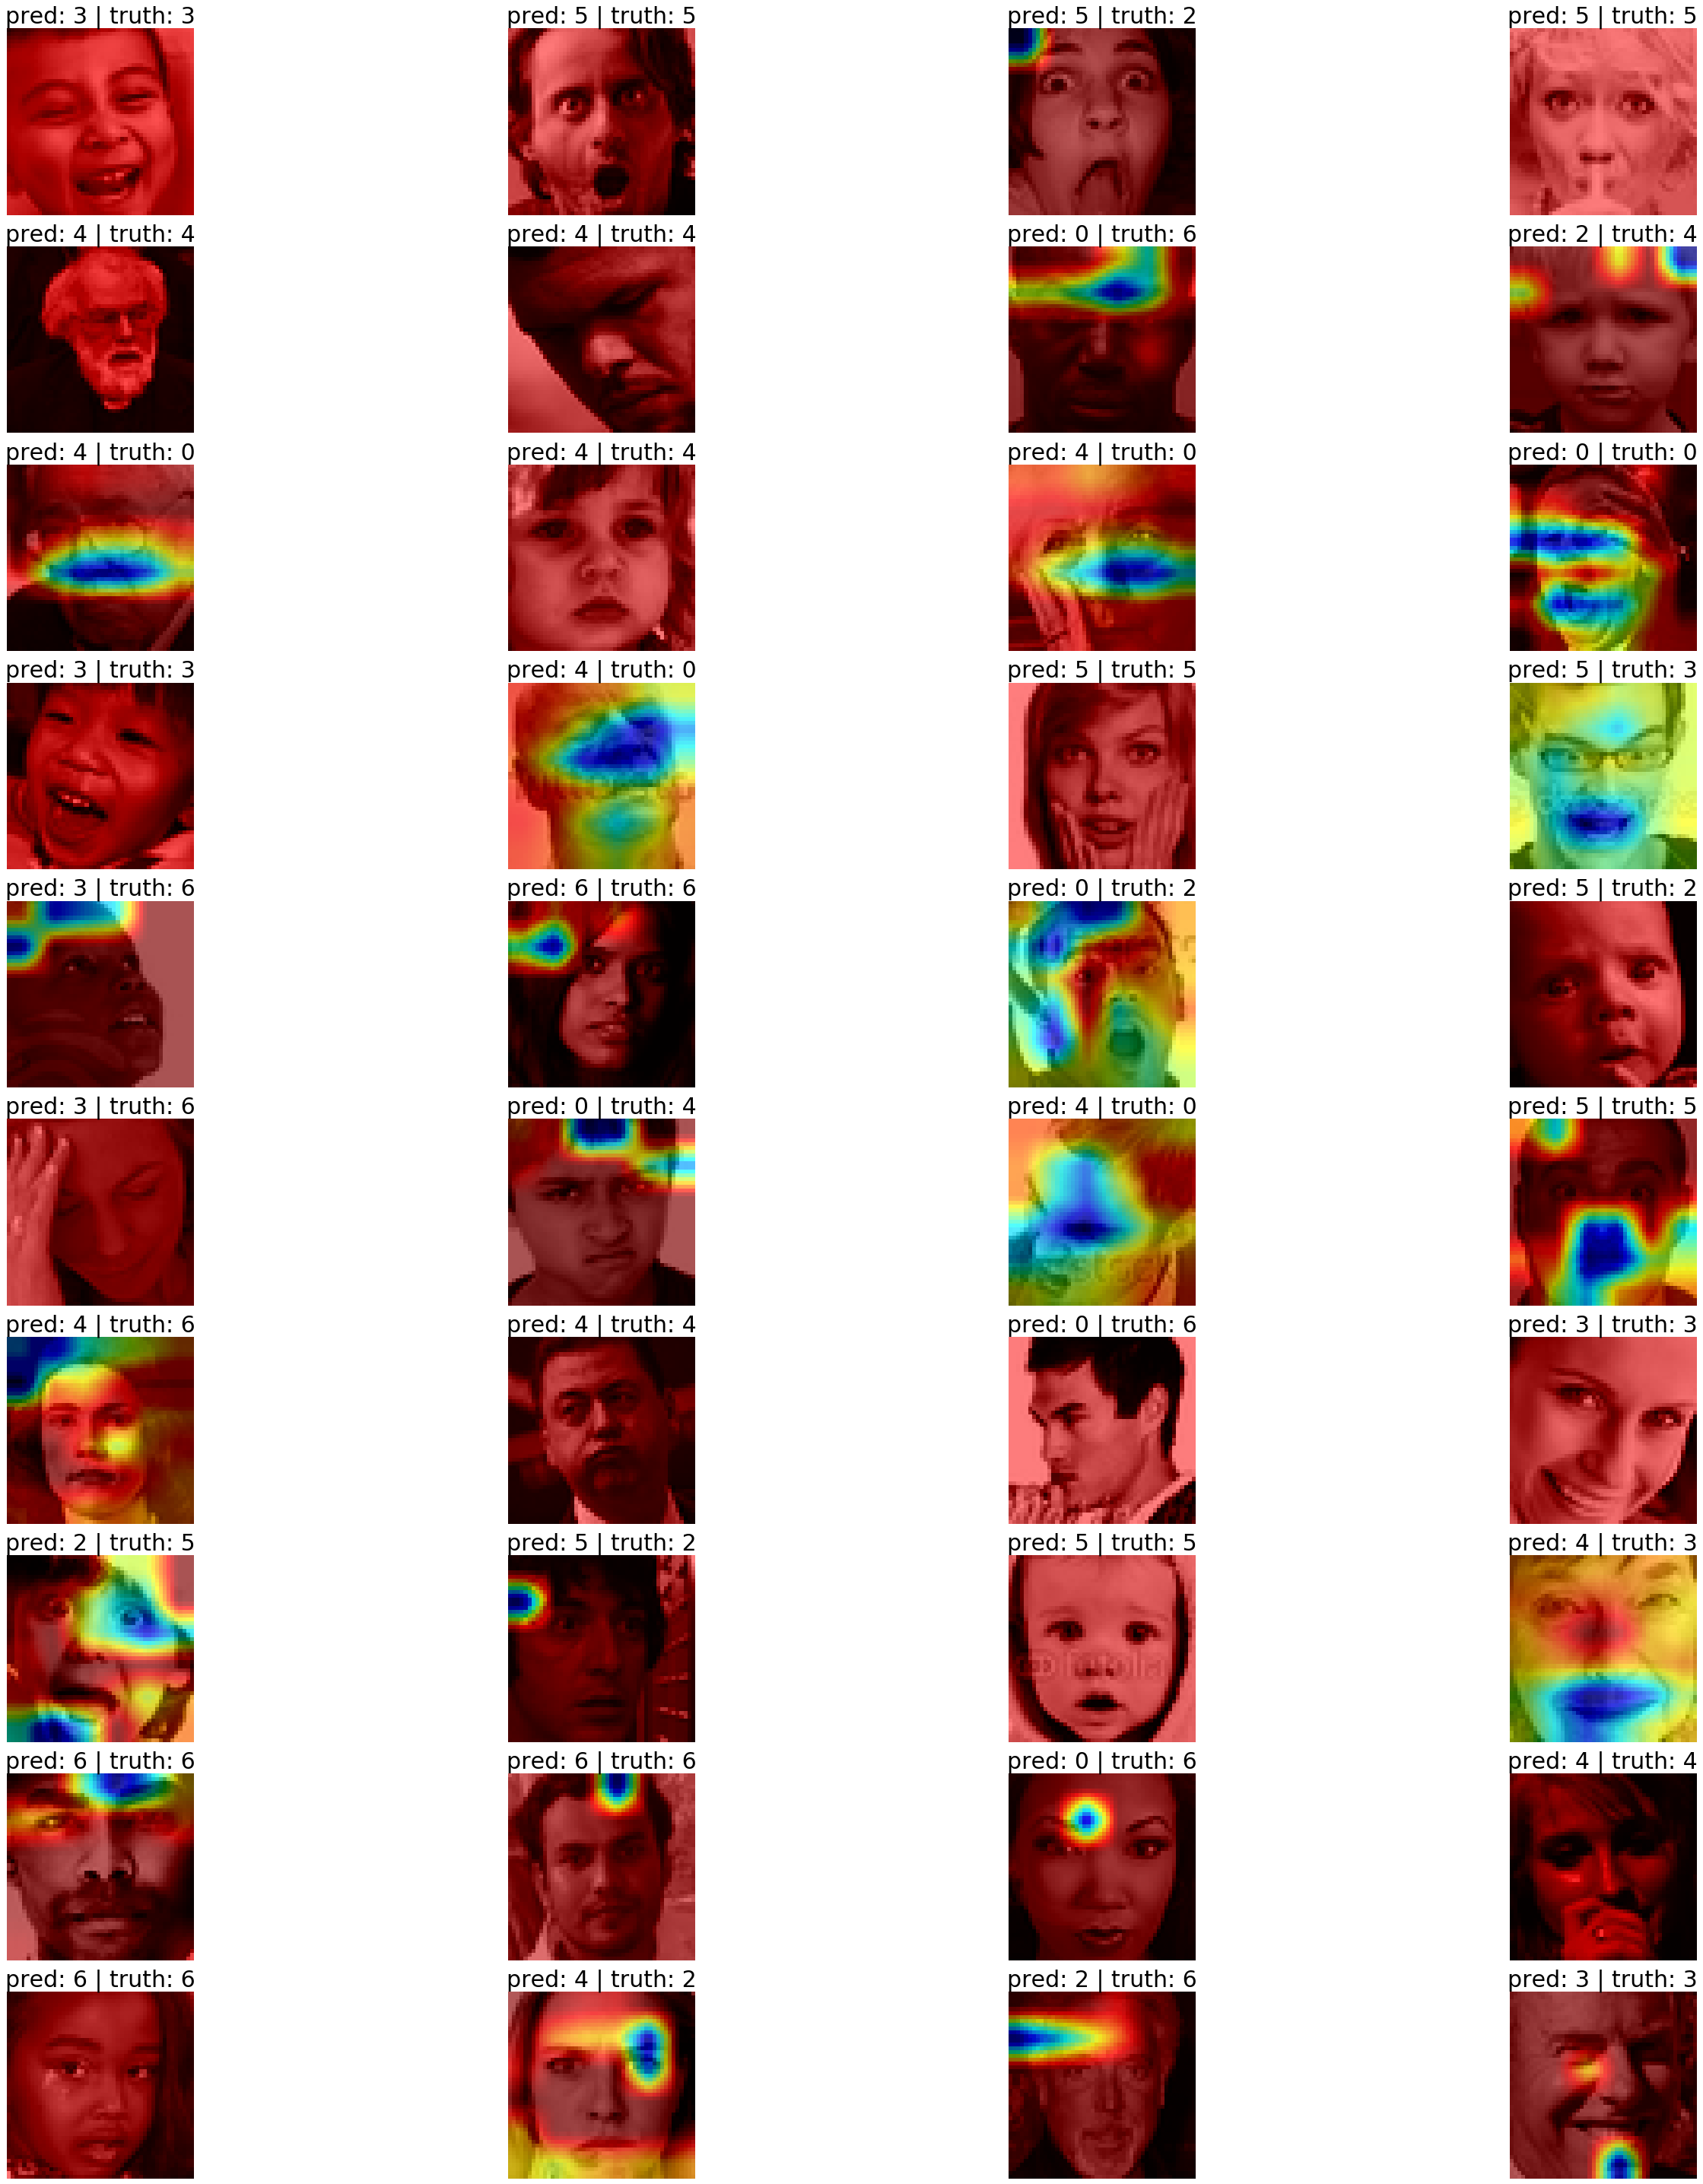

In [28]:
images, labels = next(iter(test_loader))
# rows = len(labels) // 4 + 1
rows = 10
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(40,40))


id = 0

for i in range(rows):
    for j in range(cols):
        try:
            map, pred, truth = attention(model, images[id], labels[id])
            axs[i,j].imshow(map)
            axs[i,j].set_title('pred: ' + str(pred) + ' | truth: ' + str(truth), size=30)
            axs[i,j].axis('off')
            id = id + 1
        except:
            break

plt.tight_layout()
plt.show()

In [12]:
model = torch.load('/tf/data/Quan/fer2013/att_vgg_demo.pt')

criterion = nn.CrossEntropyLoss()
model = model.cuda()
device = torch.device('cuda')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0

for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)
    
#     print(acc)
    
#     print(acc)

    running_valloss += loss.item()
    running_valacc += acc

    #     scheduler.step()

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 1.084  | Avg. val_acc: 0.634


In [11]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# model.train()

# model = model.to(device)

cuda


In [ ]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_demo.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.352 acc: 0.148
	 - Step 2: loss: 2.252 acc: 0.148
	 - Step 3: loss: 2.191 acc: 0.250
	 - Step 4: loss: 2.176 acc: 0.250
	 - Step 5: loss: 2.203 acc: 0.156
	 - Step 6: loss: 2.211 acc: 0.148
	 - Step 7: loss: 2.240 acc: 0.211
	 - Step 8: loss: 2.028 acc: 0.172
	 - Step 9: loss: 2.086 acc: 0.148
	 - Step 10: loss: 2.084 acc: 0.234
	 - Step 11: loss: 2.136 acc: 0.188
	 - Step 12: loss: 2.072 acc: 0.148
	 - Step 13: loss: 2.075 acc: 0.234
	 - Step 14: loss: 2.134 acc: 0.211
	 - Step 15: loss: 2.218 acc: 0.195
	 - Step 16: loss: 2.025 acc: 0.242
	 - Step 17: loss: 2.120 acc: 0.156
	 - Step 18: loss: 2.007 acc: 0.164
	 - Step 19: loss: 1.933 acc: 0.211
	 - Step 20: loss: 2.030 acc: 0.211
	 - Step 21: loss: 2.191 acc: 0.133
	 - Step 22: loss: 2.059 acc: 0.211
	 - Step 23: loss: 1.937 acc: 0.188
	 - Step 24: loss: 2.030 acc: 0.242
	 - Step 25: loss: 2.120 acc: 0.234
	 - Step 26: loss: 2.017 acc: 0.242
	 - Step 27: loss: 2.058 acc: 0.273
	 - Step 28: loss: 2.075 ac

- Avg. val_loss: 1.487  | Avg. val_acc: 0.460


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.464 acc: 0.453
	 - Step 2: loss: 1.481 acc: 0.359
	 - Step 3: loss: 1.383 acc: 0.578
	 - Step 4: loss: 1.572 acc: 0.398
	 - Step 5: loss: 1.455 acc: 0.422
	 - Step 6: loss: 1.402 acc: 0.492
	 - Step 7: loss: 1.444 acc: 0.430
	 - Step 8: loss: 1.338 acc: 0.547
	 - Step 9: loss: 1.497 acc: 0.438
	 - Step 10: loss: 1.461 acc: 0.406
	 - Step 11: loss: 1.477 acc: 0.445
	 - Step 12: loss: 1.455 acc: 0.469
	 - Step 13: loss: 1.482 acc: 0.445
	 - Step 14: loss: 1.524 acc: 0.516
	 - Step 15: loss: 1.627 acc: 0.336
	 - Step 16: loss: 1.483 acc: 0.445
	 - Step 17: loss: 1.510 acc: 0.469
	 - Step 18: loss: 1.450 acc: 0.500
	 - Step 19: loss: 1.598 acc: 0.406
	 - Step 20: loss: 1.435 acc: 0.461
	 - Step 21: loss: 1.565 acc: 0.406
	 - Step 22: loss: 1.402 acc: 0.523
	 - Step 23: loss: 1.387 acc: 0.516
	 - Step 24: loss: 1.414 acc: 0.453
	 - Step 25: loss: 1.532 acc: 0.453
	 - Step 26: loss: 1.421 acc: 0.508
	 - Step 27: loss: 1.448 acc: 0.453
	 - 

	 - Step 225: loss: 1.380 acc: 0.405
- Avg.loss: 1.371  | Avg.acc: 0.493
- Avg. val_loss: 1.427  | Avg. val_acc: 0.461
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.230 acc: 0.594
	 - Step 2: loss: 1.314 acc: 0.492
	 - Step 3: loss: 1.295 acc: 0.531
	 - Step 4: loss: 1.415 acc: 0.453
	 - Step 5: loss: 1.205 acc: 0.547
	 - Step 6: loss: 1.257 acc: 0.547
	 - Step 7: loss: 1.427 acc: 0.438
	 - Step 8: loss: 1.193 acc: 0.578
	 - Step 9: loss: 1.223 acc: 0.523
	 - Step 10: loss: 1.213 acc: 0.594
	 - Step 11: loss: 1.410 acc: 0.500
	 - Step 12: loss: 1.160 acc: 0.609
	 - Step 13: loss: 1.304 acc: 0.516
	 - Step 14: loss: 1.218 acc: 0.586
	 - Step 15: loss: 1.279 acc: 0.555
	 - Step 16: loss: 1.294 acc: 0.523
	 - Step 17: loss: 1.331 acc: 0.516
	 - Step 18: loss: 1.172 acc: 0.555
	 - Step 19: loss: 1.312 acc: 0.516
	 - Step 20: loss: 1.308 acc: 0.523
	 - Step 21: loss: 1.416 acc: 0.461
	 - Step 22: loss: 1.267 acc: 0.523
	 - Step 23: loss: 1.213 acc: 0.609
	 - Step 24: loss: 1.277 acc:

	 - Step 223: loss: 1.143 acc: 0.586
	 - Step 224: loss: 1.304 acc: 0.570
	 - Step 225: loss: 1.361 acc: 0.459
- Avg.loss: 1.229  | Avg.acc: 0.552
- Avg. val_loss: 1.258  | Avg. val_acc: 0.523
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.153 acc: 0.547
	 - Step 2: loss: 1.116 acc: 0.562
	 - Step 3: loss: 1.064 acc: 0.656
	 - Step 4: loss: 1.142 acc: 0.578
	 - Step 5: loss: 1.176 acc: 0.555
	 - Step 6: loss: 1.233 acc: 0.539
	 - Step 7: loss: 1.196 acc: 0.547
	 - Step 8: loss: 1.289 acc: 0.523
	 - Step 9: loss: 1.089 acc: 0.617
	 - Step 10: loss: 1.210 acc: 0.609
	 - Step 11: loss: 1.143 acc: 0.562
	 - Step 12: loss: 1.042 acc: 0.602
	 - Step 13: loss: 1.113 acc: 0.625
	 - Step 14: loss: 1.108 acc: 0.617
	 - Step 15: loss: 1.189 acc: 0.555
	 - Step 16: loss: 1.195 acc: 0.547
	 - Step 17: loss: 1.068 acc: 0.609
	 - Step 18: loss: 1.164 acc: 0.609
	 - Step 19: loss: 1.308 acc: 0.562
	 - Step 20: loss: 1.152 acc: 0.578
	 - Step 21: loss: 1.147 acc: 0.562
	 - Step 22: loss: 1.287 ac

	 - Step 221: loss: 1.203 acc: 0.523
	 - Step 222: loss: 1.100 acc: 0.625
	 - Step 223: loss: 1.071 acc: 0.602
	 - Step 224: loss: 1.182 acc: 0.555
	 - Step 225: loss: 1.167 acc: 0.622
- Avg.loss: 1.144  | Avg.acc: 0.584
- Avg. val_loss: 1.195  | Avg. val_acc: 0.554
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.243 acc: 0.523
	 - Step 2: loss: 1.107 acc: 0.570
	 - Step 3: loss: 1.048 acc: 0.594
	 - Step 4: loss: 1.266 acc: 0.555
	 - Step 5: loss: 1.116 acc: 0.617
	 - Step 6: loss: 1.215 acc: 0.547
	 - Step 7: loss: 1.232 acc: 0.562
	 - Step 8: loss: 1.028 acc: 0.648
	 - Step 9: loss: 0.963 acc: 0.656
	 - Step 10: loss: 1.119 acc: 0.555
	 - Step 11: loss: 1.055 acc: 0.617
	 - Step 12: loss: 1.098 acc: 0.602
	 - Step 13: loss: 1.084 acc: 0.625
	 - Step 14: loss: 1.011 acc: 0.680
	 - Step 15: loss: 1.105 acc: 0.555
	 - Step 16: loss: 0.950 acc: 0.656
	 - Step 17: loss: 0.845 acc: 0.734
	 - Step 18: loss: 1.073 acc: 0.578
	 - Step 19: loss: 1.036 acc: 0.633
	 - Step 20: loss: 1.124 

	 - Step 219: loss: 0.963 acc: 0.648
	 - Step 220: loss: 0.999 acc: 0.703
	 - Step 221: loss: 1.265 acc: 0.555
	 - Step 222: loss: 0.964 acc: 0.664
	 - Step 223: loss: 1.034 acc: 0.656
	 - Step 224: loss: 1.133 acc: 0.570
	 - Step 225: loss: 1.259 acc: 0.541
- Avg.loss: 1.087  | Avg.acc: 0.608
- Avg. val_loss: 1.171  | Avg. val_acc: 0.564
* Update optimal model
Epoch:  6
	 - Step 1: loss: 0.875 acc: 0.672
	 - Step 2: loss: 0.978 acc: 0.617
	 - Step 3: loss: 1.009 acc: 0.625
	 - Step 4: loss: 1.138 acc: 0.609
	 - Step 5: loss: 1.046 acc: 0.633
	 - Step 6: loss: 1.061 acc: 0.648
	 - Step 7: loss: 1.133 acc: 0.586
	 - Step 8: loss: 1.073 acc: 0.594
	 - Step 9: loss: 1.032 acc: 0.625
	 - Step 10: loss: 1.020 acc: 0.695
	 - Step 11: loss: 1.103 acc: 0.570
	 - Step 12: loss: 0.966 acc: 0.664
	 - Step 13: loss: 0.988 acc: 0.664
	 - Step 14: loss: 1.049 acc: 0.664
	 - Step 15: loss: 1.088 acc: 0.594
	 - Step 16: loss: 0.956 acc: 0.633
	 - Step 17: loss: 1.003 acc: 0.633
	 - Step 18: loss: 0.98

	 - Step 217: loss: 1.018 acc: 0.625
	 - Step 218: loss: 1.104 acc: 0.602
	 - Step 219: loss: 1.081 acc: 0.594
	 - Step 220: loss: 1.000 acc: 0.641
	 - Step 221: loss: 1.261 acc: 0.531
	 - Step 222: loss: 1.010 acc: 0.609
	 - Step 223: loss: 1.150 acc: 0.625
	 - Step 224: loss: 0.961 acc: 0.656
	 - Step 225: loss: 0.966 acc: 0.676
- Avg.loss: 1.040  | Avg.acc: 0.625
- Avg. val_loss: 1.179  | Avg. val_acc: 0.566
* Update optimal model
Epoch:  7
	 - Step 1: loss: 1.089 acc: 0.641
	 - Step 2: loss: 1.143 acc: 0.602
	 - Step 3: loss: 0.968 acc: 0.641
	 - Step 4: loss: 0.951 acc: 0.641
	 - Step 5: loss: 0.974 acc: 0.594
	 - Step 6: loss: 1.019 acc: 0.602
	 - Step 7: loss: 1.044 acc: 0.594
	 - Step 8: loss: 1.008 acc: 0.672
	 - Step 9: loss: 0.972 acc: 0.656
	 - Step 10: loss: 0.841 acc: 0.719
	 - Step 11: loss: 1.069 acc: 0.602
	 - Step 12: loss: 0.922 acc: 0.656
	 - Step 13: loss: 1.026 acc: 0.633
	 - Step 14: loss: 0.955 acc: 0.664
	 - Step 15: loss: 0.987 acc: 0.672
	 - Step 16: loss: 0.

	 - Step 215: loss: 0.856 acc: 0.711
	 - Step 216: loss: 0.930 acc: 0.703
	 - Step 217: loss: 1.055 acc: 0.578
	 - Step 218: loss: 0.939 acc: 0.664
	 - Step 219: loss: 0.904 acc: 0.695
	 - Step 220: loss: 1.095 acc: 0.609
	 - Step 221: loss: 1.057 acc: 0.633
	 - Step 222: loss: 1.088 acc: 0.617
	 - Step 223: loss: 0.985 acc: 0.625
	 - Step 224: loss: 0.808 acc: 0.734
	 - Step 225: loss: 1.104 acc: 0.622
- Avg.loss: 1.008  | Avg.acc: 0.638
- Avg. val_loss: 1.179  | Avg. val_acc: 0.561
Epoch:  8
	 - Step 1: loss: 1.011 acc: 0.633
	 - Step 2: loss: 0.939 acc: 0.656
	 - Step 3: loss: 0.924 acc: 0.688
	 - Step 4: loss: 1.091 acc: 0.617
	 - Step 5: loss: 0.964 acc: 0.680
	 - Step 6: loss: 0.958 acc: 0.664
	 - Step 7: loss: 0.900 acc: 0.695
	 - Step 8: loss: 0.931 acc: 0.688
	 - Step 9: loss: 1.107 acc: 0.555
	 - Step 10: loss: 0.944 acc: 0.656
	 - Step 11: loss: 0.869 acc: 0.703
	 - Step 12: loss: 0.996 acc: 0.617
	 - Step 13: loss: 1.052 acc: 0.578
	 - Step 14: loss: 1.111 acc: 0.609
	 - St

	 - Step 213: loss: 0.925 acc: 0.680
	 - Step 214: loss: 0.994 acc: 0.695
	 - Step 215: loss: 0.978 acc: 0.672
	 - Step 216: loss: 1.024 acc: 0.648
	 - Step 217: loss: 0.993 acc: 0.625
	 - Step 218: loss: 1.088 acc: 0.570
	 - Step 219: loss: 0.978 acc: 0.633
	 - Step 220: loss: 0.916 acc: 0.672
	 - Step 221: loss: 0.894 acc: 0.680
	 - Step 222: loss: 1.075 acc: 0.625
	 - Step 223: loss: 0.973 acc: 0.602
	 - Step 224: loss: 0.796 acc: 0.727
	 - Step 225: loss: 0.755 acc: 0.811
- Avg.loss: 0.970  | Avg.acc: 0.651
- Avg. val_loss: 1.178  | Avg. val_acc: 0.563
Epoch:  9
	 - Step 1: loss: 0.857 acc: 0.703
	 - Step 2: loss: 0.954 acc: 0.664
	 - Step 3: loss: 0.829 acc: 0.695
	 - Step 4: loss: 0.835 acc: 0.695
	 - Step 5: loss: 0.892 acc: 0.617
	 - Step 6: loss: 0.757 acc: 0.742
	 - Step 7: loss: 0.752 acc: 0.711
	 - Step 8: loss: 0.880 acc: 0.703
	 - Step 9: loss: 0.952 acc: 0.672
	 - Step 10: loss: 0.836 acc: 0.742
	 - Step 11: loss: 0.821 acc: 0.695
	 - Step 12: loss: 0.935 acc: 0.664
	 - 

	 - Step 211: loss: 0.977 acc: 0.672
	 - Step 212: loss: 0.909 acc: 0.656
	 - Step 213: loss: 1.010 acc: 0.633
	 - Step 214: loss: 1.082 acc: 0.625
	 - Step 215: loss: 0.838 acc: 0.703
	 - Step 216: loss: 0.998 acc: 0.625
	 - Step 217: loss: 0.888 acc: 0.664
	 - Step 218: loss: 1.075 acc: 0.617
	 - Step 219: loss: 0.804 acc: 0.703
	 - Step 220: loss: 0.936 acc: 0.680
	 - Step 221: loss: 1.111 acc: 0.586
	 - Step 222: loss: 0.918 acc: 0.648
	 - Step 223: loss: 0.872 acc: 0.688
	 - Step 224: loss: 1.128 acc: 0.625
	 - Step 225: loss: 0.989 acc: 0.622
- Avg.loss: 0.933  | Avg.acc: 0.666
- Avg. val_loss: 1.082  | Avg. val_acc: 0.612
* Update optimal model
Epoch:  10
	 - Step 1: loss: 0.874 acc: 0.703
	 - Step 2: loss: 0.859 acc: 0.695
	 - Step 3: loss: 0.787 acc: 0.742
	 - Step 4: loss: 0.892 acc: 0.656
	 - Step 5: loss: 1.017 acc: 0.617
	 - Step 6: loss: 0.823 acc: 0.734
	 - Step 7: loss: 0.747 acc: 0.711
	 - Step 8: loss: 0.890 acc: 0.711
	 - Step 9: loss: 0.813 acc: 0.719
	 - Step 10: l

	 - Step 209: loss: 1.038 acc: 0.656
	 - Step 210: loss: 0.816 acc: 0.742
	 - Step 211: loss: 0.935 acc: 0.648
	 - Step 212: loss: 1.020 acc: 0.641
	 - Step 213: loss: 0.994 acc: 0.656
	 - Step 214: loss: 0.905 acc: 0.680
	 - Step 215: loss: 0.959 acc: 0.641
	 - Step 216: loss: 0.983 acc: 0.625
	 - Step 217: loss: 0.997 acc: 0.664
	 - Step 218: loss: 0.969 acc: 0.680
	 - Step 219: loss: 0.823 acc: 0.734
	 - Step 220: loss: 0.926 acc: 0.695
	 - Step 221: loss: 0.976 acc: 0.664
	 - Step 222: loss: 1.053 acc: 0.578
	 - Step 223: loss: 0.943 acc: 0.656
	 - Step 224: loss: 0.965 acc: 0.602
	 - Step 225: loss: 1.077 acc: 0.649
- Avg.loss: 0.900  | Avg.acc: 0.680
- Avg. val_loss: 1.099  | Avg. val_acc: 0.589
Epoch:  11
	 - Step 1: loss: 0.746 acc: 0.773
	 - Step 2: loss: 0.804 acc: 0.742
	 - Step 3: loss: 0.891 acc: 0.695
	 - Step 4: loss: 0.801 acc: 0.727
	 - Step 5: loss: 0.747 acc: 0.734
	 - Step 6: loss: 0.667 acc: 0.797
	 - Step 7: loss: 0.780 acc: 0.773
	 - Step 8: loss: 0.910 acc: 0.69

	 - Step 207: loss: 0.870 acc: 0.672
	 - Step 208: loss: 0.830 acc: 0.727
	 - Step 209: loss: 0.836 acc: 0.719
	 - Step 210: loss: 0.715 acc: 0.727
	 - Step 211: loss: 0.923 acc: 0.680
	 - Step 212: loss: 0.841 acc: 0.727
	 - Step 213: loss: 0.974 acc: 0.656
	 - Step 214: loss: 0.915 acc: 0.656
	 - Step 215: loss: 0.781 acc: 0.734
	 - Step 216: loss: 0.919 acc: 0.719
	 - Step 217: loss: 0.929 acc: 0.648
	 - Step 218: loss: 0.928 acc: 0.680
	 - Step 219: loss: 0.903 acc: 0.695
	 - Step 220: loss: 0.923 acc: 0.664
	 - Step 221: loss: 0.857 acc: 0.734
	 - Step 222: loss: 0.959 acc: 0.664
	 - Step 223: loss: 0.921 acc: 0.680
	 - Step 224: loss: 0.777 acc: 0.719
	 - Step 225: loss: 0.997 acc: 0.703
- Avg.loss: 0.847  | Avg.acc: 0.704
- Avg. val_loss: 1.056  | Avg. val_acc: 0.618
* Update optimal model
Epoch:  12
	 - Step 1: loss: 0.758 acc: 0.750
	 - Step 2: loss: 0.723 acc: 0.750
	 - Step 3: loss: 0.857 acc: 0.695
	 - Step 4: loss: 0.861 acc: 0.703
	 - Step 5: loss: 0.713 acc: 0.742
	 - St

	 - Step 205: loss: 0.709 acc: 0.766
	 - Step 206: loss: 0.800 acc: 0.719
	 - Step 207: loss: 0.682 acc: 0.742
	 - Step 208: loss: 0.908 acc: 0.656
	 - Step 209: loss: 0.934 acc: 0.695
	 - Step 210: loss: 0.794 acc: 0.711
	 - Step 211: loss: 0.912 acc: 0.648
	 - Step 212: loss: 0.729 acc: 0.758
	 - Step 213: loss: 0.931 acc: 0.625
	 - Step 214: loss: 1.009 acc: 0.633
	 - Step 215: loss: 0.917 acc: 0.688
	 - Step 216: loss: 0.961 acc: 0.664
	 - Step 217: loss: 0.823 acc: 0.742
	 - Step 218: loss: 0.859 acc: 0.680
	 - Step 219: loss: 0.867 acc: 0.680
	 - Step 220: loss: 0.738 acc: 0.750
	 - Step 221: loss: 0.831 acc: 0.727
	 - Step 222: loss: 0.748 acc: 0.742
	 - Step 223: loss: 0.825 acc: 0.711
	 - Step 224: loss: 1.110 acc: 0.625
	 - Step 225: loss: 0.748 acc: 0.730
- Avg.loss: 0.816  | Avg.acc: 0.711
- Avg. val_loss: 1.138  | Avg. val_acc: 0.576
Epoch:  13
	 - Step 1: loss: 0.745 acc: 0.711
	 - Step 2: loss: 0.589 acc: 0.820
	 - Step 3: loss: 0.713 acc: 0.734
	 - Step 4: loss: 0.759 a

	 - Step 203: loss: 0.901 acc: 0.672
	 - Step 204: loss: 0.675 acc: 0.773
	 - Step 205: loss: 0.765 acc: 0.688
	 - Step 206: loss: 0.693 acc: 0.805
	 - Step 207: loss: 0.741 acc: 0.750
	 - Step 208: loss: 0.827 acc: 0.680
	 - Step 209: loss: 0.739 acc: 0.719
	 - Step 210: loss: 0.761 acc: 0.711
	 - Step 211: loss: 0.750 acc: 0.734
	 - Step 212: loss: 0.738 acc: 0.789
	 - Step 213: loss: 0.840 acc: 0.711
	 - Step 214: loss: 0.848 acc: 0.719
	 - Step 215: loss: 0.832 acc: 0.727
	 - Step 216: loss: 0.717 acc: 0.781
	 - Step 217: loss: 0.773 acc: 0.680
	 - Step 218: loss: 0.825 acc: 0.711
	 - Step 219: loss: 0.741 acc: 0.766
	 - Step 220: loss: 0.820 acc: 0.734
	 - Step 221: loss: 0.931 acc: 0.711
	 - Step 222: loss: 0.884 acc: 0.656
	 - Step 223: loss: 0.782 acc: 0.750
	 - Step 224: loss: 0.689 acc: 0.773
	 - Step 225: loss: 0.881 acc: 0.649
- Avg.loss: 0.767  | Avg.acc: 0.732
- Avg. val_loss: 1.094  | Avg. val_acc: 0.620
* Update optimal model
Epoch:  14
	 - Step 1: loss: 0.665 acc: 0.82

	 - Step 201: loss: 0.748 acc: 0.742
	 - Step 202: loss: 0.885 acc: 0.695
	 - Step 203: loss: 0.870 acc: 0.672
	 - Step 204: loss: 0.850 acc: 0.711
	 - Step 205: loss: 0.776 acc: 0.742
	 - Step 206: loss: 0.739 acc: 0.750
	 - Step 207: loss: 0.635 acc: 0.805
	 - Step 208: loss: 0.823 acc: 0.688
	 - Step 209: loss: 0.715 acc: 0.750
	 - Step 210: loss: 0.755 acc: 0.727
	 - Step 211: loss: 0.823 acc: 0.734
	 - Step 212: loss: 0.669 acc: 0.750
	 - Step 213: loss: 0.746 acc: 0.711
	 - Step 214: loss: 0.649 acc: 0.797
	 - Step 215: loss: 0.625 acc: 0.789
	 - Step 216: loss: 0.745 acc: 0.734
	 - Step 217: loss: 0.717 acc: 0.734
	 - Step 218: loss: 0.921 acc: 0.703
	 - Step 219: loss: 0.714 acc: 0.742
	 - Step 220: loss: 0.670 acc: 0.734
	 - Step 221: loss: 0.732 acc: 0.773
	 - Step 222: loss: 0.709 acc: 0.773
	 - Step 223: loss: 0.697 acc: 0.750
	 - Step 224: loss: 0.660 acc: 0.766
	 - Step 225: loss: 0.821 acc: 0.703
- Avg.loss: 0.719  | Avg.acc: 0.753
- Avg. val_loss: 1.103  | Avg. val_acc:

	 - Step 199: loss: 0.790 acc: 0.742
	 - Step 200: loss: 0.765 acc: 0.719
	 - Step 201: loss: 0.705 acc: 0.695
	 - Step 202: loss: 0.781 acc: 0.719
	 - Step 203: loss: 0.848 acc: 0.711
	 - Step 204: loss: 0.741 acc: 0.750
	 - Step 205: loss: 0.752 acc: 0.719
	 - Step 206: loss: 0.724 acc: 0.766
	 - Step 207: loss: 0.799 acc: 0.742
	 - Step 208: loss: 0.684 acc: 0.758
	 - Step 209: loss: 0.766 acc: 0.719
	 - Step 210: loss: 0.717 acc: 0.750
	 - Step 211: loss: 0.622 acc: 0.789
	 - Step 212: loss: 0.807 acc: 0.695
	 - Step 213: loss: 0.831 acc: 0.727
	 - Step 214: loss: 0.732 acc: 0.727
	 - Step 215: loss: 0.900 acc: 0.656
	 - Step 216: loss: 0.710 acc: 0.758
	 - Step 217: loss: 0.622 acc: 0.789
	 - Step 218: loss: 0.637 acc: 0.742
	 - Step 219: loss: 0.800 acc: 0.750
	 - Step 220: loss: 0.715 acc: 0.719
	 - Step 221: loss: 0.606 acc: 0.766
	 - Step 222: loss: 0.815 acc: 0.719
	 - Step 223: loss: 0.716 acc: 0.773
	 - Step 224: loss: 0.758 acc: 0.750
	 - Step 225: loss: 0.933 acc: 0.703
-

	 - Step 197: loss: 0.563 acc: 0.836
	 - Step 198: loss: 0.682 acc: 0.750
	 - Step 199: loss: 0.723 acc: 0.734
	 - Step 200: loss: 0.703 acc: 0.742
	 - Step 201: loss: 0.665 acc: 0.789
	 - Step 202: loss: 0.676 acc: 0.766
	 - Step 203: loss: 0.467 acc: 0.852
	 - Step 204: loss: 0.741 acc: 0.734
	 - Step 205: loss: 0.494 acc: 0.844
	 - Step 206: loss: 0.532 acc: 0.805
	 - Step 207: loss: 0.732 acc: 0.758
	 - Step 208: loss: 0.580 acc: 0.797
	 - Step 209: loss: 0.778 acc: 0.727
	 - Step 210: loss: 0.677 acc: 0.758
	 - Step 211: loss: 0.582 acc: 0.773
	 - Step 212: loss: 0.819 acc: 0.695
	 - Step 213: loss: 0.591 acc: 0.781
	 - Step 214: loss: 0.655 acc: 0.758
	 - Step 215: loss: 0.685 acc: 0.750
	 - Step 216: loss: 0.728 acc: 0.750
	 - Step 217: loss: 0.611 acc: 0.773
	 - Step 218: loss: 0.693 acc: 0.750
	 - Step 219: loss: 0.714 acc: 0.789
	 - Step 220: loss: 0.655 acc: 0.805
	 - Step 221: loss: 0.623 acc: 0.797
	 - Step 222: loss: 0.667 acc: 0.750
	 - Step 223: loss: 0.732 acc: 0.758
	

	 - Step 195: loss: 0.706 acc: 0.773
	 - Step 196: loss: 0.683 acc: 0.750
	 - Step 197: loss: 0.627 acc: 0.820
	 - Step 198: loss: 0.583 acc: 0.797
	 - Step 199: loss: 0.678 acc: 0.773
	 - Step 200: loss: 0.520 acc: 0.828
	 - Step 201: loss: 0.637 acc: 0.781
	 - Step 202: loss: 0.775 acc: 0.703
	 - Step 203: loss: 0.673 acc: 0.758
	 - Step 204: loss: 0.715 acc: 0.750
	 - Step 205: loss: 0.583 acc: 0.766
	 - Step 206: loss: 0.664 acc: 0.773
	 - Step 207: loss: 0.560 acc: 0.844
	 - Step 208: loss: 0.605 acc: 0.789
	 - Step 209: loss: 0.776 acc: 0.750
	 - Step 210: loss: 0.560 acc: 0.820
	 - Step 211: loss: 0.563 acc: 0.812
	 - Step 212: loss: 0.649 acc: 0.805
	 - Step 213: loss: 0.613 acc: 0.820
	 - Step 214: loss: 0.816 acc: 0.719
	 - Step 215: loss: 0.781 acc: 0.750
	 - Step 216: loss: 0.519 acc: 0.852
	 - Step 217: loss: 0.611 acc: 0.789
	 - Step 218: loss: 0.593 acc: 0.797
	 - Step 219: loss: 0.501 acc: 0.836
	 - Step 220: loss: 0.716 acc: 0.727
	 - Step 221: loss: 0.688 acc: 0.742
	

	 - Step 193: loss: 0.530 acc: 0.828
	 - Step 194: loss: 0.528 acc: 0.844
	 - Step 195: loss: 0.533 acc: 0.797
	 - Step 196: loss: 0.691 acc: 0.766
	 - Step 197: loss: 0.638 acc: 0.805
	 - Step 198: loss: 0.433 acc: 0.859
	 - Step 199: loss: 0.488 acc: 0.852
	 - Step 200: loss: 0.514 acc: 0.828
	 - Step 201: loss: 0.455 acc: 0.859
	 - Step 202: loss: 0.584 acc: 0.812
	 - Step 203: loss: 0.662 acc: 0.750
	 - Step 204: loss: 0.535 acc: 0.781
	 - Step 205: loss: 0.711 acc: 0.781
	 - Step 206: loss: 0.508 acc: 0.828
	 - Step 207: loss: 0.521 acc: 0.812
	 - Step 208: loss: 0.615 acc: 0.781
	 - Step 209: loss: 0.551 acc: 0.781
	 - Step 210: loss: 0.424 acc: 0.844
	 - Step 211: loss: 0.451 acc: 0.867
	 - Step 212: loss: 0.573 acc: 0.820
	 - Step 213: loss: 0.625 acc: 0.758
	 - Step 214: loss: 0.601 acc: 0.797
	 - Step 215: loss: 0.448 acc: 0.859
	 - Step 216: loss: 0.587 acc: 0.805
	 - Step 217: loss: 0.489 acc: 0.844
	 - Step 218: loss: 0.603 acc: 0.781
	 - Step 219: loss: 0.643 acc: 0.766
	

	 - Step 191: loss: 0.459 acc: 0.859
	 - Step 192: loss: 0.654 acc: 0.781
	 - Step 193: loss: 0.542 acc: 0.812
	 - Step 194: loss: 0.588 acc: 0.805
	 - Step 195: loss: 0.697 acc: 0.773
	 - Step 196: loss: 0.438 acc: 0.836
	 - Step 197: loss: 0.588 acc: 0.797
	 - Step 198: loss: 0.458 acc: 0.883
	 - Step 199: loss: 0.686 acc: 0.781
	 - Step 200: loss: 0.562 acc: 0.820
	 - Step 201: loss: 0.532 acc: 0.836
	 - Step 202: loss: 0.380 acc: 0.875
	 - Step 203: loss: 0.509 acc: 0.820
	 - Step 204: loss: 0.478 acc: 0.844
	 - Step 205: loss: 0.595 acc: 0.820
	 - Step 206: loss: 0.540 acc: 0.812
	 - Step 207: loss: 0.612 acc: 0.789
	 - Step 208: loss: 0.633 acc: 0.797
	 - Step 209: loss: 0.470 acc: 0.844
	 - Step 210: loss: 0.557 acc: 0.797
	 - Step 211: loss: 0.473 acc: 0.820
	 - Step 212: loss: 0.511 acc: 0.836
	 - Step 213: loss: 0.498 acc: 0.844
	 - Step 214: loss: 0.439 acc: 0.859
	 - Step 215: loss: 0.426 acc: 0.867
	 - Step 216: loss: 0.593 acc: 0.797
	 - Step 217: loss: 0.574 acc: 0.773
	

	 - Step 189: loss: 0.470 acc: 0.844
	 - Step 190: loss: 0.404 acc: 0.867
	 - Step 191: loss: 0.391 acc: 0.898
	 - Step 192: loss: 0.477 acc: 0.844
	 - Step 193: loss: 0.560 acc: 0.828
	 - Step 194: loss: 0.469 acc: 0.805
	 - Step 195: loss: 0.407 acc: 0.875
	 - Step 196: loss: 0.534 acc: 0.812
	 - Step 197: loss: 0.573 acc: 0.812
	 - Step 198: loss: 0.436 acc: 0.844
	 - Step 199: loss: 0.542 acc: 0.844
	 - Step 200: loss: 0.464 acc: 0.828
	 - Step 201: loss: 0.445 acc: 0.867
	 - Step 202: loss: 0.399 acc: 0.867
	 - Step 203: loss: 0.468 acc: 0.844
	 - Step 204: loss: 0.481 acc: 0.836
	 - Step 205: loss: 0.581 acc: 0.805
	 - Step 206: loss: 0.440 acc: 0.883
	 - Step 207: loss: 0.418 acc: 0.852
	 - Step 208: loss: 0.528 acc: 0.781
	 - Step 209: loss: 0.567 acc: 0.750
	 - Step 210: loss: 0.572 acc: 0.828
	 - Step 211: loss: 0.542 acc: 0.820
	 - Step 212: loss: 0.376 acc: 0.875
	 - Step 213: loss: 0.460 acc: 0.836
	 - Step 214: loss: 0.525 acc: 0.828
	 - Step 215: loss: 0.388 acc: 0.867
	

	 - Step 187: loss: 0.376 acc: 0.898
	 - Step 188: loss: 0.532 acc: 0.797
	 - Step 189: loss: 0.638 acc: 0.766
	 - Step 190: loss: 0.512 acc: 0.812
	 - Step 191: loss: 0.540 acc: 0.820
	 - Step 192: loss: 0.330 acc: 0.906
	 - Step 193: loss: 0.511 acc: 0.812
	 - Step 194: loss: 0.432 acc: 0.812
	 - Step 195: loss: 0.380 acc: 0.859
	 - Step 196: loss: 0.388 acc: 0.875
	 - Step 197: loss: 0.582 acc: 0.820
	 - Step 198: loss: 0.370 acc: 0.883
	 - Step 199: loss: 0.465 acc: 0.867
	 - Step 200: loss: 0.317 acc: 0.914
	 - Step 201: loss: 0.371 acc: 0.875
	 - Step 202: loss: 0.528 acc: 0.812
	 - Step 203: loss: 0.392 acc: 0.852
	 - Step 204: loss: 0.517 acc: 0.844
	 - Step 205: loss: 0.387 acc: 0.867
	 - Step 206: loss: 0.429 acc: 0.859
	 - Step 207: loss: 0.620 acc: 0.789
	 - Step 208: loss: 0.424 acc: 0.836
	 - Step 209: loss: 0.443 acc: 0.867
	 - Step 210: loss: 0.514 acc: 0.844
	 - Step 211: loss: 0.556 acc: 0.797
	 - Step 212: loss: 0.365 acc: 0.898
	 - Step 213: loss: 0.499 acc: 0.844
	

	 - Step 185: loss: 0.573 acc: 0.789
	 - Step 186: loss: 0.431 acc: 0.828
	 - Step 187: loss: 0.431 acc: 0.867
	 - Step 188: loss: 0.490 acc: 0.852
	 - Step 189: loss: 0.366 acc: 0.867
	 - Step 190: loss: 0.396 acc: 0.859
	 - Step 191: loss: 0.505 acc: 0.812
	 - Step 192: loss: 0.391 acc: 0.875
	 - Step 193: loss: 0.395 acc: 0.867
	 - Step 194: loss: 0.375 acc: 0.898
	 - Step 195: loss: 0.462 acc: 0.828
	 - Step 196: loss: 0.411 acc: 0.875
	 - Step 197: loss: 0.464 acc: 0.812
	 - Step 198: loss: 0.406 acc: 0.852
	 - Step 199: loss: 0.428 acc: 0.867
	 - Step 200: loss: 0.380 acc: 0.906
	 - Step 201: loss: 0.407 acc: 0.867
	 - Step 202: loss: 0.327 acc: 0.922
	 - Step 203: loss: 0.324 acc: 0.914
	 - Step 204: loss: 0.575 acc: 0.820
	 - Step 205: loss: 0.436 acc: 0.875
	 - Step 206: loss: 0.454 acc: 0.883
	 - Step 207: loss: 0.386 acc: 0.859
	 - Step 208: loss: 0.454 acc: 0.859
	 - Step 209: loss: 0.369 acc: 0.906
	 - Step 210: loss: 0.407 acc: 0.875
	 - Step 211: loss: 0.429 acc: 0.852
	

	 - Step 183: loss: 0.331 acc: 0.898
	 - Step 184: loss: 0.343 acc: 0.891
	 - Step 185: loss: 0.316 acc: 0.875
	 - Step 186: loss: 0.352 acc: 0.891
	 - Step 187: loss: 0.390 acc: 0.875
	 - Step 188: loss: 0.281 acc: 0.891
	 - Step 189: loss: 0.440 acc: 0.883
	 - Step 190: loss: 0.418 acc: 0.883
	 - Step 191: loss: 0.270 acc: 0.922
	 - Step 192: loss: 0.354 acc: 0.891
	 - Step 193: loss: 0.347 acc: 0.898
	 - Step 194: loss: 0.387 acc: 0.852
	 - Step 195: loss: 0.362 acc: 0.859
	 - Step 196: loss: 0.386 acc: 0.883
	 - Step 197: loss: 0.477 acc: 0.836
	 - Step 198: loss: 0.379 acc: 0.883
	 - Step 199: loss: 0.270 acc: 0.914
	 - Step 200: loss: 0.493 acc: 0.812
	 - Step 201: loss: 0.444 acc: 0.867
	 - Step 202: loss: 0.314 acc: 0.898
	 - Step 203: loss: 0.257 acc: 0.898
	 - Step 204: loss: 0.435 acc: 0.844
	 - Step 205: loss: 0.417 acc: 0.867
	 - Step 206: loss: 0.389 acc: 0.867
	 - Step 207: loss: 0.370 acc: 0.867
	 - Step 208: loss: 0.388 acc: 0.852
	 - Step 209: loss: 0.296 acc: 0.891
	

	 - Step 181: loss: 0.281 acc: 0.898
	 - Step 182: loss: 0.242 acc: 0.930
	 - Step 183: loss: 0.482 acc: 0.820
	 - Step 184: loss: 0.443 acc: 0.836
	 - Step 185: loss: 0.377 acc: 0.883
	 - Step 186: loss: 0.353 acc: 0.875
	 - Step 187: loss: 0.312 acc: 0.898
	 - Step 188: loss: 0.350 acc: 0.867
	 - Step 189: loss: 0.298 acc: 0.898
	 - Step 190: loss: 0.347 acc: 0.906
	 - Step 191: loss: 0.270 acc: 0.922
	 - Step 192: loss: 0.369 acc: 0.867
	 - Step 193: loss: 0.461 acc: 0.820
	 - Step 194: loss: 0.422 acc: 0.852
	 - Step 195: loss: 0.299 acc: 0.914
	 - Step 196: loss: 0.312 acc: 0.883
	 - Step 197: loss: 0.313 acc: 0.891
	 - Step 198: loss: 0.373 acc: 0.883
	 - Step 199: loss: 0.520 acc: 0.812
	 - Step 200: loss: 0.348 acc: 0.852
	 - Step 201: loss: 0.400 acc: 0.859
	 - Step 202: loss: 0.385 acc: 0.875
	 - Step 203: loss: 0.396 acc: 0.883
	 - Step 204: loss: 0.255 acc: 0.938
	 - Step 205: loss: 0.315 acc: 0.906
	 - Step 206: loss: 0.358 acc: 0.891
	 - Step 207: loss: 0.313 acc: 0.930
	

	 - Step 179: loss: 0.289 acc: 0.922
	 - Step 180: loss: 0.283 acc: 0.922
	 - Step 181: loss: 0.319 acc: 0.914
	 - Step 182: loss: 0.345 acc: 0.875
	 - Step 183: loss: 0.478 acc: 0.820
	 - Step 184: loss: 0.316 acc: 0.891
	 - Step 185: loss: 0.298 acc: 0.898
	 - Step 186: loss: 0.382 acc: 0.859
	 - Step 187: loss: 0.463 acc: 0.828
	 - Step 188: loss: 0.240 acc: 0.945
	 - Step 189: loss: 0.236 acc: 0.891
	 - Step 190: loss: 0.369 acc: 0.883
	 - Step 191: loss: 0.413 acc: 0.859
	 - Step 192: loss: 0.269 acc: 0.898
	 - Step 193: loss: 0.346 acc: 0.898
	 - Step 194: loss: 0.439 acc: 0.852
	 - Step 195: loss: 0.270 acc: 0.930
	 - Step 196: loss: 0.351 acc: 0.883
	 - Step 197: loss: 0.292 acc: 0.891
	 - Step 198: loss: 0.413 acc: 0.844
	 - Step 199: loss: 0.296 acc: 0.898
	 - Step 200: loss: 0.396 acc: 0.883
	 - Step 201: loss: 0.288 acc: 0.898
	 - Step 202: loss: 0.249 acc: 0.891
	 - Step 203: loss: 0.319 acc: 0.906
	 - Step 204: loss: 0.406 acc: 0.836
	 - Step 205: loss: 0.330 acc: 0.883
	

	 - Step 177: loss: 0.357 acc: 0.875
	 - Step 178: loss: 0.304 acc: 0.898
	 - Step 179: loss: 0.243 acc: 0.953
	 - Step 180: loss: 0.329 acc: 0.891
	 - Step 181: loss: 0.397 acc: 0.867
	 - Step 182: loss: 0.386 acc: 0.875
	 - Step 183: loss: 0.329 acc: 0.883
	 - Step 184: loss: 0.302 acc: 0.875
	 - Step 185: loss: 0.303 acc: 0.914
	 - Step 186: loss: 0.259 acc: 0.922
	 - Step 187: loss: 0.464 acc: 0.852
	 - Step 188: loss: 0.445 acc: 0.875
	 - Step 189: loss: 0.281 acc: 0.891
	 - Step 190: loss: 0.356 acc: 0.898
	 - Step 191: loss: 0.310 acc: 0.914
	 - Step 192: loss: 0.266 acc: 0.922
	 - Step 193: loss: 0.312 acc: 0.883
	 - Step 194: loss: 0.297 acc: 0.898
	 - Step 195: loss: 0.174 acc: 0.938
	 - Step 196: loss: 0.217 acc: 0.930
	 - Step 197: loss: 0.277 acc: 0.898
	 - Step 198: loss: 0.597 acc: 0.820
	 - Step 199: loss: 0.221 acc: 0.930
	 - Step 200: loss: 0.339 acc: 0.891
	 - Step 201: loss: 0.388 acc: 0.859
	 - Step 202: loss: 0.276 acc: 0.930
	 - Step 203: loss: 0.350 acc: 0.891
	

	 - Step 175: loss: 0.172 acc: 0.961
	 - Step 176: loss: 0.282 acc: 0.875
	 - Step 177: loss: 0.316 acc: 0.914
	 - Step 178: loss: 0.301 acc: 0.930
	 - Step 179: loss: 0.431 acc: 0.867
	 - Step 180: loss: 0.348 acc: 0.891
	 - Step 181: loss: 0.244 acc: 0.898
	 - Step 182: loss: 0.222 acc: 0.930
	 - Step 183: loss: 0.309 acc: 0.883
	 - Step 184: loss: 0.276 acc: 0.914
	 - Step 185: loss: 0.306 acc: 0.891
	 - Step 186: loss: 0.181 acc: 0.938
	 - Step 187: loss: 0.364 acc: 0.867
	 - Step 188: loss: 0.247 acc: 0.922
	 - Step 189: loss: 0.354 acc: 0.891
	 - Step 190: loss: 0.193 acc: 0.938
	 - Step 191: loss: 0.305 acc: 0.898
	 - Step 192: loss: 0.281 acc: 0.891
	 - Step 193: loss: 0.245 acc: 0.914
	 - Step 194: loss: 0.286 acc: 0.914
	 - Step 195: loss: 0.241 acc: 0.906
	 - Step 196: loss: 0.314 acc: 0.898
	 - Step 197: loss: 0.292 acc: 0.898
	 - Step 198: loss: 0.363 acc: 0.883
	 - Step 199: loss: 0.447 acc: 0.859
	 - Step 200: loss: 0.223 acc: 0.938
	 - Step 201: loss: 0.268 acc: 0.914
	

	 - Step 173: loss: 0.261 acc: 0.953
	 - Step 174: loss: 0.307 acc: 0.914
	 - Step 175: loss: 0.352 acc: 0.883
	 - Step 176: loss: 0.262 acc: 0.891
	 - Step 177: loss: 0.365 acc: 0.898
	 - Step 178: loss: 0.245 acc: 0.930
	 - Step 179: loss: 0.217 acc: 0.945
	 - Step 180: loss: 0.243 acc: 0.906
	 - Step 181: loss: 0.291 acc: 0.914
	 - Step 182: loss: 0.275 acc: 0.922
	 - Step 183: loss: 0.388 acc: 0.891
	 - Step 184: loss: 0.167 acc: 0.938
	 - Step 185: loss: 0.249 acc: 0.930
	 - Step 186: loss: 0.339 acc: 0.914
	 - Step 187: loss: 0.283 acc: 0.922
	 - Step 188: loss: 0.319 acc: 0.891
	 - Step 189: loss: 0.200 acc: 0.938
	 - Step 190: loss: 0.198 acc: 0.945
	 - Step 191: loss: 0.372 acc: 0.867
	 - Step 192: loss: 0.303 acc: 0.898
	 - Step 193: loss: 0.181 acc: 0.953
	 - Step 194: loss: 0.217 acc: 0.930
	 - Step 195: loss: 0.185 acc: 0.961
	 - Step 196: loss: 0.261 acc: 0.906
	 - Step 197: loss: 0.299 acc: 0.914
	 - Step 198: loss: 0.354 acc: 0.914
	 - Step 199: loss: 0.322 acc: 0.898
	

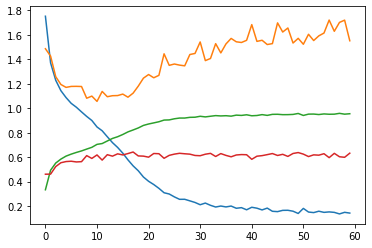

In [9]:
plt.plot(hist)

In [13]:
best_acc, 0.634

(0.6419719827586207, 0.634)

In [9]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_1_lbp.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.499 acc: 0.102
	 - Step 2: loss: 2.142 acc: 0.211
	 - Step 3: loss: 1.985 acc: 0.258
	 - Step 4: loss: 1.990 acc: 0.211
	 - Step 5: loss: 2.125 acc: 0.203
	 - Step 6: loss: 2.098 acc: 0.234
	 - Step 7: loss: 2.045 acc: 0.195
	 - Step 8: loss: 2.006 acc: 0.250
	 - Step 9: loss: 1.896 acc: 0.242
	 - Step 10: loss: 2.034 acc: 0.203
	 - Step 11: loss: 2.018 acc: 0.250
	 - Step 12: loss: 1.877 acc: 0.266
	 - Step 13: loss: 1.910 acc: 0.258
	 - Step 14: loss: 2.214 acc: 0.203
	 - Step 15: loss: 1.857 acc: 0.266
	 - Step 16: loss: 1.976 acc: 0.250
	 - Step 17: loss: 1.902 acc: 0.250
	 - Step 18: loss: 1.904 acc: 0.266
	 - Step 19: loss: 2.010 acc: 0.297
	 - Step 20: loss: 1.860 acc: 0.195
	 - Step 21: loss: 1.865 acc: 0.266
	 - Step 22: loss: 1.890 acc: 0.297
	 - Step 23: loss: 2.111 acc: 0.242
	 - Step 24: loss: 2.005 acc: 0.281
	 - Step 25: loss: 1.974 acc: 0.273
	 - Step 26: loss: 2.018 acc: 0.227
	 - Step 27: loss: 2.010 acc: 0.219
	 - Step 28: loss: 1.996 ac

- Avg. val_loss: 1.712  | Avg. val_acc: 0.374


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.497 acc: 0.398
	 - Step 2: loss: 1.555 acc: 0.461
	 - Step 3: loss: 1.553 acc: 0.445
	 - Step 4: loss: 1.543 acc: 0.445
	 - Step 5: loss: 1.432 acc: 0.445
	 - Step 6: loss: 1.439 acc: 0.422
	 - Step 7: loss: 1.399 acc: 0.492
	 - Step 8: loss: 1.555 acc: 0.391
	 - Step 9: loss: 1.439 acc: 0.438
	 - Step 10: loss: 1.516 acc: 0.453
	 - Step 11: loss: 1.556 acc: 0.375
	 - Step 12: loss: 1.342 acc: 0.523
	 - Step 13: loss: 1.418 acc: 0.469
	 - Step 14: loss: 1.505 acc: 0.391
	 - Step 15: loss: 1.485 acc: 0.422
	 - Step 16: loss: 1.491 acc: 0.375
	 - Step 17: loss: 1.460 acc: 0.461
	 - Step 18: loss: 1.393 acc: 0.477
	 - Step 19: loss: 1.385 acc: 0.477
	 - Step 20: loss: 1.510 acc: 0.414
	 - Step 21: loss: 1.381 acc: 0.492
	 - Step 22: loss: 1.576 acc: 0.391
	 - Step 23: loss: 1.483 acc: 0.461
	 - Step 24: loss: 1.474 acc: 0.477
	 - Step 25: loss: 1.500 acc: 0.398
	 - Step 26: loss: 1.410 acc: 0.500
	 - Step 27: loss: 1.381 acc: 0.484
	 - 

	 - Step 225: loss: 1.596 acc: 0.324
- Avg.loss: 1.402  | Avg.acc: 0.473
- Avg. val_loss: 1.466  | Avg. val_acc: 0.450
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.272 acc: 0.539
	 - Step 2: loss: 1.213 acc: 0.562
	 - Step 3: loss: 1.269 acc: 0.562
	 - Step 4: loss: 1.260 acc: 0.555
	 - Step 5: loss: 1.251 acc: 0.516
	 - Step 6: loss: 1.373 acc: 0.484
	 - Step 7: loss: 1.255 acc: 0.547
	 - Step 8: loss: 1.289 acc: 0.469
	 - Step 9: loss: 1.346 acc: 0.453
	 - Step 10: loss: 1.344 acc: 0.453
	 - Step 11: loss: 1.345 acc: 0.445
	 - Step 12: loss: 1.388 acc: 0.492
	 - Step 13: loss: 1.377 acc: 0.469
	 - Step 14: loss: 1.204 acc: 0.555
	 - Step 15: loss: 1.094 acc: 0.641
	 - Step 16: loss: 1.322 acc: 0.516
	 - Step 17: loss: 1.303 acc: 0.500
	 - Step 18: loss: 1.192 acc: 0.594
	 - Step 19: loss: 1.340 acc: 0.469
	 - Step 20: loss: 1.316 acc: 0.492
	 - Step 21: loss: 1.283 acc: 0.547
	 - Step 22: loss: 1.272 acc: 0.516
	 - Step 23: loss: 1.180 acc: 0.547
	 - Step 24: loss: 1.359 acc:

	 - Step 223: loss: 1.394 acc: 0.500
	 - Step 224: loss: 1.173 acc: 0.570
	 - Step 225: loss: 1.311 acc: 0.486
- Avg.loss: 1.295  | Avg.acc: 0.518
- Avg. val_loss: 1.450  | Avg. val_acc: 0.459
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.172 acc: 0.586
	 - Step 2: loss: 1.330 acc: 0.484
	 - Step 3: loss: 1.197 acc: 0.539
	 - Step 4: loss: 1.215 acc: 0.570
	 - Step 5: loss: 1.246 acc: 0.531
	 - Step 6: loss: 1.196 acc: 0.570
	 - Step 7: loss: 1.188 acc: 0.539
	 - Step 8: loss: 1.201 acc: 0.539
	 - Step 9: loss: 1.259 acc: 0.523
	 - Step 10: loss: 1.199 acc: 0.594
	 - Step 11: loss: 1.355 acc: 0.523
	 - Step 12: loss: 1.168 acc: 0.555
	 - Step 13: loss: 1.329 acc: 0.516
	 - Step 14: loss: 1.173 acc: 0.531
	 - Step 15: loss: 1.165 acc: 0.586
	 - Step 16: loss: 1.119 acc: 0.609
	 - Step 17: loss: 1.168 acc: 0.562
	 - Step 18: loss: 1.127 acc: 0.578
	 - Step 19: loss: 1.215 acc: 0.562
	 - Step 20: loss: 1.099 acc: 0.648
	 - Step 21: loss: 1.294 acc: 0.500
	 - Step 22: loss: 1.226 ac

	 - Step 221: loss: 1.220 acc: 0.492
	 - Step 222: loss: 1.232 acc: 0.547
	 - Step 223: loss: 1.367 acc: 0.508
	 - Step 224: loss: 1.239 acc: 0.516
	 - Step 225: loss: 1.448 acc: 0.486
- Avg.loss: 1.222  | Avg.acc: 0.548
- Avg. val_loss: 1.314  | Avg. val_acc: 0.508
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.092 acc: 0.602
	 - Step 2: loss: 1.248 acc: 0.539
	 - Step 3: loss: 1.190 acc: 0.547
	 - Step 4: loss: 1.169 acc: 0.570
	 - Step 5: loss: 1.210 acc: 0.547
	 - Step 6: loss: 1.228 acc: 0.531
	 - Step 7: loss: 1.181 acc: 0.570
	 - Step 8: loss: 1.067 acc: 0.625
	 - Step 9: loss: 1.121 acc: 0.578
	 - Step 10: loss: 1.168 acc: 0.547
	 - Step 11: loss: 1.192 acc: 0.547
	 - Step 12: loss: 1.268 acc: 0.523
	 - Step 13: loss: 1.264 acc: 0.461
	 - Step 14: loss: 1.077 acc: 0.680
	 - Step 15: loss: 1.203 acc: 0.555
	 - Step 16: loss: 1.097 acc: 0.594
	 - Step 17: loss: 1.089 acc: 0.664
	 - Step 18: loss: 1.163 acc: 0.578
	 - Step 19: loss: 1.090 acc: 0.602
	 - Step 20: loss: 1.053 

	 - Step 219: loss: 1.212 acc: 0.570
	 - Step 220: loss: 1.276 acc: 0.539
	 - Step 221: loss: 1.153 acc: 0.594
	 - Step 222: loss: 1.210 acc: 0.539
	 - Step 223: loss: 1.207 acc: 0.508
	 - Step 224: loss: 1.271 acc: 0.477
	 - Step 225: loss: 1.127 acc: 0.541
- Avg.loss: 1.167  | Avg.acc: 0.572
- Avg. val_loss: 1.349  | Avg. val_acc: 0.487
Epoch:  6
	 - Step 1: loss: 1.006 acc: 0.617
	 - Step 2: loss: 0.960 acc: 0.664
	 - Step 3: loss: 1.103 acc: 0.562
	 - Step 4: loss: 1.046 acc: 0.633
	 - Step 5: loss: 0.953 acc: 0.625
	 - Step 6: loss: 1.034 acc: 0.633
	 - Step 7: loss: 1.324 acc: 0.547
	 - Step 8: loss: 1.044 acc: 0.617
	 - Step 9: loss: 1.118 acc: 0.578
	 - Step 10: loss: 1.174 acc: 0.570
	 - Step 11: loss: 1.128 acc: 0.570
	 - Step 12: loss: 0.995 acc: 0.656
	 - Step 13: loss: 0.991 acc: 0.680
	 - Step 14: loss: 0.987 acc: 0.625
	 - Step 15: loss: 0.865 acc: 0.703
	 - Step 16: loss: 1.096 acc: 0.555
	 - Step 17: loss: 1.162 acc: 0.594
	 - Step 18: loss: 1.056 acc: 0.594
	 - Step 1

	 - Step 217: loss: 1.146 acc: 0.539
	 - Step 218: loss: 1.118 acc: 0.578
	 - Step 219: loss: 1.272 acc: 0.547
	 - Step 220: loss: 1.258 acc: 0.547
	 - Step 221: loss: 1.120 acc: 0.570
	 - Step 222: loss: 1.036 acc: 0.625
	 - Step 223: loss: 1.064 acc: 0.641
	 - Step 224: loss: 1.032 acc: 0.617
	 - Step 225: loss: 1.202 acc: 0.541
- Avg.loss: 1.120  | Avg.acc: 0.590
- Avg. val_loss: 1.266  | Avg. val_acc: 0.529
* Update optimal model
Epoch:  7
	 - Step 1: loss: 1.062 acc: 0.594
	 - Step 2: loss: 0.984 acc: 0.664
	 - Step 3: loss: 1.004 acc: 0.625
	 - Step 4: loss: 1.080 acc: 0.594
	 - Step 5: loss: 0.942 acc: 0.641
	 - Step 6: loss: 0.971 acc: 0.695
	 - Step 7: loss: 1.021 acc: 0.625
	 - Step 8: loss: 0.992 acc: 0.641
	 - Step 9: loss: 0.981 acc: 0.672
	 - Step 10: loss: 0.923 acc: 0.672
	 - Step 11: loss: 1.144 acc: 0.594
	 - Step 12: loss: 0.923 acc: 0.680
	 - Step 13: loss: 1.100 acc: 0.641
	 - Step 14: loss: 1.012 acc: 0.672
	 - Step 15: loss: 1.180 acc: 0.594
	 - Step 16: loss: 0.

	 - Step 215: loss: 1.218 acc: 0.570
	 - Step 216: loss: 1.145 acc: 0.562
	 - Step 217: loss: 1.149 acc: 0.547
	 - Step 218: loss: 1.156 acc: 0.547
	 - Step 219: loss: 1.040 acc: 0.641
	 - Step 220: loss: 1.106 acc: 0.539
	 - Step 221: loss: 1.066 acc: 0.609
	 - Step 222: loss: 1.158 acc: 0.578
	 - Step 223: loss: 1.053 acc: 0.609
	 - Step 224: loss: 1.156 acc: 0.570
	 - Step 225: loss: 0.977 acc: 0.676
- Avg.loss: 1.072  | Avg.acc: 0.609
- Avg. val_loss: 1.234  | Avg. val_acc: 0.544
* Update optimal model
Epoch:  8
	 - Step 1: loss: 0.933 acc: 0.664
	 - Step 2: loss: 0.902 acc: 0.711
	 - Step 3: loss: 0.897 acc: 0.695
	 - Step 4: loss: 0.823 acc: 0.766
	 - Step 5: loss: 1.027 acc: 0.602
	 - Step 6: loss: 0.841 acc: 0.719
	 - Step 7: loss: 0.960 acc: 0.680
	 - Step 8: loss: 0.900 acc: 0.672
	 - Step 9: loss: 0.845 acc: 0.727
	 - Step 10: loss: 0.940 acc: 0.703
	 - Step 11: loss: 0.976 acc: 0.641
	 - Step 12: loss: 0.969 acc: 0.609
	 - Step 13: loss: 0.979 acc: 0.656
	 - Step 14: loss: 

	 - Step 213: loss: 1.093 acc: 0.594
	 - Step 214: loss: 0.957 acc: 0.656
	 - Step 215: loss: 1.244 acc: 0.539
	 - Step 216: loss: 1.075 acc: 0.625
	 - Step 217: loss: 1.158 acc: 0.570
	 - Step 218: loss: 1.011 acc: 0.609
	 - Step 219: loss: 1.032 acc: 0.648
	 - Step 220: loss: 1.140 acc: 0.617
	 - Step 221: loss: 1.198 acc: 0.523
	 - Step 222: loss: 1.229 acc: 0.516
	 - Step 223: loss: 0.979 acc: 0.641
	 - Step 224: loss: 1.029 acc: 0.625
	 - Step 225: loss: 1.084 acc: 0.595
- Avg.loss: 1.021  | Avg.acc: 0.632
- Avg. val_loss: 1.353  | Avg. val_acc: 0.509
Epoch:  9
	 - Step 1: loss: 0.951 acc: 0.680
	 - Step 2: loss: 1.007 acc: 0.633
	 - Step 3: loss: 1.099 acc: 0.586
	 - Step 4: loss: 0.959 acc: 0.672
	 - Step 5: loss: 0.906 acc: 0.703
	 - Step 6: loss: 1.072 acc: 0.594
	 - Step 7: loss: 0.986 acc: 0.641
	 - Step 8: loss: 0.909 acc: 0.703
	 - Step 9: loss: 0.807 acc: 0.789
	 - Step 10: loss: 1.014 acc: 0.586
	 - Step 11: loss: 0.913 acc: 0.680
	 - Step 12: loss: 0.890 acc: 0.711
	 - 

	 - Step 211: loss: 1.073 acc: 0.531
	 - Step 212: loss: 1.001 acc: 0.695
	 - Step 213: loss: 0.880 acc: 0.680
	 - Step 214: loss: 1.004 acc: 0.656
	 - Step 215: loss: 1.064 acc: 0.594
	 - Step 216: loss: 1.168 acc: 0.578
	 - Step 217: loss: 0.897 acc: 0.648
	 - Step 218: loss: 1.100 acc: 0.594
	 - Step 219: loss: 0.751 acc: 0.703
	 - Step 220: loss: 1.031 acc: 0.617
	 - Step 221: loss: 1.076 acc: 0.594
	 - Step 222: loss: 0.998 acc: 0.625
	 - Step 223: loss: 1.001 acc: 0.641
	 - Step 224: loss: 1.147 acc: 0.594
	 - Step 225: loss: 1.063 acc: 0.568
- Avg.loss: 0.978  | Avg.acc: 0.645
- Avg. val_loss: 1.243  | Avg. val_acc: 0.541
Epoch:  10
	 - Step 1: loss: 0.856 acc: 0.703
	 - Step 2: loss: 0.936 acc: 0.656
	 - Step 3: loss: 0.898 acc: 0.680
	 - Step 4: loss: 0.928 acc: 0.648
	 - Step 5: loss: 0.915 acc: 0.703
	 - Step 6: loss: 0.941 acc: 0.672
	 - Step 7: loss: 0.773 acc: 0.766
	 - Step 8: loss: 0.801 acc: 0.750
	 - Step 9: loss: 0.949 acc: 0.633
	 - Step 10: loss: 0.919 acc: 0.680
	

	 - Step 209: loss: 0.873 acc: 0.672
	 - Step 210: loss: 1.169 acc: 0.602
	 - Step 211: loss: 1.151 acc: 0.539
	 - Step 212: loss: 0.928 acc: 0.656
	 - Step 213: loss: 0.871 acc: 0.703
	 - Step 214: loss: 0.924 acc: 0.641
	 - Step 215: loss: 0.967 acc: 0.656
	 - Step 216: loss: 0.920 acc: 0.703
	 - Step 217: loss: 1.006 acc: 0.641
	 - Step 218: loss: 0.893 acc: 0.680
	 - Step 219: loss: 1.055 acc: 0.641
	 - Step 220: loss: 0.957 acc: 0.625
	 - Step 221: loss: 0.996 acc: 0.656
	 - Step 222: loss: 0.983 acc: 0.625
	 - Step 223: loss: 0.934 acc: 0.680
	 - Step 224: loss: 0.901 acc: 0.664
	 - Step 225: loss: 1.077 acc: 0.595
- Avg.loss: 0.922  | Avg.acc: 0.669
- Avg. val_loss: 1.338  | Avg. val_acc: 0.518
Epoch:  11
	 - Step 1: loss: 0.730 acc: 0.719
	 - Step 2: loss: 0.873 acc: 0.688
	 - Step 3: loss: 0.807 acc: 0.727
	 - Step 4: loss: 0.811 acc: 0.719
	 - Step 5: loss: 0.874 acc: 0.688
	 - Step 6: loss: 0.725 acc: 0.781
	 - Step 7: loss: 0.759 acc: 0.734
	 - Step 8: loss: 0.904 acc: 0.65

	 - Step 207: loss: 0.925 acc: 0.680
	 - Step 208: loss: 0.879 acc: 0.656
	 - Step 209: loss: 0.779 acc: 0.711
	 - Step 210: loss: 0.945 acc: 0.648
	 - Step 211: loss: 0.810 acc: 0.750
	 - Step 212: loss: 0.928 acc: 0.688
	 - Step 213: loss: 0.872 acc: 0.664
	 - Step 214: loss: 0.820 acc: 0.727
	 - Step 215: loss: 0.935 acc: 0.703
	 - Step 216: loss: 1.081 acc: 0.617
	 - Step 217: loss: 1.027 acc: 0.609
	 - Step 218: loss: 0.794 acc: 0.680
	 - Step 219: loss: 0.831 acc: 0.750
	 - Step 220: loss: 0.924 acc: 0.664
	 - Step 221: loss: 0.958 acc: 0.633
	 - Step 222: loss: 0.778 acc: 0.719
	 - Step 223: loss: 1.018 acc: 0.617
	 - Step 224: loss: 1.112 acc: 0.578
	 - Step 225: loss: 0.937 acc: 0.703
- Avg.loss: 0.876  | Avg.acc: 0.691
- Avg. val_loss: 1.225  | Avg. val_acc: 0.564
* Update optimal model
Epoch:  12
	 - Step 1: loss: 0.797 acc: 0.750
	 - Step 2: loss: 0.934 acc: 0.656
	 - Step 3: loss: 0.716 acc: 0.734
	 - Step 4: loss: 0.802 acc: 0.734
	 - Step 5: loss: 0.745 acc: 0.773
	 - St

	 - Step 205: loss: 0.888 acc: 0.680
	 - Step 206: loss: 0.857 acc: 0.680
	 - Step 207: loss: 0.914 acc: 0.688
	 - Step 208: loss: 0.857 acc: 0.719
	 - Step 209: loss: 0.974 acc: 0.672
	 - Step 210: loss: 0.823 acc: 0.695
	 - Step 211: loss: 1.002 acc: 0.648
	 - Step 212: loss: 0.869 acc: 0.664
	 - Step 213: loss: 0.903 acc: 0.617
	 - Step 214: loss: 0.812 acc: 0.703
	 - Step 215: loss: 0.946 acc: 0.648
	 - Step 216: loss: 0.737 acc: 0.766
	 - Step 217: loss: 0.925 acc: 0.656
	 - Step 218: loss: 0.818 acc: 0.703
	 - Step 219: loss: 0.995 acc: 0.648
	 - Step 220: loss: 0.871 acc: 0.727
	 - Step 221: loss: 1.001 acc: 0.609
	 - Step 222: loss: 0.824 acc: 0.727
	 - Step 223: loss: 0.934 acc: 0.711
	 - Step 224: loss: 0.920 acc: 0.648
	 - Step 225: loss: 1.067 acc: 0.676
- Avg.loss: 0.812  | Avg.acc: 0.715
- Avg. val_loss: 1.283  | Avg. val_acc: 0.547
Epoch:  13
	 - Step 1: loss: 0.729 acc: 0.742
	 - Step 2: loss: 0.715 acc: 0.727
	 - Step 3: loss: 0.551 acc: 0.836
	 - Step 4: loss: 0.780 a

	 - Step 203: loss: 0.850 acc: 0.719
	 - Step 204: loss: 0.751 acc: 0.742
	 - Step 205: loss: 0.802 acc: 0.727
	 - Step 206: loss: 0.998 acc: 0.664
	 - Step 207: loss: 0.995 acc: 0.688
	 - Step 208: loss: 0.762 acc: 0.719
	 - Step 209: loss: 0.812 acc: 0.750
	 - Step 210: loss: 0.890 acc: 0.680
	 - Step 211: loss: 0.770 acc: 0.750
	 - Step 212: loss: 0.763 acc: 0.758
	 - Step 213: loss: 0.875 acc: 0.711
	 - Step 214: loss: 0.703 acc: 0.766
	 - Step 215: loss: 0.833 acc: 0.734
	 - Step 216: loss: 0.911 acc: 0.680
	 - Step 217: loss: 0.725 acc: 0.711
	 - Step 218: loss: 0.656 acc: 0.773
	 - Step 219: loss: 0.761 acc: 0.750
	 - Step 220: loss: 0.857 acc: 0.703
	 - Step 221: loss: 0.837 acc: 0.711
	 - Step 222: loss: 0.810 acc: 0.703
	 - Step 223: loss: 0.712 acc: 0.797
	 - Step 224: loss: 0.723 acc: 0.750
	 - Step 225: loss: 0.687 acc: 0.757
- Avg.loss: 0.753  | Avg.acc: 0.739
- Avg. val_loss: 1.334  | Avg. val_acc: 0.540
Epoch:  14
	 - Step 1: loss: 0.733 acc: 0.758
	 - Step 2: loss: 0.7

	 - Step 201: loss: 0.767 acc: 0.703
	 - Step 202: loss: 0.685 acc: 0.742
	 - Step 203: loss: 0.815 acc: 0.703
	 - Step 204: loss: 0.722 acc: 0.734
	 - Step 205: loss: 0.743 acc: 0.742
	 - Step 206: loss: 0.687 acc: 0.750
	 - Step 207: loss: 0.605 acc: 0.781
	 - Step 208: loss: 0.691 acc: 0.727
	 - Step 209: loss: 0.730 acc: 0.789
	 - Step 210: loss: 0.660 acc: 0.789
	 - Step 211: loss: 0.769 acc: 0.742
	 - Step 212: loss: 0.695 acc: 0.766
	 - Step 213: loss: 0.636 acc: 0.789
	 - Step 214: loss: 0.605 acc: 0.789
	 - Step 215: loss: 0.730 acc: 0.727
	 - Step 216: loss: 0.654 acc: 0.781
	 - Step 217: loss: 0.727 acc: 0.758
	 - Step 218: loss: 0.795 acc: 0.727
	 - Step 219: loss: 0.684 acc: 0.758
	 - Step 220: loss: 0.640 acc: 0.742
	 - Step 221: loss: 0.845 acc: 0.672
	 - Step 222: loss: 0.698 acc: 0.781
	 - Step 223: loss: 0.822 acc: 0.688
	 - Step 224: loss: 0.799 acc: 0.750
	 - Step 225: loss: 0.937 acc: 0.676
- Avg.loss: 0.677  | Avg.acc: 0.771
- Avg. val_loss: 1.301  | Avg. val_acc:

	 - Step 199: loss: 0.654 acc: 0.766
	 - Step 200: loss: 0.581 acc: 0.797
	 - Step 201: loss: 0.978 acc: 0.680
	 - Step 202: loss: 0.622 acc: 0.766
	 - Step 203: loss: 0.481 acc: 0.875
	 - Step 204: loss: 0.707 acc: 0.773
	 - Step 205: loss: 0.669 acc: 0.797
	 - Step 206: loss: 0.771 acc: 0.727
	 - Step 207: loss: 0.792 acc: 0.750
	 - Step 208: loss: 0.584 acc: 0.766
	 - Step 209: loss: 0.436 acc: 0.875
	 - Step 210: loss: 0.753 acc: 0.727
	 - Step 211: loss: 0.642 acc: 0.758
	 - Step 212: loss: 0.686 acc: 0.719
	 - Step 213: loss: 0.665 acc: 0.742
	 - Step 214: loss: 0.593 acc: 0.781
	 - Step 215: loss: 0.702 acc: 0.727
	 - Step 216: loss: 0.789 acc: 0.711
	 - Step 217: loss: 0.703 acc: 0.734
	 - Step 218: loss: 0.727 acc: 0.766
	 - Step 219: loss: 0.737 acc: 0.742
	 - Step 220: loss: 0.635 acc: 0.789
	 - Step 221: loss: 0.670 acc: 0.727
	 - Step 222: loss: 0.590 acc: 0.820
	 - Step 223: loss: 0.724 acc: 0.734
	 - Step 224: loss: 0.848 acc: 0.656
	 - Step 225: loss: 0.604 acc: 0.811
-

	 - Step 197: loss: 0.611 acc: 0.781
	 - Step 198: loss: 0.574 acc: 0.820
	 - Step 199: loss: 0.585 acc: 0.812
	 - Step 200: loss: 0.639 acc: 0.781
	 - Step 201: loss: 0.615 acc: 0.781
	 - Step 202: loss: 0.569 acc: 0.773
	 - Step 203: loss: 0.587 acc: 0.789
	 - Step 204: loss: 0.638 acc: 0.766
	 - Step 205: loss: 0.563 acc: 0.805
	 - Step 206: loss: 0.708 acc: 0.734
	 - Step 207: loss: 0.578 acc: 0.797
	 - Step 208: loss: 0.560 acc: 0.844
	 - Step 209: loss: 0.649 acc: 0.797
	 - Step 210: loss: 0.816 acc: 0.711
	 - Step 211: loss: 0.529 acc: 0.875
	 - Step 212: loss: 0.510 acc: 0.836
	 - Step 213: loss: 0.529 acc: 0.828
	 - Step 214: loss: 0.622 acc: 0.781
	 - Step 215: loss: 0.668 acc: 0.742
	 - Step 216: loss: 0.659 acc: 0.797
	 - Step 217: loss: 0.538 acc: 0.820
	 - Step 218: loss: 0.629 acc: 0.781
	 - Step 219: loss: 0.718 acc: 0.742
	 - Step 220: loss: 0.639 acc: 0.773
	 - Step 221: loss: 0.623 acc: 0.781
	 - Step 222: loss: 0.723 acc: 0.781
	 - Step 223: loss: 0.651 acc: 0.758
	

	 - Step 195: loss: 0.490 acc: 0.859
	 - Step 196: loss: 0.559 acc: 0.805
	 - Step 197: loss: 0.530 acc: 0.828
	 - Step 198: loss: 0.561 acc: 0.789
	 - Step 199: loss: 0.547 acc: 0.773
	 - Step 200: loss: 0.707 acc: 0.758
	 - Step 201: loss: 0.667 acc: 0.758
	 - Step 202: loss: 0.567 acc: 0.781
	 - Step 203: loss: 0.577 acc: 0.773
	 - Step 204: loss: 0.471 acc: 0.836
	 - Step 205: loss: 0.518 acc: 0.828
	 - Step 206: loss: 0.572 acc: 0.789
	 - Step 207: loss: 0.720 acc: 0.742
	 - Step 208: loss: 0.550 acc: 0.805
	 - Step 209: loss: 0.486 acc: 0.859
	 - Step 210: loss: 0.562 acc: 0.812
	 - Step 211: loss: 0.569 acc: 0.789
	 - Step 212: loss: 0.543 acc: 0.805
	 - Step 213: loss: 0.594 acc: 0.836
	 - Step 214: loss: 0.472 acc: 0.875
	 - Step 215: loss: 0.513 acc: 0.828
	 - Step 216: loss: 0.715 acc: 0.758
	 - Step 217: loss: 0.498 acc: 0.859
	 - Step 218: loss: 0.509 acc: 0.789
	 - Step 219: loss: 0.671 acc: 0.789
	 - Step 220: loss: 0.423 acc: 0.875
	 - Step 221: loss: 0.413 acc: 0.867
	

	 - Step 193: loss: 0.470 acc: 0.836
	 - Step 194: loss: 0.475 acc: 0.867
	 - Step 195: loss: 0.561 acc: 0.836
	 - Step 196: loss: 0.569 acc: 0.781
	 - Step 197: loss: 0.509 acc: 0.844
	 - Step 198: loss: 0.522 acc: 0.820
	 - Step 199: loss: 0.628 acc: 0.805
	 - Step 200: loss: 0.654 acc: 0.781
	 - Step 201: loss: 0.454 acc: 0.883
	 - Step 202: loss: 0.644 acc: 0.750
	 - Step 203: loss: 0.489 acc: 0.859
	 - Step 204: loss: 0.523 acc: 0.797
	 - Step 205: loss: 0.475 acc: 0.883
	 - Step 206: loss: 0.404 acc: 0.867
	 - Step 207: loss: 0.388 acc: 0.859
	 - Step 208: loss: 0.447 acc: 0.883
	 - Step 209: loss: 0.478 acc: 0.844
	 - Step 210: loss: 0.520 acc: 0.820
	 - Step 211: loss: 0.631 acc: 0.789
	 - Step 212: loss: 0.414 acc: 0.859
	 - Step 213: loss: 0.579 acc: 0.812
	 - Step 214: loss: 0.514 acc: 0.805
	 - Step 215: loss: 0.553 acc: 0.828
	 - Step 216: loss: 0.342 acc: 0.898
	 - Step 217: loss: 0.321 acc: 0.906
	 - Step 218: loss: 0.433 acc: 0.836
	 - Step 219: loss: 0.527 acc: 0.812
	

	 - Step 191: loss: 0.500 acc: 0.836
	 - Step 192: loss: 0.460 acc: 0.820
	 - Step 193: loss: 0.524 acc: 0.828
	 - Step 194: loss: 0.399 acc: 0.875
	 - Step 195: loss: 0.539 acc: 0.812
	 - Step 196: loss: 0.559 acc: 0.812
	 - Step 197: loss: 0.459 acc: 0.875
	 - Step 198: loss: 0.446 acc: 0.859
	 - Step 199: loss: 0.451 acc: 0.844
	 - Step 200: loss: 0.439 acc: 0.844
	 - Step 201: loss: 0.409 acc: 0.875
	 - Step 202: loss: 0.403 acc: 0.867
	 - Step 203: loss: 0.319 acc: 0.891
	 - Step 204: loss: 0.585 acc: 0.781
	 - Step 205: loss: 0.381 acc: 0.859
	 - Step 206: loss: 0.519 acc: 0.844
	 - Step 207: loss: 0.562 acc: 0.820
	 - Step 208: loss: 0.512 acc: 0.820
	 - Step 209: loss: 0.467 acc: 0.828
	 - Step 210: loss: 0.368 acc: 0.906
	 - Step 211: loss: 0.411 acc: 0.852
	 - Step 212: loss: 0.464 acc: 0.875
	 - Step 213: loss: 0.386 acc: 0.875
	 - Step 214: loss: 0.340 acc: 0.891
	 - Step 215: loss: 0.419 acc: 0.867
	 - Step 216: loss: 0.481 acc: 0.852
	 - Step 217: loss: 0.440 acc: 0.844
	

	 - Step 189: loss: 0.493 acc: 0.820
	 - Step 190: loss: 0.421 acc: 0.859
	 - Step 191: loss: 0.336 acc: 0.898
	 - Step 192: loss: 0.403 acc: 0.852
	 - Step 193: loss: 0.405 acc: 0.898
	 - Step 194: loss: 0.426 acc: 0.859
	 - Step 195: loss: 0.478 acc: 0.812
	 - Step 196: loss: 0.475 acc: 0.852
	 - Step 197: loss: 0.525 acc: 0.828
	 - Step 198: loss: 0.446 acc: 0.820
	 - Step 199: loss: 0.451 acc: 0.867
	 - Step 200: loss: 0.328 acc: 0.898
	 - Step 201: loss: 0.392 acc: 0.852
	 - Step 202: loss: 0.377 acc: 0.859
	 - Step 203: loss: 0.577 acc: 0.828
	 - Step 204: loss: 0.321 acc: 0.906
	 - Step 205: loss: 0.534 acc: 0.859
	 - Step 206: loss: 0.340 acc: 0.883
	 - Step 207: loss: 0.514 acc: 0.812
	 - Step 208: loss: 0.397 acc: 0.891
	 - Step 209: loss: 0.375 acc: 0.914
	 - Step 210: loss: 0.495 acc: 0.828
	 - Step 211: loss: 0.449 acc: 0.828
	 - Step 212: loss: 0.239 acc: 0.930
	 - Step 213: loss: 0.387 acc: 0.828
	 - Step 214: loss: 0.393 acc: 0.898
	 - Step 215: loss: 0.501 acc: 0.844
	

	 - Step 187: loss: 0.430 acc: 0.859
	 - Step 188: loss: 0.432 acc: 0.859
	 - Step 189: loss: 0.314 acc: 0.898
	 - Step 190: loss: 0.374 acc: 0.883
	 - Step 191: loss: 0.367 acc: 0.883
	 - Step 192: loss: 0.345 acc: 0.891
	 - Step 193: loss: 0.325 acc: 0.898
	 - Step 194: loss: 0.352 acc: 0.859
	 - Step 195: loss: 0.456 acc: 0.867
	 - Step 196: loss: 0.293 acc: 0.914
	 - Step 197: loss: 0.339 acc: 0.875
	 - Step 198: loss: 0.446 acc: 0.898
	 - Step 199: loss: 0.313 acc: 0.914
	 - Step 200: loss: 0.430 acc: 0.875
	 - Step 201: loss: 0.339 acc: 0.883
	 - Step 202: loss: 0.297 acc: 0.914
	 - Step 203: loss: 0.321 acc: 0.906
	 - Step 204: loss: 0.329 acc: 0.875
	 - Step 205: loss: 0.393 acc: 0.867
	 - Step 206: loss: 0.411 acc: 0.883
	 - Step 207: loss: 0.343 acc: 0.883
	 - Step 208: loss: 0.437 acc: 0.852
	 - Step 209: loss: 0.361 acc: 0.875
	 - Step 210: loss: 0.296 acc: 0.906
	 - Step 211: loss: 0.375 acc: 0.875
	 - Step 212: loss: 0.334 acc: 0.852
	 - Step 213: loss: 0.450 acc: 0.859
	

	 - Step 185: loss: 0.367 acc: 0.891
	 - Step 186: loss: 0.334 acc: 0.875
	 - Step 187: loss: 0.422 acc: 0.867
	 - Step 188: loss: 0.364 acc: 0.867
	 - Step 189: loss: 0.293 acc: 0.922
	 - Step 190: loss: 0.402 acc: 0.867
	 - Step 191: loss: 0.357 acc: 0.859
	 - Step 192: loss: 0.356 acc: 0.875
	 - Step 193: loss: 0.495 acc: 0.859
	 - Step 194: loss: 0.287 acc: 0.891
	 - Step 195: loss: 0.439 acc: 0.844
	 - Step 196: loss: 0.378 acc: 0.844
	 - Step 197: loss: 0.317 acc: 0.875
	 - Step 198: loss: 0.267 acc: 0.906
	 - Step 199: loss: 0.221 acc: 0.930
	 - Step 200: loss: 0.299 acc: 0.922
	 - Step 201: loss: 0.352 acc: 0.859
	 - Step 202: loss: 0.397 acc: 0.859
	 - Step 203: loss: 0.430 acc: 0.852
	 - Step 204: loss: 0.384 acc: 0.883
	 - Step 205: loss: 0.350 acc: 0.859
	 - Step 206: loss: 0.396 acc: 0.867
	 - Step 207: loss: 0.343 acc: 0.891
	 - Step 208: loss: 0.501 acc: 0.836
	 - Step 209: loss: 0.459 acc: 0.859
	 - Step 210: loss: 0.451 acc: 0.852
	 - Step 211: loss: 0.326 acc: 0.875
	

	 - Step 183: loss: 0.320 acc: 0.906
	 - Step 184: loss: 0.381 acc: 0.867
	 - Step 185: loss: 0.362 acc: 0.891
	 - Step 186: loss: 0.421 acc: 0.859
	 - Step 187: loss: 0.263 acc: 0.938
	 - Step 188: loss: 0.330 acc: 0.891
	 - Step 189: loss: 0.357 acc: 0.883
	 - Step 190: loss: 0.291 acc: 0.914
	 - Step 191: loss: 0.473 acc: 0.820
	 - Step 192: loss: 0.363 acc: 0.883
	 - Step 193: loss: 0.438 acc: 0.820
	 - Step 194: loss: 0.326 acc: 0.914
	 - Step 195: loss: 0.349 acc: 0.852
	 - Step 196: loss: 0.290 acc: 0.898
	 - Step 197: loss: 0.505 acc: 0.852
	 - Step 198: loss: 0.267 acc: 0.891
	 - Step 199: loss: 0.342 acc: 0.914
	 - Step 200: loss: 0.478 acc: 0.891
	 - Step 201: loss: 0.325 acc: 0.883
	 - Step 202: loss: 0.298 acc: 0.898
	 - Step 203: loss: 0.338 acc: 0.891
	 - Step 204: loss: 0.398 acc: 0.867
	 - Step 205: loss: 0.339 acc: 0.906
	 - Step 206: loss: 0.295 acc: 0.883
	 - Step 207: loss: 0.218 acc: 0.930
	 - Step 208: loss: 0.332 acc: 0.883
	 - Step 209: loss: 0.261 acc: 0.914
	

	 - Step 181: loss: 0.281 acc: 0.914
	 - Step 182: loss: 0.241 acc: 0.914
	 - Step 183: loss: 0.291 acc: 0.914
	 - Step 184: loss: 0.316 acc: 0.898
	 - Step 185: loss: 0.257 acc: 0.891
	 - Step 186: loss: 0.302 acc: 0.891
	 - Step 187: loss: 0.317 acc: 0.891
	 - Step 188: loss: 0.239 acc: 0.914
	 - Step 189: loss: 0.403 acc: 0.883
	 - Step 190: loss: 0.491 acc: 0.867
	 - Step 191: loss: 0.384 acc: 0.891
	 - Step 192: loss: 0.257 acc: 0.922
	 - Step 193: loss: 0.299 acc: 0.922
	 - Step 194: loss: 0.429 acc: 0.820
	 - Step 195: loss: 0.199 acc: 0.953
	 - Step 196: loss: 0.347 acc: 0.867
	 - Step 197: loss: 0.270 acc: 0.906
	 - Step 198: loss: 0.226 acc: 0.930
	 - Step 199: loss: 0.381 acc: 0.875
	 - Step 200: loss: 0.190 acc: 0.977
	 - Step 201: loss: 0.342 acc: 0.883
	 - Step 202: loss: 0.239 acc: 0.930
	 - Step 203: loss: 0.218 acc: 0.938
	 - Step 204: loss: 0.310 acc: 0.898
	 - Step 205: loss: 0.358 acc: 0.875
	 - Step 206: loss: 0.273 acc: 0.930
	 - Step 207: loss: 0.253 acc: 0.914
	

	 - Step 179: loss: 0.408 acc: 0.875
	 - Step 180: loss: 0.267 acc: 0.914
	 - Step 181: loss: 0.204 acc: 0.938
	 - Step 182: loss: 0.276 acc: 0.898
	 - Step 183: loss: 0.280 acc: 0.898
	 - Step 184: loss: 0.260 acc: 0.930
	 - Step 185: loss: 0.314 acc: 0.898
	 - Step 186: loss: 0.311 acc: 0.898
	 - Step 187: loss: 0.383 acc: 0.867
	 - Step 188: loss: 0.327 acc: 0.867
	 - Step 189: loss: 0.283 acc: 0.914
	 - Step 190: loss: 0.259 acc: 0.938
	 - Step 191: loss: 0.280 acc: 0.914
	 - Step 192: loss: 0.312 acc: 0.906
	 - Step 193: loss: 0.266 acc: 0.922
	 - Step 194: loss: 0.303 acc: 0.883
	 - Step 195: loss: 0.194 acc: 0.945
	 - Step 196: loss: 0.314 acc: 0.883
	 - Step 197: loss: 0.255 acc: 0.938
	 - Step 198: loss: 0.268 acc: 0.914
	 - Step 199: loss: 0.241 acc: 0.930
	 - Step 200: loss: 0.402 acc: 0.891
	 - Step 201: loss: 0.237 acc: 0.930
	 - Step 202: loss: 0.281 acc: 0.914
	 - Step 203: loss: 0.296 acc: 0.914
	 - Step 204: loss: 0.309 acc: 0.914
	 - Step 205: loss: 0.383 acc: 0.883
	

	 - Step 177: loss: 0.324 acc: 0.898
	 - Step 178: loss: 0.348 acc: 0.891
	 - Step 179: loss: 0.230 acc: 0.930
	 - Step 180: loss: 0.242 acc: 0.922
	 - Step 181: loss: 0.323 acc: 0.875
	 - Step 182: loss: 0.377 acc: 0.883
	 - Step 183: loss: 0.309 acc: 0.898
	 - Step 184: loss: 0.373 acc: 0.883
	 - Step 185: loss: 0.228 acc: 0.930
	 - Step 186: loss: 0.334 acc: 0.906
	 - Step 187: loss: 0.235 acc: 0.906
	 - Step 188: loss: 0.230 acc: 0.914
	 - Step 189: loss: 0.213 acc: 0.945
	 - Step 190: loss: 0.262 acc: 0.938
	 - Step 191: loss: 0.211 acc: 0.914
	 - Step 192: loss: 0.231 acc: 0.938
	 - Step 193: loss: 0.275 acc: 0.906
	 - Step 194: loss: 0.248 acc: 0.906
	 - Step 195: loss: 0.343 acc: 0.891
	 - Step 196: loss: 0.415 acc: 0.883
	 - Step 197: loss: 0.231 acc: 0.938
	 - Step 198: loss: 0.251 acc: 0.938
	 - Step 199: loss: 0.350 acc: 0.859
	 - Step 200: loss: 0.260 acc: 0.930
	 - Step 201: loss: 0.261 acc: 0.922
	 - Step 202: loss: 0.286 acc: 0.898
	 - Step 203: loss: 0.241 acc: 0.898
	

	 - Step 175: loss: 0.154 acc: 0.953
	 - Step 176: loss: 0.322 acc: 0.875
	 - Step 177: loss: 0.306 acc: 0.883
	 - Step 178: loss: 0.390 acc: 0.883
	 - Step 179: loss: 0.225 acc: 0.914
	 - Step 180: loss: 0.186 acc: 0.945
	 - Step 181: loss: 0.247 acc: 0.922
	 - Step 182: loss: 0.268 acc: 0.898
	 - Step 183: loss: 0.286 acc: 0.898
	 - Step 184: loss: 0.337 acc: 0.891
	 - Step 185: loss: 0.277 acc: 0.922
	 - Step 186: loss: 0.311 acc: 0.898
	 - Step 187: loss: 0.176 acc: 0.945
	 - Step 188: loss: 0.297 acc: 0.906
	 - Step 189: loss: 0.292 acc: 0.906
	 - Step 190: loss: 0.263 acc: 0.922
	 - Step 191: loss: 0.336 acc: 0.867
	 - Step 192: loss: 0.338 acc: 0.883
	 - Step 193: loss: 0.256 acc: 0.906
	 - Step 194: loss: 0.210 acc: 0.945
	 - Step 195: loss: 0.269 acc: 0.914
	 - Step 196: loss: 0.204 acc: 0.953
	 - Step 197: loss: 0.183 acc: 0.953
	 - Step 198: loss: 0.344 acc: 0.875
	 - Step 199: loss: 0.119 acc: 0.969
	 - Step 200: loss: 0.257 acc: 0.922
	 - Step 201: loss: 0.321 acc: 0.891
	

	 - Step 173: loss: 0.350 acc: 0.883
	 - Step 174: loss: 0.257 acc: 0.898
	 - Step 175: loss: 0.178 acc: 0.938
	 - Step 176: loss: 0.249 acc: 0.930
	 - Step 177: loss: 0.151 acc: 0.922
	 - Step 178: loss: 0.270 acc: 0.891
	 - Step 179: loss: 0.190 acc: 0.930
	 - Step 180: loss: 0.262 acc: 0.914
	 - Step 181: loss: 0.221 acc: 0.945
	 - Step 182: loss: 0.217 acc: 0.945
	 - Step 183: loss: 0.178 acc: 0.938
	 - Step 184: loss: 0.378 acc: 0.906
	 - Step 185: loss: 0.306 acc: 0.906
	 - Step 186: loss: 0.265 acc: 0.906
	 - Step 187: loss: 0.247 acc: 0.914
	 - Step 188: loss: 0.495 acc: 0.867
	 - Step 189: loss: 0.217 acc: 0.930
	 - Step 190: loss: 0.251 acc: 0.906
	 - Step 191: loss: 0.178 acc: 0.930
	 - Step 192: loss: 0.193 acc: 0.938
	 - Step 193: loss: 0.306 acc: 0.922
	 - Step 194: loss: 0.124 acc: 0.969
	 - Step 195: loss: 0.228 acc: 0.922
	 - Step 196: loss: 0.150 acc: 0.953
	 - Step 197: loss: 0.234 acc: 0.938
	 - Step 198: loss: 0.284 acc: 0.906
	 - Step 199: loss: 0.368 acc: 0.883
	

	 - Step 171: loss: 0.265 acc: 0.898
	 - Step 172: loss: 0.234 acc: 0.914
	 - Step 173: loss: 0.329 acc: 0.891
	 - Step 174: loss: 0.247 acc: 0.938
	 - Step 175: loss: 0.167 acc: 0.945
	 - Step 176: loss: 0.234 acc: 0.914
	 - Step 177: loss: 0.280 acc: 0.906
	 - Step 178: loss: 0.256 acc: 0.914
	 - Step 179: loss: 0.266 acc: 0.922
	 - Step 180: loss: 0.196 acc: 0.953
	 - Step 181: loss: 0.288 acc: 0.914
	 - Step 182: loss: 0.378 acc: 0.891
	 - Step 183: loss: 0.187 acc: 0.945
	 - Step 184: loss: 0.314 acc: 0.891
	 - Step 185: loss: 0.314 acc: 0.914
	 - Step 186: loss: 0.369 acc: 0.875
	 - Step 187: loss: 0.223 acc: 0.906
	 - Step 188: loss: 0.159 acc: 0.969
	 - Step 189: loss: 0.367 acc: 0.898
	 - Step 190: loss: 0.303 acc: 0.875
	 - Step 191: loss: 0.310 acc: 0.922
	 - Step 192: loss: 0.213 acc: 0.922
	 - Step 193: loss: 0.201 acc: 0.930
	 - Step 194: loss: 0.210 acc: 0.938
	 - Step 195: loss: 0.287 acc: 0.906
	 - Step 196: loss: 0.307 acc: 0.891
	 - Step 197: loss: 0.262 acc: 0.914
	

	 - Step 169: loss: 0.185 acc: 0.945
	 - Step 170: loss: 0.288 acc: 0.930
	 - Step 171: loss: 0.345 acc: 0.875
	 - Step 172: loss: 0.250 acc: 0.930
	 - Step 173: loss: 0.245 acc: 0.914
	 - Step 174: loss: 0.291 acc: 0.914
	 - Step 175: loss: 0.194 acc: 0.930
	 - Step 176: loss: 0.224 acc: 0.922
	 - Step 177: loss: 0.233 acc: 0.930
	 - Step 178: loss: 0.116 acc: 0.961
	 - Step 179: loss: 0.168 acc: 0.953
	 - Step 180: loss: 0.344 acc: 0.922
	 - Step 181: loss: 0.300 acc: 0.875
	 - Step 182: loss: 0.152 acc: 0.953
	 - Step 183: loss: 0.333 acc: 0.906
	 - Step 184: loss: 0.246 acc: 0.898
	 - Step 185: loss: 0.241 acc: 0.945
	 - Step 186: loss: 0.223 acc: 0.930
	 - Step 187: loss: 0.365 acc: 0.906
	 - Step 188: loss: 0.317 acc: 0.875
	 - Step 189: loss: 0.190 acc: 0.938
	 - Step 190: loss: 0.255 acc: 0.906
	 - Step 191: loss: 0.172 acc: 0.945
	 - Step 192: loss: 0.204 acc: 0.938
	 - Step 193: loss: 0.228 acc: 0.938
	 - Step 194: loss: 0.276 acc: 0.922
	 - Step 195: loss: 0.221 acc: 0.898
	

	 - Step 167: loss: 0.181 acc: 0.938
	 - Step 168: loss: 0.130 acc: 0.961
	 - Step 169: loss: 0.255 acc: 0.922
	 - Step 170: loss: 0.257 acc: 0.914
	 - Step 171: loss: 0.210 acc: 0.930
	 - Step 172: loss: 0.216 acc: 0.930
	 - Step 173: loss: 0.238 acc: 0.922
	 - Step 174: loss: 0.177 acc: 0.938
	 - Step 175: loss: 0.372 acc: 0.891
	 - Step 176: loss: 0.297 acc: 0.914
	 - Step 177: loss: 0.278 acc: 0.922
	 - Step 178: loss: 0.187 acc: 0.945
	 - Step 179: loss: 0.097 acc: 0.969
	 - Step 180: loss: 0.113 acc: 0.953
	 - Step 181: loss: 0.263 acc: 0.906
	 - Step 182: loss: 0.186 acc: 0.953
	 - Step 183: loss: 0.155 acc: 0.953
	 - Step 184: loss: 0.164 acc: 0.961
	 - Step 185: loss: 0.277 acc: 0.867
	 - Step 186: loss: 0.342 acc: 0.906
	 - Step 187: loss: 0.257 acc: 0.922
	 - Step 188: loss: 0.189 acc: 0.930
	 - Step 189: loss: 0.339 acc: 0.914
	 - Step 190: loss: 0.203 acc: 0.945
	 - Step 191: loss: 0.206 acc: 0.914
	 - Step 192: loss: 0.276 acc: 0.914
	 - Step 193: loss: 0.246 acc: 0.938
	

	 - Step 165: loss: 0.261 acc: 0.906
	 - Step 166: loss: 0.214 acc: 0.930
	 - Step 167: loss: 0.192 acc: 0.922
	 - Step 168: loss: 0.220 acc: 0.930
	 - Step 169: loss: 0.351 acc: 0.867
	 - Step 170: loss: 0.140 acc: 0.961
	 - Step 171: loss: 0.387 acc: 0.906
	 - Step 172: loss: 0.368 acc: 0.883
	 - Step 173: loss: 0.205 acc: 0.945
	 - Step 174: loss: 0.171 acc: 0.945
	 - Step 175: loss: 0.251 acc: 0.938
	 - Step 176: loss: 0.186 acc: 0.945
	 - Step 177: loss: 0.196 acc: 0.945
	 - Step 178: loss: 0.124 acc: 0.969
	 - Step 179: loss: 0.207 acc: 0.945
	 - Step 180: loss: 0.139 acc: 0.953
	 - Step 181: loss: 0.351 acc: 0.906
	 - Step 182: loss: 0.229 acc: 0.914
	 - Step 183: loss: 0.275 acc: 0.930
	 - Step 184: loss: 0.153 acc: 0.969
	 - Step 185: loss: 0.207 acc: 0.914
	 - Step 186: loss: 0.226 acc: 0.922
	 - Step 187: loss: 0.224 acc: 0.922
	 - Step 188: loss: 0.156 acc: 0.969
	 - Step 189: loss: 0.212 acc: 0.922
	 - Step 190: loss: 0.218 acc: 0.914
	 - Step 191: loss: 0.196 acc: 0.922
	

	 - Step 163: loss: 0.209 acc: 0.930
	 - Step 164: loss: 0.161 acc: 0.953
	 - Step 165: loss: 0.190 acc: 0.945
	 - Step 166: loss: 0.267 acc: 0.906
	 - Step 167: loss: 0.273 acc: 0.906
	 - Step 168: loss: 0.213 acc: 0.930
	 - Step 169: loss: 0.193 acc: 0.914
	 - Step 170: loss: 0.235 acc: 0.945
	 - Step 171: loss: 0.265 acc: 0.922
	 - Step 172: loss: 0.226 acc: 0.930
	 - Step 173: loss: 0.277 acc: 0.875
	 - Step 174: loss: 0.169 acc: 0.930
	 - Step 175: loss: 0.161 acc: 0.945
	 - Step 176: loss: 0.238 acc: 0.922
	 - Step 177: loss: 0.322 acc: 0.906
	 - Step 178: loss: 0.210 acc: 0.891
	 - Step 179: loss: 0.236 acc: 0.906
	 - Step 180: loss: 0.089 acc: 0.977
	 - Step 181: loss: 0.223 acc: 0.930
	 - Step 182: loss: 0.256 acc: 0.914
	 - Step 183: loss: 0.256 acc: 0.914
	 - Step 184: loss: 0.271 acc: 0.898
	 - Step 185: loss: 0.390 acc: 0.859
	 - Step 186: loss: 0.325 acc: 0.922
	 - Step 187: loss: 0.147 acc: 0.953
	 - Step 188: loss: 0.138 acc: 0.945
	 - Step 189: loss: 0.364 acc: 0.898
	

	 - Step 161: loss: 0.219 acc: 0.938
	 - Step 162: loss: 0.218 acc: 0.938
	 - Step 163: loss: 0.308 acc: 0.883
	 - Step 164: loss: 0.272 acc: 0.930
	 - Step 165: loss: 0.318 acc: 0.906
	 - Step 166: loss: 0.206 acc: 0.922
	 - Step 167: loss: 0.216 acc: 0.945
	 - Step 168: loss: 0.190 acc: 0.961
	 - Step 169: loss: 0.103 acc: 0.961
	 - Step 170: loss: 0.247 acc: 0.922
	 - Step 171: loss: 0.269 acc: 0.922
	 - Step 172: loss: 0.161 acc: 0.945
	 - Step 173: loss: 0.204 acc: 0.945
	 - Step 174: loss: 0.257 acc: 0.914
	 - Step 175: loss: 0.158 acc: 0.961
	 - Step 176: loss: 0.170 acc: 0.953
	 - Step 177: loss: 0.181 acc: 0.945
	 - Step 178: loss: 0.348 acc: 0.875
	 - Step 179: loss: 0.228 acc: 0.938
	 - Step 180: loss: 0.176 acc: 0.930
	 - Step 181: loss: 0.141 acc: 0.953
	 - Step 182: loss: 0.356 acc: 0.891
	 - Step 183: loss: 0.141 acc: 0.969
	 - Step 184: loss: 0.195 acc: 0.922
	 - Step 185: loss: 0.221 acc: 0.938
	 - Step 186: loss: 0.166 acc: 0.953
	 - Step 187: loss: 0.216 acc: 0.922
	

	 - Step 159: loss: 0.205 acc: 0.922
	 - Step 160: loss: 0.322 acc: 0.898
	 - Step 161: loss: 0.175 acc: 0.945
	 - Step 162: loss: 0.169 acc: 0.961
	 - Step 163: loss: 0.198 acc: 0.938
	 - Step 164: loss: 0.239 acc: 0.930
	 - Step 165: loss: 0.213 acc: 0.930
	 - Step 166: loss: 0.280 acc: 0.914
	 - Step 167: loss: 0.177 acc: 0.938
	 - Step 168: loss: 0.206 acc: 0.938
	 - Step 169: loss: 0.160 acc: 0.953
	 - Step 170: loss: 0.210 acc: 0.938
	 - Step 171: loss: 0.153 acc: 0.953
	 - Step 172: loss: 0.157 acc: 0.953
	 - Step 173: loss: 0.195 acc: 0.938
	 - Step 174: loss: 0.256 acc: 0.914
	 - Step 175: loss: 0.211 acc: 0.938
	 - Step 176: loss: 0.328 acc: 0.883
	 - Step 177: loss: 0.178 acc: 0.953
	 - Step 178: loss: 0.177 acc: 0.930
	 - Step 179: loss: 0.231 acc: 0.914
	 - Step 180: loss: 0.247 acc: 0.930
	 - Step 181: loss: 0.169 acc: 0.961
	 - Step 182: loss: 0.242 acc: 0.922
	 - Step 183: loss: 0.218 acc: 0.922
	 - Step 184: loss: 0.212 acc: 0.914
	 - Step 185: loss: 0.223 acc: 0.906
	

	 - Step 157: loss: 0.295 acc: 0.922
	 - Step 158: loss: 0.361 acc: 0.898
	 - Step 159: loss: 0.192 acc: 0.945
	 - Step 160: loss: 0.147 acc: 0.945
	 - Step 161: loss: 0.182 acc: 0.938
	 - Step 162: loss: 0.226 acc: 0.930
	 - Step 163: loss: 0.294 acc: 0.914
	 - Step 164: loss: 0.314 acc: 0.898
	 - Step 165: loss: 0.170 acc: 0.938
	 - Step 166: loss: 0.287 acc: 0.922
	 - Step 167: loss: 0.132 acc: 0.953
	 - Step 168: loss: 0.174 acc: 0.938
	 - Step 169: loss: 0.160 acc: 0.922
	 - Step 170: loss: 0.243 acc: 0.914
	 - Step 171: loss: 0.283 acc: 0.891
	 - Step 172: loss: 0.219 acc: 0.914
	 - Step 173: loss: 0.196 acc: 0.953
	 - Step 174: loss: 0.243 acc: 0.930
	 - Step 175: loss: 0.185 acc: 0.945
	 - Step 176: loss: 0.228 acc: 0.930
	 - Step 177: loss: 0.195 acc: 0.938
	 - Step 178: loss: 0.236 acc: 0.922
	 - Step 179: loss: 0.195 acc: 0.930
	 - Step 180: loss: 0.215 acc: 0.922
	 - Step 181: loss: 0.290 acc: 0.883
	 - Step 182: loss: 0.210 acc: 0.938
	 - Step 183: loss: 0.227 acc: 0.945
	

	 - Step 155: loss: 0.155 acc: 0.953
	 - Step 156: loss: 0.230 acc: 0.906
	 - Step 157: loss: 0.153 acc: 0.930
	 - Step 158: loss: 0.214 acc: 0.898
	 - Step 159: loss: 0.188 acc: 0.938
	 - Step 160: loss: 0.231 acc: 0.914
	 - Step 161: loss: 0.159 acc: 0.961
	 - Step 162: loss: 0.341 acc: 0.906
	 - Step 163: loss: 0.226 acc: 0.906
	 - Step 164: loss: 0.158 acc: 0.969
	 - Step 165: loss: 0.123 acc: 0.961
	 - Step 166: loss: 0.131 acc: 0.961
	 - Step 167: loss: 0.303 acc: 0.906
	 - Step 168: loss: 0.152 acc: 0.969
	 - Step 169: loss: 0.241 acc: 0.938
	 - Step 170: loss: 0.202 acc: 0.922
	 - Step 171: loss: 0.153 acc: 0.938
	 - Step 172: loss: 0.329 acc: 0.891
	 - Step 173: loss: 0.291 acc: 0.906
	 - Step 174: loss: 0.170 acc: 0.961
	 - Step 175: loss: 0.186 acc: 0.930
	 - Step 176: loss: 0.208 acc: 0.922
	 - Step 177: loss: 0.146 acc: 0.953
	 - Step 178: loss: 0.118 acc: 0.969
	 - Step 179: loss: 0.248 acc: 0.914
	 - Step 180: loss: 0.173 acc: 0.945
	 - Step 181: loss: 0.182 acc: 0.938
	

	 - Step 153: loss: 0.176 acc: 0.914
	 - Step 154: loss: 0.226 acc: 0.930
	 - Step 155: loss: 0.145 acc: 0.977
	 - Step 156: loss: 0.150 acc: 0.961
	 - Step 157: loss: 0.092 acc: 0.984
	 - Step 158: loss: 0.115 acc: 0.961
	 - Step 159: loss: 0.239 acc: 0.922
	 - Step 160: loss: 0.128 acc: 0.961
	 - Step 161: loss: 0.104 acc: 0.953
	 - Step 162: loss: 0.129 acc: 0.945
	 - Step 163: loss: 0.192 acc: 0.938
	 - Step 164: loss: 0.254 acc: 0.914
	 - Step 165: loss: 0.189 acc: 0.906
	 - Step 166: loss: 0.226 acc: 0.953
	 - Step 167: loss: 0.145 acc: 0.953
	 - Step 168: loss: 0.167 acc: 0.938
	 - Step 169: loss: 0.351 acc: 0.914
	 - Step 170: loss: 0.145 acc: 0.961
	 - Step 171: loss: 0.208 acc: 0.914
	 - Step 172: loss: 0.190 acc: 0.945
	 - Step 173: loss: 0.216 acc: 0.945
	 - Step 174: loss: 0.213 acc: 0.938
	 - Step 175: loss: 0.290 acc: 0.898
	 - Step 176: loss: 0.165 acc: 0.945
	 - Step 177: loss: 0.263 acc: 0.945
	 - Step 178: loss: 0.240 acc: 0.938
	 - Step 179: loss: 0.216 acc: 0.930
	

	 - Step 151: loss: 0.127 acc: 0.961
	 - Step 152: loss: 0.103 acc: 0.977
	 - Step 153: loss: 0.161 acc: 0.961
	 - Step 154: loss: 0.294 acc: 0.914
	 - Step 155: loss: 0.113 acc: 0.961
	 - Step 156: loss: 0.185 acc: 0.945
	 - Step 157: loss: 0.206 acc: 0.930
	 - Step 158: loss: 0.223 acc: 0.922
	 - Step 159: loss: 0.181 acc: 0.930
	 - Step 160: loss: 0.168 acc: 0.953
	 - Step 161: loss: 0.147 acc: 0.938
	 - Step 162: loss: 0.113 acc: 0.961
	 - Step 163: loss: 0.096 acc: 0.977
	 - Step 164: loss: 0.276 acc: 0.898
	 - Step 165: loss: 0.281 acc: 0.914
	 - Step 166: loss: 0.100 acc: 0.969
	 - Step 167: loss: 0.368 acc: 0.875
	 - Step 168: loss: 0.142 acc: 0.930
	 - Step 169: loss: 0.204 acc: 0.953
	 - Step 170: loss: 0.119 acc: 0.961
	 - Step 171: loss: 0.160 acc: 0.969
	 - Step 172: loss: 0.279 acc: 0.875
	 - Step 173: loss: 0.127 acc: 0.969
	 - Step 174: loss: 0.227 acc: 0.938
	 - Step 175: loss: 0.202 acc: 0.922
	 - Step 176: loss: 0.163 acc: 0.945
	 - Step 177: loss: 0.144 acc: 0.961
	

	 - Step 149: loss: 0.131 acc: 0.961
	 - Step 150: loss: 0.137 acc: 0.953
	 - Step 151: loss: 0.171 acc: 0.945
	 - Step 152: loss: 0.284 acc: 0.891
	 - Step 153: loss: 0.116 acc: 0.969
	 - Step 154: loss: 0.196 acc: 0.945
	 - Step 155: loss: 0.138 acc: 0.961
	 - Step 156: loss: 0.110 acc: 0.969
	 - Step 157: loss: 0.164 acc: 0.945
	 - Step 158: loss: 0.193 acc: 0.914
	 - Step 159: loss: 0.188 acc: 0.953
	 - Step 160: loss: 0.120 acc: 0.969
	 - Step 161: loss: 0.105 acc: 0.977
	 - Step 162: loss: 0.189 acc: 0.930
	 - Step 163: loss: 0.289 acc: 0.898
	 - Step 164: loss: 0.160 acc: 0.953
	 - Step 165: loss: 0.185 acc: 0.945
	 - Step 166: loss: 0.228 acc: 0.930
	 - Step 167: loss: 0.192 acc: 0.953
	 - Step 168: loss: 0.104 acc: 0.961
	 - Step 169: loss: 0.161 acc: 0.961
	 - Step 170: loss: 0.233 acc: 0.930
	 - Step 171: loss: 0.231 acc: 0.914
	 - Step 172: loss: 0.261 acc: 0.898
	 - Step 173: loss: 0.178 acc: 0.953
	 - Step 174: loss: 0.153 acc: 0.953
	 - Step 175: loss: 0.086 acc: 0.977
	

	 - Step 147: loss: 0.147 acc: 0.953
	 - Step 148: loss: 0.135 acc: 0.961
	 - Step 149: loss: 0.265 acc: 0.914
	 - Step 150: loss: 0.163 acc: 0.953
	 - Step 151: loss: 0.196 acc: 0.938
	 - Step 152: loss: 0.154 acc: 0.961
	 - Step 153: loss: 0.249 acc: 0.914
	 - Step 154: loss: 0.230 acc: 0.938
	 - Step 155: loss: 0.218 acc: 0.922
	 - Step 156: loss: 0.257 acc: 0.914
	 - Step 157: loss: 0.201 acc: 0.930
	 - Step 158: loss: 0.176 acc: 0.945
	 - Step 159: loss: 0.182 acc: 0.953
	 - Step 160: loss: 0.129 acc: 0.969
	 - Step 161: loss: 0.186 acc: 0.945
	 - Step 162: loss: 0.156 acc: 0.953
	 - Step 163: loss: 0.226 acc: 0.930
	 - Step 164: loss: 0.259 acc: 0.914
	 - Step 165: loss: 0.166 acc: 0.945
	 - Step 166: loss: 0.269 acc: 0.906
	 - Step 167: loss: 0.205 acc: 0.938
	 - Step 168: loss: 0.136 acc: 0.961
	 - Step 169: loss: 0.072 acc: 0.977
	 - Step 170: loss: 0.162 acc: 0.961
	 - Step 171: loss: 0.230 acc: 0.945
	 - Step 172: loss: 0.206 acc: 0.906
	 - Step 173: loss: 0.149 acc: 0.930
	

	 - Step 145: loss: 0.229 acc: 0.938
	 - Step 146: loss: 0.207 acc: 0.914
	 - Step 147: loss: 0.146 acc: 0.961
	 - Step 148: loss: 0.218 acc: 0.945
	 - Step 149: loss: 0.111 acc: 0.961
	 - Step 150: loss: 0.160 acc: 0.961
	 - Step 151: loss: 0.148 acc: 0.969
	 - Step 152: loss: 0.183 acc: 0.945
	 - Step 153: loss: 0.180 acc: 0.938
	 - Step 154: loss: 0.211 acc: 0.930
	 - Step 155: loss: 0.206 acc: 0.930
	 - Step 156: loss: 0.252 acc: 0.922
	 - Step 157: loss: 0.262 acc: 0.938
	 - Step 158: loss: 0.125 acc: 0.945
	 - Step 159: loss: 0.149 acc: 0.938
	 - Step 160: loss: 0.264 acc: 0.922
	 - Step 161: loss: 0.267 acc: 0.906
	 - Step 162: loss: 0.205 acc: 0.938
	 - Step 163: loss: 0.225 acc: 0.906
	 - Step 164: loss: 0.099 acc: 0.984
	 - Step 165: loss: 0.134 acc: 0.953
	 - Step 166: loss: 0.112 acc: 0.953
	 - Step 167: loss: 0.158 acc: 0.945
	 - Step 168: loss: 0.120 acc: 0.984
	 - Step 169: loss: 0.137 acc: 0.953
	 - Step 170: loss: 0.131 acc: 0.961
	 - Step 171: loss: 0.205 acc: 0.953
	

	 - Step 143: loss: 0.194 acc: 0.938
	 - Step 144: loss: 0.211 acc: 0.938
	 - Step 145: loss: 0.166 acc: 0.930
	 - Step 146: loss: 0.166 acc: 0.922
	 - Step 147: loss: 0.175 acc: 0.938
	 - Step 148: loss: 0.295 acc: 0.898
	 - Step 149: loss: 0.166 acc: 0.922
	 - Step 150: loss: 0.207 acc: 0.938
	 - Step 151: loss: 0.127 acc: 0.977
	 - Step 152: loss: 0.194 acc: 0.930
	 - Step 153: loss: 0.252 acc: 0.906
	 - Step 154: loss: 0.115 acc: 0.953
	 - Step 155: loss: 0.102 acc: 0.969
	 - Step 156: loss: 0.060 acc: 0.992
	 - Step 157: loss: 0.271 acc: 0.930
	 - Step 158: loss: 0.136 acc: 0.969
	 - Step 159: loss: 0.226 acc: 0.930
	 - Step 160: loss: 0.108 acc: 0.977
	 - Step 161: loss: 0.138 acc: 0.961
	 - Step 162: loss: 0.182 acc: 0.953
	 - Step 163: loss: 0.176 acc: 0.961
	 - Step 164: loss: 0.151 acc: 0.953
	 - Step 165: loss: 0.217 acc: 0.930
	 - Step 166: loss: 0.151 acc: 0.953
	 - Step 167: loss: 0.169 acc: 0.945
	 - Step 168: loss: 0.210 acc: 0.930
	 - Step 169: loss: 0.180 acc: 0.930
	

	 - Step 141: loss: 0.137 acc: 0.969
	 - Step 142: loss: 0.154 acc: 0.922
	 - Step 143: loss: 0.241 acc: 0.914
	 - Step 144: loss: 0.109 acc: 0.961
	 - Step 145: loss: 0.184 acc: 0.938
	 - Step 146: loss: 0.255 acc: 0.945
	 - Step 147: loss: 0.154 acc: 0.930
	 - Step 148: loss: 0.219 acc: 0.914
	 - Step 149: loss: 0.116 acc: 0.945
	 - Step 150: loss: 0.162 acc: 0.922
	 - Step 151: loss: 0.266 acc: 0.914
	 - Step 152: loss: 0.194 acc: 0.945
	 - Step 153: loss: 0.258 acc: 0.914
	 - Step 154: loss: 0.264 acc: 0.914
	 - Step 155: loss: 0.185 acc: 0.922
	 - Step 156: loss: 0.152 acc: 0.953
	 - Step 157: loss: 0.240 acc: 0.938
	 - Step 158: loss: 0.176 acc: 0.938
	 - Step 159: loss: 0.266 acc: 0.938
	 - Step 160: loss: 0.332 acc: 0.914
	 - Step 161: loss: 0.274 acc: 0.938
	 - Step 162: loss: 0.195 acc: 0.945
	 - Step 163: loss: 0.137 acc: 0.969
	 - Step 164: loss: 0.317 acc: 0.891
	 - Step 165: loss: 0.190 acc: 0.938
	 - Step 166: loss: 0.136 acc: 0.953
	 - Step 167: loss: 0.235 acc: 0.898
	

	 - Step 139: loss: 0.171 acc: 0.938
	 - Step 140: loss: 0.079 acc: 0.969
	 - Step 141: loss: 0.145 acc: 0.953
	 - Step 142: loss: 0.113 acc: 0.961
	 - Step 143: loss: 0.217 acc: 0.930
	 - Step 144: loss: 0.177 acc: 0.945
	 - Step 145: loss: 0.308 acc: 0.914
	 - Step 146: loss: 0.142 acc: 0.945
	 - Step 147: loss: 0.134 acc: 0.953
	 - Step 148: loss: 0.170 acc: 0.938
	 - Step 149: loss: 0.218 acc: 0.906
	 - Step 150: loss: 0.143 acc: 0.969
	 - Step 151: loss: 0.117 acc: 0.969
	 - Step 152: loss: 0.258 acc: 0.922
	 - Step 153: loss: 0.164 acc: 0.930
	 - Step 154: loss: 0.188 acc: 0.938
	 - Step 155: loss: 0.175 acc: 0.922
	 - Step 156: loss: 0.167 acc: 0.945
	 - Step 157: loss: 0.175 acc: 0.961
	 - Step 158: loss: 0.265 acc: 0.922
	 - Step 159: loss: 0.228 acc: 0.930
	 - Step 160: loss: 0.247 acc: 0.938
	 - Step 161: loss: 0.237 acc: 0.930
	 - Step 162: loss: 0.212 acc: 0.930
	 - Step 163: loss: 0.162 acc: 0.945
	 - Step 164: loss: 0.140 acc: 0.961
	 - Step 165: loss: 0.154 acc: 0.938
	

	 - Step 137: loss: 0.123 acc: 0.961
	 - Step 138: loss: 0.152 acc: 0.945
	 - Step 139: loss: 0.152 acc: 0.945
	 - Step 140: loss: 0.205 acc: 0.930
	 - Step 141: loss: 0.138 acc: 0.961
	 - Step 142: loss: 0.217 acc: 0.914
	 - Step 143: loss: 0.101 acc: 0.984
	 - Step 144: loss: 0.269 acc: 0.945
	 - Step 145: loss: 0.304 acc: 0.930
	 - Step 146: loss: 0.084 acc: 0.961
	 - Step 147: loss: 0.212 acc: 0.945
	 - Step 148: loss: 0.256 acc: 0.930
	 - Step 149: loss: 0.166 acc: 0.945
	 - Step 150: loss: 0.119 acc: 0.969
	 - Step 151: loss: 0.191 acc: 0.930
	 - Step 152: loss: 0.097 acc: 0.984
	 - Step 153: loss: 0.220 acc: 0.914
	 - Step 154: loss: 0.169 acc: 0.945
	 - Step 155: loss: 0.181 acc: 0.961
	 - Step 156: loss: 0.203 acc: 0.930
	 - Step 157: loss: 0.155 acc: 0.945
	 - Step 158: loss: 0.238 acc: 0.906
	 - Step 159: loss: 0.308 acc: 0.914
	 - Step 160: loss: 0.193 acc: 0.938
	 - Step 161: loss: 0.174 acc: 0.938
	 - Step 162: loss: 0.140 acc: 0.945
	 - Step 163: loss: 0.150 acc: 0.977
	

	 - Step 135: loss: 0.176 acc: 0.930
	 - Step 136: loss: 0.162 acc: 0.922
	 - Step 137: loss: 0.250 acc: 0.938
	 - Step 138: loss: 0.198 acc: 0.945
	 - Step 139: loss: 0.137 acc: 0.953
	 - Step 140: loss: 0.100 acc: 0.961
	 - Step 141: loss: 0.205 acc: 0.930
	 - Step 142: loss: 0.104 acc: 0.969
	 - Step 143: loss: 0.112 acc: 0.961
	 - Step 144: loss: 0.160 acc: 0.945
	 - Step 145: loss: 0.165 acc: 0.953
	 - Step 146: loss: 0.240 acc: 0.914
	 - Step 147: loss: 0.150 acc: 0.969
	 - Step 148: loss: 0.119 acc: 0.969
	 - Step 149: loss: 0.094 acc: 0.977
	 - Step 150: loss: 0.252 acc: 0.891
	 - Step 151: loss: 0.174 acc: 0.930
	 - Step 152: loss: 0.207 acc: 0.930
	 - Step 153: loss: 0.189 acc: 0.953
	 - Step 154: loss: 0.142 acc: 0.953
	 - Step 155: loss: 0.148 acc: 0.953
	 - Step 156: loss: 0.125 acc: 0.961
	 - Step 157: loss: 0.130 acc: 0.977
	 - Step 158: loss: 0.099 acc: 0.977
	 - Step 159: loss: 0.133 acc: 0.977
	 - Step 160: loss: 0.096 acc: 0.977
	 - Step 161: loss: 0.101 acc: 0.977
	

	 - Step 133: loss: 0.254 acc: 0.906
	 - Step 134: loss: 0.207 acc: 0.945
	 - Step 135: loss: 0.275 acc: 0.906
	 - Step 136: loss: 0.158 acc: 0.945
	 - Step 137: loss: 0.176 acc: 0.945
	 - Step 138: loss: 0.136 acc: 0.977
	 - Step 139: loss: 0.244 acc: 0.914
	 - Step 140: loss: 0.140 acc: 0.945
	 - Step 141: loss: 0.211 acc: 0.945
	 - Step 142: loss: 0.085 acc: 0.977
	 - Step 143: loss: 0.230 acc: 0.930
	 - Step 144: loss: 0.234 acc: 0.922
	 - Step 145: loss: 0.129 acc: 0.961
	 - Step 146: loss: 0.103 acc: 0.969
	 - Step 147: loss: 0.206 acc: 0.922
	 - Step 148: loss: 0.291 acc: 0.883
	 - Step 149: loss: 0.146 acc: 0.945
	 - Step 150: loss: 0.191 acc: 0.930
	 - Step 151: loss: 0.157 acc: 0.938
	 - Step 152: loss: 0.242 acc: 0.953
	 - Step 153: loss: 0.101 acc: 0.969
	 - Step 154: loss: 0.209 acc: 0.922
	 - Step 155: loss: 0.227 acc: 0.906
	 - Step 156: loss: 0.248 acc: 0.945
	 - Step 157: loss: 0.119 acc: 0.961
	 - Step 158: loss: 0.253 acc: 0.922
	 - Step 159: loss: 0.227 acc: 0.930
	

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



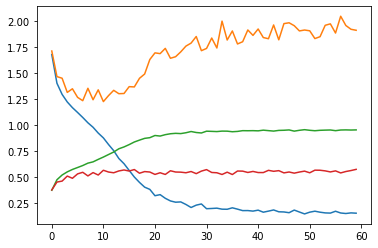

In [10]:
plt.plot(hist)

In [11]:
best_acc

0.5725754314455492

[[ 3.  5.  4. ...  2.  5.  1.]
 [ 5.  4.  4. ...  8.  5.  6.]
 [ 9.  6.  7. ... 17.  5. 17.]
 ...
 [ 6.  0.  1. ... 17.  2.  0.]
 [ 6.  7.  0. ...  8.  2.  5.]
 [ 5.  6.  6. ...  9.  2.  4.]][[ 2.  2.  9. ...  9.  6.  3.]
 [ 1.  1. 11. ... 11. 17. 17.]
 [ 0. 17. 17. ...  8.  6. 17.]
 ...
 [ 1. 17. 12. ...  9.  2.  2.]
 [ 0.  1.  9. ... 17. 17.  1.]
 [ 0.  1.  7. ... 17.  1.  0.]]
[[ 0.  0. 10. ... 10.  0.  0.]
 [ 0. 17. 12. ... 12. 17.  0.]
 [ 2. 17. 16. ... 17. 12.  2.]
 ...
 [ 9. 17.  1. ... 10.  8.  6.]
 [ 6.  1. 17. ... 17.  4.  3.]
 [17.  0.  3. ...  4.  2.  1.]]

[[ 3.  4.  7. ...  1.  7.  0.]
 [ 2.  1.  5. ... 17.  8. 17.]
 [ 1.  1. 17. ... 17.  5. 17.]
 ...
 [17.  1.  0. ...  3. 17.  9.]
 [ 3.  4. 10. ...  2.  3.  6.]
 [ 0.  5.  7. ...  1.  3.  4.]][[ 0.  0.  1. ...  3.  0.  0.]
 [ 0.  7. 11. ...  2.  0.  0.]
 [17. 11. 17. ... 11.  4.  3.]
 ...
 [ 0.  0.  8. ... 17. 17. 17.]
 [ 1.  1.  3. ... 12. 17.  1.]
 [ 5. 17.  2. ...  9. 17.  0.]][[ 0. 17. 17. ...  7.  4.  5.]
 [ 2. 17. 1

 [ 0.  0.  9. ... 17.  7.  5.]][[ 0. 17. 17. ...  0.  0.  4.]
 [ 0.  3. 12. ...  0.  0.  4.]
 [ 1.  8. 13. ...  1.  2.  6.]
 ...
 [ 4.  6.  6. ... 16. 17.  3.]
 [ 4.  5. 11. ... 11.  8.  2.]
 [ 3.  5.  9. ... 17. 17.  1.]]

[[ 3.  2.  4. ...  9.  6.  5.]
 [ 0.  0.  4. ... 11.  7.  6.]
 [ 0.  0. 15. ... 16. 11.  9.]
 ...
 [ 2.  8. 17. ...  0.  1.  9.]
 [ 0. 17. 17. ...  1. 17.  4.]
 [ 0.  2. 17. ...  1.  3.  2.]]


[[ 0.  1.  9. ...  1. 17. 17.]
 [ 3.  1. 11. ...  6. 17. 17.]
 [17. 17. 17. ... 17. 17. 17.]
 ...
 [ 9. 17.  2. ... 14. 10. 17.]
 [ 0. 17. 17. ... 17.  4.  3.]
 [ 0.  0.  9. ... 17.  6.  1.]]
[[ 0.  0.  2. ... 17.  2.  0.]
 [ 0.  0.  4. ...  5. 17.  0.]
 [17. 17. 17. ...  9. 17.  1.]
 ...
 [ 8.  0.  1. ...  8. 17.  0.]
 [ 6.  1.  0. ...  6.  2.  1.]
 [ 5.  2.  1. ...  6.  3.  1.]][[ 5.  6.  7. ... 16. 16. 16.]
 [ 6.  3.  6. ... 16. 16. 16.]
 [ 7.  6.  7. ... 16. 16. 16.]
 ...
 [ 6.  7.  8. ... 16. 16. 16.]
 [ 5.  6.  7. ... 16. 16. 16.]
 [ 5.  6.  8. ... 16. 16. 16.]][[ 1.  1

 [ 0.  0.  2. ... 17.  2.  0.]][[ 5.  4. 17. ...  9.  6.  5.]
 [ 6.  3. 17. ... 11.  7.  6.]
 [17.  4.  8. ... 11.  7.  6.]
 ...
 [ 9.  6.  6. ... 17. 17.  1.]
 [ 6.  6.  5. ... 17.  2.  0.]
 [ 4.  6.  6. ... 17.  1.  0.]]

[[ 4.  3.  3. ...  7.  6.  5.]
 [ 4.  4.  4. ...  7.  5.  3.]
 [ 7.  7.  8. ... 17.  0.  0.]
 ...
 [ 2. 11. 17. ...  7.  8.  9.]
 [ 0.  0. 17. ...  7.  6.  6.]
 [ 0.  0.  2. ...  6.  5.  4.]][[ 5.  6.  9. ...  5.  1.  1.]
 [ 6.  7. 17. ...  6.  0.  1.]
 [ 9. 17. 13. ... 17. 17. 17.]
 ...
 [ 8.  7. 17. ... 10. 17. 17.]
 [ 6.  7.  8. ... 10.  1.  1.]
 [ 5.  4.  6. ...  7.  0.  0.]]

[[ 0.  0.  9. ... 17.  1.  0.]
 [ 6.  7. 11. ... 17.  2.  1.]
 [ 9. 11. 16. ... 14. 17. 17.]
 ...
 [ 0. 17. 10. ... 17. 17. 17.]
 [ 1.  2.  6. ...  3. 17. 17.]
 [ 1. 17.  4. ...  2.  3.  2.]]

[[ 5.  6.  8. ...  3.  0.  0.]
 [ 4.  7. 10. ... 11.  0.  0.]
 [ 2.  3.  2. ... 13. 12.  2.]
 ...
 [ 3.  4. 10. ...  9.  4.  4.]
 [ 5.  6.  7. ...  7.  3.  3.]
 [ 3.  5.  9. ...  5.  2.  2.]][[ 5.  0

 [ 5.  6.  6. ... 17. 17.  2.]][[ 0.  3.  7. ... 17.  1.  1.]
 [ 4.  5. 10. ... 17.  1.  1.]
 [17. 17.  8. ... 15. 17. 17.]
 ...
 [17. 17. 17. ...  5. 17.  1.]
 [ 6.  2.  0. ... 17.  1.  1.]
 [ 4.  3.  0. ...  5. 17.  1.]][[ 5.  5.  9. ...  5.  5.  5.]
 [ 6.  7. 11. ...  6.  5.  6.]
 [ 8.  8.  8. ...  8.  9.  8.]
 ...
 [ 5. 14.  9. ... 14. 12.  9.]
 [ 4.  5.  0. ... 12.  7.  0.]
 [ 2.  3.  0. ... 17.  0.  0.]][[ 0.  0.  2. ...  1. 17. 17.]
 [ 0.  0. 17. ... 17.  0.  0.]
 [ 3. 17. 11. ...  9.  4.  0.]
 ...
 [ 9. 17. 17. ... 17. 17.  8.]
 [17. 17. 17. ...  0. 17. 17.]
 [ 2.  1.  0. ...  1.  0.  1.]]

[[ 5.  3.  3. ...  2.  2.  2.]
 [ 1.  1.  3. ...  3.  3.  2.]
 [ 0.  0.  7. ... 17. 17. 17.]
 ...
 [17. 17.  1. ...  8.  0. 17.]
 [ 0.  0. 17. ...  0.  0. 17.]
 [ 1.  6. 17. ...  0. 17.  5.]]
[[ 1.  2.  5. ...  0.  2. 17.]
 [ 2.  2. 17. ...  4.  0. 17.]
 [17. 17. 17. ...  8.  0. 17.]
 ...
 [ 1.  2. 10. ... 17. 17. 17.]
 [ 0.  0.  4. ...  9. 17.  1.]
 [ 1.  2.  3. ... 17.  4. 17.]][[ 1.  1.  

 [ 1.  2. 17. ... 17. 17.  0.]]
[[ 5.  5.  4. ... 16. 16.  2.]
 [ 7.  8.  8. ... 16. 17.  2.]
 [ 8.  9. 11. ... 16. 17.  0.]
 ...
 [17. 16.  8. ... 17.  2.  7.]
 [ 0.  7. 16. ... 17. 17.  6.]
 [ 1. 17. 16. ... 17.  6.  5.]]
[[ 0.  5. 17. ...  8.  6.  5.]
 [ 6.  7. 17. ...  8.  6.  5.]
 [ 9. 17.  8. ...  8.  6.  5.]
 ...
 [ 0.  0.  8. ...  4.  2. 17.]
 [ 0.  1.  4. ...  2.  6.  5.]
 [ 2.  2.  4. ...  9.  6.  5.]][[ 0.  0.  3. ...  9. 17.  0.]
 [ 0.  1.  4. ... 17.  5.  0.]
 [ 2.  6. 17. ... 17. 12.  1.]
 ...
 [ 1. 17. 17. ...  6. 17.  9.]
 [ 1.  2. 17. ...  4.  6.  5.]
 [ 5.  3. 17. ... 17.  6.  3.]][[ 4.  4.  4. ... 17.  2.  0.]
 [ 4.  5.  6. ... 17.  2.  1.]
 [ 7.  9.  8. ... 17. 17. 17.]
 ...
 [ 7.  8.  7. ...  0.  5.  7.]
 [ 6.  6.  6. ...  1.  5.  6.]
 [ 4.  4.  5. ...  4.  5.  6.]]
[[ 2.  3.  5. ...  9.  6.  5.]
 [ 2.  3.  6. ... 17.  7.  6.]
 [ 0.  2.  6. ... 11. 17. 17.]
 ...
 [ 2. 17. 17. ... 17. 17.  8.]
 [ 0.  0. 17. ... 17.  0.  1.]
 [ 1.  0. 17. ... 17.  0.  0.]][[ 2. 17. 1

 [ 4.  5.  9. ...  9.  7.  5.]]


[[ 0.  5. 17. ... 17.  0.  0.]
 [ 5.  6.  2. ...  2.  0.  0.]
 [ 9. 11.  2. ...  2.  6.  6.]
 ...
 [ 6.  6.  5. ... 11. 17.  5.]
 [ 4.  3.  2. ... 17. 17.  1.]
 [ 4.  3.  2. ...  0. 17.  1.]][[ 5.  6.  9. ...  6.  6.  5.]
 [ 6.  1. 11. ... 17.  7.  6.]
 [ 3. 11. 16. ... 10.  2.  2.]
 ...
 [17. 17.  5. ...  4. 11.  9.]
 [ 7.  1. 17. ...  4. 17.  7.]
 [ 5. 17. 17. ...  2.  4.  5.]][[ 5.  0.  5. ...  1.  2.  5.]
 [ 6.  7. 17. ...  2.  3.  4.]
 [ 5. 10. 17. ... 14. 17. 17.]
 ...
 [ 0.  0.  5. ...  9.  1.  1.]
 [ 2.  1.  6. ... 17.  0.  0.]
 [ 3.  4.  6. ...  4.  2.  0.]][[ 5.  6.  7. ...  3.  1.  0.]
 [ 6.  7.  6. ...  4.  0.  0.]
 [ 6.  7.  6. ...  8. 17. 17.]
 ...
 [ 2.  3.  7. ...  2.  5.  5.]
 [ 0.  0.  4. ...  7.  7.  6.]
 [ 0.  1.  2. ...  6.  6.  5.]]


[[ 1.  1. 17. ... 17.  0.  0.]
 [ 1.  1.  1. ... 17. 17.  8.]
 [17.  7.  7. ... 17. 17. 17.]
 ...
 [ 1. 17. 10. ...  9. 17. 17.]
 [ 0.  2.  7. ...  4.  1.  0.]
 [ 0.  1.  5. ...  3.  0.  0.]][[ 5.  6

 [ 0.  0.  4. ...  1.  1.  1.]]


[[ 1.  5.  9. ...  9.  2.  0.]
 [ 5.  6. 17. ... 11.  7.  4.]
 [ 4.  5.  5. ... 17.  0. 17.]
 ...
 [ 9.  9.  8. ... 17.  5.  1.]
 [ 6.  7.  7. ... 17.  3.  4.]
 [ 4.  5.  6. ...  7.  5.  4.]]
[[ 5.  5.  4. ... 17. 17.  4.]
 [ 5.  6. 17. ... 17.  2.  0.]
 [ 8.  9. 17. ... 11.  2. 17.]
 ...
 [17. 17.  3. ...  0.  7.  9.]
 [17.  0.  0. ...  2.  2.  3.]
 [ 3.  0.  6. ...  3.  3.  4.]][[ 5.  5.  6. ...  6.  5.  5.]
 [ 6.  6.  7. ...  8.  7.  6.]
 [ 4.  7. 17. ... 17.  6.  7.]
 ...
 [17. 17.  4. ... 10. 11.  9.]
 [ 5.  1. 17. ... 17.  1.  0.]
 [ 4.  4.  7. ... 17.  1.  0.]][[ 0.  2. 17. ...  9.  6.  5.]
 [17.  0. 17. ... 11.  7.  6.]
 [ 1.  1.  6. ... 14. 11.  9.]
 ...
 [ 3. 17. 16. ...  6.  0.  0.]
 [ 2.  8. 11. ...  5.  3.  2.]
 [17. 17. 17. ...  6.  8.  4.]][[ 1.  0.  3. ...  4.  2.  2.]
 [ 0.  0.  3. ... 17.  0.  0.]
 [ 1. 17. 17. ...  8.  0.  0.]
 ...
 [ 0.  2. 11. ...  8.  2.  0.]
 [ 0.  1.  4. ...  9.  6.  4.]
 [ 1.  2.  4. ...  6.  5.  5.]]
[[17. 17.

 [ 5.  5.  0. ...  1.  7. 17.]]
[[ 3.  1.  1. ...  5.  6.  5.]
 [ 3.  0.  0. ...  8.  7.  6.]
 [ 9.  5. 12. ...  9.  9.  6.]
 ...
 [ 6.  3.  3. ...  0.  2.  9.]
 [ 6.  4.  3. ...  0. 17.  6.]
 [ 5.  6.  4. ... 17.  6.  4.]][[17.  7. 17. ...  1.  2.  7.]
 [ 2. 10. 12. ... 17.  1.  9.]
 [ 0.  4. 16. ... 17.  0.  1.]
 ...
 [ 2. 17.  9. ...  1. 16.  5.]
 [17. 17.  6. ...  6. 16. 16.]
 [ 5. 17. 17. ... 17. 16. 17.]]


[[16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]]

[[ 1. 17.  9. ...  8.  1.  4.]
 [ 2. 17.  9. ... 17.  0.  0.]
 [17. 17. 17. ... 17. 17.  0.]
 ...
 [17.  2.  0. ... 16. 17. 17.]
 [ 3. 17. 17. ... 17.  2.  1.]
 [ 1. 17. 17. ...  2.  0.  0.]][[ 5.  6. 17. ...  6.  4.  5.]
 [ 6.  4.  4. ... 17. 17.  6.]
 [ 2.  5. 17. ... 10.  6.  3.]
 ...
 [ 7.  8.  3. ...  4.  2.  5.]
 [ 6.  7.  3. ...  2.  0.  0.]
 [ 5.  6.  4. ...  5.  0.  0.]][[17. 17

 [ 5.  5.  5. ...  0.  2.  2.]][[ 0.  0. 17. ...  6.  5.  3.]
 [ 0.  1. 11. ...  6.  7.  6.]
 [ 1. 17. 16. ...  6.  8.  9.]
 ...
 [17. 17. 15. ... 17. 17. 17.]
 [17. 17. 17. ... 11.  1.  0.]
 [ 5.  2.  1. ... 17.  2.  5.]][[ 1.  0.  0. ...  9.  4.  1.]
 [17.  0.  1. ...  7.  7.  6.]
 [17.  3.  9. ...  8. 17.  9.]
 ...
 [ 8.  9. 10. ...  8.  0.  4.]
 [ 4.  6. 17. ...  0. 17. 17.]
 [ 0.  3. 17. ... 17. 17.  4.]][[ 5.  6.  7. ...  0.  1.  5.]
 [ 6.  7.  7. ...  0.  0.  2.]
 [ 7.  7.  9. ... 15.  3.  3.]
 ...
 [ 9. 11. 11. ... 12. 17.  3.]
 [ 6.  7.  6. ... 17.  0.  0.]
 [ 5.  6.  5. ...  1.  0.  0.]][[17.  6.  5. ...  0.  5.  4.]
 [ 4.  7. 12. ... 17.  6.  6.]
 [17. 17. 10. ... 17.  4.  9.]
 ...
 [ 1.  1.  8. ...  8.  8.  7.]
 [ 0.  3. 12. ...  7.  7.  6.]
 [ 0.  4. 10. ...  6.  6.  5.]][[ 4.  6.  9. ...  1.  0.  0.]
 [ 3.  3.  8. ...  2.  0.  2.]
 [ 2.  2.  9. ...  5.  5.  5.]
 ...
 [ 0. 17. 17. ... 12.  8.  4.]
 [ 1.  1.  5. ...  9.  7.  6.]
 [ 5.  1.  3. ...  7.  6.  5.]][[ 2.  2.  5. 

 [ 0.  0.  2. ...  5.  5.  5.]]
[[ 5.  6.  9. ...  3.  6.  5.]
 [ 6.  7. 17. ...  1.  7.  6.]
 [ 9. 11. 14. ...  1.  2.  7.]
 ...
 [ 9. 11. 16. ...  7.  9.  8.]
 [ 6.  7. 11. ...  6.  6.  5.]
 [ 5.  6.  9. ...  5.  4.  4.]]
[[ 1. 17.  1. ...  4.  6.  3.]
 [ 3.  1.  0. ... 17.  4.  2.]
 [ 5.  4.  2. ... 16.  3.  0.]
 ...
 [ 5.  6.  7. ... 11.  0.  7.]
 [ 5.  7.  8. ... 17.  5.  0.]
 [ 5.  6.  8. ... 17. 17.  4.]][[ 0.  0.  2. ...  2.  6.  5.]
 [ 0.  0.  5. ...  7. 17.  6.]
 [ 3.  5.  9. ... 17.  6.  4.]
 ...
 [ 2.  3.  7. ...  7. 17. 16.]
 [ 7. 16. 10. ... 16. 16.  1.]
 [ 5.  8. 10. ... 16. 16. 16.]][[ 1.  0.  5. ...  5.  4.  2.]
 [ 1.  0.  7. ...  5.  5.  3.]
 [ 1. 17.  6. ...  8.  9.  6.]
 ...
 [ 7.  7.  8. ...  9.  6.  3.]
 [ 6.  7.  7. ... 17.  1.  0.]
 [ 5.  6.  7. ...  2.  0.  0.]][[ 0.  0.  3. ...  4.  5.  5.]
 [ 0.  0.  5. ...  5.  6.  6.]
 [ 2.  3.  7. ...  9.  8.  7.]
 ...
 [17. 17. 14. ... 16. 17.  1.]
 [ 0.  6. 12. ... 11.  2.  1.]
 [ 0.  1.  9. ... 17.  2.  2.]]



[[ 5.  5

 [ 0.  0.  3. ...  5.  5.  5.]]
[[17.  0.  0. ...  3.  0.  0.]
 [ 0.  0.  6. ...  6.  0.  0.]
 [ 0. 17. 13. ... 10. 17.  2.]
 ...
 [17. 17. 17. ...  8.  9.  8.]
 [ 0. 17. 11. ...  6.  6.  6.]
 [ 0.  1.  9. ...  5.  5.  5.]][[ 5.  6.  8. ...  5.  7.  5.]
 [ 5.  7. 17. ...  7.  6.  6.]
 [ 6. 17.  0. ...  7.  9.  9.]
 ...
 [ 9. 11. 17. ... 16. 17. 17.]
 [ 0.  7. 17. ... 17. 17.  0.]
 [ 0.  0. 17. ... 17. 17.  1.]][[ 2.  4.  5. ... 17.  6.  0.]
 [ 2.  8.  7. ... 17.  2.  1.]
 [ 8. 12. 10. ... 14. 17. 17.]
 ...
 [17.  0.  7. ... 12. 17.  7.]
 [ 2.  0.  0. ... 17.  6.  5.]
 [17.  2.  0. ... 17. 17.  0.]][[ 0.  4. 17. ...  6.  4.  5.]
 [ 0. 17. 17. ...  7.  6.  6.]
 [17. 17.  2. ...  7. 10.  9.]
 ...
 [ 0. 17. 17. ... 14. 17.  2.]
 [ 2.  7. 17. ... 17.  1.  0.]
 [ 4. 17.  9. ...  3.  1.  0.]]

[[ 1.  1. 17. ...  9.  5.  1.]
 [ 2.  2. 17. ... 17.  1.  1.]
 [ 9. 17. 16. ...  0.  0. 17.]
 ...
 [ 1. 17.  9. ... 10.  4.  4.]
 [ 1.  2.  6. ...  0.  2.  2.]
 [ 1.  4. 17. ...  0.  2.  5.]]

[[ 5.  3.

 [ 0.  1.  5. ... 17. 17.  0.]][[ 0.  1.  4. ... 17.  0. 17.]
 [ 0.  1.  6. ... 11.  3.  2.]
 [17. 17.  9. ... 16. 17. 17.]
 ...
 [11. 16. 16. ...  2. 17.  9.]
 [ 2. 17.  3. ...  3.  6.  6.]
 [ 0.  0.  1. ... 17.  6.  5.]]





[[17.  6. 17. ...  1.  6.  5.]
 [17.  7. 17. ... 17.  7. 17.]
 [17. 11. 17. ... 17.  0.  9.]
 ...
 [17. 10. 17. ...  9.  9. 16.]
 [ 6. 17.  5. ...  5.  3.  6.]
 [ 2.  3.  5. ... 17.  3.  0.]][[ 4.  6.  9. ...  6.  6.  5.]
 [ 3.  5. 11. ...  3.  4.  6.]
 [ 4.  6. 11. ...  3. 17.  9.]
 ...
 [17. 17.  2. ...  6.  0.  0.]
 [ 6.  8.  1. ...  6.  3.  3.]
 [ 4.  7. 17. ...  6.  5.  3.]][[17. 17. 17. ...  3. 17. 17.]
 [17.  3.  0. ... 17.  2. 17.]
 [ 1. 17.  1. ... 15. 17. 17.]
 ...
 [ 2.  3. 10. ... 14.  3.  3.]
 [ 0.  0.  4. ... 11.  2.  3.]
 [ 0.  0.  3. ...  9.  2.  3.]]
[[ 0.  6. 17. ... 17.  1. 17.]
 [ 1.  7.  7. ...  0.  7.  1.]
 [17. 17. 17. ... 17.  0.  9.]
 ...
 [ 0.  1. 17. ... 17.  1.  8.]
 [ 5.  4.  7. ... 17. 17.  0.]
 [ 5.  6. 17. ... 17.  6.  5.]][[ 3.  

 [ 1.  0.  3. ... 17.  1.  0.]][[ 0.  1.  9. ... 17.  5.  0.]
 [ 0. 17. 11. ... 17. 17. 17.]
 [17. 17. 17. ... 17. 17.  9.]
 ...
 [ 9.  2. 17. ... 16.  3.  0.]
 [ 5. 17.  1. ... 17.  3.  0.]
 [ 4. 17.  1. ... 17. 17.  2.]]
[[ 1. 17.  3. ...  4.  1.  0.]
 [ 0.  0.  3. ...  5.  1.  0.]
 [ 0.  3.  9. ...  8. 17.  1.]
 ...
 [ 4. 17. 14. ...  2. 17.  9.]
 [ 0.  4. 12. ...  3.  3. 17.]
 [ 1.  0. 17. ...  7.  5.  4.]][[ 0.  0. 17. ... 17.  5.  3.]
 [ 2.  2. 17. ... 17.  6.  4.]
 [ 9. 11. 16. ... 17. 17.  9.]
 ...
 [ 2.  4.  8. ...  5.  4. 17.]
 [ 3.  3.  7. ...  2.  0.  0.]
 [ 2.  3.  6. ...  2.  0.  0.]]
[[ 5.  5.  5. ... 17.  6.  5.]
 [17.  4.  1. ...  4.  4.  6.]
 [ 7. 17.  5. ... 17. 17.  9.]
 ...
 [17. 17. 16. ... 17.  3.  2.]
 [17.  0. 17. ...  5.  0.  0.]
 [ 5.  0.  0. ...  3.  0.  0.]]


[[ 5.  5.  6. ...  0.  2.  5.]
 [ 6.  2.  0. ...  0.  1. 17.]
 [ 7.  2.  2. ... 15. 17. 17.]
 ...
 [ 2.  1. 16. ...  4.  6.  8.]
 [ 2.  5. 11. ...  3.  5.  6.]
 [ 3.  4. 17. ...  7.  8.  6.]]
[[ 1.  0

 [ 4.  3.  4. ...  9.  5.  4.]][[ 5.  5.  4. ...  9.  0.  0.]
 [ 4.  4. 17. ... 17.  2.  0.]
 [ 7.  8. 17. ... 17. 12. 17.]
 ...
 [ 4. 17. 17. ... 17. 17. 17.]
 [ 1.  7. 11. ... 17.  2. 17.]
 [ 1. 17.  9. ...  1.  0.  0.]]

[[ 0. 17. 17. ...  4.  3.  3.]
 [ 0. 17. 17. ...  6.  6.  6.]
 [ 1. 10. 14. ... 12. 11.  9.]
 ...
 [ 6.  4.  0. ... 16. 17.  1.]
 [ 4.  0.  0. ... 10.  2.  2.]
 [ 4.  2.  1. ...  2.  1.  5.]][[ 2.  6.  0. ...  5.  5.  5.]
 [ 5.  7.  0. ...  6.  6.  6.]
 [ 8. 17.  1. ...  7.  8.  7.]
 ...
 [ 7. 10. 12. ... 13. 17.  0.]
 [ 2.  4.  0. ...  4.  0.  1.]
 [ 1.  3.  0. ...  2.  0. 17.]][[17.  2.  4. ...  6.  4. 17.]
 [ 1.  0.  4. ... 16.  7.  4.]
 [17.  0.  8. ... 17. 11. 10.]
 ...
 [17.  0.  3. ...  5.  2.  5.]
 [ 2.  0.  2. ...  0.  1.  6.]
 [ 3.  6.  6. ...  0. 17.  4.]][[ 0.  1. 17. ...  5.  5.  4.]
 [ 0.  1. 17. ...  6.  6.  7.]
 [17. 17. 17. ...  7.  9.  9.]
 ...
 [ 3. 17. 12. ... 16. 17.  0.]
 [ 2.  6.  8. ... 12.  0.  1.]
 [ 2.  2.  9. ... 17.  0. 17.]]



[[ 2.  3

 [ 2.  0. 17. ...  4.  3.  2.]][[ 0.  1. 17. ...  3.  0.  1.]
 [ 0.  1. 17. ...  4.  0.  0.]
 [ 1. 17.  9. ... 11. 17.  1.]
 ...
 [17. 17.  9. ...  8.  6. 17.]
 [17.  2.  2. ...  6.  7.  6.]
 [ 0.  0.  1. ... 17.  6.  3.]]


[[ 5.  6.  9. ...  5. 17.  2.]
 [ 6.  7. 11. ... 17.  0.  1.]
 [ 3.  4. 16. ... 17.  2. 17.]
 ...
 [17. 17. 16. ...  9.  4.  2.]
 [ 0.  2. 17. ... 10.  3.  2.]
 [ 0.  1.  3. ...  7.  3.  2.]][[ 2.  1.  4. ...  8.  4.  1.]
 [ 0.  0.  6. ...  8.  3.  0.]
 [ 0. 17.  8. ... 10. 17.  1.]
 ...
 [ 7.  9. 17. ... 15. 11. 17.]
 [ 6.  4.  5. ... 17.  0.  0.]
 [ 5.  5.  4. ...  2.  0.  0.]][[ 0.  2. 17. ...  7.  6.  5.]
 [ 0. 17. 12. ...  8.  7.  6.]
 [ 1. 13. 17. ...  8.  5.  7.]
 ...
 [ 2. 17.  0. ... 10. 11.  9.]
 [ 2.  7.  0. ...  7.  6.  6.]
 [17.  6. 17. ...  4.  3.  3.]]



[[ 4.  6.  9. ...  3.  0.  0.]
 [ 6.  5.  8. ...  5.  0.  0.]
 [ 5.  6.  8. ...  8. 17.  1.]
 ...
 [ 9. 17.  0. ... 17. 17. 17.]
 [ 6. 17.  0. ...  9.  7.  5.]
 [ 4.  6. 17. ...  9.  6.  3.]][[ 5.  

 [ 1.  1. 17. ... 17.  1.  1.]][[ 5.  5.  4. ...  9.  3.  2.]
 [ 7.  6.  5. ... 12.  4.  3.]
 [ 8.  8.  8. ... 15. 17. 17.]
 ...
 [ 1.  2. 14. ... 17. 17.  8.]
 [ 1.  0. 17. ... 17.  3.  7.]
 [ 1.  0.  3. ...  1.  0.  0.]][[17. 17. 17. ...  9.  4.  3.]
 [17.  7. 10. ... 17.  4.  5.]
 [17. 17. 16. ...  8.  0.  6.]
 ...
 [ 2.  0.  7. ... 17. 17.  9.]
 [ 1.  0.  5. ...  1.  6.  6.]
 [ 2.  1.  4. ...  6.  5.  4.]]
[[17. 17. 17. ...  8.  6.  5.]
 [ 2. 17.  5. ...  2.  7.  4.]
 [17. 17. 10. ...  0. 17.  8.]
 ...
 [17.  3.  7. ...  6.  4.  3.]
 [ 3.  0.  6. ...  6.  4.  3.]
 [ 1.  3.  6. ...  6.  3.  3.]]

[[ 0.  1.  5. ...  0.  1.  5.]
 [ 0.  1.  6. ...  1.  0.  6.]
 [ 1. 17.  6. ...  8.  0. 17.]
 ...
 [ 1. 17. 11. ... 17. 17.  0.]
 [ 1.  0.  3. ... 17.  1.  0.]
 [17.  0.  0. ...  9.  1.  1.]]

[[ 0.  6.  1. ...  4. 17.  5.]
 [17. 17. 17. ... 17. 17.  4.]
 [17.  1. 17. ...  3. 17.  1.]
 ...
 [ 3.  6.  5. ...  8.  2.  0.]
 [ 2.  3.  3. ...  5.  2.  2.]
 [ 5.  6.  4. ...  5.  2.  3.]][[ 5.  5.

 [ 3.  6.  7. ...  7.  6.  5.]][[17.  2. 17. ... 17.  1.  1.]
 [ 0.  1. 17. ... 12.  1.  1.]
 [ 2. 17. 10. ... 17. 17.  0.]
 ...
 [ 9.  8.  5. ... 10.  9.  9.]
 [ 6.  5.  4. ...  6.  5.  6.]
 [ 4.  4.  5. ...  3.  3.  4.]]
[[16.  5.  1. ... 17.  2.  5.]
 [ 8.  7.  0. ...  3.  5.  6.]
 [ 8.  8.  0. ...  1. 10.  6.]
 ...
 [ 9. 11.  8. ...  8.  8.  8.]
 [ 4.  8.  7. ...  6.  6.  6.]
 [ 3.  6.  5. ...  5.  5.  5.]]
[[ 5.  6.  6. ...  2.  0.  0.]
 [ 6. 17.  0. ... 11.  0.  0.]
 [ 1.  2. 17. ... 15. 17. 17.]
 ...
 [17. 12.  8. ...  8.  4.  4.]
 [ 3.  6. 17. ...  1.  2.  2.]
 [ 1.  4. 10. ...  1.  2.  2.]][[ 0.  1. 17. ...  3.  1.  1.]
 [ 0.  0. 17. ... 17.  2.  1.]
 [ 3.  4. 12. ... 17. 17. 17.]
 ...
 [ 0.  0.  8. ...  1.  1.  2.]
 [ 1.  3.  6. ...  1.  2.  5.]
 [ 2.  4.  7. ...  8.  6.  5.]]



[[ 0.  1.  4. ...  1.  1. 17.]
 [ 0.  1.  7. ...  4.  0.  0.]
 [ 1.  2. 11. ...  8.  3.  1.]
 ...
 [ 3.  7. 12. ... 17.  3.  1.]
 [ 1.  6. 11. ... 17.  7.  3.]
 [ 2.  5.  9. ... 17.  6. 17.]]

[[ 4. 

 [ 5.  6.  4. ...  0.  5.  5.]]
[[ 5. 17.  5. ...  9.  6.  5.]
 [17.  2. 17. ... 11.  7.  6.]
 [17. 17. 17. ... 16. 11.  9.]
 ...
 [ 6.  7.  8. ...  3.  0.  0.]
 [ 5.  7.  8. ... 17.  6.  0.]
 [ 5.  6.  8. ...  9.  6.  2.]]
[[ 5.  6.  9. ... 17.  6.  5.]
 [ 6.  7. 11. ...  4. 17. 17.]
 [ 9. 11. 16. ...  8. 17. 17.]
 ...
 [ 9. 11. 16. ...  8. 17.  1.]
 [ 6.  7. 11. ...  8.  0.  1.]
 [ 5.  6.  9. ...  9.  4.  2.]][[ 0.  0.  1. ... 17. 17.  1.]
 [ 1.  0. 17. ... 17.  2.  0.]
 [ 4. 11. 16. ... 16. 17.  0.]
 ...
 [ 7.  1. 17. ...  8. 11. 17.]
 [ 6.  1. 17. ... 17.  7.  0.]
 [ 5.  2. 17. ...  9. 17.  0.]]
[[ 0. 17.  1. ...  0.  5.  3.]
 [ 1.  0.  4. ...  3.  6.  5.]
 [ 1.  3.  9. ... 17.  8.  9.]
 ...
 [ 0.  0. 17. ... 17. 17.  1.]
 [ 0.  3.  7. ...  3.  0.  0.]
 [ 3.  6.  7. ...  3.  1.  0.]]
[[ 0.  0.  3. ...  7.  6.  5.]
 [ 0.  0. 17. ...  7.  7.  6.]
 [ 2. 17. 17. ... 11.  8.  6.]
 ...
 [17. 17. 17. ... 15. 10.  7.]
 [ 0.  3. 11. ... 10.  7.  6.]
 [ 5.  1.  9. ...  7.  6.  5.]]



[[ 1. 

 [ 0.  2. 17. ... 17.  1.  0.]][[ 0.  2.  8. ...  1.  0.  1.]
 [ 0.  5. 12. ...  4.  0.  0.]
 [17. 17. 11. ...  7.  3.  3.]
 ...
 [ 2.  2. 13. ...  1.  0. 17.]
 [ 1.  1.  4. ...  8.  5.  5.]
 [ 0.  2.  4. ...  8.  7.  5.]]


[[ 2. 17. 17. ...  9.  6.  5.]
 [ 2. 17.  7. ... 11.  7.  6.]
 [17. 17. 10. ... 16. 11.  9.]
 ...
 [ 1. 17.  7. ... 17.  2.  8.]
 [ 0.  0. 17. ...  1.  0.  5.]
 [ 0.  1.  3. ...  2.  0.  4.]][[ 5.  5.  5. ...  5.  3.  2.]
 [ 6.  6.  6. ...  7.  3.  0.]
 [ 8.  9.  9. ...  8.  3.  2.]
 ...
 [17. 17. 17. ... 10.  1.  6.]
 [ 3.  5.  8. ...  6.  2.  6.]
 [ 5.  7. 16. ...  1. 17.  5.]]



[[ 0. 17.  9. ... 17.  1. 17.]
 [17. 17.  7. ... 11.  1. 17.]
 [17. 11.  8. ... 17.  0. 17.]
 ...
 [ 7. 17.  1. ...  7. 11.  5.]
 [ 5.  6.  1. ...  8.  8.  5.]
 [ 5.  4.  1. ...  5. 17.  5.]][[ 4.  0.  0. ...  0.  5.  5.]
 [ 7.  0.  0. ...  0.  6.  6.]
 [17.  4.  4. ...  1.  8.  7.]
 ...
 [ 7. 17.  2. ... 10. 17.  1.]
 [ 6.  6. 17. ... 11.  4.  1.]
 [ 5.  6.  8. ...  9.  7.  1.]]
[[ 0. 

 [ 4.  0.  3. ... 17. 17.  5.]][[17. 17. 17. ...  3.  2.  0.]
 [ 2. 17. 12. ...  4.  1.  1.]
 [ 3.  5. 17. ... 17.  1.  1.]
 ...
 [ 7.  6.  3. ...  2.  1.  1.]
 [ 6.  7.  6. ...  6.  6.  5.]
 [ 5.  6.  6. ...  8.  6.  5.]]


[[17.  2. 17. ... 17.  6.  1.]
 [17.  2. 17. ... 17.  2. 17.]
 [ 3.  8. 12. ... 14. 17.  9.]
 ...
 [ 1.  1. 12. ... 14.  2.  0.]
 [17.  2.  6. ... 11.  3.  0.]
 [17.  2.  1. ...  9. 17.  1.]][[ 5.  6.  6. ...  4.  1.  0.]
 [ 6.  7.  7. ...  6.  1.  0.]
 [ 7.  8.  6. ...  9. 17.  1.]
 ...
 [ 4.  5.  8. ... 17. 17. 17.]
 [ 3.  7. 11. ... 11.  0.  0.]
 [ 2.  6.  9. ...  2.  0.  0.]][[ 2.  1.  2. ...  9.  6.  0.]
 [ 3.  3.  3. ... 17.  5.  3.]
 [ 6.  7.  8. ...  1. 17.  8.]
 ...
 [17. 17. 16. ...  7. 12. 17.]
 [ 6. 17.  0. ... 13.  6.  2.]
 [ 5.  6.  9. ... 10. 17. 17.]]

[[ 3.  3. 17. ...  2.  4.  5.]
 [ 6.  4.  4. ...  4.  4.  6.]
 [ 5.  3.  3. ...  9.  9.  8.]
 ...
 [ 2.  3.  6. ... 17. 17.  4.]
 [ 0.  0. 17. ... 17. 17.  1.]
 [ 0.  0.  3. ... 17. 17. 17.]]
[[ 4.  3

 [ 1.  3.  5. ... 17.  9.  0.]]

[[ 0.  4. 17. ...  6.  6.  4.]
 [ 4.  7. 17. ...  8.  7.  6.]
 [ 9. 11.  7. ...  7.  8.  9.]
 ...
 [ 1. 17. 15. ... 17. 17.  1.]
 [ 1.  3. 17. ...  7.  1.  0.]
 [ 1.  3. 17. ...  4.  1.  0.]]


[[ 0. 17. 17. ...  4.  2.  1.]
 [ 4.  7.  6. ...  5.  1.  0.]
 [ 8. 11.  8. ...  8. 17. 17.]
 ...
 [ 9. 11. 16. ... 16. 11.  9.]
 [ 6.  7. 11. ... 11.  7.  6.]
 [ 5.  6.  9. ...  9.  6.  5.]][[ 5.  6.  6. ...  1. 17.  5.]
 [ 6.  7.  8. ... 17. 17.  2.]
 [17. 17. 17. ... 12. 17. 17.]
 ...
 [ 5.  6.  2. ... 17. 17. 17.]
 [ 4.  4.  4. ... 17.  4.  3.]
 [ 5.  4.  5. ... 17.  0.  0.]][[ 4. 17.  0. ...  8.  5.  3.]
 [ 7. 17. 17. ...  8.  6.  2.]
 [10. 17. 17. ...  8.  4.  1.]
 ...
 [ 0.  1.  5. ... 15.  0.  3.]
 [ 0.  0.  2. ... 11.  0. 17.]
 [ 5.  2.  3. ...  9.  1.  3.]]
[[ 0.  6.  9. ... 17.  0.  1.]
 [ 5.  6. 17. ... 17.  1.  1.]
 [17. 17. 17. ... 11. 17.  3.]
 ...
 [ 8.  8.  8. ...  8.  9.  3.]
 [ 6.  6.  6. ...  6.  5.  6.]
 [ 5.  5.  5. ...  4. 17.  5.]]



[[ 5

 [ 0.  3.  6. ...  9.  6.  2.]][[ 5.  6.  0. ...  3.  5.  5.]
 [ 6.  0. 17. ...  4.  6.  7.]
 [ 0. 17. 17. ... 17. 17.  7.]
 ...
 [ 0. 17. 17. ...  6.  2.  4.]
 [17.  7. 17. ...  0.  1.  1.]
 [17. 17.  3. ...  1.  1. 17.]][[ 0.  0.  3. ...  0.  2.  5.]
 [ 0.  1.  3. ...  1. 17.  6.]
 [17. 13. 17. ... 17. 17.  8.]
 ...
 [ 8. 17.  0. ...  6.  7.  6.]
 [ 6.  1.  1. ...  2.  4.  6.]
 [ 4.  0. 17. ...  5.  6.  5.]]



[[ 1.  1.  5. ... 10.  1.  0.]
 [ 0.  1.  8. ... 17. 17.  0.]
 [ 0. 17. 10. ... 17. 17.  1.]
 ...
 [ 1. 17. 16. ... 17.  0.  7.]
 [ 0. 17. 11. ...  3.  0.  7.]
 [ 0. 17.  9. ...  1.  6.  7.]]



[[ 0.  0.  6. ... 17. 17.  1.]
 [ 0.  0. 17. ... 17.  5.  1.]
 [ 9. 17. 17. ... 11. 17.  9.]
 ...
 [17. 17.  9. ... 17.  2.  2.]
 [ 1.  1.  6. ...  7. 17.  2.]
 [ 1.  1.  4. ...  6.  6.  3.]]
[[ 0.  1.  4. ...  4.  0.  1.]
 [ 0.  1.  5. ...  4.  0.  0.]
 [ 1. 17.  8. ...  6.  2.  0.]
 ...
 [17. 17. 14. ... 13. 17.  1.]
 [ 2.  4. 12. ... 17. 17.  3.]
 [ 0.  0.  9. ... 17.  6.  5.]][[ 0.

 [ 0.  1. 17. ...  0.  0.  2.]]


[[ 0.  0. 17. ...  4.  0.  0.]
 [ 0. 17. 16. ... 17.  0.  0.]
 [ 4. 16.  4. ... 16.  4.  1.]
 ...
 [ 4.  6. 14. ... 17. 17.  2.]
 [ 1.  1.  2. ... 17.  4.  2.]
 [ 1.  1.  0. ...  0.  3. 17.]]
[[ 5.  7.  0. ...  6.  6.  5.]
 [ 0.  8. 17. ...  8.  7.  6.]
 [ 0.  0. 15. ...  8.  8.  7.]
 ...
 [ 6. 17. 17. ...  3.  2. 17.]
 [ 5.  7. 17. ...  7.  6.  4.]
 [ 5.  6.  9. ...  7.  4.  2.]][[ 0.  0.  1. ...  9.  2.  0.]
 [ 1. 17. 17. ... 11.  6.  2.]
 [17. 17. 13. ...  7. 17. 17.]
 ...
 [ 1. 17. 14. ... 17. 17. 17.]
 [ 7.  7.  9. ... 17.  2.  1.]
 [ 5. 17.  1. ... 17.  1.  0.]][[ 0.  1.  3. ...  6.  2.  0.]
 [ 0. 17.  5. ...  6. 17.  0.]
 [ 2. 17. 13. ...  8. 17.  2.]
 ...
 [ 0.  0.  2. ... 17. 17. 17.]
 [ 8.  8. 17. ... 11. 17.  2.]
 [ 7.  6. 17. ... 17.  2.  0.]]


[[ 5.  1.  0. ...  9.  5.  0.]
 [ 1.  0.  2. ... 17.  7.  5.]
 [ 0.  2.  9. ...  3. 17.  9.]
 ...
 [17. 17.  8. ...  9. 17.  1.]
 [ 2.  2.  6. ...  5.  1.  0.]
 [ 0.  2.  5. ...  4.  1.  0.]][[17.  

 [ 3.  0.  0. ...  3.  1.  0.]]
[[ 5.  6.  7. ...  9.  6.  0.]
 [ 6.  7.  8. ... 17.  7.  5.]
 [ 6.  7.  7. ...  9. 17. 17.]
 ...
 [17.  0.  8. ...  7. 17.  2.]
 [17.  2.  0. ...  6.  3.  0.]
 [17.  2.  0. ...  5.  1.  0.]][[ 2.  4.  4. ...  5.  1.  2.]
 [ 4.  5.  6. ...  5.  1.  1.]
 [17. 10.  9. ...  8. 17. 17.]
 ...
 [16. 16. 16. ... 10.  9.  7.]
 [16. 16. 16. ...  5.  7.  6.]
 [16. 16. 16. ...  4.  6.  5.]]


[[ 5.  6.  8. ... 16. 16. 16.]
 [ 4.  6.  7. ... 16. 16. 16.]
 [ 4.  5.  9. ... 16. 16. 16.]
 ...
 [ 2.  1. 16. ...  8. 17.  2.]
 [17. 17.  3. ...  5.  2.  1.]
 [ 5.  6.  0. ...  5.  2.  1.]][[ 0.  3. 17. ...  2.  5.  1.]
 [ 0.  7. 17. ...  4. 17.  7.]
 [ 9. 11. 17. ... 14. 17.  9.]
 ...
 [ 2.  2.  5. ... 17. 11. 17.]
 [ 0.  0.  4. ...  2.  6. 17.]
 [ 0.  0. 17. ...  0. 17.  5.]][[17.  1. 17. ...  6.  3.  3.]
 [ 1. 17. 17. ...  7.  3.  3.]
 [ 1. 17. 17. ...  8.  3.  2.]
 ...
 [17. 17.  9. ... 17. 17.  0.]
 [ 1.  1.  6. ...  5.  3.  2.]
 [ 1.  2.  5. ...  2.  3.  1.]]

[[ 5. 17

 [ 0.  4.  6. ...  3.  0. 17.]]
[[16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [ 6.  7.  6. ...  9.  6.  5.]
 [ 6.  6.  7. ... 17.  2.  2.]
 [ 5.  5.  6. ... 17.  1.  1.]]
[[ 0.  3.  4. ...  5. 17.  0.]
 [ 0. 17. 12. ...  7. 17.  5.]
 [ 2.  2. 15. ... 17. 17.  2.]
 ...
 [ 9. 11. 15. ... 17. 17. 17.]
 [ 6.  7. 17. ... 17. 17.  6.]
 [ 0.  0. 17. ...  1.  2. 17.]][[17.  6. 17. ...  9.  0.  0.]
 [ 4.  7.  8. ... 11. 17.  0.]
 [ 5.  8. 17. ... 17. 17.  2.]
 ...
 [ 9. 17. 15. ... 16. 17.  2.]
 [ 6.  2. 17. ... 11.  0.  0.]
 [ 5.  1.  1. ...  4.  0.  2.]]

[[ 5.  6.  9. ...  7.  6.  1.]
 [ 5.  6. 17. ...  9.  5.  1.]
 [ 6.  7. 17. ... 11. 17.  2.]
 ...
 [ 0.  7. 17. ...  7.  4.  5.]
 [ 4.  4. 17. ...  1.  0.  2.]
 [17.  1.  1. ...  1.  0.  1.]][[ 1.  7. 17. ...  7.  2.  2.]
 [ 0.  9. 12. ...  9.  4.  1.]
 [ 2. 17. 15. ...  9. 17.  0.]
 ...
 [ 9.  2.  0. ... 17.  8.  6.]
 [ 1. 17. 17. ...  7.  7.  6.]
 [17.  5. 17. ...  6.  6.  5.]]

[[ 5.  6

 [ 5.  5.  2. ... 17.  3.  0.]]

[[ 0.  0.  3. ...  1.  0.  0.]
 [ 0.  0.  4. ... 17.  0.  1.]
 [ 2.  3. 13. ... 17.  3.  3.]
 ...
 [ 6. 17. 17. ... 17.  6.  9.]
 [17.  0. 17. ...  6.  8.  9.]
 [ 2.  0. 17. ...  5.  5.  4.]][[ 4.  6.  6. ...  5.  4.  4.]
 [ 6.  7.  8. ...  4.  4.  4.]
 [ 9.  7.  7. ...  6.  6.  6.]
 ...
 [ 5.  5.  3. ... 17. 17.  9.]
 [ 5.  2.  5. ...  0.  1.  2.]
 [ 4.  4.  7. ...  1.  2.  2.]]

[[ 0.  2. 17. ...  2.  0.  0.]
 [ 6.  7. 17. ... 17. 17. 17.]
 [ 8. 17.  0. ... 13. 17. 17.]
 ...
 [17. 17.  1. ...  6. 17. 17.]
 [ 4.  2. 17. ...  4.  3.  6.]
 [ 1. 17. 17. ...  5.  6.  5.]][[ 5.  6.  9. ... 17.  0.  0.]
 [ 6.  7. 17. ... 17. 17.  0.]
 [ 9. 11. 14. ... 12.  9.  2.]
 ...
 [17.  1.  1. ... 17. 17. 17.]
 [ 6.  2.  1. ...  6.  3.  0.]
 [ 4.  6.  2. ...  6.  0.  0.]]

[[ 0.  6.  9. ...  8.  6.  5.]
 [ 3.  7. 17. ...  0.  5.  2.]
 [17.  0. 17. ...  3.  6.  2.]
 ...
 [ 0.  1.  7. ... 17. 17.  7.]
 [ 0.  0.  2. ...  0. 17. 17.]
 [ 5.  6.  3. ... 17.  6.  5.]][[ 0. 17

 [ 5.  6. 17. ... 17.  1.  1.]][[ 0.  0. 17. ... 17.  0.  0.]
 [ 3. 17. 15. ... 13. 17. 17.]
 [17. 17. 16. ... 17. 17. 17.]
 ...
 [17.  3. 17. ... 17.  0.  3.]
 [ 5. 17.  6. ...  4.  0.  5.]
 [ 4.  6.  6. ...  8.  5.  5.]]

[[ 2.  2. 17. ... 17.  0. 17.]
 [ 4.  2.  3. ... 17.  0.  0.]
 [ 6.  7. 10. ... 17. 17.  0.]
 ...
 [ 7.  8. 11. ... 16.  2.  3.]
 [ 4.  6. 17. ... 17.  0.  0.]
 [ 5.  3.  0. ... 17.  0.  0.]][[ 2.  0. 17. ...  2.  2.  2.]
 [ 2.  1. 17. ... 17.  2.  2.]
 [ 9. 11. 14. ... 17. 17.  9.]
 ...
 [ 0.  8. 17. ... 17. 17.  9.]
 [ 0.  0. 17. ... 17. 17.  6.]
 [ 1.  0. 17. ...  4.  2.  4.]]

[[ 5.  0.  8. ...  3.  0.  0.]
 [ 0. 17. 17. ...  4.  0.  0.]
 [ 0. 17. 17. ...  9.  2.  2.]
 ...
 [ 9.  9. 17. ... 17. 17.  1.]
 [ 1.  0. 17. ... 11.  7.  0.]
 [ 0.  0. 17. ...  9.  6.  1.]][[ 5.  6.  9. ... 17.  0.  1.]
 [ 4.  7. 10. ...  6.  0.  0.]
 [ 5.  7.  8. ...  6. 17.  0.]
 ...
 [17. 17.  0. ...  8.  8.  9.]
 [ 5.  6.  7. ...  5.  5.  6.]
 [ 0.  4.  6. ...  4.  4.  4.]]

[[ 5.  1

 [ 6.  2.  0. ...  4.  8.  2.]]
[[ 4.  5.  5. ...  3.  2. 17.]
 [ 5.  5.  6. ... 17. 17. 17.]
 [ 9.  7.  7. ... 16. 17. 17.]
 ...
 [ 1.  0.  1. ...  7.  4.  3.]
 [ 3.  5. 10. ...  9.  4.  3.]
 [ 4.  4.  9. ... 17.  4.  2.]]
[[ 0.  6. 17. ... 17.  5.  0.]
 [ 0.  6. 17. ...  6.  8.  5.]
 [ 7. 10.  8. ... 10. 17.  9.]
 ...
 [ 2. 11. 17. ... 17.  2. 17.]
 [ 6.  7. 17. ...  8.  2.  0.]
 [ 5. 17.  5. ...  7.  4.  1.]]
[[ 0.  0. 17. ...  6.  4.  4.]
 [ 0.  1.  2. ...  6.  4.  4.]
 [ 5.  5.  6. ...  2.  4.  5.]
 ...
 [ 0.  0.  5. ...  7.  5.  7.]
 [ 0.  0.  5. ...  4. 17.  6.]
 [ 2.  2. 17. ...  2. 17.  5.]][[ 4.  5.  6. ...  1.  0.  1.]
 [ 7.  6.  6. ... 17. 17.  8.]
 [ 9.  7.  6. ... 17. 17. 17.]
 ...
 [ 8.  4.  0. ... 15. 17.  0.]
 [ 4.  3.  1. ... 17. 17.  1.]
 [ 4.  5.  6. ...  2. 17. 17.]]

[[ 5.  6.  5. ...  0. 17.  5.]
 [ 6.  5.  7. ...  0. 17. 17.]
 [ 8.  8.  7. ... 17.  5.  0.]
 ...
 [ 9.  7.  0. ... 10. 17. 17.]
 [ 7.  6.  0. ...  6.  3.  0.]
 [ 4.  7.  5. ...  3.  0.  0.]]
[[ 4.  4

 [ 5. 17.  0. ...  1.  2.  3.]]

[[ 0.  1.  5. ...  5.  5.  5.]
 [ 1.  3.  6. ...  5.  6.  5.]
 [17. 17.  7. ...  6.  8.  7.]
 ...
 [17. 11. 17. ...  0. 17.  7.]
 [ 6.  7. 11. ...  0.  1.  6.]
 [17.  1. 17. ...  3. 17.  5.]][[ 5.  4.  4. ...  9.  6.  5.]
 [ 4.  5.  6. ... 10.  6.  4.]
 [ 8.  9. 10. ...  9.  6.  4.]
 ...
 [ 0. 17.  7. ... 11.  6.  2.]
 [ 1. 17. 17. ... 17. 17.  0.]
 [ 4.  2. 17. ... 17.  0.  0.]]

[[ 1.  0.  0. ...  5.  2.  3.]
 [17.  0. 17. ...  2.  2.  4.]
 [17.  3.  8. ...  3. 17.  9.]
 ...
 [ 8.  9.  8. ... 10.  6. 17.]
 [ 6.  7.  7. ... 11.  6.  4.]
 [ 5.  5.  5. ...  9.  6.  0.]][[17. 17.  5. ...  4.  5.  5.]
 [17.  9.  6. ...  5.  6.  6.]
 [ 2. 11.  7. ...  9.  8.  8.]
 ...
 [ 9. 17.  0. ...  8.  8.  9.]
 [ 5.  0.  2. ...  7.  7.  7.]
 [ 3.  1.  8. ...  5.  6.  5.]]

[[ 1.  0.  3. ...  5.  5.  5.]
 [ 0.  0. 17. ...  6.  6.  6.]
 [ 0.  4. 17. ...  6.  9.  8.]
 ...
 [17. 17.  2. ... 16. 17.  2.]
 [ 6. 17.  2. ... 17. 10.  2.]
 [ 4.  6.  9. ... 17.  9. 17.]][[ 5.  6

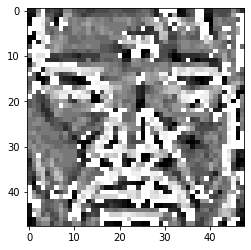

In [29]:
images, labels = next(iter(train_loader))

img = images[0]
lb = labels[0]
plt.imshow(img[0], cmap='gray')

In [55]:
img

tensor([[[ 1.0000,  0.9373,  0.9373,  ..., -1.0000, -1.0000,  0.9922],
         [ 1.0000,  0.9843,  0.9686,  ..., -1.0000, -1.0000,  0.9843],
         [ 0.9373,  0.9373,  0.9451,  ...,  0.9922,  1.0000,  0.9765],
         ...,
         [ 0.9765,  0.9686,  0.9686,  ...,  0.9373,  0.9765,  1.0000],
         [ 0.9843,  0.9843,  0.9843,  ...,  0.9373,  0.9922, -1.0000],
         [ 0.9843,  0.9843,  0.9843,  ...,  0.9765,  0.9922,  0.9843]]])

In [11]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_1_lbphg.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.300 acc: 0.172
	 - Step 2: loss: 2.308 acc: 0.125
	 - Step 3: loss: 2.137 acc: 0.203
	 - Step 4: loss: 2.059 acc: 0.172
	 - Step 5: loss: 1.844 acc: 0.203
	 - Step 6: loss: 2.183 acc: 0.141
	 - Step 7: loss: 2.301 acc: 0.156
	 - Step 8: loss: 2.127 acc: 0.172
	 - Step 9: loss: 2.240 acc: 0.141
	 - Step 10: loss: 1.983 acc: 0.203
	 - Step 11: loss: 2.103 acc: 0.219
	 - Step 12: loss: 2.096 acc: 0.203
	 - Step 13: loss: 2.002 acc: 0.203
	 - Step 14: loss: 1.886 acc: 0.250
	 - Step 15: loss: 1.946 acc: 0.312
	 - Step 16: loss: 1.909 acc: 0.156
	 - Step 17: loss: 1.941 acc: 0.250
	 - Step 18: loss: 1.929 acc: 0.250
	 - Step 19: loss: 2.075 acc: 0.219
	 - Step 20: loss: 2.031 acc: 0.203
	 - Step 21: loss: 1.902 acc: 0.219
	 - Step 22: loss: 2.103 acc: 0.266
	 - Step 23: loss: 1.860 acc: 0.297
	 - Step 24: loss: 1.942 acc: 0.188
	 - Step 25: loss: 1.885 acc: 0.297
	 - Step 26: loss: 2.055 acc: 0.172
	 - Step 27: loss: 1.981 acc: 0.219
	 - Step 28: loss: 2.050 ac

	 - Step 227: loss: 1.705 acc: 0.359
	 - Step 228: loss: 1.822 acc: 0.312
	 - Step 229: loss: 1.711 acc: 0.344
	 - Step 230: loss: 1.525 acc: 0.469
	 - Step 231: loss: 1.624 acc: 0.344
	 - Step 232: loss: 1.676 acc: 0.375
	 - Step 233: loss: 1.757 acc: 0.312
	 - Step 234: loss: 1.654 acc: 0.359
	 - Step 235: loss: 1.606 acc: 0.453
	 - Step 236: loss: 1.787 acc: 0.281
	 - Step 237: loss: 1.682 acc: 0.375
	 - Step 238: loss: 1.649 acc: 0.391
	 - Step 239: loss: 1.742 acc: 0.297
	 - Step 240: loss: 1.672 acc: 0.344
	 - Step 241: loss: 1.591 acc: 0.375
	 - Step 242: loss: 1.616 acc: 0.375
	 - Step 243: loss: 1.572 acc: 0.438
	 - Step 244: loss: 1.513 acc: 0.438
	 - Step 245: loss: 1.516 acc: 0.438
	 - Step 246: loss: 1.712 acc: 0.312
	 - Step 247: loss: 1.425 acc: 0.531
	 - Step 248: loss: 1.602 acc: 0.359
	 - Step 249: loss: 1.745 acc: 0.344
	 - Step 250: loss: 1.875 acc: 0.328
	 - Step 251: loss: 1.638 acc: 0.359
	 - Step 252: loss: 1.558 acc: 0.375
	 - Step 253: loss: 1.517 acc: 0.469
	

	 - Step 449: loss: 1.405 acc: 0.459
- Avg.loss: 1.720  | Avg.acc: 0.333
- Avg. val_loss: 1.543  | Avg. val_acc: 0.414
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.756 acc: 0.328
	 - Step 2: loss: 1.462 acc: 0.359
	 - Step 3: loss: 1.520 acc: 0.438
	 - Step 4: loss: 1.543 acc: 0.469
	 - Step 5: loss: 1.389 acc: 0.531
	 - Step 6: loss: 1.501 acc: 0.453
	 - Step 7: loss: 1.429 acc: 0.500
	 - Step 8: loss: 1.514 acc: 0.406
	 - Step 9: loss: 1.405 acc: 0.438
	 - Step 10: loss: 1.588 acc: 0.375
	 - Step 11: loss: 1.516 acc: 0.438
	 - Step 12: loss: 1.347 acc: 0.500
	 - Step 13: loss: 1.270 acc: 0.578
	 - Step 14: loss: 1.385 acc: 0.453
	 - Step 15: loss: 1.519 acc: 0.406
	 - Step 16: loss: 1.451 acc: 0.484
	 - Step 17: loss: 1.374 acc: 0.484
	 - Step 18: loss: 1.298 acc: 0.547
	 - Step 19: loss: 1.561 acc: 0.438
	 - Step 20: loss: 1.527 acc: 0.438
	 - Step 21: loss: 1.593 acc: 0.359
	 - Step 22: loss: 1.426 acc: 0.516
	 - Step 23: loss: 1.542 acc: 0.422
	 - Step 24: loss: 1.678 acc: 0.375
	 - Step 25: loss: 1.439 acc: 0.438
	 - Step 26: loss: 1.373 acc: 0.562
	 - Step 27: loss: 1.377 acc: 0.500
	 - Step 28: loss: 1.489 acc: 0.375
	

	 - Step 227: loss: 1.426 acc: 0.484
	 - Step 228: loss: 1.566 acc: 0.406
	 - Step 229: loss: 1.368 acc: 0.438
	 - Step 230: loss: 1.301 acc: 0.516
	 - Step 231: loss: 1.379 acc: 0.500
	 - Step 232: loss: 1.442 acc: 0.469
	 - Step 233: loss: 1.389 acc: 0.516
	 - Step 234: loss: 1.414 acc: 0.484
	 - Step 235: loss: 1.430 acc: 0.484
	 - Step 236: loss: 1.506 acc: 0.484
	 - Step 237: loss: 1.351 acc: 0.469
	 - Step 238: loss: 1.160 acc: 0.562
	 - Step 239: loss: 1.366 acc: 0.453
	 - Step 240: loss: 1.386 acc: 0.469
	 - Step 241: loss: 1.260 acc: 0.531
	 - Step 242: loss: 1.442 acc: 0.453
	 - Step 243: loss: 1.339 acc: 0.516
	 - Step 244: loss: 1.441 acc: 0.438
	 - Step 245: loss: 1.509 acc: 0.391
	 - Step 246: loss: 1.202 acc: 0.656
	 - Step 247: loss: 1.183 acc: 0.594
	 - Step 248: loss: 1.434 acc: 0.453
	 - Step 249: loss: 1.412 acc: 0.406
	 - Step 250: loss: 1.475 acc: 0.453
	 - Step 251: loss: 1.389 acc: 0.531
	 - Step 252: loss: 1.259 acc: 0.547
	 - Step 253: loss: 1.305 acc: 0.484
	

	 - Step 449: loss: 0.984 acc: 0.703
- Avg.loss: 1.387  | Avg.acc: 0.480
- Avg. val_loss: 1.461  | Avg. val_acc: 0.462
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.183 acc: 0.547
	 - Step 2: loss: 1.259 acc: 0.594
	 - Step 3: loss: 1.272 acc: 0.422
	 - Step 4: loss: 1.397 acc: 0.516
	 - Step 5: loss: 1.378 acc: 0.516
	 - Step 6: loss: 1.390 acc: 0.422
	 - Step 7: loss: 1.168 acc: 0.531
	 - Step 8: loss: 1.331 acc: 0.531
	 - Step 9: loss: 1.273 acc: 0.516
	 - Step 10: loss: 1.320 acc: 0.438
	 - Step 11: loss: 1.210 acc: 0.531
	 - Step 12: loss: 1.247 acc: 0.547
	 - Step 13: loss: 1.352 acc: 0.469
	 - Step 14: loss: 1.218 acc: 0.562
	 - Step 15: loss: 1.364 acc: 0.547
	 - Step 16: loss: 1.439 acc: 0.438
	 - Step 17: loss: 1.194 acc: 0.531
	 - Step 18: loss: 1.224 acc: 0.562
	 - Step 19: loss: 1.260 acc: 0.516
	 - Step 20: loss: 1.212 acc: 0.562
	 - Step 21: loss: 1.348 acc: 0.484
	 - Step 22: loss: 1.216 acc: 0.578
	 - Step 23: loss: 1.249 acc: 0.547
	 - Step 24: loss: 1.400 acc:

	 - Step 223: loss: 1.403 acc: 0.484
	 - Step 224: loss: 1.376 acc: 0.469
	 - Step 225: loss: 1.549 acc: 0.422
	 - Step 226: loss: 1.291 acc: 0.484
	 - Step 227: loss: 1.203 acc: 0.562
	 - Step 228: loss: 1.279 acc: 0.516
	 - Step 229: loss: 1.253 acc: 0.484
	 - Step 230: loss: 1.175 acc: 0.625
	 - Step 231: loss: 1.234 acc: 0.531
	 - Step 232: loss: 1.313 acc: 0.516
	 - Step 233: loss: 1.496 acc: 0.453
	 - Step 234: loss: 1.255 acc: 0.547
	 - Step 235: loss: 1.126 acc: 0.516
	 - Step 236: loss: 1.231 acc: 0.562
	 - Step 237: loss: 1.308 acc: 0.484
	 - Step 238: loss: 1.313 acc: 0.531
	 - Step 239: loss: 1.226 acc: 0.547
	 - Step 240: loss: 1.303 acc: 0.484
	 - Step 241: loss: 1.093 acc: 0.656
	 - Step 242: loss: 1.281 acc: 0.516
	 - Step 243: loss: 1.219 acc: 0.562
	 - Step 244: loss: 1.150 acc: 0.516
	 - Step 245: loss: 1.346 acc: 0.484
	 - Step 246: loss: 1.274 acc: 0.500
	 - Step 247: loss: 1.315 acc: 0.578
	 - Step 248: loss: 1.339 acc: 0.453
	 - Step 249: loss: 1.303 acc: 0.531
	

	 - Step 445: loss: 1.119 acc: 0.578
	 - Step 446: loss: 1.564 acc: 0.406
	 - Step 447: loss: 1.339 acc: 0.469
	 - Step 448: loss: 1.167 acc: 0.547
	 - Step 449: loss: 1.077 acc: 0.595
- Avg.loss: 1.262  | Avg.acc: 0.531
- Avg. val_loss: 1.272  | Avg. val_acc: 0.531
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.238 acc: 0.578
	 - Step 2: loss: 1.262 acc: 0.547
	 - Step 3: loss: 1.175 acc: 0.547
	 - Step 4: loss: 1.210 acc: 0.641
	 - Step 5: loss: 1.000 acc: 0.625
	 - Step 6: loss: 1.125 acc: 0.641
	 - Step 7: loss: 1.287 acc: 0.500
	 - Step 8: loss: 1.299 acc: 0.562
	 - Step 9: loss: 1.277 acc: 0.469
	 - Step 10: loss: 1.019 acc: 0.672
	 - Step 11: loss: 1.299 acc: 0.516
	 - Step 12: loss: 1.112 acc: 0.594
	 - Step 13: loss: 1.006 acc: 0.672
	 - Step 14: loss: 1.231 acc: 0.578
	 - Step 15: loss: 1.295 acc: 0.500
	 - Step 16: loss: 1.115 acc: 0.609
	 - Step 17: loss: 1.094 acc: 0.578
	 - Step 18: loss: 1.389 acc: 0.500
	 - Step 19: loss: 1.158 acc: 0.609
	 - Step 20: loss: 1.322 

	 - Step 219: loss: 1.373 acc: 0.516
	 - Step 220: loss: 1.189 acc: 0.562
	 - Step 221: loss: 0.978 acc: 0.703
	 - Step 222: loss: 1.329 acc: 0.500
	 - Step 223: loss: 1.081 acc: 0.656
	 - Step 224: loss: 1.118 acc: 0.562
	 - Step 225: loss: 1.159 acc: 0.562
	 - Step 226: loss: 1.435 acc: 0.469
	 - Step 227: loss: 1.164 acc: 0.547
	 - Step 228: loss: 1.094 acc: 0.594
	 - Step 229: loss: 1.142 acc: 0.594
	 - Step 230: loss: 1.208 acc: 0.531
	 - Step 231: loss: 1.282 acc: 0.531
	 - Step 232: loss: 1.412 acc: 0.438
	 - Step 233: loss: 0.992 acc: 0.594
	 - Step 234: loss: 1.092 acc: 0.641
	 - Step 235: loss: 0.976 acc: 0.594
	 - Step 236: loss: 1.252 acc: 0.469
	 - Step 237: loss: 1.151 acc: 0.516
	 - Step 238: loss: 1.278 acc: 0.484
	 - Step 239: loss: 1.157 acc: 0.578
	 - Step 240: loss: 1.079 acc: 0.609
	 - Step 241: loss: 1.156 acc: 0.531
	 - Step 242: loss: 1.085 acc: 0.594
	 - Step 243: loss: 1.209 acc: 0.609
	 - Step 244: loss: 1.233 acc: 0.547
	 - Step 245: loss: 1.125 acc: 0.609
	

	 - Step 441: loss: 1.038 acc: 0.625
	 - Step 442: loss: 1.155 acc: 0.672
	 - Step 443: loss: 1.261 acc: 0.578
	 - Step 444: loss: 1.116 acc: 0.578
	 - Step 445: loss: 1.084 acc: 0.656
	 - Step 446: loss: 1.199 acc: 0.609
	 - Step 447: loss: 1.035 acc: 0.656
	 - Step 448: loss: 1.201 acc: 0.578
	 - Step 449: loss: 1.160 acc: 0.568
- Avg.loss: 1.187  | Avg.acc: 0.563
- Avg. val_loss: 1.298  | Avg. val_acc: 0.516
Epoch:  5
	 - Step 1: loss: 1.103 acc: 0.625
	 - Step 2: loss: 1.092 acc: 0.625
	 - Step 3: loss: 1.195 acc: 0.500
	 - Step 4: loss: 1.230 acc: 0.547
	 - Step 5: loss: 1.310 acc: 0.594
	 - Step 6: loss: 1.105 acc: 0.656
	 - Step 7: loss: 1.139 acc: 0.547
	 - Step 8: loss: 1.101 acc: 0.625
	 - Step 9: loss: 1.176 acc: 0.516
	 - Step 10: loss: 1.081 acc: 0.578
	 - Step 11: loss: 1.124 acc: 0.500
	 - Step 12: loss: 0.936 acc: 0.766
	 - Step 13: loss: 1.015 acc: 0.656
	 - Step 14: loss: 1.202 acc: 0.531
	 - Step 15: loss: 0.839 acc: 0.656
	 - Step 16: loss: 0.937 acc: 0.703
	 - Step

	 - Step 215: loss: 0.986 acc: 0.688
	 - Step 216: loss: 1.204 acc: 0.484
	 - Step 217: loss: 1.265 acc: 0.562
	 - Step 218: loss: 1.269 acc: 0.578
	 - Step 219: loss: 1.270 acc: 0.500
	 - Step 220: loss: 1.039 acc: 0.641
	 - Step 221: loss: 1.032 acc: 0.609
	 - Step 222: loss: 1.005 acc: 0.688
	 - Step 223: loss: 1.274 acc: 0.422
	 - Step 224: loss: 1.006 acc: 0.641
	 - Step 225: loss: 1.202 acc: 0.547
	 - Step 226: loss: 1.251 acc: 0.469
	 - Step 227: loss: 1.152 acc: 0.531
	 - Step 228: loss: 1.107 acc: 0.516
	 - Step 229: loss: 0.999 acc: 0.656
	 - Step 230: loss: 1.120 acc: 0.609
	 - Step 231: loss: 1.279 acc: 0.516
	 - Step 232: loss: 1.203 acc: 0.594
	 - Step 233: loss: 1.184 acc: 0.609
	 - Step 234: loss: 1.216 acc: 0.578
	 - Step 235: loss: 1.157 acc: 0.516
	 - Step 236: loss: 1.184 acc: 0.609
	 - Step 237: loss: 1.110 acc: 0.547
	 - Step 238: loss: 1.011 acc: 0.625
	 - Step 239: loss: 1.074 acc: 0.641
	 - Step 240: loss: 1.031 acc: 0.609
	 - Step 241: loss: 0.968 acc: 0.656
	

	 - Step 437: loss: 1.084 acc: 0.672
	 - Step 438: loss: 1.028 acc: 0.656
	 - Step 439: loss: 1.093 acc: 0.562
	 - Step 440: loss: 1.350 acc: 0.500
	 - Step 441: loss: 0.817 acc: 0.750
	 - Step 442: loss: 1.239 acc: 0.531
	 - Step 443: loss: 1.409 acc: 0.516
	 - Step 444: loss: 1.119 acc: 0.656
	 - Step 445: loss: 1.276 acc: 0.562
	 - Step 446: loss: 1.004 acc: 0.625
	 - Step 447: loss: 1.092 acc: 0.547
	 - Step 448: loss: 1.063 acc: 0.594
	 - Step 449: loss: 0.874 acc: 0.676
- Avg.loss: 1.140  | Avg.acc: 0.581
- Avg. val_loss: 1.293  | Avg. val_acc: 0.502
Epoch:  6
	 - Step 1: loss: 0.842 acc: 0.719
	 - Step 2: loss: 1.032 acc: 0.578
	 - Step 3: loss: 0.937 acc: 0.656
	 - Step 4: loss: 0.996 acc: 0.656
	 - Step 5: loss: 1.070 acc: 0.562
	 - Step 6: loss: 1.217 acc: 0.594
	 - Step 7: loss: 1.070 acc: 0.641
	 - Step 8: loss: 1.210 acc: 0.531
	 - Step 9: loss: 1.163 acc: 0.562
	 - Step 10: loss: 1.018 acc: 0.688
	 - Step 11: loss: 0.912 acc: 0.703
	 - Step 12: loss: 1.215 acc: 0.500
	 - 

	 - Step 211: loss: 1.054 acc: 0.641
	 - Step 212: loss: 1.203 acc: 0.500
	 - Step 213: loss: 0.892 acc: 0.672
	 - Step 214: loss: 1.069 acc: 0.641
	 - Step 215: loss: 1.144 acc: 0.500
	 - Step 216: loss: 1.149 acc: 0.578
	 - Step 217: loss: 1.142 acc: 0.562
	 - Step 218: loss: 1.080 acc: 0.641
	 - Step 219: loss: 1.282 acc: 0.531
	 - Step 220: loss: 1.019 acc: 0.625
	 - Step 221: loss: 1.192 acc: 0.531
	 - Step 222: loss: 1.016 acc: 0.703
	 - Step 223: loss: 1.209 acc: 0.469
	 - Step 224: loss: 1.153 acc: 0.562
	 - Step 225: loss: 1.157 acc: 0.594
	 - Step 226: loss: 1.219 acc: 0.547
	 - Step 227: loss: 1.224 acc: 0.594
	 - Step 228: loss: 1.221 acc: 0.484
	 - Step 229: loss: 1.058 acc: 0.656
	 - Step 230: loss: 1.256 acc: 0.516
	 - Step 231: loss: 1.121 acc: 0.562
	 - Step 232: loss: 1.292 acc: 0.547
	 - Step 233: loss: 1.038 acc: 0.641
	 - Step 234: loss: 0.941 acc: 0.672
	 - Step 235: loss: 1.183 acc: 0.547
	 - Step 236: loss: 0.978 acc: 0.625
	 - Step 237: loss: 1.092 acc: 0.594
	

	 - Step 433: loss: 1.050 acc: 0.578
	 - Step 434: loss: 0.997 acc: 0.672
	 - Step 435: loss: 1.077 acc: 0.609
	 - Step 436: loss: 1.215 acc: 0.547
	 - Step 437: loss: 0.991 acc: 0.609
	 - Step 438: loss: 1.167 acc: 0.625
	 - Step 439: loss: 0.949 acc: 0.625
	 - Step 440: loss: 1.059 acc: 0.562
	 - Step 441: loss: 1.374 acc: 0.438
	 - Step 442: loss: 1.339 acc: 0.500
	 - Step 443: loss: 0.829 acc: 0.750
	 - Step 444: loss: 1.151 acc: 0.562
	 - Step 445: loss: 1.075 acc: 0.562
	 - Step 446: loss: 0.836 acc: 0.719
	 - Step 447: loss: 1.188 acc: 0.609
	 - Step 448: loss: 0.977 acc: 0.703
	 - Step 449: loss: 1.181 acc: 0.541
- Avg.loss: 1.099  | Avg.acc: 0.597
- Avg. val_loss: 1.207  | Avg. val_acc: 0.547
* Update optimal model
Epoch:  7
	 - Step 1: loss: 0.966 acc: 0.625
	 - Step 2: loss: 1.028 acc: 0.609
	 - Step 3: loss: 0.863 acc: 0.672
	 - Step 4: loss: 0.979 acc: 0.672
	 - Step 5: loss: 1.039 acc: 0.562
	 - Step 6: loss: 1.075 acc: 0.562
	 - Step 7: loss: 1.122 acc: 0.531
	 - Step 8:

	 - Step 207: loss: 1.204 acc: 0.562
	 - Step 208: loss: 1.039 acc: 0.609
	 - Step 209: loss: 1.039 acc: 0.641
	 - Step 210: loss: 0.995 acc: 0.625
	 - Step 211: loss: 1.101 acc: 0.578
	 - Step 212: loss: 1.029 acc: 0.562
	 - Step 213: loss: 1.151 acc: 0.656
	 - Step 214: loss: 1.241 acc: 0.516
	 - Step 215: loss: 0.911 acc: 0.641
	 - Step 216: loss: 1.084 acc: 0.641
	 - Step 217: loss: 0.969 acc: 0.625
	 - Step 218: loss: 1.041 acc: 0.609
	 - Step 219: loss: 1.054 acc: 0.594
	 - Step 220: loss: 0.957 acc: 0.578
	 - Step 221: loss: 1.049 acc: 0.609
	 - Step 222: loss: 1.265 acc: 0.516
	 - Step 223: loss: 1.103 acc: 0.578
	 - Step 224: loss: 1.038 acc: 0.562
	 - Step 225: loss: 0.972 acc: 0.672
	 - Step 226: loss: 1.044 acc: 0.641
	 - Step 227: loss: 0.887 acc: 0.703
	 - Step 228: loss: 1.250 acc: 0.469
	 - Step 229: loss: 1.020 acc: 0.656
	 - Step 230: loss: 0.770 acc: 0.734
	 - Step 231: loss: 1.100 acc: 0.578
	 - Step 232: loss: 1.215 acc: 0.562
	 - Step 233: loss: 0.969 acc: 0.688
	

	 - Step 429: loss: 1.165 acc: 0.562
	 - Step 430: loss: 1.155 acc: 0.547
	 - Step 431: loss: 1.056 acc: 0.609
	 - Step 432: loss: 1.086 acc: 0.609
	 - Step 433: loss: 1.143 acc: 0.531
	 - Step 434: loss: 1.077 acc: 0.688
	 - Step 435: loss: 1.134 acc: 0.609
	 - Step 436: loss: 1.010 acc: 0.688
	 - Step 437: loss: 1.125 acc: 0.609
	 - Step 438: loss: 0.915 acc: 0.750
	 - Step 439: loss: 0.963 acc: 0.609
	 - Step 440: loss: 0.916 acc: 0.672
	 - Step 441: loss: 1.343 acc: 0.500
	 - Step 442: loss: 1.209 acc: 0.578
	 - Step 443: loss: 1.013 acc: 0.609
	 - Step 444: loss: 1.213 acc: 0.562
	 - Step 445: loss: 1.050 acc: 0.578
	 - Step 446: loss: 1.301 acc: 0.562
	 - Step 447: loss: 0.904 acc: 0.656
	 - Step 448: loss: 1.023 acc: 0.656
	 - Step 449: loss: 0.781 acc: 0.757
- Avg.loss: 1.061  | Avg.acc: 0.612
- Avg. val_loss: 1.130  | Avg. val_acc: 0.578
* Update optimal model
Epoch:  8
	 - Step 1: loss: 1.109 acc: 0.516
	 - Step 2: loss: 1.297 acc: 0.531
	 - Step 3: loss: 0.973 acc: 0.719
	 -

	 - Step 203: loss: 1.146 acc: 0.578
	 - Step 204: loss: 1.060 acc: 0.672
	 - Step 205: loss: 1.104 acc: 0.594
	 - Step 206: loss: 1.045 acc: 0.641
	 - Step 207: loss: 1.063 acc: 0.578
	 - Step 208: loss: 0.894 acc: 0.672
	 - Step 209: loss: 0.921 acc: 0.703
	 - Step 210: loss: 1.231 acc: 0.562
	 - Step 211: loss: 1.190 acc: 0.547
	 - Step 212: loss: 1.182 acc: 0.578
	 - Step 213: loss: 0.802 acc: 0.766
	 - Step 214: loss: 0.867 acc: 0.703
	 - Step 215: loss: 1.171 acc: 0.594
	 - Step 216: loss: 0.928 acc: 0.719
	 - Step 217: loss: 0.940 acc: 0.656
	 - Step 218: loss: 1.025 acc: 0.609
	 - Step 219: loss: 1.039 acc: 0.656
	 - Step 220: loss: 0.957 acc: 0.625
	 - Step 221: loss: 1.121 acc: 0.562
	 - Step 222: loss: 0.958 acc: 0.672
	 - Step 223: loss: 0.921 acc: 0.641
	 - Step 224: loss: 0.893 acc: 0.656
	 - Step 225: loss: 1.137 acc: 0.578
	 - Step 226: loss: 1.104 acc: 0.578
	 - Step 227: loss: 0.978 acc: 0.641
	 - Step 228: loss: 1.106 acc: 0.609
	 - Step 229: loss: 0.959 acc: 0.641
	

	 - Step 425: loss: 0.980 acc: 0.625
	 - Step 426: loss: 1.030 acc: 0.594
	 - Step 427: loss: 1.139 acc: 0.609
	 - Step 428: loss: 1.163 acc: 0.562
	 - Step 429: loss: 0.983 acc: 0.609
	 - Step 430: loss: 0.909 acc: 0.672
	 - Step 431: loss: 0.822 acc: 0.688
	 - Step 432: loss: 0.837 acc: 0.703
	 - Step 433: loss: 1.120 acc: 0.562
	 - Step 434: loss: 1.298 acc: 0.500
	 - Step 435: loss: 1.021 acc: 0.641
	 - Step 436: loss: 0.927 acc: 0.625
	 - Step 437: loss: 0.973 acc: 0.703
	 - Step 438: loss: 0.977 acc: 0.656
	 - Step 439: loss: 1.102 acc: 0.562
	 - Step 440: loss: 1.056 acc: 0.641
	 - Step 441: loss: 1.176 acc: 0.531
	 - Step 442: loss: 1.396 acc: 0.453
	 - Step 443: loss: 0.892 acc: 0.656
	 - Step 444: loss: 1.081 acc: 0.609
	 - Step 445: loss: 0.941 acc: 0.719
	 - Step 446: loss: 0.978 acc: 0.625
	 - Step 447: loss: 1.040 acc: 0.609
	 - Step 448: loss: 1.237 acc: 0.578
	 - Step 449: loss: 0.930 acc: 0.622
- Avg.loss: 1.028  | Avg.acc: 0.625
- Avg. val_loss: 1.149  | Avg. val_acc:

	 - Step 199: loss: 1.023 acc: 0.703
	 - Step 200: loss: 1.198 acc: 0.500
	 - Step 201: loss: 1.140 acc: 0.609
	 - Step 202: loss: 0.847 acc: 0.719
	 - Step 203: loss: 1.008 acc: 0.594
	 - Step 204: loss: 1.030 acc: 0.625
	 - Step 205: loss: 0.949 acc: 0.688
	 - Step 206: loss: 0.852 acc: 0.703
	 - Step 207: loss: 1.031 acc: 0.609
	 - Step 208: loss: 1.002 acc: 0.641
	 - Step 209: loss: 1.087 acc: 0.578
	 - Step 210: loss: 1.104 acc: 0.609
	 - Step 211: loss: 0.962 acc: 0.625
	 - Step 212: loss: 0.921 acc: 0.625
	 - Step 213: loss: 1.188 acc: 0.562
	 - Step 214: loss: 1.011 acc: 0.625
	 - Step 215: loss: 0.826 acc: 0.688
	 - Step 216: loss: 0.903 acc: 0.609
	 - Step 217: loss: 1.137 acc: 0.609
	 - Step 218: loss: 1.172 acc: 0.531
	 - Step 219: loss: 1.115 acc: 0.594
	 - Step 220: loss: 1.089 acc: 0.562
	 - Step 221: loss: 0.980 acc: 0.703
	 - Step 222: loss: 0.846 acc: 0.703
	 - Step 223: loss: 0.970 acc: 0.625
	 - Step 224: loss: 0.920 acc: 0.625
	 - Step 225: loss: 1.152 acc: 0.547
	

	 - Step 421: loss: 1.170 acc: 0.500
	 - Step 422: loss: 0.942 acc: 0.656
	 - Step 423: loss: 1.020 acc: 0.625
	 - Step 424: loss: 0.869 acc: 0.609
	 - Step 425: loss: 1.332 acc: 0.531
	 - Step 426: loss: 1.018 acc: 0.609
	 - Step 427: loss: 1.214 acc: 0.641
	 - Step 428: loss: 0.972 acc: 0.609
	 - Step 429: loss: 1.092 acc: 0.594
	 - Step 430: loss: 0.970 acc: 0.688
	 - Step 431: loss: 0.796 acc: 0.672
	 - Step 432: loss: 1.017 acc: 0.625
	 - Step 433: loss: 0.901 acc: 0.656
	 - Step 434: loss: 0.994 acc: 0.672
	 - Step 435: loss: 0.936 acc: 0.609
	 - Step 436: loss: 0.936 acc: 0.641
	 - Step 437: loss: 1.081 acc: 0.562
	 - Step 438: loss: 1.176 acc: 0.578
	 - Step 439: loss: 1.073 acc: 0.672
	 - Step 440: loss: 1.079 acc: 0.562
	 - Step 441: loss: 0.899 acc: 0.656
	 - Step 442: loss: 0.881 acc: 0.734
	 - Step 443: loss: 0.988 acc: 0.641
	 - Step 444: loss: 1.050 acc: 0.547
	 - Step 445: loss: 1.116 acc: 0.625
	 - Step 446: loss: 1.107 acc: 0.547
	 - Step 447: loss: 0.940 acc: 0.719
	

	 - Step 195: loss: 0.921 acc: 0.656
	 - Step 196: loss: 0.913 acc: 0.703
	 - Step 197: loss: 1.094 acc: 0.609
	 - Step 198: loss: 0.956 acc: 0.609
	 - Step 199: loss: 0.899 acc: 0.641
	 - Step 200: loss: 0.982 acc: 0.641
	 - Step 201: loss: 0.788 acc: 0.719
	 - Step 202: loss: 1.031 acc: 0.609
	 - Step 203: loss: 0.871 acc: 0.609
	 - Step 204: loss: 0.911 acc: 0.672
	 - Step 205: loss: 0.851 acc: 0.703
	 - Step 206: loss: 1.013 acc: 0.578
	 - Step 207: loss: 0.941 acc: 0.656
	 - Step 208: loss: 1.044 acc: 0.609
	 - Step 209: loss: 0.878 acc: 0.672
	 - Step 210: loss: 1.072 acc: 0.562
	 - Step 211: loss: 0.757 acc: 0.719
	 - Step 212: loss: 0.921 acc: 0.625
	 - Step 213: loss: 1.094 acc: 0.641
	 - Step 214: loss: 0.860 acc: 0.750
	 - Step 215: loss: 0.864 acc: 0.703
	 - Step 216: loss: 0.853 acc: 0.703
	 - Step 217: loss: 0.861 acc: 0.688
	 - Step 218: loss: 0.922 acc: 0.703
	 - Step 219: loss: 0.940 acc: 0.672
	 - Step 220: loss: 0.841 acc: 0.688
	 - Step 221: loss: 1.010 acc: 0.625
	

	 - Step 417: loss: 0.901 acc: 0.672
	 - Step 418: loss: 0.913 acc: 0.672
	 - Step 419: loss: 0.981 acc: 0.531
	 - Step 420: loss: 0.867 acc: 0.719
	 - Step 421: loss: 1.000 acc: 0.594
	 - Step 422: loss: 0.932 acc: 0.703
	 - Step 423: loss: 0.876 acc: 0.719
	 - Step 424: loss: 1.099 acc: 0.625
	 - Step 425: loss: 1.021 acc: 0.656
	 - Step 426: loss: 0.926 acc: 0.641
	 - Step 427: loss: 0.928 acc: 0.609
	 - Step 428: loss: 0.834 acc: 0.672
	 - Step 429: loss: 0.924 acc: 0.641
	 - Step 430: loss: 0.817 acc: 0.750
	 - Step 431: loss: 0.987 acc: 0.656
	 - Step 432: loss: 1.006 acc: 0.609
	 - Step 433: loss: 0.926 acc: 0.688
	 - Step 434: loss: 0.915 acc: 0.641
	 - Step 435: loss: 1.078 acc: 0.578
	 - Step 436: loss: 0.952 acc: 0.656
	 - Step 437: loss: 0.957 acc: 0.625
	 - Step 438: loss: 1.072 acc: 0.594
	 - Step 439: loss: 1.202 acc: 0.625
	 - Step 440: loss: 1.027 acc: 0.609
	 - Step 441: loss: 0.812 acc: 0.688
	 - Step 442: loss: 0.990 acc: 0.672
	 - Step 443: loss: 1.059 acc: 0.625
	

	 - Step 191: loss: 0.956 acc: 0.625
	 - Step 192: loss: 0.792 acc: 0.703
	 - Step 193: loss: 0.683 acc: 0.812
	 - Step 194: loss: 0.757 acc: 0.656
	 - Step 195: loss: 0.736 acc: 0.688
	 - Step 196: loss: 0.829 acc: 0.750
	 - Step 197: loss: 0.850 acc: 0.688
	 - Step 198: loss: 0.861 acc: 0.672
	 - Step 199: loss: 0.879 acc: 0.688
	 - Step 200: loss: 1.051 acc: 0.594
	 - Step 201: loss: 0.919 acc: 0.609
	 - Step 202: loss: 0.931 acc: 0.672
	 - Step 203: loss: 0.913 acc: 0.656
	 - Step 204: loss: 1.184 acc: 0.562
	 - Step 205: loss: 0.847 acc: 0.719
	 - Step 206: loss: 0.955 acc: 0.703
	 - Step 207: loss: 0.855 acc: 0.625
	 - Step 208: loss: 0.956 acc: 0.656
	 - Step 209: loss: 0.731 acc: 0.688
	 - Step 210: loss: 0.882 acc: 0.609
	 - Step 211: loss: 0.730 acc: 0.750
	 - Step 212: loss: 1.011 acc: 0.625
	 - Step 213: loss: 0.975 acc: 0.703
	 - Step 214: loss: 0.722 acc: 0.750
	 - Step 215: loss: 0.955 acc: 0.609
	 - Step 216: loss: 0.976 acc: 0.641
	 - Step 217: loss: 0.942 acc: 0.688
	

	 - Step 413: loss: 0.871 acc: 0.719
	 - Step 414: loss: 1.060 acc: 0.609
	 - Step 415: loss: 1.098 acc: 0.609
	 - Step 416: loss: 1.003 acc: 0.688
	 - Step 417: loss: 0.873 acc: 0.719
	 - Step 418: loss: 0.958 acc: 0.656
	 - Step 419: loss: 1.031 acc: 0.656
	 - Step 420: loss: 0.881 acc: 0.719
	 - Step 421: loss: 0.966 acc: 0.672
	 - Step 422: loss: 0.792 acc: 0.703
	 - Step 423: loss: 0.941 acc: 0.625
	 - Step 424: loss: 0.801 acc: 0.625
	 - Step 425: loss: 0.831 acc: 0.672
	 - Step 426: loss: 0.930 acc: 0.672
	 - Step 427: loss: 1.063 acc: 0.656
	 - Step 428: loss: 1.184 acc: 0.625
	 - Step 429: loss: 1.000 acc: 0.688
	 - Step 430: loss: 1.158 acc: 0.625
	 - Step 431: loss: 0.997 acc: 0.688
	 - Step 432: loss: 0.962 acc: 0.594
	 - Step 433: loss: 0.971 acc: 0.625
	 - Step 434: loss: 0.858 acc: 0.672
	 - Step 435: loss: 1.170 acc: 0.594
	 - Step 436: loss: 0.799 acc: 0.719
	 - Step 437: loss: 0.980 acc: 0.625
	 - Step 438: loss: 1.081 acc: 0.641
	 - Step 439: loss: 0.936 acc: 0.609
	

	 - Step 187: loss: 0.894 acc: 0.688
	 - Step 188: loss: 0.940 acc: 0.672
	 - Step 189: loss: 0.961 acc: 0.672
	 - Step 190: loss: 0.677 acc: 0.750
	 - Step 191: loss: 0.833 acc: 0.766
	 - Step 192: loss: 0.967 acc: 0.672
	 - Step 193: loss: 0.788 acc: 0.672
	 - Step 194: loss: 0.938 acc: 0.656
	 - Step 195: loss: 0.811 acc: 0.656
	 - Step 196: loss: 0.837 acc: 0.750
	 - Step 197: loss: 0.788 acc: 0.766
	 - Step 198: loss: 0.902 acc: 0.688
	 - Step 199: loss: 0.756 acc: 0.750
	 - Step 200: loss: 1.046 acc: 0.625
	 - Step 201: loss: 0.905 acc: 0.656
	 - Step 202: loss: 0.891 acc: 0.688
	 - Step 203: loss: 0.827 acc: 0.688
	 - Step 204: loss: 0.810 acc: 0.688
	 - Step 205: loss: 1.020 acc: 0.641
	 - Step 206: loss: 0.756 acc: 0.703
	 - Step 207: loss: 0.750 acc: 0.734
	 - Step 208: loss: 1.174 acc: 0.547
	 - Step 209: loss: 0.828 acc: 0.672
	 - Step 210: loss: 0.790 acc: 0.766
	 - Step 211: loss: 0.974 acc: 0.719
	 - Step 212: loss: 1.016 acc: 0.656
	 - Step 213: loss: 0.769 acc: 0.734
	

	 - Step 409: loss: 0.825 acc: 0.688
	 - Step 410: loss: 0.863 acc: 0.703
	 - Step 411: loss: 0.845 acc: 0.688
	 - Step 412: loss: 0.920 acc: 0.656
	 - Step 413: loss: 0.804 acc: 0.703
	 - Step 414: loss: 0.783 acc: 0.703
	 - Step 415: loss: 1.111 acc: 0.578
	 - Step 416: loss: 0.913 acc: 0.656
	 - Step 417: loss: 0.961 acc: 0.641
	 - Step 418: loss: 0.958 acc: 0.641
	 - Step 419: loss: 0.664 acc: 0.766
	 - Step 420: loss: 0.757 acc: 0.750
	 - Step 421: loss: 0.813 acc: 0.703
	 - Step 422: loss: 0.962 acc: 0.547
	 - Step 423: loss: 0.948 acc: 0.672
	 - Step 424: loss: 0.738 acc: 0.734
	 - Step 425: loss: 0.939 acc: 0.703
	 - Step 426: loss: 0.824 acc: 0.672
	 - Step 427: loss: 0.787 acc: 0.719
	 - Step 428: loss: 1.135 acc: 0.500
	 - Step 429: loss: 0.756 acc: 0.750
	 - Step 430: loss: 1.091 acc: 0.547
	 - Step 431: loss: 0.640 acc: 0.766
	 - Step 432: loss: 1.070 acc: 0.594
	 - Step 433: loss: 1.056 acc: 0.656
	 - Step 434: loss: 1.000 acc: 0.594
	 - Step 435: loss: 1.050 acc: 0.609
	

	 - Step 183: loss: 0.908 acc: 0.688
	 - Step 184: loss: 0.990 acc: 0.609
	 - Step 185: loss: 0.689 acc: 0.734
	 - Step 186: loss: 0.810 acc: 0.703
	 - Step 187: loss: 1.102 acc: 0.578
	 - Step 188: loss: 1.012 acc: 0.625
	 - Step 189: loss: 0.752 acc: 0.734
	 - Step 190: loss: 0.724 acc: 0.750
	 - Step 191: loss: 0.882 acc: 0.688
	 - Step 192: loss: 0.866 acc: 0.703
	 - Step 193: loss: 0.898 acc: 0.719
	 - Step 194: loss: 0.737 acc: 0.672
	 - Step 195: loss: 0.859 acc: 0.688
	 - Step 196: loss: 0.847 acc: 0.734
	 - Step 197: loss: 0.878 acc: 0.703
	 - Step 198: loss: 0.744 acc: 0.781
	 - Step 199: loss: 0.835 acc: 0.719
	 - Step 200: loss: 0.775 acc: 0.719
	 - Step 201: loss: 0.925 acc: 0.625
	 - Step 202: loss: 0.812 acc: 0.719
	 - Step 203: loss: 0.791 acc: 0.766
	 - Step 204: loss: 0.704 acc: 0.750
	 - Step 205: loss: 0.749 acc: 0.766
	 - Step 206: loss: 1.000 acc: 0.672
	 - Step 207: loss: 0.862 acc: 0.703
	 - Step 208: loss: 0.885 acc: 0.719
	 - Step 209: loss: 0.974 acc: 0.656
	

	 - Step 405: loss: 0.993 acc: 0.672
	 - Step 406: loss: 0.952 acc: 0.609
	 - Step 407: loss: 0.903 acc: 0.703
	 - Step 408: loss: 0.952 acc: 0.672
	 - Step 409: loss: 0.697 acc: 0.703
	 - Step 410: loss: 0.772 acc: 0.734
	 - Step 411: loss: 0.959 acc: 0.641
	 - Step 412: loss: 0.769 acc: 0.703
	 - Step 413: loss: 0.845 acc: 0.688
	 - Step 414: loss: 0.907 acc: 0.625
	 - Step 415: loss: 0.791 acc: 0.719
	 - Step 416: loss: 0.991 acc: 0.656
	 - Step 417: loss: 0.692 acc: 0.750
	 - Step 418: loss: 0.879 acc: 0.641
	 - Step 419: loss: 0.745 acc: 0.703
	 - Step 420: loss: 0.862 acc: 0.750
	 - Step 421: loss: 0.968 acc: 0.672
	 - Step 422: loss: 1.088 acc: 0.594
	 - Step 423: loss: 0.851 acc: 0.625
	 - Step 424: loss: 0.928 acc: 0.703
	 - Step 425: loss: 0.880 acc: 0.672
	 - Step 426: loss: 0.997 acc: 0.562
	 - Step 427: loss: 0.804 acc: 0.672
	 - Step 428: loss: 0.781 acc: 0.734
	 - Step 429: loss: 0.814 acc: 0.766
	 - Step 430: loss: 0.942 acc: 0.656
	 - Step 431: loss: 0.975 acc: 0.688
	

	 - Step 179: loss: 0.734 acc: 0.734
	 - Step 180: loss: 0.772 acc: 0.766
	 - Step 181: loss: 0.727 acc: 0.766
	 - Step 182: loss: 0.877 acc: 0.672
	 - Step 183: loss: 0.802 acc: 0.719
	 - Step 184: loss: 0.723 acc: 0.750
	 - Step 185: loss: 0.798 acc: 0.719
	 - Step 186: loss: 0.764 acc: 0.703
	 - Step 187: loss: 0.744 acc: 0.719
	 - Step 188: loss: 0.794 acc: 0.703
	 - Step 189: loss: 0.762 acc: 0.734
	 - Step 190: loss: 0.866 acc: 0.672
	 - Step 191: loss: 0.983 acc: 0.641
	 - Step 192: loss: 0.850 acc: 0.656
	 - Step 193: loss: 0.759 acc: 0.734
	 - Step 194: loss: 0.782 acc: 0.781
	 - Step 195: loss: 0.767 acc: 0.625
	 - Step 196: loss: 0.940 acc: 0.656
	 - Step 197: loss: 0.916 acc: 0.656
	 - Step 198: loss: 0.796 acc: 0.672
	 - Step 199: loss: 0.845 acc: 0.719
	 - Step 200: loss: 0.690 acc: 0.719
	 - Step 201: loss: 0.848 acc: 0.641
	 - Step 202: loss: 0.715 acc: 0.719
	 - Step 203: loss: 0.955 acc: 0.625
	 - Step 204: loss: 0.983 acc: 0.672
	 - Step 205: loss: 0.793 acc: 0.734
	

	 - Step 401: loss: 0.656 acc: 0.797
	 - Step 402: loss: 0.896 acc: 0.688
	 - Step 403: loss: 0.810 acc: 0.719
	 - Step 404: loss: 0.676 acc: 0.766
	 - Step 405: loss: 0.915 acc: 0.656
	 - Step 406: loss: 0.744 acc: 0.734
	 - Step 407: loss: 0.845 acc: 0.672
	 - Step 408: loss: 0.866 acc: 0.656
	 - Step 409: loss: 0.756 acc: 0.719
	 - Step 410: loss: 0.905 acc: 0.625
	 - Step 411: loss: 0.646 acc: 0.797
	 - Step 412: loss: 1.004 acc: 0.609
	 - Step 413: loss: 0.824 acc: 0.703
	 - Step 414: loss: 0.806 acc: 0.750
	 - Step 415: loss: 0.946 acc: 0.672
	 - Step 416: loss: 0.678 acc: 0.766
	 - Step 417: loss: 0.777 acc: 0.750
	 - Step 418: loss: 0.832 acc: 0.641
	 - Step 419: loss: 0.869 acc: 0.688
	 - Step 420: loss: 0.806 acc: 0.719
	 - Step 421: loss: 0.756 acc: 0.719
	 - Step 422: loss: 0.665 acc: 0.750
	 - Step 423: loss: 0.654 acc: 0.734
	 - Step 424: loss: 0.793 acc: 0.688
	 - Step 425: loss: 0.807 acc: 0.734
	 - Step 426: loss: 0.699 acc: 0.688
	 - Step 427: loss: 0.794 acc: 0.734
	

	 - Step 175: loss: 0.873 acc: 0.672
	 - Step 176: loss: 0.600 acc: 0.719
	 - Step 177: loss: 0.726 acc: 0.766
	 - Step 178: loss: 0.629 acc: 0.766
	 - Step 179: loss: 0.716 acc: 0.812
	 - Step 180: loss: 0.897 acc: 0.688
	 - Step 181: loss: 0.620 acc: 0.719
	 - Step 182: loss: 0.664 acc: 0.812
	 - Step 183: loss: 0.774 acc: 0.734
	 - Step 184: loss: 0.725 acc: 0.766
	 - Step 185: loss: 0.671 acc: 0.750
	 - Step 186: loss: 0.666 acc: 0.828
	 - Step 187: loss: 0.999 acc: 0.609
	 - Step 188: loss: 0.893 acc: 0.609
	 - Step 189: loss: 0.778 acc: 0.734
	 - Step 190: loss: 0.667 acc: 0.812
	 - Step 191: loss: 0.658 acc: 0.781
	 - Step 192: loss: 0.800 acc: 0.750
	 - Step 193: loss: 0.718 acc: 0.734
	 - Step 194: loss: 1.061 acc: 0.562
	 - Step 195: loss: 0.682 acc: 0.781
	 - Step 196: loss: 0.863 acc: 0.688
	 - Step 197: loss: 0.835 acc: 0.688
	 - Step 198: loss: 0.965 acc: 0.656
	 - Step 199: loss: 0.711 acc: 0.719
	 - Step 200: loss: 0.884 acc: 0.734
	 - Step 201: loss: 0.908 acc: 0.578
	

	 - Step 397: loss: 0.762 acc: 0.719
	 - Step 398: loss: 0.675 acc: 0.766
	 - Step 399: loss: 0.776 acc: 0.719
	 - Step 400: loss: 0.905 acc: 0.672
	 - Step 401: loss: 0.801 acc: 0.719
	 - Step 402: loss: 0.763 acc: 0.719
	 - Step 403: loss: 0.867 acc: 0.641
	 - Step 404: loss: 0.776 acc: 0.625
	 - Step 405: loss: 0.718 acc: 0.719
	 - Step 406: loss: 0.766 acc: 0.703
	 - Step 407: loss: 0.833 acc: 0.703
	 - Step 408: loss: 0.716 acc: 0.719
	 - Step 409: loss: 0.731 acc: 0.781
	 - Step 410: loss: 0.833 acc: 0.750
	 - Step 411: loss: 0.992 acc: 0.641
	 - Step 412: loss: 0.710 acc: 0.688
	 - Step 413: loss: 0.659 acc: 0.734
	 - Step 414: loss: 0.878 acc: 0.641
	 - Step 415: loss: 0.825 acc: 0.688
	 - Step 416: loss: 0.782 acc: 0.688
	 - Step 417: loss: 0.751 acc: 0.734
	 - Step 418: loss: 0.642 acc: 0.766
	 - Step 419: loss: 0.765 acc: 0.703
	 - Step 420: loss: 0.776 acc: 0.719
	 - Step 421: loss: 0.816 acc: 0.734
	 - Step 422: loss: 0.801 acc: 0.703
	 - Step 423: loss: 0.817 acc: 0.656
	

	 - Step 171: loss: 0.710 acc: 0.719
	 - Step 172: loss: 0.661 acc: 0.750
	 - Step 173: loss: 0.844 acc: 0.641
	 - Step 174: loss: 0.533 acc: 0.812
	 - Step 175: loss: 0.509 acc: 0.844
	 - Step 176: loss: 0.771 acc: 0.766
	 - Step 177: loss: 0.665 acc: 0.844
	 - Step 178: loss: 0.917 acc: 0.578
	 - Step 179: loss: 1.007 acc: 0.672
	 - Step 180: loss: 0.834 acc: 0.688
	 - Step 181: loss: 0.593 acc: 0.766
	 - Step 182: loss: 0.866 acc: 0.609
	 - Step 183: loss: 0.977 acc: 0.625
	 - Step 184: loss: 0.699 acc: 0.750
	 - Step 185: loss: 0.664 acc: 0.781
	 - Step 186: loss: 0.937 acc: 0.609
	 - Step 187: loss: 0.725 acc: 0.766
	 - Step 188: loss: 0.678 acc: 0.781
	 - Step 189: loss: 0.820 acc: 0.734
	 - Step 190: loss: 0.692 acc: 0.734
	 - Step 191: loss: 0.721 acc: 0.766
	 - Step 192: loss: 0.833 acc: 0.719
	 - Step 193: loss: 0.642 acc: 0.828
	 - Step 194: loss: 0.637 acc: 0.766
	 - Step 195: loss: 0.829 acc: 0.672
	 - Step 196: loss: 0.640 acc: 0.766
	 - Step 197: loss: 0.833 acc: 0.734
	

	 - Step 393: loss: 0.869 acc: 0.703
	 - Step 394: loss: 0.608 acc: 0.828
	 - Step 395: loss: 0.675 acc: 0.766
	 - Step 396: loss: 0.677 acc: 0.750
	 - Step 397: loss: 0.921 acc: 0.641
	 - Step 398: loss: 0.699 acc: 0.719
	 - Step 399: loss: 0.819 acc: 0.672
	 - Step 400: loss: 0.795 acc: 0.734
	 - Step 401: loss: 0.625 acc: 0.812
	 - Step 402: loss: 0.624 acc: 0.797
	 - Step 403: loss: 0.610 acc: 0.750
	 - Step 404: loss: 1.079 acc: 0.609
	 - Step 405: loss: 0.799 acc: 0.750
	 - Step 406: loss: 1.021 acc: 0.656
	 - Step 407: loss: 0.842 acc: 0.688
	 - Step 408: loss: 0.622 acc: 0.781
	 - Step 409: loss: 0.849 acc: 0.703
	 - Step 410: loss: 0.632 acc: 0.797
	 - Step 411: loss: 0.951 acc: 0.656
	 - Step 412: loss: 0.722 acc: 0.734
	 - Step 413: loss: 0.826 acc: 0.625
	 - Step 414: loss: 0.806 acc: 0.719
	 - Step 415: loss: 0.724 acc: 0.656
	 - Step 416: loss: 0.688 acc: 0.781
	 - Step 417: loss: 0.659 acc: 0.766
	 - Step 418: loss: 0.646 acc: 0.734
	 - Step 419: loss: 0.707 acc: 0.750
	

	 - Step 167: loss: 0.585 acc: 0.797
	 - Step 168: loss: 0.536 acc: 0.859
	 - Step 169: loss: 0.812 acc: 0.672
	 - Step 170: loss: 0.543 acc: 0.781
	 - Step 171: loss: 0.860 acc: 0.719
	 - Step 172: loss: 0.437 acc: 0.859
	 - Step 173: loss: 0.567 acc: 0.812
	 - Step 174: loss: 0.847 acc: 0.719
	 - Step 175: loss: 0.682 acc: 0.812
	 - Step 176: loss: 0.660 acc: 0.734
	 - Step 177: loss: 0.803 acc: 0.734
	 - Step 178: loss: 0.753 acc: 0.781
	 - Step 179: loss: 0.553 acc: 0.781
	 - Step 180: loss: 0.693 acc: 0.719
	 - Step 181: loss: 0.570 acc: 0.828
	 - Step 182: loss: 1.045 acc: 0.672
	 - Step 183: loss: 0.652 acc: 0.766
	 - Step 184: loss: 0.609 acc: 0.750
	 - Step 185: loss: 0.839 acc: 0.719
	 - Step 186: loss: 0.729 acc: 0.781
	 - Step 187: loss: 0.534 acc: 0.797
	 - Step 188: loss: 0.594 acc: 0.828
	 - Step 189: loss: 0.605 acc: 0.797
	 - Step 190: loss: 0.531 acc: 0.828
	 - Step 191: loss: 0.519 acc: 0.828
	 - Step 192: loss: 0.635 acc: 0.812
	 - Step 193: loss: 0.750 acc: 0.766
	

	 - Step 389: loss: 0.753 acc: 0.719
	 - Step 390: loss: 0.712 acc: 0.750
	 - Step 391: loss: 0.749 acc: 0.719
	 - Step 392: loss: 0.856 acc: 0.641
	 - Step 393: loss: 0.832 acc: 0.641
	 - Step 394: loss: 0.606 acc: 0.812
	 - Step 395: loss: 0.771 acc: 0.750
	 - Step 396: loss: 0.529 acc: 0.781
	 - Step 397: loss: 0.582 acc: 0.812
	 - Step 398: loss: 0.945 acc: 0.672
	 - Step 399: loss: 0.589 acc: 0.781
	 - Step 400: loss: 0.725 acc: 0.766
	 - Step 401: loss: 0.929 acc: 0.656
	 - Step 402: loss: 0.735 acc: 0.719
	 - Step 403: loss: 0.693 acc: 0.766
	 - Step 404: loss: 0.783 acc: 0.766
	 - Step 405: loss: 0.489 acc: 0.828
	 - Step 406: loss: 0.655 acc: 0.766
	 - Step 407: loss: 0.489 acc: 0.859
	 - Step 408: loss: 0.675 acc: 0.766
	 - Step 409: loss: 0.720 acc: 0.750
	 - Step 410: loss: 0.827 acc: 0.641
	 - Step 411: loss: 0.878 acc: 0.672
	 - Step 412: loss: 0.590 acc: 0.750
	 - Step 413: loss: 0.739 acc: 0.703
	 - Step 414: loss: 0.990 acc: 0.719
	 - Step 415: loss: 0.860 acc: 0.641
	

	 - Step 163: loss: 0.487 acc: 0.828
	 - Step 164: loss: 0.659 acc: 0.750
	 - Step 165: loss: 0.563 acc: 0.859
	 - Step 166: loss: 0.499 acc: 0.812
	 - Step 167: loss: 0.420 acc: 0.859
	 - Step 168: loss: 0.586 acc: 0.797
	 - Step 169: loss: 0.656 acc: 0.797
	 - Step 170: loss: 0.785 acc: 0.688
	 - Step 171: loss: 0.670 acc: 0.766
	 - Step 172: loss: 0.791 acc: 0.688
	 - Step 173: loss: 0.562 acc: 0.844
	 - Step 174: loss: 0.649 acc: 0.781
	 - Step 175: loss: 0.701 acc: 0.766
	 - Step 176: loss: 0.536 acc: 0.844
	 - Step 177: loss: 0.626 acc: 0.766
	 - Step 178: loss: 0.429 acc: 0.844
	 - Step 179: loss: 0.489 acc: 0.797
	 - Step 180: loss: 0.742 acc: 0.688
	 - Step 181: loss: 0.646 acc: 0.781
	 - Step 182: loss: 0.629 acc: 0.750
	 - Step 183: loss: 0.492 acc: 0.781
	 - Step 184: loss: 0.661 acc: 0.719
	 - Step 185: loss: 0.689 acc: 0.797
	 - Step 186: loss: 0.820 acc: 0.688
	 - Step 187: loss: 0.759 acc: 0.703
	 - Step 188: loss: 0.701 acc: 0.812
	 - Step 189: loss: 0.782 acc: 0.719
	

	 - Step 385: loss: 0.697 acc: 0.766
	 - Step 386: loss: 0.712 acc: 0.750
	 - Step 387: loss: 0.655 acc: 0.703
	 - Step 388: loss: 0.575 acc: 0.844
	 - Step 389: loss: 0.582 acc: 0.812
	 - Step 390: loss: 0.747 acc: 0.719
	 - Step 391: loss: 0.663 acc: 0.797
	 - Step 392: loss: 0.571 acc: 0.797
	 - Step 393: loss: 0.592 acc: 0.797
	 - Step 394: loss: 0.757 acc: 0.750
	 - Step 395: loss: 0.678 acc: 0.766
	 - Step 396: loss: 0.592 acc: 0.797
	 - Step 397: loss: 0.680 acc: 0.750
	 - Step 398: loss: 0.871 acc: 0.656
	 - Step 399: loss: 0.600 acc: 0.797
	 - Step 400: loss: 0.597 acc: 0.828
	 - Step 401: loss: 0.878 acc: 0.734
	 - Step 402: loss: 0.568 acc: 0.797
	 - Step 403: loss: 0.622 acc: 0.781
	 - Step 404: loss: 0.656 acc: 0.750
	 - Step 405: loss: 0.667 acc: 0.781
	 - Step 406: loss: 0.722 acc: 0.688
	 - Step 407: loss: 0.559 acc: 0.781
	 - Step 408: loss: 0.779 acc: 0.719
	 - Step 409: loss: 0.626 acc: 0.781
	 - Step 410: loss: 0.667 acc: 0.781
	 - Step 411: loss: 0.683 acc: 0.734
	

	 - Step 159: loss: 0.509 acc: 0.812
	 - Step 160: loss: 0.394 acc: 0.906
	 - Step 161: loss: 0.523 acc: 0.844
	 - Step 162: loss: 0.427 acc: 0.812
	 - Step 163: loss: 0.426 acc: 0.875
	 - Step 164: loss: 0.378 acc: 0.891
	 - Step 165: loss: 0.554 acc: 0.797
	 - Step 166: loss: 0.661 acc: 0.781
	 - Step 167: loss: 0.647 acc: 0.781
	 - Step 168: loss: 0.811 acc: 0.703
	 - Step 169: loss: 0.389 acc: 0.906
	 - Step 170: loss: 0.590 acc: 0.797
	 - Step 171: loss: 0.580 acc: 0.797
	 - Step 172: loss: 0.568 acc: 0.812
	 - Step 173: loss: 0.599 acc: 0.734
	 - Step 174: loss: 0.392 acc: 0.891
	 - Step 175: loss: 0.317 acc: 0.906
	 - Step 176: loss: 0.540 acc: 0.828
	 - Step 177: loss: 0.500 acc: 0.828
	 - Step 178: loss: 0.446 acc: 0.828
	 - Step 179: loss: 0.552 acc: 0.797
	 - Step 180: loss: 0.573 acc: 0.828
	 - Step 181: loss: 0.604 acc: 0.781
	 - Step 182: loss: 0.636 acc: 0.750
	 - Step 183: loss: 0.512 acc: 0.844
	 - Step 184: loss: 0.514 acc: 0.812
	 - Step 185: loss: 0.889 acc: 0.688
	

	 - Step 381: loss: 0.607 acc: 0.812
	 - Step 382: loss: 0.672 acc: 0.781
	 - Step 383: loss: 0.467 acc: 0.812
	 - Step 384: loss: 0.668 acc: 0.734
	 - Step 385: loss: 0.690 acc: 0.734
	 - Step 386: loss: 0.823 acc: 0.766
	 - Step 387: loss: 0.647 acc: 0.750
	 - Step 388: loss: 0.526 acc: 0.797
	 - Step 389: loss: 0.776 acc: 0.750
	 - Step 390: loss: 0.724 acc: 0.750
	 - Step 391: loss: 0.735 acc: 0.719
	 - Step 392: loss: 0.412 acc: 0.875
	 - Step 393: loss: 0.523 acc: 0.797
	 - Step 394: loss: 0.500 acc: 0.844
	 - Step 395: loss: 0.648 acc: 0.734
	 - Step 396: loss: 0.579 acc: 0.875
	 - Step 397: loss: 0.816 acc: 0.672
	 - Step 398: loss: 0.688 acc: 0.766
	 - Step 399: loss: 0.630 acc: 0.719
	 - Step 400: loss: 0.728 acc: 0.734
	 - Step 401: loss: 0.677 acc: 0.734
	 - Step 402: loss: 0.575 acc: 0.797
	 - Step 403: loss: 0.839 acc: 0.703
	 - Step 404: loss: 0.626 acc: 0.766
	 - Step 405: loss: 0.636 acc: 0.750
	 - Step 406: loss: 0.504 acc: 0.828
	 - Step 407: loss: 0.713 acc: 0.781
	

	 - Step 155: loss: 0.619 acc: 0.828
	 - Step 156: loss: 0.578 acc: 0.750
	 - Step 157: loss: 0.329 acc: 0.875
	 - Step 158: loss: 0.584 acc: 0.844
	 - Step 159: loss: 0.417 acc: 0.844
	 - Step 160: loss: 0.404 acc: 0.875
	 - Step 161: loss: 0.589 acc: 0.797
	 - Step 162: loss: 0.783 acc: 0.781
	 - Step 163: loss: 0.797 acc: 0.734
	 - Step 164: loss: 0.597 acc: 0.797
	 - Step 165: loss: 0.611 acc: 0.750
	 - Step 166: loss: 0.459 acc: 0.812
	 - Step 167: loss: 0.483 acc: 0.828
	 - Step 168: loss: 0.576 acc: 0.750
	 - Step 169: loss: 0.605 acc: 0.812
	 - Step 170: loss: 0.594 acc: 0.797
	 - Step 171: loss: 0.533 acc: 0.797
	 - Step 172: loss: 0.469 acc: 0.859
	 - Step 173: loss: 0.666 acc: 0.734
	 - Step 174: loss: 0.556 acc: 0.812
	 - Step 175: loss: 0.481 acc: 0.812
	 - Step 176: loss: 0.768 acc: 0.734
	 - Step 177: loss: 0.590 acc: 0.781
	 - Step 178: loss: 0.585 acc: 0.797
	 - Step 179: loss: 0.595 acc: 0.844
	 - Step 180: loss: 0.423 acc: 0.859
	 - Step 181: loss: 0.567 acc: 0.812
	

	 - Step 377: loss: 0.703 acc: 0.734
	 - Step 378: loss: 0.614 acc: 0.797
	 - Step 379: loss: 0.518 acc: 0.844
	 - Step 380: loss: 0.502 acc: 0.844
	 - Step 381: loss: 0.641 acc: 0.828
	 - Step 382: loss: 0.738 acc: 0.750
	 - Step 383: loss: 0.492 acc: 0.844
	 - Step 384: loss: 0.769 acc: 0.703
	 - Step 385: loss: 0.464 acc: 0.828
	 - Step 386: loss: 0.506 acc: 0.797
	 - Step 387: loss: 0.439 acc: 0.828
	 - Step 388: loss: 0.478 acc: 0.844
	 - Step 389: loss: 0.664 acc: 0.766
	 - Step 390: loss: 0.524 acc: 0.797
	 - Step 391: loss: 0.721 acc: 0.812
	 - Step 392: loss: 0.663 acc: 0.719
	 - Step 393: loss: 0.595 acc: 0.781
	 - Step 394: loss: 0.709 acc: 0.766
	 - Step 395: loss: 0.494 acc: 0.859
	 - Step 396: loss: 0.565 acc: 0.797
	 - Step 397: loss: 0.835 acc: 0.672
	 - Step 398: loss: 0.433 acc: 0.859
	 - Step 399: loss: 0.567 acc: 0.797
	 - Step 400: loss: 0.641 acc: 0.797
	 - Step 401: loss: 0.286 acc: 0.922
	 - Step 402: loss: 0.652 acc: 0.750
	 - Step 403: loss: 0.665 acc: 0.781
	

	 - Step 151: loss: 0.513 acc: 0.797
	 - Step 152: loss: 0.526 acc: 0.844
	 - Step 153: loss: 0.437 acc: 0.859
	 - Step 154: loss: 0.527 acc: 0.812
	 - Step 155: loss: 0.410 acc: 0.828
	 - Step 156: loss: 0.536 acc: 0.766
	 - Step 157: loss: 0.477 acc: 0.828
	 - Step 158: loss: 0.608 acc: 0.781
	 - Step 159: loss: 0.577 acc: 0.859
	 - Step 160: loss: 0.739 acc: 0.734
	 - Step 161: loss: 0.650 acc: 0.828
	 - Step 162: loss: 0.528 acc: 0.750
	 - Step 163: loss: 0.452 acc: 0.844
	 - Step 164: loss: 0.643 acc: 0.750
	 - Step 165: loss: 0.366 acc: 0.891
	 - Step 166: loss: 0.690 acc: 0.797
	 - Step 167: loss: 0.302 acc: 0.875
	 - Step 168: loss: 0.374 acc: 0.875
	 - Step 169: loss: 0.565 acc: 0.766
	 - Step 170: loss: 0.363 acc: 0.875
	 - Step 171: loss: 0.522 acc: 0.844
	 - Step 172: loss: 0.503 acc: 0.812
	 - Step 173: loss: 0.642 acc: 0.766
	 - Step 174: loss: 0.619 acc: 0.781
	 - Step 175: loss: 0.380 acc: 0.859
	 - Step 176: loss: 0.448 acc: 0.828
	 - Step 177: loss: 0.338 acc: 0.859
	

	 - Step 373: loss: 0.525 acc: 0.797
	 - Step 374: loss: 0.469 acc: 0.797
	 - Step 375: loss: 0.618 acc: 0.812
	 - Step 376: loss: 0.540 acc: 0.812
	 - Step 377: loss: 0.543 acc: 0.781
	 - Step 378: loss: 0.566 acc: 0.766
	 - Step 379: loss: 0.697 acc: 0.781
	 - Step 380: loss: 0.574 acc: 0.797
	 - Step 381: loss: 0.384 acc: 0.891
	 - Step 382: loss: 0.581 acc: 0.797
	 - Step 383: loss: 0.649 acc: 0.766
	 - Step 384: loss: 0.455 acc: 0.828
	 - Step 385: loss: 0.514 acc: 0.797
	 - Step 386: loss: 0.560 acc: 0.828
	 - Step 387: loss: 0.605 acc: 0.812
	 - Step 388: loss: 0.550 acc: 0.859
	 - Step 389: loss: 0.515 acc: 0.875
	 - Step 390: loss: 0.348 acc: 0.906
	 - Step 391: loss: 0.840 acc: 0.797
	 - Step 392: loss: 0.367 acc: 0.828
	 - Step 393: loss: 0.516 acc: 0.844
	 - Step 394: loss: 0.581 acc: 0.766
	 - Step 395: loss: 0.528 acc: 0.844
	 - Step 396: loss: 0.545 acc: 0.812
	 - Step 397: loss: 0.688 acc: 0.797
	 - Step 398: loss: 0.715 acc: 0.766
	 - Step 399: loss: 0.484 acc: 0.828
	

	 - Step 147: loss: 0.321 acc: 0.891
	 - Step 148: loss: 0.466 acc: 0.812
	 - Step 149: loss: 0.544 acc: 0.828
	 - Step 150: loss: 0.680 acc: 0.812
	 - Step 151: loss: 0.362 acc: 0.875
	 - Step 152: loss: 0.278 acc: 0.938
	 - Step 153: loss: 0.562 acc: 0.812
	 - Step 154: loss: 0.578 acc: 0.812
	 - Step 155: loss: 0.605 acc: 0.844
	 - Step 156: loss: 0.516 acc: 0.797
	 - Step 157: loss: 0.566 acc: 0.766
	 - Step 158: loss: 0.482 acc: 0.844
	 - Step 159: loss: 0.413 acc: 0.891
	 - Step 160: loss: 0.755 acc: 0.750
	 - Step 161: loss: 0.596 acc: 0.828
	 - Step 162: loss: 0.527 acc: 0.828
	 - Step 163: loss: 0.583 acc: 0.797
	 - Step 164: loss: 0.454 acc: 0.859
	 - Step 165: loss: 0.571 acc: 0.797
	 - Step 166: loss: 0.679 acc: 0.766
	 - Step 167: loss: 0.237 acc: 0.922
	 - Step 168: loss: 0.465 acc: 0.844
	 - Step 169: loss: 0.503 acc: 0.797
	 - Step 170: loss: 0.506 acc: 0.844
	 - Step 171: loss: 0.441 acc: 0.875
	 - Step 172: loss: 0.599 acc: 0.812
	 - Step 173: loss: 0.343 acc: 0.906
	

	 - Step 369: loss: 0.493 acc: 0.828
	 - Step 370: loss: 0.454 acc: 0.891
	 - Step 371: loss: 0.598 acc: 0.766
	 - Step 372: loss: 0.570 acc: 0.812
	 - Step 373: loss: 0.418 acc: 0.844
	 - Step 374: loss: 0.672 acc: 0.750
	 - Step 375: loss: 0.451 acc: 0.859
	 - Step 376: loss: 0.462 acc: 0.844
	 - Step 377: loss: 0.818 acc: 0.719
	 - Step 378: loss: 0.369 acc: 0.859
	 - Step 379: loss: 0.450 acc: 0.844
	 - Step 380: loss: 0.711 acc: 0.734
	 - Step 381: loss: 0.467 acc: 0.844
	 - Step 382: loss: 0.569 acc: 0.797
	 - Step 383: loss: 0.518 acc: 0.844
	 - Step 384: loss: 0.496 acc: 0.812
	 - Step 385: loss: 0.485 acc: 0.844
	 - Step 386: loss: 0.438 acc: 0.859
	 - Step 387: loss: 0.533 acc: 0.781
	 - Step 388: loss: 0.782 acc: 0.766
	 - Step 389: loss: 0.417 acc: 0.844
	 - Step 390: loss: 0.418 acc: 0.812
	 - Step 391: loss: 0.482 acc: 0.766
	 - Step 392: loss: 0.480 acc: 0.844
	 - Step 393: loss: 0.519 acc: 0.812
	 - Step 394: loss: 0.348 acc: 0.859
	 - Step 395: loss: 0.584 acc: 0.859
	

	 - Step 143: loss: 0.575 acc: 0.828
	 - Step 144: loss: 0.443 acc: 0.844
	 - Step 145: loss: 0.425 acc: 0.859
	 - Step 146: loss: 0.396 acc: 0.875
	 - Step 147: loss: 0.519 acc: 0.828
	 - Step 148: loss: 0.472 acc: 0.828
	 - Step 149: loss: 0.649 acc: 0.797
	 - Step 150: loss: 0.514 acc: 0.812
	 - Step 151: loss: 0.586 acc: 0.828
	 - Step 152: loss: 0.454 acc: 0.859
	 - Step 153: loss: 0.570 acc: 0.812
	 - Step 154: loss: 0.405 acc: 0.844
	 - Step 155: loss: 0.340 acc: 0.906
	 - Step 156: loss: 0.311 acc: 0.906
	 - Step 157: loss: 0.405 acc: 0.859
	 - Step 158: loss: 0.611 acc: 0.859
	 - Step 159: loss: 0.313 acc: 0.844
	 - Step 160: loss: 0.570 acc: 0.828
	 - Step 161: loss: 0.581 acc: 0.812
	 - Step 162: loss: 0.494 acc: 0.844
	 - Step 163: loss: 0.343 acc: 0.922
	 - Step 164: loss: 0.437 acc: 0.906
	 - Step 165: loss: 0.532 acc: 0.844
	 - Step 166: loss: 0.524 acc: 0.828
	 - Step 167: loss: 0.499 acc: 0.812
	 - Step 168: loss: 0.545 acc: 0.828
	 - Step 169: loss: 0.475 acc: 0.828
	

	 - Step 365: loss: 0.812 acc: 0.703
	 - Step 366: loss: 0.559 acc: 0.844
	 - Step 367: loss: 0.434 acc: 0.844
	 - Step 368: loss: 0.629 acc: 0.828
	 - Step 369: loss: 0.378 acc: 0.875
	 - Step 370: loss: 0.455 acc: 0.859
	 - Step 371: loss: 0.554 acc: 0.797
	 - Step 372: loss: 0.602 acc: 0.797
	 - Step 373: loss: 0.460 acc: 0.828
	 - Step 374: loss: 0.539 acc: 0.828
	 - Step 375: loss: 0.240 acc: 0.938
	 - Step 376: loss: 0.478 acc: 0.828
	 - Step 377: loss: 0.503 acc: 0.781
	 - Step 378: loss: 0.553 acc: 0.797
	 - Step 379: loss: 0.655 acc: 0.750
	 - Step 380: loss: 0.382 acc: 0.828
	 - Step 381: loss: 0.285 acc: 0.891
	 - Step 382: loss: 0.756 acc: 0.781
	 - Step 383: loss: 0.396 acc: 0.844
	 - Step 384: loss: 0.558 acc: 0.750
	 - Step 385: loss: 0.658 acc: 0.766
	 - Step 386: loss: 0.425 acc: 0.812
	 - Step 387: loss: 0.575 acc: 0.781
	 - Step 388: loss: 0.427 acc: 0.812
	 - Step 389: loss: 0.489 acc: 0.828
	 - Step 390: loss: 0.543 acc: 0.781
	 - Step 391: loss: 0.581 acc: 0.797
	

	 - Step 139: loss: 0.530 acc: 0.859
	 - Step 140: loss: 0.300 acc: 0.906
	 - Step 141: loss: 0.311 acc: 0.906
	 - Step 142: loss: 0.753 acc: 0.766
	 - Step 143: loss: 0.495 acc: 0.859
	 - Step 144: loss: 0.498 acc: 0.828
	 - Step 145: loss: 0.550 acc: 0.828
	 - Step 146: loss: 0.456 acc: 0.797
	 - Step 147: loss: 0.355 acc: 0.906
	 - Step 148: loss: 0.326 acc: 0.906
	 - Step 149: loss: 0.402 acc: 0.891
	 - Step 150: loss: 0.419 acc: 0.875
	 - Step 151: loss: 0.348 acc: 0.906
	 - Step 152: loss: 0.503 acc: 0.812
	 - Step 153: loss: 0.682 acc: 0.781
	 - Step 154: loss: 0.505 acc: 0.828
	 - Step 155: loss: 0.629 acc: 0.781
	 - Step 156: loss: 0.354 acc: 0.797
	 - Step 157: loss: 0.451 acc: 0.844
	 - Step 158: loss: 0.438 acc: 0.859
	 - Step 159: loss: 0.464 acc: 0.859
	 - Step 160: loss: 0.336 acc: 0.859
	 - Step 161: loss: 0.562 acc: 0.797
	 - Step 162: loss: 0.599 acc: 0.812
	 - Step 163: loss: 0.323 acc: 0.922
	 - Step 164: loss: 0.294 acc: 0.906
	 - Step 165: loss: 0.454 acc: 0.812
	

	 - Step 361: loss: 0.500 acc: 0.828
	 - Step 362: loss: 0.577 acc: 0.812
	 - Step 363: loss: 0.489 acc: 0.844
	 - Step 364: loss: 0.512 acc: 0.812
	 - Step 365: loss: 0.393 acc: 0.812
	 - Step 366: loss: 0.416 acc: 0.859
	 - Step 367: loss: 0.474 acc: 0.859
	 - Step 368: loss: 0.296 acc: 0.953
	 - Step 369: loss: 0.403 acc: 0.844
	 - Step 370: loss: 0.374 acc: 0.875
	 - Step 371: loss: 0.408 acc: 0.859
	 - Step 372: loss: 0.421 acc: 0.828
	 - Step 373: loss: 0.519 acc: 0.844
	 - Step 374: loss: 0.572 acc: 0.812
	 - Step 375: loss: 0.487 acc: 0.781
	 - Step 376: loss: 0.528 acc: 0.844
	 - Step 377: loss: 0.498 acc: 0.859
	 - Step 378: loss: 0.389 acc: 0.844
	 - Step 379: loss: 0.387 acc: 0.891
	 - Step 380: loss: 0.689 acc: 0.781
	 - Step 381: loss: 0.569 acc: 0.812
	 - Step 382: loss: 0.680 acc: 0.734
	 - Step 383: loss: 0.500 acc: 0.828
	 - Step 384: loss: 0.628 acc: 0.812
	 - Step 385: loss: 0.660 acc: 0.797
	 - Step 386: loss: 0.511 acc: 0.844
	 - Step 387: loss: 0.541 acc: 0.797
	

	 - Step 135: loss: 0.378 acc: 0.875
	 - Step 136: loss: 0.286 acc: 0.906
	 - Step 137: loss: 0.388 acc: 0.828
	 - Step 138: loss: 0.279 acc: 0.906
	 - Step 139: loss: 0.464 acc: 0.844
	 - Step 140: loss: 0.183 acc: 0.922
	 - Step 141: loss: 0.449 acc: 0.828
	 - Step 142: loss: 0.382 acc: 0.859
	 - Step 143: loss: 0.325 acc: 0.891
	 - Step 144: loss: 0.375 acc: 0.906
	 - Step 145: loss: 0.275 acc: 0.938
	 - Step 146: loss: 0.259 acc: 0.906
	 - Step 147: loss: 0.307 acc: 0.859
	 - Step 148: loss: 0.217 acc: 0.906
	 - Step 149: loss: 0.339 acc: 0.891
	 - Step 150: loss: 0.479 acc: 0.812
	 - Step 151: loss: 0.304 acc: 0.906
	 - Step 152: loss: 0.441 acc: 0.859
	 - Step 153: loss: 0.321 acc: 0.859
	 - Step 154: loss: 0.392 acc: 0.859
	 - Step 155: loss: 0.289 acc: 0.922
	 - Step 156: loss: 0.374 acc: 0.891
	 - Step 157: loss: 0.499 acc: 0.797
	 - Step 158: loss: 0.366 acc: 0.906
	 - Step 159: loss: 0.312 acc: 0.891
	 - Step 160: loss: 0.268 acc: 0.922
	 - Step 161: loss: 0.439 acc: 0.891
	

	 - Step 357: loss: 0.504 acc: 0.828
	 - Step 358: loss: 0.408 acc: 0.875
	 - Step 359: loss: 0.521 acc: 0.844
	 - Step 360: loss: 0.573 acc: 0.812
	 - Step 361: loss: 0.436 acc: 0.844
	 - Step 362: loss: 0.436 acc: 0.828
	 - Step 363: loss: 0.488 acc: 0.828
	 - Step 364: loss: 0.376 acc: 0.844
	 - Step 365: loss: 0.543 acc: 0.812
	 - Step 366: loss: 0.297 acc: 0.859
	 - Step 367: loss: 0.212 acc: 0.969
	 - Step 368: loss: 0.271 acc: 0.859
	 - Step 369: loss: 0.387 acc: 0.844
	 - Step 370: loss: 0.441 acc: 0.875
	 - Step 371: loss: 0.348 acc: 0.859
	 - Step 372: loss: 0.417 acc: 0.844
	 - Step 373: loss: 0.453 acc: 0.812
	 - Step 374: loss: 0.334 acc: 0.875
	 - Step 375: loss: 0.260 acc: 0.922
	 - Step 376: loss: 0.211 acc: 0.953
	 - Step 377: loss: 0.294 acc: 0.906
	 - Step 378: loss: 0.571 acc: 0.828
	 - Step 379: loss: 0.718 acc: 0.797
	 - Step 380: loss: 0.190 acc: 0.953
	 - Step 381: loss: 0.406 acc: 0.859
	 - Step 382: loss: 0.234 acc: 0.906
	 - Step 383: loss: 0.596 acc: 0.781
	

	 - Step 131: loss: 0.367 acc: 0.891
	 - Step 132: loss: 0.394 acc: 0.891
	 - Step 133: loss: 0.181 acc: 0.938
	 - Step 134: loss: 0.458 acc: 0.828
	 - Step 135: loss: 0.242 acc: 0.906
	 - Step 136: loss: 0.384 acc: 0.906
	 - Step 137: loss: 0.437 acc: 0.859
	 - Step 138: loss: 0.434 acc: 0.828
	 - Step 139: loss: 0.238 acc: 0.906
	 - Step 140: loss: 0.350 acc: 0.875
	 - Step 141: loss: 0.360 acc: 0.891
	 - Step 142: loss: 0.462 acc: 0.859
	 - Step 143: loss: 0.398 acc: 0.859
	 - Step 144: loss: 0.523 acc: 0.812
	 - Step 145: loss: 0.474 acc: 0.859
	 - Step 146: loss: 0.295 acc: 0.891
	 - Step 147: loss: 0.343 acc: 0.875
	 - Step 148: loss: 0.207 acc: 0.906
	 - Step 149: loss: 0.913 acc: 0.781
	 - Step 150: loss: 0.262 acc: 0.891
	 - Step 151: loss: 0.365 acc: 0.875
	 - Step 152: loss: 0.502 acc: 0.828
	 - Step 153: loss: 0.403 acc: 0.844
	 - Step 154: loss: 0.436 acc: 0.891
	 - Step 155: loss: 0.389 acc: 0.875
	 - Step 156: loss: 0.293 acc: 0.938
	 - Step 157: loss: 0.440 acc: 0.812
	

	 - Step 353: loss: 0.408 acc: 0.906
	 - Step 354: loss: 0.441 acc: 0.844
	 - Step 355: loss: 0.350 acc: 0.891
	 - Step 356: loss: 0.372 acc: 0.875
	 - Step 357: loss: 0.426 acc: 0.859
	 - Step 358: loss: 0.425 acc: 0.875
	 - Step 359: loss: 0.452 acc: 0.828
	 - Step 360: loss: 0.541 acc: 0.844
	 - Step 361: loss: 0.472 acc: 0.812
	 - Step 362: loss: 0.751 acc: 0.812
	 - Step 363: loss: 0.282 acc: 0.922
	 - Step 364: loss: 0.634 acc: 0.781
	 - Step 365: loss: 0.459 acc: 0.875
	 - Step 366: loss: 0.313 acc: 0.938
	 - Step 367: loss: 0.334 acc: 0.906
	 - Step 368: loss: 0.499 acc: 0.828
	 - Step 369: loss: 0.475 acc: 0.828
	 - Step 370: loss: 0.352 acc: 0.875
	 - Step 371: loss: 0.454 acc: 0.875
	 - Step 372: loss: 0.227 acc: 0.922
	 - Step 373: loss: 0.363 acc: 0.859
	 - Step 374: loss: 0.324 acc: 0.938
	 - Step 375: loss: 0.500 acc: 0.859
	 - Step 376: loss: 0.356 acc: 0.844
	 - Step 377: loss: 0.444 acc: 0.828
	 - Step 378: loss: 0.513 acc: 0.812
	 - Step 379: loss: 0.342 acc: 0.922
	

	 - Step 127: loss: 0.256 acc: 0.906
	 - Step 128: loss: 0.259 acc: 0.906
	 - Step 129: loss: 0.265 acc: 0.922
	 - Step 130: loss: 0.474 acc: 0.859
	 - Step 131: loss: 0.211 acc: 0.938
	 - Step 132: loss: 0.317 acc: 0.875
	 - Step 133: loss: 0.267 acc: 0.938
	 - Step 134: loss: 0.225 acc: 0.953
	 - Step 135: loss: 0.264 acc: 0.922
	 - Step 136: loss: 0.298 acc: 0.859
	 - Step 137: loss: 0.265 acc: 0.891
	 - Step 138: loss: 0.322 acc: 0.906
	 - Step 139: loss: 0.186 acc: 0.938
	 - Step 140: loss: 0.430 acc: 0.859
	 - Step 141: loss: 0.538 acc: 0.828
	 - Step 142: loss: 0.464 acc: 0.891
	 - Step 143: loss: 0.374 acc: 0.891
	 - Step 144: loss: 0.298 acc: 0.891
	 - Step 145: loss: 0.321 acc: 0.891
	 - Step 146: loss: 0.275 acc: 0.922
	 - Step 147: loss: 0.338 acc: 0.828
	 - Step 148: loss: 0.550 acc: 0.844
	 - Step 149: loss: 0.229 acc: 0.922
	 - Step 150: loss: 0.431 acc: 0.875
	 - Step 151: loss: 0.162 acc: 0.969
	 - Step 152: loss: 0.343 acc: 0.859
	 - Step 153: loss: 0.193 acc: 0.953
	

	 - Step 349: loss: 0.317 acc: 0.891
	 - Step 350: loss: 0.430 acc: 0.859
	 - Step 351: loss: 0.321 acc: 0.891
	 - Step 352: loss: 0.345 acc: 0.859
	 - Step 353: loss: 0.628 acc: 0.812
	 - Step 354: loss: 0.388 acc: 0.891
	 - Step 355: loss: 0.427 acc: 0.859
	 - Step 356: loss: 0.554 acc: 0.781
	 - Step 357: loss: 0.352 acc: 0.875
	 - Step 358: loss: 0.452 acc: 0.812
	 - Step 359: loss: 0.523 acc: 0.812
	 - Step 360: loss: 0.404 acc: 0.906
	 - Step 361: loss: 0.488 acc: 0.891
	 - Step 362: loss: 0.364 acc: 0.891
	 - Step 363: loss: 0.398 acc: 0.828
	 - Step 364: loss: 0.409 acc: 0.812
	 - Step 365: loss: 0.491 acc: 0.781
	 - Step 366: loss: 0.560 acc: 0.781
	 - Step 367: loss: 0.266 acc: 0.906
	 - Step 368: loss: 0.346 acc: 0.875
	 - Step 369: loss: 0.683 acc: 0.734
	 - Step 370: loss: 0.404 acc: 0.891
	 - Step 371: loss: 0.261 acc: 0.938
	 - Step 372: loss: 0.300 acc: 0.891
	 - Step 373: loss: 0.451 acc: 0.844
	 - Step 374: loss: 0.478 acc: 0.797
	 - Step 375: loss: 0.347 acc: 0.828
	

	 - Step 123: loss: 0.260 acc: 0.906
	 - Step 124: loss: 0.347 acc: 0.891
	 - Step 125: loss: 0.383 acc: 0.875
	 - Step 126: loss: 0.405 acc: 0.844
	 - Step 127: loss: 0.319 acc: 0.859
	 - Step 128: loss: 0.289 acc: 0.922
	 - Step 129: loss: 0.216 acc: 0.906
	 - Step 130: loss: 0.334 acc: 0.891
	 - Step 131: loss: 0.544 acc: 0.844
	 - Step 132: loss: 0.258 acc: 0.891
	 - Step 133: loss: 0.269 acc: 0.906
	 - Step 134: loss: 0.131 acc: 0.969
	 - Step 135: loss: 0.258 acc: 0.922
	 - Step 136: loss: 0.296 acc: 0.922
	 - Step 137: loss: 0.308 acc: 0.906
	 - Step 138: loss: 0.243 acc: 0.922
	 - Step 139: loss: 0.362 acc: 0.891
	 - Step 140: loss: 0.473 acc: 0.812
	 - Step 141: loss: 0.305 acc: 0.859
	 - Step 142: loss: 0.210 acc: 0.906
	 - Step 143: loss: 0.328 acc: 0.906
	 - Step 144: loss: 0.290 acc: 0.906
	 - Step 145: loss: 0.350 acc: 0.828
	 - Step 146: loss: 0.297 acc: 0.922
	 - Step 147: loss: 0.278 acc: 0.938
	 - Step 148: loss: 0.302 acc: 0.891
	 - Step 149: loss: 0.180 acc: 0.938
	

	 - Step 345: loss: 0.456 acc: 0.812
	 - Step 346: loss: 0.599 acc: 0.797
	 - Step 347: loss: 0.305 acc: 0.922
	 - Step 348: loss: 0.467 acc: 0.875
	 - Step 349: loss: 0.246 acc: 0.938
	 - Step 350: loss: 0.265 acc: 0.906
	 - Step 351: loss: 0.305 acc: 0.859
	 - Step 352: loss: 0.361 acc: 0.875
	 - Step 353: loss: 0.510 acc: 0.828
	 - Step 354: loss: 0.445 acc: 0.844
	 - Step 355: loss: 0.534 acc: 0.812
	 - Step 356: loss: 0.303 acc: 0.922
	 - Step 357: loss: 0.358 acc: 0.906
	 - Step 358: loss: 0.407 acc: 0.828
	 - Step 359: loss: 0.278 acc: 0.906
	 - Step 360: loss: 0.328 acc: 0.891
	 - Step 361: loss: 0.434 acc: 0.875
	 - Step 362: loss: 0.157 acc: 0.984
	 - Step 363: loss: 0.271 acc: 0.906
	 - Step 364: loss: 0.496 acc: 0.859
	 - Step 365: loss: 0.387 acc: 0.828
	 - Step 366: loss: 0.295 acc: 0.922
	 - Step 367: loss: 0.479 acc: 0.812
	 - Step 368: loss: 0.293 acc: 0.875
	 - Step 369: loss: 0.433 acc: 0.828
	 - Step 370: loss: 0.294 acc: 0.859
	 - Step 371: loss: 0.284 acc: 0.906
	

	 - Step 119: loss: 0.275 acc: 0.938
	 - Step 120: loss: 0.204 acc: 0.953
	 - Step 121: loss: 0.653 acc: 0.812
	 - Step 122: loss: 0.358 acc: 0.828
	 - Step 123: loss: 0.369 acc: 0.891
	 - Step 124: loss: 0.470 acc: 0.875
	 - Step 125: loss: 0.324 acc: 0.875
	 - Step 126: loss: 0.202 acc: 0.922
	 - Step 127: loss: 0.230 acc: 0.906
	 - Step 128: loss: 0.270 acc: 0.906
	 - Step 129: loss: 0.338 acc: 0.875
	 - Step 130: loss: 0.315 acc: 0.906
	 - Step 131: loss: 0.188 acc: 0.953
	 - Step 132: loss: 0.119 acc: 0.984
	 - Step 133: loss: 0.199 acc: 0.938
	 - Step 134: loss: 0.561 acc: 0.828
	 - Step 135: loss: 0.310 acc: 0.891
	 - Step 136: loss: 0.327 acc: 0.922
	 - Step 137: loss: 0.439 acc: 0.828
	 - Step 138: loss: 0.607 acc: 0.797
	 - Step 139: loss: 0.281 acc: 0.906
	 - Step 140: loss: 0.234 acc: 0.938
	 - Step 141: loss: 0.218 acc: 0.953
	 - Step 142: loss: 0.310 acc: 0.906
	 - Step 143: loss: 0.266 acc: 0.906
	 - Step 144: loss: 0.257 acc: 0.922
	 - Step 145: loss: 0.269 acc: 0.891
	

	 - Step 341: loss: 0.720 acc: 0.797
	 - Step 342: loss: 0.457 acc: 0.875
	 - Step 343: loss: 0.384 acc: 0.859
	 - Step 344: loss: 0.351 acc: 0.891
	 - Step 345: loss: 0.279 acc: 0.922
	 - Step 346: loss: 0.262 acc: 0.922
	 - Step 347: loss: 0.466 acc: 0.891
	 - Step 348: loss: 0.495 acc: 0.828
	 - Step 349: loss: 0.480 acc: 0.812
	 - Step 350: loss: 0.492 acc: 0.828
	 - Step 351: loss: 0.559 acc: 0.844
	 - Step 352: loss: 0.259 acc: 0.891
	 - Step 353: loss: 0.589 acc: 0.797
	 - Step 354: loss: 0.403 acc: 0.875
	 - Step 355: loss: 0.410 acc: 0.844
	 - Step 356: loss: 0.294 acc: 0.906
	 - Step 357: loss: 0.280 acc: 0.938
	 - Step 358: loss: 0.379 acc: 0.859
	 - Step 359: loss: 0.409 acc: 0.875
	 - Step 360: loss: 0.427 acc: 0.844
	 - Step 361: loss: 0.255 acc: 0.922
	 - Step 362: loss: 0.408 acc: 0.844
	 - Step 363: loss: 0.320 acc: 0.859
	 - Step 364: loss: 0.368 acc: 0.891
	 - Step 365: loss: 0.400 acc: 0.859
	 - Step 366: loss: 0.357 acc: 0.875
	 - Step 367: loss: 0.504 acc: 0.828
	

	 - Step 115: loss: 0.347 acc: 0.906
	 - Step 116: loss: 0.209 acc: 0.922
	 - Step 117: loss: 0.380 acc: 0.891
	 - Step 118: loss: 0.216 acc: 0.953
	 - Step 119: loss: 0.239 acc: 0.891
	 - Step 120: loss: 0.542 acc: 0.812
	 - Step 121: loss: 0.195 acc: 0.938
	 - Step 122: loss: 0.468 acc: 0.859
	 - Step 123: loss: 0.225 acc: 0.922
	 - Step 124: loss: 0.383 acc: 0.891
	 - Step 125: loss: 0.365 acc: 0.875
	 - Step 126: loss: 0.178 acc: 0.953
	 - Step 127: loss: 0.413 acc: 0.891
	 - Step 128: loss: 0.332 acc: 0.906
	 - Step 129: loss: 0.202 acc: 0.953
	 - Step 130: loss: 0.147 acc: 0.969
	 - Step 131: loss: 0.145 acc: 0.953
	 - Step 132: loss: 0.189 acc: 0.953
	 - Step 133: loss: 0.335 acc: 0.891
	 - Step 134: loss: 0.274 acc: 0.922
	 - Step 135: loss: 0.464 acc: 0.812
	 - Step 136: loss: 0.211 acc: 0.938
	 - Step 137: loss: 0.312 acc: 0.859
	 - Step 138: loss: 0.216 acc: 0.922
	 - Step 139: loss: 0.314 acc: 0.891
	 - Step 140: loss: 0.292 acc: 0.938
	 - Step 141: loss: 0.256 acc: 0.938
	

	 - Step 337: loss: 0.557 acc: 0.828
	 - Step 338: loss: 0.236 acc: 0.906
	 - Step 339: loss: 0.274 acc: 0.938
	 - Step 340: loss: 0.291 acc: 0.906
	 - Step 341: loss: 0.458 acc: 0.828
	 - Step 342: loss: 0.298 acc: 0.906
	 - Step 343: loss: 0.467 acc: 0.828
	 - Step 344: loss: 0.308 acc: 0.938
	 - Step 345: loss: 0.283 acc: 0.906
	 - Step 346: loss: 0.524 acc: 0.797
	 - Step 347: loss: 0.226 acc: 0.922
	 - Step 348: loss: 0.393 acc: 0.859
	 - Step 349: loss: 0.399 acc: 0.906
	 - Step 350: loss: 0.308 acc: 0.875
	 - Step 351: loss: 0.248 acc: 0.938
	 - Step 352: loss: 0.644 acc: 0.812
	 - Step 353: loss: 0.216 acc: 0.938
	 - Step 354: loss: 0.380 acc: 0.875
	 - Step 355: loss: 0.310 acc: 0.891
	 - Step 356: loss: 0.368 acc: 0.922
	 - Step 357: loss: 0.288 acc: 0.922
	 - Step 358: loss: 0.469 acc: 0.844
	 - Step 359: loss: 0.293 acc: 0.891
	 - Step 360: loss: 0.299 acc: 0.906
	 - Step 361: loss: 0.218 acc: 0.953
	 - Step 362: loss: 0.304 acc: 0.891
	 - Step 363: loss: 0.302 acc: 0.891
	

	 - Step 111: loss: 0.345 acc: 0.891
	 - Step 112: loss: 0.200 acc: 0.953
	 - Step 113: loss: 0.340 acc: 0.891
	 - Step 114: loss: 0.116 acc: 0.984
	 - Step 115: loss: 0.164 acc: 0.969
	 - Step 116: loss: 0.356 acc: 0.859
	 - Step 117: loss: 0.259 acc: 0.875
	 - Step 118: loss: 0.271 acc: 0.922
	 - Step 119: loss: 0.109 acc: 0.969
	 - Step 120: loss: 0.154 acc: 0.969
	 - Step 121: loss: 0.140 acc: 0.969
	 - Step 122: loss: 0.239 acc: 0.953
	 - Step 123: loss: 0.247 acc: 0.922
	 - Step 124: loss: 0.175 acc: 0.953
	 - Step 125: loss: 0.219 acc: 0.891
	 - Step 126: loss: 0.441 acc: 0.875
	 - Step 127: loss: 0.263 acc: 0.922
	 - Step 128: loss: 0.440 acc: 0.906
	 - Step 129: loss: 0.144 acc: 0.969
	 - Step 130: loss: 0.288 acc: 0.891
	 - Step 131: loss: 0.148 acc: 0.938
	 - Step 132: loss: 0.169 acc: 0.938
	 - Step 133: loss: 0.128 acc: 0.984
	 - Step 134: loss: 0.237 acc: 0.906
	 - Step 135: loss: 0.376 acc: 0.906
	 - Step 136: loss: 0.338 acc: 0.906
	 - Step 137: loss: 0.294 acc: 0.922
	

	 - Step 333: loss: 0.425 acc: 0.859
	 - Step 334: loss: 0.413 acc: 0.875
	 - Step 335: loss: 0.323 acc: 0.875
	 - Step 336: loss: 0.220 acc: 0.953
	 - Step 337: loss: 0.491 acc: 0.859
	 - Step 338: loss: 0.227 acc: 0.938
	 - Step 339: loss: 0.239 acc: 0.938
	 - Step 340: loss: 0.448 acc: 0.875
	 - Step 341: loss: 0.346 acc: 0.875
	 - Step 342: loss: 0.255 acc: 0.891
	 - Step 343: loss: 0.324 acc: 0.875
	 - Step 344: loss: 0.432 acc: 0.859
	 - Step 345: loss: 0.300 acc: 0.922
	 - Step 346: loss: 0.282 acc: 0.875
	 - Step 347: loss: 0.384 acc: 0.891
	 - Step 348: loss: 0.386 acc: 0.875
	 - Step 349: loss: 0.685 acc: 0.766
	 - Step 350: loss: 0.401 acc: 0.844
	 - Step 351: loss: 0.614 acc: 0.766
	 - Step 352: loss: 0.275 acc: 0.891
	 - Step 353: loss: 0.163 acc: 0.969
	 - Step 354: loss: 0.190 acc: 0.922
	 - Step 355: loss: 0.397 acc: 0.906
	 - Step 356: loss: 0.398 acc: 0.875
	 - Step 357: loss: 0.339 acc: 0.891
	 - Step 358: loss: 0.537 acc: 0.859
	 - Step 359: loss: 0.291 acc: 0.891
	

	 - Step 107: loss: 0.179 acc: 0.938
	 - Step 108: loss: 0.222 acc: 0.938
	 - Step 109: loss: 0.216 acc: 0.953
	 - Step 110: loss: 0.258 acc: 0.891
	 - Step 111: loss: 0.369 acc: 0.875
	 - Step 112: loss: 0.251 acc: 0.906
	 - Step 113: loss: 0.173 acc: 0.953
	 - Step 114: loss: 0.173 acc: 0.938
	 - Step 115: loss: 0.146 acc: 0.953
	 - Step 116: loss: 0.151 acc: 0.969
	 - Step 117: loss: 0.265 acc: 0.922
	 - Step 118: loss: 0.266 acc: 0.922
	 - Step 119: loss: 0.218 acc: 0.922
	 - Step 120: loss: 0.414 acc: 0.875
	 - Step 121: loss: 0.198 acc: 0.953
	 - Step 122: loss: 0.092 acc: 0.984
	 - Step 123: loss: 0.219 acc: 0.953
	 - Step 124: loss: 0.208 acc: 0.953
	 - Step 125: loss: 0.324 acc: 0.859
	 - Step 126: loss: 0.252 acc: 0.922
	 - Step 127: loss: 0.348 acc: 0.891
	 - Step 128: loss: 0.120 acc: 0.969
	 - Step 129: loss: 0.165 acc: 0.953
	 - Step 130: loss: 0.329 acc: 0.906
	 - Step 131: loss: 0.212 acc: 0.938
	 - Step 132: loss: 0.320 acc: 0.875
	 - Step 133: loss: 0.459 acc: 0.844
	

	 - Step 329: loss: 0.322 acc: 0.875
	 - Step 330: loss: 0.365 acc: 0.891
	 - Step 331: loss: 0.357 acc: 0.844
	 - Step 332: loss: 0.177 acc: 0.953
	 - Step 333: loss: 0.388 acc: 0.875
	 - Step 334: loss: 0.320 acc: 0.875
	 - Step 335: loss: 0.270 acc: 0.891
	 - Step 336: loss: 0.292 acc: 0.938
	 - Step 337: loss: 0.421 acc: 0.828
	 - Step 338: loss: 0.230 acc: 0.906
	 - Step 339: loss: 0.407 acc: 0.875
	 - Step 340: loss: 0.366 acc: 0.844
	 - Step 341: loss: 0.376 acc: 0.859
	 - Step 342: loss: 0.285 acc: 0.875
	 - Step 343: loss: 0.279 acc: 0.891
	 - Step 344: loss: 0.391 acc: 0.891
	 - Step 345: loss: 0.513 acc: 0.828
	 - Step 346: loss: 0.332 acc: 0.828
	 - Step 347: loss: 0.459 acc: 0.812
	 - Step 348: loss: 0.335 acc: 0.891
	 - Step 349: loss: 0.166 acc: 0.953
	 - Step 350: loss: 0.143 acc: 0.953
	 - Step 351: loss: 0.287 acc: 0.906
	 - Step 352: loss: 0.234 acc: 0.906
	 - Step 353: loss: 0.230 acc: 0.922
	 - Step 354: loss: 0.283 acc: 0.922
	 - Step 355: loss: 0.257 acc: 0.906
	

	 - Step 103: loss: 0.374 acc: 0.906
	 - Step 104: loss: 0.193 acc: 0.953
	 - Step 105: loss: 0.135 acc: 0.953
	 - Step 106: loss: 0.107 acc: 0.984
	 - Step 107: loss: 0.287 acc: 0.922
	 - Step 108: loss: 0.250 acc: 0.891
	 - Step 109: loss: 0.308 acc: 0.875
	 - Step 110: loss: 0.154 acc: 0.938
	 - Step 111: loss: 0.263 acc: 0.922
	 - Step 112: loss: 0.289 acc: 0.891
	 - Step 113: loss: 0.169 acc: 0.922
	 - Step 114: loss: 0.243 acc: 0.891
	 - Step 115: loss: 0.183 acc: 0.953
	 - Step 116: loss: 0.271 acc: 0.859
	 - Step 117: loss: 0.133 acc: 0.938
	 - Step 118: loss: 0.259 acc: 0.922
	 - Step 119: loss: 0.303 acc: 0.938
	 - Step 120: loss: 0.265 acc: 0.938
	 - Step 121: loss: 0.140 acc: 0.938
	 - Step 122: loss: 0.281 acc: 0.922
	 - Step 123: loss: 0.125 acc: 0.969
	 - Step 124: loss: 0.194 acc: 0.906
	 - Step 125: loss: 0.431 acc: 0.859
	 - Step 126: loss: 0.221 acc: 0.891
	 - Step 127: loss: 0.155 acc: 0.953
	 - Step 128: loss: 0.188 acc: 0.953
	 - Step 129: loss: 0.262 acc: 0.922
	

	 - Step 325: loss: 0.316 acc: 0.906
	 - Step 326: loss: 0.209 acc: 0.938
	 - Step 327: loss: 0.323 acc: 0.875
	 - Step 328: loss: 0.286 acc: 0.906
	 - Step 329: loss: 0.369 acc: 0.875
	 - Step 330: loss: 0.338 acc: 0.875
	 - Step 331: loss: 0.447 acc: 0.844
	 - Step 332: loss: 0.180 acc: 0.922
	 - Step 333: loss: 0.264 acc: 0.938
	 - Step 334: loss: 0.295 acc: 0.906
	 - Step 335: loss: 0.275 acc: 0.844
	 - Step 336: loss: 0.584 acc: 0.812
	 - Step 337: loss: 0.374 acc: 0.891
	 - Step 338: loss: 0.247 acc: 0.906
	 - Step 339: loss: 0.423 acc: 0.906
	 - Step 340: loss: 0.499 acc: 0.828
	 - Step 341: loss: 0.329 acc: 0.875
	 - Step 342: loss: 0.301 acc: 0.891
	 - Step 343: loss: 0.117 acc: 0.969
	 - Step 344: loss: 0.333 acc: 0.891
	 - Step 345: loss: 0.316 acc: 0.938
	 - Step 346: loss: 0.290 acc: 0.875
	 - Step 347: loss: 0.349 acc: 0.859
	 - Step 348: loss: 0.351 acc: 0.891
	 - Step 349: loss: 0.132 acc: 1.000
	 - Step 350: loss: 0.509 acc: 0.828
	 - Step 351: loss: 0.240 acc: 0.906
	

	 - Step 99: loss: 0.162 acc: 0.938
	 - Step 100: loss: 0.158 acc: 0.938
	 - Step 101: loss: 0.502 acc: 0.859
	 - Step 102: loss: 0.170 acc: 0.969
	 - Step 103: loss: 0.229 acc: 0.922
	 - Step 104: loss: 0.125 acc: 0.984
	 - Step 105: loss: 0.166 acc: 0.969
	 - Step 106: loss: 0.270 acc: 0.859
	 - Step 107: loss: 0.310 acc: 0.922
	 - Step 108: loss: 0.156 acc: 0.953
	 - Step 109: loss: 0.386 acc: 0.922
	 - Step 110: loss: 0.108 acc: 0.984
	 - Step 111: loss: 0.245 acc: 0.922
	 - Step 112: loss: 0.356 acc: 0.906
	 - Step 113: loss: 0.179 acc: 0.938
	 - Step 114: loss: 0.138 acc: 0.953
	 - Step 115: loss: 0.403 acc: 0.859
	 - Step 116: loss: 0.257 acc: 0.906
	 - Step 117: loss: 0.348 acc: 0.844
	 - Step 118: loss: 0.240 acc: 0.906
	 - Step 119: loss: 0.185 acc: 0.906
	 - Step 120: loss: 0.401 acc: 0.891
	 - Step 121: loss: 0.093 acc: 1.000
	 - Step 122: loss: 0.229 acc: 0.891
	 - Step 123: loss: 0.386 acc: 0.859
	 - Step 124: loss: 0.179 acc: 0.953
	 - Step 125: loss: 0.119 acc: 0.953
	 

	 - Step 321: loss: 0.440 acc: 0.875
	 - Step 322: loss: 0.274 acc: 0.922
	 - Step 323: loss: 0.360 acc: 0.844
	 - Step 324: loss: 0.255 acc: 0.922
	 - Step 325: loss: 0.323 acc: 0.891
	 - Step 326: loss: 0.301 acc: 0.922
	 - Step 327: loss: 0.270 acc: 0.922
	 - Step 328: loss: 0.239 acc: 0.938
	 - Step 329: loss: 0.358 acc: 0.891
	 - Step 330: loss: 0.213 acc: 0.891
	 - Step 331: loss: 0.272 acc: 0.969
	 - Step 332: loss: 0.509 acc: 0.844
	 - Step 333: loss: 0.193 acc: 0.922
	 - Step 334: loss: 0.255 acc: 0.906
	 - Step 335: loss: 0.424 acc: 0.859
	 - Step 336: loss: 0.275 acc: 0.938
	 - Step 337: loss: 0.209 acc: 0.953
	 - Step 338: loss: 0.570 acc: 0.797
	 - Step 339: loss: 0.224 acc: 0.906
	 - Step 340: loss: 0.314 acc: 0.875
	 - Step 341: loss: 0.356 acc: 0.875
	 - Step 342: loss: 0.243 acc: 0.922
	 - Step 343: loss: 0.274 acc: 0.875
	 - Step 344: loss: 0.185 acc: 0.969
	 - Step 345: loss: 0.314 acc: 0.906
	 - Step 346: loss: 0.287 acc: 0.891
	 - Step 347: loss: 0.237 acc: 0.906
	

	 - Step 95: loss: 0.318 acc: 0.891
	 - Step 96: loss: 0.365 acc: 0.875
	 - Step 97: loss: 0.185 acc: 0.969
	 - Step 98: loss: 0.124 acc: 0.953
	 - Step 99: loss: 0.282 acc: 0.891
	 - Step 100: loss: 0.384 acc: 0.891
	 - Step 101: loss: 0.224 acc: 0.922
	 - Step 102: loss: 0.201 acc: 0.906
	 - Step 103: loss: 0.208 acc: 0.922
	 - Step 104: loss: 0.274 acc: 0.906
	 - Step 105: loss: 0.224 acc: 0.891
	 - Step 106: loss: 0.249 acc: 0.922
	 - Step 107: loss: 0.154 acc: 0.938
	 - Step 108: loss: 0.276 acc: 0.938
	 - Step 109: loss: 0.432 acc: 0.875
	 - Step 110: loss: 0.231 acc: 0.953
	 - Step 111: loss: 0.156 acc: 0.953
	 - Step 112: loss: 0.248 acc: 0.938
	 - Step 113: loss: 0.164 acc: 0.953
	 - Step 114: loss: 0.375 acc: 0.859
	 - Step 115: loss: 0.140 acc: 0.953
	 - Step 116: loss: 0.283 acc: 0.922
	 - Step 117: loss: 0.194 acc: 0.938
	 - Step 118: loss: 0.151 acc: 0.938
	 - Step 119: loss: 0.220 acc: 0.906
	 - Step 120: loss: 0.278 acc: 0.938
	 - Step 121: loss: 0.314 acc: 0.938
	 - St

	 - Step 317: loss: 0.265 acc: 0.922
	 - Step 318: loss: 0.340 acc: 0.891
	 - Step 319: loss: 0.405 acc: 0.844
	 - Step 320: loss: 0.265 acc: 0.922
	 - Step 321: loss: 0.376 acc: 0.891
	 - Step 322: loss: 0.485 acc: 0.812
	 - Step 323: loss: 0.287 acc: 0.891
	 - Step 324: loss: 0.210 acc: 0.938
	 - Step 325: loss: 0.589 acc: 0.797
	 - Step 326: loss: 0.152 acc: 0.938
	 - Step 327: loss: 0.360 acc: 0.875
	 - Step 328: loss: 0.361 acc: 0.906
	 - Step 329: loss: 0.451 acc: 0.844
	 - Step 330: loss: 0.674 acc: 0.781
	 - Step 331: loss: 0.347 acc: 0.875
	 - Step 332: loss: 0.259 acc: 0.938
	 - Step 333: loss: 0.391 acc: 0.891
	 - Step 334: loss: 0.181 acc: 0.938
	 - Step 335: loss: 0.219 acc: 0.922
	 - Step 336: loss: 0.392 acc: 0.844
	 - Step 337: loss: 0.292 acc: 0.906
	 - Step 338: loss: 0.294 acc: 0.922
	 - Step 339: loss: 0.248 acc: 0.953
	 - Step 340: loss: 0.177 acc: 0.953
	 - Step 341: loss: 0.285 acc: 0.953
	 - Step 342: loss: 0.526 acc: 0.844
	 - Step 343: loss: 0.212 acc: 0.922
	

	 - Step 91: loss: 0.335 acc: 0.875
	 - Step 92: loss: 0.331 acc: 0.922
	 - Step 93: loss: 0.147 acc: 0.984
	 - Step 94: loss: 0.236 acc: 0.938
	 - Step 95: loss: 0.290 acc: 0.906
	 - Step 96: loss: 0.355 acc: 0.891
	 - Step 97: loss: 0.143 acc: 0.969
	 - Step 98: loss: 0.198 acc: 0.938
	 - Step 99: loss: 0.219 acc: 0.938
	 - Step 100: loss: 0.154 acc: 0.938
	 - Step 101: loss: 0.251 acc: 0.906
	 - Step 102: loss: 0.118 acc: 0.969
	 - Step 103: loss: 0.187 acc: 0.953
	 - Step 104: loss: 0.318 acc: 0.922
	 - Step 105: loss: 0.214 acc: 0.953
	 - Step 106: loss: 0.218 acc: 0.938
	 - Step 107: loss: 0.126 acc: 0.953
	 - Step 108: loss: 0.269 acc: 0.922
	 - Step 109: loss: 0.150 acc: 0.938
	 - Step 110: loss: 0.300 acc: 0.891
	 - Step 111: loss: 0.118 acc: 0.953
	 - Step 112: loss: 0.227 acc: 0.953
	 - Step 113: loss: 0.154 acc: 0.938
	 - Step 114: loss: 0.233 acc: 0.938
	 - Step 115: loss: 0.255 acc: 0.875
	 - Step 116: loss: 0.276 acc: 0.922
	 - Step 117: loss: 0.213 acc: 0.953
	 - Step 1

	 - Step 313: loss: 0.381 acc: 0.859
	 - Step 314: loss: 0.201 acc: 0.922
	 - Step 315: loss: 0.242 acc: 0.906
	 - Step 316: loss: 0.530 acc: 0.828
	 - Step 317: loss: 0.243 acc: 0.953
	 - Step 318: loss: 0.241 acc: 0.906
	 - Step 319: loss: 0.300 acc: 0.938
	 - Step 320: loss: 0.252 acc: 0.906
	 - Step 321: loss: 0.651 acc: 0.797
	 - Step 322: loss: 0.200 acc: 0.922
	 - Step 323: loss: 0.457 acc: 0.906
	 - Step 324: loss: 0.528 acc: 0.844
	 - Step 325: loss: 0.377 acc: 0.906
	 - Step 326: loss: 0.347 acc: 0.859
	 - Step 327: loss: 0.248 acc: 0.922
	 - Step 328: loss: 0.372 acc: 0.875
	 - Step 329: loss: 0.321 acc: 0.859
	 - Step 330: loss: 0.199 acc: 0.906
	 - Step 331: loss: 0.216 acc: 0.938
	 - Step 332: loss: 0.429 acc: 0.875
	 - Step 333: loss: 0.248 acc: 0.906
	 - Step 334: loss: 0.280 acc: 0.906
	 - Step 335: loss: 0.360 acc: 0.859
	 - Step 336: loss: 0.148 acc: 0.969
	 - Step 337: loss: 0.679 acc: 0.781
	 - Step 338: loss: 0.478 acc: 0.844
	 - Step 339: loss: 0.212 acc: 0.922
	

	 - Step 87: loss: 0.341 acc: 0.859
	 - Step 88: loss: 0.346 acc: 0.891
	 - Step 89: loss: 0.220 acc: 0.922
	 - Step 90: loss: 0.329 acc: 0.891
	 - Step 91: loss: 0.223 acc: 0.938
	 - Step 92: loss: 0.276 acc: 0.906
	 - Step 93: loss: 0.203 acc: 0.953
	 - Step 94: loss: 0.266 acc: 0.938
	 - Step 95: loss: 0.190 acc: 0.953
	 - Step 96: loss: 0.139 acc: 0.938
	 - Step 97: loss: 0.211 acc: 0.906
	 - Step 98: loss: 0.186 acc: 0.969
	 - Step 99: loss: 0.348 acc: 0.875
	 - Step 100: loss: 0.091 acc: 0.984
	 - Step 101: loss: 0.172 acc: 0.969
	 - Step 102: loss: 0.124 acc: 0.969
	 - Step 103: loss: 0.180 acc: 0.953
	 - Step 104: loss: 0.217 acc: 0.922
	 - Step 105: loss: 0.348 acc: 0.906
	 - Step 106: loss: 0.282 acc: 0.906
	 - Step 107: loss: 0.108 acc: 0.969
	 - Step 108: loss: 0.279 acc: 0.922
	 - Step 109: loss: 0.186 acc: 0.938
	 - Step 110: loss: 0.240 acc: 0.922
	 - Step 111: loss: 0.156 acc: 0.953
	 - Step 112: loss: 0.206 acc: 0.953
	 - Step 113: loss: 0.319 acc: 0.891
	 - Step 114: 

	 - Step 309: loss: 0.342 acc: 0.844
	 - Step 310: loss: 0.420 acc: 0.859
	 - Step 311: loss: 0.278 acc: 0.922
	 - Step 312: loss: 0.304 acc: 0.922
	 - Step 313: loss: 0.257 acc: 0.906
	 - Step 314: loss: 0.298 acc: 0.906
	 - Step 315: loss: 0.321 acc: 0.891
	 - Step 316: loss: 0.350 acc: 0.875
	 - Step 317: loss: 0.215 acc: 0.906
	 - Step 318: loss: 0.250 acc: 0.906
	 - Step 319: loss: 0.268 acc: 0.891
	 - Step 320: loss: 0.269 acc: 0.938
	 - Step 321: loss: 0.340 acc: 0.859
	 - Step 322: loss: 0.341 acc: 0.859
	 - Step 323: loss: 0.308 acc: 0.875
	 - Step 324: loss: 0.304 acc: 0.906
	 - Step 325: loss: 0.453 acc: 0.828
	 - Step 326: loss: 0.463 acc: 0.859
	 - Step 327: loss: 0.384 acc: 0.859
	 - Step 328: loss: 0.374 acc: 0.812
	 - Step 329: loss: 0.200 acc: 0.938
	 - Step 330: loss: 0.317 acc: 0.906
	 - Step 331: loss: 0.154 acc: 0.953
	 - Step 332: loss: 0.415 acc: 0.875
	 - Step 333: loss: 0.688 acc: 0.812
	 - Step 334: loss: 0.335 acc: 0.891
	 - Step 335: loss: 0.254 acc: 0.922
	

	 - Step 83: loss: 0.219 acc: 0.906
	 - Step 84: loss: 0.313 acc: 0.891
	 - Step 85: loss: 0.095 acc: 0.969
	 - Step 86: loss: 0.396 acc: 0.891
	 - Step 87: loss: 0.254 acc: 0.906
	 - Step 88: loss: 0.275 acc: 0.875
	 - Step 89: loss: 0.068 acc: 0.984
	 - Step 90: loss: 0.226 acc: 0.938
	 - Step 91: loss: 0.276 acc: 0.906
	 - Step 92: loss: 0.178 acc: 0.953
	 - Step 93: loss: 0.141 acc: 0.953
	 - Step 94: loss: 0.249 acc: 0.906
	 - Step 95: loss: 0.315 acc: 0.953
	 - Step 96: loss: 0.264 acc: 0.953
	 - Step 97: loss: 0.100 acc: 0.969
	 - Step 98: loss: 0.330 acc: 0.891
	 - Step 99: loss: 0.234 acc: 0.953
	 - Step 100: loss: 0.082 acc: 1.000
	 - Step 101: loss: 0.174 acc: 0.953
	 - Step 102: loss: 0.247 acc: 0.906
	 - Step 103: loss: 0.097 acc: 0.984
	 - Step 104: loss: 0.374 acc: 0.875
	 - Step 105: loss: 0.152 acc: 0.938
	 - Step 106: loss: 0.196 acc: 0.938
	 - Step 107: loss: 0.516 acc: 0.844
	 - Step 108: loss: 0.136 acc: 0.969
	 - Step 109: loss: 0.097 acc: 0.969
	 - Step 110: loss

	 - Step 305: loss: 0.258 acc: 0.953
	 - Step 306: loss: 0.192 acc: 0.953
	 - Step 307: loss: 0.448 acc: 0.812
	 - Step 308: loss: 0.145 acc: 0.953
	 - Step 309: loss: 0.194 acc: 0.922
	 - Step 310: loss: 0.336 acc: 0.875
	 - Step 311: loss: 0.087 acc: 1.000
	 - Step 312: loss: 0.367 acc: 0.859
	 - Step 313: loss: 0.270 acc: 0.891
	 - Step 314: loss: 0.266 acc: 0.875
	 - Step 315: loss: 0.311 acc: 0.891
	 - Step 316: loss: 0.283 acc: 0.922
	 - Step 317: loss: 0.225 acc: 0.953
	 - Step 318: loss: 0.354 acc: 0.922
	 - Step 319: loss: 0.326 acc: 0.891
	 - Step 320: loss: 0.301 acc: 0.875
	 - Step 321: loss: 0.211 acc: 0.922
	 - Step 322: loss: 0.280 acc: 0.922
	 - Step 323: loss: 0.187 acc: 0.938
	 - Step 324: loss: 0.232 acc: 0.922
	 - Step 325: loss: 0.351 acc: 0.875
	 - Step 326: loss: 0.245 acc: 0.938
	 - Step 327: loss: 0.194 acc: 0.906
	 - Step 328: loss: 0.359 acc: 0.906
	 - Step 329: loss: 0.360 acc: 0.922
	 - Step 330: loss: 0.166 acc: 0.938
	 - Step 331: loss: 0.299 acc: 0.875
	

	 - Step 79: loss: 0.196 acc: 0.969
	 - Step 80: loss: 0.153 acc: 0.953
	 - Step 81: loss: 0.435 acc: 0.859
	 - Step 82: loss: 0.232 acc: 0.938
	 - Step 83: loss: 0.116 acc: 0.953
	 - Step 84: loss: 0.223 acc: 0.938
	 - Step 85: loss: 0.261 acc: 0.875
	 - Step 86: loss: 0.253 acc: 0.891
	 - Step 87: loss: 0.094 acc: 0.969
	 - Step 88: loss: 0.280 acc: 0.922
	 - Step 89: loss: 0.259 acc: 0.922
	 - Step 90: loss: 0.166 acc: 0.953
	 - Step 91: loss: 0.109 acc: 0.969
	 - Step 92: loss: 0.155 acc: 0.953
	 - Step 93: loss: 0.182 acc: 0.953
	 - Step 94: loss: 0.068 acc: 1.000
	 - Step 95: loss: 0.210 acc: 0.938
	 - Step 96: loss: 0.190 acc: 0.922
	 - Step 97: loss: 0.295 acc: 0.859
	 - Step 98: loss: 0.244 acc: 0.891
	 - Step 99: loss: 0.148 acc: 0.969
	 - Step 100: loss: 0.106 acc: 0.953
	 - Step 101: loss: 0.174 acc: 0.953
	 - Step 102: loss: 0.220 acc: 0.938
	 - Step 103: loss: 0.146 acc: 0.953
	 - Step 104: loss: 0.276 acc: 0.906
	 - Step 105: loss: 0.140 acc: 0.938
	 - Step 106: loss: 0.

	 - Step 301: loss: 0.338 acc: 0.859
	 - Step 302: loss: 0.195 acc: 0.953
	 - Step 303: loss: 0.422 acc: 0.891
	 - Step 304: loss: 0.393 acc: 0.859
	 - Step 305: loss: 0.273 acc: 0.875
	 - Step 306: loss: 0.276 acc: 0.891
	 - Step 307: loss: 0.247 acc: 0.938
	 - Step 308: loss: 0.396 acc: 0.875
	 - Step 309: loss: 0.237 acc: 0.891
	 - Step 310: loss: 0.140 acc: 0.953
	 - Step 311: loss: 0.212 acc: 0.906
	 - Step 312: loss: 0.381 acc: 0.844
	 - Step 313: loss: 0.265 acc: 0.906
	 - Step 314: loss: 0.239 acc: 0.938
	 - Step 315: loss: 0.284 acc: 0.859
	 - Step 316: loss: 0.339 acc: 0.891
	 - Step 317: loss: 0.384 acc: 0.875
	 - Step 318: loss: 0.149 acc: 0.953
	 - Step 319: loss: 0.296 acc: 0.875
	 - Step 320: loss: 0.392 acc: 0.875
	 - Step 321: loss: 0.321 acc: 0.875
	 - Step 322: loss: 0.206 acc: 0.938
	 - Step 323: loss: 0.330 acc: 0.875
	 - Step 324: loss: 0.255 acc: 0.938
	 - Step 325: loss: 0.228 acc: 0.938
	 - Step 326: loss: 0.299 acc: 0.891
	 - Step 327: loss: 0.252 acc: 0.922
	

	 - Step 75: loss: 0.165 acc: 0.938
	 - Step 76: loss: 0.234 acc: 0.953
	 - Step 77: loss: 0.291 acc: 0.922
	 - Step 78: loss: 0.071 acc: 0.984
	 - Step 79: loss: 0.112 acc: 0.953
	 - Step 80: loss: 0.090 acc: 0.984
	 - Step 81: loss: 0.267 acc: 0.906
	 - Step 82: loss: 0.081 acc: 0.984
	 - Step 83: loss: 0.193 acc: 0.953
	 - Step 84: loss: 0.206 acc: 0.969
	 - Step 85: loss: 0.197 acc: 0.953
	 - Step 86: loss: 0.265 acc: 0.922
	 - Step 87: loss: 0.130 acc: 0.969
	 - Step 88: loss: 0.369 acc: 0.859
	 - Step 89: loss: 0.176 acc: 0.906
	 - Step 90: loss: 0.280 acc: 0.938
	 - Step 91: loss: 0.180 acc: 0.938
	 - Step 92: loss: 0.198 acc: 0.906
	 - Step 93: loss: 0.075 acc: 0.984
	 - Step 94: loss: 0.128 acc: 0.953
	 - Step 95: loss: 0.190 acc: 0.938
	 - Step 96: loss: 0.264 acc: 0.891
	 - Step 97: loss: 0.381 acc: 0.891
	 - Step 98: loss: 0.234 acc: 0.859
	 - Step 99: loss: 0.273 acc: 0.922
	 - Step 100: loss: 0.172 acc: 0.938
	 - Step 101: loss: 0.177 acc: 0.953
	 - Step 102: loss: 0.186 

	 - Step 299: loss: 0.360 acc: 0.891
	 - Step 300: loss: 0.390 acc: 0.844
	 - Step 301: loss: 0.292 acc: 0.906
	 - Step 302: loss: 0.445 acc: 0.828
	 - Step 303: loss: 0.450 acc: 0.844
	 - Step 304: loss: 0.504 acc: 0.859
	 - Step 305: loss: 0.386 acc: 0.859
	 - Step 306: loss: 0.153 acc: 0.969
	 - Step 307: loss: 0.293 acc: 0.938
	 - Step 308: loss: 0.175 acc: 0.938
	 - Step 309: loss: 0.333 acc: 0.906
	 - Step 310: loss: 0.296 acc: 0.891
	 - Step 311: loss: 0.198 acc: 0.906
	 - Step 312: loss: 0.355 acc: 0.875
	 - Step 313: loss: 0.330 acc: 0.891
	 - Step 314: loss: 0.424 acc: 0.844
	 - Step 315: loss: 0.269 acc: 0.922
	 - Step 316: loss: 0.226 acc: 0.891
	 - Step 317: loss: 0.266 acc: 0.906
	 - Step 318: loss: 0.311 acc: 0.875
	 - Step 319: loss: 0.377 acc: 0.844
	 - Step 320: loss: 0.332 acc: 0.938
	 - Step 321: loss: 0.343 acc: 0.859
	 - Step 322: loss: 0.262 acc: 0.906
	 - Step 323: loss: 0.353 acc: 0.891
	 - Step 324: loss: 0.304 acc: 0.891
	 - Step 325: loss: 0.272 acc: 0.922
	

	 - Step 73: loss: 0.361 acc: 0.891
	 - Step 74: loss: 0.234 acc: 0.922
	 - Step 75: loss: 0.285 acc: 0.906
	 - Step 76: loss: 0.143 acc: 0.953
	 - Step 77: loss: 0.280 acc: 0.922
	 - Step 78: loss: 0.166 acc: 0.953
	 - Step 79: loss: 0.274 acc: 0.906
	 - Step 80: loss: 0.158 acc: 0.922
	 - Step 81: loss: 0.226 acc: 0.922
	 - Step 82: loss: 0.115 acc: 0.984
	 - Step 83: loss: 0.208 acc: 0.938
	 - Step 84: loss: 0.078 acc: 1.000
	 - Step 85: loss: 0.111 acc: 0.969
	 - Step 86: loss: 0.163 acc: 0.922
	 - Step 87: loss: 0.256 acc: 0.922
	 - Step 88: loss: 0.360 acc: 0.859
	 - Step 89: loss: 0.319 acc: 0.922
	 - Step 90: loss: 0.184 acc: 0.953
	 - Step 91: loss: 0.135 acc: 0.953
	 - Step 92: loss: 0.128 acc: 0.953
	 - Step 93: loss: 0.244 acc: 0.938
	 - Step 94: loss: 0.175 acc: 0.969
	 - Step 95: loss: 0.177 acc: 0.953
	 - Step 96: loss: 0.129 acc: 0.969
	 - Step 97: loss: 0.137 acc: 0.953
	 - Step 98: loss: 0.172 acc: 0.969
	 - Step 99: loss: 0.160 acc: 0.906
	 - Step 100: loss: 0.224 ac

	 - Step 297: loss: 0.229 acc: 0.906
	 - Step 298: loss: 0.276 acc: 0.859
	 - Step 299: loss: 0.284 acc: 0.906
	 - Step 300: loss: 0.366 acc: 0.922
	 - Step 301: loss: 0.129 acc: 0.984
	 - Step 302: loss: 0.323 acc: 0.891
	 - Step 303: loss: 0.333 acc: 0.875
	 - Step 304: loss: 0.204 acc: 0.922
	 - Step 305: loss: 0.301 acc: 0.922
	 - Step 306: loss: 0.316 acc: 0.875
	 - Step 307: loss: 0.256 acc: 0.875
	 - Step 308: loss: 0.461 acc: 0.906
	 - Step 309: loss: 0.150 acc: 0.953
	 - Step 310: loss: 0.228 acc: 0.906
	 - Step 311: loss: 0.409 acc: 0.875
	 - Step 312: loss: 0.232 acc: 0.906
	 - Step 313: loss: 0.378 acc: 0.891
	 - Step 314: loss: 0.195 acc: 0.938
	 - Step 315: loss: 0.181 acc: 0.938
	 - Step 316: loss: 0.194 acc: 0.922
	 - Step 317: loss: 0.230 acc: 0.906
	 - Step 318: loss: 0.453 acc: 0.875
	 - Step 319: loss: 0.195 acc: 0.938
	 - Step 320: loss: 0.366 acc: 0.875
	 - Step 321: loss: 0.135 acc: 0.953
	 - Step 322: loss: 0.207 acc: 0.922
	 - Step 323: loss: 0.357 acc: 0.844
	

	 - Step 69: loss: 0.225 acc: 0.938
	 - Step 70: loss: 0.065 acc: 1.000
	 - Step 71: loss: 0.347 acc: 0.875
	 - Step 72: loss: 0.284 acc: 0.938
	 - Step 73: loss: 0.194 acc: 0.969
	 - Step 74: loss: 0.210 acc: 0.938
	 - Step 75: loss: 0.210 acc: 0.922
	 - Step 76: loss: 0.356 acc: 0.906
	 - Step 77: loss: 0.186 acc: 0.953
	 - Step 78: loss: 0.190 acc: 0.938
	 - Step 79: loss: 0.174 acc: 0.938
	 - Step 80: loss: 0.064 acc: 0.984
	 - Step 81: loss: 0.168 acc: 0.938
	 - Step 82: loss: 0.147 acc: 0.938
	 - Step 83: loss: 0.123 acc: 0.969
	 - Step 84: loss: 0.108 acc: 0.969
	 - Step 85: loss: 0.267 acc: 0.922
	 - Step 86: loss: 0.283 acc: 0.922
	 - Step 87: loss: 0.055 acc: 1.000
	 - Step 88: loss: 0.207 acc: 0.938
	 - Step 89: loss: 0.094 acc: 0.953
	 - Step 90: loss: 0.200 acc: 0.922
	 - Step 91: loss: 0.210 acc: 0.922
	 - Step 92: loss: 0.166 acc: 0.922
	 - Step 93: loss: 0.376 acc: 0.891
	 - Step 94: loss: 0.119 acc: 0.984
	 - Step 95: loss: 0.226 acc: 0.938
	 - Step 96: loss: 0.100 acc

	 - Step 293: loss: 0.181 acc: 0.938
	 - Step 294: loss: 0.211 acc: 0.953
	 - Step 295: loss: 0.225 acc: 0.922
	 - Step 296: loss: 0.373 acc: 0.906
	 - Step 297: loss: 0.208 acc: 0.938
	 - Step 298: loss: 0.382 acc: 0.859
	 - Step 299: loss: 0.352 acc: 0.891
	 - Step 300: loss: 0.132 acc: 0.984
	 - Step 301: loss: 0.284 acc: 0.922
	 - Step 302: loss: 0.296 acc: 0.891
	 - Step 303: loss: 0.259 acc: 0.906
	 - Step 304: loss: 0.102 acc: 0.984
	 - Step 305: loss: 0.249 acc: 0.891
	 - Step 306: loss: 0.369 acc: 0.844
	 - Step 307: loss: 0.281 acc: 0.938
	 - Step 308: loss: 0.369 acc: 0.891
	 - Step 309: loss: 0.413 acc: 0.875
	 - Step 310: loss: 0.244 acc: 0.938
	 - Step 311: loss: 0.198 acc: 0.922
	 - Step 312: loss: 0.175 acc: 0.953
	 - Step 313: loss: 0.351 acc: 0.875
	 - Step 314: loss: 0.133 acc: 0.969
	 - Step 315: loss: 0.246 acc: 0.906
	 - Step 316: loss: 0.349 acc: 0.875
	 - Step 317: loss: 0.145 acc: 0.953
	 - Step 318: loss: 0.328 acc: 0.922
	 - Step 319: loss: 0.297 acc: 0.891
	

	 - Step 65: loss: 0.294 acc: 0.906
	 - Step 66: loss: 0.158 acc: 0.953
	 - Step 67: loss: 0.251 acc: 0.938
	 - Step 68: loss: 0.132 acc: 0.969
	 - Step 69: loss: 0.139 acc: 0.969
	 - Step 70: loss: 0.398 acc: 0.891
	 - Step 71: loss: 0.099 acc: 0.984
	 - Step 72: loss: 0.039 acc: 1.000
	 - Step 73: loss: 0.140 acc: 0.938
	 - Step 74: loss: 0.159 acc: 0.922
	 - Step 75: loss: 0.320 acc: 0.859
	 - Step 76: loss: 0.255 acc: 0.922
	 - Step 77: loss: 0.141 acc: 0.938
	 - Step 78: loss: 0.197 acc: 0.953
	 - Step 79: loss: 0.090 acc: 0.984
	 - Step 80: loss: 0.100 acc: 0.984
	 - Step 81: loss: 0.149 acc: 0.922
	 - Step 82: loss: 0.293 acc: 0.922
	 - Step 83: loss: 0.058 acc: 0.984
	 - Step 84: loss: 0.192 acc: 0.953
	 - Step 85: loss: 0.088 acc: 0.984
	 - Step 86: loss: 0.256 acc: 0.875
	 - Step 87: loss: 0.427 acc: 0.859
	 - Step 88: loss: 0.164 acc: 0.953
	 - Step 89: loss: 0.178 acc: 0.953
	 - Step 90: loss: 0.211 acc: 0.906
	 - Step 91: loss: 0.107 acc: 0.953
	 - Step 92: loss: 0.267 acc

	 - Step 289: loss: 0.137 acc: 0.953
	 - Step 290: loss: 0.417 acc: 0.844
	 - Step 291: loss: 0.241 acc: 0.938
	 - Step 292: loss: 0.337 acc: 0.859
	 - Step 293: loss: 0.189 acc: 0.906
	 - Step 294: loss: 0.386 acc: 0.828
	 - Step 295: loss: 0.287 acc: 0.906
	 - Step 296: loss: 0.169 acc: 0.953
	 - Step 297: loss: 0.290 acc: 0.922
	 - Step 298: loss: 0.422 acc: 0.859
	 - Step 299: loss: 0.209 acc: 0.906
	 - Step 300: loss: 0.446 acc: 0.828
	 - Step 301: loss: 0.183 acc: 0.906
	 - Step 302: loss: 0.297 acc: 0.922
	 - Step 303: loss: 0.130 acc: 0.969
	 - Step 304: loss: 0.042 acc: 1.000
	 - Step 305: loss: 0.315 acc: 0.906
	 - Step 306: loss: 0.165 acc: 0.922
	 - Step 307: loss: 0.487 acc: 0.844
	 - Step 308: loss: 0.310 acc: 0.875
	 - Step 309: loss: 0.204 acc: 0.922
	 - Step 310: loss: 0.412 acc: 0.859
	 - Step 311: loss: 0.297 acc: 0.906
	 - Step 312: loss: 0.299 acc: 0.891
	 - Step 313: loss: 0.210 acc: 0.938
	 - Step 314: loss: 0.112 acc: 0.969
	 - Step 315: loss: 0.251 acc: 0.891
	

	 - Step 61: loss: 0.167 acc: 0.922
	 - Step 62: loss: 0.125 acc: 0.969
	 - Step 63: loss: 0.238 acc: 0.938
	 - Step 64: loss: 0.161 acc: 0.969
	 - Step 65: loss: 0.151 acc: 0.953
	 - Step 66: loss: 0.164 acc: 0.953
	 - Step 67: loss: 0.284 acc: 0.922
	 - Step 68: loss: 0.156 acc: 0.922
	 - Step 69: loss: 0.176 acc: 0.906
	 - Step 70: loss: 0.173 acc: 0.938
	 - Step 71: loss: 0.256 acc: 0.922
	 - Step 72: loss: 0.228 acc: 0.953
	 - Step 73: loss: 0.116 acc: 0.938
	 - Step 74: loss: 0.120 acc: 0.938
	 - Step 75: loss: 0.266 acc: 0.906
	 - Step 76: loss: 0.138 acc: 0.938
	 - Step 77: loss: 0.184 acc: 0.906
	 - Step 78: loss: 0.195 acc: 0.938
	 - Step 79: loss: 0.169 acc: 0.953
	 - Step 80: loss: 0.102 acc: 0.938
	 - Step 81: loss: 0.157 acc: 0.953
	 - Step 82: loss: 0.191 acc: 0.938
	 - Step 83: loss: 0.143 acc: 0.953
	 - Step 84: loss: 0.130 acc: 0.938
	 - Step 85: loss: 0.218 acc: 0.922
	 - Step 86: loss: 0.123 acc: 0.953
	 - Step 87: loss: 0.340 acc: 0.891
	 - Step 88: loss: 0.236 acc

	 - Step 285: loss: 0.288 acc: 0.922
	 - Step 286: loss: 0.314 acc: 0.922
	 - Step 287: loss: 0.234 acc: 0.922
	 - Step 288: loss: 0.284 acc: 0.891
	 - Step 289: loss: 0.355 acc: 0.859
	 - Step 290: loss: 0.297 acc: 0.844
	 - Step 291: loss: 0.327 acc: 0.906
	 - Step 292: loss: 0.306 acc: 0.906
	 - Step 293: loss: 0.452 acc: 0.828
	 - Step 294: loss: 0.184 acc: 0.891
	 - Step 295: loss: 0.336 acc: 0.906
	 - Step 296: loss: 0.370 acc: 0.875
	 - Step 297: loss: 0.211 acc: 0.953
	 - Step 298: loss: 0.408 acc: 0.891
	 - Step 299: loss: 0.262 acc: 0.891
	 - Step 300: loss: 0.428 acc: 0.875
	 - Step 301: loss: 0.249 acc: 0.938
	 - Step 302: loss: 0.243 acc: 0.906
	 - Step 303: loss: 0.253 acc: 0.906
	 - Step 304: loss: 0.213 acc: 0.922
	 - Step 305: loss: 0.216 acc: 0.953
	 - Step 306: loss: 0.292 acc: 0.953
	 - Step 307: loss: 0.456 acc: 0.875
	 - Step 308: loss: 0.304 acc: 0.859
	 - Step 309: loss: 0.276 acc: 0.938
	 - Step 310: loss: 0.232 acc: 0.875
	 - Step 311: loss: 0.410 acc: 0.875
	

	 - Step 57: loss: 0.129 acc: 0.969
	 - Step 58: loss: 0.156 acc: 0.938
	 - Step 59: loss: 0.133 acc: 0.953
	 - Step 60: loss: 0.191 acc: 0.953
	 - Step 61: loss: 0.236 acc: 0.922
	 - Step 62: loss: 0.233 acc: 0.875
	 - Step 63: loss: 0.086 acc: 0.984
	 - Step 64: loss: 0.112 acc: 0.984
	 - Step 65: loss: 0.083 acc: 0.969
	 - Step 66: loss: 0.152 acc: 0.922
	 - Step 67: loss: 0.093 acc: 0.938
	 - Step 68: loss: 0.272 acc: 0.938
	 - Step 69: loss: 0.131 acc: 0.953
	 - Step 70: loss: 0.175 acc: 0.922
	 - Step 71: loss: 0.246 acc: 0.922
	 - Step 72: loss: 0.139 acc: 0.953
	 - Step 73: loss: 0.163 acc: 0.938
	 - Step 74: loss: 0.139 acc: 0.969
	 - Step 75: loss: 0.267 acc: 0.938
	 - Step 76: loss: 0.178 acc: 0.938
	 - Step 77: loss: 0.089 acc: 0.969
	 - Step 78: loss: 0.175 acc: 0.938
	 - Step 79: loss: 0.111 acc: 0.953
	 - Step 80: loss: 0.277 acc: 0.891
	 - Step 81: loss: 0.174 acc: 0.938
	 - Step 82: loss: 0.190 acc: 0.953
	 - Step 83: loss: 0.116 acc: 0.969
	 - Step 84: loss: 0.231 acc

	 - Step 281: loss: 0.171 acc: 0.922
	 - Step 282: loss: 0.199 acc: 0.922
	 - Step 283: loss: 0.147 acc: 0.938
	 - Step 284: loss: 0.160 acc: 0.922
	 - Step 285: loss: 0.141 acc: 0.969
	 - Step 286: loss: 0.457 acc: 0.875
	 - Step 287: loss: 0.150 acc: 0.984
	 - Step 288: loss: 0.095 acc: 0.969
	 - Step 289: loss: 0.143 acc: 0.969
	 - Step 290: loss: 0.198 acc: 0.875
	 - Step 291: loss: 0.342 acc: 0.875
	 - Step 292: loss: 0.205 acc: 0.938
	 - Step 293: loss: 0.109 acc: 0.969
	 - Step 294: loss: 0.111 acc: 0.969
	 - Step 295: loss: 0.344 acc: 0.906
	 - Step 296: loss: 0.257 acc: 0.938
	 - Step 297: loss: 0.558 acc: 0.844
	 - Step 298: loss: 0.250 acc: 0.906
	 - Step 299: loss: 0.164 acc: 0.938
	 - Step 300: loss: 0.324 acc: 0.875
	 - Step 301: loss: 0.142 acc: 0.953
	 - Step 302: loss: 0.312 acc: 0.906
	 - Step 303: loss: 0.294 acc: 0.906
	 - Step 304: loss: 0.200 acc: 0.969
	 - Step 305: loss: 0.283 acc: 0.906
	 - Step 306: loss: 0.126 acc: 0.984
	 - Step 307: loss: 0.124 acc: 0.953
	

KeyboardInterrupt: 

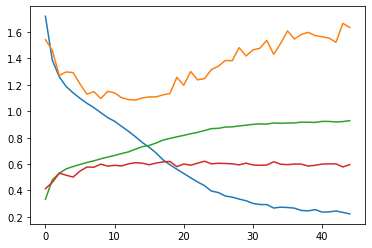

In [13]:
plt.plot(hist)

In [14]:
best_acc

0.6217653510863321

In [15]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_1_4.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.381 acc: 0.156
	 - Step 2: loss: 2.418 acc: 0.102
	 - Step 3: loss: 2.037 acc: 0.195
	 - Step 4: loss: 2.115 acc: 0.180
	 - Step 5: loss: 2.023 acc: 0.164
	 - Step 6: loss: 2.124 acc: 0.164
	 - Step 7: loss: 2.141 acc: 0.156
	 - Step 8: loss: 2.011 acc: 0.156
	 - Step 9: loss: 2.183 acc: 0.203
	 - Step 10: loss: 2.177 acc: 0.148
	 - Step 11: loss: 2.035 acc: 0.203
	 - Step 12: loss: 1.968 acc: 0.172
	 - Step 13: loss: 1.940 acc: 0.211
	 - Step 14: loss: 2.145 acc: 0.148
	 - Step 15: loss: 1.959 acc: 0.203
	 - Step 16: loss: 1.914 acc: 0.172
	 - Step 17: loss: 2.117 acc: 0.164
	 - Step 18: loss: 2.187 acc: 0.141
	 - Step 19: loss: 2.043 acc: 0.234
	 - Step 20: loss: 2.156 acc: 0.188
	 - Step 21: loss: 1.943 acc: 0.141
	 - Step 22: loss: 2.067 acc: 0.156
	 - Step 23: loss: 2.067 acc: 0.109
	 - Step 24: loss: 1.965 acc: 0.195
	 - Step 25: loss: 2.222 acc: 0.148
	 - Step 26: loss: 1.932 acc: 0.250
	 - Step 27: loss: 2.246 acc: 0.125
	 - Step 28: loss: 1.968 ac

- Avg. val_loss: 1.872  | Avg. val_acc: 0.260
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.780 acc: 0.305
	 - Step 2: loss: 1.888 acc: 0.219
	 - Step 3: loss: 1.862 acc: 0.242
	 - Step 4: loss: 1.901 acc: 0.188
	 - Step 5: loss: 1.836 acc: 0.312
	 - Step 6: loss: 1.840 acc: 0.266
	 - Step 7: loss: 1.839 acc: 0.305
	 - Step 8: loss: 1.851 acc: 0.297
	 - Step 9: loss: 1.846 acc: 0.227
	 - Step 10: loss: 1.815 acc: 0.266
	 - Step 11: loss: 1.859 acc: 0.258
	 - Step 12: loss: 1.801 acc: 0.320
	 - Step 13: loss: 1.866 acc: 0.273
	 - Step 14: loss: 1.835 acc: 0.281
	 - Step 15: loss: 1.837 acc: 0.297
	 - Step 16: loss: 1.832 acc: 0.305
	 - Step 17: loss: 1.813 acc: 0.266
	 - Step 18: loss: 1.759 acc: 0.328
	 - Step 19: loss: 1.837 acc: 0.281
	 - Step 20: loss: 1.795 acc: 0.336
	 - Step 21: loss: 1.864 acc: 0.289
	 - Step 22: loss: 1.755 acc: 0.305
	 - Step 23: loss: 1.811 acc: 0.328
	 - Step 24: loss: 1.812 acc: 0.273
	 - Step 25: loss: 1.805 acc: 0.289
	 - Step 26: loss: 1.819 acc: 0.242
	 - Step 27: loss: 1.776 acc: 0.289
	 - Step 28: loss: 1.836 acc: 0.250
	

- Avg. val_loss: 1.529  | Avg. val_acc: 0.430
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.278 acc: 0.586
	 - Step 2: loss: 1.486 acc: 0.453
	 - Step 3: loss: 1.459 acc: 0.430
	 - Step 4: loss: 1.462 acc: 0.453
	 - Step 5: loss: 1.529 acc: 0.430
	 - Step 6: loss: 1.498 acc: 0.406
	 - Step 7: loss: 1.523 acc: 0.414
	 - Step 8: loss: 1.595 acc: 0.406
	 - Step 9: loss: 1.541 acc: 0.414
	 - Step 10: loss: 1.536 acc: 0.383
	 - Step 11: loss: 1.534 acc: 0.422
	 - Step 12: loss: 1.364 acc: 0.461
	 - Step 13: loss: 1.529 acc: 0.344
	 - Step 14: loss: 1.458 acc: 0.477
	 - Step 15: loss: 1.402 acc: 0.500
	 - Step 16: loss: 1.511 acc: 0.430
	 - Step 17: loss: 1.508 acc: 0.375
	 - Step 18: loss: 1.412 acc: 0.469
	 - Step 19: loss: 1.588 acc: 0.391
	 - Step 20: loss: 1.522 acc: 0.445
	 - Step 21: loss: 1.465 acc: 0.453
	 - Step 22: loss: 1.566 acc: 0.414
	 - Step 23: loss: 1.526 acc: 0.430
	 - Step 24: loss: 1.420 acc: 0.484
	 - Step 25: loss: 1.431 acc: 0.516
	 - Step 26: loss: 1.409 acc: 

	 - Step 224: loss: 1.509 acc: 0.461
	 - Step 225: loss: 1.498 acc: 0.432
- Avg.loss: 1.455  | Avg.acc: 0.446
- Avg. val_loss: 1.443  | Avg. val_acc: 0.461
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.359 acc: 0.477
	 - Step 2: loss: 1.525 acc: 0.375
	 - Step 3: loss: 1.420 acc: 0.461
	 - Step 4: loss: 1.414 acc: 0.461
	 - Step 5: loss: 1.369 acc: 0.445
	 - Step 6: loss: 1.401 acc: 0.414
	 - Step 7: loss: 1.415 acc: 0.461
	 - Step 8: loss: 1.339 acc: 0.500
	 - Step 9: loss: 1.419 acc: 0.461
	 - Step 10: loss: 1.352 acc: 0.430
	 - Step 11: loss: 1.468 acc: 0.422
	 - Step 12: loss: 1.574 acc: 0.375
	 - Step 13: loss: 1.419 acc: 0.484
	 - Step 14: loss: 1.421 acc: 0.430
	 - Step 15: loss: 1.407 acc: 0.438
	 - Step 16: loss: 1.467 acc: 0.445
	 - Step 17: loss: 1.269 acc: 0.555
	 - Step 18: loss: 1.301 acc: 0.523
	 - Step 19: loss: 1.382 acc: 0.461
	 - Step 20: loss: 1.389 acc: 0.469
	 - Step 21: loss: 1.246 acc: 0.578
	 - Step 22: loss: 1.262 acc: 0.523
	 - Step 23: loss: 1.363 acc

	 - Step 221: loss: 1.359 acc: 0.492
	 - Step 222: loss: 1.447 acc: 0.461
	 - Step 223: loss: 1.311 acc: 0.461
	 - Step 224: loss: 1.185 acc: 0.539
	 - Step 225: loss: 1.419 acc: 0.486
- Avg.loss: 1.333  | Avg.acc: 0.495
- Avg. val_loss: 1.416  | Avg. val_acc: 0.456
Epoch:  5
	 - Step 1: loss: 1.336 acc: 0.508
	 - Step 2: loss: 1.417 acc: 0.477
	 - Step 3: loss: 1.179 acc: 0.609
	 - Step 4: loss: 1.192 acc: 0.562
	 - Step 5: loss: 1.230 acc: 0.586
	 - Step 6: loss: 1.286 acc: 0.531
	 - Step 7: loss: 1.277 acc: 0.508
	 - Step 8: loss: 1.300 acc: 0.453
	 - Step 9: loss: 1.420 acc: 0.461
	 - Step 10: loss: 1.323 acc: 0.484
	 - Step 11: loss: 1.242 acc: 0.484
	 - Step 12: loss: 1.225 acc: 0.586
	 - Step 13: loss: 1.309 acc: 0.500
	 - Step 14: loss: 1.218 acc: 0.555
	 - Step 15: loss: 1.315 acc: 0.484
	 - Step 16: loss: 1.408 acc: 0.461
	 - Step 17: loss: 1.401 acc: 0.461
	 - Step 18: loss: 1.421 acc: 0.430
	 - Step 19: loss: 1.225 acc: 0.539
	 - Step 20: loss: 1.358 acc: 0.445
	 - Step 21:

	 - Step 218: loss: 1.138 acc: 0.602
	 - Step 219: loss: 1.134 acc: 0.555
	 - Step 220: loss: 1.179 acc: 0.555
	 - Step 221: loss: 1.259 acc: 0.555
	 - Step 222: loss: 1.154 acc: 0.586
	 - Step 223: loss: 1.280 acc: 0.477
	 - Step 224: loss: 1.298 acc: 0.523
	 - Step 225: loss: 1.141 acc: 0.649
- Avg.loss: 1.252  | Avg.acc: 0.527
- Avg. val_loss: 1.295  | Avg. val_acc: 0.543
* Update optimal model
Epoch:  6
	 - Step 1: loss: 1.139 acc: 0.594
	 - Step 2: loss: 1.044 acc: 0.633
	 - Step 3: loss: 1.146 acc: 0.586
	 - Step 4: loss: 1.194 acc: 0.547
	 - Step 5: loss: 1.082 acc: 0.617
	 - Step 6: loss: 1.140 acc: 0.570
	 - Step 7: loss: 1.163 acc: 0.578
	 - Step 8: loss: 1.211 acc: 0.539
	 - Step 9: loss: 1.107 acc: 0.570
	 - Step 10: loss: 1.229 acc: 0.562
	 - Step 11: loss: 1.132 acc: 0.617
	 - Step 12: loss: 1.179 acc: 0.578
	 - Step 13: loss: 1.147 acc: 0.586
	 - Step 14: loss: 1.141 acc: 0.531
	 - Step 15: loss: 1.263 acc: 0.500
	 - Step 16: loss: 1.287 acc: 0.508
	 - Step 17: loss: 1.0

	 - Step 215: loss: 1.286 acc: 0.547
	 - Step 216: loss: 1.170 acc: 0.539
	 - Step 217: loss: 1.127 acc: 0.586
	 - Step 218: loss: 1.273 acc: 0.555
	 - Step 219: loss: 1.115 acc: 0.609
	 - Step 220: loss: 1.199 acc: 0.562
	 - Step 221: loss: 1.205 acc: 0.492
	 - Step 222: loss: 1.232 acc: 0.547
	 - Step 223: loss: 1.237 acc: 0.555
	 - Step 224: loss: 1.043 acc: 0.617
	 - Step 225: loss: 1.204 acc: 0.568
- Avg.loss: 1.197  | Avg.acc: 0.554
- Avg. val_loss: 1.304  | Avg. val_acc: 0.521
Epoch:  7
	 - Step 1: loss: 1.158 acc: 0.547
	 - Step 2: loss: 1.169 acc: 0.602
	 - Step 3: loss: 1.234 acc: 0.508
	 - Step 4: loss: 1.168 acc: 0.547
	 - Step 5: loss: 1.179 acc: 0.586
	 - Step 6: loss: 1.159 acc: 0.625
	 - Step 7: loss: 1.246 acc: 0.539
	 - Step 8: loss: 1.200 acc: 0.562
	 - Step 9: loss: 1.222 acc: 0.539
	 - Step 10: loss: 1.251 acc: 0.523
	 - Step 11: loss: 1.258 acc: 0.570
	 - Step 12: loss: 1.242 acc: 0.578
	 - Step 13: loss: 1.114 acc: 0.570
	 - Step 14: loss: 1.134 acc: 0.586
	 - St

	 - Step 212: loss: 1.046 acc: 0.633
	 - Step 213: loss: 1.124 acc: 0.594
	 - Step 214: loss: 1.192 acc: 0.547
	 - Step 215: loss: 1.040 acc: 0.625
	 - Step 216: loss: 1.175 acc: 0.562
	 - Step 217: loss: 1.076 acc: 0.617
	 - Step 218: loss: 1.066 acc: 0.625
	 - Step 219: loss: 1.139 acc: 0.602
	 - Step 220: loss: 1.237 acc: 0.547
	 - Step 221: loss: 1.116 acc: 0.578
	 - Step 222: loss: 1.300 acc: 0.539
	 - Step 223: loss: 1.191 acc: 0.562
	 - Step 224: loss: 1.120 acc: 0.617
	 - Step 225: loss: 1.218 acc: 0.595
- Avg.loss: 1.151  | Avg.acc: 0.571
- Avg. val_loss: 1.264  | Avg. val_acc: 0.533
Epoch:  8
	 - Step 1: loss: 1.204 acc: 0.508
	 - Step 2: loss: 1.128 acc: 0.539
	 - Step 3: loss: 1.103 acc: 0.602
	 - Step 4: loss: 1.136 acc: 0.555
	 - Step 5: loss: 1.123 acc: 0.570
	 - Step 6: loss: 1.071 acc: 0.609
	 - Step 7: loss: 1.096 acc: 0.602
	 - Step 8: loss: 1.162 acc: 0.578
	 - Step 9: loss: 1.023 acc: 0.633
	 - Step 10: loss: 0.887 acc: 0.688
	 - Step 11: loss: 1.058 acc: 0.602
	 -

	 - Step 209: loss: 1.041 acc: 0.672
	 - Step 210: loss: 1.279 acc: 0.570
	 - Step 211: loss: 1.106 acc: 0.594
	 - Step 212: loss: 1.033 acc: 0.664
	 - Step 213: loss: 1.088 acc: 0.641
	 - Step 214: loss: 1.087 acc: 0.602
	 - Step 215: loss: 1.034 acc: 0.617
	 - Step 216: loss: 1.125 acc: 0.586
	 - Step 217: loss: 1.222 acc: 0.531
	 - Step 218: loss: 0.993 acc: 0.656
	 - Step 219: loss: 1.279 acc: 0.547
	 - Step 220: loss: 1.247 acc: 0.531
	 - Step 221: loss: 0.983 acc: 0.648
	 - Step 222: loss: 0.996 acc: 0.656
	 - Step 223: loss: 1.215 acc: 0.516
	 - Step 224: loss: 1.067 acc: 0.594
	 - Step 225: loss: 1.146 acc: 0.541
- Avg.loss: 1.103  | Avg.acc: 0.595
- Avg. val_loss: 1.222  | Avg. val_acc: 0.552
* Update optimal model
Epoch:  9
	 - Step 1: loss: 1.101 acc: 0.578
	 - Step 2: loss: 1.074 acc: 0.602
	 - Step 3: loss: 1.101 acc: 0.570
	 - Step 4: loss: 1.170 acc: 0.562
	 - Step 5: loss: 0.931 acc: 0.719
	 - Step 6: loss: 0.822 acc: 0.727
	 - Step 7: loss: 0.882 acc: 0.719
	 - Step 8:

	 - Step 206: loss: 1.070 acc: 0.625
	 - Step 207: loss: 1.089 acc: 0.594
	 - Step 208: loss: 0.899 acc: 0.688
	 - Step 209: loss: 1.110 acc: 0.594
	 - Step 210: loss: 1.099 acc: 0.641
	 - Step 211: loss: 1.123 acc: 0.602
	 - Step 212: loss: 1.156 acc: 0.570
	 - Step 213: loss: 1.059 acc: 0.562
	 - Step 214: loss: 1.058 acc: 0.594
	 - Step 215: loss: 1.048 acc: 0.602
	 - Step 216: loss: 0.987 acc: 0.680
	 - Step 217: loss: 1.016 acc: 0.602
	 - Step 218: loss: 0.972 acc: 0.664
	 - Step 219: loss: 1.078 acc: 0.609
	 - Step 220: loss: 1.041 acc: 0.625
	 - Step 221: loss: 1.130 acc: 0.578
	 - Step 222: loss: 0.934 acc: 0.641
	 - Step 223: loss: 0.975 acc: 0.648
	 - Step 224: loss: 0.910 acc: 0.633
	 - Step 225: loss: 1.059 acc: 0.622
- Avg.loss: 1.058  | Avg.acc: 0.615
- Avg. val_loss: 1.130  | Avg. val_acc: 0.585
* Update optimal model
Epoch:  10
	 - Step 1: loss: 1.085 acc: 0.562
	 - Step 2: loss: 0.982 acc: 0.641
	 - Step 3: loss: 1.084 acc: 0.586
	 - Step 4: loss: 0.978 acc: 0.633
	 - 

	 - Step 203: loss: 1.032 acc: 0.648
	 - Step 204: loss: 0.976 acc: 0.656
	 - Step 205: loss: 1.231 acc: 0.539
	 - Step 206: loss: 1.238 acc: 0.578
	 - Step 207: loss: 1.067 acc: 0.594
	 - Step 208: loss: 0.956 acc: 0.664
	 - Step 209: loss: 0.967 acc: 0.695
	 - Step 210: loss: 1.067 acc: 0.633
	 - Step 211: loss: 0.959 acc: 0.680
	 - Step 212: loss: 1.026 acc: 0.617
	 - Step 213: loss: 0.962 acc: 0.586
	 - Step 214: loss: 1.084 acc: 0.617
	 - Step 215: loss: 0.966 acc: 0.617
	 - Step 216: loss: 1.072 acc: 0.633
	 - Step 217: loss: 1.201 acc: 0.523
	 - Step 218: loss: 0.906 acc: 0.680
	 - Step 219: loss: 1.031 acc: 0.648
	 - Step 220: loss: 1.124 acc: 0.586
	 - Step 221: loss: 1.021 acc: 0.617
	 - Step 222: loss: 1.155 acc: 0.570
	 - Step 223: loss: 1.020 acc: 0.656
	 - Step 224: loss: 1.053 acc: 0.633
	 - Step 225: loss: 1.089 acc: 0.568
- Avg.loss: 1.027  | Avg.acc: 0.630
- Avg. val_loss: 1.333  | Avg. val_acc: 0.489
Epoch:  11
	 - Step 1: loss: 1.128 acc: 0.586
	 - Step 2: loss: 1.0

	 - Step 200: loss: 0.876 acc: 0.695
	 - Step 201: loss: 0.932 acc: 0.656
	 - Step 202: loss: 0.907 acc: 0.727
	 - Step 203: loss: 0.984 acc: 0.656
	 - Step 204: loss: 1.066 acc: 0.562
	 - Step 205: loss: 1.180 acc: 0.570
	 - Step 206: loss: 1.022 acc: 0.641
	 - Step 207: loss: 1.042 acc: 0.602
	 - Step 208: loss: 1.015 acc: 0.625
	 - Step 209: loss: 1.028 acc: 0.648
	 - Step 210: loss: 0.961 acc: 0.672
	 - Step 211: loss: 1.012 acc: 0.586
	 - Step 212: loss: 0.855 acc: 0.703
	 - Step 213: loss: 1.026 acc: 0.695
	 - Step 214: loss: 0.942 acc: 0.680
	 - Step 215: loss: 0.975 acc: 0.648
	 - Step 216: loss: 0.965 acc: 0.680
	 - Step 217: loss: 1.026 acc: 0.641
	 - Step 218: loss: 0.894 acc: 0.680
	 - Step 219: loss: 1.003 acc: 0.664
	 - Step 220: loss: 0.921 acc: 0.633
	 - Step 221: loss: 0.941 acc: 0.688
	 - Step 222: loss: 0.966 acc: 0.641
	 - Step 223: loss: 1.032 acc: 0.648
	 - Step 224: loss: 0.984 acc: 0.625
	 - Step 225: loss: 1.003 acc: 0.541
- Avg.loss: 0.985  | Avg.acc: 0.644
- 

	 - Step 197: loss: 0.985 acc: 0.656
	 - Step 198: loss: 1.004 acc: 0.633
	 - Step 199: loss: 1.135 acc: 0.578
	 - Step 200: loss: 0.957 acc: 0.641
	 - Step 201: loss: 0.982 acc: 0.648
	 - Step 202: loss: 0.953 acc: 0.625
	 - Step 203: loss: 1.023 acc: 0.617
	 - Step 204: loss: 0.775 acc: 0.766
	 - Step 205: loss: 0.901 acc: 0.680
	 - Step 206: loss: 0.774 acc: 0.750
	 - Step 207: loss: 0.971 acc: 0.656
	 - Step 208: loss: 1.165 acc: 0.531
	 - Step 209: loss: 0.827 acc: 0.711
	 - Step 210: loss: 0.992 acc: 0.672
	 - Step 211: loss: 1.058 acc: 0.641
	 - Step 212: loss: 1.211 acc: 0.555
	 - Step 213: loss: 1.144 acc: 0.562
	 - Step 214: loss: 1.015 acc: 0.633
	 - Step 215: loss: 0.967 acc: 0.664
	 - Step 216: loss: 1.001 acc: 0.625
	 - Step 217: loss: 0.909 acc: 0.656
	 - Step 218: loss: 0.940 acc: 0.680
	 - Step 219: loss: 0.912 acc: 0.719
	 - Step 220: loss: 0.864 acc: 0.633
	 - Step 221: loss: 1.022 acc: 0.625
	 - Step 222: loss: 0.914 acc: 0.672
	 - Step 223: loss: 1.001 acc: 0.617
	

	 - Step 194: loss: 0.781 acc: 0.719
	 - Step 195: loss: 0.864 acc: 0.695
	 - Step 196: loss: 0.962 acc: 0.633
	 - Step 197: loss: 0.809 acc: 0.727
	 - Step 198: loss: 1.032 acc: 0.641
	 - Step 199: loss: 0.828 acc: 0.719
	 - Step 200: loss: 1.029 acc: 0.594
	 - Step 201: loss: 0.907 acc: 0.656
	 - Step 202: loss: 0.968 acc: 0.641
	 - Step 203: loss: 1.053 acc: 0.625
	 - Step 204: loss: 0.972 acc: 0.633
	 - Step 205: loss: 0.834 acc: 0.695
	 - Step 206: loss: 0.813 acc: 0.719
	 - Step 207: loss: 0.882 acc: 0.688
	 - Step 208: loss: 0.867 acc: 0.680
	 - Step 209: loss: 0.907 acc: 0.703
	 - Step 210: loss: 0.928 acc: 0.633
	 - Step 211: loss: 0.900 acc: 0.695
	 - Step 212: loss: 0.937 acc: 0.656
	 - Step 213: loss: 0.860 acc: 0.680
	 - Step 214: loss: 0.778 acc: 0.734
	 - Step 215: loss: 0.980 acc: 0.633
	 - Step 216: loss: 0.897 acc: 0.680
	 - Step 217: loss: 1.101 acc: 0.594
	 - Step 218: loss: 1.017 acc: 0.570
	 - Step 219: loss: 1.027 acc: 0.617
	 - Step 220: loss: 0.859 acc: 0.695
	

	 - Step 191: loss: 0.886 acc: 0.672
	 - Step 192: loss: 1.022 acc: 0.633
	 - Step 193: loss: 0.927 acc: 0.703
	 - Step 194: loss: 0.963 acc: 0.688
	 - Step 195: loss: 0.829 acc: 0.703
	 - Step 196: loss: 0.761 acc: 0.758
	 - Step 197: loss: 1.032 acc: 0.648
	 - Step 198: loss: 1.040 acc: 0.648
	 - Step 199: loss: 0.880 acc: 0.695
	 - Step 200: loss: 0.946 acc: 0.633
	 - Step 201: loss: 0.939 acc: 0.609
	 - Step 202: loss: 0.814 acc: 0.688
	 - Step 203: loss: 0.833 acc: 0.711
	 - Step 204: loss: 1.028 acc: 0.625
	 - Step 205: loss: 0.926 acc: 0.703
	 - Step 206: loss: 0.819 acc: 0.711
	 - Step 207: loss: 0.927 acc: 0.641
	 - Step 208: loss: 1.098 acc: 0.648
	 - Step 209: loss: 0.739 acc: 0.773
	 - Step 210: loss: 0.939 acc: 0.656
	 - Step 211: loss: 0.847 acc: 0.688
	 - Step 212: loss: 0.981 acc: 0.633
	 - Step 213: loss: 0.854 acc: 0.719
	 - Step 214: loss: 1.081 acc: 0.633
	 - Step 215: loss: 0.904 acc: 0.672
	 - Step 216: loss: 0.845 acc: 0.703
	 - Step 217: loss: 1.025 acc: 0.594
	

	 - Step 188: loss: 0.876 acc: 0.672
	 - Step 189: loss: 0.886 acc: 0.656
	 - Step 190: loss: 0.883 acc: 0.680
	 - Step 191: loss: 0.890 acc: 0.703
	 - Step 192: loss: 0.835 acc: 0.719
	 - Step 193: loss: 0.744 acc: 0.734
	 - Step 194: loss: 0.884 acc: 0.719
	 - Step 195: loss: 1.004 acc: 0.664
	 - Step 196: loss: 0.967 acc: 0.625
	 - Step 197: loss: 0.783 acc: 0.719
	 - Step 198: loss: 0.925 acc: 0.656
	 - Step 199: loss: 0.909 acc: 0.688
	 - Step 200: loss: 0.921 acc: 0.672
	 - Step 201: loss: 0.910 acc: 0.641
	 - Step 202: loss: 0.889 acc: 0.656
	 - Step 203: loss: 0.987 acc: 0.641
	 - Step 204: loss: 1.004 acc: 0.633
	 - Step 205: loss: 1.011 acc: 0.641
	 - Step 206: loss: 0.762 acc: 0.766
	 - Step 207: loss: 0.878 acc: 0.625
	 - Step 208: loss: 0.804 acc: 0.750
	 - Step 209: loss: 0.749 acc: 0.719
	 - Step 210: loss: 0.964 acc: 0.602
	 - Step 211: loss: 0.940 acc: 0.641
	 - Step 212: loss: 0.855 acc: 0.688
	 - Step 213: loss: 0.780 acc: 0.758
	 - Step 214: loss: 0.877 acc: 0.695
	

	 - Step 185: loss: 0.836 acc: 0.672
	 - Step 186: loss: 0.831 acc: 0.703
	 - Step 187: loss: 0.823 acc: 0.695
	 - Step 188: loss: 0.791 acc: 0.703
	 - Step 189: loss: 0.829 acc: 0.711
	 - Step 190: loss: 0.917 acc: 0.719
	 - Step 191: loss: 0.861 acc: 0.664
	 - Step 192: loss: 0.757 acc: 0.672
	 - Step 193: loss: 0.903 acc: 0.648
	 - Step 194: loss: 0.977 acc: 0.641
	 - Step 195: loss: 0.778 acc: 0.711
	 - Step 196: loss: 0.790 acc: 0.734
	 - Step 197: loss: 0.963 acc: 0.672
	 - Step 198: loss: 0.908 acc: 0.664
	 - Step 199: loss: 0.765 acc: 0.703
	 - Step 200: loss: 0.811 acc: 0.711
	 - Step 201: loss: 1.134 acc: 0.625
	 - Step 202: loss: 0.871 acc: 0.688
	 - Step 203: loss: 0.990 acc: 0.648
	 - Step 204: loss: 0.842 acc: 0.695
	 - Step 205: loss: 0.934 acc: 0.609
	 - Step 206: loss: 0.894 acc: 0.734
	 - Step 207: loss: 0.911 acc: 0.680
	 - Step 208: loss: 0.781 acc: 0.719
	 - Step 209: loss: 0.780 acc: 0.703
	 - Step 210: loss: 0.961 acc: 0.625
	 - Step 211: loss: 0.728 acc: 0.703
	

	 - Step 182: loss: 0.745 acc: 0.742
	 - Step 183: loss: 0.810 acc: 0.719
	 - Step 184: loss: 0.894 acc: 0.672
	 - Step 185: loss: 0.834 acc: 0.711
	 - Step 186: loss: 0.957 acc: 0.656
	 - Step 187: loss: 0.985 acc: 0.680
	 - Step 188: loss: 0.879 acc: 0.648
	 - Step 189: loss: 0.892 acc: 0.719
	 - Step 190: loss: 0.821 acc: 0.688
	 - Step 191: loss: 0.786 acc: 0.672
	 - Step 192: loss: 0.866 acc: 0.711
	 - Step 193: loss: 0.849 acc: 0.711
	 - Step 194: loss: 0.738 acc: 0.758
	 - Step 195: loss: 0.779 acc: 0.727
	 - Step 196: loss: 0.692 acc: 0.742
	 - Step 197: loss: 0.807 acc: 0.672
	 - Step 198: loss: 0.764 acc: 0.703
	 - Step 199: loss: 0.812 acc: 0.695
	 - Step 200: loss: 0.630 acc: 0.766
	 - Step 201: loss: 0.914 acc: 0.695
	 - Step 202: loss: 1.113 acc: 0.570
	 - Step 203: loss: 0.830 acc: 0.695
	 - Step 204: loss: 0.812 acc: 0.703
	 - Step 205: loss: 0.955 acc: 0.672
	 - Step 206: loss: 0.860 acc: 0.711
	 - Step 207: loss: 0.756 acc: 0.719
	 - Step 208: loss: 0.717 acc: 0.703
	

	 - Step 179: loss: 0.849 acc: 0.695
	 - Step 180: loss: 0.811 acc: 0.711
	 - Step 181: loss: 0.885 acc: 0.727
	 - Step 182: loss: 0.786 acc: 0.742
	 - Step 183: loss: 0.913 acc: 0.664
	 - Step 184: loss: 0.945 acc: 0.648
	 - Step 185: loss: 0.748 acc: 0.750
	 - Step 186: loss: 0.602 acc: 0.836
	 - Step 187: loss: 0.771 acc: 0.734
	 - Step 188: loss: 0.692 acc: 0.711
	 - Step 189: loss: 0.640 acc: 0.773
	 - Step 190: loss: 0.771 acc: 0.719
	 - Step 191: loss: 0.862 acc: 0.672
	 - Step 192: loss: 0.726 acc: 0.734
	 - Step 193: loss: 0.776 acc: 0.711
	 - Step 194: loss: 0.786 acc: 0.727
	 - Step 195: loss: 0.740 acc: 0.734
	 - Step 196: loss: 0.896 acc: 0.633
	 - Step 197: loss: 0.797 acc: 0.750
	 - Step 198: loss: 0.802 acc: 0.695
	 - Step 199: loss: 0.723 acc: 0.734
	 - Step 200: loss: 0.746 acc: 0.742
	 - Step 201: loss: 0.713 acc: 0.750
	 - Step 202: loss: 0.768 acc: 0.742
	 - Step 203: loss: 0.920 acc: 0.656
	 - Step 204: loss: 0.806 acc: 0.711
	 - Step 205: loss: 0.759 acc: 0.758
	

	 - Step 176: loss: 0.705 acc: 0.750
	 - Step 177: loss: 0.727 acc: 0.758
	 - Step 178: loss: 0.643 acc: 0.781
	 - Step 179: loss: 0.876 acc: 0.711
	 - Step 180: loss: 0.824 acc: 0.703
	 - Step 181: loss: 0.755 acc: 0.742
	 - Step 182: loss: 0.877 acc: 0.711
	 - Step 183: loss: 0.753 acc: 0.711
	 - Step 184: loss: 0.686 acc: 0.766
	 - Step 185: loss: 0.706 acc: 0.758
	 - Step 186: loss: 0.828 acc: 0.734
	 - Step 187: loss: 0.817 acc: 0.695
	 - Step 188: loss: 0.844 acc: 0.711
	 - Step 189: loss: 0.706 acc: 0.773
	 - Step 190: loss: 0.806 acc: 0.703
	 - Step 191: loss: 0.659 acc: 0.773
	 - Step 192: loss: 0.651 acc: 0.742
	 - Step 193: loss: 0.827 acc: 0.672
	 - Step 194: loss: 0.809 acc: 0.742
	 - Step 195: loss: 0.761 acc: 0.750
	 - Step 196: loss: 0.749 acc: 0.734
	 - Step 197: loss: 0.695 acc: 0.750
	 - Step 198: loss: 0.742 acc: 0.711
	 - Step 199: loss: 0.770 acc: 0.742
	 - Step 200: loss: 0.830 acc: 0.703
	 - Step 201: loss: 0.721 acc: 0.734
	 - Step 202: loss: 0.685 acc: 0.773
	

	 - Step 173: loss: 0.605 acc: 0.797
	 - Step 174: loss: 0.682 acc: 0.766
	 - Step 175: loss: 0.786 acc: 0.680
	 - Step 176: loss: 0.596 acc: 0.820
	 - Step 177: loss: 0.608 acc: 0.789
	 - Step 178: loss: 0.608 acc: 0.781
	 - Step 179: loss: 0.700 acc: 0.727
	 - Step 180: loss: 0.578 acc: 0.805
	 - Step 181: loss: 0.890 acc: 0.727
	 - Step 182: loss: 0.770 acc: 0.773
	 - Step 183: loss: 0.661 acc: 0.773
	 - Step 184: loss: 0.640 acc: 0.758
	 - Step 185: loss: 0.691 acc: 0.727
	 - Step 186: loss: 0.755 acc: 0.750
	 - Step 187: loss: 0.785 acc: 0.680
	 - Step 188: loss: 0.703 acc: 0.742
	 - Step 189: loss: 0.718 acc: 0.766
	 - Step 190: loss: 0.579 acc: 0.805
	 - Step 191: loss: 0.656 acc: 0.766
	 - Step 192: loss: 0.771 acc: 0.750
	 - Step 193: loss: 0.756 acc: 0.734
	 - Step 194: loss: 0.722 acc: 0.727
	 - Step 195: loss: 0.666 acc: 0.727
	 - Step 196: loss: 0.752 acc: 0.750
	 - Step 197: loss: 0.593 acc: 0.789
	 - Step 198: loss: 0.783 acc: 0.734
	 - Step 199: loss: 0.752 acc: 0.703
	

	 - Step 170: loss: 0.768 acc: 0.727
	 - Step 171: loss: 0.702 acc: 0.781
	 - Step 172: loss: 0.671 acc: 0.758
	 - Step 173: loss: 0.636 acc: 0.773
	 - Step 174: loss: 0.775 acc: 0.672
	 - Step 175: loss: 0.711 acc: 0.766
	 - Step 176: loss: 0.861 acc: 0.750
	 - Step 177: loss: 0.746 acc: 0.758
	 - Step 178: loss: 0.605 acc: 0.797
	 - Step 179: loss: 0.777 acc: 0.703
	 - Step 180: loss: 0.851 acc: 0.680
	 - Step 181: loss: 0.771 acc: 0.758
	 - Step 182: loss: 0.960 acc: 0.672
	 - Step 183: loss: 0.654 acc: 0.758
	 - Step 184: loss: 0.812 acc: 0.656
	 - Step 185: loss: 0.678 acc: 0.719
	 - Step 186: loss: 0.783 acc: 0.719
	 - Step 187: loss: 0.645 acc: 0.758
	 - Step 188: loss: 0.653 acc: 0.766
	 - Step 189: loss: 0.766 acc: 0.734
	 - Step 190: loss: 0.673 acc: 0.766
	 - Step 191: loss: 0.791 acc: 0.688
	 - Step 192: loss: 0.641 acc: 0.773
	 - Step 193: loss: 0.736 acc: 0.727
	 - Step 194: loss: 0.758 acc: 0.727
	 - Step 195: loss: 0.776 acc: 0.680
	 - Step 196: loss: 0.833 acc: 0.695
	

	 - Step 167: loss: 0.656 acc: 0.781
	 - Step 168: loss: 0.641 acc: 0.773
	 - Step 169: loss: 0.641 acc: 0.805
	 - Step 170: loss: 0.759 acc: 0.750
	 - Step 171: loss: 0.549 acc: 0.781
	 - Step 172: loss: 0.563 acc: 0.789
	 - Step 173: loss: 0.699 acc: 0.727
	 - Step 174: loss: 0.504 acc: 0.805
	 - Step 175: loss: 0.571 acc: 0.766
	 - Step 176: loss: 0.681 acc: 0.773
	 - Step 177: loss: 0.552 acc: 0.773
	 - Step 178: loss: 0.742 acc: 0.750
	 - Step 179: loss: 0.602 acc: 0.789
	 - Step 180: loss: 0.790 acc: 0.734
	 - Step 181: loss: 0.437 acc: 0.852
	 - Step 182: loss: 0.638 acc: 0.766
	 - Step 183: loss: 0.597 acc: 0.750
	 - Step 184: loss: 0.859 acc: 0.703
	 - Step 185: loss: 0.667 acc: 0.766
	 - Step 186: loss: 0.556 acc: 0.812
	 - Step 187: loss: 0.794 acc: 0.734
	 - Step 188: loss: 0.615 acc: 0.789
	 - Step 189: loss: 0.682 acc: 0.773
	 - Step 190: loss: 0.542 acc: 0.867
	 - Step 191: loss: 0.551 acc: 0.812
	 - Step 192: loss: 0.568 acc: 0.812
	 - Step 193: loss: 0.792 acc: 0.734
	

	 - Step 164: loss: 0.518 acc: 0.805
	 - Step 165: loss: 0.562 acc: 0.820
	 - Step 166: loss: 0.612 acc: 0.766
	 - Step 167: loss: 0.613 acc: 0.766
	 - Step 168: loss: 0.684 acc: 0.789
	 - Step 169: loss: 0.599 acc: 0.805
	 - Step 170: loss: 0.556 acc: 0.789
	 - Step 171: loss: 0.831 acc: 0.719
	 - Step 172: loss: 0.648 acc: 0.789
	 - Step 173: loss: 0.745 acc: 0.719
	 - Step 174: loss: 0.606 acc: 0.797
	 - Step 175: loss: 0.636 acc: 0.781
	 - Step 176: loss: 0.495 acc: 0.836
	 - Step 177: loss: 0.676 acc: 0.773
	 - Step 178: loss: 0.604 acc: 0.805
	 - Step 179: loss: 0.625 acc: 0.789
	 - Step 180: loss: 0.586 acc: 0.812
	 - Step 181: loss: 0.691 acc: 0.781
	 - Step 182: loss: 0.530 acc: 0.797
	 - Step 183: loss: 0.580 acc: 0.828
	 - Step 184: loss: 0.623 acc: 0.797
	 - Step 185: loss: 0.654 acc: 0.773
	 - Step 186: loss: 0.496 acc: 0.867
	 - Step 187: loss: 0.514 acc: 0.828
	 - Step 188: loss: 0.637 acc: 0.773
	 - Step 189: loss: 0.687 acc: 0.750
	 - Step 190: loss: 0.534 acc: 0.828
	

	 - Step 161: loss: 0.575 acc: 0.797
	 - Step 162: loss: 0.536 acc: 0.812
	 - Step 163: loss: 0.380 acc: 0.875
	 - Step 164: loss: 0.575 acc: 0.789
	 - Step 165: loss: 0.571 acc: 0.758
	 - Step 166: loss: 0.638 acc: 0.766
	 - Step 167: loss: 0.626 acc: 0.781
	 - Step 168: loss: 0.601 acc: 0.758
	 - Step 169: loss: 0.561 acc: 0.797
	 - Step 170: loss: 0.646 acc: 0.773
	 - Step 171: loss: 0.801 acc: 0.695
	 - Step 172: loss: 0.563 acc: 0.805
	 - Step 173: loss: 0.442 acc: 0.836
	 - Step 174: loss: 0.523 acc: 0.867
	 - Step 175: loss: 0.470 acc: 0.852
	 - Step 176: loss: 0.636 acc: 0.805
	 - Step 177: loss: 0.663 acc: 0.773
	 - Step 178: loss: 0.569 acc: 0.805
	 - Step 179: loss: 0.574 acc: 0.836
	 - Step 180: loss: 0.562 acc: 0.805
	 - Step 181: loss: 0.471 acc: 0.859
	 - Step 182: loss: 0.552 acc: 0.805
	 - Step 183: loss: 0.489 acc: 0.844
	 - Step 184: loss: 0.539 acc: 0.789
	 - Step 185: loss: 0.666 acc: 0.750
	 - Step 186: loss: 0.466 acc: 0.867
	 - Step 187: loss: 0.646 acc: 0.781
	

	 - Step 158: loss: 0.531 acc: 0.844
	 - Step 159: loss: 0.646 acc: 0.828
	 - Step 160: loss: 0.526 acc: 0.844
	 - Step 161: loss: 0.428 acc: 0.859
	 - Step 162: loss: 0.404 acc: 0.883
	 - Step 163: loss: 0.571 acc: 0.789
	 - Step 164: loss: 0.484 acc: 0.812
	 - Step 165: loss: 0.522 acc: 0.812
	 - Step 166: loss: 0.590 acc: 0.766
	 - Step 167: loss: 0.522 acc: 0.828
	 - Step 168: loss: 0.536 acc: 0.805
	 - Step 169: loss: 0.621 acc: 0.805
	 - Step 170: loss: 0.453 acc: 0.852
	 - Step 171: loss: 0.638 acc: 0.797
	 - Step 172: loss: 0.608 acc: 0.773
	 - Step 173: loss: 0.489 acc: 0.820
	 - Step 174: loss: 0.509 acc: 0.852
	 - Step 175: loss: 0.434 acc: 0.867
	 - Step 176: loss: 0.528 acc: 0.828
	 - Step 177: loss: 0.600 acc: 0.750
	 - Step 178: loss: 0.733 acc: 0.742
	 - Step 179: loss: 0.706 acc: 0.766
	 - Step 180: loss: 0.642 acc: 0.758
	 - Step 181: loss: 0.584 acc: 0.812
	 - Step 182: loss: 0.578 acc: 0.805
	 - Step 183: loss: 0.394 acc: 0.867
	 - Step 184: loss: 0.476 acc: 0.867
	

	 - Step 155: loss: 0.452 acc: 0.836
	 - Step 156: loss: 0.535 acc: 0.836
	 - Step 157: loss: 0.482 acc: 0.852
	 - Step 158: loss: 0.562 acc: 0.789
	 - Step 159: loss: 0.515 acc: 0.797
	 - Step 160: loss: 0.451 acc: 0.805
	 - Step 161: loss: 0.366 acc: 0.883
	 - Step 162: loss: 0.427 acc: 0.867
	 - Step 163: loss: 0.631 acc: 0.750
	 - Step 164: loss: 0.444 acc: 0.867
	 - Step 165: loss: 0.372 acc: 0.859
	 - Step 166: loss: 0.395 acc: 0.883
	 - Step 167: loss: 0.470 acc: 0.875
	 - Step 168: loss: 0.598 acc: 0.789
	 - Step 169: loss: 0.490 acc: 0.852
	 - Step 170: loss: 0.530 acc: 0.836
	 - Step 171: loss: 0.641 acc: 0.797
	 - Step 172: loss: 0.457 acc: 0.852
	 - Step 173: loss: 0.594 acc: 0.812
	 - Step 174: loss: 0.572 acc: 0.812
	 - Step 175: loss: 0.461 acc: 0.828
	 - Step 176: loss: 0.606 acc: 0.750
	 - Step 177: loss: 0.462 acc: 0.859
	 - Step 178: loss: 0.660 acc: 0.789
	 - Step 179: loss: 0.481 acc: 0.836
	 - Step 180: loss: 0.522 acc: 0.836
	 - Step 181: loss: 0.527 acc: 0.836
	

	 - Step 152: loss: 0.436 acc: 0.867
	 - Step 153: loss: 0.521 acc: 0.789
	 - Step 154: loss: 0.604 acc: 0.797
	 - Step 155: loss: 0.575 acc: 0.812
	 - Step 156: loss: 0.534 acc: 0.812
	 - Step 157: loss: 0.503 acc: 0.844
	 - Step 158: loss: 0.442 acc: 0.844
	 - Step 159: loss: 0.399 acc: 0.852
	 - Step 160: loss: 0.444 acc: 0.844
	 - Step 161: loss: 0.429 acc: 0.867
	 - Step 162: loss: 0.427 acc: 0.875
	 - Step 163: loss: 0.394 acc: 0.859
	 - Step 164: loss: 0.450 acc: 0.844
	 - Step 165: loss: 0.476 acc: 0.852
	 - Step 166: loss: 0.699 acc: 0.773
	 - Step 167: loss: 0.348 acc: 0.867
	 - Step 168: loss: 0.320 acc: 0.875
	 - Step 169: loss: 0.582 acc: 0.820
	 - Step 170: loss: 0.473 acc: 0.828
	 - Step 171: loss: 0.481 acc: 0.852
	 - Step 172: loss: 0.404 acc: 0.867
	 - Step 173: loss: 0.618 acc: 0.820
	 - Step 174: loss: 0.387 acc: 0.844
	 - Step 175: loss: 0.484 acc: 0.844
	 - Step 176: loss: 0.336 acc: 0.891
	 - Step 177: loss: 0.608 acc: 0.773
	 - Step 178: loss: 0.397 acc: 0.867
	

	 - Step 149: loss: 0.447 acc: 0.859
	 - Step 150: loss: 0.406 acc: 0.859
	 - Step 151: loss: 0.494 acc: 0.844
	 - Step 152: loss: 0.290 acc: 0.922
	 - Step 153: loss: 0.449 acc: 0.859
	 - Step 154: loss: 0.336 acc: 0.906
	 - Step 155: loss: 0.318 acc: 0.883
	 - Step 156: loss: 0.347 acc: 0.906
	 - Step 157: loss: 0.393 acc: 0.898
	 - Step 158: loss: 0.548 acc: 0.812
	 - Step 159: loss: 0.403 acc: 0.875
	 - Step 160: loss: 0.371 acc: 0.875
	 - Step 161: loss: 0.357 acc: 0.906
	 - Step 162: loss: 0.408 acc: 0.867
	 - Step 163: loss: 0.303 acc: 0.914
	 - Step 164: loss: 0.437 acc: 0.844
	 - Step 165: loss: 0.521 acc: 0.836
	 - Step 166: loss: 0.552 acc: 0.797
	 - Step 167: loss: 0.497 acc: 0.844
	 - Step 168: loss: 0.475 acc: 0.820
	 - Step 169: loss: 0.536 acc: 0.781
	 - Step 170: loss: 0.420 acc: 0.852
	 - Step 171: loss: 0.313 acc: 0.898
	 - Step 172: loss: 0.410 acc: 0.883
	 - Step 173: loss: 0.435 acc: 0.844
	 - Step 174: loss: 0.375 acc: 0.906
	 - Step 175: loss: 0.455 acc: 0.828
	

	 - Step 146: loss: 0.619 acc: 0.828
	 - Step 147: loss: 0.356 acc: 0.891
	 - Step 148: loss: 0.367 acc: 0.875
	 - Step 149: loss: 0.306 acc: 0.906
	 - Step 150: loss: 0.428 acc: 0.836
	 - Step 151: loss: 0.483 acc: 0.852
	 - Step 152: loss: 0.287 acc: 0.906
	 - Step 153: loss: 0.497 acc: 0.820
	 - Step 154: loss: 0.376 acc: 0.883
	 - Step 155: loss: 0.421 acc: 0.844
	 - Step 156: loss: 0.468 acc: 0.859
	 - Step 157: loss: 0.300 acc: 0.898
	 - Step 158: loss: 0.453 acc: 0.836
	 - Step 159: loss: 0.502 acc: 0.828
	 - Step 160: loss: 0.378 acc: 0.867
	 - Step 161: loss: 0.332 acc: 0.891
	 - Step 162: loss: 0.497 acc: 0.812
	 - Step 163: loss: 0.433 acc: 0.820
	 - Step 164: loss: 0.432 acc: 0.836
	 - Step 165: loss: 0.343 acc: 0.867
	 - Step 166: loss: 0.407 acc: 0.859
	 - Step 167: loss: 0.449 acc: 0.867
	 - Step 168: loss: 0.415 acc: 0.867
	 - Step 169: loss: 0.313 acc: 0.898
	 - Step 170: loss: 0.440 acc: 0.883
	 - Step 171: loss: 0.366 acc: 0.875
	 - Step 172: loss: 0.344 acc: 0.898
	

	 - Step 143: loss: 0.346 acc: 0.867
	 - Step 144: loss: 0.377 acc: 0.859
	 - Step 145: loss: 0.254 acc: 0.930
	 - Step 146: loss: 0.379 acc: 0.867
	 - Step 147: loss: 0.316 acc: 0.891
	 - Step 148: loss: 0.522 acc: 0.820
	 - Step 149: loss: 0.365 acc: 0.883
	 - Step 150: loss: 0.590 acc: 0.805
	 - Step 151: loss: 0.502 acc: 0.867
	 - Step 152: loss: 0.425 acc: 0.844
	 - Step 153: loss: 0.412 acc: 0.844
	 - Step 154: loss: 0.314 acc: 0.875
	 - Step 155: loss: 0.347 acc: 0.898
	 - Step 156: loss: 0.382 acc: 0.891
	 - Step 157: loss: 0.453 acc: 0.844
	 - Step 158: loss: 0.324 acc: 0.898
	 - Step 159: loss: 0.416 acc: 0.852
	 - Step 160: loss: 0.423 acc: 0.867
	 - Step 161: loss: 0.409 acc: 0.875
	 - Step 162: loss: 0.328 acc: 0.852
	 - Step 163: loss: 0.333 acc: 0.906
	 - Step 164: loss: 0.433 acc: 0.867
	 - Step 165: loss: 0.512 acc: 0.836
	 - Step 166: loss: 0.258 acc: 0.891
	 - Step 167: loss: 0.414 acc: 0.891
	 - Step 168: loss: 0.344 acc: 0.891
	 - Step 169: loss: 0.303 acc: 0.914
	

	 - Step 140: loss: 0.332 acc: 0.883
	 - Step 141: loss: 0.475 acc: 0.836
	 - Step 142: loss: 0.297 acc: 0.906
	 - Step 143: loss: 0.369 acc: 0.898
	 - Step 144: loss: 0.378 acc: 0.898
	 - Step 145: loss: 0.328 acc: 0.867
	 - Step 146: loss: 0.319 acc: 0.898
	 - Step 147: loss: 0.321 acc: 0.891
	 - Step 148: loss: 0.404 acc: 0.875
	 - Step 149: loss: 0.318 acc: 0.891
	 - Step 150: loss: 0.498 acc: 0.812
	 - Step 151: loss: 0.391 acc: 0.852
	 - Step 152: loss: 0.468 acc: 0.867
	 - Step 153: loss: 0.219 acc: 0.945
	 - Step 154: loss: 0.429 acc: 0.844
	 - Step 155: loss: 0.348 acc: 0.906
	 - Step 156: loss: 0.413 acc: 0.844
	 - Step 157: loss: 0.310 acc: 0.883
	 - Step 158: loss: 0.276 acc: 0.914
	 - Step 159: loss: 0.309 acc: 0.906
	 - Step 160: loss: 0.338 acc: 0.883
	 - Step 161: loss: 0.431 acc: 0.859
	 - Step 162: loss: 0.353 acc: 0.891
	 - Step 163: loss: 0.345 acc: 0.875
	 - Step 164: loss: 0.388 acc: 0.867
	 - Step 165: loss: 0.474 acc: 0.828
	 - Step 166: loss: 0.359 acc: 0.891
	

	 - Step 137: loss: 0.466 acc: 0.820
	 - Step 138: loss: 0.290 acc: 0.898
	 - Step 139: loss: 0.383 acc: 0.852
	 - Step 140: loss: 0.390 acc: 0.844
	 - Step 141: loss: 0.262 acc: 0.922
	 - Step 142: loss: 0.246 acc: 0.922
	 - Step 143: loss: 0.234 acc: 0.938
	 - Step 144: loss: 0.269 acc: 0.914
	 - Step 145: loss: 0.353 acc: 0.859
	 - Step 146: loss: 0.210 acc: 0.922
	 - Step 147: loss: 0.287 acc: 0.914
	 - Step 148: loss: 0.473 acc: 0.844
	 - Step 149: loss: 0.363 acc: 0.898
	 - Step 150: loss: 0.462 acc: 0.859
	 - Step 151: loss: 0.297 acc: 0.906
	 - Step 152: loss: 0.337 acc: 0.867
	 - Step 153: loss: 0.455 acc: 0.867
	 - Step 154: loss: 0.283 acc: 0.914
	 - Step 155: loss: 0.354 acc: 0.867
	 - Step 156: loss: 0.278 acc: 0.891
	 - Step 157: loss: 0.435 acc: 0.867
	 - Step 158: loss: 0.377 acc: 0.883
	 - Step 159: loss: 0.248 acc: 0.945
	 - Step 160: loss: 0.392 acc: 0.875
	 - Step 161: loss: 0.374 acc: 0.891
	 - Step 162: loss: 0.434 acc: 0.859
	 - Step 163: loss: 0.413 acc: 0.859
	

	 - Step 134: loss: 0.245 acc: 0.945
	 - Step 135: loss: 0.335 acc: 0.891
	 - Step 136: loss: 0.301 acc: 0.914
	 - Step 137: loss: 0.359 acc: 0.875
	 - Step 138: loss: 0.227 acc: 0.938
	 - Step 139: loss: 0.487 acc: 0.820
	 - Step 140: loss: 0.414 acc: 0.844
	 - Step 141: loss: 0.404 acc: 0.875
	 - Step 142: loss: 0.222 acc: 0.938
	 - Step 143: loss: 0.330 acc: 0.906
	 - Step 144: loss: 0.429 acc: 0.852
	 - Step 145: loss: 0.355 acc: 0.898
	 - Step 146: loss: 0.251 acc: 0.898
	 - Step 147: loss: 0.351 acc: 0.875
	 - Step 148: loss: 0.260 acc: 0.906
	 - Step 149: loss: 0.437 acc: 0.898
	 - Step 150: loss: 0.327 acc: 0.906
	 - Step 151: loss: 0.292 acc: 0.938
	 - Step 152: loss: 0.293 acc: 0.883
	 - Step 153: loss: 0.302 acc: 0.914
	 - Step 154: loss: 0.309 acc: 0.906
	 - Step 155: loss: 0.343 acc: 0.898
	 - Step 156: loss: 0.282 acc: 0.898
	 - Step 157: loss: 0.351 acc: 0.891
	 - Step 158: loss: 0.301 acc: 0.859
	 - Step 159: loss: 0.279 acc: 0.891
	 - Step 160: loss: 0.322 acc: 0.898
	

	 - Step 131: loss: 0.323 acc: 0.914
	 - Step 132: loss: 0.198 acc: 0.930
	 - Step 133: loss: 0.362 acc: 0.883
	 - Step 134: loss: 0.371 acc: 0.891
	 - Step 135: loss: 0.285 acc: 0.922
	 - Step 136: loss: 0.422 acc: 0.836
	 - Step 137: loss: 0.410 acc: 0.852
	 - Step 138: loss: 0.282 acc: 0.891
	 - Step 139: loss: 0.371 acc: 0.891
	 - Step 140: loss: 0.208 acc: 0.938
	 - Step 141: loss: 0.314 acc: 0.906
	 - Step 142: loss: 0.303 acc: 0.906
	 - Step 143: loss: 0.235 acc: 0.945
	 - Step 144: loss: 0.295 acc: 0.922
	 - Step 145: loss: 0.269 acc: 0.898
	 - Step 146: loss: 0.357 acc: 0.852
	 - Step 147: loss: 0.196 acc: 0.938
	 - Step 148: loss: 0.340 acc: 0.883
	 - Step 149: loss: 0.303 acc: 0.883
	 - Step 150: loss: 0.387 acc: 0.922
	 - Step 151: loss: 0.354 acc: 0.898
	 - Step 152: loss: 0.269 acc: 0.914
	 - Step 153: loss: 0.228 acc: 0.953
	 - Step 154: loss: 0.300 acc: 0.891
	 - Step 155: loss: 0.494 acc: 0.836
	 - Step 156: loss: 0.534 acc: 0.844
	 - Step 157: loss: 0.390 acc: 0.875
	

	 - Step 128: loss: 0.399 acc: 0.875
	 - Step 129: loss: 0.250 acc: 0.922
	 - Step 130: loss: 0.365 acc: 0.883
	 - Step 131: loss: 0.270 acc: 0.898
	 - Step 132: loss: 0.158 acc: 0.953
	 - Step 133: loss: 0.369 acc: 0.883
	 - Step 134: loss: 0.210 acc: 0.945
	 - Step 135: loss: 0.277 acc: 0.898
	 - Step 136: loss: 0.283 acc: 0.906
	 - Step 137: loss: 0.252 acc: 0.914
	 - Step 138: loss: 0.332 acc: 0.891
	 - Step 139: loss: 0.389 acc: 0.875
	 - Step 140: loss: 0.282 acc: 0.906
	 - Step 141: loss: 0.500 acc: 0.852
	 - Step 142: loss: 0.218 acc: 0.914
	 - Step 143: loss: 0.201 acc: 0.930
	 - Step 144: loss: 0.192 acc: 0.938
	 - Step 145: loss: 0.300 acc: 0.898
	 - Step 146: loss: 0.296 acc: 0.891
	 - Step 147: loss: 0.406 acc: 0.883
	 - Step 148: loss: 0.251 acc: 0.914
	 - Step 149: loss: 0.149 acc: 0.953
	 - Step 150: loss: 0.262 acc: 0.922
	 - Step 151: loss: 0.236 acc: 0.914
	 - Step 152: loss: 0.375 acc: 0.898
	 - Step 153: loss: 0.203 acc: 0.938
	 - Step 154: loss: 0.293 acc: 0.922
	

	 - Step 125: loss: 0.405 acc: 0.883
	 - Step 126: loss: 0.272 acc: 0.914
	 - Step 127: loss: 0.302 acc: 0.906
	 - Step 128: loss: 0.249 acc: 0.914
	 - Step 129: loss: 0.231 acc: 0.922
	 - Step 130: loss: 0.209 acc: 0.938
	 - Step 131: loss: 0.202 acc: 0.922
	 - Step 132: loss: 0.232 acc: 0.914
	 - Step 133: loss: 0.205 acc: 0.938
	 - Step 134: loss: 0.321 acc: 0.891
	 - Step 135: loss: 0.150 acc: 0.953
	 - Step 136: loss: 0.150 acc: 0.953
	 - Step 137: loss: 0.211 acc: 0.953
	 - Step 138: loss: 0.249 acc: 0.938
	 - Step 139: loss: 0.306 acc: 0.930
	 - Step 140: loss: 0.275 acc: 0.906
	 - Step 141: loss: 0.247 acc: 0.891
	 - Step 142: loss: 0.272 acc: 0.914
	 - Step 143: loss: 0.266 acc: 0.922
	 - Step 144: loss: 0.363 acc: 0.875
	 - Step 145: loss: 0.244 acc: 0.953
	 - Step 146: loss: 0.263 acc: 0.914
	 - Step 147: loss: 0.305 acc: 0.883
	 - Step 148: loss: 0.266 acc: 0.898
	 - Step 149: loss: 0.260 acc: 0.930
	 - Step 150: loss: 0.284 acc: 0.922
	 - Step 151: loss: 0.303 acc: 0.883
	

	 - Step 122: loss: 0.261 acc: 0.922
	 - Step 123: loss: 0.283 acc: 0.922
	 - Step 124: loss: 0.247 acc: 0.930
	 - Step 125: loss: 0.287 acc: 0.891
	 - Step 126: loss: 0.409 acc: 0.852
	 - Step 127: loss: 0.232 acc: 0.938
	 - Step 128: loss: 0.252 acc: 0.914
	 - Step 129: loss: 0.168 acc: 0.953
	 - Step 130: loss: 0.244 acc: 0.922
	 - Step 131: loss: 0.415 acc: 0.867
	 - Step 132: loss: 0.279 acc: 0.930
	 - Step 133: loss: 0.263 acc: 0.906
	 - Step 134: loss: 0.277 acc: 0.922
	 - Step 135: loss: 0.229 acc: 0.898
	 - Step 136: loss: 0.483 acc: 0.875
	 - Step 137: loss: 0.249 acc: 0.930
	 - Step 138: loss: 0.315 acc: 0.898
	 - Step 139: loss: 0.214 acc: 0.914
	 - Step 140: loss: 0.255 acc: 0.914
	 - Step 141: loss: 0.261 acc: 0.891
	 - Step 142: loss: 0.246 acc: 0.891
	 - Step 143: loss: 0.344 acc: 0.898
	 - Step 144: loss: 0.337 acc: 0.898
	 - Step 145: loss: 0.328 acc: 0.875
	 - Step 146: loss: 0.364 acc: 0.906
	 - Step 147: loss: 0.233 acc: 0.938
	 - Step 148: loss: 0.156 acc: 0.969
	

	 - Step 119: loss: 0.322 acc: 0.875
	 - Step 120: loss: 0.187 acc: 0.938
	 - Step 121: loss: 0.332 acc: 0.906
	 - Step 122: loss: 0.268 acc: 0.930
	 - Step 123: loss: 0.229 acc: 0.938
	 - Step 124: loss: 0.335 acc: 0.883
	 - Step 125: loss: 0.217 acc: 0.945
	 - Step 126: loss: 0.190 acc: 0.938
	 - Step 127: loss: 0.338 acc: 0.906
	 - Step 128: loss: 0.174 acc: 0.945
	 - Step 129: loss: 0.280 acc: 0.898
	 - Step 130: loss: 0.424 acc: 0.836
	 - Step 131: loss: 0.117 acc: 0.977
	 - Step 132: loss: 0.200 acc: 0.945
	 - Step 133: loss: 0.182 acc: 0.906
	 - Step 134: loss: 0.165 acc: 0.953
	 - Step 135: loss: 0.219 acc: 0.938
	 - Step 136: loss: 0.295 acc: 0.898
	 - Step 137: loss: 0.301 acc: 0.898
	 - Step 138: loss: 0.290 acc: 0.883
	 - Step 139: loss: 0.252 acc: 0.906
	 - Step 140: loss: 0.287 acc: 0.922
	 - Step 141: loss: 0.200 acc: 0.938
	 - Step 142: loss: 0.308 acc: 0.891
	 - Step 143: loss: 0.237 acc: 0.922
	 - Step 144: loss: 0.245 acc: 0.898
	 - Step 145: loss: 0.290 acc: 0.930
	

	 - Step 116: loss: 0.353 acc: 0.891
	 - Step 117: loss: 0.199 acc: 0.945
	 - Step 118: loss: 0.174 acc: 0.930
	 - Step 119: loss: 0.246 acc: 0.906
	 - Step 120: loss: 0.214 acc: 0.906
	 - Step 121: loss: 0.266 acc: 0.938
	 - Step 122: loss: 0.113 acc: 0.969
	 - Step 123: loss: 0.165 acc: 0.961
	 - Step 124: loss: 0.204 acc: 0.930
	 - Step 125: loss: 0.204 acc: 0.906
	 - Step 126: loss: 0.231 acc: 0.945
	 - Step 127: loss: 0.253 acc: 0.914
	 - Step 128: loss: 0.182 acc: 0.953
	 - Step 129: loss: 0.152 acc: 0.961
	 - Step 130: loss: 0.203 acc: 0.953
	 - Step 131: loss: 0.248 acc: 0.922
	 - Step 132: loss: 0.175 acc: 0.953
	 - Step 133: loss: 0.132 acc: 0.969
	 - Step 134: loss: 0.159 acc: 0.922
	 - Step 135: loss: 0.227 acc: 0.906
	 - Step 136: loss: 0.272 acc: 0.906
	 - Step 137: loss: 0.210 acc: 0.938
	 - Step 138: loss: 0.222 acc: 0.906
	 - Step 139: loss: 0.143 acc: 0.945
	 - Step 140: loss: 0.108 acc: 0.977
	 - Step 141: loss: 0.373 acc: 0.883
	 - Step 142: loss: 0.149 acc: 0.930
	

	 - Step 113: loss: 0.221 acc: 0.945
	 - Step 114: loss: 0.201 acc: 0.914
	 - Step 115: loss: 0.194 acc: 0.930
	 - Step 116: loss: 0.215 acc: 0.930
	 - Step 117: loss: 0.349 acc: 0.891
	 - Step 118: loss: 0.211 acc: 0.922
	 - Step 119: loss: 0.209 acc: 0.961
	 - Step 120: loss: 0.358 acc: 0.891
	 - Step 121: loss: 0.224 acc: 0.914
	 - Step 122: loss: 0.220 acc: 0.914
	 - Step 123: loss: 0.225 acc: 0.922
	 - Step 124: loss: 0.248 acc: 0.914
	 - Step 125: loss: 0.211 acc: 0.914
	 - Step 126: loss: 0.249 acc: 0.945
	 - Step 127: loss: 0.280 acc: 0.891
	 - Step 128: loss: 0.262 acc: 0.930
	 - Step 129: loss: 0.237 acc: 0.906
	 - Step 130: loss: 0.282 acc: 0.906
	 - Step 131: loss: 0.228 acc: 0.922
	 - Step 132: loss: 0.287 acc: 0.898
	 - Step 133: loss: 0.265 acc: 0.891
	 - Step 134: loss: 0.383 acc: 0.867
	 - Step 135: loss: 0.160 acc: 0.945
	 - Step 136: loss: 0.187 acc: 0.961
	 - Step 137: loss: 0.334 acc: 0.898
	 - Step 138: loss: 0.353 acc: 0.891
	 - Step 139: loss: 0.282 acc: 0.898
	

	 - Step 110: loss: 0.351 acc: 0.891
	 - Step 111: loss: 0.169 acc: 0.938
	 - Step 112: loss: 0.225 acc: 0.914
	 - Step 113: loss: 0.240 acc: 0.914
	 - Step 114: loss: 0.253 acc: 0.914
	 - Step 115: loss: 0.318 acc: 0.891
	 - Step 116: loss: 0.193 acc: 0.922
	 - Step 117: loss: 0.329 acc: 0.883
	 - Step 118: loss: 0.256 acc: 0.914
	 - Step 119: loss: 0.330 acc: 0.852
	 - Step 120: loss: 0.342 acc: 0.891
	 - Step 121: loss: 0.223 acc: 0.945
	 - Step 122: loss: 0.364 acc: 0.875
	 - Step 123: loss: 0.356 acc: 0.883
	 - Step 124: loss: 0.194 acc: 0.953
	 - Step 125: loss: 0.258 acc: 0.898
	 - Step 126: loss: 0.219 acc: 0.930
	 - Step 127: loss: 0.231 acc: 0.906
	 - Step 128: loss: 0.367 acc: 0.891
	 - Step 129: loss: 0.236 acc: 0.898
	 - Step 130: loss: 0.193 acc: 0.938
	 - Step 131: loss: 0.275 acc: 0.922
	 - Step 132: loss: 0.221 acc: 0.922
	 - Step 133: loss: 0.202 acc: 0.945
	 - Step 134: loss: 0.162 acc: 0.953
	 - Step 135: loss: 0.176 acc: 0.914
	 - Step 136: loss: 0.236 acc: 0.953
	

	 - Step 107: loss: 0.245 acc: 0.922
	 - Step 108: loss: 0.303 acc: 0.914
	 - Step 109: loss: 0.220 acc: 0.930
	 - Step 110: loss: 0.263 acc: 0.922
	 - Step 111: loss: 0.148 acc: 0.961
	 - Step 112: loss: 0.311 acc: 0.898
	 - Step 113: loss: 0.236 acc: 0.922
	 - Step 114: loss: 0.244 acc: 0.914
	 - Step 115: loss: 0.261 acc: 0.930
	 - Step 116: loss: 0.172 acc: 0.945
	 - Step 117: loss: 0.352 acc: 0.891
	 - Step 118: loss: 0.141 acc: 0.953
	 - Step 119: loss: 0.382 acc: 0.883
	 - Step 120: loss: 0.184 acc: 0.945
	 - Step 121: loss: 0.143 acc: 0.953
	 - Step 122: loss: 0.168 acc: 0.930
	 - Step 123: loss: 0.273 acc: 0.914
	 - Step 124: loss: 0.302 acc: 0.906
	 - Step 125: loss: 0.214 acc: 0.945
	 - Step 126: loss: 0.208 acc: 0.938
	 - Step 127: loss: 0.203 acc: 0.938
	 - Step 128: loss: 0.202 acc: 0.938
	 - Step 129: loss: 0.295 acc: 0.875
	 - Step 130: loss: 0.149 acc: 0.953
	 - Step 131: loss: 0.234 acc: 0.891
	 - Step 132: loss: 0.295 acc: 0.875
	 - Step 133: loss: 0.182 acc: 0.938
	

	 - Step 104: loss: 0.235 acc: 0.914
	 - Step 105: loss: 0.297 acc: 0.891
	 - Step 106: loss: 0.226 acc: 0.922
	 - Step 107: loss: 0.293 acc: 0.930
	 - Step 108: loss: 0.135 acc: 0.969
	 - Step 109: loss: 0.168 acc: 0.945
	 - Step 110: loss: 0.196 acc: 0.930
	 - Step 111: loss: 0.202 acc: 0.938
	 - Step 112: loss: 0.197 acc: 0.938
	 - Step 113: loss: 0.200 acc: 0.914
	 - Step 114: loss: 0.139 acc: 0.945
	 - Step 115: loss: 0.201 acc: 0.945
	 - Step 116: loss: 0.271 acc: 0.930
	 - Step 117: loss: 0.165 acc: 0.938
	 - Step 118: loss: 0.350 acc: 0.875
	 - Step 119: loss: 0.269 acc: 0.898
	 - Step 120: loss: 0.258 acc: 0.898
	 - Step 121: loss: 0.243 acc: 0.914
	 - Step 122: loss: 0.248 acc: 0.914
	 - Step 123: loss: 0.248 acc: 0.906
	 - Step 124: loss: 0.152 acc: 0.969
	 - Step 125: loss: 0.293 acc: 0.898
	 - Step 126: loss: 0.199 acc: 0.953
	 - Step 127: loss: 0.227 acc: 0.922
	 - Step 128: loss: 0.183 acc: 0.938
	 - Step 129: loss: 0.192 acc: 0.922
	 - Step 130: loss: 0.193 acc: 0.930
	

	 - Step 101: loss: 0.248 acc: 0.938
	 - Step 102: loss: 0.190 acc: 0.938
	 - Step 103: loss: 0.280 acc: 0.922
	 - Step 104: loss: 0.141 acc: 0.977
	 - Step 105: loss: 0.246 acc: 0.922
	 - Step 106: loss: 0.189 acc: 0.945
	 - Step 107: loss: 0.363 acc: 0.898
	 - Step 108: loss: 0.260 acc: 0.906
	 - Step 109: loss: 0.133 acc: 0.977
	 - Step 110: loss: 0.145 acc: 0.938
	 - Step 111: loss: 0.316 acc: 0.891
	 - Step 112: loss: 0.243 acc: 0.930
	 - Step 113: loss: 0.197 acc: 0.938
	 - Step 114: loss: 0.122 acc: 0.969
	 - Step 115: loss: 0.240 acc: 0.938
	 - Step 116: loss: 0.157 acc: 0.938
	 - Step 117: loss: 0.210 acc: 0.914
	 - Step 118: loss: 0.157 acc: 0.969
	 - Step 119: loss: 0.227 acc: 0.914
	 - Step 120: loss: 0.242 acc: 0.938
	 - Step 121: loss: 0.218 acc: 0.930
	 - Step 122: loss: 0.291 acc: 0.930
	 - Step 123: loss: 0.178 acc: 0.922
	 - Step 124: loss: 0.192 acc: 0.945
	 - Step 125: loss: 0.207 acc: 0.938
	 - Step 126: loss: 0.272 acc: 0.930
	 - Step 127: loss: 0.135 acc: 0.953
	

	 - Step 98: loss: 0.232 acc: 0.930
	 - Step 99: loss: 0.156 acc: 0.953
	 - Step 100: loss: 0.175 acc: 0.945
	 - Step 101: loss: 0.130 acc: 0.945
	 - Step 102: loss: 0.184 acc: 0.945
	 - Step 103: loss: 0.248 acc: 0.938
	 - Step 104: loss: 0.138 acc: 0.969
	 - Step 105: loss: 0.150 acc: 0.953
	 - Step 106: loss: 0.230 acc: 0.938
	 - Step 107: loss: 0.182 acc: 0.945
	 - Step 108: loss: 0.212 acc: 0.938
	 - Step 109: loss: 0.130 acc: 0.969
	 - Step 110: loss: 0.164 acc: 0.938
	 - Step 111: loss: 0.266 acc: 0.930
	 - Step 112: loss: 0.345 acc: 0.891
	 - Step 113: loss: 0.156 acc: 0.953
	 - Step 114: loss: 0.165 acc: 0.914
	 - Step 115: loss: 0.219 acc: 0.938
	 - Step 116: loss: 0.119 acc: 0.953
	 - Step 117: loss: 0.144 acc: 0.961
	 - Step 118: loss: 0.194 acc: 0.938
	 - Step 119: loss: 0.183 acc: 0.938
	 - Step 120: loss: 0.095 acc: 0.969
	 - Step 121: loss: 0.319 acc: 0.906
	 - Step 122: loss: 0.154 acc: 0.953
	 - Step 123: loss: 0.143 acc: 0.930
	 - Step 124: loss: 0.128 acc: 0.961
	 -

	 - Step 95: loss: 0.243 acc: 0.930
	 - Step 96: loss: 0.184 acc: 0.961
	 - Step 97: loss: 0.227 acc: 0.930
	 - Step 98: loss: 0.153 acc: 0.945
	 - Step 99: loss: 0.130 acc: 0.977
	 - Step 100: loss: 0.207 acc: 0.953
	 - Step 101: loss: 0.143 acc: 0.969
	 - Step 102: loss: 0.123 acc: 0.969
	 - Step 103: loss: 0.240 acc: 0.930
	 - Step 104: loss: 0.108 acc: 0.977
	 - Step 105: loss: 0.141 acc: 0.977
	 - Step 106: loss: 0.178 acc: 0.953
	 - Step 107: loss: 0.153 acc: 0.961
	 - Step 108: loss: 0.197 acc: 0.938
	 - Step 109: loss: 0.119 acc: 0.945
	 - Step 110: loss: 0.167 acc: 0.930
	 - Step 111: loss: 0.136 acc: 0.953
	 - Step 112: loss: 0.201 acc: 0.945
	 - Step 113: loss: 0.142 acc: 0.953
	 - Step 114: loss: 0.205 acc: 0.930
	 - Step 115: loss: 0.226 acc: 0.914
	 - Step 116: loss: 0.212 acc: 0.922
	 - Step 117: loss: 0.166 acc: 0.945
	 - Step 118: loss: 0.207 acc: 0.953
	 - Step 119: loss: 0.237 acc: 0.914
	 - Step 120: loss: 0.254 acc: 0.898
	 - Step 121: loss: 0.250 acc: 0.898
	 - St

	 - Step 92: loss: 0.153 acc: 0.938
	 - Step 93: loss: 0.082 acc: 0.984
	 - Step 94: loss: 0.135 acc: 0.961
	 - Step 95: loss: 0.154 acc: 0.945
	 - Step 96: loss: 0.200 acc: 0.938
	 - Step 97: loss: 0.162 acc: 0.953
	 - Step 98: loss: 0.147 acc: 0.953
	 - Step 99: loss: 0.077 acc: 0.977
	 - Step 100: loss: 0.155 acc: 0.953
	 - Step 101: loss: 0.207 acc: 0.953
	 - Step 102: loss: 0.116 acc: 0.969
	 - Step 103: loss: 0.183 acc: 0.930
	 - Step 104: loss: 0.202 acc: 0.945
	 - Step 105: loss: 0.102 acc: 0.969
	 - Step 106: loss: 0.149 acc: 0.953
	 - Step 107: loss: 0.167 acc: 0.953
	 - Step 108: loss: 0.193 acc: 0.938
	 - Step 109: loss: 0.246 acc: 0.922
	 - Step 110: loss: 0.194 acc: 0.945
	 - Step 111: loss: 0.146 acc: 0.961
	 - Step 112: loss: 0.160 acc: 0.945
	 - Step 113: loss: 0.240 acc: 0.930
	 - Step 114: loss: 0.155 acc: 0.938
	 - Step 115: loss: 0.119 acc: 0.961
	 - Step 116: loss: 0.144 acc: 0.961
	 - Step 117: loss: 0.231 acc: 0.914
	 - Step 118: loss: 0.260 acc: 0.938
	 - Step 

	 - Step 89: loss: 0.211 acc: 0.930
	 - Step 90: loss: 0.161 acc: 0.945
	 - Step 91: loss: 0.114 acc: 0.961
	 - Step 92: loss: 0.172 acc: 0.945
	 - Step 93: loss: 0.231 acc: 0.930
	 - Step 94: loss: 0.215 acc: 0.938
	 - Step 95: loss: 0.136 acc: 0.945
	 - Step 96: loss: 0.121 acc: 0.961
	 - Step 97: loss: 0.153 acc: 0.953
	 - Step 98: loss: 0.187 acc: 0.961
	 - Step 99: loss: 0.223 acc: 0.930
	 - Step 100: loss: 0.195 acc: 0.938
	 - Step 101: loss: 0.147 acc: 0.953
	 - Step 102: loss: 0.085 acc: 0.984
	 - Step 103: loss: 0.208 acc: 0.945
	 - Step 104: loss: 0.172 acc: 0.938
	 - Step 105: loss: 0.204 acc: 0.945
	 - Step 106: loss: 0.161 acc: 0.945
	 - Step 107: loss: 0.197 acc: 0.930
	 - Step 108: loss: 0.139 acc: 0.953
	 - Step 109: loss: 0.159 acc: 0.953
	 - Step 110: loss: 0.311 acc: 0.906
	 - Step 111: loss: 0.204 acc: 0.914
	 - Step 112: loss: 0.270 acc: 0.914
	 - Step 113: loss: 0.102 acc: 0.969
	 - Step 114: loss: 0.245 acc: 0.914
	 - Step 115: loss: 0.094 acc: 0.969
	 - Step 116

	 - Step 86: loss: 0.115 acc: 0.953
	 - Step 87: loss: 0.227 acc: 0.914
	 - Step 88: loss: 0.282 acc: 0.898
	 - Step 89: loss: 0.139 acc: 0.969
	 - Step 90: loss: 0.154 acc: 0.938
	 - Step 91: loss: 0.219 acc: 0.938
	 - Step 92: loss: 0.129 acc: 0.961
	 - Step 93: loss: 0.235 acc: 0.898
	 - Step 94: loss: 0.175 acc: 0.938
	 - Step 95: loss: 0.155 acc: 0.938
	 - Step 96: loss: 0.138 acc: 0.953
	 - Step 97: loss: 0.140 acc: 0.953
	 - Step 98: loss: 0.252 acc: 0.938
	 - Step 99: loss: 0.203 acc: 0.945
	 - Step 100: loss: 0.216 acc: 0.922
	 - Step 101: loss: 0.106 acc: 0.969
	 - Step 102: loss: 0.160 acc: 0.930
	 - Step 103: loss: 0.439 acc: 0.836
	 - Step 104: loss: 0.294 acc: 0.906
	 - Step 105: loss: 0.117 acc: 0.953
	 - Step 106: loss: 0.149 acc: 0.961
	 - Step 107: loss: 0.186 acc: 0.922
	 - Step 108: loss: 0.180 acc: 0.945
	 - Step 109: loss: 0.233 acc: 0.930
	 - Step 110: loss: 0.163 acc: 0.938
	 - Step 111: loss: 0.106 acc: 0.977
	 - Step 112: loss: 0.278 acc: 0.914
	 - Step 113: l

	 - Step 83: loss: 0.155 acc: 0.945
	 - Step 84: loss: 0.241 acc: 0.906
	 - Step 85: loss: 0.142 acc: 0.953
	 - Step 86: loss: 0.144 acc: 0.969
	 - Step 87: loss: 0.107 acc: 0.961
	 - Step 88: loss: 0.136 acc: 0.938
	 - Step 89: loss: 0.274 acc: 0.938
	 - Step 90: loss: 0.116 acc: 0.953
	 - Step 91: loss: 0.105 acc: 0.969
	 - Step 92: loss: 0.109 acc: 0.953
	 - Step 93: loss: 0.156 acc: 0.961
	 - Step 94: loss: 0.223 acc: 0.922
	 - Step 95: loss: 0.079 acc: 0.977
	 - Step 96: loss: 0.089 acc: 0.961
	 - Step 97: loss: 0.215 acc: 0.938
	 - Step 98: loss: 0.183 acc: 0.953
	 - Step 99: loss: 0.128 acc: 0.961
	 - Step 100: loss: 0.170 acc: 0.953
	 - Step 101: loss: 0.117 acc: 0.961
	 - Step 102: loss: 0.111 acc: 0.961
	 - Step 103: loss: 0.187 acc: 0.930
	 - Step 104: loss: 0.166 acc: 0.938
	 - Step 105: loss: 0.097 acc: 0.977
	 - Step 106: loss: 0.071 acc: 0.984
	 - Step 107: loss: 0.111 acc: 0.953
	 - Step 108: loss: 0.209 acc: 0.922
	 - Step 109: loss: 0.158 acc: 0.953
	 - Step 110: loss

	 - Step 80: loss: 0.181 acc: 0.953
	 - Step 81: loss: 0.075 acc: 0.984
	 - Step 82: loss: 0.196 acc: 0.953
	 - Step 83: loss: 0.171 acc: 0.938
	 - Step 84: loss: 0.144 acc: 0.945
	 - Step 85: loss: 0.106 acc: 0.969
	 - Step 86: loss: 0.211 acc: 0.945
	 - Step 87: loss: 0.169 acc: 0.945
	 - Step 88: loss: 0.341 acc: 0.922
	 - Step 89: loss: 0.220 acc: 0.922
	 - Step 90: loss: 0.300 acc: 0.906
	 - Step 91: loss: 0.189 acc: 0.930
	 - Step 92: loss: 0.124 acc: 0.953
	 - Step 93: loss: 0.185 acc: 0.961
	 - Step 94: loss: 0.253 acc: 0.914
	 - Step 95: loss: 0.225 acc: 0.938
	 - Step 96: loss: 0.273 acc: 0.914
	 - Step 97: loss: 0.162 acc: 0.953
	 - Step 98: loss: 0.295 acc: 0.906
	 - Step 99: loss: 0.149 acc: 0.945
	 - Step 100: loss: 0.183 acc: 0.922
	 - Step 101: loss: 0.169 acc: 0.945
	 - Step 102: loss: 0.242 acc: 0.906
	 - Step 103: loss: 0.126 acc: 0.953
	 - Step 104: loss: 0.156 acc: 0.945
	 - Step 105: loss: 0.121 acc: 0.969
	 - Step 106: loss: 0.110 acc: 0.969
	 - Step 107: loss: 0

	 - Step 77: loss: 0.163 acc: 0.945
	 - Step 78: loss: 0.244 acc: 0.906
	 - Step 79: loss: 0.197 acc: 0.938
	 - Step 80: loss: 0.143 acc: 0.961
	 - Step 81: loss: 0.244 acc: 0.922
	 - Step 82: loss: 0.117 acc: 0.977
	 - Step 83: loss: 0.184 acc: 0.953
	 - Step 84: loss: 0.123 acc: 0.953
	 - Step 85: loss: 0.154 acc: 0.953
	 - Step 86: loss: 0.051 acc: 0.992
	 - Step 87: loss: 0.180 acc: 0.961
	 - Step 88: loss: 0.245 acc: 0.938
	 - Step 89: loss: 0.142 acc: 0.953
	 - Step 90: loss: 0.137 acc: 0.953
	 - Step 91: loss: 0.236 acc: 0.906
	 - Step 92: loss: 0.233 acc: 0.930
	 - Step 93: loss: 0.132 acc: 0.961
	 - Step 94: loss: 0.123 acc: 0.945
	 - Step 95: loss: 0.129 acc: 0.953
	 - Step 96: loss: 0.133 acc: 0.961
	 - Step 97: loss: 0.261 acc: 0.945
	 - Step 98: loss: 0.173 acc: 0.922
	 - Step 99: loss: 0.187 acc: 0.945
	 - Step 100: loss: 0.104 acc: 0.969
	 - Step 101: loss: 0.182 acc: 0.953
	 - Step 102: loss: 0.133 acc: 0.961
	 - Step 103: loss: 0.188 acc: 0.945
	 - Step 104: loss: 0.17

	 - Step 74: loss: 0.175 acc: 0.938
	 - Step 75: loss: 0.142 acc: 0.961
	 - Step 76: loss: 0.237 acc: 0.898
	 - Step 77: loss: 0.213 acc: 0.914
	 - Step 78: loss: 0.182 acc: 0.922
	 - Step 79: loss: 0.199 acc: 0.945
	 - Step 80: loss: 0.169 acc: 0.961
	 - Step 81: loss: 0.111 acc: 0.977
	 - Step 82: loss: 0.205 acc: 0.945
	 - Step 83: loss: 0.161 acc: 0.953
	 - Step 84: loss: 0.297 acc: 0.914
	 - Step 85: loss: 0.169 acc: 0.938
	 - Step 86: loss: 0.165 acc: 0.961
	 - Step 87: loss: 0.185 acc: 0.938
	 - Step 88: loss: 0.140 acc: 0.969
	 - Step 89: loss: 0.169 acc: 0.953
	 - Step 90: loss: 0.238 acc: 0.914
	 - Step 91: loss: 0.154 acc: 0.945
	 - Step 92: loss: 0.110 acc: 0.969
	 - Step 93: loss: 0.214 acc: 0.914
	 - Step 94: loss: 0.292 acc: 0.906
	 - Step 95: loss: 0.142 acc: 0.945
	 - Step 96: loss: 0.076 acc: 0.977
	 - Step 97: loss: 0.196 acc: 0.938
	 - Step 98: loss: 0.273 acc: 0.914
	 - Step 99: loss: 0.294 acc: 0.906
	 - Step 100: loss: 0.258 acc: 0.906
	 - Step 101: loss: 0.132 a

	 - Step 71: loss: 0.107 acc: 0.961
	 - Step 72: loss: 0.188 acc: 0.938
	 - Step 73: loss: 0.120 acc: 0.953
	 - Step 74: loss: 0.199 acc: 0.930
	 - Step 75: loss: 0.091 acc: 0.961
	 - Step 76: loss: 0.159 acc: 0.953
	 - Step 77: loss: 0.127 acc: 0.977
	 - Step 78: loss: 0.286 acc: 0.867
	 - Step 79: loss: 0.119 acc: 0.977
	 - Step 80: loss: 0.157 acc: 0.945
	 - Step 81: loss: 0.154 acc: 0.953
	 - Step 82: loss: 0.080 acc: 0.984
	 - Step 83: loss: 0.100 acc: 0.984
	 - Step 84: loss: 0.165 acc: 0.945
	 - Step 85: loss: 0.202 acc: 0.938
	 - Step 86: loss: 0.165 acc: 0.953
	 - Step 87: loss: 0.125 acc: 0.953
	 - Step 88: loss: 0.102 acc: 0.969
	 - Step 89: loss: 0.120 acc: 0.961
	 - Step 90: loss: 0.155 acc: 0.945
	 - Step 91: loss: 0.176 acc: 0.938
	 - Step 92: loss: 0.087 acc: 0.977
	 - Step 93: loss: 0.129 acc: 0.969
	 - Step 94: loss: 0.157 acc: 0.953
	 - Step 95: loss: 0.133 acc: 0.953
	 - Step 96: loss: 0.260 acc: 0.906
	 - Step 97: loss: 0.096 acc: 0.961
	 - Step 98: loss: 0.093 acc

	 - Step 68: loss: 0.111 acc: 0.969
	 - Step 69: loss: 0.153 acc: 0.953
	 - Step 70: loss: 0.148 acc: 0.953
	 - Step 71: loss: 0.198 acc: 0.938
	 - Step 72: loss: 0.339 acc: 0.891
	 - Step 73: loss: 0.260 acc: 0.906
	 - Step 74: loss: 0.203 acc: 0.953
	 - Step 75: loss: 0.285 acc: 0.898
	 - Step 76: loss: 0.178 acc: 0.945
	 - Step 77: loss: 0.118 acc: 0.953
	 - Step 78: loss: 0.158 acc: 0.969
	 - Step 79: loss: 0.142 acc: 0.945
	 - Step 80: loss: 0.210 acc: 0.961
	 - Step 81: loss: 0.218 acc: 0.922
	 - Step 82: loss: 0.159 acc: 0.977
	 - Step 83: loss: 0.149 acc: 0.945
	 - Step 84: loss: 0.110 acc: 0.969
	 - Step 85: loss: 0.217 acc: 0.898
	 - Step 86: loss: 0.266 acc: 0.922
	 - Step 87: loss: 0.256 acc: 0.898
	 - Step 88: loss: 0.180 acc: 0.930
	 - Step 89: loss: 0.164 acc: 0.961
	 - Step 90: loss: 0.109 acc: 0.969
	 - Step 91: loss: 0.252 acc: 0.938
	 - Step 92: loss: 0.165 acc: 0.938
	 - Step 93: loss: 0.163 acc: 0.961
	 - Step 94: loss: 0.151 acc: 0.938
	 - Step 95: loss: 0.173 acc

	 - Step 65: loss: 0.188 acc: 0.953
	 - Step 66: loss: 0.078 acc: 0.992
	 - Step 67: loss: 0.098 acc: 0.969
	 - Step 68: loss: 0.119 acc: 0.961
	 - Step 69: loss: 0.147 acc: 0.953
	 - Step 70: loss: 0.102 acc: 0.969
	 - Step 71: loss: 0.236 acc: 0.922
	 - Step 72: loss: 0.099 acc: 0.953
	 - Step 73: loss: 0.181 acc: 0.938
	 - Step 74: loss: 0.174 acc: 0.938
	 - Step 75: loss: 0.151 acc: 0.930
	 - Step 76: loss: 0.248 acc: 0.922
	 - Step 77: loss: 0.205 acc: 0.914
	 - Step 78: loss: 0.087 acc: 0.984
	 - Step 79: loss: 0.126 acc: 0.953
	 - Step 80: loss: 0.078 acc: 0.984
	 - Step 81: loss: 0.141 acc: 0.961
	 - Step 82: loss: 0.147 acc: 0.961
	 - Step 83: loss: 0.063 acc: 0.977
	 - Step 84: loss: 0.104 acc: 0.961
	 - Step 85: loss: 0.235 acc: 0.930
	 - Step 86: loss: 0.227 acc: 0.930
	 - Step 87: loss: 0.165 acc: 0.953
	 - Step 88: loss: 0.153 acc: 0.961
	 - Step 89: loss: 0.100 acc: 0.977
	 - Step 90: loss: 0.205 acc: 0.938
	 - Step 91: loss: 0.261 acc: 0.906
	 - Step 92: loss: 0.147 acc

	 - Step 62: loss: 0.121 acc: 0.969
	 - Step 63: loss: 0.126 acc: 0.961
	 - Step 64: loss: 0.083 acc: 0.961
	 - Step 65: loss: 0.238 acc: 0.914
	 - Step 66: loss: 0.113 acc: 0.969
	 - Step 67: loss: 0.065 acc: 0.977
	 - Step 68: loss: 0.176 acc: 0.953
	 - Step 69: loss: 0.200 acc: 0.945
	 - Step 70: loss: 0.131 acc: 0.945
	 - Step 71: loss: 0.139 acc: 0.945
	 - Step 72: loss: 0.167 acc: 0.930
	 - Step 73: loss: 0.178 acc: 0.938
	 - Step 74: loss: 0.150 acc: 0.945
	 - Step 75: loss: 0.088 acc: 0.969
	 - Step 76: loss: 0.143 acc: 0.945
	 - Step 77: loss: 0.046 acc: 0.992
	 - Step 78: loss: 0.100 acc: 0.984
	 - Step 79: loss: 0.137 acc: 0.953
	 - Step 80: loss: 0.167 acc: 0.938
	 - Step 81: loss: 0.165 acc: 0.961
	 - Step 82: loss: 0.078 acc: 0.969
	 - Step 83: loss: 0.075 acc: 0.984
	 - Step 84: loss: 0.085 acc: 0.984
	 - Step 85: loss: 0.231 acc: 0.914
	 - Step 86: loss: 0.362 acc: 0.891
	 - Step 87: loss: 0.117 acc: 0.961
	 - Step 88: loss: 0.168 acc: 0.953
	 - Step 89: loss: 0.154 acc

	 - Step 59: loss: 0.163 acc: 0.938
	 - Step 60: loss: 0.240 acc: 0.922
	 - Step 61: loss: 0.212 acc: 0.938
	 - Step 62: loss: 0.085 acc: 0.984
	 - Step 63: loss: 0.179 acc: 0.953
	 - Step 64: loss: 0.120 acc: 0.953
	 - Step 65: loss: 0.074 acc: 0.977
	 - Step 66: loss: 0.096 acc: 0.969
	 - Step 67: loss: 0.201 acc: 0.930
	 - Step 68: loss: 0.216 acc: 0.922
	 - Step 69: loss: 0.241 acc: 0.930
	 - Step 70: loss: 0.179 acc: 0.945
	 - Step 71: loss: 0.130 acc: 0.961
	 - Step 72: loss: 0.184 acc: 0.953
	 - Step 73: loss: 0.125 acc: 0.969
	 - Step 74: loss: 0.154 acc: 0.953
	 - Step 75: loss: 0.139 acc: 0.969
	 - Step 76: loss: 0.111 acc: 0.969
	 - Step 77: loss: 0.102 acc: 0.961
	 - Step 78: loss: 0.095 acc: 0.977
	 - Step 79: loss: 0.146 acc: 0.961
	 - Step 80: loss: 0.158 acc: 0.945
	 - Step 81: loss: 0.178 acc: 0.938
	 - Step 82: loss: 0.128 acc: 0.969
	 - Step 83: loss: 0.133 acc: 0.930
	 - Step 84: loss: 0.092 acc: 0.984
	 - Step 85: loss: 0.137 acc: 0.945
	 - Step 86: loss: 0.125 acc

	 - Step 56: loss: 0.140 acc: 0.938
	 - Step 57: loss: 0.225 acc: 0.930
	 - Step 58: loss: 0.164 acc: 0.945
	 - Step 59: loss: 0.082 acc: 0.977
	 - Step 60: loss: 0.194 acc: 0.930
	 - Step 61: loss: 0.162 acc: 0.938
	 - Step 62: loss: 0.164 acc: 0.938
	 - Step 63: loss: 0.118 acc: 0.969
	 - Step 64: loss: 0.195 acc: 0.953
	 - Step 65: loss: 0.081 acc: 0.984
	 - Step 66: loss: 0.184 acc: 0.938
	 - Step 67: loss: 0.181 acc: 0.938
	 - Step 68: loss: 0.109 acc: 0.984
	 - Step 69: loss: 0.164 acc: 0.945
	 - Step 70: loss: 0.121 acc: 0.961
	 - Step 71: loss: 0.132 acc: 0.961
	 - Step 72: loss: 0.104 acc: 0.977
	 - Step 73: loss: 0.121 acc: 0.953
	 - Step 74: loss: 0.170 acc: 0.969
	 - Step 75: loss: 0.135 acc: 0.961
	 - Step 76: loss: 0.111 acc: 0.969
	 - Step 77: loss: 0.184 acc: 0.930
	 - Step 78: loss: 0.160 acc: 0.953
	 - Step 79: loss: 0.128 acc: 0.961
	 - Step 80: loss: 0.097 acc: 0.961
	 - Step 81: loss: 0.260 acc: 0.891
	 - Step 82: loss: 0.215 acc: 0.945
	 - Step 83: loss: 0.119 acc

	 - Step 53: loss: 0.159 acc: 0.961
	 - Step 54: loss: 0.149 acc: 0.953
	 - Step 55: loss: 0.280 acc: 0.906
	 - Step 56: loss: 0.148 acc: 0.945
	 - Step 57: loss: 0.104 acc: 0.961
	 - Step 58: loss: 0.143 acc: 0.969
	 - Step 59: loss: 0.124 acc: 0.961
	 - Step 60: loss: 0.206 acc: 0.938
	 - Step 61: loss: 0.089 acc: 0.969
	 - Step 62: loss: 0.128 acc: 0.953
	 - Step 63: loss: 0.200 acc: 0.961
	 - Step 64: loss: 0.083 acc: 0.984
	 - Step 65: loss: 0.103 acc: 0.953
	 - Step 66: loss: 0.128 acc: 0.969
	 - Step 67: loss: 0.157 acc: 0.922
	 - Step 68: loss: 0.107 acc: 0.961
	 - Step 69: loss: 0.081 acc: 0.984
	 - Step 70: loss: 0.128 acc: 0.930
	 - Step 71: loss: 0.170 acc: 0.961
	 - Step 72: loss: 0.135 acc: 0.969
	 - Step 73: loss: 0.197 acc: 0.945
	 - Step 74: loss: 2.320 acc: 0.422
	 - Step 75: loss: 0.206 acc: 0.906
	 - Step 76: loss: 0.155 acc: 0.953
	 - Step 77: loss: 0.187 acc: 0.922
	 - Step 78: loss: 0.180 acc: 0.938
	 - Step 79: loss: 0.156 acc: 0.969
	 - Step 80: loss: 0.143 acc

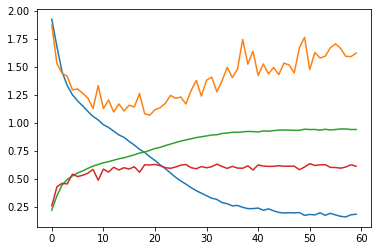

In [16]:
plt.plot(hist)

In [17]:
best_acc

0.6363146551724138

In [12]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_1_4_lbphg.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.286 acc: 0.141
	 - Step 2: loss: 2.090 acc: 0.203
	 - Step 3: loss: 2.432 acc: 0.133
	 - Step 4: loss: 2.157 acc: 0.125
	 - Step 5: loss: 1.997 acc: 0.188
	 - Step 6: loss: 2.106 acc: 0.180
	 - Step 7: loss: 1.978 acc: 0.234
	 - Step 8: loss: 2.073 acc: 0.227
	 - Step 9: loss: 2.154 acc: 0.180
	 - Step 10: loss: 2.124 acc: 0.148
	 - Step 11: loss: 2.105 acc: 0.156
	 - Step 12: loss: 1.964 acc: 0.297
	 - Step 13: loss: 2.120 acc: 0.172
	 - Step 14: loss: 2.141 acc: 0.211
	 - Step 15: loss: 2.106 acc: 0.266
	 - Step 16: loss: 2.097 acc: 0.156
	 - Step 17: loss: 2.037 acc: 0.219
	 - Step 18: loss: 2.163 acc: 0.148
	 - Step 19: loss: 2.080 acc: 0.219
	 - Step 20: loss: 2.120 acc: 0.281
	 - Step 21: loss: 2.072 acc: 0.203
	 - Step 22: loss: 1.923 acc: 0.188
	 - Step 23: loss: 2.168 acc: 0.180
	 - Step 24: loss: 2.057 acc: 0.234
	 - Step 25: loss: 2.056 acc: 0.281
	 - Step 26: loss: 2.083 acc: 0.164
	 - Step 27: loss: 1.905 acc: 0.195
	 - Step 28: loss: 2.071 ac

- Avg. val_loss: 1.593  | Avg. val_acc: 0.403
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


	 - Step 1: loss: 1.600 acc: 0.430
	 - Step 2: loss: 1.640 acc: 0.391
	 - Step 3: loss: 1.491 acc: 0.414
	 - Step 4: loss: 1.539 acc: 0.445
	 - Step 5: loss: 1.533 acc: 0.352
	 - Step 6: loss: 1.584 acc: 0.344
	 - Step 7: loss: 1.572 acc: 0.414
	 - Step 8: loss: 1.622 acc: 0.398
	 - Step 9: loss: 1.579 acc: 0.398
	 - Step 10: loss: 1.623 acc: 0.391
	 - Step 11: loss: 1.648 acc: 0.367
	 - Step 12: loss: 1.530 acc: 0.398
	 - Step 13: loss: 1.559 acc: 0.430
	 - Step 14: loss: 1.623 acc: 0.367
	 - Step 15: loss: 1.470 acc: 0.445
	 - Step 16: loss: 1.417 acc: 0.453
	 - Step 17: loss: 1.643 acc: 0.383
	 - Step 18: loss: 1.497 acc: 0.406
	 - Step 19: loss: 1.504 acc: 0.422
	 - Step 20: loss: 1.548 acc: 0.422
	 - Step 21: loss: 1.706 acc: 0.352
	 - Step 22: loss: 1.443 acc: 0.492
	 - Step 23: loss: 1.568 acc: 0.398
	 - Step 24: loss: 1.553 acc: 0.359
	 - Step 25: loss: 1.443 acc: 0.484
	 - Step 26: loss: 1.588 acc: 0.398
	 - Step 27: loss: 1.392 acc: 0.484
	 - Step 28: loss: 1.551 acc: 0.406
	

- Avg. val_loss: 1.471  | Avg. val_acc: 0.465
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.354 acc: 0.508
	 - Step 2: loss: 1.420 acc: 0.453
	 - Step 3: loss: 1.399 acc: 0.500
	 - Step 4: loss: 1.437 acc: 0.500
	 - Step 5: loss: 1.320 acc: 0.516
	 - Step 6: loss: 1.309 acc: 0.492
	 - Step 7: loss: 1.382 acc: 0.484
	 - Step 8: loss: 1.356 acc: 0.523
	 - Step 9: loss: 1.426 acc: 0.422
	 - Step 10: loss: 1.404 acc: 0.422
	 - Step 11: loss: 1.436 acc: 0.500
	 - Step 12: loss: 1.416 acc: 0.445
	 - Step 13: loss: 1.333 acc: 0.469
	 - Step 14: loss: 1.268 acc: 0.516
	 - Step 15: loss: 1.273 acc: 0.562
	 - Step 16: loss: 1.420 acc: 0.438
	 - Step 17: loss: 1.255 acc: 0.547
	 - Step 18: loss: 1.267 acc: 0.555
	 - Step 19: loss: 1.230 acc: 0.562
	 - Step 20: loss: 1.400 acc: 0.492
	 - Step 21: loss: 1.220 acc: 0.562
	 - Step 22: loss: 1.421 acc: 0.516
	 - Step 23: loss: 1.258 acc: 0.547
	 - Step 24: loss: 1.376 acc: 0.484
	 - Step 25: loss: 1.291 acc: 0.516
	 - Step 26: loss: 1.264 acc: 

	 - Step 224: loss: 1.252 acc: 0.531
	 - Step 225: loss: 1.161 acc: 0.595
- Avg.loss: 1.317  | Avg.acc: 0.509
- Avg. val_loss: 1.429  | Avg. val_acc: 0.471
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.223 acc: 0.539
	 - Step 2: loss: 1.472 acc: 0.453
	 - Step 3: loss: 1.293 acc: 0.547
	 - Step 4: loss: 1.168 acc: 0.531
	 - Step 5: loss: 1.185 acc: 0.547
	 - Step 6: loss: 1.256 acc: 0.500
	 - Step 7: loss: 1.148 acc: 0.547
	 - Step 8: loss: 1.418 acc: 0.492
	 - Step 9: loss: 1.324 acc: 0.555
	 - Step 10: loss: 1.364 acc: 0.461
	 - Step 11: loss: 1.324 acc: 0.500
	 - Step 12: loss: 1.440 acc: 0.469
	 - Step 13: loss: 1.355 acc: 0.500
	 - Step 14: loss: 1.289 acc: 0.523
	 - Step 15: loss: 1.203 acc: 0.609
	 - Step 16: loss: 1.382 acc: 0.477
	 - Step 17: loss: 1.304 acc: 0.500
	 - Step 18: loss: 1.122 acc: 0.586
	 - Step 19: loss: 1.153 acc: 0.633
	 - Step 20: loss: 1.226 acc: 0.539
	 - Step 21: loss: 1.312 acc: 0.492
	 - Step 22: loss: 1.191 acc: 0.562
	 - Step 23: loss: 1.115 acc

	 - Step 221: loss: 1.191 acc: 0.578
	 - Step 222: loss: 1.177 acc: 0.578
	 - Step 223: loss: 1.297 acc: 0.516
	 - Step 224: loss: 1.137 acc: 0.586
	 - Step 225: loss: 1.109 acc: 0.595
- Avg.loss: 1.239  | Avg.acc: 0.543
- Avg. val_loss: 1.327  | Avg. val_acc: 0.512
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.111 acc: 0.609
	 - Step 2: loss: 1.192 acc: 0.547
	 - Step 3: loss: 1.102 acc: 0.594
	 - Step 4: loss: 1.178 acc: 0.516
	 - Step 5: loss: 1.345 acc: 0.430
	 - Step 6: loss: 1.182 acc: 0.547
	 - Step 7: loss: 1.148 acc: 0.617
	 - Step 8: loss: 1.164 acc: 0.578
	 - Step 9: loss: 1.155 acc: 0.578
	 - Step 10: loss: 1.234 acc: 0.523
	 - Step 11: loss: 1.132 acc: 0.617
	 - Step 12: loss: 1.098 acc: 0.609
	 - Step 13: loss: 1.102 acc: 0.617
	 - Step 14: loss: 1.245 acc: 0.531
	 - Step 15: loss: 1.176 acc: 0.523
	 - Step 16: loss: 1.044 acc: 0.609
	 - Step 17: loss: 1.137 acc: 0.594
	 - Step 18: loss: 1.143 acc: 0.586
	 - Step 19: loss: 1.157 acc: 0.617
	 - Step 20: loss: 0.990 

	 - Step 218: loss: 1.110 acc: 0.609
	 - Step 219: loss: 1.104 acc: 0.578
	 - Step 220: loss: 1.079 acc: 0.633
	 - Step 221: loss: 1.073 acc: 0.641
	 - Step 222: loss: 1.150 acc: 0.562
	 - Step 223: loss: 1.105 acc: 0.602
	 - Step 224: loss: 1.105 acc: 0.594
	 - Step 225: loss: 1.060 acc: 0.595
- Avg.loss: 1.175  | Avg.acc: 0.571
- Avg. val_loss: 1.278  | Avg. val_acc: 0.536
* Update optimal model
Epoch:  6
	 - Step 1: loss: 1.186 acc: 0.586
	 - Step 2: loss: 1.024 acc: 0.648
	 - Step 3: loss: 1.082 acc: 0.602
	 - Step 4: loss: 1.063 acc: 0.648
	 - Step 5: loss: 1.064 acc: 0.586
	 - Step 6: loss: 0.986 acc: 0.664
	 - Step 7: loss: 1.123 acc: 0.602
	 - Step 8: loss: 1.249 acc: 0.523
	 - Step 9: loss: 0.992 acc: 0.641
	 - Step 10: loss: 1.230 acc: 0.555
	 - Step 11: loss: 1.143 acc: 0.594
	 - Step 12: loss: 1.038 acc: 0.609
	 - Step 13: loss: 1.026 acc: 0.648
	 - Step 14: loss: 1.124 acc: 0.578
	 - Step 15: loss: 1.041 acc: 0.594
	 - Step 16: loss: 1.081 acc: 0.609
	 - Step 17: loss: 1.0

	 - Step 215: loss: 1.049 acc: 0.641
	 - Step 216: loss: 1.136 acc: 0.586
	 - Step 217: loss: 1.236 acc: 0.516
	 - Step 218: loss: 1.072 acc: 0.617
	 - Step 219: loss: 1.133 acc: 0.570
	 - Step 220: loss: 1.069 acc: 0.656
	 - Step 221: loss: 1.185 acc: 0.570
	 - Step 222: loss: 0.928 acc: 0.688
	 - Step 223: loss: 0.992 acc: 0.672
	 - Step 224: loss: 1.210 acc: 0.578
	 - Step 225: loss: 1.235 acc: 0.486
- Avg.loss: 1.110  | Avg.acc: 0.597
- Avg. val_loss: 1.299  | Avg. val_acc: 0.513
Epoch:  7
	 - Step 1: loss: 1.049 acc: 0.594
	 - Step 2: loss: 1.012 acc: 0.664
	 - Step 3: loss: 0.959 acc: 0.688
	 - Step 4: loss: 1.155 acc: 0.578
	 - Step 5: loss: 1.072 acc: 0.625
	 - Step 6: loss: 1.040 acc: 0.664
	 - Step 7: loss: 1.171 acc: 0.617
	 - Step 8: loss: 1.038 acc: 0.641
	 - Step 9: loss: 1.074 acc: 0.578
	 - Step 10: loss: 1.032 acc: 0.648
	 - Step 11: loss: 1.139 acc: 0.617
	 - Step 12: loss: 1.101 acc: 0.586
	 - Step 13: loss: 1.087 acc: 0.570
	 - Step 14: loss: 1.035 acc: 0.648
	 - St

	 - Step 212: loss: 1.164 acc: 0.562
	 - Step 213: loss: 1.093 acc: 0.594
	 - Step 214: loss: 0.969 acc: 0.680
	 - Step 215: loss: 1.106 acc: 0.594
	 - Step 216: loss: 1.063 acc: 0.594
	 - Step 217: loss: 1.140 acc: 0.617
	 - Step 218: loss: 1.261 acc: 0.547
	 - Step 219: loss: 1.075 acc: 0.656
	 - Step 220: loss: 1.079 acc: 0.656
	 - Step 221: loss: 0.942 acc: 0.672
	 - Step 222: loss: 0.967 acc: 0.648
	 - Step 223: loss: 1.045 acc: 0.594
	 - Step 224: loss: 1.127 acc: 0.602
	 - Step 225: loss: 0.950 acc: 0.649
- Avg.loss: 1.067  | Avg.acc: 0.614
- Avg. val_loss: 1.343  | Avg. val_acc: 0.497
Epoch:  8
	 - Step 1: loss: 0.973 acc: 0.680
	 - Step 2: loss: 1.091 acc: 0.547
	 - Step 3: loss: 0.968 acc: 0.641
	 - Step 4: loss: 1.150 acc: 0.578
	 - Step 5: loss: 1.124 acc: 0.586
	 - Step 6: loss: 1.030 acc: 0.648
	 - Step 7: loss: 1.117 acc: 0.625
	 - Step 8: loss: 1.040 acc: 0.609
	 - Step 9: loss: 1.125 acc: 0.578
	 - Step 10: loss: 1.017 acc: 0.641
	 - Step 11: loss: 0.957 acc: 0.656
	 -

	 - Step 209: loss: 1.101 acc: 0.578
	 - Step 210: loss: 1.088 acc: 0.602
	 - Step 211: loss: 0.938 acc: 0.656
	 - Step 212: loss: 1.045 acc: 0.625
	 - Step 213: loss: 0.993 acc: 0.594
	 - Step 214: loss: 1.197 acc: 0.586
	 - Step 215: loss: 1.231 acc: 0.555
	 - Step 216: loss: 1.072 acc: 0.586
	 - Step 217: loss: 0.993 acc: 0.656
	 - Step 218: loss: 1.033 acc: 0.648
	 - Step 219: loss: 0.868 acc: 0.695
	 - Step 220: loss: 0.976 acc: 0.633
	 - Step 221: loss: 1.088 acc: 0.578
	 - Step 222: loss: 0.999 acc: 0.617
	 - Step 223: loss: 1.045 acc: 0.625
	 - Step 224: loss: 1.159 acc: 0.570
	 - Step 225: loss: 1.086 acc: 0.514
- Avg.loss: 1.036  | Avg.acc: 0.627
- Avg. val_loss: 1.310  | Avg. val_acc: 0.502
Epoch:  9
	 - Step 1: loss: 0.946 acc: 0.641
	 - Step 2: loss: 1.148 acc: 0.562
	 - Step 3: loss: 1.144 acc: 0.570
	 - Step 4: loss: 0.933 acc: 0.672
	 - Step 5: loss: 1.108 acc: 0.594
	 - Step 6: loss: 1.139 acc: 0.570
	 - Step 7: loss: 0.891 acc: 0.719
	 - Step 8: loss: 0.901 acc: 0.719

	 - Step 206: loss: 1.097 acc: 0.617
	 - Step 207: loss: 1.070 acc: 0.609
	 - Step 208: loss: 0.986 acc: 0.633
	 - Step 209: loss: 1.090 acc: 0.609
	 - Step 210: loss: 0.945 acc: 0.680
	 - Step 211: loss: 1.043 acc: 0.633
	 - Step 212: loss: 0.871 acc: 0.695
	 - Step 213: loss: 1.003 acc: 0.648
	 - Step 214: loss: 0.948 acc: 0.664
	 - Step 215: loss: 1.086 acc: 0.586
	 - Step 216: loss: 1.176 acc: 0.531
	 - Step 217: loss: 0.951 acc: 0.648
	 - Step 218: loss: 0.971 acc: 0.648
	 - Step 219: loss: 1.029 acc: 0.625
	 - Step 220: loss: 1.193 acc: 0.594
	 - Step 221: loss: 1.113 acc: 0.609
	 - Step 222: loss: 1.016 acc: 0.633
	 - Step 223: loss: 0.901 acc: 0.703
	 - Step 224: loss: 1.083 acc: 0.625
	 - Step 225: loss: 1.255 acc: 0.568
- Avg.loss: 1.001  | Avg.acc: 0.646
- Avg. val_loss: 1.285  | Avg. val_acc: 0.524
Epoch:  10
	 - Step 1: loss: 0.928 acc: 0.703
	 - Step 2: loss: 0.906 acc: 0.672
	 - Step 3: loss: 0.960 acc: 0.680
	 - Step 4: loss: 1.036 acc: 0.625
	 - Step 5: loss: 0.888 acc

	 - Step 203: loss: 0.810 acc: 0.719
	 - Step 204: loss: 0.964 acc: 0.672
	 - Step 205: loss: 0.947 acc: 0.695
	 - Step 206: loss: 0.979 acc: 0.695
	 - Step 207: loss: 1.026 acc: 0.648
	 - Step 208: loss: 1.082 acc: 0.625
	 - Step 209: loss: 1.043 acc: 0.664
	 - Step 210: loss: 0.970 acc: 0.609
	 - Step 211: loss: 0.869 acc: 0.664
	 - Step 212: loss: 0.938 acc: 0.672
	 - Step 213: loss: 0.893 acc: 0.711
	 - Step 214: loss: 0.902 acc: 0.711
	 - Step 215: loss: 1.058 acc: 0.609
	 - Step 216: loss: 1.079 acc: 0.609
	 - Step 217: loss: 0.983 acc: 0.625
	 - Step 218: loss: 1.074 acc: 0.625
	 - Step 219: loss: 1.102 acc: 0.609
	 - Step 220: loss: 0.829 acc: 0.664
	 - Step 221: loss: 0.866 acc: 0.688
	 - Step 222: loss: 1.099 acc: 0.578
	 - Step 223: loss: 0.891 acc: 0.711
	 - Step 224: loss: 1.075 acc: 0.617
	 - Step 225: loss: 1.321 acc: 0.486
- Avg.loss: 0.959  | Avg.acc: 0.658
- Avg. val_loss: 1.185  | Avg. val_acc: 0.569
* Update optimal model
Epoch:  11
	 - Step 1: loss: 0.858 acc: 0.71

	 - Step 200: loss: 0.923 acc: 0.695
	 - Step 201: loss: 0.988 acc: 0.625
	 - Step 202: loss: 0.952 acc: 0.617
	 - Step 203: loss: 0.984 acc: 0.680
	 - Step 204: loss: 0.949 acc: 0.656
	 - Step 205: loss: 0.863 acc: 0.703
	 - Step 206: loss: 0.963 acc: 0.664
	 - Step 207: loss: 0.992 acc: 0.688
	 - Step 208: loss: 0.929 acc: 0.617
	 - Step 209: loss: 0.935 acc: 0.688
	 - Step 210: loss: 0.863 acc: 0.672
	 - Step 211: loss: 0.898 acc: 0.688
	 - Step 212: loss: 0.982 acc: 0.641
	 - Step 213: loss: 0.991 acc: 0.672
	 - Step 214: loss: 0.875 acc: 0.680
	 - Step 215: loss: 0.812 acc: 0.688
	 - Step 216: loss: 0.920 acc: 0.711
	 - Step 217: loss: 0.881 acc: 0.680
	 - Step 218: loss: 0.962 acc: 0.656
	 - Step 219: loss: 0.801 acc: 0.711
	 - Step 220: loss: 0.817 acc: 0.711
	 - Step 221: loss: 0.932 acc: 0.711
	 - Step 222: loss: 0.841 acc: 0.703
	 - Step 223: loss: 0.956 acc: 0.648
	 - Step 224: loss: 0.971 acc: 0.656
	 - Step 225: loss: 1.161 acc: 0.514
- Avg.loss: 0.930  | Avg.acc: 0.665
- 

	 - Step 197: loss: 1.001 acc: 0.625
	 - Step 198: loss: 0.912 acc: 0.609
	 - Step 199: loss: 0.943 acc: 0.641
	 - Step 200: loss: 0.971 acc: 0.648
	 - Step 201: loss: 1.094 acc: 0.625
	 - Step 202: loss: 0.828 acc: 0.688
	 - Step 203: loss: 0.843 acc: 0.688
	 - Step 204: loss: 1.014 acc: 0.648
	 - Step 205: loss: 0.891 acc: 0.727
	 - Step 206: loss: 0.853 acc: 0.719
	 - Step 207: loss: 0.884 acc: 0.680
	 - Step 208: loss: 1.033 acc: 0.641
	 - Step 209: loss: 0.958 acc: 0.664
	 - Step 210: loss: 1.033 acc: 0.672
	 - Step 211: loss: 0.834 acc: 0.711
	 - Step 212: loss: 0.830 acc: 0.688
	 - Step 213: loss: 0.979 acc: 0.656
	 - Step 214: loss: 0.994 acc: 0.641
	 - Step 215: loss: 0.848 acc: 0.672
	 - Step 216: loss: 0.937 acc: 0.633
	 - Step 217: loss: 0.981 acc: 0.672
	 - Step 218: loss: 0.918 acc: 0.711
	 - Step 219: loss: 1.022 acc: 0.625
	 - Step 220: loss: 0.775 acc: 0.742
	 - Step 221: loss: 1.072 acc: 0.602
	 - Step 222: loss: 0.902 acc: 0.703
	 - Step 223: loss: 0.794 acc: 0.695
	

	 - Step 194: loss: 0.820 acc: 0.688
	 - Step 195: loss: 0.856 acc: 0.758
	 - Step 196: loss: 1.078 acc: 0.609
	 - Step 197: loss: 0.863 acc: 0.688
	 - Step 198: loss: 0.846 acc: 0.688
	 - Step 199: loss: 0.907 acc: 0.664
	 - Step 200: loss: 0.964 acc: 0.664
	 - Step 201: loss: 0.796 acc: 0.734
	 - Step 202: loss: 0.937 acc: 0.633
	 - Step 203: loss: 0.838 acc: 0.680
	 - Step 204: loss: 0.840 acc: 0.688
	 - Step 205: loss: 0.878 acc: 0.680
	 - Step 206: loss: 1.011 acc: 0.547
	 - Step 207: loss: 0.815 acc: 0.688
	 - Step 208: loss: 0.950 acc: 0.672
	 - Step 209: loss: 0.873 acc: 0.648
	 - Step 210: loss: 0.841 acc: 0.711
	 - Step 211: loss: 0.943 acc: 0.688
	 - Step 212: loss: 1.005 acc: 0.641
	 - Step 213: loss: 0.786 acc: 0.688
	 - Step 214: loss: 0.824 acc: 0.719
	 - Step 215: loss: 0.774 acc: 0.703
	 - Step 216: loss: 0.866 acc: 0.688
	 - Step 217: loss: 0.915 acc: 0.695
	 - Step 218: loss: 0.799 acc: 0.758
	 - Step 219: loss: 0.892 acc: 0.688
	 - Step 220: loss: 0.905 acc: 0.656
	

	 - Step 191: loss: 0.958 acc: 0.656
	 - Step 192: loss: 0.795 acc: 0.734
	 - Step 193: loss: 0.952 acc: 0.688
	 - Step 194: loss: 0.845 acc: 0.703
	 - Step 195: loss: 0.946 acc: 0.695
	 - Step 196: loss: 0.803 acc: 0.695
	 - Step 197: loss: 0.939 acc: 0.664
	 - Step 198: loss: 0.797 acc: 0.703
	 - Step 199: loss: 0.891 acc: 0.734
	 - Step 200: loss: 0.921 acc: 0.703
	 - Step 201: loss: 0.840 acc: 0.703
	 - Step 202: loss: 0.769 acc: 0.734
	 - Step 203: loss: 0.938 acc: 0.617
	 - Step 204: loss: 0.743 acc: 0.688
	 - Step 205: loss: 0.833 acc: 0.711
	 - Step 206: loss: 0.850 acc: 0.711
	 - Step 207: loss: 0.835 acc: 0.672
	 - Step 208: loss: 0.892 acc: 0.695
	 - Step 209: loss: 0.873 acc: 0.703
	 - Step 210: loss: 0.717 acc: 0.750
	 - Step 211: loss: 0.917 acc: 0.656
	 - Step 212: loss: 0.918 acc: 0.664
	 - Step 213: loss: 0.725 acc: 0.750
	 - Step 214: loss: 0.763 acc: 0.742
	 - Step 215: loss: 0.936 acc: 0.680
	 - Step 216: loss: 0.971 acc: 0.609
	 - Step 217: loss: 0.770 acc: 0.727
	

	 - Step 188: loss: 0.844 acc: 0.688
	 - Step 189: loss: 0.875 acc: 0.734
	 - Step 190: loss: 0.956 acc: 0.641
	 - Step 191: loss: 1.031 acc: 0.656
	 - Step 192: loss: 0.904 acc: 0.695
	 - Step 193: loss: 0.971 acc: 0.656
	 - Step 194: loss: 0.917 acc: 0.695
	 - Step 195: loss: 0.808 acc: 0.688
	 - Step 196: loss: 0.948 acc: 0.711
	 - Step 197: loss: 0.742 acc: 0.758
	 - Step 198: loss: 0.849 acc: 0.719
	 - Step 199: loss: 0.743 acc: 0.734
	 - Step 200: loss: 0.761 acc: 0.734
	 - Step 201: loss: 0.726 acc: 0.758
	 - Step 202: loss: 0.752 acc: 0.773
	 - Step 203: loss: 0.793 acc: 0.719
	 - Step 204: loss: 0.848 acc: 0.648
	 - Step 205: loss: 0.794 acc: 0.719
	 - Step 206: loss: 0.802 acc: 0.727
	 - Step 207: loss: 0.913 acc: 0.641
	 - Step 208: loss: 0.806 acc: 0.703
	 - Step 209: loss: 0.736 acc: 0.719
	 - Step 210: loss: 0.848 acc: 0.695
	 - Step 211: loss: 0.738 acc: 0.711
	 - Step 212: loss: 0.798 acc: 0.742
	 - Step 213: loss: 0.831 acc: 0.680
	 - Step 214: loss: 0.630 acc: 0.773
	

	 - Step 185: loss: 0.848 acc: 0.711
	 - Step 186: loss: 0.843 acc: 0.734
	 - Step 187: loss: 0.733 acc: 0.750
	 - Step 188: loss: 0.812 acc: 0.727
	 - Step 189: loss: 0.822 acc: 0.680
	 - Step 190: loss: 0.865 acc: 0.688
	 - Step 191: loss: 0.783 acc: 0.727
	 - Step 192: loss: 0.701 acc: 0.758
	 - Step 193: loss: 0.901 acc: 0.680
	 - Step 194: loss: 0.790 acc: 0.781
	 - Step 195: loss: 0.638 acc: 0.766
	 - Step 196: loss: 0.770 acc: 0.773
	 - Step 197: loss: 0.778 acc: 0.695
	 - Step 198: loss: 0.888 acc: 0.688
	 - Step 199: loss: 0.778 acc: 0.711
	 - Step 200: loss: 0.857 acc: 0.648
	 - Step 201: loss: 0.654 acc: 0.734
	 - Step 202: loss: 0.678 acc: 0.719
	 - Step 203: loss: 0.830 acc: 0.688
	 - Step 204: loss: 0.685 acc: 0.758
	 - Step 205: loss: 0.783 acc: 0.734
	 - Step 206: loss: 0.755 acc: 0.758
	 - Step 207: loss: 0.794 acc: 0.711
	 - Step 208: loss: 0.770 acc: 0.727
	 - Step 209: loss: 0.792 acc: 0.695
	 - Step 210: loss: 0.856 acc: 0.727
	 - Step 211: loss: 0.689 acc: 0.766
	

	 - Step 182: loss: 0.760 acc: 0.734
	 - Step 183: loss: 0.705 acc: 0.734
	 - Step 184: loss: 0.701 acc: 0.773
	 - Step 185: loss: 0.815 acc: 0.703
	 - Step 186: loss: 0.820 acc: 0.680
	 - Step 187: loss: 0.638 acc: 0.766
	 - Step 188: loss: 0.710 acc: 0.758
	 - Step 189: loss: 0.789 acc: 0.766
	 - Step 190: loss: 0.665 acc: 0.758
	 - Step 191: loss: 0.780 acc: 0.719
	 - Step 192: loss: 0.807 acc: 0.727
	 - Step 193: loss: 0.850 acc: 0.648
	 - Step 194: loss: 0.704 acc: 0.711
	 - Step 195: loss: 0.704 acc: 0.789
	 - Step 196: loss: 0.877 acc: 0.711
	 - Step 197: loss: 0.816 acc: 0.711
	 - Step 198: loss: 0.691 acc: 0.711
	 - Step 199: loss: 0.590 acc: 0.773
	 - Step 200: loss: 0.910 acc: 0.680
	 - Step 201: loss: 0.915 acc: 0.680
	 - Step 202: loss: 0.747 acc: 0.727
	 - Step 203: loss: 0.801 acc: 0.727
	 - Step 204: loss: 0.663 acc: 0.781
	 - Step 205: loss: 0.625 acc: 0.820
	 - Step 206: loss: 0.846 acc: 0.680
	 - Step 207: loss: 0.787 acc: 0.695
	 - Step 208: loss: 0.746 acc: 0.711
	

	 - Step 179: loss: 0.630 acc: 0.781
	 - Step 180: loss: 0.719 acc: 0.734
	 - Step 181: loss: 0.799 acc: 0.695
	 - Step 182: loss: 0.638 acc: 0.781
	 - Step 183: loss: 0.612 acc: 0.820
	 - Step 184: loss: 0.731 acc: 0.750
	 - Step 185: loss: 0.778 acc: 0.766
	 - Step 186: loss: 0.700 acc: 0.805
	 - Step 187: loss: 0.825 acc: 0.734
	 - Step 188: loss: 0.806 acc: 0.734
	 - Step 189: loss: 0.745 acc: 0.719
	 - Step 190: loss: 0.828 acc: 0.711
	 - Step 191: loss: 0.741 acc: 0.766
	 - Step 192: loss: 0.691 acc: 0.719
	 - Step 193: loss: 0.537 acc: 0.844
	 - Step 194: loss: 0.509 acc: 0.875
	 - Step 195: loss: 0.604 acc: 0.773
	 - Step 196: loss: 0.617 acc: 0.828
	 - Step 197: loss: 0.689 acc: 0.773
	 - Step 198: loss: 0.700 acc: 0.789
	 - Step 199: loss: 0.833 acc: 0.664
	 - Step 200: loss: 0.678 acc: 0.750
	 - Step 201: loss: 0.684 acc: 0.766
	 - Step 202: loss: 0.849 acc: 0.703
	 - Step 203: loss: 0.756 acc: 0.742
	 - Step 204: loss: 0.644 acc: 0.758
	 - Step 205: loss: 0.664 acc: 0.742
	

	 - Step 176: loss: 0.581 acc: 0.844
	 - Step 177: loss: 0.632 acc: 0.797
	 - Step 178: loss: 0.717 acc: 0.758
	 - Step 179: loss: 0.782 acc: 0.742
	 - Step 180: loss: 0.633 acc: 0.773
	 - Step 181: loss: 0.762 acc: 0.711
	 - Step 182: loss: 0.637 acc: 0.781
	 - Step 183: loss: 0.669 acc: 0.773
	 - Step 184: loss: 0.627 acc: 0.750
	 - Step 185: loss: 0.781 acc: 0.727
	 - Step 186: loss: 0.598 acc: 0.820
	 - Step 187: loss: 0.619 acc: 0.805
	 - Step 188: loss: 0.632 acc: 0.812
	 - Step 189: loss: 0.674 acc: 0.805
	 - Step 190: loss: 0.668 acc: 0.781
	 - Step 191: loss: 0.808 acc: 0.734
	 - Step 192: loss: 0.739 acc: 0.758
	 - Step 193: loss: 0.656 acc: 0.773
	 - Step 194: loss: 0.920 acc: 0.672
	 - Step 195: loss: 0.605 acc: 0.789
	 - Step 196: loss: 0.700 acc: 0.766
	 - Step 197: loss: 0.616 acc: 0.773
	 - Step 198: loss: 0.824 acc: 0.719
	 - Step 199: loss: 0.596 acc: 0.750
	 - Step 200: loss: 0.666 acc: 0.766
	 - Step 201: loss: 0.629 acc: 0.820
	 - Step 202: loss: 0.716 acc: 0.766
	

	 - Step 173: loss: 0.683 acc: 0.781
	 - Step 174: loss: 0.585 acc: 0.758
	 - Step 175: loss: 0.611 acc: 0.805
	 - Step 176: loss: 0.556 acc: 0.812
	 - Step 177: loss: 0.828 acc: 0.695
	 - Step 178: loss: 0.554 acc: 0.836
	 - Step 179: loss: 0.540 acc: 0.820
	 - Step 180: loss: 0.456 acc: 0.859
	 - Step 181: loss: 0.796 acc: 0.734
	 - Step 182: loss: 0.833 acc: 0.703
	 - Step 183: loss: 0.480 acc: 0.875
	 - Step 184: loss: 0.671 acc: 0.734
	 - Step 185: loss: 0.564 acc: 0.844
	 - Step 186: loss: 0.719 acc: 0.789
	 - Step 187: loss: 0.618 acc: 0.781
	 - Step 188: loss: 0.566 acc: 0.812
	 - Step 189: loss: 0.616 acc: 0.766
	 - Step 190: loss: 0.494 acc: 0.828
	 - Step 191: loss: 0.680 acc: 0.773
	 - Step 192: loss: 0.781 acc: 0.750
	 - Step 193: loss: 0.656 acc: 0.766
	 - Step 194: loss: 0.633 acc: 0.773
	 - Step 195: loss: 0.482 acc: 0.859
	 - Step 196: loss: 0.604 acc: 0.781
	 - Step 197: loss: 0.659 acc: 0.797
	 - Step 198: loss: 0.657 acc: 0.797
	 - Step 199: loss: 0.634 acc: 0.820
	

	 - Step 170: loss: 0.791 acc: 0.750
	 - Step 171: loss: 0.661 acc: 0.758
	 - Step 172: loss: 0.659 acc: 0.781
	 - Step 173: loss: 0.622 acc: 0.766
	 - Step 174: loss: 0.633 acc: 0.781
	 - Step 175: loss: 0.517 acc: 0.812
	 - Step 176: loss: 0.573 acc: 0.789
	 - Step 177: loss: 0.632 acc: 0.820
	 - Step 178: loss: 0.586 acc: 0.781
	 - Step 179: loss: 0.516 acc: 0.781
	 - Step 180: loss: 0.636 acc: 0.750
	 - Step 181: loss: 0.583 acc: 0.797
	 - Step 182: loss: 0.628 acc: 0.820
	 - Step 183: loss: 0.606 acc: 0.789
	 - Step 184: loss: 0.557 acc: 0.797
	 - Step 185: loss: 0.518 acc: 0.805
	 - Step 186: loss: 0.783 acc: 0.734
	 - Step 187: loss: 0.732 acc: 0.734
	 - Step 188: loss: 0.578 acc: 0.773
	 - Step 189: loss: 0.456 acc: 0.852
	 - Step 190: loss: 0.666 acc: 0.758
	 - Step 191: loss: 0.531 acc: 0.836
	 - Step 192: loss: 0.638 acc: 0.781
	 - Step 193: loss: 0.763 acc: 0.734
	 - Step 194: loss: 0.457 acc: 0.875
	 - Step 195: loss: 0.635 acc: 0.805
	 - Step 196: loss: 0.585 acc: 0.836
	

	 - Step 167: loss: 0.554 acc: 0.805
	 - Step 168: loss: 0.614 acc: 0.742
	 - Step 169: loss: 0.579 acc: 0.812
	 - Step 170: loss: 0.483 acc: 0.812
	 - Step 171: loss: 0.485 acc: 0.812
	 - Step 172: loss: 0.573 acc: 0.812
	 - Step 173: loss: 0.520 acc: 0.828
	 - Step 174: loss: 0.649 acc: 0.789
	 - Step 175: loss: 0.463 acc: 0.852
	 - Step 176: loss: 0.435 acc: 0.867
	 - Step 177: loss: 0.361 acc: 0.914
	 - Step 178: loss: 0.513 acc: 0.789
	 - Step 179: loss: 0.496 acc: 0.820
	 - Step 180: loss: 0.570 acc: 0.797
	 - Step 181: loss: 0.569 acc: 0.820
	 - Step 182: loss: 0.493 acc: 0.844
	 - Step 183: loss: 0.660 acc: 0.797
	 - Step 184: loss: 0.409 acc: 0.875
	 - Step 185: loss: 0.743 acc: 0.742
	 - Step 186: loss: 0.630 acc: 0.781
	 - Step 187: loss: 0.511 acc: 0.805
	 - Step 188: loss: 0.526 acc: 0.812
	 - Step 189: loss: 0.482 acc: 0.836
	 - Step 190: loss: 0.592 acc: 0.781
	 - Step 191: loss: 0.440 acc: 0.859
	 - Step 192: loss: 0.558 acc: 0.812
	 - Step 193: loss: 0.465 acc: 0.844
	

	 - Step 164: loss: 0.595 acc: 0.805
	 - Step 165: loss: 0.527 acc: 0.828
	 - Step 166: loss: 0.686 acc: 0.781
	 - Step 167: loss: 0.674 acc: 0.789
	 - Step 168: loss: 0.570 acc: 0.766
	 - Step 169: loss: 0.669 acc: 0.773
	 - Step 170: loss: 0.424 acc: 0.844
	 - Step 171: loss: 0.506 acc: 0.812
	 - Step 172: loss: 0.439 acc: 0.820
	 - Step 173: loss: 0.518 acc: 0.828
	 - Step 174: loss: 0.602 acc: 0.781
	 - Step 175: loss: 0.741 acc: 0.781
	 - Step 176: loss: 0.581 acc: 0.844
	 - Step 177: loss: 0.509 acc: 0.852
	 - Step 178: loss: 0.463 acc: 0.859
	 - Step 179: loss: 0.516 acc: 0.844
	 - Step 180: loss: 0.625 acc: 0.805
	 - Step 181: loss: 0.601 acc: 0.773
	 - Step 182: loss: 0.545 acc: 0.805
	 - Step 183: loss: 0.396 acc: 0.875
	 - Step 184: loss: 0.615 acc: 0.828
	 - Step 185: loss: 0.461 acc: 0.828
	 - Step 186: loss: 0.725 acc: 0.719
	 - Step 187: loss: 0.524 acc: 0.805
	 - Step 188: loss: 0.443 acc: 0.875
	 - Step 189: loss: 0.663 acc: 0.766
	 - Step 190: loss: 0.651 acc: 0.773
	

	 - Step 161: loss: 0.425 acc: 0.867
	 - Step 162: loss: 0.367 acc: 0.891
	 - Step 163: loss: 0.431 acc: 0.867
	 - Step 164: loss: 0.378 acc: 0.883
	 - Step 165: loss: 0.533 acc: 0.812
	 - Step 166: loss: 0.558 acc: 0.812
	 - Step 167: loss: 0.405 acc: 0.875
	 - Step 168: loss: 0.378 acc: 0.844
	 - Step 169: loss: 0.636 acc: 0.781
	 - Step 170: loss: 0.434 acc: 0.852
	 - Step 171: loss: 0.464 acc: 0.883
	 - Step 172: loss: 0.473 acc: 0.812
	 - Step 173: loss: 0.491 acc: 0.828
	 - Step 174: loss: 0.476 acc: 0.852
	 - Step 175: loss: 0.712 acc: 0.773
	 - Step 176: loss: 0.622 acc: 0.789
	 - Step 177: loss: 0.397 acc: 0.859
	 - Step 178: loss: 0.490 acc: 0.836
	 - Step 179: loss: 0.610 acc: 0.797
	 - Step 180: loss: 0.333 acc: 0.883
	 - Step 181: loss: 0.487 acc: 0.812
	 - Step 182: loss: 0.507 acc: 0.836
	 - Step 183: loss: 0.565 acc: 0.812
	 - Step 184: loss: 0.489 acc: 0.867
	 - Step 185: loss: 0.517 acc: 0.805
	 - Step 186: loss: 0.651 acc: 0.773
	 - Step 187: loss: 0.463 acc: 0.836
	

	 - Step 158: loss: 0.403 acc: 0.852
	 - Step 159: loss: 0.391 acc: 0.852
	 - Step 160: loss: 0.495 acc: 0.805
	 - Step 161: loss: 0.224 acc: 0.906
	 - Step 162: loss: 0.288 acc: 0.906
	 - Step 163: loss: 0.269 acc: 0.938
	 - Step 164: loss: 0.459 acc: 0.852
	 - Step 165: loss: 0.459 acc: 0.875
	 - Step 166: loss: 0.576 acc: 0.859
	 - Step 167: loss: 0.529 acc: 0.828
	 - Step 168: loss: 0.531 acc: 0.797
	 - Step 169: loss: 0.425 acc: 0.852
	 - Step 170: loss: 0.568 acc: 0.781
	 - Step 171: loss: 0.425 acc: 0.859
	 - Step 172: loss: 0.385 acc: 0.875
	 - Step 173: loss: 0.544 acc: 0.820
	 - Step 174: loss: 0.424 acc: 0.875
	 - Step 175: loss: 0.413 acc: 0.883
	 - Step 176: loss: 0.568 acc: 0.812
	 - Step 177: loss: 0.423 acc: 0.836
	 - Step 178: loss: 0.507 acc: 0.812
	 - Step 179: loss: 0.473 acc: 0.859
	 - Step 180: loss: 0.485 acc: 0.852
	 - Step 181: loss: 0.593 acc: 0.805
	 - Step 182: loss: 0.544 acc: 0.828
	 - Step 183: loss: 0.352 acc: 0.883
	 - Step 184: loss: 0.379 acc: 0.859
	

	 - Step 155: loss: 0.411 acc: 0.859
	 - Step 156: loss: 0.508 acc: 0.867
	 - Step 157: loss: 0.508 acc: 0.836
	 - Step 158: loss: 0.300 acc: 0.898
	 - Step 159: loss: 0.431 acc: 0.852
	 - Step 160: loss: 0.411 acc: 0.844
	 - Step 161: loss: 0.529 acc: 0.836
	 - Step 162: loss: 0.417 acc: 0.859
	 - Step 163: loss: 0.316 acc: 0.906
	 - Step 164: loss: 0.405 acc: 0.859
	 - Step 165: loss: 0.408 acc: 0.883
	 - Step 166: loss: 0.453 acc: 0.859
	 - Step 167: loss: 0.394 acc: 0.852
	 - Step 168: loss: 0.524 acc: 0.828
	 - Step 169: loss: 0.335 acc: 0.859
	 - Step 170: loss: 0.341 acc: 0.891
	 - Step 171: loss: 0.326 acc: 0.906
	 - Step 172: loss: 0.566 acc: 0.812
	 - Step 173: loss: 0.305 acc: 0.898
	 - Step 174: loss: 0.357 acc: 0.875
	 - Step 175: loss: 0.441 acc: 0.844
	 - Step 176: loss: 0.445 acc: 0.898
	 - Step 177: loss: 0.427 acc: 0.859
	 - Step 178: loss: 0.476 acc: 0.820
	 - Step 179: loss: 0.321 acc: 0.898
	 - Step 180: loss: 0.439 acc: 0.852
	 - Step 181: loss: 0.471 acc: 0.844
	

	 - Step 152: loss: 0.410 acc: 0.828
	 - Step 153: loss: 0.390 acc: 0.852
	 - Step 154: loss: 0.514 acc: 0.812
	 - Step 155: loss: 0.402 acc: 0.867
	 - Step 156: loss: 0.477 acc: 0.820
	 - Step 157: loss: 0.367 acc: 0.883
	 - Step 158: loss: 0.295 acc: 0.906
	 - Step 159: loss: 0.366 acc: 0.867
	 - Step 160: loss: 0.447 acc: 0.859
	 - Step 161: loss: 0.431 acc: 0.836
	 - Step 162: loss: 0.426 acc: 0.867
	 - Step 163: loss: 0.497 acc: 0.828
	 - Step 164: loss: 0.359 acc: 0.867
	 - Step 165: loss: 0.514 acc: 0.844
	 - Step 166: loss: 0.315 acc: 0.914
	 - Step 167: loss: 0.351 acc: 0.906
	 - Step 168: loss: 0.541 acc: 0.789
	 - Step 169: loss: 0.552 acc: 0.797
	 - Step 170: loss: 0.609 acc: 0.820
	 - Step 171: loss: 0.500 acc: 0.820
	 - Step 172: loss: 0.542 acc: 0.820
	 - Step 173: loss: 0.338 acc: 0.898
	 - Step 174: loss: 0.342 acc: 0.891
	 - Step 175: loss: 0.440 acc: 0.844
	 - Step 176: loss: 0.271 acc: 0.938
	 - Step 177: loss: 0.411 acc: 0.883
	 - Step 178: loss: 0.454 acc: 0.844
	

	 - Step 149: loss: 0.282 acc: 0.898
	 - Step 150: loss: 0.452 acc: 0.836
	 - Step 151: loss: 0.434 acc: 0.844
	 - Step 152: loss: 0.332 acc: 0.898
	 - Step 153: loss: 0.402 acc: 0.875
	 - Step 154: loss: 0.576 acc: 0.812
	 - Step 155: loss: 0.413 acc: 0.852
	 - Step 156: loss: 0.404 acc: 0.883
	 - Step 157: loss: 0.291 acc: 0.906
	 - Step 158: loss: 0.352 acc: 0.875
	 - Step 159: loss: 0.505 acc: 0.852
	 - Step 160: loss: 0.460 acc: 0.852
	 - Step 161: loss: 0.349 acc: 0.875
	 - Step 162: loss: 0.438 acc: 0.844
	 - Step 163: loss: 0.484 acc: 0.859
	 - Step 164: loss: 0.399 acc: 0.859
	 - Step 165: loss: 0.390 acc: 0.883
	 - Step 166: loss: 0.400 acc: 0.898
	 - Step 167: loss: 0.475 acc: 0.828
	 - Step 168: loss: 0.412 acc: 0.859
	 - Step 169: loss: 0.406 acc: 0.883
	 - Step 170: loss: 0.383 acc: 0.875
	 - Step 171: loss: 0.353 acc: 0.898
	 - Step 172: loss: 0.484 acc: 0.828
	 - Step 173: loss: 0.459 acc: 0.836
	 - Step 174: loss: 0.302 acc: 0.914
	 - Step 175: loss: 0.522 acc: 0.867
	

	 - Step 146: loss: 0.416 acc: 0.859
	 - Step 147: loss: 0.254 acc: 0.906
	 - Step 148: loss: 0.436 acc: 0.859
	 - Step 149: loss: 0.342 acc: 0.883
	 - Step 150: loss: 0.431 acc: 0.906
	 - Step 151: loss: 0.311 acc: 0.906
	 - Step 152: loss: 0.360 acc: 0.875
	 - Step 153: loss: 0.331 acc: 0.891
	 - Step 154: loss: 0.408 acc: 0.859
	 - Step 155: loss: 0.351 acc: 0.906
	 - Step 156: loss: 0.321 acc: 0.914
	 - Step 157: loss: 0.280 acc: 0.898
	 - Step 158: loss: 0.333 acc: 0.891
	 - Step 159: loss: 0.240 acc: 0.922
	 - Step 160: loss: 0.402 acc: 0.859
	 - Step 161: loss: 0.236 acc: 0.922
	 - Step 162: loss: 0.191 acc: 0.969
	 - Step 163: loss: 0.466 acc: 0.844
	 - Step 164: loss: 0.317 acc: 0.914
	 - Step 165: loss: 0.396 acc: 0.875
	 - Step 166: loss: 0.283 acc: 0.938
	 - Step 167: loss: 0.273 acc: 0.906
	 - Step 168: loss: 0.403 acc: 0.859
	 - Step 169: loss: 0.278 acc: 0.906
	 - Step 170: loss: 0.327 acc: 0.906
	 - Step 171: loss: 0.397 acc: 0.891
	 - Step 172: loss: 0.302 acc: 0.898
	

	 - Step 143: loss: 0.386 acc: 0.867
	 - Step 144: loss: 0.254 acc: 0.922
	 - Step 145: loss: 0.283 acc: 0.930
	 - Step 146: loss: 0.396 acc: 0.875
	 - Step 147: loss: 0.330 acc: 0.898
	 - Step 148: loss: 0.332 acc: 0.891
	 - Step 149: loss: 0.336 acc: 0.859
	 - Step 150: loss: 0.281 acc: 0.875
	 - Step 151: loss: 0.310 acc: 0.906
	 - Step 152: loss: 0.455 acc: 0.867
	 - Step 153: loss: 0.251 acc: 0.906
	 - Step 154: loss: 0.236 acc: 0.938
	 - Step 155: loss: 0.252 acc: 0.930
	 - Step 156: loss: 0.385 acc: 0.867
	 - Step 157: loss: 0.379 acc: 0.891
	 - Step 158: loss: 0.252 acc: 0.938
	 - Step 159: loss: 0.298 acc: 0.891
	 - Step 160: loss: 0.367 acc: 0.859
	 - Step 161: loss: 0.291 acc: 0.883
	 - Step 162: loss: 0.228 acc: 0.930
	 - Step 163: loss: 0.427 acc: 0.859
	 - Step 164: loss: 0.281 acc: 0.891
	 - Step 165: loss: 0.366 acc: 0.906
	 - Step 166: loss: 0.335 acc: 0.891
	 - Step 167: loss: 0.356 acc: 0.859
	 - Step 168: loss: 0.251 acc: 0.922
	 - Step 169: loss: 0.580 acc: 0.820
	

	 - Step 140: loss: 0.327 acc: 0.906
	 - Step 141: loss: 0.443 acc: 0.859
	 - Step 142: loss: 0.284 acc: 0.867
	 - Step 143: loss: 0.351 acc: 0.883
	 - Step 144: loss: 0.250 acc: 0.914
	 - Step 145: loss: 0.261 acc: 0.906
	 - Step 146: loss: 0.274 acc: 0.906
	 - Step 147: loss: 0.288 acc: 0.922
	 - Step 148: loss: 0.287 acc: 0.906
	 - Step 149: loss: 0.273 acc: 0.914
	 - Step 150: loss: 0.324 acc: 0.867
	 - Step 151: loss: 0.327 acc: 0.906
	 - Step 152: loss: 0.296 acc: 0.906
	 - Step 153: loss: 0.224 acc: 0.906
	 - Step 154: loss: 0.576 acc: 0.812
	 - Step 155: loss: 0.286 acc: 0.898
	 - Step 156: loss: 0.342 acc: 0.875
	 - Step 157: loss: 0.214 acc: 0.953
	 - Step 158: loss: 0.268 acc: 0.914
	 - Step 159: loss: 0.443 acc: 0.859
	 - Step 160: loss: 0.363 acc: 0.875
	 - Step 161: loss: 0.366 acc: 0.883
	 - Step 162: loss: 0.343 acc: 0.914
	 - Step 163: loss: 0.323 acc: 0.891
	 - Step 164: loss: 0.321 acc: 0.914
	 - Step 165: loss: 0.319 acc: 0.875
	 - Step 166: loss: 0.468 acc: 0.852
	

	 - Step 137: loss: 0.314 acc: 0.883
	 - Step 138: loss: 0.284 acc: 0.906
	 - Step 139: loss: 0.222 acc: 0.930
	 - Step 140: loss: 0.304 acc: 0.930
	 - Step 141: loss: 0.230 acc: 0.922
	 - Step 142: loss: 0.251 acc: 0.930
	 - Step 143: loss: 0.209 acc: 0.945
	 - Step 144: loss: 0.348 acc: 0.898
	 - Step 145: loss: 0.344 acc: 0.859
	 - Step 146: loss: 0.341 acc: 0.914
	 - Step 147: loss: 0.260 acc: 0.930
	 - Step 148: loss: 0.242 acc: 0.922
	 - Step 149: loss: 0.177 acc: 0.922
	 - Step 150: loss: 0.361 acc: 0.875
	 - Step 151: loss: 0.400 acc: 0.883
	 - Step 152: loss: 0.125 acc: 0.977
	 - Step 153: loss: 0.319 acc: 0.891
	 - Step 154: loss: 0.320 acc: 0.898
	 - Step 155: loss: 0.318 acc: 0.914
	 - Step 156: loss: 0.254 acc: 0.906
	 - Step 157: loss: 0.315 acc: 0.883
	 - Step 158: loss: 0.364 acc: 0.891
	 - Step 159: loss: 0.189 acc: 0.930
	 - Step 160: loss: 0.278 acc: 0.891
	 - Step 161: loss: 0.305 acc: 0.906
	 - Step 162: loss: 0.247 acc: 0.906
	 - Step 163: loss: 0.359 acc: 0.883
	

	 - Step 134: loss: 0.208 acc: 0.922
	 - Step 135: loss: 0.353 acc: 0.875
	 - Step 136: loss: 0.299 acc: 0.930
	 - Step 137: loss: 0.468 acc: 0.836
	 - Step 138: loss: 0.414 acc: 0.852
	 - Step 139: loss: 0.510 acc: 0.852
	 - Step 140: loss: 0.278 acc: 0.930
	 - Step 141: loss: 0.247 acc: 0.906
	 - Step 142: loss: 0.174 acc: 0.930
	 - Step 143: loss: 0.294 acc: 0.883
	 - Step 144: loss: 0.347 acc: 0.891
	 - Step 145: loss: 0.203 acc: 0.930
	 - Step 146: loss: 0.242 acc: 0.922
	 - Step 147: loss: 0.272 acc: 0.914
	 - Step 148: loss: 0.340 acc: 0.875
	 - Step 149: loss: 0.311 acc: 0.906
	 - Step 150: loss: 0.331 acc: 0.875
	 - Step 151: loss: 0.362 acc: 0.891
	 - Step 152: loss: 0.229 acc: 0.930
	 - Step 153: loss: 0.270 acc: 0.922
	 - Step 154: loss: 0.267 acc: 0.922
	 - Step 155: loss: 0.335 acc: 0.898
	 - Step 156: loss: 0.391 acc: 0.891
	 - Step 157: loss: 0.362 acc: 0.859
	 - Step 158: loss: 0.275 acc: 0.906
	 - Step 159: loss: 0.281 acc: 0.922
	 - Step 160: loss: 0.254 acc: 0.891
	

	 - Step 131: loss: 0.436 acc: 0.859
	 - Step 132: loss: 0.256 acc: 0.898
	 - Step 133: loss: 0.242 acc: 0.906
	 - Step 134: loss: 0.265 acc: 0.914
	 - Step 135: loss: 0.295 acc: 0.906
	 - Step 136: loss: 0.219 acc: 0.930
	 - Step 137: loss: 0.352 acc: 0.875
	 - Step 138: loss: 0.297 acc: 0.898
	 - Step 139: loss: 0.466 acc: 0.836
	 - Step 140: loss: 0.263 acc: 0.914
	 - Step 141: loss: 0.269 acc: 0.906
	 - Step 142: loss: 0.279 acc: 0.914
	 - Step 143: loss: 0.437 acc: 0.891
	 - Step 144: loss: 0.418 acc: 0.875
	 - Step 145: loss: 0.380 acc: 0.891
	 - Step 146: loss: 0.406 acc: 0.859
	 - Step 147: loss: 0.399 acc: 0.844
	 - Step 148: loss: 0.408 acc: 0.867
	 - Step 149: loss: 0.204 acc: 0.930
	 - Step 150: loss: 0.334 acc: 0.898
	 - Step 151: loss: 0.189 acc: 0.953
	 - Step 152: loss: 0.291 acc: 0.906
	 - Step 153: loss: 0.260 acc: 0.938
	 - Step 154: loss: 0.380 acc: 0.883
	 - Step 155: loss: 0.336 acc: 0.852
	 - Step 156: loss: 0.228 acc: 0.938
	 - Step 157: loss: 0.443 acc: 0.836
	

	 - Step 128: loss: 0.304 acc: 0.891
	 - Step 129: loss: 0.265 acc: 0.930
	 - Step 130: loss: 0.343 acc: 0.898
	 - Step 131: loss: 0.172 acc: 0.961
	 - Step 132: loss: 0.286 acc: 0.906
	 - Step 133: loss: 0.333 acc: 0.898
	 - Step 134: loss: 0.219 acc: 0.906
	 - Step 135: loss: 0.344 acc: 0.898
	 - Step 136: loss: 0.457 acc: 0.867
	 - Step 137: loss: 0.397 acc: 0.914
	 - Step 138: loss: 0.313 acc: 0.875
	 - Step 139: loss: 0.284 acc: 0.906
	 - Step 140: loss: 0.207 acc: 0.930
	 - Step 141: loss: 0.228 acc: 0.922
	 - Step 142: loss: 0.284 acc: 0.898
	 - Step 143: loss: 0.292 acc: 0.883
	 - Step 144: loss: 0.195 acc: 0.930
	 - Step 145: loss: 0.252 acc: 0.898
	 - Step 146: loss: 0.300 acc: 0.906
	 - Step 147: loss: 0.334 acc: 0.914
	 - Step 148: loss: 0.218 acc: 0.930
	 - Step 149: loss: 0.230 acc: 0.906
	 - Step 150: loss: 0.263 acc: 0.914
	 - Step 151: loss: 0.399 acc: 0.852
	 - Step 152: loss: 0.309 acc: 0.883
	 - Step 153: loss: 0.232 acc: 0.945
	 - Step 154: loss: 0.200 acc: 0.922
	

	 - Step 125: loss: 0.161 acc: 0.945
	 - Step 126: loss: 0.260 acc: 0.922
	 - Step 127: loss: 0.163 acc: 0.953
	 - Step 128: loss: 0.208 acc: 0.930
	 - Step 129: loss: 0.308 acc: 0.906
	 - Step 130: loss: 0.292 acc: 0.930
	 - Step 131: loss: 0.203 acc: 0.914
	 - Step 132: loss: 0.175 acc: 0.945
	 - Step 133: loss: 0.242 acc: 0.938
	 - Step 134: loss: 0.270 acc: 0.898
	 - Step 135: loss: 0.303 acc: 0.883
	 - Step 136: loss: 0.350 acc: 0.867
	 - Step 137: loss: 0.390 acc: 0.875
	 - Step 138: loss: 0.240 acc: 0.922
	 - Step 139: loss: 0.229 acc: 0.906
	 - Step 140: loss: 0.359 acc: 0.891
	 - Step 141: loss: 0.321 acc: 0.898
	 - Step 142: loss: 0.217 acc: 0.930
	 - Step 143: loss: 0.134 acc: 0.961
	 - Step 144: loss: 0.282 acc: 0.914
	 - Step 145: loss: 0.255 acc: 0.930
	 - Step 146: loss: 0.342 acc: 0.898
	 - Step 147: loss: 0.257 acc: 0.930
	 - Step 148: loss: 0.327 acc: 0.898
	 - Step 149: loss: 0.216 acc: 0.930
	 - Step 150: loss: 0.265 acc: 0.938
	 - Step 151: loss: 0.230 acc: 0.922
	

	 - Step 122: loss: 0.230 acc: 0.922
	 - Step 123: loss: 0.183 acc: 0.953
	 - Step 124: loss: 0.231 acc: 0.914
	 - Step 125: loss: 0.250 acc: 0.938
	 - Step 126: loss: 0.139 acc: 0.969
	 - Step 127: loss: 0.208 acc: 0.938
	 - Step 128: loss: 0.244 acc: 0.914
	 - Step 129: loss: 0.163 acc: 0.953
	 - Step 130: loss: 0.277 acc: 0.906
	 - Step 131: loss: 0.240 acc: 0.914
	 - Step 132: loss: 0.191 acc: 0.938
	 - Step 133: loss: 0.241 acc: 0.930
	 - Step 134: loss: 0.232 acc: 0.922
	 - Step 135: loss: 0.318 acc: 0.906
	 - Step 136: loss: 0.194 acc: 0.938
	 - Step 137: loss: 0.363 acc: 0.891
	 - Step 138: loss: 0.136 acc: 0.961
	 - Step 139: loss: 0.239 acc: 0.930
	 - Step 140: loss: 0.374 acc: 0.859
	 - Step 141: loss: 0.297 acc: 0.906
	 - Step 142: loss: 0.345 acc: 0.883
	 - Step 143: loss: 0.196 acc: 0.938
	 - Step 144: loss: 0.216 acc: 0.930
	 - Step 145: loss: 0.227 acc: 0.922
	 - Step 146: loss: 0.275 acc: 0.914
	 - Step 147: loss: 0.297 acc: 0.875
	 - Step 148: loss: 0.357 acc: 0.906
	

	 - Step 119: loss: 0.250 acc: 0.930
	 - Step 120: loss: 0.208 acc: 0.938
	 - Step 121: loss: 0.174 acc: 0.953
	 - Step 122: loss: 0.179 acc: 0.945
	 - Step 123: loss: 0.155 acc: 0.945
	 - Step 124: loss: 0.201 acc: 0.938
	 - Step 125: loss: 0.263 acc: 0.922
	 - Step 126: loss: 0.291 acc: 0.914
	 - Step 127: loss: 0.192 acc: 0.906
	 - Step 128: loss: 0.220 acc: 0.930
	 - Step 129: loss: 0.183 acc: 0.945
	 - Step 130: loss: 0.183 acc: 0.922
	 - Step 131: loss: 0.168 acc: 0.922
	 - Step 132: loss: 0.236 acc: 0.922
	 - Step 133: loss: 0.148 acc: 0.938
	 - Step 134: loss: 0.273 acc: 0.906
	 - Step 135: loss: 0.338 acc: 0.875
	 - Step 136: loss: 0.334 acc: 0.875
	 - Step 137: loss: 0.249 acc: 0.906
	 - Step 138: loss: 0.160 acc: 0.945
	 - Step 139: loss: 0.170 acc: 0.961
	 - Step 140: loss: 0.252 acc: 0.914
	 - Step 141: loss: 0.357 acc: 0.906
	 - Step 142: loss: 0.266 acc: 0.922
	 - Step 143: loss: 0.259 acc: 0.914
	 - Step 144: loss: 0.299 acc: 0.891
	 - Step 145: loss: 0.236 acc: 0.930
	

	 - Step 116: loss: 0.202 acc: 0.930
	 - Step 117: loss: 0.302 acc: 0.906
	 - Step 118: loss: 0.193 acc: 0.930
	 - Step 119: loss: 0.181 acc: 0.953
	 - Step 120: loss: 0.207 acc: 0.914
	 - Step 121: loss: 0.271 acc: 0.922
	 - Step 122: loss: 0.381 acc: 0.875
	 - Step 123: loss: 0.205 acc: 0.930
	 - Step 124: loss: 0.233 acc: 0.906
	 - Step 125: loss: 0.251 acc: 0.930
	 - Step 126: loss: 0.299 acc: 0.891
	 - Step 127: loss: 0.158 acc: 0.961
	 - Step 128: loss: 0.253 acc: 0.922
	 - Step 129: loss: 0.331 acc: 0.906
	 - Step 130: loss: 0.273 acc: 0.914
	 - Step 131: loss: 0.247 acc: 0.922
	 - Step 132: loss: 0.184 acc: 0.945
	 - Step 133: loss: 0.200 acc: 0.906
	 - Step 134: loss: 0.216 acc: 0.930
	 - Step 135: loss: 0.122 acc: 0.969
	 - Step 136: loss: 0.282 acc: 0.930
	 - Step 137: loss: 0.323 acc: 0.906
	 - Step 138: loss: 0.232 acc: 0.938
	 - Step 139: loss: 0.155 acc: 0.930
	 - Step 140: loss: 0.201 acc: 0.945
	 - Step 141: loss: 0.361 acc: 0.914
	 - Step 142: loss: 0.284 acc: 0.898
	

	 - Step 113: loss: 0.166 acc: 0.938
	 - Step 114: loss: 0.204 acc: 0.953
	 - Step 115: loss: 0.257 acc: 0.891
	 - Step 116: loss: 0.243 acc: 0.930
	 - Step 117: loss: 0.275 acc: 0.906
	 - Step 118: loss: 0.198 acc: 0.945
	 - Step 119: loss: 0.120 acc: 0.961
	 - Step 120: loss: 0.220 acc: 0.953
	 - Step 121: loss: 0.188 acc: 0.938
	 - Step 122: loss: 0.112 acc: 0.977
	 - Step 123: loss: 0.157 acc: 0.969
	 - Step 124: loss: 0.272 acc: 0.906
	 - Step 125: loss: 0.340 acc: 0.891
	 - Step 126: loss: 0.272 acc: 0.898
	 - Step 127: loss: 0.227 acc: 0.930
	 - Step 128: loss: 0.176 acc: 0.945
	 - Step 129: loss: 0.184 acc: 0.930
	 - Step 130: loss: 0.262 acc: 0.891
	 - Step 131: loss: 0.178 acc: 0.945
	 - Step 132: loss: 0.287 acc: 0.906
	 - Step 133: loss: 0.168 acc: 0.930
	 - Step 134: loss: 0.156 acc: 0.969
	 - Step 135: loss: 0.273 acc: 0.891
	 - Step 136: loss: 0.318 acc: 0.906
	 - Step 137: loss: 0.273 acc: 0.930
	 - Step 138: loss: 0.296 acc: 0.930
	 - Step 139: loss: 0.249 acc: 0.945
	

	 - Step 110: loss: 0.197 acc: 0.938
	 - Step 111: loss: 0.221 acc: 0.945
	 - Step 112: loss: 0.309 acc: 0.906
	 - Step 113: loss: 0.329 acc: 0.930
	 - Step 114: loss: 0.283 acc: 0.906
	 - Step 115: loss: 0.216 acc: 0.953
	 - Step 116: loss: 0.126 acc: 0.953
	 - Step 117: loss: 0.237 acc: 0.906
	 - Step 118: loss: 0.171 acc: 0.938
	 - Step 119: loss: 0.283 acc: 0.898
	 - Step 120: loss: 0.257 acc: 0.922
	 - Step 121: loss: 0.157 acc: 0.953
	 - Step 122: loss: 0.191 acc: 0.953
	 - Step 123: loss: 0.226 acc: 0.930
	 - Step 124: loss: 0.356 acc: 0.906
	 - Step 125: loss: 0.219 acc: 0.938
	 - Step 126: loss: 0.271 acc: 0.922
	 - Step 127: loss: 0.244 acc: 0.914
	 - Step 128: loss: 0.301 acc: 0.898
	 - Step 129: loss: 0.113 acc: 0.953
	 - Step 130: loss: 0.213 acc: 0.938
	 - Step 131: loss: 0.265 acc: 0.930
	 - Step 132: loss: 0.268 acc: 0.922
	 - Step 133: loss: 0.270 acc: 0.906
	 - Step 134: loss: 0.309 acc: 0.898
	 - Step 135: loss: 0.248 acc: 0.922
	 - Step 136: loss: 0.183 acc: 0.945
	

	 - Step 107: loss: 0.143 acc: 0.961
	 - Step 108: loss: 0.200 acc: 0.930
	 - Step 109: loss: 0.162 acc: 0.953
	 - Step 110: loss: 0.355 acc: 0.883
	 - Step 111: loss: 0.155 acc: 0.930
	 - Step 112: loss: 0.175 acc: 0.930
	 - Step 113: loss: 0.193 acc: 0.945
	 - Step 114: loss: 0.147 acc: 0.953
	 - Step 115: loss: 0.170 acc: 0.953
	 - Step 116: loss: 0.200 acc: 0.938
	 - Step 117: loss: 0.255 acc: 0.922
	 - Step 118: loss: 0.196 acc: 0.938
	 - Step 119: loss: 0.212 acc: 0.938
	 - Step 120: loss: 0.305 acc: 0.906
	 - Step 121: loss: 0.139 acc: 0.961
	 - Step 122: loss: 0.153 acc: 0.945
	 - Step 123: loss: 0.217 acc: 0.961
	 - Step 124: loss: 0.229 acc: 0.945
	 - Step 125: loss: 0.153 acc: 0.953
	 - Step 126: loss: 0.205 acc: 0.945
	 - Step 127: loss: 0.290 acc: 0.930
	 - Step 128: loss: 0.278 acc: 0.883
	 - Step 129: loss: 0.175 acc: 0.930
	 - Step 130: loss: 0.186 acc: 0.945
	 - Step 131: loss: 0.240 acc: 0.922
	 - Step 132: loss: 0.245 acc: 0.930
	 - Step 133: loss: 0.193 acc: 0.930
	

	 - Step 104: loss: 0.258 acc: 0.930
	 - Step 105: loss: 0.104 acc: 0.969
	 - Step 106: loss: 0.100 acc: 0.984
	 - Step 107: loss: 0.154 acc: 0.961
	 - Step 108: loss: 0.232 acc: 0.914
	 - Step 109: loss: 0.198 acc: 0.930
	 - Step 110: loss: 0.170 acc: 0.945
	 - Step 111: loss: 0.127 acc: 0.953
	 - Step 112: loss: 0.206 acc: 0.922
	 - Step 113: loss: 0.205 acc: 0.945
	 - Step 114: loss: 0.120 acc: 0.977
	 - Step 115: loss: 0.264 acc: 0.914
	 - Step 116: loss: 0.188 acc: 0.930
	 - Step 117: loss: 0.163 acc: 0.953
	 - Step 118: loss: 0.180 acc: 0.930
	 - Step 119: loss: 0.273 acc: 0.914
	 - Step 120: loss: 0.178 acc: 0.945
	 - Step 121: loss: 0.110 acc: 0.977
	 - Step 122: loss: 0.267 acc: 0.922
	 - Step 123: loss: 0.118 acc: 0.969
	 - Step 124: loss: 0.107 acc: 0.977
	 - Step 125: loss: 0.219 acc: 0.930
	 - Step 126: loss: 0.292 acc: 0.922
	 - Step 127: loss: 0.100 acc: 0.977
	 - Step 128: loss: 0.252 acc: 0.891
	 - Step 129: loss: 0.214 acc: 0.953
	 - Step 130: loss: 0.144 acc: 0.961
	

	 - Step 101: loss: 0.123 acc: 0.945
	 - Step 102: loss: 0.223 acc: 0.930
	 - Step 103: loss: 0.177 acc: 0.969
	 - Step 104: loss: 0.279 acc: 0.914
	 - Step 105: loss: 0.149 acc: 0.938
	 - Step 106: loss: 0.161 acc: 0.953
	 - Step 107: loss: 0.288 acc: 0.906
	 - Step 108: loss: 0.167 acc: 0.930
	 - Step 109: loss: 0.381 acc: 0.883
	 - Step 110: loss: 0.218 acc: 0.922
	 - Step 111: loss: 0.186 acc: 0.938
	 - Step 112: loss: 0.157 acc: 0.945
	 - Step 113: loss: 0.245 acc: 0.898
	 - Step 114: loss: 0.233 acc: 0.953
	 - Step 115: loss: 0.259 acc: 0.914
	 - Step 116: loss: 0.179 acc: 0.953
	 - Step 117: loss: 0.183 acc: 0.945
	 - Step 118: loss: 0.130 acc: 0.984
	 - Step 119: loss: 0.435 acc: 0.875
	 - Step 120: loss: 0.139 acc: 0.953
	 - Step 121: loss: 0.329 acc: 0.891
	 - Step 122: loss: 0.107 acc: 0.961
	 - Step 123: loss: 0.195 acc: 0.953
	 - Step 124: loss: 0.236 acc: 0.922
	 - Step 125: loss: 0.222 acc: 0.930
	 - Step 126: loss: 0.134 acc: 0.961
	 - Step 127: loss: 0.140 acc: 0.961
	

	 - Step 98: loss: 0.260 acc: 0.938
	 - Step 99: loss: 0.164 acc: 0.945
	 - Step 100: loss: 0.419 acc: 0.883
	 - Step 101: loss: 0.165 acc: 0.945
	 - Step 102: loss: 0.220 acc: 0.945
	 - Step 103: loss: 0.195 acc: 0.922
	 - Step 104: loss: 0.135 acc: 0.945
	 - Step 105: loss: 0.121 acc: 0.961
	 - Step 106: loss: 0.170 acc: 0.953
	 - Step 107: loss: 0.215 acc: 0.945
	 - Step 108: loss: 0.163 acc: 0.953
	 - Step 109: loss: 0.260 acc: 0.922
	 - Step 110: loss: 0.214 acc: 0.953
	 - Step 111: loss: 0.261 acc: 0.922
	 - Step 112: loss: 0.127 acc: 0.953
	 - Step 113: loss: 0.157 acc: 0.945
	 - Step 114: loss: 0.220 acc: 0.938
	 - Step 115: loss: 0.333 acc: 0.883
	 - Step 116: loss: 0.187 acc: 0.945
	 - Step 117: loss: 0.101 acc: 0.977
	 - Step 118: loss: 0.417 acc: 0.875
	 - Step 119: loss: 0.162 acc: 0.938
	 - Step 120: loss: 0.307 acc: 0.930
	 - Step 121: loss: 0.274 acc: 0.898
	 - Step 122: loss: 0.128 acc: 0.945
	 - Step 123: loss: 0.215 acc: 0.938
	 - Step 124: loss: 0.150 acc: 0.953
	 -

	 - Step 95: loss: 0.260 acc: 0.914
	 - Step 96: loss: 0.210 acc: 0.930
	 - Step 97: loss: 0.216 acc: 0.945
	 - Step 98: loss: 0.122 acc: 0.945
	 - Step 99: loss: 0.169 acc: 0.938
	 - Step 100: loss: 0.075 acc: 0.961
	 - Step 101: loss: 0.192 acc: 0.922
	 - Step 102: loss: 0.186 acc: 0.938
	 - Step 103: loss: 0.100 acc: 0.969
	 - Step 104: loss: 0.116 acc: 0.969
	 - Step 105: loss: 0.205 acc: 0.938
	 - Step 106: loss: 0.237 acc: 0.930
	 - Step 107: loss: 0.154 acc: 0.945
	 - Step 108: loss: 0.255 acc: 0.914
	 - Step 109: loss: 0.118 acc: 0.953
	 - Step 110: loss: 0.264 acc: 0.930
	 - Step 111: loss: 0.216 acc: 0.922
	 - Step 112: loss: 0.207 acc: 0.945
	 - Step 113: loss: 0.188 acc: 0.961
	 - Step 114: loss: 0.150 acc: 0.945
	 - Step 115: loss: 0.130 acc: 0.953
	 - Step 116: loss: 0.215 acc: 0.930
	 - Step 117: loss: 0.215 acc: 0.930
	 - Step 118: loss: 0.221 acc: 0.953
	 - Step 119: loss: 0.148 acc: 0.969
	 - Step 120: loss: 0.280 acc: 0.914
	 - Step 121: loss: 0.134 acc: 0.969
	 - St

	 - Step 92: loss: 0.145 acc: 0.969
	 - Step 93: loss: 0.183 acc: 0.930
	 - Step 94: loss: 0.085 acc: 0.977
	 - Step 95: loss: 0.264 acc: 0.938
	 - Step 96: loss: 0.156 acc: 0.930
	 - Step 97: loss: 0.217 acc: 0.922
	 - Step 98: loss: 0.151 acc: 0.938
	 - Step 99: loss: 0.314 acc: 0.859
	 - Step 100: loss: 0.214 acc: 0.938
	 - Step 101: loss: 0.237 acc: 0.922
	 - Step 102: loss: 0.178 acc: 0.938
	 - Step 103: loss: 0.235 acc: 0.930
	 - Step 104: loss: 0.171 acc: 0.945
	 - Step 105: loss: 0.202 acc: 0.961
	 - Step 106: loss: 0.148 acc: 0.945
	 - Step 107: loss: 0.188 acc: 0.922
	 - Step 108: loss: 0.158 acc: 0.953
	 - Step 109: loss: 0.339 acc: 0.914
	 - Step 110: loss: 0.178 acc: 0.945
	 - Step 111: loss: 0.160 acc: 0.938
	 - Step 112: loss: 0.222 acc: 0.953
	 - Step 113: loss: 0.231 acc: 0.906
	 - Step 114: loss: 0.245 acc: 0.930
	 - Step 115: loss: 0.102 acc: 0.977
	 - Step 116: loss: 0.268 acc: 0.930
	 - Step 117: loss: 0.151 acc: 0.938
	 - Step 118: loss: 0.120 acc: 0.961
	 - Step 

	 - Step 89: loss: 0.245 acc: 0.930
	 - Step 90: loss: 0.168 acc: 0.969
	 - Step 91: loss: 0.146 acc: 0.930
	 - Step 92: loss: 0.196 acc: 0.922
	 - Step 93: loss: 0.114 acc: 0.961
	 - Step 94: loss: 0.108 acc: 0.961
	 - Step 95: loss: 0.109 acc: 0.969
	 - Step 96: loss: 0.068 acc: 0.992
	 - Step 97: loss: 0.110 acc: 0.977
	 - Step 98: loss: 0.202 acc: 0.914
	 - Step 99: loss: 0.109 acc: 0.961
	 - Step 100: loss: 0.156 acc: 0.953
	 - Step 101: loss: 0.154 acc: 0.953
	 - Step 102: loss: 0.179 acc: 0.961
	 - Step 103: loss: 0.125 acc: 0.961
	 - Step 104: loss: 0.206 acc: 0.922
	 - Step 105: loss: 0.125 acc: 0.961
	 - Step 106: loss: 0.268 acc: 0.914
	 - Step 107: loss: 0.087 acc: 0.969
	 - Step 108: loss: 0.211 acc: 0.938
	 - Step 109: loss: 0.111 acc: 0.969
	 - Step 110: loss: 0.160 acc: 0.930
	 - Step 111: loss: 0.138 acc: 0.953
	 - Step 112: loss: 0.167 acc: 0.945
	 - Step 113: loss: 0.120 acc: 0.969
	 - Step 114: loss: 0.172 acc: 0.930
	 - Step 115: loss: 0.127 acc: 0.961
	 - Step 116

	 - Step 86: loss: 0.219 acc: 0.922
	 - Step 87: loss: 0.130 acc: 0.961
	 - Step 88: loss: 0.164 acc: 0.953
	 - Step 89: loss: 0.216 acc: 0.938
	 - Step 90: loss: 0.191 acc: 0.938
	 - Step 91: loss: 0.171 acc: 0.930
	 - Step 92: loss: 0.194 acc: 0.930
	 - Step 93: loss: 0.206 acc: 0.938
	 - Step 94: loss: 0.175 acc: 0.930
	 - Step 95: loss: 0.167 acc: 0.945
	 - Step 96: loss: 0.158 acc: 0.961
	 - Step 97: loss: 0.174 acc: 0.953
	 - Step 98: loss: 0.212 acc: 0.945
	 - Step 99: loss: 0.228 acc: 0.938
	 - Step 100: loss: 0.170 acc: 0.953
	 - Step 101: loss: 0.198 acc: 0.938
	 - Step 102: loss: 0.136 acc: 0.961
	 - Step 103: loss: 0.355 acc: 0.875
	 - Step 104: loss: 0.188 acc: 0.930
	 - Step 105: loss: 0.154 acc: 0.953
	 - Step 106: loss: 0.195 acc: 0.930
	 - Step 107: loss: 0.183 acc: 0.953
	 - Step 108: loss: 0.265 acc: 0.922
	 - Step 109: loss: 0.274 acc: 0.922
	 - Step 110: loss: 0.161 acc: 0.961
	 - Step 111: loss: 0.312 acc: 0.883
	 - Step 112: loss: 0.201 acc: 0.922
	 - Step 113: l

	 - Step 83: loss: 0.261 acc: 0.898
	 - Step 84: loss: 0.159 acc: 0.961
	 - Step 85: loss: 0.313 acc: 0.891
	 - Step 86: loss: 0.248 acc: 0.945
	 - Step 87: loss: 0.075 acc: 0.977
	 - Step 88: loss: 0.112 acc: 0.953
	 - Step 89: loss: 0.184 acc: 0.953
	 - Step 90: loss: 0.120 acc: 0.961
	 - Step 91: loss: 0.121 acc: 0.961
	 - Step 92: loss: 0.210 acc: 0.945
	 - Step 93: loss: 0.198 acc: 0.930
	 - Step 94: loss: 0.099 acc: 0.961
	 - Step 95: loss: 0.179 acc: 0.953
	 - Step 96: loss: 0.183 acc: 0.945
	 - Step 97: loss: 0.129 acc: 0.945
	 - Step 98: loss: 0.293 acc: 0.906
	 - Step 99: loss: 0.181 acc: 0.961
	 - Step 100: loss: 0.196 acc: 0.922
	 - Step 101: loss: 0.264 acc: 0.906
	 - Step 102: loss: 0.135 acc: 0.953
	 - Step 103: loss: 0.222 acc: 0.922
	 - Step 104: loss: 0.195 acc: 0.938
	 - Step 105: loss: 0.209 acc: 0.930
	 - Step 106: loss: 0.124 acc: 0.953
	 - Step 107: loss: 0.131 acc: 0.969
	 - Step 108: loss: 0.121 acc: 0.945
	 - Step 109: loss: 0.194 acc: 0.938
	 - Step 110: loss

	 - Step 80: loss: 0.090 acc: 0.977
	 - Step 81: loss: 0.159 acc: 0.961
	 - Step 82: loss: 0.164 acc: 0.930
	 - Step 83: loss: 0.191 acc: 0.945
	 - Step 84: loss: 0.056 acc: 0.984
	 - Step 85: loss: 0.181 acc: 0.938
	 - Step 86: loss: 0.110 acc: 0.977
	 - Step 87: loss: 0.219 acc: 0.930
	 - Step 88: loss: 0.193 acc: 0.922
	 - Step 89: loss: 0.176 acc: 0.922
	 - Step 90: loss: 0.077 acc: 0.984
	 - Step 91: loss: 0.218 acc: 0.906
	 - Step 92: loss: 0.239 acc: 0.906
	 - Step 93: loss: 0.137 acc: 0.953
	 - Step 94: loss: 0.201 acc: 0.938
	 - Step 95: loss: 0.199 acc: 0.945
	 - Step 96: loss: 0.131 acc: 0.945
	 - Step 97: loss: 0.097 acc: 0.984
	 - Step 98: loss: 0.069 acc: 0.992
	 - Step 99: loss: 0.247 acc: 0.922
	 - Step 100: loss: 0.137 acc: 0.961
	 - Step 101: loss: 0.133 acc: 0.961
	 - Step 102: loss: 0.159 acc: 0.945
	 - Step 103: loss: 0.245 acc: 0.938
	 - Step 104: loss: 0.134 acc: 0.953
	 - Step 105: loss: 0.108 acc: 0.953
	 - Step 106: loss: 0.233 acc: 0.930
	 - Step 107: loss: 0

	 - Step 77: loss: 0.074 acc: 0.977
	 - Step 78: loss: 0.201 acc: 0.961
	 - Step 79: loss: 0.122 acc: 0.961
	 - Step 80: loss: 0.149 acc: 0.922
	 - Step 81: loss: 0.208 acc: 0.938
	 - Step 82: loss: 0.186 acc: 0.945
	 - Step 83: loss: 0.236 acc: 0.938
	 - Step 84: loss: 0.111 acc: 0.961
	 - Step 85: loss: 0.182 acc: 0.953
	 - Step 86: loss: 0.196 acc: 0.945
	 - Step 87: loss: 0.153 acc: 0.953
	 - Step 88: loss: 0.294 acc: 0.891
	 - Step 89: loss: 0.156 acc: 0.945
	 - Step 90: loss: 0.144 acc: 0.945
	 - Step 91: loss: 0.214 acc: 0.953
	 - Step 92: loss: 0.300 acc: 0.922
	 - Step 93: loss: 0.118 acc: 0.953
	 - Step 94: loss: 0.159 acc: 0.953
	 - Step 95: loss: 0.108 acc: 0.977
	 - Step 96: loss: 0.199 acc: 0.945
	 - Step 97: loss: 0.197 acc: 0.945
	 - Step 98: loss: 0.237 acc: 0.906
	 - Step 99: loss: 0.251 acc: 0.914
	 - Step 100: loss: 0.203 acc: 0.938
	 - Step 101: loss: 0.190 acc: 0.945
	 - Step 102: loss: 0.207 acc: 0.938
	 - Step 103: loss: 0.188 acc: 0.953
	 - Step 104: loss: 0.17

	 - Step 74: loss: 0.195 acc: 0.930
	 - Step 75: loss: 0.229 acc: 0.914
	 - Step 76: loss: 0.247 acc: 0.930
	 - Step 77: loss: 0.313 acc: 0.891
	 - Step 78: loss: 0.286 acc: 0.922
	 - Step 79: loss: 0.167 acc: 0.953
	 - Step 80: loss: 0.213 acc: 0.945
	 - Step 81: loss: 0.159 acc: 0.938
	 - Step 82: loss: 0.173 acc: 0.938
	 - Step 83: loss: 0.123 acc: 0.977
	 - Step 84: loss: 0.411 acc: 0.891
	 - Step 85: loss: 0.163 acc: 0.945
	 - Step 86: loss: 0.155 acc: 0.938
	 - Step 87: loss: 0.197 acc: 0.945
	 - Step 88: loss: 0.109 acc: 0.953
	 - Step 89: loss: 0.193 acc: 0.922
	 - Step 90: loss: 0.200 acc: 0.945
	 - Step 91: loss: 0.305 acc: 0.906
	 - Step 92: loss: 0.172 acc: 0.938
	 - Step 93: loss: 0.234 acc: 0.914
	 - Step 94: loss: 0.228 acc: 0.914
	 - Step 95: loss: 0.308 acc: 0.883
	 - Step 96: loss: 0.201 acc: 0.945
	 - Step 97: loss: 0.140 acc: 0.953
	 - Step 98: loss: 0.178 acc: 0.938
	 - Step 99: loss: 0.149 acc: 0.930
	 - Step 100: loss: 0.192 acc: 0.930
	 - Step 101: loss: 0.235 a

	 - Step 71: loss: 0.206 acc: 0.938
	 - Step 72: loss: 0.204 acc: 0.922
	 - Step 73: loss: 0.127 acc: 0.953
	 - Step 74: loss: 0.111 acc: 0.969
	 - Step 75: loss: 0.254 acc: 0.922
	 - Step 76: loss: 0.151 acc: 0.961
	 - Step 77: loss: 0.177 acc: 0.922
	 - Step 78: loss: 0.196 acc: 0.945
	 - Step 79: loss: 0.109 acc: 0.977
	 - Step 80: loss: 0.160 acc: 0.938
	 - Step 81: loss: 0.218 acc: 0.922
	 - Step 82: loss: 0.076 acc: 0.992
	 - Step 83: loss: 0.200 acc: 0.930
	 - Step 84: loss: 0.118 acc: 0.961
	 - Step 85: loss: 0.159 acc: 0.945
	 - Step 86: loss: 0.234 acc: 0.953
	 - Step 87: loss: 0.111 acc: 0.969
	 - Step 88: loss: 0.138 acc: 0.961
	 - Step 89: loss: 0.105 acc: 0.969
	 - Step 90: loss: 0.152 acc: 0.938
	 - Step 91: loss: 0.424 acc: 0.883
	 - Step 92: loss: 0.267 acc: 0.930
	 - Step 93: loss: 0.149 acc: 0.969
	 - Step 94: loss: 0.116 acc: 0.961
	 - Step 95: loss: 0.201 acc: 0.922
	 - Step 96: loss: 0.192 acc: 0.938
	 - Step 97: loss: 0.225 acc: 0.914
	 - Step 98: loss: 0.134 acc

	 - Step 68: loss: 0.123 acc: 0.977
	 - Step 69: loss: 0.120 acc: 0.953
	 - Step 70: loss: 0.126 acc: 0.953
	 - Step 71: loss: 0.141 acc: 0.953
	 - Step 72: loss: 0.115 acc: 0.945
	 - Step 73: loss: 0.044 acc: 0.984
	 - Step 74: loss: 0.050 acc: 1.000
	 - Step 75: loss: 0.191 acc: 0.922
	 - Step 76: loss: 0.219 acc: 0.930
	 - Step 77: loss: 0.164 acc: 0.938
	 - Step 78: loss: 0.154 acc: 0.953
	 - Step 79: loss: 0.228 acc: 0.938
	 - Step 80: loss: 0.172 acc: 0.945
	 - Step 81: loss: 0.091 acc: 0.977
	 - Step 82: loss: 0.128 acc: 0.961
	 - Step 83: loss: 0.210 acc: 0.938
	 - Step 84: loss: 0.146 acc: 0.930
	 - Step 85: loss: 0.131 acc: 0.969
	 - Step 86: loss: 0.117 acc: 0.961
	 - Step 87: loss: 0.182 acc: 0.938
	 - Step 88: loss: 0.077 acc: 0.977
	 - Step 89: loss: 0.258 acc: 0.922
	 - Step 90: loss: 0.139 acc: 0.953
	 - Step 91: loss: 0.149 acc: 0.961
	 - Step 92: loss: 0.068 acc: 0.992
	 - Step 93: loss: 0.217 acc: 0.930
	 - Step 94: loss: 0.150 acc: 0.945
	 - Step 95: loss: 0.161 acc

	 - Step 65: loss: 0.138 acc: 0.969
	 - Step 66: loss: 0.165 acc: 0.961
	 - Step 67: loss: 0.166 acc: 0.930
	 - Step 68: loss: 0.167 acc: 0.969
	 - Step 69: loss: 0.182 acc: 0.938
	 - Step 70: loss: 0.161 acc: 0.930
	 - Step 71: loss: 0.138 acc: 0.953
	 - Step 72: loss: 0.209 acc: 0.938
	 - Step 73: loss: 0.200 acc: 0.922
	 - Step 74: loss: 0.165 acc: 0.977
	 - Step 75: loss: 0.176 acc: 0.930
	 - Step 76: loss: 0.172 acc: 0.930
	 - Step 77: loss: 0.067 acc: 0.977
	 - Step 78: loss: 0.115 acc: 0.961
	 - Step 79: loss: 0.127 acc: 0.969
	 - Step 80: loss: 0.208 acc: 0.914
	 - Step 81: loss: 0.116 acc: 0.969
	 - Step 82: loss: 0.196 acc: 0.938
	 - Step 83: loss: 0.169 acc: 0.961
	 - Step 84: loss: 0.131 acc: 0.945
	 - Step 85: loss: 0.116 acc: 0.977
	 - Step 86: loss: 0.239 acc: 0.914
	 - Step 87: loss: 0.045 acc: 0.992
	 - Step 88: loss: 0.086 acc: 0.977
	 - Step 89: loss: 0.218 acc: 0.938
	 - Step 90: loss: 0.239 acc: 0.914
	 - Step 91: loss: 0.329 acc: 0.891
	 - Step 92: loss: 0.141 acc

	 - Step 62: loss: 0.169 acc: 0.938
	 - Step 63: loss: 0.122 acc: 0.969
	 - Step 64: loss: 0.109 acc: 0.969
	 - Step 65: loss: 0.202 acc: 0.945
	 - Step 66: loss: 0.127 acc: 0.961
	 - Step 67: loss: 0.181 acc: 0.938
	 - Step 68: loss: 0.304 acc: 0.914
	 - Step 69: loss: 0.108 acc: 0.977
	 - Step 70: loss: 0.083 acc: 0.984
	 - Step 71: loss: 0.095 acc: 0.977
	 - Step 72: loss: 0.211 acc: 0.922
	 - Step 73: loss: 0.106 acc: 0.969
	 - Step 74: loss: 0.175 acc: 0.945
	 - Step 75: loss: 0.166 acc: 0.961
	 - Step 76: loss: 0.181 acc: 0.930
	 - Step 77: loss: 0.166 acc: 0.930
	 - Step 78: loss: 0.137 acc: 0.953
	 - Step 79: loss: 0.065 acc: 0.984
	 - Step 80: loss: 0.063 acc: 0.984
	 - Step 81: loss: 0.096 acc: 0.961
	 - Step 82: loss: 0.150 acc: 0.953
	 - Step 83: loss: 0.262 acc: 0.922
	 - Step 84: loss: 0.147 acc: 0.938
	 - Step 85: loss: 0.142 acc: 0.945
	 - Step 86: loss: 0.101 acc: 0.969
	 - Step 87: loss: 0.205 acc: 0.945
	 - Step 88: loss: 0.094 acc: 0.961
	 - Step 89: loss: 0.137 acc

	 - Step 59: loss: 0.131 acc: 0.945
	 - Step 60: loss: 0.087 acc: 0.984
	 - Step 61: loss: 0.098 acc: 0.961
	 - Step 62: loss: 0.137 acc: 0.961
	 - Step 63: loss: 0.149 acc: 0.953
	 - Step 64: loss: 0.099 acc: 0.977
	 - Step 65: loss: 0.100 acc: 0.961
	 - Step 66: loss: 0.201 acc: 0.930
	 - Step 67: loss: 0.149 acc: 0.953
	 - Step 68: loss: 0.238 acc: 0.930
	 - Step 69: loss: 0.221 acc: 0.953
	 - Step 70: loss: 0.119 acc: 0.953
	 - Step 71: loss: 0.182 acc: 0.922
	 - Step 72: loss: 0.136 acc: 0.961
	 - Step 73: loss: 0.080 acc: 0.977
	 - Step 74: loss: 0.180 acc: 0.945
	 - Step 75: loss: 0.114 acc: 0.969
	 - Step 76: loss: 0.194 acc: 0.922
	 - Step 77: loss: 0.117 acc: 0.961
	 - Step 78: loss: 0.181 acc: 0.922
	 - Step 79: loss: 0.139 acc: 0.969
	 - Step 80: loss: 0.137 acc: 0.969
	 - Step 81: loss: 0.121 acc: 0.945
	 - Step 82: loss: 0.132 acc: 0.945
	 - Step 83: loss: 0.125 acc: 0.953
	 - Step 84: loss: 0.133 acc: 0.938
	 - Step 85: loss: 0.210 acc: 0.930
	 - Step 86: loss: 0.158 acc

	 - Step 56: loss: 0.116 acc: 0.969
	 - Step 57: loss: 0.219 acc: 0.930
	 - Step 58: loss: 0.166 acc: 0.961
	 - Step 59: loss: 0.147 acc: 0.953
	 - Step 60: loss: 0.246 acc: 0.922
	 - Step 61: loss: 0.200 acc: 0.938
	 - Step 62: loss: 0.240 acc: 0.945
	 - Step 63: loss: 0.155 acc: 0.953
	 - Step 64: loss: 0.280 acc: 0.906
	 - Step 65: loss: 0.183 acc: 0.930
	 - Step 66: loss: 0.192 acc: 0.922
	 - Step 67: loss: 0.162 acc: 0.953
	 - Step 68: loss: 0.209 acc: 0.914
	 - Step 69: loss: 0.171 acc: 0.977
	 - Step 70: loss: 0.179 acc: 0.930
	 - Step 71: loss: 0.158 acc: 0.945
	 - Step 72: loss: 0.225 acc: 0.938
	 - Step 73: loss: 0.151 acc: 0.961
	 - Step 74: loss: 0.161 acc: 0.930
	 - Step 75: loss: 0.079 acc: 0.969
	 - Step 76: loss: 0.196 acc: 0.922
	 - Step 77: loss: 0.210 acc: 0.945
	 - Step 78: loss: 0.205 acc: 0.938
	 - Step 79: loss: 0.173 acc: 0.945
	 - Step 80: loss: 0.265 acc: 0.922
	 - Step 81: loss: 0.332 acc: 0.891
	 - Step 82: loss: 0.133 acc: 0.969
	 - Step 83: loss: 0.178 acc

	 - Step 53: loss: 0.150 acc: 0.953
	 - Step 54: loss: 0.161 acc: 0.961
	 - Step 55: loss: 0.064 acc: 0.984
	 - Step 56: loss: 0.140 acc: 0.969
	 - Step 57: loss: 0.152 acc: 0.961
	 - Step 58: loss: 0.199 acc: 0.953
	 - Step 59: loss: 0.191 acc: 0.930
	 - Step 60: loss: 0.148 acc: 0.961
	 - Step 61: loss: 0.162 acc: 0.953
	 - Step 62: loss: 0.206 acc: 0.953
	 - Step 63: loss: 0.078 acc: 0.969
	 - Step 64: loss: 0.141 acc: 0.961
	 - Step 65: loss: 0.074 acc: 0.984
	 - Step 66: loss: 0.145 acc: 0.945
	 - Step 67: loss: 0.196 acc: 0.945
	 - Step 68: loss: 0.131 acc: 0.953
	 - Step 69: loss: 0.155 acc: 0.938
	 - Step 70: loss: 0.319 acc: 0.914
	 - Step 71: loss: 0.077 acc: 0.977
	 - Step 72: loss: 0.253 acc: 0.930
	 - Step 73: loss: 0.267 acc: 0.938
	 - Step 74: loss: 0.099 acc: 0.953
	 - Step 75: loss: 0.074 acc: 0.992
	 - Step 76: loss: 0.192 acc: 0.914
	 - Step 77: loss: 0.173 acc: 0.922
	 - Step 78: loss: 0.129 acc: 0.977
	 - Step 79: loss: 0.205 acc: 0.938
	 - Step 80: loss: 0.100 acc

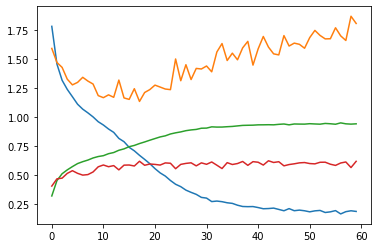

In [13]:
plt.plot(hist)

In [14]:
best_acc

0.6213362073076183

## Weight Feature with bottle neck

In [5]:
class WeightFeature(nn.Module):

    def __init__(self, feature_depth, target_depth, **kwargs):
        super(WeightFeature, self).__init__()
        self.depths = kwargs['depths'] if 'depths' in kwargs else [256, 128]
        
        self.target_depth = target_depth
        
        self.fc1 = nn.Linear(feature_depth, target_depth)
        
        self.encoder = nn.Sequential(nn.Linear(feature_depth, self.depths[0]),
                                     nn.BatchNorm1d(self.depths[0]), nn.ReLU(True),
                                     nn.Linear(self.depths[0], self.depths[1]),
                                     nn.BatchNorm1d(self.depths[1]), nn.ReLU(True)
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(self.depths[1], self.depths[0]),
                                     nn.BatchNorm1d(self.depths[0]), nn.ReLU(True),
                                     nn.Linear(self.depths[0], target_depth),
                                     nn.BatchNorm1d(target_depth), nn.ReLU()
                                     )
        
        self.bn1 = nn.BatchNorm1d(target_depth)
        self.bn2 = nn.BatchNorm2d(target_depth)
        
    def forward(self, x1, x2):
        '''
        x1 -> GAP -> FC -> * with x2-> x2 --> out
        x2 ----------------------------|
        '''
        x1 = nn.AvgPool2d(kernel_size=(x1.size(-2), x1.size(-1)))(x1)
        x1_in = nn.Flatten()(x1)
        
        x1_encode = self.encoder(x1_in)
        x1_decode = self.decoder(x1_encode)
        
        x1 = x1_decode + x1_in
        x1 = self.bn1(x1)
        x1 = nn.Sigmoid()(x1)
        
        
        x1 = x1.unsqueeze(-1).unsqueeze(-1)
      
        x_out = torch.mul(x2, x1)
#         x_out = x_out + x2 
        x_out = self.bn2(x_out)

        return x_out

In [5]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()
        
        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
#         self.feature_size = kwargs['feature_size']

        self.depths = kwargs['depths'] if 'depths' in kwargs else [256, 128]

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv4 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.wf1 = WeightFeature(nb_neurons, nb_neurons, depths=self.depths).to(self.device)
        self.wf2 = WeightFeature(nb_neurons, nb_neurons, depths=self.depths).to(self.device)
        self.wf3 = WeightFeature(nb_neurons, nb_neurons, depths=self.depths).to(self.device)
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        self.bn4 = nn.BatchNorm2d(nb_neurons)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        '''
        x: single output layer of list 
        '''

        x = torch.cat(x, dim=1) if type(x) is list else x

        # 1st
        x = self.conv1(x)
        x = self.bn1(x)
        x_res_1 = self.relu(x)

        # 2nd
        x = self.conv2(x_res_1)
        x = self.bn2(x)
        x_res_2 = self.relu(x)
        
        x_res_2 = self.wf1(x_res_1, x_res_2)

        # 3rd
        x = self.conv3(x_res_2)
        x = self.bn3(x)
        x_res_3 = self.relu(x)
        
        x_res_3 = self.wf2(x_res_2, x_res_3)
        
        x = self.conv4(x_res_3)
        x = self.bn4(x)
        x_res_4 = self.relu(x)
        
        x_out = self.wf3(x_res_3, x_res_4)     

        return x_out

In [6]:
class SVGG(nn.Module):

    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1,64, depths=[32, 16]).to(self.device)
        self.sv1 = SVblock(64, 128, depths=[64, 32]).to(self.device)
        self.sv2 = SVblock(128, 256, depths=[128, 64]).to(self.device)
        self.sv3 = SVblock(256, 512, depths=[256, 128]).to(self.device)
        self.sv4 = SVblock(512, 1024, depths=[512, 256]).to(self.device)


        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x0 = self.sv0(x)
        x0 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x0)
        
        x1 = self.sv1(x0)
        x1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x1)
        
        x2 = self.sv2(x1)
        x2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x2)
        
        x3 = self.sv3(x2)
        x3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x3)
        
        x4 = self.sv4(x3)
        x4 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x4)
        
        x4 = nn.AvgPool2d(kernel_size=(x4.size(-2), x4.size(-1)))(x4)
        x_out = nn.Flatten()(x4)

        x_out = self.fc1(x_out)
        x_out = self.bn1(x_out)
        x_out = self.fc2(x_out)
        x_out = self.bn2(x_out)

        return x_out


In [7]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
ae_criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# model.train()

# model = model.to(device)

cuda


In [21]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_bottleneck_1.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

SyntaxError: invalid syntax (<ipython-input-21-4a9b4b8736e3>, line 32)

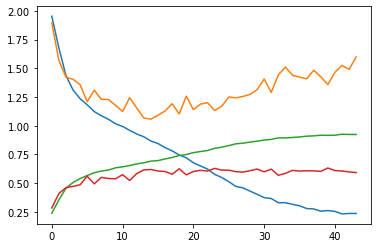

In [9]:
plt.plot(hist)

In [10]:
best_acc

0.6325431034482759

In [ ]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_bottleneck_1b.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.377 acc: 0.141
	 - Step 2: loss: 2.173 acc: 0.141
	 - Step 3: loss: 2.168 acc: 0.188
	 - Step 4: loss: 2.240 acc: 0.156
	 - Step 5: loss: 2.048 acc: 0.141
	 - Step 6: loss: 2.127 acc: 0.188
	 - Step 7: loss: 2.151 acc: 0.141
	 - Step 8: loss: 2.092 acc: 0.234
	 - Step 9: loss: 2.286 acc: 0.203
	 - Step 10: loss: 2.002 acc: 0.234
	 - Step 11: loss: 2.026 acc: 0.188
	 - Step 12: loss: 2.210 acc: 0.141
	 - Step 13: loss: 1.947 acc: 0.125
	 - Step 14: loss: 2.079 acc: 0.203
	 - Step 15: loss: 2.196 acc: 0.172
	 - Step 16: loss: 1.905 acc: 0.312
	 - Step 17: loss: 2.236 acc: 0.234
	 - Step 18: loss: 2.125 acc: 0.250
	 - Step 19: loss: 1.944 acc: 0.172
	 - Step 20: loss: 1.922 acc: 0.234
	 - Step 21: loss: 1.991 acc: 0.266
	 - Step 22: loss: 1.941 acc: 0.234
	 - Step 23: loss: 2.106 acc: 0.391
	 - Step 24: loss: 1.918 acc: 0.219
	 - Step 25: loss: 2.114 acc: 0.203
	 - Step 26: loss: 1.939 acc: 0.188
	 - Step 27: loss: 2.193 acc: 0.250
	 - Step 28: loss: 2.176 ac

	 - Step 226: loss: 1.852 acc: 0.234
	 - Step 227: loss: 1.865 acc: 0.234
	 - Step 228: loss: 1.851 acc: 0.156
	 - Step 229: loss: 1.864 acc: 0.328
	 - Step 230: loss: 1.863 acc: 0.312
	 - Step 231: loss: 1.849 acc: 0.156
	 - Step 232: loss: 1.819 acc: 0.281
	 - Step 233: loss: 1.867 acc: 0.219
	 - Step 234: loss: 1.817 acc: 0.234
	 - Step 235: loss: 1.841 acc: 0.250
	 - Step 236: loss: 1.848 acc: 0.219
	 - Step 237: loss: 1.839 acc: 0.250
	 - Step 238: loss: 1.892 acc: 0.172
	 - Step 239: loss: 1.984 acc: 0.172
	 - Step 240: loss: 1.860 acc: 0.219
	 - Step 241: loss: 1.824 acc: 0.297
	 - Step 242: loss: 1.827 acc: 0.266
	 - Step 243: loss: 1.796 acc: 0.297
	 - Step 244: loss: 1.877 acc: 0.219
	 - Step 245: loss: 1.881 acc: 0.250
	 - Step 246: loss: 1.894 acc: 0.219
	 - Step 247: loss: 1.867 acc: 0.203
	 - Step 248: loss: 1.798 acc: 0.359
	 - Step 249: loss: 1.887 acc: 0.234
	 - Step 250: loss: 1.837 acc: 0.312
	 - Step 251: loss: 1.854 acc: 0.281
	 - Step 252: loss: 1.814 acc: 0.328
	

	 - Step 448: loss: 1.730 acc: 0.328
	 - Step 449: loss: 1.725 acc: 0.324
- Avg.loss: 1.905  | Avg.acc: 0.246
- Avg. val_loss: 1.718  | Avg. val_acc: 0.329


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.751 acc: 0.328
	 - Step 2: loss: 1.783 acc: 0.297
	 - Step 3: loss: 1.763 acc: 0.344
	 - Step 4: loss: 1.763 acc: 0.281
	 - Step 5: loss: 1.667 acc: 0.344
	 - Step 6: loss: 1.716 acc: 0.391
	 - Step 7: loss: 1.739 acc: 0.297
	 - Step 8: loss: 1.795 acc: 0.297
	 - Step 9: loss: 1.818 acc: 0.312
	 - Step 10: loss: 1.680 acc: 0.406
	 - Step 11: loss: 1.773 acc: 0.266
	 - Step 12: loss: 1.631 acc: 0.406
	 - Step 13: loss: 1.757 acc: 0.281
	 - Step 14: loss: 1.734 acc: 0.281
	 - Step 15: loss: 1.782 acc: 0.312
	 - Step 16: loss: 1.798 acc: 0.281
	 - Step 17: loss: 1.673 acc: 0.344
	 - Step 18: loss: 1.702 acc: 0.250
	 - Step 19: loss: 1.794 acc: 0.297
	 - Step 20: loss: 1.704 acc: 0.328
	 - Step 21: loss: 1.671 acc: 0.344
	 - Step 22: loss: 1.753 acc: 0.359
	 - Step 23: loss: 1.788 acc: 0.281
	 - Step 24: loss: 1.713 acc: 0.312
	 - Step 25: loss: 1.703 acc: 0.328
	 - Step 26: loss: 1.656 acc: 0.281
	 - Step 27: loss: 1.725 acc: 0.266
	 - 

	 - Step 225: loss: 1.491 acc: 0.391
	 - Step 226: loss: 1.592 acc: 0.359
	 - Step 227: loss: 1.648 acc: 0.375
	 - Step 228: loss: 1.569 acc: 0.391
	 - Step 229: loss: 1.474 acc: 0.438
	 - Step 230: loss: 1.545 acc: 0.359
	 - Step 231: loss: 1.564 acc: 0.422
	 - Step 232: loss: 1.484 acc: 0.406
	 - Step 233: loss: 1.551 acc: 0.422
	 - Step 234: loss: 1.484 acc: 0.375
	 - Step 235: loss: 1.477 acc: 0.453
	 - Step 236: loss: 1.686 acc: 0.312
	 - Step 237: loss: 1.415 acc: 0.469
	 - Step 238: loss: 1.483 acc: 0.422
	 - Step 239: loss: 1.451 acc: 0.406
	 - Step 240: loss: 1.583 acc: 0.375
	 - Step 241: loss: 1.479 acc: 0.469
	 - Step 242: loss: 1.611 acc: 0.344
	 - Step 243: loss: 1.358 acc: 0.469
	 - Step 244: loss: 1.773 acc: 0.281
	 - Step 245: loss: 1.624 acc: 0.375
	 - Step 246: loss: 1.757 acc: 0.297
	 - Step 247: loss: 1.586 acc: 0.453
	 - Step 248: loss: 1.506 acc: 0.438
	 - Step 249: loss: 1.425 acc: 0.469
	 - Step 250: loss: 1.444 acc: 0.516
	 - Step 251: loss: 1.448 acc: 0.453
	

	 - Step 447: loss: 1.304 acc: 0.500
	 - Step 448: loss: 1.452 acc: 0.469
	 - Step 449: loss: 1.478 acc: 0.378
- Avg.loss: 1.543  | Avg.acc: 0.397
- Avg. val_loss: 1.408  | Avg. val_acc: 0.452
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.348 acc: 0.500
	 - Step 2: loss: 1.287 acc: 0.500
	 - Step 3: loss: 1.397 acc: 0.453
	 - Step 4: loss: 1.310 acc: 0.531
	 - Step 5: loss: 1.544 acc: 0.453
	 - Step 6: loss: 1.456 acc: 0.469
	 - Step 7: loss: 1.365 acc: 0.406
	 - Step 8: loss: 1.367 acc: 0.453
	 - Step 9: loss: 1.519 acc: 0.438
	 - Step 10: loss: 1.272 acc: 0.516
	 - Step 11: loss: 1.165 acc: 0.578
	 - Step 12: loss: 1.286 acc: 0.516
	 - Step 13: loss: 1.351 acc: 0.531
	 - Step 14: loss: 1.313 acc: 0.547
	 - Step 15: loss: 1.281 acc: 0.484
	 - Step 16: loss: 1.325 acc: 0.578
	 - Step 17: loss: 1.358 acc: 0.469
	 - Step 18: loss: 1.367 acc: 0.531
	 - Step 19: loss: 1.312 acc: 0.500
	 - Step 20: loss: 1.465 acc: 0.359
	 - Step 21: loss: 1.341 acc: 0.484
	 - Step 22: loss: 1.440 ac

	 - Step 220: loss: 1.238 acc: 0.547
	 - Step 221: loss: 1.280 acc: 0.594
	 - Step 222: loss: 1.481 acc: 0.469
	 - Step 223: loss: 1.285 acc: 0.516
	 - Step 224: loss: 1.311 acc: 0.438
	 - Step 225: loss: 1.205 acc: 0.516
	 - Step 226: loss: 1.113 acc: 0.578
	 - Step 227: loss: 1.223 acc: 0.562
	 - Step 228: loss: 1.305 acc: 0.484
	 - Step 229: loss: 1.263 acc: 0.562
	 - Step 230: loss: 1.281 acc: 0.500
	 - Step 231: loss: 1.475 acc: 0.469
	 - Step 232: loss: 1.283 acc: 0.516
	 - Step 233: loss: 1.313 acc: 0.516
	 - Step 234: loss: 1.433 acc: 0.422
	 - Step 235: loss: 1.454 acc: 0.406
	 - Step 236: loss: 1.321 acc: 0.453
	 - Step 237: loss: 1.310 acc: 0.531
	 - Step 238: loss: 1.241 acc: 0.516
	 - Step 239: loss: 1.532 acc: 0.438
	 - Step 240: loss: 1.495 acc: 0.438
	 - Step 241: loss: 1.437 acc: 0.422
	 - Step 242: loss: 1.284 acc: 0.516
	 - Step 243: loss: 1.270 acc: 0.516
	 - Step 244: loss: 1.308 acc: 0.453
	 - Step 245: loss: 1.312 acc: 0.578
	 - Step 246: loss: 1.414 acc: 0.438
	

	 - Step 442: loss: 1.243 acc: 0.500
	 - Step 443: loss: 1.373 acc: 0.516
	 - Step 444: loss: 1.224 acc: 0.531
	 - Step 445: loss: 1.261 acc: 0.547
	 - Step 446: loss: 1.265 acc: 0.578
	 - Step 447: loss: 1.449 acc: 0.453
	 - Step 448: loss: 1.300 acc: 0.500
	 - Step 449: loss: 1.530 acc: 0.432
- Avg.loss: 1.352  | Avg.acc: 0.485
- Avg. val_loss: 1.343  | Avg. val_acc: 0.500
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.285 acc: 0.484
	 - Step 2: loss: 1.256 acc: 0.578
	 - Step 3: loss: 1.107 acc: 0.547
	 - Step 4: loss: 1.375 acc: 0.438
	 - Step 5: loss: 1.255 acc: 0.547
	 - Step 6: loss: 1.339 acc: 0.531
	 - Step 7: loss: 1.368 acc: 0.531
	 - Step 8: loss: 1.242 acc: 0.484
	 - Step 9: loss: 1.143 acc: 0.531
	 - Step 10: loss: 1.177 acc: 0.547
	 - Step 11: loss: 1.213 acc: 0.562
	 - Step 12: loss: 1.245 acc: 0.500
	 - Step 13: loss: 1.340 acc: 0.422
	 - Step 14: loss: 1.341 acc: 0.469
	 - Step 15: loss: 1.170 acc: 0.594
	 - Step 16: loss: 1.382 acc: 0.500
	 - Step 17: loss: 1.1

	 - Step 215: loss: 1.122 acc: 0.641
	 - Step 216: loss: 1.185 acc: 0.562
	 - Step 217: loss: 1.296 acc: 0.516
	 - Step 218: loss: 1.146 acc: 0.625
	 - Step 219: loss: 1.224 acc: 0.500
	 - Step 220: loss: 1.359 acc: 0.500
	 - Step 221: loss: 1.180 acc: 0.531
	 - Step 222: loss: 1.490 acc: 0.359
	 - Step 223: loss: 1.080 acc: 0.688
	 - Step 224: loss: 1.355 acc: 0.500
	 - Step 225: loss: 1.148 acc: 0.547
	 - Step 226: loss: 1.355 acc: 0.438
	 - Step 227: loss: 1.299 acc: 0.469
	 - Step 228: loss: 1.245 acc: 0.516
	 - Step 229: loss: 1.217 acc: 0.547
	 - Step 230: loss: 1.533 acc: 0.484
	 - Step 231: loss: 1.157 acc: 0.547
	 - Step 232: loss: 1.323 acc: 0.562
	 - Step 233: loss: 1.299 acc: 0.562
	 - Step 234: loss: 1.109 acc: 0.609
	 - Step 235: loss: 1.079 acc: 0.625
	 - Step 236: loss: 1.150 acc: 0.609
	 - Step 237: loss: 1.292 acc: 0.531
	 - Step 238: loss: 1.348 acc: 0.484
	 - Step 239: loss: 1.413 acc: 0.422
	 - Step 240: loss: 1.165 acc: 0.594
	 - Step 241: loss: 1.274 acc: 0.500
	

	 - Step 437: loss: 1.042 acc: 0.562
	 - Step 438: loss: 1.076 acc: 0.641
	 - Step 439: loss: 1.394 acc: 0.484
	 - Step 440: loss: 1.052 acc: 0.672
	 - Step 441: loss: 1.277 acc: 0.500
	 - Step 442: loss: 1.196 acc: 0.578
	 - Step 443: loss: 1.223 acc: 0.578
	 - Step 444: loss: 1.263 acc: 0.484
	 - Step 445: loss: 1.137 acc: 0.531
	 - Step 446: loss: 1.329 acc: 0.469
	 - Step 447: loss: 1.339 acc: 0.500
	 - Step 448: loss: 1.263 acc: 0.500
	 - Step 449: loss: 1.469 acc: 0.405
- Avg.loss: 1.270  | Avg.acc: 0.521
- Avg. val_loss: 1.436  | Avg. val_acc: 0.448
Epoch:  5
	 - Step 1: loss: 1.033 acc: 0.656
	 - Step 2: loss: 1.173 acc: 0.562
	 - Step 3: loss: 1.203 acc: 0.516
	 - Step 4: loss: 1.057 acc: 0.594
	 - Step 5: loss: 1.300 acc: 0.547
	 - Step 6: loss: 1.185 acc: 0.562
	 - Step 7: loss: 1.130 acc: 0.484
	 - Step 8: loss: 1.203 acc: 0.594
	 - Step 9: loss: 1.354 acc: 0.453
	 - Step 10: loss: 1.197 acc: 0.500
	 - Step 11: loss: 1.175 acc: 0.531
	 - Step 12: loss: 1.181 acc: 0.562
	 - 

	 - Step 210: loss: 1.059 acc: 0.609
	 - Step 211: loss: 1.144 acc: 0.516
	 - Step 212: loss: 1.213 acc: 0.594
	 - Step 213: loss: 1.285 acc: 0.547
	 - Step 214: loss: 1.336 acc: 0.547
	 - Step 215: loss: 1.072 acc: 0.594
	 - Step 216: loss: 1.114 acc: 0.547
	 - Step 217: loss: 1.158 acc: 0.625
	 - Step 218: loss: 1.251 acc: 0.484
	 - Step 219: loss: 1.199 acc: 0.516
	 - Step 220: loss: 1.419 acc: 0.375
	 - Step 221: loss: 1.329 acc: 0.438
	 - Step 222: loss: 1.188 acc: 0.531
	 - Step 223: loss: 1.283 acc: 0.469
	 - Step 224: loss: 1.086 acc: 0.578
	 - Step 225: loss: 1.337 acc: 0.484
	 - Step 226: loss: 1.127 acc: 0.641
	 - Step 227: loss: 1.204 acc: 0.594
	 - Step 228: loss: 1.226 acc: 0.531
	 - Step 229: loss: 0.995 acc: 0.594
	 - Step 230: loss: 1.240 acc: 0.625
	 - Step 231: loss: 1.190 acc: 0.531
	 - Step 232: loss: 1.316 acc: 0.516
	 - Step 233: loss: 1.024 acc: 0.578
	 - Step 234: loss: 1.483 acc: 0.406
	 - Step 235: loss: 1.352 acc: 0.484
	 - Step 236: loss: 1.296 acc: 0.562
	

	 - Step 432: loss: 1.146 acc: 0.609
	 - Step 433: loss: 0.986 acc: 0.641
	 - Step 434: loss: 1.312 acc: 0.500
	 - Step 435: loss: 1.349 acc: 0.469
	 - Step 436: loss: 1.178 acc: 0.484
	 - Step 437: loss: 1.364 acc: 0.500
	 - Step 438: loss: 0.987 acc: 0.641
	 - Step 439: loss: 1.198 acc: 0.547
	 - Step 440: loss: 1.141 acc: 0.547
	 - Step 441: loss: 1.162 acc: 0.594
	 - Step 442: loss: 1.360 acc: 0.484
	 - Step 443: loss: 1.207 acc: 0.594
	 - Step 444: loss: 1.178 acc: 0.594
	 - Step 445: loss: 1.278 acc: 0.641
	 - Step 446: loss: 1.249 acc: 0.562
	 - Step 447: loss: 1.123 acc: 0.578
	 - Step 448: loss: 1.225 acc: 0.594
	 - Step 449: loss: 1.245 acc: 0.514
- Avg.loss: 1.223  | Avg.acc: 0.541
- Avg. val_loss: 1.299  | Avg. val_acc: 0.511
* Update optimal model
Epoch:  6
	 - Step 1: loss: 1.029 acc: 0.688
	 - Step 2: loss: 1.115 acc: 0.594
	 - Step 3: loss: 1.217 acc: 0.562
	 - Step 4: loss: 1.133 acc: 0.578
	 - Step 5: loss: 1.082 acc: 0.609
	 - Step 6: loss: 1.161 acc: 0.562
	 - Step 

	 - Step 205: loss: 1.159 acc: 0.609
	 - Step 206: loss: 1.200 acc: 0.547
	 - Step 207: loss: 1.140 acc: 0.594
	 - Step 208: loss: 1.176 acc: 0.625
	 - Step 209: loss: 1.254 acc: 0.500
	 - Step 210: loss: 1.317 acc: 0.484
	 - Step 211: loss: 1.174 acc: 0.562
	 - Step 212: loss: 1.379 acc: 0.438
	 - Step 213: loss: 1.411 acc: 0.547
	 - Step 214: loss: 1.287 acc: 0.484
	 - Step 215: loss: 1.060 acc: 0.594
	 - Step 216: loss: 1.116 acc: 0.609
	 - Step 217: loss: 1.092 acc: 0.594
	 - Step 218: loss: 1.430 acc: 0.391
	 - Step 219: loss: 1.221 acc: 0.531
	 - Step 220: loss: 1.493 acc: 0.422
	 - Step 221: loss: 1.206 acc: 0.531
	 - Step 222: loss: 1.135 acc: 0.500
	 - Step 223: loss: 1.133 acc: 0.516
	 - Step 224: loss: 1.179 acc: 0.578
	 - Step 225: loss: 1.171 acc: 0.562
	 - Step 226: loss: 1.129 acc: 0.594
	 - Step 227: loss: 1.093 acc: 0.578
	 - Step 228: loss: 1.317 acc: 0.500
	 - Step 229: loss: 1.361 acc: 0.484
	 - Step 230: loss: 1.333 acc: 0.516
	 - Step 231: loss: 1.250 acc: 0.547
	

	 - Step 427: loss: 1.252 acc: 0.500
	 - Step 428: loss: 1.347 acc: 0.438
	 - Step 429: loss: 1.299 acc: 0.484
	 - Step 430: loss: 1.186 acc: 0.578
	 - Step 431: loss: 0.951 acc: 0.641
	 - Step 432: loss: 1.333 acc: 0.547
	 - Step 433: loss: 1.079 acc: 0.672
	 - Step 434: loss: 0.843 acc: 0.766
	 - Step 435: loss: 0.995 acc: 0.562
	 - Step 436: loss: 1.102 acc: 0.609
	 - Step 437: loss: 1.034 acc: 0.625
	 - Step 438: loss: 0.998 acc: 0.656
	 - Step 439: loss: 1.342 acc: 0.438
	 - Step 440: loss: 1.118 acc: 0.500
	 - Step 441: loss: 1.101 acc: 0.578
	 - Step 442: loss: 1.348 acc: 0.484
	 - Step 443: loss: 1.249 acc: 0.500
	 - Step 444: loss: 1.078 acc: 0.625
	 - Step 445: loss: 1.138 acc: 0.578
	 - Step 446: loss: 0.999 acc: 0.609
	 - Step 447: loss: 1.514 acc: 0.422
	 - Step 448: loss: 1.108 acc: 0.578
	 - Step 449: loss: 1.191 acc: 0.459
- Avg.loss: 1.186  | Avg.acc: 0.555
- Avg. val_loss: 1.226  | Avg. val_acc: 0.544
* Update optimal model
Epoch:  7
	 - Step 1: loss: 0.943 acc: 0.656

	 - Step 200: loss: 1.255 acc: 0.562
	 - Step 201: loss: 1.169 acc: 0.562
	 - Step 202: loss: 1.152 acc: 0.594
	 - Step 203: loss: 1.331 acc: 0.531
	 - Step 204: loss: 1.102 acc: 0.594
	 - Step 205: loss: 1.256 acc: 0.469
	 - Step 206: loss: 1.313 acc: 0.453
	 - Step 207: loss: 1.240 acc: 0.578
	 - Step 208: loss: 1.245 acc: 0.516
	 - Step 209: loss: 1.393 acc: 0.422
	 - Step 210: loss: 1.264 acc: 0.484
	 - Step 211: loss: 0.883 acc: 0.734
	 - Step 212: loss: 1.167 acc: 0.547
	 - Step 213: loss: 1.036 acc: 0.625
	 - Step 214: loss: 1.325 acc: 0.547
	 - Step 215: loss: 1.189 acc: 0.547
	 - Step 216: loss: 0.857 acc: 0.656
	 - Step 217: loss: 1.303 acc: 0.516
	 - Step 218: loss: 1.279 acc: 0.500
	 - Step 219: loss: 0.977 acc: 0.641
	 - Step 220: loss: 1.023 acc: 0.641
	 - Step 221: loss: 1.104 acc: 0.562
	 - Step 222: loss: 1.082 acc: 0.594
	 - Step 223: loss: 1.063 acc: 0.609
	 - Step 224: loss: 1.107 acc: 0.609
	 - Step 225: loss: 1.103 acc: 0.562
	 - Step 226: loss: 0.968 acc: 0.594
	

	 - Step 422: loss: 1.300 acc: 0.531
	 - Step 423: loss: 1.096 acc: 0.516
	 - Step 424: loss: 1.054 acc: 0.688
	 - Step 425: loss: 1.282 acc: 0.500
	 - Step 426: loss: 1.113 acc: 0.578
	 - Step 427: loss: 1.310 acc: 0.469
	 - Step 428: loss: 1.353 acc: 0.500
	 - Step 429: loss: 1.135 acc: 0.578
	 - Step 430: loss: 1.212 acc: 0.484
	 - Step 431: loss: 1.070 acc: 0.500
	 - Step 432: loss: 0.930 acc: 0.703
	 - Step 433: loss: 0.999 acc: 0.641
	 - Step 434: loss: 1.037 acc: 0.594
	 - Step 435: loss: 1.336 acc: 0.531
	 - Step 436: loss: 1.364 acc: 0.531
	 - Step 437: loss: 1.250 acc: 0.562
	 - Step 438: loss: 0.981 acc: 0.688
	 - Step 439: loss: 1.267 acc: 0.516
	 - Step 440: loss: 1.266 acc: 0.516
	 - Step 441: loss: 1.243 acc: 0.500
	 - Step 442: loss: 1.249 acc: 0.562
	 - Step 443: loss: 1.141 acc: 0.562
	 - Step 444: loss: 1.108 acc: 0.500
	 - Step 445: loss: 1.186 acc: 0.641
	 - Step 446: loss: 1.250 acc: 0.562
	 - Step 447: loss: 1.195 acc: 0.562
	 - Step 448: loss: 1.241 acc: 0.594
	

	 - Step 195: loss: 0.965 acc: 0.656
	 - Step 196: loss: 1.081 acc: 0.562
	 - Step 197: loss: 1.377 acc: 0.484
	 - Step 198: loss: 1.109 acc: 0.609
	 - Step 199: loss: 1.081 acc: 0.609
	 - Step 200: loss: 1.012 acc: 0.672
	 - Step 201: loss: 1.208 acc: 0.562
	 - Step 202: loss: 1.119 acc: 0.562
	 - Step 203: loss: 1.038 acc: 0.656
	 - Step 204: loss: 1.145 acc: 0.531
	 - Step 205: loss: 1.190 acc: 0.578
	 - Step 206: loss: 1.403 acc: 0.516
	 - Step 207: loss: 1.384 acc: 0.469
	 - Step 208: loss: 1.015 acc: 0.594
	 - Step 209: loss: 1.291 acc: 0.531
	 - Step 210: loss: 1.148 acc: 0.656
	 - Step 211: loss: 0.853 acc: 0.641
	 - Step 212: loss: 1.105 acc: 0.562
	 - Step 213: loss: 1.125 acc: 0.625
	 - Step 214: loss: 0.874 acc: 0.656
	 - Step 215: loss: 1.190 acc: 0.500
	 - Step 216: loss: 1.177 acc: 0.500
	 - Step 217: loss: 0.984 acc: 0.656
	 - Step 218: loss: 1.113 acc: 0.609
	 - Step 219: loss: 1.037 acc: 0.656
	 - Step 220: loss: 1.098 acc: 0.578
	 - Step 221: loss: 1.096 acc: 0.578
	

	 - Step 417: loss: 1.139 acc: 0.594
	 - Step 418: loss: 1.159 acc: 0.547
	 - Step 419: loss: 1.131 acc: 0.688
	 - Step 420: loss: 1.258 acc: 0.516
	 - Step 421: loss: 1.057 acc: 0.594
	 - Step 422: loss: 1.246 acc: 0.500
	 - Step 423: loss: 1.136 acc: 0.531
	 - Step 424: loss: 1.175 acc: 0.562
	 - Step 425: loss: 1.145 acc: 0.594
	 - Step 426: loss: 0.991 acc: 0.641
	 - Step 427: loss: 1.091 acc: 0.562
	 - Step 428: loss: 1.094 acc: 0.531
	 - Step 429: loss: 1.066 acc: 0.641
	 - Step 430: loss: 1.247 acc: 0.531
	 - Step 431: loss: 1.178 acc: 0.547
	 - Step 432: loss: 0.833 acc: 0.734
	 - Step 433: loss: 1.068 acc: 0.609
	 - Step 434: loss: 1.022 acc: 0.688
	 - Step 435: loss: 1.317 acc: 0.500
	 - Step 436: loss: 1.043 acc: 0.656
	 - Step 437: loss: 1.271 acc: 0.500
	 - Step 438: loss: 1.264 acc: 0.547
	 - Step 439: loss: 1.118 acc: 0.562
	 - Step 440: loss: 1.004 acc: 0.719
	 - Step 441: loss: 1.139 acc: 0.562
	 - Step 442: loss: 1.254 acc: 0.500
	 - Step 443: loss: 1.068 acc: 0.609
	

	 - Step 190: loss: 0.986 acc: 0.578
	 - Step 191: loss: 1.227 acc: 0.594
	 - Step 192: loss: 1.084 acc: 0.609
	 - Step 193: loss: 1.044 acc: 0.609
	 - Step 194: loss: 0.984 acc: 0.578
	 - Step 195: loss: 0.799 acc: 0.703
	 - Step 196: loss: 0.964 acc: 0.656
	 - Step 197: loss: 0.918 acc: 0.672
	 - Step 198: loss: 1.015 acc: 0.688
	 - Step 199: loss: 1.094 acc: 0.625
	 - Step 200: loss: 1.010 acc: 0.641
	 - Step 201: loss: 1.016 acc: 0.641
	 - Step 202: loss: 0.985 acc: 0.656
	 - Step 203: loss: 1.076 acc: 0.703
	 - Step 204: loss: 1.074 acc: 0.641
	 - Step 205: loss: 1.340 acc: 0.453
	 - Step 206: loss: 1.262 acc: 0.547
	 - Step 207: loss: 0.841 acc: 0.719
	 - Step 208: loss: 0.939 acc: 0.688
	 - Step 209: loss: 0.991 acc: 0.594
	 - Step 210: loss: 1.076 acc: 0.641
	 - Step 211: loss: 1.294 acc: 0.531
	 - Step 212: loss: 0.924 acc: 0.719
	 - Step 213: loss: 0.916 acc: 0.688
	 - Step 214: loss: 1.231 acc: 0.547
	 - Step 215: loss: 0.782 acc: 0.734
	 - Step 216: loss: 1.117 acc: 0.609
	

	 - Step 412: loss: 1.245 acc: 0.547
	 - Step 413: loss: 0.997 acc: 0.641
	 - Step 414: loss: 1.014 acc: 0.656
	 - Step 415: loss: 0.977 acc: 0.578
	 - Step 416: loss: 1.146 acc: 0.625
	 - Step 417: loss: 1.068 acc: 0.625
	 - Step 418: loss: 1.006 acc: 0.625
	 - Step 419: loss: 0.985 acc: 0.641
	 - Step 420: loss: 1.070 acc: 0.688
	 - Step 421: loss: 1.082 acc: 0.562
	 - Step 422: loss: 0.972 acc: 0.578
	 - Step 423: loss: 1.176 acc: 0.562
	 - Step 424: loss: 1.187 acc: 0.547
	 - Step 425: loss: 1.298 acc: 0.516
	 - Step 426: loss: 1.100 acc: 0.609
	 - Step 427: loss: 1.132 acc: 0.500
	 - Step 428: loss: 0.926 acc: 0.703
	 - Step 429: loss: 0.896 acc: 0.656
	 - Step 430: loss: 0.803 acc: 0.781
	 - Step 431: loss: 1.113 acc: 0.609
	 - Step 432: loss: 1.214 acc: 0.516
	 - Step 433: loss: 1.184 acc: 0.594
	 - Step 434: loss: 1.081 acc: 0.609
	 - Step 435: loss: 1.059 acc: 0.625
	 - Step 436: loss: 1.215 acc: 0.578
	 - Step 437: loss: 0.949 acc: 0.781
	 - Step 438: loss: 1.160 acc: 0.641
	

	 - Step 185: loss: 1.032 acc: 0.625
	 - Step 186: loss: 1.031 acc: 0.641
	 - Step 187: loss: 1.145 acc: 0.625
	 - Step 188: loss: 1.020 acc: 0.578
	 - Step 189: loss: 0.837 acc: 0.750
	 - Step 190: loss: 1.168 acc: 0.578
	 - Step 191: loss: 0.993 acc: 0.625
	 - Step 192: loss: 1.200 acc: 0.562
	 - Step 193: loss: 0.965 acc: 0.719
	 - Step 194: loss: 0.897 acc: 0.641
	 - Step 195: loss: 1.178 acc: 0.578
	 - Step 196: loss: 0.918 acc: 0.688
	 - Step 197: loss: 1.109 acc: 0.656
	 - Step 198: loss: 1.310 acc: 0.547
	 - Step 199: loss: 1.111 acc: 0.578
	 - Step 200: loss: 1.226 acc: 0.562
	 - Step 201: loss: 1.304 acc: 0.531
	 - Step 202: loss: 1.008 acc: 0.609
	 - Step 203: loss: 1.065 acc: 0.625
	 - Step 204: loss: 1.188 acc: 0.562
	 - Step 205: loss: 0.980 acc: 0.672
	 - Step 206: loss: 1.142 acc: 0.672
	 - Step 207: loss: 0.991 acc: 0.641
	 - Step 208: loss: 1.071 acc: 0.516
	 - Step 209: loss: 0.959 acc: 0.641
	 - Step 210: loss: 1.077 acc: 0.609
	 - Step 211: loss: 1.129 acc: 0.578
	

	 - Step 407: loss: 0.912 acc: 0.656
	 - Step 408: loss: 0.970 acc: 0.750
	 - Step 409: loss: 1.053 acc: 0.578
	 - Step 410: loss: 1.348 acc: 0.531
	 - Step 411: loss: 1.142 acc: 0.656
	 - Step 412: loss: 1.153 acc: 0.594
	 - Step 413: loss: 1.051 acc: 0.500
	 - Step 414: loss: 1.318 acc: 0.484
	 - Step 415: loss: 1.003 acc: 0.688
	 - Step 416: loss: 0.863 acc: 0.703
	 - Step 417: loss: 0.935 acc: 0.641
	 - Step 418: loss: 0.997 acc: 0.688
	 - Step 419: loss: 1.054 acc: 0.594
	 - Step 420: loss: 0.909 acc: 0.672
	 - Step 421: loss: 0.990 acc: 0.641
	 - Step 422: loss: 0.994 acc: 0.641
	 - Step 423: loss: 0.956 acc: 0.734
	 - Step 424: loss: 1.112 acc: 0.562
	 - Step 425: loss: 0.979 acc: 0.609
	 - Step 426: loss: 1.071 acc: 0.562
	 - Step 427: loss: 1.092 acc: 0.625
	 - Step 428: loss: 0.975 acc: 0.562
	 - Step 429: loss: 1.071 acc: 0.594
	 - Step 430: loss: 1.019 acc: 0.641
	 - Step 431: loss: 1.018 acc: 0.609
	 - Step 432: loss: 1.025 acc: 0.578
	 - Step 433: loss: 1.052 acc: 0.609
	

	 - Step 180: loss: 0.922 acc: 0.641
	 - Step 181: loss: 1.129 acc: 0.625
	 - Step 182: loss: 1.005 acc: 0.656
	 - Step 183: loss: 1.094 acc: 0.578
	 - Step 184: loss: 1.032 acc: 0.547
	 - Step 185: loss: 1.224 acc: 0.594
	 - Step 186: loss: 1.258 acc: 0.547
	 - Step 187: loss: 0.987 acc: 0.641
	 - Step 188: loss: 1.181 acc: 0.609
	 - Step 189: loss: 1.278 acc: 0.500
	 - Step 190: loss: 0.955 acc: 0.609
	 - Step 191: loss: 1.128 acc: 0.578
	 - Step 192: loss: 1.390 acc: 0.531
	 - Step 193: loss: 1.113 acc: 0.594
	 - Step 194: loss: 0.975 acc: 0.656
	 - Step 195: loss: 1.073 acc: 0.531
	 - Step 196: loss: 1.009 acc: 0.641
	 - Step 197: loss: 1.004 acc: 0.641
	 - Step 198: loss: 0.918 acc: 0.672
	 - Step 199: loss: 0.961 acc: 0.641
	 - Step 200: loss: 1.256 acc: 0.531
	 - Step 201: loss: 0.919 acc: 0.641
	 - Step 202: loss: 0.993 acc: 0.625
	 - Step 203: loss: 0.860 acc: 0.656
	 - Step 204: loss: 1.105 acc: 0.609
	 - Step 205: loss: 0.901 acc: 0.625
	 - Step 206: loss: 0.940 acc: 0.656
	

	 - Step 402: loss: 1.226 acc: 0.562
	 - Step 403: loss: 1.081 acc: 0.578
	 - Step 404: loss: 1.191 acc: 0.594
	 - Step 405: loss: 0.840 acc: 0.750
	 - Step 406: loss: 0.864 acc: 0.656
	 - Step 407: loss: 1.052 acc: 0.625
	 - Step 408: loss: 0.992 acc: 0.578
	 - Step 409: loss: 1.027 acc: 0.656
	 - Step 410: loss: 0.920 acc: 0.703
	 - Step 411: loss: 0.790 acc: 0.719
	 - Step 412: loss: 0.926 acc: 0.656
	 - Step 413: loss: 0.960 acc: 0.703
	 - Step 414: loss: 1.116 acc: 0.547
	 - Step 415: loss: 1.078 acc: 0.656
	 - Step 416: loss: 1.151 acc: 0.578
	 - Step 417: loss: 0.947 acc: 0.641
	 - Step 418: loss: 0.967 acc: 0.625
	 - Step 419: loss: 1.215 acc: 0.594
	 - Step 420: loss: 0.941 acc: 0.594
	 - Step 421: loss: 0.888 acc: 0.703
	 - Step 422: loss: 0.985 acc: 0.625
	 - Step 423: loss: 0.928 acc: 0.688
	 - Step 424: loss: 1.039 acc: 0.625
	 - Step 425: loss: 1.047 acc: 0.578
	 - Step 426: loss: 1.054 acc: 0.625
	 - Step 427: loss: 0.969 acc: 0.562
	 - Step 428: loss: 0.916 acc: 0.641
	

	 - Step 175: loss: 0.978 acc: 0.625
	 - Step 176: loss: 0.838 acc: 0.688
	 - Step 177: loss: 1.439 acc: 0.500
	 - Step 178: loss: 1.011 acc: 0.672
	 - Step 179: loss: 1.178 acc: 0.531
	 - Step 180: loss: 1.189 acc: 0.469
	 - Step 181: loss: 0.980 acc: 0.578
	 - Step 182: loss: 1.115 acc: 0.500
	 - Step 183: loss: 0.922 acc: 0.656
	 - Step 184: loss: 0.911 acc: 0.594
	 - Step 185: loss: 1.173 acc: 0.500
	 - Step 186: loss: 0.761 acc: 0.750
	 - Step 187: loss: 0.895 acc: 0.719
	 - Step 188: loss: 1.215 acc: 0.594
	 - Step 189: loss: 0.978 acc: 0.672
	 - Step 190: loss: 1.048 acc: 0.562
	 - Step 191: loss: 0.881 acc: 0.703
	 - Step 192: loss: 1.063 acc: 0.656
	 - Step 193: loss: 1.201 acc: 0.547
	 - Step 194: loss: 0.920 acc: 0.656
	 - Step 195: loss: 0.951 acc: 0.719
	 - Step 196: loss: 0.988 acc: 0.594
	 - Step 197: loss: 1.083 acc: 0.547
	 - Step 198: loss: 0.835 acc: 0.688
	 - Step 199: loss: 0.898 acc: 0.641
	 - Step 200: loss: 0.861 acc: 0.688
	 - Step 201: loss: 0.983 acc: 0.625
	

	 - Step 397: loss: 0.906 acc: 0.750
	 - Step 398: loss: 0.963 acc: 0.625
	 - Step 399: loss: 1.226 acc: 0.484
	 - Step 400: loss: 0.926 acc: 0.688
	 - Step 401: loss: 1.073 acc: 0.625
	 - Step 402: loss: 0.864 acc: 0.703
	 - Step 403: loss: 0.909 acc: 0.625
	 - Step 404: loss: 1.083 acc: 0.594
	 - Step 405: loss: 0.917 acc: 0.672
	 - Step 406: loss: 0.943 acc: 0.688
	 - Step 407: loss: 0.798 acc: 0.734
	 - Step 408: loss: 1.015 acc: 0.578
	 - Step 409: loss: 0.950 acc: 0.625
	 - Step 410: loss: 1.012 acc: 0.688
	 - Step 411: loss: 0.902 acc: 0.656
	 - Step 412: loss: 1.192 acc: 0.578
	 - Step 413: loss: 1.012 acc: 0.578
	 - Step 414: loss: 0.837 acc: 0.703
	 - Step 415: loss: 1.029 acc: 0.594
	 - Step 416: loss: 1.049 acc: 0.547
	 - Step 417: loss: 1.091 acc: 0.578
	 - Step 418: loss: 0.749 acc: 0.781
	 - Step 419: loss: 0.986 acc: 0.703
	 - Step 420: loss: 0.959 acc: 0.562
	 - Step 421: loss: 0.919 acc: 0.703
	 - Step 422: loss: 0.924 acc: 0.656
	 - Step 423: loss: 0.933 acc: 0.625
	

	 - Step 170: loss: 1.161 acc: 0.562
	 - Step 171: loss: 1.091 acc: 0.625
	 - Step 172: loss: 1.065 acc: 0.641
	 - Step 173: loss: 1.122 acc: 0.594
	 - Step 174: loss: 1.183 acc: 0.609
	 - Step 175: loss: 0.919 acc: 0.656
	 - Step 176: loss: 0.881 acc: 0.641
	 - Step 177: loss: 0.738 acc: 0.766
	 - Step 178: loss: 0.764 acc: 0.766
	 - Step 179: loss: 1.009 acc: 0.594
	 - Step 180: loss: 1.064 acc: 0.625
	 - Step 181: loss: 0.942 acc: 0.750
	 - Step 182: loss: 0.851 acc: 0.703
	 - Step 183: loss: 0.906 acc: 0.641
	 - Step 184: loss: 1.029 acc: 0.625
	 - Step 185: loss: 0.920 acc: 0.641
	 - Step 186: loss: 0.957 acc: 0.547
	 - Step 187: loss: 1.155 acc: 0.547
	 - Step 188: loss: 0.988 acc: 0.672
	 - Step 189: loss: 0.961 acc: 0.609
	 - Step 190: loss: 0.861 acc: 0.719
	 - Step 191: loss: 0.853 acc: 0.672
	 - Step 192: loss: 1.028 acc: 0.609
	 - Step 193: loss: 0.929 acc: 0.656
	 - Step 194: loss: 0.933 acc: 0.672
	 - Step 195: loss: 1.132 acc: 0.562
	 - Step 196: loss: 0.984 acc: 0.562
	

	 - Step 392: loss: 0.998 acc: 0.594
	 - Step 393: loss: 1.144 acc: 0.594
	 - Step 394: loss: 1.029 acc: 0.594
	 - Step 395: loss: 1.110 acc: 0.672
	 - Step 396: loss: 1.033 acc: 0.672
	 - Step 397: loss: 1.219 acc: 0.484
	 - Step 398: loss: 0.723 acc: 0.734
	 - Step 399: loss: 1.094 acc: 0.531
	 - Step 400: loss: 0.882 acc: 0.672
	 - Step 401: loss: 0.935 acc: 0.609
	 - Step 402: loss: 0.945 acc: 0.656
	 - Step 403: loss: 0.976 acc: 0.656
	 - Step 404: loss: 0.809 acc: 0.750
	 - Step 405: loss: 0.899 acc: 0.656
	 - Step 406: loss: 0.955 acc: 0.594
	 - Step 407: loss: 0.780 acc: 0.656
	 - Step 408: loss: 0.940 acc: 0.688
	 - Step 409: loss: 0.889 acc: 0.688
	 - Step 410: loss: 0.914 acc: 0.672
	 - Step 411: loss: 1.057 acc: 0.625
	 - Step 412: loss: 1.126 acc: 0.594
	 - Step 413: loss: 1.014 acc: 0.562
	 - Step 414: loss: 1.018 acc: 0.609
	 - Step 415: loss: 0.906 acc: 0.656
	 - Step 416: loss: 0.945 acc: 0.625
	 - Step 417: loss: 0.882 acc: 0.688
	 - Step 418: loss: 1.134 acc: 0.641
	

	 - Step 165: loss: 0.886 acc: 0.719
	 - Step 166: loss: 0.656 acc: 0.750
	 - Step 167: loss: 1.050 acc: 0.531
	 - Step 168: loss: 0.781 acc: 0.703
	 - Step 169: loss: 0.950 acc: 0.703
	 - Step 170: loss: 0.922 acc: 0.641
	 - Step 171: loss: 0.941 acc: 0.594
	 - Step 172: loss: 0.778 acc: 0.750
	 - Step 173: loss: 0.729 acc: 0.766
	 - Step 174: loss: 0.869 acc: 0.703
	 - Step 175: loss: 1.040 acc: 0.578
	 - Step 176: loss: 0.716 acc: 0.750
	 - Step 177: loss: 0.810 acc: 0.656
	 - Step 178: loss: 0.826 acc: 0.703
	 - Step 179: loss: 1.021 acc: 0.562
	 - Step 180: loss: 0.952 acc: 0.625
	 - Step 181: loss: 1.000 acc: 0.625
	 - Step 182: loss: 0.905 acc: 0.672
	 - Step 183: loss: 1.053 acc: 0.562
	 - Step 184: loss: 0.954 acc: 0.625
	 - Step 185: loss: 0.956 acc: 0.672
	 - Step 186: loss: 0.785 acc: 0.766
	 - Step 187: loss: 0.764 acc: 0.703
	 - Step 188: loss: 0.845 acc: 0.688
	 - Step 189: loss: 0.896 acc: 0.656
	 - Step 190: loss: 1.027 acc: 0.594
	 - Step 191: loss: 0.886 acc: 0.656
	

	 - Step 387: loss: 0.823 acc: 0.734
	 - Step 388: loss: 0.977 acc: 0.609
	 - Step 389: loss: 1.108 acc: 0.609
	 - Step 390: loss: 0.633 acc: 0.812
	 - Step 391: loss: 0.667 acc: 0.781
	 - Step 392: loss: 0.840 acc: 0.703
	 - Step 393: loss: 1.212 acc: 0.578
	 - Step 394: loss: 1.095 acc: 0.609
	 - Step 395: loss: 1.073 acc: 0.688
	 - Step 396: loss: 0.917 acc: 0.656
	 - Step 397: loss: 1.014 acc: 0.641
	 - Step 398: loss: 0.967 acc: 0.672
	 - Step 399: loss: 0.965 acc: 0.656
	 - Step 400: loss: 1.006 acc: 0.625
	 - Step 401: loss: 1.047 acc: 0.594
	 - Step 402: loss: 0.943 acc: 0.609
	 - Step 403: loss: 1.110 acc: 0.625
	 - Step 404: loss: 0.898 acc: 0.719
	 - Step 405: loss: 0.811 acc: 0.641
	 - Step 406: loss: 0.821 acc: 0.719
	 - Step 407: loss: 0.840 acc: 0.703
	 - Step 408: loss: 0.947 acc: 0.625
	 - Step 409: loss: 1.119 acc: 0.641
	 - Step 410: loss: 0.765 acc: 0.750
	 - Step 411: loss: 1.009 acc: 0.656
	 - Step 412: loss: 0.862 acc: 0.703
	 - Step 413: loss: 1.003 acc: 0.594
	

	 - Step 160: loss: 1.032 acc: 0.578
	 - Step 161: loss: 1.174 acc: 0.484
	 - Step 162: loss: 0.825 acc: 0.688
	 - Step 163: loss: 0.863 acc: 0.703
	 - Step 164: loss: 0.909 acc: 0.609
	 - Step 165: loss: 1.018 acc: 0.609
	 - Step 166: loss: 0.778 acc: 0.703
	 - Step 167: loss: 1.173 acc: 0.656
	 - Step 168: loss: 1.063 acc: 0.609
	 - Step 169: loss: 0.975 acc: 0.656
	 - Step 170: loss: 0.892 acc: 0.672
	 - Step 171: loss: 0.938 acc: 0.641
	 - Step 172: loss: 0.903 acc: 0.656
	 - Step 173: loss: 0.843 acc: 0.703
	 - Step 174: loss: 0.781 acc: 0.734
	 - Step 175: loss: 0.965 acc: 0.641
	 - Step 176: loss: 0.869 acc: 0.703
	 - Step 177: loss: 0.864 acc: 0.672
	 - Step 178: loss: 0.660 acc: 0.797
	 - Step 179: loss: 1.050 acc: 0.547
	 - Step 180: loss: 0.960 acc: 0.703
	 - Step 181: loss: 0.844 acc: 0.734
	 - Step 182: loss: 0.757 acc: 0.703
	 - Step 183: loss: 1.048 acc: 0.609
	 - Step 184: loss: 0.982 acc: 0.688
	 - Step 185: loss: 1.018 acc: 0.609
	 - Step 186: loss: 1.272 acc: 0.547
	

	 - Step 382: loss: 0.988 acc: 0.641
	 - Step 383: loss: 0.886 acc: 0.625
	 - Step 384: loss: 1.019 acc: 0.688
	 - Step 385: loss: 0.951 acc: 0.656
	 - Step 386: loss: 0.971 acc: 0.656
	 - Step 387: loss: 0.735 acc: 0.750
	 - Step 388: loss: 1.081 acc: 0.594
	 - Step 389: loss: 0.921 acc: 0.672
	 - Step 390: loss: 1.120 acc: 0.672
	 - Step 391: loss: 0.927 acc: 0.688
	 - Step 392: loss: 0.880 acc: 0.750
	 - Step 393: loss: 1.008 acc: 0.641
	 - Step 394: loss: 0.755 acc: 0.750
	 - Step 395: loss: 0.903 acc: 0.641
	 - Step 396: loss: 0.873 acc: 0.672
	 - Step 397: loss: 0.910 acc: 0.672
	 - Step 398: loss: 0.892 acc: 0.641
	 - Step 399: loss: 0.816 acc: 0.719
	 - Step 400: loss: 0.963 acc: 0.656
	 - Step 401: loss: 0.909 acc: 0.688
	 - Step 402: loss: 0.921 acc: 0.672
	 - Step 403: loss: 1.041 acc: 0.609
	 - Step 404: loss: 0.949 acc: 0.562
	 - Step 405: loss: 0.865 acc: 0.734
	 - Step 406: loss: 0.919 acc: 0.641
	 - Step 407: loss: 0.993 acc: 0.625
	 - Step 408: loss: 0.972 acc: 0.625
	

	 - Step 155: loss: 0.964 acc: 0.609
	 - Step 156: loss: 1.006 acc: 0.609
	 - Step 157: loss: 0.849 acc: 0.688
	 - Step 158: loss: 0.799 acc: 0.750
	 - Step 159: loss: 0.979 acc: 0.703
	 - Step 160: loss: 0.983 acc: 0.641
	 - Step 161: loss: 0.845 acc: 0.656
	 - Step 162: loss: 1.191 acc: 0.531
	 - Step 163: loss: 1.049 acc: 0.625
	 - Step 164: loss: 0.840 acc: 0.656
	 - Step 165: loss: 0.672 acc: 0.766
	 - Step 166: loss: 0.729 acc: 0.719
	 - Step 167: loss: 0.923 acc: 0.688
	 - Step 168: loss: 0.968 acc: 0.672
	 - Step 169: loss: 0.910 acc: 0.625
	 - Step 170: loss: 0.922 acc: 0.578
	 - Step 171: loss: 0.950 acc: 0.672
	 - Step 172: loss: 1.036 acc: 0.656
	 - Step 173: loss: 0.831 acc: 0.734
	 - Step 174: loss: 0.881 acc: 0.656
	 - Step 175: loss: 0.929 acc: 0.578
	 - Step 176: loss: 0.982 acc: 0.656
	 - Step 177: loss: 0.945 acc: 0.672
	 - Step 178: loss: 0.919 acc: 0.641
	 - Step 179: loss: 0.687 acc: 0.750
	 - Step 180: loss: 0.933 acc: 0.641
	 - Step 181: loss: 1.088 acc: 0.609
	

	 - Step 377: loss: 0.904 acc: 0.688
	 - Step 378: loss: 0.996 acc: 0.688
	 - Step 379: loss: 1.014 acc: 0.609
	 - Step 380: loss: 0.846 acc: 0.656
	 - Step 381: loss: 0.978 acc: 0.672
	 - Step 382: loss: 0.877 acc: 0.625
	 - Step 383: loss: 1.047 acc: 0.625
	 - Step 384: loss: 0.750 acc: 0.781
	 - Step 385: loss: 0.854 acc: 0.703
	 - Step 386: loss: 0.928 acc: 0.672
	 - Step 387: loss: 0.831 acc: 0.688
	 - Step 388: loss: 0.938 acc: 0.656
	 - Step 389: loss: 0.958 acc: 0.703
	 - Step 390: loss: 0.985 acc: 0.703
	 - Step 391: loss: 0.898 acc: 0.641
	 - Step 392: loss: 1.003 acc: 0.641
	 - Step 393: loss: 0.871 acc: 0.672
	 - Step 394: loss: 0.966 acc: 0.625
	 - Step 395: loss: 0.920 acc: 0.656
	 - Step 396: loss: 1.037 acc: 0.578
	 - Step 397: loss: 0.718 acc: 0.781
	 - Step 398: loss: 0.869 acc: 0.625
	 - Step 399: loss: 1.067 acc: 0.578
	 - Step 400: loss: 0.920 acc: 0.688
	 - Step 401: loss: 0.886 acc: 0.562
	 - Step 402: loss: 0.879 acc: 0.734
	 - Step 403: loss: 0.936 acc: 0.672
	

	 - Step 150: loss: 0.828 acc: 0.641
	 - Step 151: loss: 0.915 acc: 0.672
	 - Step 152: loss: 0.929 acc: 0.688
	 - Step 153: loss: 0.748 acc: 0.766
	 - Step 154: loss: 0.910 acc: 0.688
	 - Step 155: loss: 0.734 acc: 0.734
	 - Step 156: loss: 0.798 acc: 0.656
	 - Step 157: loss: 0.861 acc: 0.703
	 - Step 158: loss: 0.951 acc: 0.703
	 - Step 159: loss: 0.656 acc: 0.750
	 - Step 160: loss: 0.897 acc: 0.672
	 - Step 161: loss: 0.825 acc: 0.719
	 - Step 162: loss: 0.791 acc: 0.734
	 - Step 163: loss: 0.856 acc: 0.641
	 - Step 164: loss: 0.963 acc: 0.609
	 - Step 165: loss: 0.896 acc: 0.719
	 - Step 166: loss: 0.837 acc: 0.719
	 - Step 167: loss: 0.790 acc: 0.641
	 - Step 168: loss: 0.748 acc: 0.828
	 - Step 169: loss: 0.993 acc: 0.625
	 - Step 170: loss: 0.911 acc: 0.641
	 - Step 171: loss: 0.877 acc: 0.672
	 - Step 172: loss: 1.012 acc: 0.672
	 - Step 173: loss: 0.738 acc: 0.719
	 - Step 174: loss: 0.892 acc: 0.672
	 - Step 175: loss: 0.850 acc: 0.688
	 - Step 176: loss: 0.786 acc: 0.750
	

	 - Step 372: loss: 0.859 acc: 0.672
	 - Step 373: loss: 0.855 acc: 0.703
	 - Step 374: loss: 0.808 acc: 0.766
	 - Step 375: loss: 0.881 acc: 0.672
	 - Step 376: loss: 0.933 acc: 0.656
	 - Step 377: loss: 0.792 acc: 0.688
	 - Step 378: loss: 0.905 acc: 0.656
	 - Step 379: loss: 0.876 acc: 0.688
	 - Step 380: loss: 0.765 acc: 0.734
	 - Step 381: loss: 0.890 acc: 0.609
	 - Step 382: loss: 1.154 acc: 0.547
	 - Step 383: loss: 0.822 acc: 0.656
	 - Step 384: loss: 0.805 acc: 0.688
	 - Step 385: loss: 0.914 acc: 0.656
	 - Step 386: loss: 0.685 acc: 0.750
	 - Step 387: loss: 0.855 acc: 0.703
	 - Step 388: loss: 0.763 acc: 0.750
	 - Step 389: loss: 0.884 acc: 0.703
	 - Step 390: loss: 0.702 acc: 0.766
	 - Step 391: loss: 0.655 acc: 0.781
	 - Step 392: loss: 0.809 acc: 0.688
	 - Step 393: loss: 0.885 acc: 0.703
	 - Step 394: loss: 0.839 acc: 0.734
	 - Step 395: loss: 1.022 acc: 0.625
	 - Step 396: loss: 1.159 acc: 0.531
	 - Step 397: loss: 0.868 acc: 0.734
	 - Step 398: loss: 1.005 acc: 0.641
	

	 - Step 145: loss: 0.798 acc: 0.734
	 - Step 146: loss: 0.801 acc: 0.781
	 - Step 147: loss: 0.884 acc: 0.656
	 - Step 148: loss: 0.787 acc: 0.750
	 - Step 149: loss: 0.909 acc: 0.719
	 - Step 150: loss: 1.245 acc: 0.594
	 - Step 151: loss: 0.897 acc: 0.703
	 - Step 152: loss: 0.934 acc: 0.703
	 - Step 153: loss: 0.742 acc: 0.734
	 - Step 154: loss: 1.055 acc: 0.625
	 - Step 155: loss: 0.907 acc: 0.641
	 - Step 156: loss: 0.935 acc: 0.672
	 - Step 157: loss: 0.857 acc: 0.719
	 - Step 158: loss: 0.816 acc: 0.734
	 - Step 159: loss: 0.824 acc: 0.688
	 - Step 160: loss: 0.956 acc: 0.688
	 - Step 161: loss: 0.719 acc: 0.781
	 - Step 162: loss: 0.835 acc: 0.719
	 - Step 163: loss: 0.878 acc: 0.656
	 - Step 164: loss: 0.912 acc: 0.672
	 - Step 165: loss: 0.644 acc: 0.750
	 - Step 166: loss: 0.629 acc: 0.750
	 - Step 167: loss: 0.837 acc: 0.766
	 - Step 168: loss: 0.790 acc: 0.719
	 - Step 169: loss: 0.813 acc: 0.672
	 - Step 170: loss: 0.658 acc: 0.766
	 - Step 171: loss: 0.737 acc: 0.750
	

	 - Step 367: loss: 0.680 acc: 0.719
	 - Step 368: loss: 0.840 acc: 0.688
	 - Step 369: loss: 0.974 acc: 0.656
	 - Step 370: loss: 0.860 acc: 0.672
	 - Step 371: loss: 0.834 acc: 0.688
	 - Step 372: loss: 0.691 acc: 0.781
	 - Step 373: loss: 0.927 acc: 0.672
	 - Step 374: loss: 0.706 acc: 0.781
	 - Step 375: loss: 0.844 acc: 0.656
	 - Step 376: loss: 0.892 acc: 0.672
	 - Step 377: loss: 0.962 acc: 0.625
	 - Step 378: loss: 0.965 acc: 0.656
	 - Step 379: loss: 0.872 acc: 0.641
	 - Step 380: loss: 1.073 acc: 0.562
	 - Step 381: loss: 0.819 acc: 0.750
	 - Step 382: loss: 0.708 acc: 0.734
	 - Step 383: loss: 0.685 acc: 0.812
	 - Step 384: loss: 0.879 acc: 0.625
	 - Step 385: loss: 0.668 acc: 0.812
	 - Step 386: loss: 0.842 acc: 0.703
	 - Step 387: loss: 0.841 acc: 0.734
	 - Step 388: loss: 1.015 acc: 0.625
	 - Step 389: loss: 0.683 acc: 0.750
	 - Step 390: loss: 0.872 acc: 0.641
	 - Step 391: loss: 1.092 acc: 0.594
	 - Step 392: loss: 0.864 acc: 0.734
	 - Step 393: loss: 0.880 acc: 0.688
	

	 - Step 140: loss: 0.717 acc: 0.734
	 - Step 141: loss: 0.942 acc: 0.641
	 - Step 142: loss: 0.794 acc: 0.703
	 - Step 143: loss: 0.752 acc: 0.734
	 - Step 144: loss: 0.608 acc: 0.750
	 - Step 145: loss: 0.905 acc: 0.688
	 - Step 146: loss: 0.658 acc: 0.734
	 - Step 147: loss: 0.709 acc: 0.766
	 - Step 148: loss: 0.817 acc: 0.641
	 - Step 149: loss: 0.725 acc: 0.734
	 - Step 150: loss: 0.839 acc: 0.719
	 - Step 151: loss: 0.590 acc: 0.781
	 - Step 152: loss: 0.693 acc: 0.750
	 - Step 153: loss: 1.038 acc: 0.641
	 - Step 154: loss: 1.020 acc: 0.625
	 - Step 155: loss: 0.997 acc: 0.672
	 - Step 156: loss: 0.809 acc: 0.734
	 - Step 157: loss: 0.830 acc: 0.703
	 - Step 158: loss: 0.904 acc: 0.609
	 - Step 159: loss: 0.687 acc: 0.781
	 - Step 160: loss: 1.347 acc: 0.562
	 - Step 161: loss: 0.680 acc: 0.750
	 - Step 162: loss: 0.975 acc: 0.656
	 - Step 163: loss: 0.685 acc: 0.797
	 - Step 164: loss: 0.974 acc: 0.672
	 - Step 165: loss: 0.717 acc: 0.781
	 - Step 166: loss: 1.030 acc: 0.594
	

	 - Step 362: loss: 0.731 acc: 0.734
	 - Step 363: loss: 0.923 acc: 0.656
	 - Step 364: loss: 0.965 acc: 0.672
	 - Step 365: loss: 0.876 acc: 0.703
	 - Step 366: loss: 0.606 acc: 0.750
	 - Step 367: loss: 0.936 acc: 0.703
	 - Step 368: loss: 1.030 acc: 0.609
	 - Step 369: loss: 0.987 acc: 0.656
	 - Step 370: loss: 0.690 acc: 0.734
	 - Step 371: loss: 0.791 acc: 0.719
	 - Step 372: loss: 0.785 acc: 0.719
	 - Step 373: loss: 0.799 acc: 0.719
	 - Step 374: loss: 0.988 acc: 0.625
	 - Step 375: loss: 0.987 acc: 0.609
	 - Step 376: loss: 0.757 acc: 0.750
	 - Step 377: loss: 0.709 acc: 0.750
	 - Step 378: loss: 0.791 acc: 0.734
	 - Step 379: loss: 0.948 acc: 0.719
	 - Step 380: loss: 0.969 acc: 0.688
	 - Step 381: loss: 0.747 acc: 0.734
	 - Step 382: loss: 0.663 acc: 0.781
	 - Step 383: loss: 0.780 acc: 0.719
	 - Step 384: loss: 0.887 acc: 0.641
	 - Step 385: loss: 0.760 acc: 0.734
	 - Step 386: loss: 0.685 acc: 0.766
	 - Step 387: loss: 0.799 acc: 0.750
	 - Step 388: loss: 1.070 acc: 0.625
	

	 - Step 135: loss: 0.729 acc: 0.750
	 - Step 136: loss: 0.658 acc: 0.766
	 - Step 137: loss: 0.693 acc: 0.781
	 - Step 138: loss: 0.800 acc: 0.688
	 - Step 139: loss: 0.766 acc: 0.734
	 - Step 140: loss: 0.612 acc: 0.734
	 - Step 141: loss: 0.783 acc: 0.703
	 - Step 142: loss: 0.809 acc: 0.703
	 - Step 143: loss: 0.618 acc: 0.750
	 - Step 144: loss: 0.736 acc: 0.703
	 - Step 145: loss: 0.539 acc: 0.812
	 - Step 146: loss: 0.658 acc: 0.781
	 - Step 147: loss: 0.520 acc: 0.781
	 - Step 148: loss: 0.740 acc: 0.703
	 - Step 149: loss: 0.887 acc: 0.609
	 - Step 150: loss: 0.915 acc: 0.656
	 - Step 151: loss: 0.610 acc: 0.750
	 - Step 152: loss: 0.952 acc: 0.688
	 - Step 153: loss: 0.821 acc: 0.672
	 - Step 154: loss: 0.921 acc: 0.719
	 - Step 155: loss: 0.668 acc: 0.797
	 - Step 156: loss: 0.736 acc: 0.719
	 - Step 157: loss: 0.762 acc: 0.703
	 - Step 158: loss: 0.901 acc: 0.656
	 - Step 159: loss: 0.640 acc: 0.734
	 - Step 160: loss: 0.884 acc: 0.688
	 - Step 161: loss: 0.766 acc: 0.734
	

	 - Step 357: loss: 0.891 acc: 0.625
	 - Step 358: loss: 0.861 acc: 0.688
	 - Step 359: loss: 0.674 acc: 0.703
	 - Step 360: loss: 1.019 acc: 0.703
	 - Step 361: loss: 0.980 acc: 0.531
	 - Step 362: loss: 0.914 acc: 0.641
	 - Step 363: loss: 0.801 acc: 0.688
	 - Step 364: loss: 0.621 acc: 0.734
	 - Step 365: loss: 0.671 acc: 0.781
	 - Step 366: loss: 0.919 acc: 0.641
	 - Step 367: loss: 0.662 acc: 0.766
	 - Step 368: loss: 0.561 acc: 0.781
	 - Step 369: loss: 0.563 acc: 0.859
	 - Step 370: loss: 0.883 acc: 0.703
	 - Step 371: loss: 0.686 acc: 0.781
	 - Step 372: loss: 0.710 acc: 0.797
	 - Step 373: loss: 0.790 acc: 0.719
	 - Step 374: loss: 0.854 acc: 0.734
	 - Step 375: loss: 0.731 acc: 0.719
	 - Step 376: loss: 0.648 acc: 0.781
	 - Step 377: loss: 0.842 acc: 0.656
	 - Step 378: loss: 1.082 acc: 0.562
	 - Step 379: loss: 0.680 acc: 0.734
	 - Step 380: loss: 0.668 acc: 0.750
	 - Step 381: loss: 0.699 acc: 0.750
	 - Step 382: loss: 0.833 acc: 0.766
	 - Step 383: loss: 0.841 acc: 0.641
	

	 - Step 130: loss: 0.759 acc: 0.781
	 - Step 131: loss: 0.667 acc: 0.781
	 - Step 132: loss: 0.530 acc: 0.812
	 - Step 133: loss: 0.805 acc: 0.750
	 - Step 134: loss: 0.799 acc: 0.703
	 - Step 135: loss: 0.582 acc: 0.781
	 - Step 136: loss: 0.484 acc: 0.875
	 - Step 137: loss: 0.614 acc: 0.781
	 - Step 138: loss: 0.828 acc: 0.688
	 - Step 139: loss: 0.657 acc: 0.797
	 - Step 140: loss: 0.631 acc: 0.781
	 - Step 141: loss: 0.813 acc: 0.688
	 - Step 142: loss: 0.635 acc: 0.797
	 - Step 143: loss: 0.621 acc: 0.781
	 - Step 144: loss: 0.959 acc: 0.719
	 - Step 145: loss: 0.878 acc: 0.734
	 - Step 146: loss: 0.644 acc: 0.781
	 - Step 147: loss: 0.697 acc: 0.766
	 - Step 148: loss: 0.813 acc: 0.641
	 - Step 149: loss: 0.674 acc: 0.781
	 - Step 150: loss: 0.908 acc: 0.703
	 - Step 151: loss: 0.662 acc: 0.766
	 - Step 152: loss: 0.549 acc: 0.828
	 - Step 153: loss: 0.749 acc: 0.734
	 - Step 154: loss: 0.711 acc: 0.781
	 - Step 155: loss: 0.827 acc: 0.703
	 - Step 156: loss: 0.751 acc: 0.719
	

	 - Step 352: loss: 0.886 acc: 0.703
	 - Step 353: loss: 0.595 acc: 0.828
	 - Step 354: loss: 0.742 acc: 0.703
	 - Step 355: loss: 0.806 acc: 0.688
	 - Step 356: loss: 0.809 acc: 0.734
	 - Step 357: loss: 0.799 acc: 0.750
	 - Step 358: loss: 0.716 acc: 0.766
	 - Step 359: loss: 0.808 acc: 0.750
	 - Step 360: loss: 0.580 acc: 0.781
	 - Step 361: loss: 0.670 acc: 0.781
	 - Step 362: loss: 0.795 acc: 0.719
	 - Step 363: loss: 0.948 acc: 0.656
	 - Step 364: loss: 0.647 acc: 0.766
	 - Step 365: loss: 0.722 acc: 0.766
	 - Step 366: loss: 0.692 acc: 0.766
	 - Step 367: loss: 0.865 acc: 0.672
	 - Step 368: loss: 0.801 acc: 0.641
	 - Step 369: loss: 0.623 acc: 0.828
	 - Step 370: loss: 0.699 acc: 0.734
	 - Step 371: loss: 0.974 acc: 0.625
	 - Step 372: loss: 0.910 acc: 0.672
	 - Step 373: loss: 0.935 acc: 0.656
	 - Step 374: loss: 0.480 acc: 0.828
	 - Step 375: loss: 0.707 acc: 0.734
	 - Step 376: loss: 0.773 acc: 0.672
	 - Step 377: loss: 0.716 acc: 0.750
	 - Step 378: loss: 0.705 acc: 0.750
	

	 - Step 125: loss: 0.630 acc: 0.766
	 - Step 126: loss: 0.709 acc: 0.719
	 - Step 127: loss: 0.528 acc: 0.797
	 - Step 128: loss: 0.685 acc: 0.766
	 - Step 129: loss: 0.707 acc: 0.781
	 - Step 130: loss: 0.790 acc: 0.672
	 - Step 131: loss: 0.798 acc: 0.688
	 - Step 132: loss: 0.773 acc: 0.734
	 - Step 133: loss: 0.594 acc: 0.812
	 - Step 134: loss: 0.595 acc: 0.797
	 - Step 135: loss: 0.684 acc: 0.766
	 - Step 136: loss: 0.652 acc: 0.781
	 - Step 137: loss: 0.566 acc: 0.844
	 - Step 138: loss: 0.619 acc: 0.734
	 - Step 139: loss: 0.610 acc: 0.828
	 - Step 140: loss: 0.678 acc: 0.781
	 - Step 141: loss: 0.780 acc: 0.703
	 - Step 142: loss: 0.654 acc: 0.766
	 - Step 143: loss: 0.530 acc: 0.781
	 - Step 144: loss: 0.657 acc: 0.812
	 - Step 145: loss: 0.868 acc: 0.703
	 - Step 146: loss: 0.610 acc: 0.750
	 - Step 147: loss: 1.022 acc: 0.609
	 - Step 148: loss: 0.695 acc: 0.781
	 - Step 149: loss: 0.777 acc: 0.719
	 - Step 150: loss: 0.966 acc: 0.656
	 - Step 151: loss: 0.688 acc: 0.734
	

	 - Step 347: loss: 0.680 acc: 0.797
	 - Step 348: loss: 0.856 acc: 0.688
	 - Step 349: loss: 0.665 acc: 0.703
	 - Step 350: loss: 0.856 acc: 0.688
	 - Step 351: loss: 0.891 acc: 0.703
	 - Step 352: loss: 0.687 acc: 0.734
	 - Step 353: loss: 0.882 acc: 0.672
	 - Step 354: loss: 0.754 acc: 0.766
	 - Step 355: loss: 0.778 acc: 0.703
	 - Step 356: loss: 0.950 acc: 0.641
	 - Step 357: loss: 0.837 acc: 0.703
	 - Step 358: loss: 0.692 acc: 0.750
	 - Step 359: loss: 0.809 acc: 0.734
	 - Step 360: loss: 0.510 acc: 0.859
	 - Step 361: loss: 0.531 acc: 0.828
	 - Step 362: loss: 0.685 acc: 0.750
	 - Step 363: loss: 0.641 acc: 0.766
	 - Step 364: loss: 0.539 acc: 0.844
	 - Step 365: loss: 0.565 acc: 0.781
	 - Step 366: loss: 0.521 acc: 0.812
	 - Step 367: loss: 0.756 acc: 0.703
	 - Step 368: loss: 0.850 acc: 0.750
	 - Step 369: loss: 0.758 acc: 0.719
	 - Step 370: loss: 0.763 acc: 0.672
	 - Step 371: loss: 0.850 acc: 0.688
	 - Step 372: loss: 0.718 acc: 0.734
	 - Step 373: loss: 0.783 acc: 0.766
	

	 - Step 120: loss: 0.613 acc: 0.812
	 - Step 121: loss: 0.761 acc: 0.766
	 - Step 122: loss: 0.564 acc: 0.812
	 - Step 123: loss: 0.686 acc: 0.703
	 - Step 124: loss: 0.623 acc: 0.812
	 - Step 125: loss: 0.693 acc: 0.719
	 - Step 126: loss: 0.570 acc: 0.797
	 - Step 127: loss: 0.606 acc: 0.797
	 - Step 128: loss: 0.679 acc: 0.688
	 - Step 129: loss: 0.521 acc: 0.844
	 - Step 130: loss: 0.478 acc: 0.828
	 - Step 131: loss: 0.603 acc: 0.797
	 - Step 132: loss: 0.740 acc: 0.734
	 - Step 133: loss: 0.684 acc: 0.812
	 - Step 134: loss: 0.726 acc: 0.734
	 - Step 135: loss: 0.537 acc: 0.859
	 - Step 136: loss: 0.700 acc: 0.750
	 - Step 137: loss: 0.506 acc: 0.844
	 - Step 138: loss: 0.659 acc: 0.703
	 - Step 139: loss: 0.594 acc: 0.812
	 - Step 140: loss: 0.554 acc: 0.797
	 - Step 141: loss: 0.829 acc: 0.734
	 - Step 142: loss: 0.648 acc: 0.797
	 - Step 143: loss: 0.715 acc: 0.750
	 - Step 144: loss: 0.450 acc: 0.859
	 - Step 145: loss: 0.600 acc: 0.781
	 - Step 146: loss: 0.657 acc: 0.797
	

	 - Step 342: loss: 0.470 acc: 0.859
	 - Step 343: loss: 0.538 acc: 0.859
	 - Step 344: loss: 0.708 acc: 0.766
	 - Step 345: loss: 0.650 acc: 0.719
	 - Step 346: loss: 0.839 acc: 0.734
	 - Step 347: loss: 0.776 acc: 0.703
	 - Step 348: loss: 0.635 acc: 0.750
	 - Step 349: loss: 0.571 acc: 0.797
	 - Step 350: loss: 0.688 acc: 0.734
	 - Step 351: loss: 0.633 acc: 0.781
	 - Step 352: loss: 0.736 acc: 0.688
	 - Step 353: loss: 0.740 acc: 0.688
	 - Step 354: loss: 0.578 acc: 0.781
	 - Step 355: loss: 0.616 acc: 0.781
	 - Step 356: loss: 0.917 acc: 0.656
	 - Step 357: loss: 0.765 acc: 0.688
	 - Step 358: loss: 0.783 acc: 0.734
	 - Step 359: loss: 0.737 acc: 0.797
	 - Step 360: loss: 0.685 acc: 0.797
	 - Step 361: loss: 0.625 acc: 0.734
	 - Step 362: loss: 0.592 acc: 0.766
	 - Step 363: loss: 0.602 acc: 0.781
	 - Step 364: loss: 0.449 acc: 0.859
	 - Step 365: loss: 0.692 acc: 0.766
	 - Step 366: loss: 0.722 acc: 0.750
	 - Step 367: loss: 0.695 acc: 0.766
	 - Step 368: loss: 0.682 acc: 0.766
	

	 - Step 115: loss: 0.812 acc: 0.719
	 - Step 116: loss: 0.642 acc: 0.719
	 - Step 117: loss: 0.625 acc: 0.812
	 - Step 118: loss: 0.677 acc: 0.750
	 - Step 119: loss: 0.516 acc: 0.844
	 - Step 120: loss: 1.006 acc: 0.641
	 - Step 121: loss: 0.670 acc: 0.766
	 - Step 122: loss: 0.510 acc: 0.859
	 - Step 123: loss: 0.501 acc: 0.812
	 - Step 124: loss: 0.637 acc: 0.766
	 - Step 125: loss: 0.742 acc: 0.750
	 - Step 126: loss: 0.686 acc: 0.750
	 - Step 127: loss: 0.579 acc: 0.812
	 - Step 128: loss: 0.480 acc: 0.812
	 - Step 129: loss: 0.564 acc: 0.844
	 - Step 130: loss: 0.486 acc: 0.812
	 - Step 131: loss: 0.594 acc: 0.781
	 - Step 132: loss: 0.607 acc: 0.828
	 - Step 133: loss: 0.669 acc: 0.781
	 - Step 134: loss: 0.441 acc: 0.844
	 - Step 135: loss: 0.796 acc: 0.703
	 - Step 136: loss: 0.507 acc: 0.797
	 - Step 137: loss: 0.534 acc: 0.766
	 - Step 138: loss: 0.579 acc: 0.750
	 - Step 139: loss: 0.595 acc: 0.781
	 - Step 140: loss: 0.462 acc: 0.828
	 - Step 141: loss: 0.728 acc: 0.734
	

	 - Step 337: loss: 0.476 acc: 0.906
	 - Step 338: loss: 0.602 acc: 0.797
	 - Step 339: loss: 0.663 acc: 0.719
	 - Step 340: loss: 0.607 acc: 0.859
	 - Step 341: loss: 0.460 acc: 0.828
	 - Step 342: loss: 0.604 acc: 0.766
	 - Step 343: loss: 0.650 acc: 0.781
	 - Step 344: loss: 0.748 acc: 0.703
	 - Step 345: loss: 0.553 acc: 0.812
	 - Step 346: loss: 0.507 acc: 0.797
	 - Step 347: loss: 0.877 acc: 0.688
	 - Step 348: loss: 0.491 acc: 0.828
	 - Step 349: loss: 0.725 acc: 0.766
	 - Step 350: loss: 0.814 acc: 0.719
	 - Step 351: loss: 0.972 acc: 0.672
	 - Step 352: loss: 0.537 acc: 0.797
	 - Step 353: loss: 0.459 acc: 0.891
	 - Step 354: loss: 0.668 acc: 0.766
	 - Step 355: loss: 0.546 acc: 0.781
	 - Step 356: loss: 0.587 acc: 0.797
	 - Step 357: loss: 0.604 acc: 0.781
	 - Step 358: loss: 0.775 acc: 0.719
	 - Step 359: loss: 0.699 acc: 0.766
	 - Step 360: loss: 0.786 acc: 0.734
	 - Step 361: loss: 0.660 acc: 0.766
	 - Step 362: loss: 0.929 acc: 0.672
	 - Step 363: loss: 1.101 acc: 0.578
	

	 - Step 110: loss: 0.554 acc: 0.828
	 - Step 111: loss: 0.717 acc: 0.766
	 - Step 112: loss: 0.509 acc: 0.828
	 - Step 113: loss: 0.885 acc: 0.688
	 - Step 114: loss: 0.456 acc: 0.828
	 - Step 115: loss: 0.876 acc: 0.656
	 - Step 116: loss: 0.584 acc: 0.797
	 - Step 117: loss: 0.473 acc: 0.812
	 - Step 118: loss: 0.703 acc: 0.781
	 - Step 119: loss: 0.528 acc: 0.828
	 - Step 120: loss: 0.829 acc: 0.672
	 - Step 121: loss: 0.610 acc: 0.781
	 - Step 122: loss: 0.511 acc: 0.828
	 - Step 123: loss: 0.445 acc: 0.875
	 - Step 124: loss: 0.656 acc: 0.797
	 - Step 125: loss: 0.625 acc: 0.781
	 - Step 126: loss: 0.743 acc: 0.734
	 - Step 127: loss: 0.548 acc: 0.797
	 - Step 128: loss: 0.661 acc: 0.812
	 - Step 129: loss: 0.455 acc: 0.844
	 - Step 130: loss: 0.359 acc: 0.859
	 - Step 131: loss: 0.412 acc: 0.875
	 - Step 132: loss: 0.548 acc: 0.812
	 - Step 133: loss: 0.647 acc: 0.781
	 - Step 134: loss: 0.699 acc: 0.750
	 - Step 135: loss: 0.719 acc: 0.766
	 - Step 136: loss: 0.525 acc: 0.844
	

	 - Step 332: loss: 0.600 acc: 0.719
	 - Step 333: loss: 0.843 acc: 0.703
	 - Step 334: loss: 0.431 acc: 0.875
	 - Step 335: loss: 0.461 acc: 0.828
	 - Step 336: loss: 0.589 acc: 0.797
	 - Step 337: loss: 0.491 acc: 0.859
	 - Step 338: loss: 0.545 acc: 0.828
	 - Step 339: loss: 0.754 acc: 0.703
	 - Step 340: loss: 0.523 acc: 0.797
	 - Step 341: loss: 0.564 acc: 0.781
	 - Step 342: loss: 0.671 acc: 0.750
	 - Step 343: loss: 0.562 acc: 0.812
	 - Step 344: loss: 0.651 acc: 0.750
	 - Step 345: loss: 0.370 acc: 0.906
	 - Step 346: loss: 0.373 acc: 0.875
	 - Step 347: loss: 0.742 acc: 0.734
	 - Step 348: loss: 0.537 acc: 0.781
	 - Step 349: loss: 0.593 acc: 0.812
	 - Step 350: loss: 0.559 acc: 0.812
	 - Step 351: loss: 0.809 acc: 0.734
	 - Step 352: loss: 0.652 acc: 0.734
	 - Step 353: loss: 0.659 acc: 0.750
	 - Step 354: loss: 0.639 acc: 0.750
	 - Step 355: loss: 0.499 acc: 0.828
	 - Step 356: loss: 0.679 acc: 0.734
	 - Step 357: loss: 0.552 acc: 0.812
	 - Step 358: loss: 0.716 acc: 0.781
	

	 - Step 105: loss: 0.713 acc: 0.688
	 - Step 106: loss: 0.727 acc: 0.766
	 - Step 107: loss: 0.458 acc: 0.797
	 - Step 108: loss: 0.666 acc: 0.781
	 - Step 109: loss: 0.618 acc: 0.781
	 - Step 110: loss: 0.408 acc: 0.875
	 - Step 111: loss: 0.648 acc: 0.781
	 - Step 112: loss: 0.765 acc: 0.750
	 - Step 113: loss: 0.603 acc: 0.766
	 - Step 114: loss: 0.472 acc: 0.812
	 - Step 115: loss: 0.369 acc: 0.922
	 - Step 116: loss: 0.615 acc: 0.797
	 - Step 117: loss: 0.621 acc: 0.797
	 - Step 118: loss: 0.457 acc: 0.844
	 - Step 119: loss: 0.493 acc: 0.844
	 - Step 120: loss: 0.426 acc: 0.906
	 - Step 121: loss: 0.491 acc: 0.812
	 - Step 122: loss: 0.625 acc: 0.844
	 - Step 123: loss: 0.499 acc: 0.812
	 - Step 124: loss: 0.495 acc: 0.844
	 - Step 125: loss: 0.412 acc: 0.844
	 - Step 126: loss: 0.797 acc: 0.781
	 - Step 127: loss: 0.581 acc: 0.766
	 - Step 128: loss: 0.396 acc: 0.891
	 - Step 129: loss: 0.614 acc: 0.734
	 - Step 130: loss: 0.454 acc: 0.828
	 - Step 131: loss: 0.377 acc: 0.828
	

	 - Step 327: loss: 0.524 acc: 0.875
	 - Step 328: loss: 0.435 acc: 0.812
	 - Step 329: loss: 0.751 acc: 0.766
	 - Step 330: loss: 0.657 acc: 0.750
	 - Step 331: loss: 0.649 acc: 0.750
	 - Step 332: loss: 0.530 acc: 0.859
	 - Step 333: loss: 0.465 acc: 0.859
	 - Step 334: loss: 0.510 acc: 0.812
	 - Step 335: loss: 0.829 acc: 0.688
	 - Step 336: loss: 0.668 acc: 0.750
	 - Step 337: loss: 0.670 acc: 0.719
	 - Step 338: loss: 0.687 acc: 0.766
	 - Step 339: loss: 0.513 acc: 0.828
	 - Step 340: loss: 0.501 acc: 0.844
	 - Step 341: loss: 0.507 acc: 0.797
	 - Step 342: loss: 0.486 acc: 0.828
	 - Step 343: loss: 0.498 acc: 0.812
	 - Step 344: loss: 0.565 acc: 0.812
	 - Step 345: loss: 0.735 acc: 0.812
	 - Step 346: loss: 0.707 acc: 0.719
	 - Step 347: loss: 0.686 acc: 0.781
	 - Step 348: loss: 0.660 acc: 0.734
	 - Step 349: loss: 0.735 acc: 0.719
	 - Step 350: loss: 0.361 acc: 0.859
	 - Step 351: loss: 0.603 acc: 0.781
	 - Step 352: loss: 0.503 acc: 0.828
	 - Step 353: loss: 0.532 acc: 0.828
	

	 - Step 100: loss: 0.643 acc: 0.766
	 - Step 101: loss: 0.554 acc: 0.781
	 - Step 102: loss: 0.449 acc: 0.844
	 - Step 103: loss: 0.542 acc: 0.812
	 - Step 104: loss: 0.486 acc: 0.828
	 - Step 105: loss: 0.620 acc: 0.781
	 - Step 106: loss: 0.383 acc: 0.844
	 - Step 107: loss: 0.520 acc: 0.828
	 - Step 108: loss: 0.643 acc: 0.781
	 - Step 109: loss: 0.503 acc: 0.844
	 - Step 110: loss: 0.505 acc: 0.844
	 - Step 111: loss: 0.446 acc: 0.859
	 - Step 112: loss: 0.713 acc: 0.781
	 - Step 113: loss: 0.512 acc: 0.812
	 - Step 114: loss: 0.608 acc: 0.781
	 - Step 115: loss: 0.411 acc: 0.812
	 - Step 116: loss: 0.526 acc: 0.828
	 - Step 117: loss: 0.698 acc: 0.797
	 - Step 118: loss: 0.792 acc: 0.734
	 - Step 119: loss: 0.511 acc: 0.781
	 - Step 120: loss: 0.455 acc: 0.859
	 - Step 121: loss: 0.413 acc: 0.828
	 - Step 122: loss: 0.456 acc: 0.844
	 - Step 123: loss: 0.425 acc: 0.844
	 - Step 124: loss: 0.470 acc: 0.875
	 - Step 125: loss: 0.527 acc: 0.828
	 - Step 126: loss: 0.396 acc: 0.906
	

	 - Step 322: loss: 0.444 acc: 0.859
	 - Step 323: loss: 0.482 acc: 0.828
	 - Step 324: loss: 0.439 acc: 0.859
	 - Step 325: loss: 0.562 acc: 0.750
	 - Step 326: loss: 0.497 acc: 0.828
	 - Step 327: loss: 0.378 acc: 0.812
	 - Step 328: loss: 0.523 acc: 0.828
	 - Step 329: loss: 0.601 acc: 0.734
	 - Step 330: loss: 0.515 acc: 0.797
	 - Step 331: loss: 0.560 acc: 0.781
	 - Step 332: loss: 0.784 acc: 0.672
	 - Step 333: loss: 0.523 acc: 0.797
	 - Step 334: loss: 0.637 acc: 0.766
	 - Step 335: loss: 0.713 acc: 0.781
	 - Step 336: loss: 0.562 acc: 0.812
	 - Step 337: loss: 0.630 acc: 0.781
	 - Step 338: loss: 0.575 acc: 0.844
	 - Step 339: loss: 0.398 acc: 0.891
	 - Step 340: loss: 0.615 acc: 0.812
	 - Step 341: loss: 0.799 acc: 0.703
	 - Step 342: loss: 0.539 acc: 0.797
	 - Step 343: loss: 0.572 acc: 0.781
	 - Step 344: loss: 0.550 acc: 0.797
	 - Step 345: loss: 0.967 acc: 0.641
	 - Step 346: loss: 0.435 acc: 0.844
	 - Step 347: loss: 0.549 acc: 0.812
	 - Step 348: loss: 0.401 acc: 0.891
	

	 - Step 95: loss: 0.533 acc: 0.812
	 - Step 96: loss: 0.365 acc: 0.891
	 - Step 97: loss: 0.486 acc: 0.844
	 - Step 98: loss: 0.340 acc: 0.859
	 - Step 99: loss: 0.380 acc: 0.875
	 - Step 100: loss: 0.726 acc: 0.750
	 - Step 101: loss: 0.312 acc: 0.906
	 - Step 102: loss: 0.490 acc: 0.844
	 - Step 103: loss: 0.390 acc: 0.844
	 - Step 104: loss: 0.514 acc: 0.844
	 - Step 105: loss: 0.510 acc: 0.828
	 - Step 106: loss: 0.589 acc: 0.781
	 - Step 107: loss: 0.408 acc: 0.859
	 - Step 108: loss: 0.478 acc: 0.859
	 - Step 109: loss: 0.352 acc: 0.859
	 - Step 110: loss: 0.272 acc: 0.938
	 - Step 111: loss: 0.448 acc: 0.875
	 - Step 112: loss: 0.444 acc: 0.859
	 - Step 113: loss: 0.337 acc: 0.906
	 - Step 114: loss: 0.360 acc: 0.875
	 - Step 115: loss: 0.504 acc: 0.828
	 - Step 116: loss: 0.378 acc: 0.844
	 - Step 117: loss: 0.404 acc: 0.906
	 - Step 118: loss: 0.376 acc: 0.844
	 - Step 119: loss: 0.354 acc: 0.875
	 - Step 120: loss: 0.568 acc: 0.797
	 - Step 121: loss: 0.345 acc: 0.906
	 - St

	 - Step 317: loss: 0.613 acc: 0.781
	 - Step 318: loss: 0.462 acc: 0.875
	 - Step 319: loss: 0.607 acc: 0.797
	 - Step 320: loss: 0.420 acc: 0.812
	 - Step 321: loss: 0.617 acc: 0.797
	 - Step 322: loss: 0.518 acc: 0.797
	 - Step 323: loss: 0.467 acc: 0.875
	 - Step 324: loss: 0.639 acc: 0.750
	 - Step 325: loss: 0.544 acc: 0.812
	 - Step 326: loss: 0.573 acc: 0.797
	 - Step 327: loss: 0.731 acc: 0.734
	 - Step 328: loss: 0.475 acc: 0.875
	 - Step 329: loss: 0.377 acc: 0.875
	 - Step 330: loss: 0.623 acc: 0.781
	 - Step 331: loss: 0.598 acc: 0.750
	 - Step 332: loss: 0.689 acc: 0.766
	 - Step 333: loss: 0.467 acc: 0.797
	 - Step 334: loss: 0.570 acc: 0.797
	 - Step 335: loss: 0.575 acc: 0.844
	 - Step 336: loss: 0.682 acc: 0.719
	 - Step 337: loss: 0.530 acc: 0.781
	 - Step 338: loss: 0.738 acc: 0.688
	 - Step 339: loss: 0.616 acc: 0.781
	 - Step 340: loss: 0.441 acc: 0.844
	 - Step 341: loss: 0.586 acc: 0.844
	 - Step 342: loss: 0.638 acc: 0.797
	 - Step 343: loss: 0.674 acc: 0.688
	

	 - Step 90: loss: 0.713 acc: 0.766
	 - Step 91: loss: 0.266 acc: 0.953
	 - Step 92: loss: 0.543 acc: 0.812
	 - Step 93: loss: 0.383 acc: 0.844
	 - Step 94: loss: 0.664 acc: 0.734
	 - Step 95: loss: 0.449 acc: 0.828
	 - Step 96: loss: 0.431 acc: 0.828
	 - Step 97: loss: 0.464 acc: 0.875
	 - Step 98: loss: 0.407 acc: 0.891
	 - Step 99: loss: 0.217 acc: 0.938
	 - Step 100: loss: 0.457 acc: 0.828
	 - Step 101: loss: 0.482 acc: 0.891
	 - Step 102: loss: 0.547 acc: 0.781
	 - Step 103: loss: 0.609 acc: 0.734
	 - Step 104: loss: 0.368 acc: 0.875
	 - Step 105: loss: 0.505 acc: 0.828
	 - Step 106: loss: 0.313 acc: 0.906
	 - Step 107: loss: 0.485 acc: 0.828
	 - Step 108: loss: 0.367 acc: 0.906
	 - Step 109: loss: 0.468 acc: 0.828
	 - Step 110: loss: 0.564 acc: 0.828
	 - Step 111: loss: 0.607 acc: 0.828
	 - Step 112: loss: 0.671 acc: 0.766
	 - Step 113: loss: 0.454 acc: 0.812
	 - Step 114: loss: 0.476 acc: 0.875
	 - Step 115: loss: 0.323 acc: 0.922
	 - Step 116: loss: 0.520 acc: 0.844
	 - Step 11

	 - Step 312: loss: 0.702 acc: 0.766
	 - Step 313: loss: 0.502 acc: 0.875
	 - Step 314: loss: 0.534 acc: 0.859
	 - Step 315: loss: 0.527 acc: 0.812
	 - Step 316: loss: 0.494 acc: 0.828
	 - Step 317: loss: 0.463 acc: 0.844
	 - Step 318: loss: 0.720 acc: 0.750
	 - Step 319: loss: 0.342 acc: 0.859
	 - Step 320: loss: 0.303 acc: 0.891
	 - Step 321: loss: 0.390 acc: 0.859
	 - Step 322: loss: 0.399 acc: 0.844
	 - Step 323: loss: 0.352 acc: 0.844
	 - Step 324: loss: 0.467 acc: 0.828
	 - Step 325: loss: 0.364 acc: 0.922
	 - Step 326: loss: 0.495 acc: 0.781
	 - Step 327: loss: 0.575 acc: 0.766
	 - Step 328: loss: 0.506 acc: 0.844
	 - Step 329: loss: 0.423 acc: 0.859
	 - Step 330: loss: 0.631 acc: 0.750
	 - Step 331: loss: 0.458 acc: 0.922
	 - Step 332: loss: 0.310 acc: 0.953
	 - Step 333: loss: 0.669 acc: 0.812
	 - Step 334: loss: 0.520 acc: 0.797
	 - Step 335: loss: 0.486 acc: 0.828
	 - Step 336: loss: 0.390 acc: 0.875
	 - Step 337: loss: 0.424 acc: 0.859
	 - Step 338: loss: 0.598 acc: 0.828
	

	 - Step 85: loss: 0.428 acc: 0.828
	 - Step 86: loss: 0.365 acc: 0.875
	 - Step 87: loss: 0.428 acc: 0.828
	 - Step 88: loss: 0.313 acc: 0.875
	 - Step 89: loss: 0.410 acc: 0.828
	 - Step 90: loss: 0.349 acc: 0.891
	 - Step 91: loss: 0.427 acc: 0.875
	 - Step 92: loss: 0.306 acc: 0.891
	 - Step 93: loss: 0.504 acc: 0.797
	 - Step 94: loss: 0.509 acc: 0.766
	 - Step 95: loss: 0.598 acc: 0.844
	 - Step 96: loss: 0.588 acc: 0.750
	 - Step 97: loss: 0.397 acc: 0.875
	 - Step 98: loss: 0.321 acc: 0.922
	 - Step 99: loss: 0.543 acc: 0.859
	 - Step 100: loss: 0.380 acc: 0.844
	 - Step 101: loss: 0.464 acc: 0.812
	 - Step 102: loss: 0.392 acc: 0.828
	 - Step 103: loss: 0.581 acc: 0.844
	 - Step 104: loss: 0.314 acc: 0.922
	 - Step 105: loss: 0.492 acc: 0.844
	 - Step 106: loss: 0.326 acc: 0.891
	 - Step 107: loss: 0.452 acc: 0.859
	 - Step 108: loss: 0.665 acc: 0.812
	 - Step 109: loss: 0.435 acc: 0.844
	 - Step 110: loss: 0.302 acc: 0.859
	 - Step 111: loss: 0.297 acc: 0.875
	 - Step 112: lo

	 - Step 307: loss: 0.362 acc: 0.875
	 - Step 308: loss: 0.418 acc: 0.859
	 - Step 309: loss: 0.684 acc: 0.750
	 - Step 310: loss: 0.514 acc: 0.797
	 - Step 311: loss: 0.367 acc: 0.859
	 - Step 312: loss: 0.775 acc: 0.766
	 - Step 313: loss: 0.642 acc: 0.828
	 - Step 314: loss: 0.433 acc: 0.859
	 - Step 315: loss: 0.765 acc: 0.766
	 - Step 316: loss: 0.304 acc: 0.891
	 - Step 317: loss: 0.571 acc: 0.812
	 - Step 318: loss: 0.460 acc: 0.844
	 - Step 319: loss: 0.576 acc: 0.812
	 - Step 320: loss: 0.318 acc: 0.875
	 - Step 321: loss: 0.393 acc: 0.875
	 - Step 322: loss: 0.921 acc: 0.750
	 - Step 323: loss: 0.337 acc: 0.844
	 - Step 324: loss: 0.379 acc: 0.859
	 - Step 325: loss: 0.556 acc: 0.766
	 - Step 326: loss: 0.537 acc: 0.844
	 - Step 327: loss: 0.639 acc: 0.828
	 - Step 328: loss: 0.499 acc: 0.797
	 - Step 329: loss: 0.395 acc: 0.844
	 - Step 330: loss: 0.555 acc: 0.781
	 - Step 331: loss: 0.414 acc: 0.859
	 - Step 332: loss: 0.488 acc: 0.797
	 - Step 333: loss: 0.472 acc: 0.859
	

	 - Step 80: loss: 0.359 acc: 0.922
	 - Step 81: loss: 0.505 acc: 0.844
	 - Step 82: loss: 0.501 acc: 0.859
	 - Step 83: loss: 0.374 acc: 0.906
	 - Step 84: loss: 0.315 acc: 0.922
	 - Step 85: loss: 0.360 acc: 0.891
	 - Step 86: loss: 0.279 acc: 0.906
	 - Step 87: loss: 0.488 acc: 0.844
	 - Step 88: loss: 0.404 acc: 0.844
	 - Step 89: loss: 0.276 acc: 0.891
	 - Step 90: loss: 0.414 acc: 0.812
	 - Step 91: loss: 0.501 acc: 0.844
	 - Step 92: loss: 0.396 acc: 0.828
	 - Step 93: loss: 0.397 acc: 0.828
	 - Step 94: loss: 0.489 acc: 0.859
	 - Step 95: loss: 0.720 acc: 0.750
	 - Step 96: loss: 0.305 acc: 0.875
	 - Step 97: loss: 0.320 acc: 0.906
	 - Step 98: loss: 0.573 acc: 0.812
	 - Step 99: loss: 0.586 acc: 0.797
	 - Step 100: loss: 0.304 acc: 0.938
	 - Step 101: loss: 0.352 acc: 0.875
	 - Step 102: loss: 0.450 acc: 0.859
	 - Step 103: loss: 0.390 acc: 0.891
	 - Step 104: loss: 0.545 acc: 0.828
	 - Step 105: loss: 0.529 acc: 0.828
	 - Step 106: loss: 0.429 acc: 0.906
	 - Step 107: loss: 0

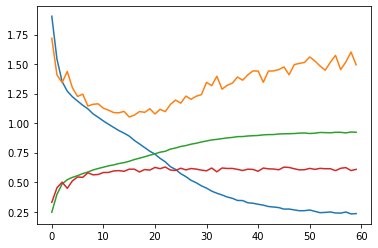

In [11]:
plt.plot(hist)

In [8]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_bottleneck_1c.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
       
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.195 acc: 0.164
	 - Step 2: loss: 2.150 acc: 0.211
	 - Step 3: loss: 2.035 acc: 0.156
	 - Step 4: loss: 2.169 acc: 0.219
	 - Step 5: loss: 2.122 acc: 0.211
	 - Step 6: loss: 2.088 acc: 0.188
	 - Step 7: loss: 1.932 acc: 0.203
	 - Step 8: loss: 2.055 acc: 0.188
	 - Step 9: loss: 1.977 acc: 0.211
	 - Step 10: loss: 2.143 acc: 0.117
	 - Step 11: loss: 1.936 acc: 0.250
	 - Step 12: loss: 2.177 acc: 0.102
	 - Step 13: loss: 2.107 acc: 0.141
	 - Step 14: loss: 2.149 acc: 0.195
	 - Step 15: loss: 2.155 acc: 0.195
	 - Step 16: loss: 2.145 acc: 0.188
	 - Step 17: loss: 2.081 acc: 0.234
	 - Step 18: loss: 2.034 acc: 0.203
	 - Step 19: loss: 2.125 acc: 0.234
	 - Step 20: loss: 1.937 acc: 0.156
	 - Step 21: loss: 2.103 acc: 0.148
	 - Step 22: loss: 1.895 acc: 0.219
	 - Step 23: loss: 2.081 acc: 0.164
	 - Step 24: loss: 1.913 acc: 0.125
	 - Step 25: loss: 2.061 acc: 0.211
	 - Step 26: loss: 1.944 acc: 0.133
	 - Step 27: loss: 2.144 acc: 0.195
	 - Step 28: loss: 2.141 ac

- Avg.loss: 1.964  | Avg.acc: 0.211
- Avg. val_loss: 1.870  | Avg. val_acc: 0.246


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.876 acc: 0.227
	 - Step 2: loss: 1.885 acc: 0.211
	 - Step 3: loss: 1.877 acc: 0.180
	 - Step 4: loss: 1.854 acc: 0.289
	 - Step 5: loss: 1.906 acc: 0.156
	 - Step 6: loss: 1.934 acc: 0.227
	 - Step 7: loss: 1.879 acc: 0.289
	 - Step 8: loss: 1.920 acc: 0.266
	 - Step 9: loss: 1.860 acc: 0.297
	 - Step 10: loss: 1.905 acc: 0.211
	 - Step 11: loss: 1.879 acc: 0.234
	 - Step 12: loss: 1.856 acc: 0.242
	 - Step 13: loss: 1.889 acc: 0.203
	 - Step 14: loss: 1.878 acc: 0.242
	 - Step 15: loss: 1.870 acc: 0.203
	 - Step 16: loss: 1.886 acc: 0.219
	 - Step 17: loss: 1.869 acc: 0.219
	 - Step 18: loss: 1.868 acc: 0.266
	 - Step 19: loss: 1.878 acc: 0.188
	 - Step 20: loss: 1.859 acc: 0.250
	 - Step 21: loss: 1.863 acc: 0.211
	 - Step 22: loss: 1.892 acc: 0.172
	 - Step 23: loss: 1.883 acc: 0.195
	 - Step 24: loss: 1.860 acc: 0.266
	 - Step 25: loss: 1.834 acc: 0.297
	 - Step 26: loss: 1.841 acc: 0.242
	 - Step 27: loss: 1.900 acc: 0.242
	 - 

- Avg.loss: 1.854  | Avg.acc: 0.243
- Avg. val_loss: 1.841  | Avg. val_acc: 0.255
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.820 acc: 0.305
	 - Step 2: loss: 1.812 acc: 0.242
	 - Step 3: loss: 1.831 acc: 0.203
	 - Step 4: loss: 1.861 acc: 0.258
	 - Step 5: loss: 1.810 acc: 0.344
	 - Step 6: loss: 1.888 acc: 0.227
	 - Step 7: loss: 1.859 acc: 0.227
	 - Step 8: loss: 1.839 acc: 0.305
	 - Step 9: loss: 1.822 acc: 0.258
	 - Step 10: loss: 1.790 acc: 0.328
	 - Step 11: loss: 1.855 acc: 0.227
	 - Step 12: loss: 1.828 acc: 0.289
	 - Step 13: loss: 1.860 acc: 0.203
	 - Step 14: loss: 1.850 acc: 0.281
	 - Step 15: loss: 1.848 acc: 0.242
	 - Step 16: loss: 1.852 acc: 0.250
	 - Step 17: loss: 1.831 acc: 0.273
	 - Step 18: loss: 1.808 acc: 0.289
	 - Step 19: loss: 1.809 acc: 0.320
	 - Step 20: loss: 1.815 acc: 0.320
	 - Step 21: loss: 1.849 acc: 0.250
	 - Step 22: loss: 1.817 acc: 0.289
	 - Step 23: loss: 1.798 acc: 0.250
	 - Step 24: loss: 1.821 acc: 0.258
	 - Step 25: loss: 1.767 acc: 

	 - Step 223: loss: 1.810 acc: 0.250
	 - Step 224: loss: 1.837 acc: 0.242
	 - Step 225: loss: 1.852 acc: 0.216
- Avg.loss: 1.819  | Avg.acc: 0.261
- Avg. val_loss: 1.823  | Avg. val_acc: 0.262
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.821 acc: 0.242
	 - Step 2: loss: 1.816 acc: 0.266
	 - Step 3: loss: 1.828 acc: 0.188
	 - Step 4: loss: 1.809 acc: 0.258
	 - Step 5: loss: 1.843 acc: 0.281
	 - Step 6: loss: 1.805 acc: 0.250
	 - Step 7: loss: 1.790 acc: 0.312
	 - Step 8: loss: 1.806 acc: 0.250
	 - Step 9: loss: 1.770 acc: 0.328
	 - Step 10: loss: 1.845 acc: 0.250
	 - Step 11: loss: 1.760 acc: 0.305
	 - Step 12: loss: 1.763 acc: 0.336
	 - Step 13: loss: 1.793 acc: 0.242
	 - Step 14: loss: 1.768 acc: 0.320
	 - Step 15: loss: 1.786 acc: 0.328
	 - Step 16: loss: 1.777 acc: 0.258
	 - Step 17: loss: 1.787 acc: 0.375
	 - Step 18: loss: 1.813 acc: 0.258
	 - Step 19: loss: 1.819 acc: 0.281
	 - Step 20: loss: 1.816 acc: 0.211
	 - Step 21: loss: 1.846 acc: 0.203
	 - Step 22: loss: 1.836 ac

	 - Step 220: loss: 1.835 acc: 0.242
	 - Step 221: loss: 1.776 acc: 0.266
	 - Step 222: loss: 1.727 acc: 0.320
	 - Step 223: loss: 1.853 acc: 0.281
	 - Step 224: loss: 1.791 acc: 0.242
	 - Step 225: loss: 1.809 acc: 0.270
- Avg.loss: 1.798  | Avg.acc: 0.264
- Avg. val_loss: 1.799  | Avg. val_acc: 0.267
* Update optimal model
Epoch:  5
	 - Step 1: loss: 1.792 acc: 0.258
	 - Step 2: loss: 1.718 acc: 0.352
	 - Step 3: loss: 1.746 acc: 0.320
	 - Step 4: loss: 1.749 acc: 0.273
	 - Step 5: loss: 1.802 acc: 0.273
	 - Step 6: loss: 1.813 acc: 0.250
	 - Step 7: loss: 1.820 acc: 0.289
	 - Step 8: loss: 1.775 acc: 0.297
	 - Step 9: loss: 1.740 acc: 0.328
	 - Step 10: loss: 1.786 acc: 0.250
	 - Step 11: loss: 1.773 acc: 0.250
	 - Step 12: loss: 1.754 acc: 0.258
	 - Step 13: loss: 1.772 acc: 0.320
	 - Step 14: loss: 1.805 acc: 0.234
	 - Step 15: loss: 1.721 acc: 0.367
	 - Step 16: loss: 1.777 acc: 0.258
	 - Step 17: loss: 1.802 acc: 0.242
	 - Step 18: loss: 1.738 acc: 0.367
	 - Step 19: loss: 1.837

	 - Step 217: loss: 1.692 acc: 0.328
	 - Step 218: loss: 1.708 acc: 0.320
	 - Step 219: loss: 1.744 acc: 0.266
	 - Step 220: loss: 1.775 acc: 0.266
	 - Step 221: loss: 1.758 acc: 0.289
	 - Step 222: loss: 1.795 acc: 0.305
	 - Step 223: loss: 1.707 acc: 0.344
	 - Step 224: loss: 1.721 acc: 0.305
	 - Step 225: loss: 1.656 acc: 0.351
- Avg.loss: 1.756  | Avg.acc: 0.291
- Avg. val_loss: 1.796  | Avg. val_acc: 0.269
* Update optimal model
Epoch:  6
	 - Step 1: loss: 1.657 acc: 0.344
	 - Step 2: loss: 1.729 acc: 0.281
	 - Step 3: loss: 1.739 acc: 0.344
	 - Step 4: loss: 1.736 acc: 0.328
	 - Step 5: loss: 1.724 acc: 0.297
	 - Step 6: loss: 1.708 acc: 0.336
	 - Step 7: loss: 1.793 acc: 0.289
	 - Step 8: loss: 1.759 acc: 0.266
	 - Step 9: loss: 1.745 acc: 0.320
	 - Step 10: loss: 1.806 acc: 0.297
	 - Step 11: loss: 1.730 acc: 0.305
	 - Step 12: loss: 1.723 acc: 0.312
	 - Step 13: loss: 1.790 acc: 0.273
	 - Step 14: loss: 1.818 acc: 0.227
	 - Step 15: loss: 1.680 acc: 0.383
	 - Step 16: loss: 1.

	 - Step 214: loss: 1.544 acc: 0.391
	 - Step 215: loss: 1.806 acc: 0.258
	 - Step 216: loss: 1.563 acc: 0.391
	 - Step 217: loss: 1.574 acc: 0.336
	 - Step 218: loss: 1.622 acc: 0.430
	 - Step 219: loss: 1.648 acc: 0.359
	 - Step 220: loss: 1.545 acc: 0.367
	 - Step 221: loss: 1.642 acc: 0.344
	 - Step 222: loss: 1.543 acc: 0.391
	 - Step 223: loss: 1.563 acc: 0.445
	 - Step 224: loss: 1.642 acc: 0.367
	 - Step 225: loss: 1.495 acc: 0.459
- Avg.loss: 1.670  | Avg.acc: 0.334
- Avg. val_loss: 1.649  | Avg. val_acc: 0.346
* Update optimal model
Epoch:  7
	 - Step 1: loss: 1.518 acc: 0.359
	 - Step 2: loss: 1.550 acc: 0.367
	 - Step 3: loss: 1.501 acc: 0.406
	 - Step 4: loss: 1.575 acc: 0.383
	 - Step 5: loss: 1.605 acc: 0.352
	 - Step 6: loss: 1.534 acc: 0.422
	 - Step 7: loss: 1.536 acc: 0.453
	 - Step 8: loss: 1.629 acc: 0.398
	 - Step 9: loss: 1.682 acc: 0.320
	 - Step 10: loss: 1.624 acc: 0.336
	 - Step 11: loss: 1.642 acc: 0.391
	 - Step 12: loss: 1.624 acc: 0.336
	 - Step 13: loss:

	 - Step 211: loss: 1.578 acc: 0.344
	 - Step 212: loss: 1.457 acc: 0.414
	 - Step 213: loss: 1.474 acc: 0.414
	 - Step 214: loss: 1.471 acc: 0.445
	 - Step 215: loss: 1.567 acc: 0.367
	 - Step 216: loss: 1.514 acc: 0.445
	 - Step 217: loss: 1.439 acc: 0.438
	 - Step 218: loss: 1.460 acc: 0.391
	 - Step 219: loss: 1.461 acc: 0.430
	 - Step 220: loss: 1.532 acc: 0.375
	 - Step 221: loss: 1.540 acc: 0.406
	 - Step 222: loss: 1.601 acc: 0.398
	 - Step 223: loss: 1.524 acc: 0.398
	 - Step 224: loss: 1.521 acc: 0.398
	 - Step 225: loss: 1.466 acc: 0.432
- Avg.loss: 1.537  | Avg.acc: 0.398
- Avg. val_loss: 1.514  | Avg. val_acc: 0.417
* Update optimal model
Epoch:  8
	 - Step 1: loss: 1.557 acc: 0.352
	 - Step 2: loss: 1.479 acc: 0.422
	 - Step 3: loss: 1.548 acc: 0.328
	 - Step 4: loss: 1.559 acc: 0.398
	 - Step 5: loss: 1.493 acc: 0.391
	 - Step 6: loss: 1.459 acc: 0.445
	 - Step 7: loss: 1.418 acc: 0.445
	 - Step 8: loss: 1.420 acc: 0.484
	 - Step 9: loss: 1.408 acc: 0.430
	 - Step 10: lo

	 - Step 208: loss: 1.469 acc: 0.461
	 - Step 209: loss: 1.355 acc: 0.523
	 - Step 210: loss: 1.282 acc: 0.492
	 - Step 211: loss: 1.374 acc: 0.477
	 - Step 212: loss: 1.421 acc: 0.406
	 - Step 213: loss: 1.425 acc: 0.406
	 - Step 214: loss: 1.308 acc: 0.453
	 - Step 215: loss: 1.303 acc: 0.539
	 - Step 216: loss: 1.448 acc: 0.438
	 - Step 217: loss: 1.263 acc: 0.531
	 - Step 218: loss: 1.412 acc: 0.422
	 - Step 219: loss: 1.371 acc: 0.422
	 - Step 220: loss: 1.453 acc: 0.414
	 - Step 221: loss: 1.404 acc: 0.453
	 - Step 222: loss: 1.318 acc: 0.508
	 - Step 223: loss: 1.348 acc: 0.492
	 - Step 224: loss: 1.416 acc: 0.453
	 - Step 225: loss: 1.529 acc: 0.486
- Avg.loss: 1.421  | Avg.acc: 0.449
- Avg. val_loss: 2.325  | Avg. val_acc: 0.430
* Update optimal model
Epoch:  9
	 - Step 1: loss: 1.299 acc: 0.508
	 - Step 2: loss: 1.345 acc: 0.422
	 - Step 3: loss: 1.403 acc: 0.469
	 - Step 4: loss: 1.255 acc: 0.562
	 - Step 5: loss: 1.329 acc: 0.500
	 - Step 6: loss: 1.420 acc: 0.477
	 - Step 

	 - Step 205: loss: 1.311 acc: 0.500
	 - Step 206: loss: 1.449 acc: 0.406
	 - Step 207: loss: 1.290 acc: 0.492
	 - Step 208: loss: 1.196 acc: 0.531
	 - Step 209: loss: 1.330 acc: 0.477
	 - Step 210: loss: 1.281 acc: 0.531
	 - Step 211: loss: 1.288 acc: 0.523
	 - Step 212: loss: 1.281 acc: 0.500
	 - Step 213: loss: 1.307 acc: 0.477
	 - Step 214: loss: 1.414 acc: 0.430
	 - Step 215: loss: 1.228 acc: 0.492
	 - Step 216: loss: 1.235 acc: 0.586
	 - Step 217: loss: 1.280 acc: 0.500
	 - Step 218: loss: 1.340 acc: 0.484
	 - Step 219: loss: 1.276 acc: 0.508
	 - Step 220: loss: 1.346 acc: 0.430
	 - Step 221: loss: 1.299 acc: 0.492
	 - Step 222: loss: 1.330 acc: 0.484
	 - Step 223: loss: 1.362 acc: 0.461
	 - Step 224: loss: 1.253 acc: 0.562
	 - Step 225: loss: 1.373 acc: 0.541
- Avg.loss: 1.334  | Avg.acc: 0.488
- Avg. val_loss: 1.570  | Avg. val_acc: 0.469
* Update optimal model
Epoch:  10
	 - Step 1: loss: 1.339 acc: 0.469
	 - Step 2: loss: 1.183 acc: 0.539
	 - Step 3: loss: 1.233 acc: 0.500
	 

	 - Step 202: loss: 1.279 acc: 0.570
	 - Step 203: loss: 1.273 acc: 0.523
	 - Step 204: loss: 1.264 acc: 0.531
	 - Step 205: loss: 1.232 acc: 0.562
	 - Step 206: loss: 1.319 acc: 0.477
	 - Step 207: loss: 1.235 acc: 0.547
	 - Step 208: loss: 1.281 acc: 0.555
	 - Step 209: loss: 1.284 acc: 0.516
	 - Step 210: loss: 1.239 acc: 0.469
	 - Step 211: loss: 1.256 acc: 0.555
	 - Step 212: loss: 1.329 acc: 0.484
	 - Step 213: loss: 1.161 acc: 0.602
	 - Step 214: loss: 1.217 acc: 0.531
	 - Step 215: loss: 1.461 acc: 0.461
	 - Step 216: loss: 1.302 acc: 0.516
	 - Step 217: loss: 1.254 acc: 0.547
	 - Step 218: loss: 1.234 acc: 0.531
	 - Step 219: loss: 1.317 acc: 0.523
	 - Step 220: loss: 1.171 acc: 0.586
	 - Step 221: loss: 1.195 acc: 0.539
	 - Step 222: loss: 1.209 acc: 0.625
	 - Step 223: loss: 1.202 acc: 0.539
	 - Step 224: loss: 1.180 acc: 0.523
	 - Step 225: loss: 1.109 acc: 0.595
- Avg.loss: 1.273  | Avg.acc: 0.520
- Avg. val_loss: 1.819  | Avg. val_acc: 0.515
* Update optimal model
Epoch: 

	 - Step 199: loss: 1.154 acc: 0.578
	 - Step 200: loss: 1.275 acc: 0.508
	 - Step 201: loss: 1.286 acc: 0.508
	 - Step 202: loss: 1.127 acc: 0.562
	 - Step 203: loss: 1.199 acc: 0.547
	 - Step 204: loss: 1.276 acc: 0.516
	 - Step 205: loss: 1.200 acc: 0.586
	 - Step 206: loss: 1.262 acc: 0.516
	 - Step 207: loss: 1.226 acc: 0.539
	 - Step 208: loss: 1.304 acc: 0.508
	 - Step 209: loss: 1.122 acc: 0.594
	 - Step 210: loss: 1.199 acc: 0.547
	 - Step 211: loss: 1.191 acc: 0.562
	 - Step 212: loss: 1.159 acc: 0.562
	 - Step 213: loss: 1.212 acc: 0.539
	 - Step 214: loss: 1.189 acc: 0.531
	 - Step 215: loss: 1.106 acc: 0.609
	 - Step 216: loss: 1.131 acc: 0.570
	 - Step 217: loss: 1.182 acc: 0.562
	 - Step 218: loss: 1.172 acc: 0.578
	 - Step 219: loss: 1.255 acc: 0.547
	 - Step 220: loss: 1.101 acc: 0.594
	 - Step 221: loss: 1.205 acc: 0.562
	 - Step 222: loss: 1.082 acc: 0.594
	 - Step 223: loss: 1.186 acc: 0.531
	 - Step 224: loss: 1.241 acc: 0.508
	 - Step 225: loss: 1.364 acc: 0.514
-

	 - Step 196: loss: 1.274 acc: 0.531
	 - Step 197: loss: 1.105 acc: 0.594
	 - Step 198: loss: 1.166 acc: 0.562
	 - Step 199: loss: 1.103 acc: 0.555
	 - Step 200: loss: 1.085 acc: 0.633
	 - Step 201: loss: 1.160 acc: 0.508
	 - Step 202: loss: 1.300 acc: 0.508
	 - Step 203: loss: 1.152 acc: 0.586
	 - Step 204: loss: 1.041 acc: 0.633
	 - Step 205: loss: 1.110 acc: 0.578
	 - Step 206: loss: 1.137 acc: 0.625
	 - Step 207: loss: 1.120 acc: 0.594
	 - Step 208: loss: 1.109 acc: 0.586
	 - Step 209: loss: 1.259 acc: 0.555
	 - Step 210: loss: 1.067 acc: 0.609
	 - Step 211: loss: 1.125 acc: 0.516
	 - Step 212: loss: 1.161 acc: 0.594
	 - Step 213: loss: 1.179 acc: 0.570
	 - Step 214: loss: 1.078 acc: 0.555
	 - Step 215: loss: 1.282 acc: 0.508
	 - Step 216: loss: 1.087 acc: 0.562
	 - Step 217: loss: 1.223 acc: 0.539
	 - Step 218: loss: 1.368 acc: 0.461
	 - Step 219: loss: 1.154 acc: 0.586
	 - Step 220: loss: 1.140 acc: 0.594
	 - Step 221: loss: 1.173 acc: 0.562
	 - Step 222: loss: 1.026 acc: 0.641
	

	 - Step 193: loss: 1.173 acc: 0.547
	 - Step 194: loss: 1.183 acc: 0.562
	 - Step 195: loss: 1.174 acc: 0.578
	 - Step 196: loss: 1.018 acc: 0.633
	 - Step 197: loss: 1.036 acc: 0.602
	 - Step 198: loss: 1.068 acc: 0.602
	 - Step 199: loss: 1.150 acc: 0.555
	 - Step 200: loss: 0.943 acc: 0.695
	 - Step 201: loss: 1.167 acc: 0.555
	 - Step 202: loss: 1.108 acc: 0.594
	 - Step 203: loss: 1.184 acc: 0.578
	 - Step 204: loss: 1.153 acc: 0.586
	 - Step 205: loss: 1.051 acc: 0.617
	 - Step 206: loss: 1.137 acc: 0.578
	 - Step 207: loss: 1.125 acc: 0.578
	 - Step 208: loss: 1.144 acc: 0.586
	 - Step 209: loss: 1.038 acc: 0.648
	 - Step 210: loss: 1.018 acc: 0.602
	 - Step 211: loss: 1.163 acc: 0.586
	 - Step 212: loss: 1.109 acc: 0.570
	 - Step 213: loss: 1.213 acc: 0.555
	 - Step 214: loss: 1.135 acc: 0.594
	 - Step 215: loss: 1.063 acc: 0.617
	 - Step 216: loss: 1.138 acc: 0.547
	 - Step 217: loss: 1.028 acc: 0.656
	 - Step 218: loss: 1.190 acc: 0.555
	 - Step 219: loss: 1.263 acc: 0.539
	

	 - Step 190: loss: 1.081 acc: 0.609
	 - Step 191: loss: 1.027 acc: 0.625
	 - Step 192: loss: 1.068 acc: 0.602
	 - Step 193: loss: 1.130 acc: 0.570
	 - Step 194: loss: 1.155 acc: 0.531
	 - Step 195: loss: 1.097 acc: 0.586
	 - Step 196: loss: 1.190 acc: 0.547
	 - Step 197: loss: 0.980 acc: 0.656
	 - Step 198: loss: 1.015 acc: 0.609
	 - Step 199: loss: 1.117 acc: 0.578
	 - Step 200: loss: 1.077 acc: 0.625
	 - Step 201: loss: 1.016 acc: 0.648
	 - Step 202: loss: 1.195 acc: 0.562
	 - Step 203: loss: 0.978 acc: 0.664
	 - Step 204: loss: 1.094 acc: 0.578
	 - Step 205: loss: 0.979 acc: 0.648
	 - Step 206: loss: 0.940 acc: 0.633
	 - Step 207: loss: 1.056 acc: 0.602
	 - Step 208: loss: 1.029 acc: 0.633
	 - Step 209: loss: 1.166 acc: 0.602
	 - Step 210: loss: 0.994 acc: 0.641
	 - Step 211: loss: 1.165 acc: 0.555
	 - Step 212: loss: 1.023 acc: 0.594
	 - Step 213: loss: 1.056 acc: 0.609
	 - Step 214: loss: 0.956 acc: 0.695
	 - Step 215: loss: 1.085 acc: 0.578
	 - Step 216: loss: 1.053 acc: 0.594
	

	 - Step 187: loss: 0.984 acc: 0.664
	 - Step 188: loss: 0.990 acc: 0.648
	 - Step 189: loss: 0.964 acc: 0.609
	 - Step 190: loss: 1.158 acc: 0.633
	 - Step 191: loss: 1.059 acc: 0.617
	 - Step 192: loss: 0.904 acc: 0.664
	 - Step 193: loss: 1.083 acc: 0.609
	 - Step 194: loss: 0.858 acc: 0.703
	 - Step 195: loss: 1.041 acc: 0.625
	 - Step 196: loss: 0.914 acc: 0.695
	 - Step 197: loss: 0.942 acc: 0.688
	 - Step 198: loss: 0.864 acc: 0.688
	 - Step 199: loss: 0.908 acc: 0.680
	 - Step 200: loss: 1.023 acc: 0.656
	 - Step 201: loss: 1.041 acc: 0.609
	 - Step 202: loss: 1.101 acc: 0.609
	 - Step 203: loss: 1.073 acc: 0.602
	 - Step 204: loss: 1.146 acc: 0.594
	 - Step 205: loss: 1.036 acc: 0.633
	 - Step 206: loss: 1.031 acc: 0.594
	 - Step 207: loss: 1.015 acc: 0.609
	 - Step 208: loss: 0.999 acc: 0.664
	 - Step 209: loss: 0.917 acc: 0.656
	 - Step 210: loss: 1.042 acc: 0.633
	 - Step 211: loss: 1.061 acc: 0.586
	 - Step 212: loss: 1.175 acc: 0.547
	 - Step 213: loss: 1.138 acc: 0.609
	

	 - Step 184: loss: 1.014 acc: 0.625
	 - Step 185: loss: 0.972 acc: 0.648
	 - Step 186: loss: 0.968 acc: 0.641
	 - Step 187: loss: 0.933 acc: 0.672
	 - Step 188: loss: 0.938 acc: 0.656
	 - Step 189: loss: 0.922 acc: 0.672
	 - Step 190: loss: 0.940 acc: 0.664
	 - Step 191: loss: 0.994 acc: 0.672
	 - Step 192: loss: 0.919 acc: 0.664
	 - Step 193: loss: 0.965 acc: 0.688
	 - Step 194: loss: 1.087 acc: 0.602
	 - Step 195: loss: 1.046 acc: 0.672
	 - Step 196: loss: 1.047 acc: 0.664
	 - Step 197: loss: 0.943 acc: 0.656
	 - Step 198: loss: 0.969 acc: 0.633
	 - Step 199: loss: 0.994 acc: 0.625
	 - Step 200: loss: 1.086 acc: 0.586
	 - Step 201: loss: 0.921 acc: 0.688
	 - Step 202: loss: 0.936 acc: 0.672
	 - Step 203: loss: 0.955 acc: 0.648
	 - Step 204: loss: 1.056 acc: 0.617
	 - Step 205: loss: 0.849 acc: 0.695
	 - Step 206: loss: 1.119 acc: 0.586
	 - Step 207: loss: 1.050 acc: 0.625
	 - Step 208: loss: 1.042 acc: 0.617
	 - Step 209: loss: 1.092 acc: 0.562
	 - Step 210: loss: 0.925 acc: 0.648
	

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	 - Step 124: loss: 0.156 acc: 0.961
	 - Step 125: loss: 0.252 acc: 0.883
	 - Step 126: loss: 0.160 acc: 0.961
	 - Step 127: loss: 0.310 acc: 0.875
	 - Step 128: loss: 0.328 acc: 0.891
	 - Step 129: loss: 0.189 acc: 0.945
	 - Step 130: loss: 0.304 acc: 0.922
	 - Step 131: loss: 0.347 acc: 0.875
	 - Step 132: loss: 0.144 acc: 0.969
	 - Step 133: loss: 0.212 acc: 0.922
	 - Step 134: loss: 0.129 acc: 0.945
	 - Step 135: loss: 0.213 acc: 0.914
	 - Step 136: loss: 0.338 acc: 0.859
	 - Step 137: loss: 0.188 acc: 0.906
	 - Step 138: loss: 0.140 acc: 0.953
	 - Step 139: loss: 0.225 acc: 0.922
	 - Step 140: loss: 0.201 acc: 0.930
	 - Step 141: loss: 0.218 acc: 0.945
	 - Step 142: loss: 0.191 acc: 0.961
	 - Step 143: loss: 0.418 acc: 0.875
	 - Step 144: loss: 0.188 acc: 0.953
	 - Step 145: loss: 0.263 acc: 0.922
	 - Step 146: loss: 0.163 acc: 0.945
	 - Step 147: loss: 0.229 acc: 0.922
	 - Step 148: loss: 0.227 acc: 0.930
	 - Step 149: loss: 0.185 acc: 0.922
	 - Step 150: loss: 0.220 acc: 0.930
	

	 - Step 121: loss: 0.186 acc: 0.906
	 - Step 122: loss: 0.162 acc: 0.953
	 - Step 123: loss: 0.167 acc: 0.930
	 - Step 124: loss: 0.197 acc: 0.945
	 - Step 125: loss: 0.236 acc: 0.930
	 - Step 126: loss: 0.145 acc: 0.953
	 - Step 127: loss: 0.262 acc: 0.906
	 - Step 128: loss: 0.243 acc: 0.922
	 - Step 129: loss: 0.187 acc: 0.938
	 - Step 130: loss: 0.233 acc: 0.930
	 - Step 131: loss: 0.249 acc: 0.930
	 - Step 132: loss: 0.168 acc: 0.930
	 - Step 133: loss: 0.139 acc: 0.977
	 - Step 134: loss: 0.188 acc: 0.938
	 - Step 135: loss: 0.297 acc: 0.883
	 - Step 136: loss: 0.346 acc: 0.898
	 - Step 137: loss: 0.164 acc: 0.961
	 - Step 138: loss: 0.241 acc: 0.922
	 - Step 139: loss: 0.302 acc: 0.875
	 - Step 140: loss: 0.336 acc: 0.867
	 - Step 141: loss: 0.263 acc: 0.914
	 - Step 142: loss: 0.159 acc: 0.930
	 - Step 143: loss: 0.161 acc: 0.938
	 - Step 144: loss: 0.116 acc: 0.977
	 - Step 145: loss: 0.166 acc: 0.945
	 - Step 146: loss: 0.223 acc: 0.938
	 - Step 147: loss: 0.134 acc: 0.953
	

	 - Step 118: loss: 0.241 acc: 0.930
	 - Step 119: loss: 0.211 acc: 0.953
	 - Step 120: loss: 0.162 acc: 0.953
	 - Step 121: loss: 0.169 acc: 0.938
	 - Step 122: loss: 0.153 acc: 0.945
	 - Step 123: loss: 0.210 acc: 0.914
	 - Step 124: loss: 0.187 acc: 0.922
	 - Step 125: loss: 0.165 acc: 0.945
	 - Step 126: loss: 0.211 acc: 0.930
	 - Step 127: loss: 0.094 acc: 0.977
	 - Step 128: loss: 0.140 acc: 0.961
	 - Step 129: loss: 0.173 acc: 0.945
	 - Step 130: loss: 0.117 acc: 0.961
	 - Step 131: loss: 0.375 acc: 0.891
	 - Step 132: loss: 0.287 acc: 0.906
	 - Step 133: loss: 0.216 acc: 0.914
	 - Step 134: loss: 0.262 acc: 0.906
	 - Step 135: loss: 0.173 acc: 0.953
	 - Step 136: loss: 0.230 acc: 0.898
	 - Step 137: loss: 0.235 acc: 0.930
	 - Step 138: loss: 0.123 acc: 0.961
	 - Step 139: loss: 0.259 acc: 0.914
	 - Step 140: loss: 0.253 acc: 0.938
	 - Step 141: loss: 0.139 acc: 0.953
	 - Step 142: loss: 0.114 acc: 0.961
	 - Step 143: loss: 0.134 acc: 0.953
	 - Step 144: loss: 0.278 acc: 0.898
	

	 - Step 115: loss: 0.189 acc: 0.945
	 - Step 116: loss: 0.114 acc: 0.969
	 - Step 117: loss: 0.178 acc: 0.953
	 - Step 118: loss: 0.154 acc: 0.969
	 - Step 119: loss: 0.273 acc: 0.930
	 - Step 120: loss: 0.128 acc: 0.961
	 - Step 121: loss: 0.213 acc: 0.930
	 - Step 122: loss: 0.238 acc: 0.930
	 - Step 123: loss: 0.177 acc: 0.938
	 - Step 124: loss: 0.226 acc: 0.922
	 - Step 125: loss: 0.149 acc: 0.930
	 - Step 126: loss: 0.183 acc: 0.938
	 - Step 127: loss: 0.124 acc: 0.945
	 - Step 128: loss: 0.342 acc: 0.906
	 - Step 129: loss: 0.233 acc: 0.922
	 - Step 130: loss: 0.299 acc: 0.906
	 - Step 131: loss: 0.168 acc: 0.938
	 - Step 132: loss: 0.261 acc: 0.922
	 - Step 133: loss: 0.137 acc: 0.953
	 - Step 134: loss: 0.194 acc: 0.945
	 - Step 135: loss: 0.174 acc: 0.945
	 - Step 136: loss: 0.238 acc: 0.938
	 - Step 137: loss: 0.236 acc: 0.922
	 - Step 138: loss: 0.267 acc: 0.914
	 - Step 139: loss: 0.282 acc: 0.898
	 - Step 140: loss: 0.263 acc: 0.891
	 - Step 141: loss: 0.080 acc: 0.984
	

	 - Step 112: loss: 0.110 acc: 0.984
	 - Step 113: loss: 0.210 acc: 0.930
	 - Step 114: loss: 0.325 acc: 0.883
	 - Step 115: loss: 0.286 acc: 0.891
	 - Step 116: loss: 0.183 acc: 0.953
	 - Step 117: loss: 0.180 acc: 0.938
	 - Step 118: loss: 0.270 acc: 0.891
	 - Step 119: loss: 0.106 acc: 0.984
	 - Step 120: loss: 0.165 acc: 0.961
	 - Step 121: loss: 0.223 acc: 0.922
	 - Step 122: loss: 0.271 acc: 0.906
	 - Step 123: loss: 0.176 acc: 0.945
	 - Step 124: loss: 0.421 acc: 0.883
	 - Step 125: loss: 0.149 acc: 0.945
	 - Step 126: loss: 0.176 acc: 0.938
	 - Step 127: loss: 0.255 acc: 0.914
	 - Step 128: loss: 0.228 acc: 0.938
	 - Step 129: loss: 0.184 acc: 0.938
	 - Step 130: loss: 0.151 acc: 0.922
	 - Step 131: loss: 0.135 acc: 0.953
	 - Step 132: loss: 0.188 acc: 0.945
	 - Step 133: loss: 0.157 acc: 0.945
	 - Step 134: loss: 0.176 acc: 0.938
	 - Step 135: loss: 0.245 acc: 0.914
	 - Step 136: loss: 0.218 acc: 0.930
	 - Step 137: loss: 0.157 acc: 0.953
	 - Step 138: loss: 0.140 acc: 0.953
	

	 - Step 109: loss: 0.170 acc: 0.945
	 - Step 110: loss: 0.181 acc: 0.914
	 - Step 111: loss: 0.262 acc: 0.922
	 - Step 112: loss: 0.129 acc: 0.969
	 - Step 113: loss: 0.166 acc: 0.945
	 - Step 114: loss: 0.131 acc: 0.953
	 - Step 115: loss: 0.187 acc: 0.938
	 - Step 116: loss: 0.199 acc: 0.914
	 - Step 117: loss: 0.161 acc: 0.945
	 - Step 118: loss: 0.285 acc: 0.922
	 - Step 119: loss: 0.212 acc: 0.945
	 - Step 120: loss: 0.405 acc: 0.891
	 - Step 121: loss: 0.265 acc: 0.898
	 - Step 122: loss: 0.239 acc: 0.922
	 - Step 123: loss: 0.148 acc: 0.930
	 - Step 124: loss: 0.089 acc: 0.977
	 - Step 125: loss: 0.263 acc: 0.914
	 - Step 126: loss: 0.189 acc: 0.930
	 - Step 127: loss: 0.156 acc: 0.945
	 - Step 128: loss: 0.163 acc: 0.945
	 - Step 129: loss: 0.179 acc: 0.938
	 - Step 130: loss: 0.134 acc: 0.945
	 - Step 131: loss: 0.216 acc: 0.922
	 - Step 132: loss: 0.217 acc: 0.922
	 - Step 133: loss: 0.137 acc: 0.969
	 - Step 134: loss: 0.252 acc: 0.930
	 - Step 135: loss: 0.152 acc: 0.945
	

	 - Step 106: loss: 0.190 acc: 0.945
	 - Step 107: loss: 0.318 acc: 0.922
	 - Step 108: loss: 0.249 acc: 0.930
	 - Step 109: loss: 0.227 acc: 0.898
	 - Step 110: loss: 0.189 acc: 0.930
	 - Step 111: loss: 0.232 acc: 0.922
	 - Step 112: loss: 0.291 acc: 0.898
	 - Step 113: loss: 0.276 acc: 0.898
	 - Step 114: loss: 0.126 acc: 0.961
	 - Step 115: loss: 0.316 acc: 0.898
	 - Step 116: loss: 0.167 acc: 0.953
	 - Step 117: loss: 0.297 acc: 0.898
	 - Step 118: loss: 0.183 acc: 0.953
	 - Step 119: loss: 0.277 acc: 0.867
	 - Step 120: loss: 0.220 acc: 0.922
	 - Step 121: loss: 0.316 acc: 0.914
	 - Step 122: loss: 0.165 acc: 0.953
	 - Step 123: loss: 0.238 acc: 0.914
	 - Step 124: loss: 0.206 acc: 0.914
	 - Step 125: loss: 0.169 acc: 0.945
	 - Step 126: loss: 0.233 acc: 0.906
	 - Step 127: loss: 0.157 acc: 0.953
	 - Step 128: loss: 0.135 acc: 0.969
	 - Step 129: loss: 0.165 acc: 0.930
	 - Step 130: loss: 0.301 acc: 0.906
	 - Step 131: loss: 0.159 acc: 0.961
	 - Step 132: loss: 0.252 acc: 0.922
	

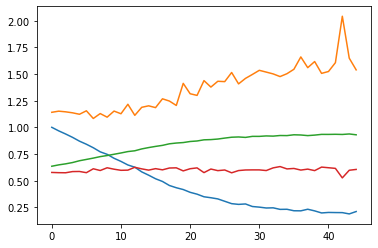

In [20]:
plt.plot(hist[15:])

In [13]:
best_acc

0.6331896555834803

In [17]:
hist

[[1.9635198169284396,
  1.870129762024715,
  0.21093374623192682,
  0.24574353468829188],
 [1.8536705006493464,
  1.8407404258333404,
  0.24275056309170193,
  0.2551724139986367],
 [1.8194809352027046,
  1.823158757439975,
  0.26085679431756337,
  0.261637931240016],
 [1.7981721533669366,
  1.7990761214289173,
  0.26429147905773587,
  0.26686422424069767],
 [1.7560381597942776,
  1.7956619591548526,
  0.2912490615579817,
  0.2687500001027666],
 [1.669557163450453,
  1.649119179824303,
  0.33429898659388224,
  0.34552801734414595],
 [1.537019182311164,
  1.513760706474041,
  0.39813719974623785,
  0.41670258702902957],
 [1.4213278060489232,
  2.3248761851212074,
  0.44872466219796076,
  0.4298491380338011],
 [1.333970135582818,
  1.570307312340572,
  0.4884093470043606,
  0.4693426726193264],
 [1.2730930466122097,
  1.8194161653518677,
  0.520281531545851,
  0.5149245693765837],
 [1.2169905238681369,
  1.2952910620590736,
  0.5425600600242615,
  0.5218750002055332],
 [1.1648930237028334

### Dense concept in WeightFeature

In [4]:
class WeightFeature(nn.Module):

    def __init__(self, feature_depth, target_depth):
        super(WeightFeature, self).__init__()

        self.target_depth = target_depth
#         self.conv1 = nn.Conv2d(feature_depth, feature_depth, kernel_size=feature_size, padding=0)
#         self.bn = nn.BatchNorm2d(feature_depth)
        self.fc1 = nn.Linear(feature_depth, target_depth)
        self.bn1 = nn.BatchNorm1d(target_depth)
        self.bn2 = nn.BatchNorm2d(target_depth)
        
    def forward(self, x1, x2):
        '''
        x1 -> GAP -> FC -> * with x2-> x2 --> out
        x2 ----------------------------|
        '''
        x1 = nn.AvgPool2d(kernel_size=(x1.size(-2), x1.size(-1)))(x1)
        x1 = nn.Flatten()(x1)

        x1 = self.fc1(x1)
#         x1 = nn.Dropout(0.6)(x1)
        x1 = self.bn1(x1)
        x1 = nn.Sigmoid()(x1)
#         x1 = nn.ReLU()(x1)
        x1 = x1.unsqueeze(-1).unsqueeze(-1)
        # print(x1.size())
        # x2 = self.conv1(x2)

        x_out = torch.mul(x2, x1)
#         x_out = x_out + x2 
        x_out = self.bn2(x_out)

        return x_out

In [6]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()
        
        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
#         self.feature_size = kwargs['feature_size']

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv0 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1, padding=0, stride=1)
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.preconv4 = nn.Conv2d(3*nb_neurons, nb_neurons, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.convout = nn.Conv2d(4*nb_neurons, nb_neurons, kernel_size=1, stride=1, padding=0)
        self.bnout = nn.BatchNorm2d(nb_neurons)
        
        
        self.wf12_3 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf12_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf12_out = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf13_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf13_out = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf23_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf23_out = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf34_out = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        
        self.bn0 = nn.BatchNorm2d(nb_neurons)
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        self.prebn4 = nn.BatchNorm2d(nb_neurons)
        self.bn4 = nn.BatchNorm2d(nb_neurons)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        '''
        x: single output layer of list 
        '''

        x = torch.cat(x, dim=1) if type(x) is list else x
        
        # 0 th (identity conv)
        x0 = self.conv0(x)
        x0 = self.bn0(x0)
        x0 = self.relu(x0)

        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = self.relu(x2)
        
        # 1,2 -> 3
        x12_3 = self.wf12_3(x1, x2)

        # 3rd
        x3 = self.conv3(x12_3)
        x3 = self.bn3(x3)
        x3 = self.relu(x3)
        
        # 1,2 -> 4
        # 1,3 -> 4
        # 2,3 -> 4
        x12_4 = self.wf12_4(x1, x2)
        x13_4 = self.wf13_4(x1, x3)
        x23_4 = self.wf23_4(x2, x3)
        
        x4 = torch.cat([x12_4, x13_4, x23_4], dim=1)
        x4 = self.preconv4(x4)
        x4 = self.prebn4(x4)
        x4 = self.relu()(x4)
        
        # 1,2 -> out
        # 1,3 -> out
        # 2,3 -> out
        # 3,4 -> out
        x12_out = self.wf12_out(x1,x2)
        x13_out = self.wf13_out(x1,x3)
        x23_out = self.wf23_out(x2,x3)
        x34_out = self.wf34_out(x3,x4)
        
        
        
#         # 4th
#         x = self.conv4(x4)
#         x = self.bn4(x)
#         x4 = self.relu(x)   
        

        return x_out

In [8]:
class SVGG(nn.Module):

    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1,128).to(self.device)
        self.sv1 = SVblock(128, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 256).to(self.device)
        self.sv4 = SVblock(256, 512).to(self.device)
        self.sv5 = SVblock(512, 512).to(self.device)  


        self.fc1 = nn.Linear(512, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 7)
        self.bn2 = nn.BatchNorm1d(7)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x0 = self.sv0(x)
        x1 = self.sv1(x0)
        
        x1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x1)
        
        x2 = self.sv2(x1)
        x3 = self.sv3(x2)
        
        x3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x3)
        
        x4 = self.sv4(x3)
        x5 = self.sv5(x4)
        x5 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x5)
        
        x5 = nn.AvgPool2d(kernel_size=(x5.size(-2), x5.size(-1)))(x5)
        x_out = nn.Flatten()(x5)

        x_out = self.fc1(x_out)
        x_out = self.bn1(x_out)
        x_out = self.fc2(x_out)
        x_out = self.bn2(x_out)

        return x_out


In [9]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# model.train()

# model = model.to(device)

cuda


In [9]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_bottleneck_3.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
       
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.602 acc: 0.125
	 - Step 2: loss: 2.359 acc: 0.062
	 - Step 3: loss: 2.146 acc: 0.094
	 - Step 4: loss: 2.366 acc: 0.125
	 - Step 5: loss: 2.246 acc: 0.094
	 - Step 6: loss: 2.204 acc: 0.094
	 - Step 7: loss: 2.243 acc: 0.188
	 - Step 8: loss: 2.070 acc: 0.219
	 - Step 9: loss: 1.890 acc: 0.250
	 - Step 10: loss: 2.244 acc: 0.125
	 - Step 11: loss: 2.002 acc: 0.156
	 - Step 12: loss: 2.208 acc: 0.188
	 - Step 13: loss: 2.160 acc: 0.156
	 - Step 14: loss: 2.054 acc: 0.125
	 - Step 15: loss: 1.933 acc: 0.188
	 - Step 16: loss: 2.106 acc: 0.062
	 - Step 17: loss: 1.956 acc: 0.281
	 - Step 18: loss: 2.288 acc: 0.125
	 - Step 19: loss: 2.008 acc: 0.188
	 - Step 20: loss: 1.968 acc: 0.188
	 - Step 21: loss: 2.384 acc: 0.125
	 - Step 22: loss: 2.161 acc: 0.125
	 - Step 23: loss: 1.902 acc: 0.250
	 - Step 24: loss: 1.956 acc: 0.188
	 - Step 25: loss: 1.900 acc: 0.156
	 - Step 26: loss: 1.968 acc: 0.125
	 - Step 27: loss: 1.961 acc: 0.125
	 - Step 28: loss: 2.014 ac

	 - Step 226: loss: 1.867 acc: 0.281
	 - Step 227: loss: 1.841 acc: 0.219
	 - Step 228: loss: 1.881 acc: 0.281
	 - Step 229: loss: 1.932 acc: 0.188
	 - Step 230: loss: 1.860 acc: 0.219
	 - Step 231: loss: 1.878 acc: 0.219
	 - Step 232: loss: 1.879 acc: 0.375
	 - Step 233: loss: 1.948 acc: 0.219
	 - Step 234: loss: 1.885 acc: 0.312
	 - Step 235: loss: 1.873 acc: 0.281
	 - Step 236: loss: 1.921 acc: 0.250
	 - Step 237: loss: 1.845 acc: 0.156
	 - Step 238: loss: 1.894 acc: 0.250
	 - Step 239: loss: 1.822 acc: 0.281
	 - Step 240: loss: 1.937 acc: 0.156
	 - Step 241: loss: 1.822 acc: 0.344
	 - Step 242: loss: 1.833 acc: 0.281
	 - Step 243: loss: 1.825 acc: 0.156
	 - Step 244: loss: 1.928 acc: 0.125
	 - Step 245: loss: 1.945 acc: 0.156
	 - Step 246: loss: 1.906 acc: 0.219
	 - Step 247: loss: 1.868 acc: 0.250
	 - Step 248: loss: 1.822 acc: 0.219
	 - Step 249: loss: 1.852 acc: 0.250
	 - Step 250: loss: 1.855 acc: 0.188
	 - Step 251: loss: 1.858 acc: 0.375
	 - Step 252: loss: 1.946 acc: 0.219
	

	 - Step 448: loss: 1.906 acc: 0.250
	 - Step 449: loss: 1.810 acc: 0.406
	 - Step 450: loss: 1.830 acc: 0.312
	 - Step 451: loss: 1.843 acc: 0.281
	 - Step 452: loss: 1.823 acc: 0.219
	 - Step 453: loss: 1.815 acc: 0.281
	 - Step 454: loss: 1.854 acc: 0.188
	 - Step 455: loss: 1.874 acc: 0.125
	 - Step 456: loss: 1.868 acc: 0.188
	 - Step 457: loss: 1.839 acc: 0.188
	 - Step 458: loss: 1.894 acc: 0.250
	 - Step 459: loss: 1.756 acc: 0.344
	 - Step 460: loss: 1.849 acc: 0.250
	 - Step 461: loss: 1.776 acc: 0.344
	 - Step 462: loss: 1.865 acc: 0.281
	 - Step 463: loss: 1.817 acc: 0.344
	 - Step 464: loss: 1.826 acc: 0.281
	 - Step 465: loss: 1.780 acc: 0.281
	 - Step 466: loss: 1.871 acc: 0.250
	 - Step 467: loss: 1.910 acc: 0.188
	 - Step 468: loss: 1.899 acc: 0.094
	 - Step 469: loss: 1.875 acc: 0.188
	 - Step 470: loss: 1.787 acc: 0.281
	 - Step 471: loss: 1.812 acc: 0.281
	 - Step 472: loss: 1.808 acc: 0.312
	 - Step 473: loss: 1.796 acc: 0.250
	 - Step 474: loss: 1.887 acc: 0.312
	

	 - Step 670: loss: 1.828 acc: 0.312
	 - Step 671: loss: 1.798 acc: 0.219
	 - Step 672: loss: 1.895 acc: 0.156
	 - Step 673: loss: 1.733 acc: 0.219
	 - Step 674: loss: 1.775 acc: 0.312
	 - Step 675: loss: 1.812 acc: 0.188
	 - Step 676: loss: 1.757 acc: 0.281
	 - Step 677: loss: 1.747 acc: 0.312
	 - Step 678: loss: 1.897 acc: 0.250
	 - Step 679: loss: 1.837 acc: 0.312
	 - Step 680: loss: 1.772 acc: 0.250
	 - Step 681: loss: 1.847 acc: 0.188
	 - Step 682: loss: 1.694 acc: 0.312
	 - Step 683: loss: 1.871 acc: 0.188
	 - Step 684: loss: 1.835 acc: 0.250
	 - Step 685: loss: 1.675 acc: 0.375
	 - Step 686: loss: 1.792 acc: 0.281
	 - Step 687: loss: 1.778 acc: 0.281
	 - Step 688: loss: 1.871 acc: 0.281
	 - Step 689: loss: 1.738 acc: 0.250
	 - Step 690: loss: 1.761 acc: 0.219
	 - Step 691: loss: 1.879 acc: 0.125
	 - Step 692: loss: 1.755 acc: 0.312
	 - Step 693: loss: 1.786 acc: 0.250
	 - Step 694: loss: 1.812 acc: 0.250
	 - Step 695: loss: 1.869 acc: 0.219
	 - Step 696: loss: 1.781 acc: 0.219
	

	 - Step 892: loss: 1.781 acc: 0.250
	 - Step 893: loss: 1.961 acc: 0.188
	 - Step 894: loss: 1.724 acc: 0.375
	 - Step 895: loss: 1.769 acc: 0.344
	 - Step 896: loss: 1.738 acc: 0.312
	 - Step 897: loss: 1.778 acc: 0.312
	 - Step 898: loss: 2.119 acc: 0.200
- Avg.loss: 1.847  | Avg.acc: 0.248
- Avg. val_loss: 1.814  | Avg. val_acc: 0.295


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.780 acc: 0.219
	 - Step 2: loss: 1.915 acc: 0.094
	 - Step 3: loss: 1.846 acc: 0.281
	 - Step 4: loss: 1.854 acc: 0.188
	 - Step 5: loss: 1.808 acc: 0.344
	 - Step 6: loss: 1.809 acc: 0.281
	 - Step 7: loss: 1.727 acc: 0.375
	 - Step 8: loss: 1.713 acc: 0.406
	 - Step 9: loss: 1.705 acc: 0.281
	 - Step 10: loss: 1.743 acc: 0.281
	 - Step 11: loss: 1.775 acc: 0.156
	 - Step 12: loss: 1.820 acc: 0.188
	 - Step 13: loss: 1.825 acc: 0.125
	 - Step 14: loss: 1.898 acc: 0.250
	 - Step 15: loss: 1.622 acc: 0.438
	 - Step 16: loss: 1.677 acc: 0.344
	 - Step 17: loss: 1.732 acc: 0.281
	 - Step 18: loss: 1.772 acc: 0.406
	 - Step 19: loss: 1.838 acc: 0.281
	 - Step 20: loss: 1.701 acc: 0.312
	 - Step 21: loss: 1.766 acc: 0.281
	 - Step 22: loss: 1.801 acc: 0.250
	 - Step 23: loss: 1.711 acc: 0.281
	 - Step 24: loss: 1.600 acc: 0.375
	 - Step 25: loss: 1.756 acc: 0.281
	 - Step 26: loss: 1.776 acc: 0.406
	 - Step 27: loss: 1.757 acc: 0.188
	 - 

	 - Step 225: loss: 1.524 acc: 0.438
	 - Step 226: loss: 1.837 acc: 0.219
	 - Step 227: loss: 1.546 acc: 0.344
	 - Step 228: loss: 1.787 acc: 0.250
	 - Step 229: loss: 1.722 acc: 0.344
	 - Step 230: loss: 1.599 acc: 0.375
	 - Step 231: loss: 1.737 acc: 0.281
	 - Step 232: loss: 1.617 acc: 0.281
	 - Step 233: loss: 1.779 acc: 0.219
	 - Step 234: loss: 1.702 acc: 0.281
	 - Step 235: loss: 1.760 acc: 0.375
	 - Step 236: loss: 1.846 acc: 0.281
	 - Step 237: loss: 1.655 acc: 0.406
	 - Step 238: loss: 1.635 acc: 0.312
	 - Step 239: loss: 1.513 acc: 0.406
	 - Step 240: loss: 1.818 acc: 0.281
	 - Step 241: loss: 1.727 acc: 0.219
	 - Step 242: loss: 1.841 acc: 0.188
	 - Step 243: loss: 1.600 acc: 0.406
	 - Step 244: loss: 1.874 acc: 0.188
	 - Step 245: loss: 1.693 acc: 0.312
	 - Step 246: loss: 1.553 acc: 0.281
	 - Step 247: loss: 1.765 acc: 0.312
	 - Step 248: loss: 1.836 acc: 0.250
	 - Step 249: loss: 1.547 acc: 0.531
	 - Step 250: loss: 1.695 acc: 0.281
	 - Step 251: loss: 1.672 acc: 0.375
	

	 - Step 447: loss: 1.538 acc: 0.375
	 - Step 448: loss: 1.852 acc: 0.125
	 - Step 449: loss: 1.398 acc: 0.469
	 - Step 450: loss: 1.577 acc: 0.312
	 - Step 451: loss: 1.544 acc: 0.406
	 - Step 452: loss: 1.334 acc: 0.531
	 - Step 453: loss: 1.866 acc: 0.156
	 - Step 454: loss: 1.570 acc: 0.500
	 - Step 455: loss: 1.515 acc: 0.312
	 - Step 456: loss: 1.413 acc: 0.469
	 - Step 457: loss: 1.411 acc: 0.375
	 - Step 458: loss: 1.514 acc: 0.406
	 - Step 459: loss: 1.358 acc: 0.500
	 - Step 460: loss: 1.704 acc: 0.312
	 - Step 461: loss: 1.798 acc: 0.219
	 - Step 462: loss: 1.575 acc: 0.375
	 - Step 463: loss: 1.507 acc: 0.438
	 - Step 464: loss: 1.864 acc: 0.250
	 - Step 465: loss: 1.617 acc: 0.250
	 - Step 466: loss: 1.722 acc: 0.312
	 - Step 467: loss: 1.634 acc: 0.344
	 - Step 468: loss: 1.963 acc: 0.281
	 - Step 469: loss: 1.548 acc: 0.312
	 - Step 470: loss: 1.687 acc: 0.219
	 - Step 471: loss: 1.904 acc: 0.188
	 - Step 472: loss: 1.707 acc: 0.344
	 - Step 473: loss: 1.531 acc: 0.406
	

	 - Step 669: loss: 1.622 acc: 0.281
	 - Step 670: loss: 1.677 acc: 0.312
	 - Step 671: loss: 1.763 acc: 0.188
	 - Step 672: loss: 1.564 acc: 0.344
	 - Step 673: loss: 1.676 acc: 0.375
	 - Step 674: loss: 1.588 acc: 0.406
	 - Step 675: loss: 1.533 acc: 0.312
	 - Step 676: loss: 1.625 acc: 0.375
	 - Step 677: loss: 1.560 acc: 0.438
	 - Step 678: loss: 1.866 acc: 0.188
	 - Step 679: loss: 1.681 acc: 0.250
	 - Step 680: loss: 1.427 acc: 0.406
	 - Step 681: loss: 1.649 acc: 0.406
	 - Step 682: loss: 1.519 acc: 0.406
	 - Step 683: loss: 1.475 acc: 0.406
	 - Step 684: loss: 1.447 acc: 0.531
	 - Step 685: loss: 1.530 acc: 0.281
	 - Step 686: loss: 1.813 acc: 0.531
	 - Step 687: loss: 1.534 acc: 0.438
	 - Step 688: loss: 1.691 acc: 0.344
	 - Step 689: loss: 1.781 acc: 0.281
	 - Step 690: loss: 1.604 acc: 0.250
	 - Step 691: loss: 1.319 acc: 0.469
	 - Step 692: loss: 1.679 acc: 0.375
	 - Step 693: loss: 1.562 acc: 0.281
	 - Step 694: loss: 1.525 acc: 0.406
	 - Step 695: loss: 1.435 acc: 0.344
	

	 - Step 891: loss: 1.526 acc: 0.469
	 - Step 892: loss: 1.446 acc: 0.500
	 - Step 893: loss: 1.514 acc: 0.375
	 - Step 894: loss: 1.420 acc: 0.406
	 - Step 895: loss: 1.261 acc: 0.531
	 - Step 896: loss: 1.588 acc: 0.406
	 - Step 897: loss: 1.305 acc: 0.531
	 - Step 898: loss: 2.039 acc: 0.400
- Avg.loss: 1.628  | Avg.acc: 0.351
- Avg. val_loss: 1.581  | Avg. val_acc: 0.388
* Update optimal model
Epoch:  3
	 - Step 1: loss: 1.629 acc: 0.312
	 - Step 2: loss: 1.584 acc: 0.375
	 - Step 3: loss: 1.545 acc: 0.469
	 - Step 4: loss: 1.618 acc: 0.312
	 - Step 5: loss: 1.327 acc: 0.531
	 - Step 6: loss: 1.612 acc: 0.375
	 - Step 7: loss: 1.743 acc: 0.250
	 - Step 8: loss: 1.680 acc: 0.344
	 - Step 9: loss: 1.440 acc: 0.500
	 - Step 10: loss: 1.440 acc: 0.438
	 - Step 11: loss: 1.311 acc: 0.531
	 - Step 12: loss: 1.586 acc: 0.312
	 - Step 13: loss: 1.682 acc: 0.375
	 - Step 14: loss: 1.394 acc: 0.469
	 - Step 15: loss: 1.795 acc: 0.188
	 - Step 16: loss: 1.595 acc: 0.375
	 - Step 17: loss: 1.3

	 - Step 215: loss: 1.519 acc: 0.469
	 - Step 216: loss: 1.434 acc: 0.406
	 - Step 217: loss: 1.466 acc: 0.406
	 - Step 218: loss: 1.597 acc: 0.406
	 - Step 219: loss: 1.786 acc: 0.375
	 - Step 220: loss: 1.463 acc: 0.375
	 - Step 221: loss: 1.298 acc: 0.625
	 - Step 222: loss: 1.742 acc: 0.219
	 - Step 223: loss: 1.606 acc: 0.438
	 - Step 224: loss: 1.663 acc: 0.250
	 - Step 225: loss: 1.514 acc: 0.438
	 - Step 226: loss: 1.320 acc: 0.531
	 - Step 227: loss: 1.383 acc: 0.406
	 - Step 228: loss: 1.575 acc: 0.438
	 - Step 229: loss: 1.368 acc: 0.531
	 - Step 230: loss: 1.306 acc: 0.531
	 - Step 231: loss: 1.315 acc: 0.531
	 - Step 232: loss: 1.359 acc: 0.562
	 - Step 233: loss: 1.434 acc: 0.500
	 - Step 234: loss: 1.742 acc: 0.406
	 - Step 235: loss: 1.277 acc: 0.469
	 - Step 236: loss: 1.824 acc: 0.344
	 - Step 237: loss: 1.632 acc: 0.281
	 - Step 238: loss: 1.722 acc: 0.250
	 - Step 239: loss: 1.389 acc: 0.438
	 - Step 240: loss: 1.538 acc: 0.375
	 - Step 241: loss: 1.401 acc: 0.469
	

	 - Step 437: loss: 1.500 acc: 0.438
	 - Step 438: loss: 1.554 acc: 0.406
	 - Step 439: loss: 1.624 acc: 0.375
	 - Step 440: loss: 1.341 acc: 0.406
	 - Step 441: loss: 1.355 acc: 0.375
	 - Step 442: loss: 1.580 acc: 0.344
	 - Step 443: loss: 1.427 acc: 0.438
	 - Step 444: loss: 1.754 acc: 0.219
	 - Step 445: loss: 1.242 acc: 0.562
	 - Step 446: loss: 1.458 acc: 0.500
	 - Step 447: loss: 1.624 acc: 0.281
	 - Step 448: loss: 1.526 acc: 0.438
	 - Step 449: loss: 1.549 acc: 0.375
	 - Step 450: loss: 1.538 acc: 0.438
	 - Step 451: loss: 1.533 acc: 0.344
	 - Step 452: loss: 1.472 acc: 0.406
	 - Step 453: loss: 1.537 acc: 0.375
	 - Step 454: loss: 1.478 acc: 0.406
	 - Step 455: loss: 1.258 acc: 0.438
	 - Step 456: loss: 1.656 acc: 0.250
	 - Step 457: loss: 1.432 acc: 0.500
	 - Step 458: loss: 1.239 acc: 0.562
	 - Step 459: loss: 1.249 acc: 0.438
	 - Step 460: loss: 1.453 acc: 0.438
	 - Step 461: loss: 1.744 acc: 0.375
	 - Step 462: loss: 1.662 acc: 0.344
	 - Step 463: loss: 1.495 acc: 0.438
	

	 - Step 659: loss: 1.573 acc: 0.344
	 - Step 660: loss: 1.166 acc: 0.562
	 - Step 661: loss: 1.404 acc: 0.469
	 - Step 662: loss: 1.227 acc: 0.594
	 - Step 663: loss: 1.373 acc: 0.469
	 - Step 664: loss: 1.503 acc: 0.312
	 - Step 665: loss: 1.236 acc: 0.500
	 - Step 666: loss: 1.404 acc: 0.406
	 - Step 667: loss: 1.536 acc: 0.250
	 - Step 668: loss: 1.414 acc: 0.500
	 - Step 669: loss: 1.419 acc: 0.500
	 - Step 670: loss: 1.404 acc: 0.562
	 - Step 671: loss: 1.545 acc: 0.406
	 - Step 672: loss: 1.377 acc: 0.469
	 - Step 673: loss: 1.437 acc: 0.438
	 - Step 674: loss: 1.455 acc: 0.438
	 - Step 675: loss: 1.538 acc: 0.344
	 - Step 676: loss: 1.337 acc: 0.500
	 - Step 677: loss: 1.310 acc: 0.531
	 - Step 678: loss: 1.286 acc: 0.438
	 - Step 679: loss: 1.468 acc: 0.531
	 - Step 680: loss: 1.543 acc: 0.438
	 - Step 681: loss: 1.728 acc: 0.250
	 - Step 682: loss: 1.331 acc: 0.500
	 - Step 683: loss: 1.453 acc: 0.469
	 - Step 684: loss: 1.465 acc: 0.531
	 - Step 685: loss: 1.843 acc: 0.281
	

	 - Step 881: loss: 1.440 acc: 0.375
	 - Step 882: loss: 1.480 acc: 0.531
	 - Step 883: loss: 1.405 acc: 0.375
	 - Step 884: loss: 1.381 acc: 0.406
	 - Step 885: loss: 1.557 acc: 0.406
	 - Step 886: loss: 1.458 acc: 0.562
	 - Step 887: loss: 1.497 acc: 0.375
	 - Step 888: loss: 1.367 acc: 0.531
	 - Step 889: loss: 1.334 acc: 0.562
	 - Step 890: loss: 1.470 acc: 0.281
	 - Step 891: loss: 1.516 acc: 0.531
	 - Step 892: loss: 1.768 acc: 0.438
	 - Step 893: loss: 1.443 acc: 0.469
	 - Step 894: loss: 1.393 acc: 0.500
	 - Step 895: loss: 1.398 acc: 0.594
	 - Step 896: loss: 1.470 acc: 0.375
	 - Step 897: loss: 1.364 acc: 0.406
	 - Step 898: loss: 2.487 acc: 0.000
- Avg.loss: 1.467  | Avg.acc: 0.428
- Avg. val_loss: 1.493  | Avg. val_acc: 0.435
* Update optimal model
Epoch:  4
	 - Step 1: loss: 1.458 acc: 0.312
	 - Step 2: loss: 1.531 acc: 0.375
	 - Step 3: loss: 1.439 acc: 0.562
	 - Step 4: loss: 1.448 acc: 0.594
	 - Step 5: loss: 1.480 acc: 0.469
	 - Step 6: loss: 1.405 acc: 0.531
	 - Step 

	 - Step 205: loss: 1.296 acc: 0.531
	 - Step 206: loss: 1.515 acc: 0.438
	 - Step 207: loss: 1.711 acc: 0.312
	 - Step 208: loss: 1.285 acc: 0.531
	 - Step 209: loss: 1.110 acc: 0.562
	 - Step 210: loss: 1.292 acc: 0.438
	 - Step 211: loss: 1.369 acc: 0.531
	 - Step 212: loss: 1.435 acc: 0.406
	 - Step 213: loss: 1.577 acc: 0.344
	 - Step 214: loss: 1.498 acc: 0.344
	 - Step 215: loss: 1.790 acc: 0.344
	 - Step 216: loss: 1.361 acc: 0.469
	 - Step 217: loss: 1.391 acc: 0.531
	 - Step 218: loss: 1.483 acc: 0.406
	 - Step 219: loss: 1.379 acc: 0.438
	 - Step 220: loss: 1.593 acc: 0.250
	 - Step 221: loss: 1.356 acc: 0.531
	 - Step 222: loss: 1.278 acc: 0.594
	 - Step 223: loss: 1.211 acc: 0.562
	 - Step 224: loss: 1.327 acc: 0.406
	 - Step 225: loss: 1.420 acc: 0.406
	 - Step 226: loss: 1.434 acc: 0.531
	 - Step 227: loss: 1.259 acc: 0.500
	 - Step 228: loss: 1.397 acc: 0.344
	 - Step 229: loss: 1.337 acc: 0.594
	 - Step 230: loss: 1.718 acc: 0.375
	 - Step 231: loss: 1.453 acc: 0.438
	

	 - Step 427: loss: 1.131 acc: 0.719
	 - Step 428: loss: 1.461 acc: 0.375
	 - Step 429: loss: 1.165 acc: 0.531
	 - Step 430: loss: 1.494 acc: 0.438
	 - Step 431: loss: 1.643 acc: 0.469
	 - Step 432: loss: 1.208 acc: 0.594
	 - Step 433: loss: 1.378 acc: 0.469
	 - Step 434: loss: 1.388 acc: 0.406
	 - Step 435: loss: 1.582 acc: 0.375
	 - Step 436: loss: 1.363 acc: 0.500
	 - Step 437: loss: 1.357 acc: 0.469
	 - Step 438: loss: 1.635 acc: 0.312
	 - Step 439: loss: 1.526 acc: 0.469
	 - Step 440: loss: 1.377 acc: 0.562
	 - Step 441: loss: 1.380 acc: 0.562
	 - Step 442: loss: 1.305 acc: 0.406
	 - Step 443: loss: 1.121 acc: 0.594
	 - Step 444: loss: 1.707 acc: 0.375
	 - Step 445: loss: 1.596 acc: 0.281
	 - Step 446: loss: 1.488 acc: 0.375
	 - Step 447: loss: 1.534 acc: 0.438
	 - Step 448: loss: 1.446 acc: 0.406
	 - Step 449: loss: 1.386 acc: 0.594
	 - Step 450: loss: 1.545 acc: 0.469
	 - Step 451: loss: 1.504 acc: 0.469
	 - Step 452: loss: 1.409 acc: 0.438
	 - Step 453: loss: 1.242 acc: 0.406
	

	 - Step 649: loss: 1.514 acc: 0.406
	 - Step 650: loss: 1.625 acc: 0.406
	 - Step 651: loss: 1.560 acc: 0.406
	 - Step 652: loss: 1.355 acc: 0.562
	 - Step 653: loss: 1.379 acc: 0.469
	 - Step 654: loss: 1.327 acc: 0.562
	 - Step 655: loss: 1.303 acc: 0.469
	 - Step 656: loss: 1.553 acc: 0.375
	 - Step 657: loss: 1.289 acc: 0.500
	 - Step 658: loss: 1.497 acc: 0.406
	 - Step 659: loss: 1.294 acc: 0.438
	 - Step 660: loss: 1.452 acc: 0.562
	 - Step 661: loss: 1.102 acc: 0.688
	 - Step 662: loss: 1.259 acc: 0.531
	 - Step 663: loss: 1.396 acc: 0.469
	 - Step 664: loss: 1.298 acc: 0.469
	 - Step 665: loss: 1.275 acc: 0.594
	 - Step 666: loss: 1.450 acc: 0.438
	 - Step 667: loss: 1.431 acc: 0.438
	 - Step 668: loss: 1.593 acc: 0.438
	 - Step 669: loss: 1.765 acc: 0.281
	 - Step 670: loss: 1.377 acc: 0.438
	 - Step 671: loss: 1.523 acc: 0.375
	 - Step 672: loss: 1.408 acc: 0.406
	 - Step 673: loss: 1.343 acc: 0.344
	 - Step 674: loss: 1.092 acc: 0.562
	 - Step 675: loss: 1.327 acc: 0.406
	

	 - Step 871: loss: 1.469 acc: 0.406
	 - Step 872: loss: 1.227 acc: 0.531
	 - Step 873: loss: 1.281 acc: 0.438
	 - Step 874: loss: 1.177 acc: 0.500
	 - Step 875: loss: 1.169 acc: 0.656
	 - Step 876: loss: 1.262 acc: 0.469
	 - Step 877: loss: 1.592 acc: 0.438
	 - Step 878: loss: 1.236 acc: 0.438
	 - Step 879: loss: 1.353 acc: 0.344
	 - Step 880: loss: 1.666 acc: 0.344
	 - Step 881: loss: 1.540 acc: 0.375
	 - Step 882: loss: 1.457 acc: 0.438
	 - Step 883: loss: 1.548 acc: 0.406
	 - Step 884: loss: 1.567 acc: 0.438
	 - Step 885: loss: 1.398 acc: 0.500
	 - Step 886: loss: 1.006 acc: 0.656
	 - Step 887: loss: 1.240 acc: 0.500
	 - Step 888: loss: 1.484 acc: 0.469
	 - Step 889: loss: 1.366 acc: 0.469
	 - Step 890: loss: 1.398 acc: 0.531
	 - Step 891: loss: 1.740 acc: 0.344
	 - Step 892: loss: 1.423 acc: 0.406
	 - Step 893: loss: 1.302 acc: 0.500
	 - Step 894: loss: 1.364 acc: 0.344
	 - Step 895: loss: 1.608 acc: 0.406
	 - Step 896: loss: 1.560 acc: 0.375
	 - Step 897: loss: 1.361 acc: 0.500
	

	 - Step 195: loss: 1.421 acc: 0.375
	 - Step 196: loss: 1.376 acc: 0.469
	 - Step 197: loss: 1.267 acc: 0.500
	 - Step 198: loss: 1.296 acc: 0.594
	 - Step 199: loss: 1.728 acc: 0.375
	 - Step 200: loss: 1.211 acc: 0.438
	 - Step 201: loss: 1.195 acc: 0.625
	 - Step 202: loss: 1.438 acc: 0.531
	 - Step 203: loss: 1.458 acc: 0.469
	 - Step 204: loss: 1.225 acc: 0.531
	 - Step 205: loss: 1.224 acc: 0.500
	 - Step 206: loss: 1.571 acc: 0.438
	 - Step 207: loss: 1.547 acc: 0.312
	 - Step 208: loss: 1.063 acc: 0.625
	 - Step 209: loss: 1.264 acc: 0.469
	 - Step 210: loss: 1.450 acc: 0.469
	 - Step 211: loss: 1.219 acc: 0.531
	 - Step 212: loss: 1.326 acc: 0.500
	 - Step 213: loss: 1.281 acc: 0.469
	 - Step 214: loss: 1.169 acc: 0.562
	 - Step 215: loss: 1.576 acc: 0.344
	 - Step 216: loss: 1.373 acc: 0.531
	 - Step 217: loss: 1.440 acc: 0.406
	 - Step 218: loss: 1.124 acc: 0.656
	 - Step 219: loss: 1.361 acc: 0.500
	 - Step 220: loss: 1.299 acc: 0.562
	 - Step 221: loss: 1.205 acc: 0.531
	

	 - Step 417: loss: 1.526 acc: 0.375
	 - Step 418: loss: 1.337 acc: 0.500
	 - Step 419: loss: 1.313 acc: 0.562
	 - Step 420: loss: 1.640 acc: 0.344
	 - Step 421: loss: 1.187 acc: 0.594
	 - Step 422: loss: 1.274 acc: 0.500
	 - Step 423: loss: 1.427 acc: 0.500
	 - Step 424: loss: 1.350 acc: 0.531
	 - Step 425: loss: 1.447 acc: 0.406
	 - Step 426: loss: 1.258 acc: 0.438
	 - Step 427: loss: 1.475 acc: 0.531
	 - Step 428: loss: 1.600 acc: 0.344
	 - Step 429: loss: 1.357 acc: 0.438
	 - Step 430: loss: 1.217 acc: 0.531
	 - Step 431: loss: 1.383 acc: 0.375
	 - Step 432: loss: 1.546 acc: 0.406
	 - Step 433: loss: 1.431 acc: 0.344
	 - Step 434: loss: 1.752 acc: 0.375
	 - Step 435: loss: 1.408 acc: 0.500
	 - Step 436: loss: 1.201 acc: 0.531
	 - Step 437: loss: 1.632 acc: 0.406
	 - Step 438: loss: 1.306 acc: 0.531
	 - Step 439: loss: 1.143 acc: 0.688
	 - Step 440: loss: 1.293 acc: 0.500
	 - Step 441: loss: 1.274 acc: 0.469
	 - Step 442: loss: 1.366 acc: 0.375
	 - Step 443: loss: 1.666 acc: 0.375
	

	 - Step 639: loss: 1.654 acc: 0.312
	 - Step 640: loss: 1.646 acc: 0.250
	 - Step 641: loss: 1.278 acc: 0.500
	 - Step 642: loss: 1.048 acc: 0.594
	 - Step 643: loss: 1.650 acc: 0.344
	 - Step 644: loss: 1.320 acc: 0.406
	 - Step 645: loss: 1.231 acc: 0.594
	 - Step 646: loss: 1.287 acc: 0.562
	 - Step 647: loss: 1.596 acc: 0.344
	 - Step 648: loss: 1.766 acc: 0.250
	 - Step 649: loss: 1.271 acc: 0.531
	 - Step 650: loss: 1.368 acc: 0.469
	 - Step 651: loss: 1.434 acc: 0.438
	 - Step 652: loss: 1.390 acc: 0.438
	 - Step 653: loss: 1.294 acc: 0.500
	 - Step 654: loss: 1.192 acc: 0.562
	 - Step 655: loss: 1.453 acc: 0.406
	 - Step 656: loss: 1.368 acc: 0.469
	 - Step 657: loss: 1.085 acc: 0.625
	 - Step 658: loss: 1.227 acc: 0.500
	 - Step 659: loss: 1.385 acc: 0.438
	 - Step 660: loss: 1.437 acc: 0.375
	 - Step 661: loss: 1.544 acc: 0.375
	 - Step 662: loss: 1.308 acc: 0.531
	 - Step 663: loss: 1.159 acc: 0.500
	 - Step 664: loss: 1.206 acc: 0.500
	 - Step 665: loss: 1.190 acc: 0.469
	

	 - Step 861: loss: 1.523 acc: 0.406
	 - Step 862: loss: 1.240 acc: 0.438
	 - Step 863: loss: 1.489 acc: 0.438
	 - Step 864: loss: 1.199 acc: 0.625
	 - Step 865: loss: 1.257 acc: 0.531
	 - Step 866: loss: 1.159 acc: 0.625
	 - Step 867: loss: 1.246 acc: 0.531
	 - Step 868: loss: 1.428 acc: 0.562
	 - Step 869: loss: 1.606 acc: 0.375
	 - Step 870: loss: 1.324 acc: 0.531
	 - Step 871: loss: 1.226 acc: 0.562
	 - Step 872: loss: 1.559 acc: 0.375
	 - Step 873: loss: 1.570 acc: 0.375
	 - Step 874: loss: 1.342 acc: 0.594
	 - Step 875: loss: 1.341 acc: 0.406
	 - Step 876: loss: 1.443 acc: 0.438
	 - Step 877: loss: 1.478 acc: 0.438
	 - Step 878: loss: 1.389 acc: 0.500
	 - Step 879: loss: 1.455 acc: 0.438
	 - Step 880: loss: 1.433 acc: 0.406
	 - Step 881: loss: 1.579 acc: 0.438
	 - Step 882: loss: 1.522 acc: 0.438
	 - Step 883: loss: 1.075 acc: 0.625
	 - Step 884: loss: 1.582 acc: 0.344
	 - Step 885: loss: 1.381 acc: 0.500
	 - Step 886: loss: 1.349 acc: 0.500
	 - Step 887: loss: 1.502 acc: 0.375
	

	 - Step 185: loss: 1.595 acc: 0.344
	 - Step 186: loss: 1.177 acc: 0.594
	 - Step 187: loss: 1.405 acc: 0.438
	 - Step 188: loss: 1.263 acc: 0.531
	 - Step 189: loss: 1.220 acc: 0.656
	 - Step 190: loss: 1.289 acc: 0.469
	 - Step 191: loss: 1.445 acc: 0.406
	 - Step 192: loss: 1.381 acc: 0.438
	 - Step 193: loss: 1.132 acc: 0.562
	 - Step 194: loss: 1.180 acc: 0.438
	 - Step 195: loss: 1.371 acc: 0.438
	 - Step 196: loss: 1.297 acc: 0.469
	 - Step 197: loss: 1.303 acc: 0.438
	 - Step 198: loss: 1.431 acc: 0.438
	 - Step 199: loss: 1.410 acc: 0.500
	 - Step 200: loss: 1.217 acc: 0.469
	 - Step 201: loss: 1.301 acc: 0.406
	 - Step 202: loss: 1.369 acc: 0.438
	 - Step 203: loss: 1.392 acc: 0.406
	 - Step 204: loss: 1.111 acc: 0.656
	 - Step 205: loss: 1.316 acc: 0.406
	 - Step 206: loss: 1.291 acc: 0.500
	 - Step 207: loss: 1.322 acc: 0.438
	 - Step 208: loss: 1.490 acc: 0.406
	 - Step 209: loss: 1.055 acc: 0.594
	 - Step 210: loss: 1.429 acc: 0.438
	 - Step 211: loss: 1.300 acc: 0.438
	

	 - Step 407: loss: 1.366 acc: 0.531
	 - Step 408: loss: 1.359 acc: 0.469
	 - Step 409: loss: 1.150 acc: 0.562
	 - Step 410: loss: 1.224 acc: 0.531
	 - Step 411: loss: 1.088 acc: 0.625
	 - Step 412: loss: 1.417 acc: 0.438
	 - Step 413: loss: 1.272 acc: 0.500
	 - Step 414: loss: 1.178 acc: 0.625
	 - Step 415: loss: 1.272 acc: 0.562
	 - Step 416: loss: 1.162 acc: 0.531
	 - Step 417: loss: 1.196 acc: 0.469
	 - Step 418: loss: 1.440 acc: 0.531
	 - Step 419: loss: 1.130 acc: 0.594
	 - Step 420: loss: 1.261 acc: 0.594
	 - Step 421: loss: 1.453 acc: 0.375
	 - Step 422: loss: 1.700 acc: 0.312
	 - Step 423: loss: 1.157 acc: 0.562
	 - Step 424: loss: 1.324 acc: 0.375
	 - Step 425: loss: 1.311 acc: 0.469
	 - Step 426: loss: 1.289 acc: 0.469
	 - Step 427: loss: 1.363 acc: 0.500
	 - Step 428: loss: 1.415 acc: 0.375
	 - Step 429: loss: 1.527 acc: 0.406
	 - Step 430: loss: 1.058 acc: 0.594
	 - Step 431: loss: 1.290 acc: 0.469
	 - Step 432: loss: 1.481 acc: 0.375
	 - Step 433: loss: 1.297 acc: 0.500
	

	 - Step 629: loss: 1.220 acc: 0.500
	 - Step 630: loss: 1.278 acc: 0.594
	 - Step 631: loss: 1.242 acc: 0.531
	 - Step 632: loss: 1.171 acc: 0.562
	 - Step 633: loss: 1.225 acc: 0.625
	 - Step 634: loss: 1.351 acc: 0.375
	 - Step 635: loss: 1.361 acc: 0.562
	 - Step 636: loss: 1.270 acc: 0.469
	 - Step 637: loss: 1.612 acc: 0.406
	 - Step 638: loss: 1.178 acc: 0.500
	 - Step 639: loss: 1.145 acc: 0.594
	 - Step 640: loss: 1.551 acc: 0.469
	 - Step 641: loss: 1.281 acc: 0.500
	 - Step 642: loss: 1.223 acc: 0.562
	 - Step 643: loss: 1.251 acc: 0.406
	 - Step 644: loss: 1.131 acc: 0.656
	 - Step 645: loss: 1.453 acc: 0.438
	 - Step 646: loss: 1.323 acc: 0.469
	 - Step 647: loss: 1.424 acc: 0.469
	 - Step 648: loss: 1.195 acc: 0.531
	 - Step 649: loss: 1.201 acc: 0.531
	 - Step 650: loss: 1.451 acc: 0.469
	 - Step 651: loss: 1.363 acc: 0.406
	 - Step 652: loss: 1.210 acc: 0.531
	 - Step 653: loss: 1.553 acc: 0.344
	 - Step 654: loss: 1.302 acc: 0.438
	 - Step 655: loss: 1.259 acc: 0.500
	

	 - Step 851: loss: 1.415 acc: 0.438
	 - Step 852: loss: 1.259 acc: 0.500
	 - Step 853: loss: 1.085 acc: 0.500
	 - Step 854: loss: 1.421 acc: 0.469
	 - Step 855: loss: 1.514 acc: 0.406
	 - Step 856: loss: 1.342 acc: 0.531
	 - Step 857: loss: 1.299 acc: 0.531
	 - Step 858: loss: 1.469 acc: 0.438
	 - Step 859: loss: 1.463 acc: 0.469
	 - Step 860: loss: 1.323 acc: 0.562
	 - Step 861: loss: 1.198 acc: 0.625
	 - Step 862: loss: 1.416 acc: 0.344
	 - Step 863: loss: 1.159 acc: 0.469
	 - Step 864: loss: 1.623 acc: 0.469
	 - Step 865: loss: 1.558 acc: 0.406
	 - Step 866: loss: 1.146 acc: 0.562
	 - Step 867: loss: 1.155 acc: 0.594
	 - Step 868: loss: 1.263 acc: 0.531
	 - Step 869: loss: 1.412 acc: 0.469
	 - Step 870: loss: 1.348 acc: 0.406
	 - Step 871: loss: 1.312 acc: 0.469
	 - Step 872: loss: 1.299 acc: 0.500
	 - Step 873: loss: 1.184 acc: 0.500
	 - Step 874: loss: 1.027 acc: 0.688
	 - Step 875: loss: 1.388 acc: 0.438
	 - Step 876: loss: 1.258 acc: 0.562
	 - Step 877: loss: 1.047 acc: 0.625
	

	 - Step 175: loss: 1.240 acc: 0.469
	 - Step 176: loss: 1.029 acc: 0.656
	 - Step 177: loss: 1.308 acc: 0.438
	 - Step 178: loss: 1.236 acc: 0.500
	 - Step 179: loss: 1.188 acc: 0.531
	 - Step 180: loss: 1.009 acc: 0.594
	 - Step 181: loss: 1.438 acc: 0.469
	 - Step 182: loss: 1.315 acc: 0.438
	 - Step 183: loss: 1.422 acc: 0.469
	 - Step 184: loss: 1.294 acc: 0.500
	 - Step 185: loss: 1.078 acc: 0.562
	 - Step 186: loss: 1.458 acc: 0.438
	 - Step 187: loss: 1.276 acc: 0.594
	 - Step 188: loss: 1.278 acc: 0.406
	 - Step 189: loss: 1.550 acc: 0.406
	 - Step 190: loss: 1.412 acc: 0.406
	 - Step 191: loss: 1.238 acc: 0.500
	 - Step 192: loss: 1.060 acc: 0.625
	 - Step 193: loss: 1.356 acc: 0.375
	 - Step 194: loss: 1.400 acc: 0.438
	 - Step 195: loss: 1.530 acc: 0.375
	 - Step 196: loss: 1.210 acc: 0.531
	 - Step 197: loss: 1.262 acc: 0.469
	 - Step 198: loss: 1.253 acc: 0.594
	 - Step 199: loss: 1.272 acc: 0.500
	 - Step 200: loss: 1.020 acc: 0.594
	 - Step 201: loss: 1.187 acc: 0.562
	

	 - Step 397: loss: 1.331 acc: 0.500
	 - Step 398: loss: 1.276 acc: 0.562
	 - Step 399: loss: 1.351 acc: 0.500
	 - Step 400: loss: 1.398 acc: 0.438
	 - Step 401: loss: 1.196 acc: 0.500
	 - Step 402: loss: 1.458 acc: 0.469
	 - Step 403: loss: 1.197 acc: 0.438
	 - Step 404: loss: 1.557 acc: 0.375
	 - Step 405: loss: 1.299 acc: 0.406
	 - Step 406: loss: 1.080 acc: 0.719
	 - Step 407: loss: 1.192 acc: 0.625
	 - Step 408: loss: 1.123 acc: 0.625
	 - Step 409: loss: 0.973 acc: 0.688
	 - Step 410: loss: 1.478 acc: 0.344
	 - Step 411: loss: 1.385 acc: 0.469
	 - Step 412: loss: 1.277 acc: 0.500
	 - Step 413: loss: 1.106 acc: 0.562
	 - Step 414: loss: 1.341 acc: 0.438
	 - Step 415: loss: 1.221 acc: 0.531
	 - Step 416: loss: 1.201 acc: 0.531
	 - Step 417: loss: 1.355 acc: 0.406
	 - Step 418: loss: 1.376 acc: 0.469
	 - Step 419: loss: 1.193 acc: 0.625
	 - Step 420: loss: 1.269 acc: 0.500
	 - Step 421: loss: 1.153 acc: 0.562
	 - Step 422: loss: 1.191 acc: 0.562
	 - Step 423: loss: 1.264 acc: 0.406
	

	 - Step 619: loss: 1.536 acc: 0.344
	 - Step 620: loss: 0.886 acc: 0.719
	 - Step 621: loss: 1.263 acc: 0.594
	 - Step 622: loss: 1.347 acc: 0.406
	 - Step 623: loss: 1.299 acc: 0.438
	 - Step 624: loss: 1.330 acc: 0.438
	 - Step 625: loss: 1.410 acc: 0.375
	 - Step 626: loss: 1.007 acc: 0.625
	 - Step 627: loss: 1.299 acc: 0.594
	 - Step 628: loss: 1.341 acc: 0.562
	 - Step 629: loss: 1.155 acc: 0.625
	 - Step 630: loss: 1.149 acc: 0.594
	 - Step 631: loss: 1.230 acc: 0.625
	 - Step 632: loss: 1.318 acc: 0.531
	 - Step 633: loss: 1.257 acc: 0.438
	 - Step 634: loss: 1.077 acc: 0.625
	 - Step 635: loss: 1.543 acc: 0.406
	 - Step 636: loss: 1.282 acc: 0.469
	 - Step 637: loss: 1.379 acc: 0.469
	 - Step 638: loss: 1.490 acc: 0.375
	 - Step 639: loss: 1.197 acc: 0.531
	 - Step 640: loss: 1.106 acc: 0.562
	 - Step 641: loss: 1.331 acc: 0.375
	 - Step 642: loss: 1.382 acc: 0.531
	 - Step 643: loss: 1.136 acc: 0.531
	 - Step 644: loss: 1.306 acc: 0.531
	 - Step 645: loss: 1.029 acc: 0.688
	

	 - Step 841: loss: 1.432 acc: 0.469
	 - Step 842: loss: 1.287 acc: 0.406
	 - Step 843: loss: 1.191 acc: 0.531
	 - Step 844: loss: 1.151 acc: 0.438
	 - Step 845: loss: 1.600 acc: 0.375
	 - Step 846: loss: 1.138 acc: 0.562
	 - Step 847: loss: 1.171 acc: 0.531
	 - Step 848: loss: 1.396 acc: 0.469
	 - Step 849: loss: 1.453 acc: 0.500
	 - Step 850: loss: 1.249 acc: 0.500
	 - Step 851: loss: 1.192 acc: 0.500
	 - Step 852: loss: 1.289 acc: 0.531
	 - Step 853: loss: 1.454 acc: 0.344
	 - Step 854: loss: 1.408 acc: 0.438
	 - Step 855: loss: 1.114 acc: 0.594
	 - Step 856: loss: 1.283 acc: 0.469
	 - Step 857: loss: 1.041 acc: 0.594
	 - Step 858: loss: 1.345 acc: 0.438
	 - Step 859: loss: 1.116 acc: 0.500
	 - Step 860: loss: 1.371 acc: 0.438
	 - Step 861: loss: 1.098 acc: 0.594
	 - Step 862: loss: 1.122 acc: 0.531
	 - Step 863: loss: 1.063 acc: 0.500
	 - Step 864: loss: 1.227 acc: 0.531
	 - Step 865: loss: 1.259 acc: 0.531
	 - Step 866: loss: 0.876 acc: 0.688
	 - Step 867: loss: 1.467 acc: 0.500
	

	 - Step 165: loss: 1.164 acc: 0.562
	 - Step 166: loss: 1.403 acc: 0.469
	 - Step 167: loss: 1.533 acc: 0.344
	 - Step 168: loss: 1.230 acc: 0.469
	 - Step 169: loss: 1.334 acc: 0.469
	 - Step 170: loss: 1.187 acc: 0.562
	 - Step 171: loss: 1.092 acc: 0.656
	 - Step 172: loss: 1.232 acc: 0.500
	 - Step 173: loss: 1.126 acc: 0.625
	 - Step 174: loss: 1.362 acc: 0.500
	 - Step 175: loss: 1.265 acc: 0.469
	 - Step 176: loss: 1.314 acc: 0.500
	 - Step 177: loss: 1.497 acc: 0.500
	 - Step 178: loss: 1.179 acc: 0.500
	 - Step 179: loss: 1.328 acc: 0.562
	 - Step 180: loss: 1.311 acc: 0.375
	 - Step 181: loss: 0.915 acc: 0.719
	 - Step 182: loss: 1.427 acc: 0.375
	 - Step 183: loss: 1.769 acc: 0.406
	 - Step 184: loss: 1.069 acc: 0.594
	 - Step 185: loss: 1.245 acc: 0.469
	 - Step 186: loss: 1.319 acc: 0.469
	 - Step 187: loss: 1.334 acc: 0.469
	 - Step 188: loss: 1.057 acc: 0.625
	 - Step 189: loss: 1.201 acc: 0.531
	 - Step 190: loss: 1.308 acc: 0.469
	 - Step 191: loss: 1.230 acc: 0.531
	

	 - Step 387: loss: 1.227 acc: 0.469
	 - Step 388: loss: 1.157 acc: 0.531
	 - Step 389: loss: 1.112 acc: 0.531
	 - Step 390: loss: 1.417 acc: 0.531
	 - Step 391: loss: 1.852 acc: 0.281
	 - Step 392: loss: 1.566 acc: 0.344
	 - Step 393: loss: 1.104 acc: 0.531
	 - Step 394: loss: 1.434 acc: 0.406
	 - Step 395: loss: 1.412 acc: 0.469
	 - Step 396: loss: 1.052 acc: 0.625
	 - Step 397: loss: 1.390 acc: 0.438
	 - Step 398: loss: 0.965 acc: 0.688
	 - Step 399: loss: 1.267 acc: 0.406
	 - Step 400: loss: 1.381 acc: 0.500
	 - Step 401: loss: 1.241 acc: 0.594
	 - Step 402: loss: 1.469 acc: 0.469
	 - Step 403: loss: 1.175 acc: 0.469
	 - Step 404: loss: 1.128 acc: 0.531
	 - Step 405: loss: 1.190 acc: 0.500
	 - Step 406: loss: 1.148 acc: 0.625
	 - Step 407: loss: 1.419 acc: 0.375
	 - Step 408: loss: 1.162 acc: 0.594
	 - Step 409: loss: 1.109 acc: 0.594
	 - Step 410: loss: 1.255 acc: 0.531
	 - Step 411: loss: 1.002 acc: 0.594
	 - Step 412: loss: 1.483 acc: 0.375
	 - Step 413: loss: 1.235 acc: 0.531
	

	 - Step 609: loss: 1.180 acc: 0.531
	 - Step 610: loss: 1.357 acc: 0.562
	 - Step 611: loss: 1.406 acc: 0.406
	 - Step 612: loss: 0.890 acc: 0.719
	 - Step 613: loss: 1.292 acc: 0.500
	 - Step 614: loss: 1.298 acc: 0.500
	 - Step 615: loss: 1.166 acc: 0.562
	 - Step 616: loss: 1.211 acc: 0.688
	 - Step 617: loss: 1.321 acc: 0.594
	 - Step 618: loss: 0.908 acc: 0.688
	 - Step 619: loss: 1.049 acc: 0.594
	 - Step 620: loss: 1.297 acc: 0.531
	 - Step 621: loss: 1.249 acc: 0.500
	 - Step 622: loss: 1.455 acc: 0.406
	 - Step 623: loss: 1.000 acc: 0.625
	 - Step 624: loss: 1.163 acc: 0.562
	 - Step 625: loss: 1.173 acc: 0.531
	 - Step 626: loss: 1.114 acc: 0.500
	 - Step 627: loss: 1.295 acc: 0.438
	 - Step 628: loss: 1.147 acc: 0.500
	 - Step 629: loss: 1.373 acc: 0.375
	 - Step 630: loss: 1.181 acc: 0.500
	 - Step 631: loss: 1.281 acc: 0.531
	 - Step 632: loss: 1.072 acc: 0.562
	 - Step 633: loss: 1.073 acc: 0.562
	 - Step 634: loss: 1.278 acc: 0.438
	 - Step 635: loss: 1.133 acc: 0.594
	

	 - Step 831: loss: 1.112 acc: 0.531
	 - Step 832: loss: 1.172 acc: 0.531
	 - Step 833: loss: 1.098 acc: 0.594
	 - Step 834: loss: 1.362 acc: 0.469
	 - Step 835: loss: 1.083 acc: 0.562
	 - Step 836: loss: 1.358 acc: 0.406
	 - Step 837: loss: 1.169 acc: 0.531
	 - Step 838: loss: 1.108 acc: 0.562
	 - Step 839: loss: 1.037 acc: 0.594
	 - Step 840: loss: 1.383 acc: 0.344
	 - Step 841: loss: 1.213 acc: 0.438
	 - Step 842: loss: 1.064 acc: 0.625
	 - Step 843: loss: 1.160 acc: 0.531
	 - Step 844: loss: 1.638 acc: 0.312
	 - Step 845: loss: 1.288 acc: 0.531
	 - Step 846: loss: 1.155 acc: 0.562
	 - Step 847: loss: 1.422 acc: 0.406
	 - Step 848: loss: 1.145 acc: 0.594
	 - Step 849: loss: 1.420 acc: 0.312
	 - Step 850: loss: 1.283 acc: 0.594
	 - Step 851: loss: 1.087 acc: 0.500
	 - Step 852: loss: 1.052 acc: 0.562
	 - Step 853: loss: 1.418 acc: 0.281
	 - Step 854: loss: 1.448 acc: 0.438
	 - Step 855: loss: 1.100 acc: 0.594
	 - Step 856: loss: 1.405 acc: 0.531
	 - Step 857: loss: 1.229 acc: 0.531
	

	 - Step 155: loss: 1.153 acc: 0.625
	 - Step 156: loss: 1.344 acc: 0.438
	 - Step 157: loss: 1.360 acc: 0.469
	 - Step 158: loss: 1.287 acc: 0.531
	 - Step 159: loss: 1.091 acc: 0.594
	 - Step 160: loss: 1.401 acc: 0.406
	 - Step 161: loss: 1.027 acc: 0.562
	 - Step 162: loss: 1.010 acc: 0.531
	 - Step 163: loss: 1.470 acc: 0.438
	 - Step 164: loss: 0.998 acc: 0.688
	 - Step 165: loss: 0.981 acc: 0.562
	 - Step 166: loss: 1.185 acc: 0.500
	 - Step 167: loss: 1.399 acc: 0.500
	 - Step 168: loss: 1.255 acc: 0.531
	 - Step 169: loss: 1.175 acc: 0.594
	 - Step 170: loss: 1.192 acc: 0.469
	 - Step 171: loss: 1.304 acc: 0.562
	 - Step 172: loss: 1.190 acc: 0.594
	 - Step 173: loss: 1.311 acc: 0.500
	 - Step 174: loss: 1.275 acc: 0.531
	 - Step 175: loss: 0.935 acc: 0.781
	 - Step 176: loss: 1.169 acc: 0.656
	 - Step 177: loss: 1.280 acc: 0.438
	 - Step 178: loss: 1.122 acc: 0.500
	 - Step 179: loss: 1.067 acc: 0.562
	 - Step 180: loss: 1.323 acc: 0.500
	 - Step 181: loss: 1.011 acc: 0.562
	

	 - Step 377: loss: 1.334 acc: 0.562
	 - Step 378: loss: 1.291 acc: 0.625
	 - Step 379: loss: 1.036 acc: 0.562
	 - Step 380: loss: 1.368 acc: 0.500
	 - Step 381: loss: 1.357 acc: 0.469
	 - Step 382: loss: 1.284 acc: 0.469
	 - Step 383: loss: 1.064 acc: 0.531
	 - Step 384: loss: 1.024 acc: 0.688
	 - Step 385: loss: 1.281 acc: 0.531
	 - Step 386: loss: 1.075 acc: 0.625
	 - Step 387: loss: 1.793 acc: 0.281
	 - Step 388: loss: 1.400 acc: 0.406
	 - Step 389: loss: 1.215 acc: 0.469
	 - Step 390: loss: 1.132 acc: 0.438
	 - Step 391: loss: 1.283 acc: 0.406
	 - Step 392: loss: 1.284 acc: 0.438
	 - Step 393: loss: 1.260 acc: 0.469
	 - Step 394: loss: 1.267 acc: 0.469
	 - Step 395: loss: 1.286 acc: 0.406
	 - Step 396: loss: 1.297 acc: 0.531
	 - Step 397: loss: 1.324 acc: 0.500
	 - Step 398: loss: 1.174 acc: 0.594
	 - Step 399: loss: 1.044 acc: 0.594
	 - Step 400: loss: 1.233 acc: 0.469
	 - Step 401: loss: 1.163 acc: 0.625
	 - Step 402: loss: 1.145 acc: 0.656
	 - Step 403: loss: 1.243 acc: 0.469
	

	 - Step 599: loss: 1.356 acc: 0.469
	 - Step 600: loss: 1.002 acc: 0.719
	 - Step 601: loss: 1.217 acc: 0.469
	 - Step 602: loss: 1.574 acc: 0.375
	 - Step 603: loss: 1.172 acc: 0.562
	 - Step 604: loss: 1.188 acc: 0.531
	 - Step 605: loss: 1.261 acc: 0.469
	 - Step 606: loss: 1.331 acc: 0.469
	 - Step 607: loss: 1.060 acc: 0.656
	 - Step 608: loss: 1.178 acc: 0.625
	 - Step 609: loss: 1.158 acc: 0.531
	 - Step 610: loss: 1.081 acc: 0.656
	 - Step 611: loss: 1.234 acc: 0.625
	 - Step 612: loss: 1.347 acc: 0.438
	 - Step 613: loss: 1.365 acc: 0.406
	 - Step 614: loss: 1.318 acc: 0.344
	 - Step 615: loss: 1.120 acc: 0.594
	 - Step 616: loss: 1.271 acc: 0.562
	 - Step 617: loss: 1.001 acc: 0.625
	 - Step 618: loss: 1.245 acc: 0.531
	 - Step 619: loss: 1.312 acc: 0.562
	 - Step 620: loss: 1.291 acc: 0.500
	 - Step 621: loss: 1.291 acc: 0.469
	 - Step 622: loss: 0.958 acc: 0.625
	 - Step 623: loss: 1.155 acc: 0.625
	 - Step 624: loss: 1.129 acc: 0.688
	 - Step 625: loss: 1.010 acc: 0.656
	

	 - Step 821: loss: 1.131 acc: 0.562
	 - Step 822: loss: 1.162 acc: 0.531
	 - Step 823: loss: 1.167 acc: 0.625
	 - Step 824: loss: 0.986 acc: 0.625
	 - Step 825: loss: 1.265 acc: 0.406
	 - Step 826: loss: 1.317 acc: 0.500
	 - Step 827: loss: 1.121 acc: 0.625
	 - Step 828: loss: 1.355 acc: 0.469
	 - Step 829: loss: 1.176 acc: 0.500
	 - Step 830: loss: 1.193 acc: 0.500
	 - Step 831: loss: 1.452 acc: 0.406
	 - Step 832: loss: 1.219 acc: 0.438
	 - Step 833: loss: 1.230 acc: 0.500
	 - Step 834: loss: 1.001 acc: 0.625
	 - Step 835: loss: 1.471 acc: 0.375
	 - Step 836: loss: 1.248 acc: 0.469
	 - Step 837: loss: 0.991 acc: 0.656
	 - Step 838: loss: 0.997 acc: 0.625
	 - Step 839: loss: 1.118 acc: 0.531
	 - Step 840: loss: 1.023 acc: 0.625
	 - Step 841: loss: 1.241 acc: 0.625
	 - Step 842: loss: 1.386 acc: 0.438
	 - Step 843: loss: 1.318 acc: 0.469
	 - Step 844: loss: 1.099 acc: 0.562
	 - Step 845: loss: 1.433 acc: 0.438
	 - Step 846: loss: 1.154 acc: 0.562
	 - Step 847: loss: 1.110 acc: 0.594
	

	 - Step 145: loss: 1.265 acc: 0.531
	 - Step 146: loss: 1.074 acc: 0.562
	 - Step 147: loss: 1.231 acc: 0.594
	 - Step 148: loss: 1.092 acc: 0.625
	 - Step 149: loss: 1.113 acc: 0.531
	 - Step 150: loss: 1.100 acc: 0.531
	 - Step 151: loss: 1.174 acc: 0.500
	 - Step 152: loss: 1.261 acc: 0.562
	 - Step 153: loss: 1.288 acc: 0.375
	 - Step 154: loss: 1.210 acc: 0.625
	 - Step 155: loss: 1.021 acc: 0.594
	 - Step 156: loss: 1.231 acc: 0.500
	 - Step 157: loss: 1.110 acc: 0.562
	 - Step 158: loss: 0.898 acc: 0.656
	 - Step 159: loss: 0.798 acc: 0.844
	 - Step 160: loss: 1.081 acc: 0.562
	 - Step 161: loss: 1.179 acc: 0.531
	 - Step 162: loss: 1.024 acc: 0.688
	 - Step 163: loss: 1.345 acc: 0.562
	 - Step 164: loss: 1.476 acc: 0.344
	 - Step 165: loss: 1.565 acc: 0.406
	 - Step 166: loss: 1.395 acc: 0.469
	 - Step 167: loss: 1.106 acc: 0.531
	 - Step 168: loss: 1.337 acc: 0.500
	 - Step 169: loss: 1.311 acc: 0.469
	 - Step 170: loss: 1.440 acc: 0.469
	 - Step 171: loss: 1.086 acc: 0.406
	

	 - Step 367: loss: 1.264 acc: 0.438
	 - Step 368: loss: 1.366 acc: 0.500
	 - Step 369: loss: 1.070 acc: 0.625
	 - Step 370: loss: 1.220 acc: 0.594
	 - Step 371: loss: 1.207 acc: 0.531
	 - Step 372: loss: 1.089 acc: 0.531
	 - Step 373: loss: 1.059 acc: 0.594
	 - Step 374: loss: 1.767 acc: 0.500
	 - Step 375: loss: 1.172 acc: 0.594
	 - Step 376: loss: 0.934 acc: 0.594
	 - Step 377: loss: 1.281 acc: 0.594
	 - Step 378: loss: 1.550 acc: 0.469
	 - Step 379: loss: 1.178 acc: 0.469
	 - Step 380: loss: 1.406 acc: 0.375
	 - Step 381: loss: 1.243 acc: 0.438
	 - Step 382: loss: 1.221 acc: 0.500
	 - Step 383: loss: 1.305 acc: 0.438
	 - Step 384: loss: 1.353 acc: 0.469
	 - Step 385: loss: 1.400 acc: 0.500
	 - Step 386: loss: 1.564 acc: 0.438
	 - Step 387: loss: 1.061 acc: 0.562
	 - Step 388: loss: 1.307 acc: 0.469
	 - Step 389: loss: 1.236 acc: 0.469
	 - Step 390: loss: 1.291 acc: 0.438
	 - Step 391: loss: 1.297 acc: 0.594
	 - Step 392: loss: 1.127 acc: 0.594
	 - Step 393: loss: 1.274 acc: 0.469
	

	 - Step 589: loss: 1.193 acc: 0.594
	 - Step 590: loss: 0.873 acc: 0.719
	 - Step 591: loss: 1.246 acc: 0.531
	 - Step 592: loss: 1.114 acc: 0.625
	 - Step 593: loss: 1.110 acc: 0.594
	 - Step 594: loss: 1.221 acc: 0.562
	 - Step 595: loss: 0.898 acc: 0.688
	 - Step 596: loss: 1.257 acc: 0.562
	 - Step 597: loss: 1.317 acc: 0.625
	 - Step 598: loss: 1.456 acc: 0.531
	 - Step 599: loss: 1.227 acc: 0.625
	 - Step 600: loss: 1.444 acc: 0.531
	 - Step 601: loss: 1.091 acc: 0.594
	 - Step 602: loss: 1.145 acc: 0.562
	 - Step 603: loss: 1.242 acc: 0.500
	 - Step 604: loss: 1.144 acc: 0.469
	 - Step 605: loss: 1.169 acc: 0.531
	 - Step 606: loss: 0.937 acc: 0.594
	 - Step 607: loss: 1.336 acc: 0.562
	 - Step 608: loss: 1.521 acc: 0.531
	 - Step 609: loss: 1.391 acc: 0.438
	 - Step 610: loss: 1.265 acc: 0.594
	 - Step 611: loss: 1.166 acc: 0.500
	 - Step 612: loss: 1.070 acc: 0.594
	 - Step 613: loss: 1.217 acc: 0.500
	 - Step 614: loss: 1.510 acc: 0.375
	 - Step 615: loss: 1.224 acc: 0.500
	

	 - Step 811: loss: 1.387 acc: 0.469
	 - Step 812: loss: 1.184 acc: 0.562
	 - Step 813: loss: 1.362 acc: 0.500
	 - Step 814: loss: 1.166 acc: 0.500
	 - Step 815: loss: 1.190 acc: 0.562
	 - Step 816: loss: 1.225 acc: 0.438
	 - Step 817: loss: 1.227 acc: 0.500
	 - Step 818: loss: 1.196 acc: 0.594
	 - Step 819: loss: 1.128 acc: 0.594
	 - Step 820: loss: 1.080 acc: 0.531
	 - Step 821: loss: 1.189 acc: 0.531
	 - Step 822: loss: 1.260 acc: 0.469
	 - Step 823: loss: 0.991 acc: 0.656
	 - Step 824: loss: 1.013 acc: 0.688
	 - Step 825: loss: 1.139 acc: 0.531
	 - Step 826: loss: 1.194 acc: 0.562
	 - Step 827: loss: 1.127 acc: 0.688
	 - Step 828: loss: 1.270 acc: 0.469
	 - Step 829: loss: 1.043 acc: 0.594
	 - Step 830: loss: 1.283 acc: 0.469
	 - Step 831: loss: 1.490 acc: 0.406
	 - Step 832: loss: 0.895 acc: 0.625
	 - Step 833: loss: 1.233 acc: 0.531
	 - Step 834: loss: 1.177 acc: 0.531
	 - Step 835: loss: 0.827 acc: 0.719
	 - Step 836: loss: 1.431 acc: 0.406
	 - Step 837: loss: 1.148 acc: 0.594
	

	 - Step 135: loss: 1.061 acc: 0.500
	 - Step 136: loss: 1.124 acc: 0.625
	 - Step 137: loss: 1.205 acc: 0.594
	 - Step 138: loss: 1.195 acc: 0.562
	 - Step 139: loss: 1.065 acc: 0.594
	 - Step 140: loss: 1.133 acc: 0.594
	 - Step 141: loss: 1.104 acc: 0.531
	 - Step 142: loss: 1.480 acc: 0.438
	 - Step 143: loss: 1.388 acc: 0.531
	 - Step 144: loss: 1.456 acc: 0.344
	 - Step 145: loss: 1.100 acc: 0.625
	 - Step 146: loss: 1.137 acc: 0.562
	 - Step 147: loss: 1.242 acc: 0.500
	 - Step 148: loss: 1.232 acc: 0.562
	 - Step 149: loss: 1.325 acc: 0.500
	 - Step 150: loss: 0.930 acc: 0.625
	 - Step 151: loss: 1.088 acc: 0.594
	 - Step 152: loss: 0.745 acc: 0.812
	 - Step 153: loss: 1.036 acc: 0.594
	 - Step 154: loss: 1.449 acc: 0.438
	 - Step 155: loss: 1.055 acc: 0.500
	 - Step 156: loss: 0.987 acc: 0.719
	 - Step 157: loss: 1.221 acc: 0.562
	 - Step 158: loss: 1.467 acc: 0.406
	 - Step 159: loss: 1.022 acc: 0.594
	 - Step 160: loss: 1.045 acc: 0.594
	 - Step 161: loss: 1.408 acc: 0.562
	

	 - Step 357: loss: 1.328 acc: 0.344
	 - Step 358: loss: 1.423 acc: 0.406
	 - Step 359: loss: 1.057 acc: 0.719
	 - Step 360: loss: 1.221 acc: 0.469
	 - Step 361: loss: 1.351 acc: 0.500
	 - Step 362: loss: 1.157 acc: 0.594
	 - Step 363: loss: 1.179 acc: 0.500
	 - Step 364: loss: 1.070 acc: 0.656
	 - Step 365: loss: 1.132 acc: 0.469
	 - Step 366: loss: 1.276 acc: 0.406
	 - Step 367: loss: 0.987 acc: 0.594
	 - Step 368: loss: 1.124 acc: 0.562
	 - Step 369: loss: 1.162 acc: 0.625
	 - Step 370: loss: 1.118 acc: 0.562
	 - Step 371: loss: 0.938 acc: 0.625
	 - Step 372: loss: 1.173 acc: 0.531
	 - Step 373: loss: 1.162 acc: 0.531
	 - Step 374: loss: 1.534 acc: 0.531
	 - Step 375: loss: 1.017 acc: 0.625
	 - Step 376: loss: 1.373 acc: 0.500
	 - Step 377: loss: 1.454 acc: 0.531
	 - Step 378: loss: 1.189 acc: 0.562
	 - Step 379: loss: 1.334 acc: 0.375
	 - Step 380: loss: 1.127 acc: 0.625
	 - Step 381: loss: 1.493 acc: 0.344
	 - Step 382: loss: 1.123 acc: 0.594
	 - Step 383: loss: 1.023 acc: 0.656
	

	 - Step 579: loss: 1.530 acc: 0.500
	 - Step 580: loss: 1.108 acc: 0.531
	 - Step 581: loss: 1.066 acc: 0.625
	 - Step 582: loss: 1.185 acc: 0.469
	 - Step 583: loss: 0.883 acc: 0.625
	 - Step 584: loss: 1.235 acc: 0.500
	 - Step 585: loss: 0.942 acc: 0.656
	 - Step 586: loss: 1.070 acc: 0.719
	 - Step 587: loss: 1.124 acc: 0.531
	 - Step 588: loss: 1.280 acc: 0.500
	 - Step 589: loss: 1.081 acc: 0.688
	 - Step 590: loss: 1.588 acc: 0.469
	 - Step 591: loss: 1.084 acc: 0.562
	 - Step 592: loss: 1.384 acc: 0.531
	 - Step 593: loss: 1.087 acc: 0.656
	 - Step 594: loss: 1.421 acc: 0.375
	 - Step 595: loss: 1.127 acc: 0.531
	 - Step 596: loss: 1.331 acc: 0.500
	 - Step 597: loss: 1.026 acc: 0.688
	 - Step 598: loss: 0.960 acc: 0.656
	 - Step 599: loss: 1.317 acc: 0.438
	 - Step 600: loss: 1.526 acc: 0.438
	 - Step 601: loss: 1.287 acc: 0.531
	 - Step 602: loss: 1.194 acc: 0.500
	 - Step 603: loss: 1.336 acc: 0.469
	 - Step 604: loss: 1.017 acc: 0.656
	 - Step 605: loss: 1.240 acc: 0.562
	

	 - Step 801: loss: 1.209 acc: 0.625
	 - Step 802: loss: 1.260 acc: 0.594
	 - Step 803: loss: 1.145 acc: 0.562
	 - Step 804: loss: 0.948 acc: 0.562
	 - Step 805: loss: 1.007 acc: 0.625
	 - Step 806: loss: 1.150 acc: 0.594
	 - Step 807: loss: 1.188 acc: 0.562
	 - Step 808: loss: 1.479 acc: 0.406
	 - Step 809: loss: 1.139 acc: 0.562
	 - Step 810: loss: 1.209 acc: 0.531
	 - Step 811: loss: 1.054 acc: 0.594
	 - Step 812: loss: 0.994 acc: 0.656
	 - Step 813: loss: 0.942 acc: 0.656
	 - Step 814: loss: 1.033 acc: 0.656
	 - Step 815: loss: 1.359 acc: 0.469
	 - Step 816: loss: 1.641 acc: 0.406
	 - Step 817: loss: 1.263 acc: 0.500
	 - Step 818: loss: 0.915 acc: 0.688
	 - Step 819: loss: 1.100 acc: 0.531
	 - Step 820: loss: 1.190 acc: 0.562
	 - Step 821: loss: 1.433 acc: 0.406
	 - Step 822: loss: 1.155 acc: 0.531
	 - Step 823: loss: 0.968 acc: 0.531
	 - Step 824: loss: 1.259 acc: 0.500
	 - Step 825: loss: 1.116 acc: 0.625
	 - Step 826: loss: 0.925 acc: 0.625
	 - Step 827: loss: 1.272 acc: 0.531
	

	 - Step 125: loss: 1.449 acc: 0.531
	 - Step 126: loss: 1.297 acc: 0.531
	 - Step 127: loss: 1.072 acc: 0.594
	 - Step 128: loss: 1.124 acc: 0.594
	 - Step 129: loss: 1.432 acc: 0.375
	 - Step 130: loss: 0.892 acc: 0.688
	 - Step 131: loss: 1.227 acc: 0.469
	 - Step 132: loss: 1.253 acc: 0.625
	 - Step 133: loss: 1.252 acc: 0.562
	 - Step 134: loss: 1.365 acc: 0.469
	 - Step 135: loss: 0.963 acc: 0.594
	 - Step 136: loss: 1.146 acc: 0.562
	 - Step 137: loss: 1.282 acc: 0.625
	 - Step 138: loss: 1.216 acc: 0.594
	 - Step 139: loss: 1.236 acc: 0.500
	 - Step 140: loss: 1.154 acc: 0.500
	 - Step 141: loss: 1.083 acc: 0.594
	 - Step 142: loss: 1.058 acc: 0.594
	 - Step 143: loss: 1.180 acc: 0.531
	 - Step 144: loss: 1.521 acc: 0.438
	 - Step 145: loss: 1.065 acc: 0.594
	 - Step 146: loss: 0.957 acc: 0.594
	 - Step 147: loss: 0.932 acc: 0.781
	 - Step 148: loss: 1.182 acc: 0.688
	 - Step 149: loss: 1.468 acc: 0.500
	 - Step 150: loss: 1.188 acc: 0.594
	 - Step 151: loss: 1.028 acc: 0.562
	

	 - Step 347: loss: 0.977 acc: 0.688
	 - Step 348: loss: 1.140 acc: 0.594
	 - Step 349: loss: 1.129 acc: 0.562
	 - Step 350: loss: 1.145 acc: 0.656
	 - Step 351: loss: 1.060 acc: 0.625
	 - Step 352: loss: 1.086 acc: 0.562
	 - Step 353: loss: 1.427 acc: 0.562
	 - Step 354: loss: 1.366 acc: 0.469
	 - Step 355: loss: 1.086 acc: 0.594
	 - Step 356: loss: 0.888 acc: 0.688
	 - Step 357: loss: 1.366 acc: 0.406
	 - Step 358: loss: 1.029 acc: 0.531
	 - Step 359: loss: 1.422 acc: 0.406
	 - Step 360: loss: 1.195 acc: 0.594
	 - Step 361: loss: 1.343 acc: 0.469
	 - Step 362: loss: 1.366 acc: 0.500
	 - Step 363: loss: 1.215 acc: 0.562
	 - Step 364: loss: 1.119 acc: 0.562
	 - Step 365: loss: 1.194 acc: 0.562
	 - Step 366: loss: 1.145 acc: 0.562
	 - Step 367: loss: 1.257 acc: 0.531
	 - Step 368: loss: 1.128 acc: 0.594
	 - Step 369: loss: 1.001 acc: 0.688
	 - Step 370: loss: 1.308 acc: 0.438
	 - Step 371: loss: 0.733 acc: 0.750
	 - Step 372: loss: 1.280 acc: 0.438
	 - Step 373: loss: 1.084 acc: 0.531
	

	 - Step 569: loss: 1.239 acc: 0.469
	 - Step 570: loss: 1.106 acc: 0.562
	 - Step 571: loss: 1.050 acc: 0.656
	 - Step 572: loss: 1.482 acc: 0.375
	 - Step 573: loss: 1.010 acc: 0.531
	 - Step 574: loss: 1.038 acc: 0.625
	 - Step 575: loss: 1.159 acc: 0.625
	 - Step 576: loss: 1.333 acc: 0.500
	 - Step 577: loss: 1.383 acc: 0.531
	 - Step 578: loss: 1.334 acc: 0.531
	 - Step 579: loss: 1.457 acc: 0.500
	 - Step 580: loss: 1.112 acc: 0.594
	 - Step 581: loss: 1.385 acc: 0.406
	 - Step 582: loss: 1.395 acc: 0.500
	 - Step 583: loss: 1.275 acc: 0.531
	 - Step 584: loss: 1.227 acc: 0.531
	 - Step 585: loss: 1.209 acc: 0.531
	 - Step 586: loss: 1.008 acc: 0.594
	 - Step 587: loss: 1.068 acc: 0.688
	 - Step 588: loss: 1.249 acc: 0.438
	 - Step 589: loss: 1.316 acc: 0.500
	 - Step 590: loss: 0.996 acc: 0.562
	 - Step 591: loss: 0.841 acc: 0.688
	 - Step 592: loss: 1.363 acc: 0.438
	 - Step 593: loss: 1.289 acc: 0.531
	 - Step 594: loss: 1.042 acc: 0.594
	 - Step 595: loss: 1.000 acc: 0.594
	

	 - Step 791: loss: 1.286 acc: 0.469
	 - Step 792: loss: 1.233 acc: 0.594
	 - Step 793: loss: 1.171 acc: 0.531
	 - Step 794: loss: 0.973 acc: 0.688
	 - Step 795: loss: 1.032 acc: 0.562
	 - Step 796: loss: 1.089 acc: 0.594
	 - Step 797: loss: 1.122 acc: 0.562
	 - Step 798: loss: 1.122 acc: 0.562
	 - Step 799: loss: 1.266 acc: 0.469
	 - Step 800: loss: 0.978 acc: 0.688
	 - Step 801: loss: 1.240 acc: 0.562
	 - Step 802: loss: 1.205 acc: 0.531
	 - Step 803: loss: 1.014 acc: 0.656
	 - Step 804: loss: 1.426 acc: 0.375
	 - Step 805: loss: 1.057 acc: 0.531
	 - Step 806: loss: 0.983 acc: 0.625
	 - Step 807: loss: 1.065 acc: 0.625
	 - Step 808: loss: 1.176 acc: 0.500
	 - Step 809: loss: 0.936 acc: 0.625
	 - Step 810: loss: 1.224 acc: 0.531
	 - Step 811: loss: 1.297 acc: 0.531
	 - Step 812: loss: 1.097 acc: 0.531
	 - Step 813: loss: 1.025 acc: 0.719
	 - Step 814: loss: 1.231 acc: 0.531
	 - Step 815: loss: 1.359 acc: 0.562
	 - Step 816: loss: 1.434 acc: 0.438
	 - Step 817: loss: 0.929 acc: 0.656
	

	 - Step 115: loss: 1.167 acc: 0.562
	 - Step 116: loss: 1.141 acc: 0.594
	 - Step 117: loss: 1.076 acc: 0.500
	 - Step 118: loss: 0.922 acc: 0.625
	 - Step 119: loss: 0.986 acc: 0.656
	 - Step 120: loss: 0.976 acc: 0.625
	 - Step 121: loss: 1.048 acc: 0.594
	 - Step 122: loss: 1.015 acc: 0.625
	 - Step 123: loss: 1.211 acc: 0.594
	 - Step 124: loss: 1.415 acc: 0.594
	 - Step 125: loss: 0.943 acc: 0.594
	 - Step 126: loss: 1.224 acc: 0.500
	 - Step 127: loss: 1.271 acc: 0.438
	 - Step 128: loss: 1.194 acc: 0.594
	 - Step 129: loss: 1.178 acc: 0.469
	 - Step 130: loss: 1.195 acc: 0.594
	 - Step 131: loss: 1.188 acc: 0.531
	 - Step 132: loss: 1.313 acc: 0.562
	 - Step 133: loss: 1.225 acc: 0.625
	 - Step 134: loss: 1.063 acc: 0.531
	 - Step 135: loss: 1.215 acc: 0.656
	 - Step 136: loss: 1.141 acc: 0.594
	 - Step 137: loss: 1.203 acc: 0.500
	 - Step 138: loss: 1.360 acc: 0.375
	 - Step 139: loss: 1.155 acc: 0.562
	 - Step 140: loss: 1.431 acc: 0.500
	 - Step 141: loss: 1.029 acc: 0.656
	

	 - Step 337: loss: 1.040 acc: 0.625
	 - Step 338: loss: 1.229 acc: 0.562
	 - Step 339: loss: 1.182 acc: 0.500
	 - Step 340: loss: 1.300 acc: 0.500
	 - Step 341: loss: 1.315 acc: 0.469
	 - Step 342: loss: 1.031 acc: 0.594
	 - Step 343: loss: 1.278 acc: 0.438
	 - Step 344: loss: 1.162 acc: 0.594
	 - Step 345: loss: 1.259 acc: 0.469
	 - Step 346: loss: 1.063 acc: 0.594
	 - Step 347: loss: 1.559 acc: 0.312
	 - Step 348: loss: 0.948 acc: 0.688
	 - Step 349: loss: 0.991 acc: 0.656
	 - Step 350: loss: 0.926 acc: 0.688
	 - Step 351: loss: 1.414 acc: 0.469
	 - Step 352: loss: 1.170 acc: 0.562
	 - Step 353: loss: 1.422 acc: 0.438
	 - Step 354: loss: 0.954 acc: 0.625
	 - Step 355: loss: 1.028 acc: 0.562
	 - Step 356: loss: 1.002 acc: 0.688
	 - Step 357: loss: 1.089 acc: 0.531
	 - Step 358: loss: 1.017 acc: 0.562
	 - Step 359: loss: 1.090 acc: 0.500
	 - Step 360: loss: 0.952 acc: 0.531
	 - Step 361: loss: 1.249 acc: 0.531
	 - Step 362: loss: 1.171 acc: 0.594
	 - Step 363: loss: 1.030 acc: 0.562
	

	 - Step 559: loss: 1.378 acc: 0.500
	 - Step 560: loss: 1.005 acc: 0.656
	 - Step 561: loss: 1.171 acc: 0.594
	 - Step 562: loss: 0.938 acc: 0.625
	 - Step 563: loss: 1.073 acc: 0.625
	 - Step 564: loss: 1.196 acc: 0.625
	 - Step 565: loss: 1.285 acc: 0.500
	 - Step 566: loss: 1.024 acc: 0.594
	 - Step 567: loss: 1.661 acc: 0.406
	 - Step 568: loss: 1.028 acc: 0.656
	 - Step 569: loss: 1.039 acc: 0.656
	 - Step 570: loss: 1.274 acc: 0.531
	 - Step 571: loss: 0.983 acc: 0.688
	 - Step 572: loss: 1.214 acc: 0.594
	 - Step 573: loss: 1.225 acc: 0.531
	 - Step 574: loss: 0.957 acc: 0.594
	 - Step 575: loss: 1.144 acc: 0.500
	 - Step 576: loss: 1.125 acc: 0.562
	 - Step 577: loss: 1.195 acc: 0.625
	 - Step 578: loss: 0.996 acc: 0.594
	 - Step 579: loss: 1.101 acc: 0.594
	 - Step 580: loss: 1.004 acc: 0.656
	 - Step 581: loss: 1.068 acc: 0.625
	 - Step 582: loss: 1.058 acc: 0.688
	 - Step 583: loss: 1.065 acc: 0.594
	 - Step 584: loss: 1.114 acc: 0.406
	 - Step 585: loss: 1.033 acc: 0.562
	

	 - Step 781: loss: 0.993 acc: 0.594
	 - Step 782: loss: 1.242 acc: 0.562
	 - Step 783: loss: 1.257 acc: 0.438
	 - Step 784: loss: 1.021 acc: 0.625
	 - Step 785: loss: 1.346 acc: 0.500
	 - Step 786: loss: 0.924 acc: 0.625
	 - Step 787: loss: 1.069 acc: 0.656
	 - Step 788: loss: 1.605 acc: 0.406
	 - Step 789: loss: 0.978 acc: 0.594
	 - Step 790: loss: 1.374 acc: 0.375
	 - Step 791: loss: 1.133 acc: 0.594
	 - Step 792: loss: 1.380 acc: 0.531
	 - Step 793: loss: 1.148 acc: 0.531
	 - Step 794: loss: 1.123 acc: 0.594
	 - Step 795: loss: 0.944 acc: 0.625
	 - Step 796: loss: 1.422 acc: 0.469
	 - Step 797: loss: 1.160 acc: 0.594
	 - Step 798: loss: 1.000 acc: 0.625
	 - Step 799: loss: 1.194 acc: 0.500
	 - Step 800: loss: 1.324 acc: 0.562
	 - Step 801: loss: 1.116 acc: 0.562
	 - Step 802: loss: 1.160 acc: 0.594
	 - Step 803: loss: 1.284 acc: 0.469
	 - Step 804: loss: 1.183 acc: 0.531
	 - Step 805: loss: 1.332 acc: 0.469
	 - Step 806: loss: 1.239 acc: 0.469
	 - Step 807: loss: 1.382 acc: 0.469
	

	 - Step 105: loss: 0.820 acc: 0.750
	 - Step 106: loss: 0.959 acc: 0.656
	 - Step 107: loss: 1.017 acc: 0.625
	 - Step 108: loss: 0.830 acc: 0.781
	 - Step 109: loss: 0.943 acc: 0.750
	 - Step 110: loss: 1.203 acc: 0.594
	 - Step 111: loss: 1.537 acc: 0.469
	 - Step 112: loss: 0.947 acc: 0.594
	 - Step 113: loss: 1.035 acc: 0.562
	 - Step 114: loss: 1.090 acc: 0.656
	 - Step 115: loss: 1.143 acc: 0.500
	 - Step 116: loss: 1.405 acc: 0.625
	 - Step 117: loss: 1.234 acc: 0.469
	 - Step 118: loss: 1.067 acc: 0.625
	 - Step 119: loss: 1.034 acc: 0.656
	 - Step 120: loss: 1.365 acc: 0.500
	 - Step 121: loss: 1.228 acc: 0.531
	 - Step 122: loss: 1.122 acc: 0.469
	 - Step 123: loss: 1.638 acc: 0.344
	 - Step 124: loss: 1.387 acc: 0.469
	 - Step 125: loss: 0.975 acc: 0.594
	 - Step 126: loss: 0.901 acc: 0.719
	 - Step 127: loss: 1.283 acc: 0.375
	 - Step 128: loss: 1.069 acc: 0.594
	 - Step 129: loss: 1.366 acc: 0.469
	 - Step 130: loss: 1.014 acc: 0.719
	 - Step 131: loss: 1.008 acc: 0.688
	

	 - Step 327: loss: 1.226 acc: 0.594
	 - Step 328: loss: 1.043 acc: 0.625
	 - Step 329: loss: 1.406 acc: 0.438
	 - Step 330: loss: 1.046 acc: 0.625
	 - Step 331: loss: 1.042 acc: 0.562
	 - Step 332: loss: 1.092 acc: 0.562
	 - Step 333: loss: 1.025 acc: 0.625
	 - Step 334: loss: 1.181 acc: 0.562
	 - Step 335: loss: 0.830 acc: 0.688
	 - Step 336: loss: 0.936 acc: 0.656
	 - Step 337: loss: 1.631 acc: 0.500
	 - Step 338: loss: 1.142 acc: 0.562
	 - Step 339: loss: 1.033 acc: 0.688
	 - Step 340: loss: 1.019 acc: 0.594
	 - Step 341: loss: 1.202 acc: 0.438
	 - Step 342: loss: 1.116 acc: 0.594
	 - Step 343: loss: 1.419 acc: 0.469
	 - Step 344: loss: 1.128 acc: 0.531
	 - Step 345: loss: 1.147 acc: 0.625
	 - Step 346: loss: 1.005 acc: 0.656
	 - Step 347: loss: 1.488 acc: 0.469
	 - Step 348: loss: 1.006 acc: 0.531
	 - Step 349: loss: 1.127 acc: 0.562
	 - Step 350: loss: 0.997 acc: 0.719
	 - Step 351: loss: 1.305 acc: 0.469
	 - Step 352: loss: 1.582 acc: 0.531
	 - Step 353: loss: 0.896 acc: 0.688
	

	 - Step 549: loss: 0.767 acc: 0.688
	 - Step 550: loss: 1.024 acc: 0.594
	 - Step 551: loss: 1.416 acc: 0.500
	 - Step 552: loss: 1.122 acc: 0.594
	 - Step 553: loss: 0.970 acc: 0.594
	 - Step 554: loss: 1.101 acc: 0.688
	 - Step 555: loss: 1.236 acc: 0.594
	 - Step 556: loss: 0.846 acc: 0.812
	 - Step 557: loss: 1.045 acc: 0.625
	 - Step 558: loss: 0.997 acc: 0.594
	 - Step 559: loss: 1.205 acc: 0.531
	 - Step 560: loss: 0.915 acc: 0.688
	 - Step 561: loss: 0.880 acc: 0.656
	 - Step 562: loss: 1.043 acc: 0.719
	 - Step 563: loss: 0.977 acc: 0.625
	 - Step 564: loss: 0.779 acc: 0.688
	 - Step 565: loss: 1.136 acc: 0.562
	 - Step 566: loss: 1.235 acc: 0.562
	 - Step 567: loss: 0.866 acc: 0.688
	 - Step 568: loss: 0.923 acc: 0.656
	 - Step 569: loss: 1.061 acc: 0.656
	 - Step 570: loss: 1.008 acc: 0.688
	 - Step 571: loss: 1.203 acc: 0.594
	 - Step 572: loss: 1.082 acc: 0.625
	 - Step 573: loss: 1.188 acc: 0.562
	 - Step 574: loss: 1.323 acc: 0.531
	 - Step 575: loss: 1.236 acc: 0.500
	

	 - Step 771: loss: 1.044 acc: 0.656
	 - Step 772: loss: 0.707 acc: 0.688
	 - Step 773: loss: 1.070 acc: 0.531
	 - Step 774: loss: 1.145 acc: 0.625
	 - Step 775: loss: 1.021 acc: 0.531
	 - Step 776: loss: 1.166 acc: 0.625
	 - Step 777: loss: 1.358 acc: 0.469
	 - Step 778: loss: 1.159 acc: 0.562
	 - Step 779: loss: 0.952 acc: 0.688
	 - Step 780: loss: 0.923 acc: 0.750
	 - Step 781: loss: 1.294 acc: 0.562
	 - Step 782: loss: 1.065 acc: 0.594
	 - Step 783: loss: 1.240 acc: 0.531
	 - Step 784: loss: 1.329 acc: 0.438
	 - Step 785: loss: 0.951 acc: 0.625
	 - Step 786: loss: 1.369 acc: 0.500
	 - Step 787: loss: 1.152 acc: 0.531
	 - Step 788: loss: 0.881 acc: 0.719
	 - Step 789: loss: 1.266 acc: 0.625
	 - Step 790: loss: 1.011 acc: 0.562
	 - Step 791: loss: 1.314 acc: 0.469
	 - Step 792: loss: 1.003 acc: 0.500
	 - Step 793: loss: 0.990 acc: 0.656
	 - Step 794: loss: 1.053 acc: 0.562
	 - Step 795: loss: 1.154 acc: 0.688
	 - Step 796: loss: 1.504 acc: 0.469
	 - Step 797: loss: 1.063 acc: 0.531
	

	 - Step 95: loss: 1.199 acc: 0.531
	 - Step 96: loss: 0.989 acc: 0.688
	 - Step 97: loss: 1.008 acc: 0.594
	 - Step 98: loss: 0.962 acc: 0.719
	 - Step 99: loss: 0.819 acc: 0.750
	 - Step 100: loss: 1.074 acc: 0.500
	 - Step 101: loss: 1.038 acc: 0.625
	 - Step 102: loss: 1.014 acc: 0.625
	 - Step 103: loss: 0.914 acc: 0.656
	 - Step 104: loss: 0.817 acc: 0.625
	 - Step 105: loss: 1.294 acc: 0.594
	 - Step 106: loss: 0.993 acc: 0.656
	 - Step 107: loss: 1.243 acc: 0.500
	 - Step 108: loss: 1.410 acc: 0.500
	 - Step 109: loss: 0.979 acc: 0.656
	 - Step 110: loss: 1.045 acc: 0.594
	 - Step 111: loss: 1.369 acc: 0.531
	 - Step 112: loss: 1.159 acc: 0.625
	 - Step 113: loss: 1.207 acc: 0.500
	 - Step 114: loss: 1.153 acc: 0.469
	 - Step 115: loss: 1.020 acc: 0.688
	 - Step 116: loss: 1.007 acc: 0.688
	 - Step 117: loss: 1.266 acc: 0.531
	 - Step 118: loss: 0.887 acc: 0.562
	 - Step 119: loss: 1.264 acc: 0.469
	 - Step 120: loss: 1.121 acc: 0.625
	 - Step 121: loss: 1.034 acc: 0.625
	 - St

	 - Step 317: loss: 1.409 acc: 0.469
	 - Step 318: loss: 1.065 acc: 0.594
	 - Step 319: loss: 1.125 acc: 0.594
	 - Step 320: loss: 0.939 acc: 0.562
	 - Step 321: loss: 1.300 acc: 0.500
	 - Step 322: loss: 0.854 acc: 0.719
	 - Step 323: loss: 1.101 acc: 0.562
	 - Step 324: loss: 1.022 acc: 0.594
	 - Step 325: loss: 0.826 acc: 0.719
	 - Step 326: loss: 0.991 acc: 0.531
	 - Step 327: loss: 1.266 acc: 0.594
	 - Step 328: loss: 0.971 acc: 0.656
	 - Step 329: loss: 1.253 acc: 0.562
	 - Step 330: loss: 1.099 acc: 0.500
	 - Step 331: loss: 0.848 acc: 0.656
	 - Step 332: loss: 1.187 acc: 0.562
	 - Step 333: loss: 1.263 acc: 0.469
	 - Step 334: loss: 1.203 acc: 0.469
	 - Step 335: loss: 1.129 acc: 0.531
	 - Step 336: loss: 1.340 acc: 0.406
	 - Step 337: loss: 0.938 acc: 0.656
	 - Step 338: loss: 1.157 acc: 0.562
	 - Step 339: loss: 1.031 acc: 0.594
	 - Step 340: loss: 0.774 acc: 0.688
	 - Step 341: loss: 1.094 acc: 0.656
	 - Step 342: loss: 1.041 acc: 0.562
	 - Step 343: loss: 1.356 acc: 0.406
	

	 - Step 539: loss: 1.096 acc: 0.562
	 - Step 540: loss: 0.914 acc: 0.688
	 - Step 541: loss: 1.072 acc: 0.625
	 - Step 542: loss: 1.460 acc: 0.469
	 - Step 543: loss: 1.051 acc: 0.594
	 - Step 544: loss: 1.013 acc: 0.562
	 - Step 545: loss: 1.142 acc: 0.656
	 - Step 546: loss: 1.151 acc: 0.562
	 - Step 547: loss: 1.113 acc: 0.562
	 - Step 548: loss: 1.310 acc: 0.469
	 - Step 549: loss: 0.997 acc: 0.625
	 - Step 550: loss: 1.178 acc: 0.594
	 - Step 551: loss: 0.981 acc: 0.656
	 - Step 552: loss: 0.961 acc: 0.625
	 - Step 553: loss: 0.959 acc: 0.656
	 - Step 554: loss: 1.009 acc: 0.594
	 - Step 555: loss: 1.204 acc: 0.531
	 - Step 556: loss: 1.407 acc: 0.438
	 - Step 557: loss: 1.378 acc: 0.469
	 - Step 558: loss: 1.120 acc: 0.469
	 - Step 559: loss: 1.186 acc: 0.625
	 - Step 560: loss: 0.726 acc: 0.812
	 - Step 561: loss: 0.971 acc: 0.656
	 - Step 562: loss: 1.407 acc: 0.562
	 - Step 563: loss: 1.002 acc: 0.656
	 - Step 564: loss: 1.055 acc: 0.625
	 - Step 565: loss: 0.971 acc: 0.562
	

	 - Step 761: loss: 1.100 acc: 0.531
	 - Step 762: loss: 0.991 acc: 0.594
	 - Step 763: loss: 0.930 acc: 0.656
	 - Step 764: loss: 1.457 acc: 0.469
	 - Step 765: loss: 1.456 acc: 0.406
	 - Step 766: loss: 1.306 acc: 0.500
	 - Step 767: loss: 1.050 acc: 0.656
	 - Step 768: loss: 0.879 acc: 0.719
	 - Step 769: loss: 1.096 acc: 0.562
	 - Step 770: loss: 1.307 acc: 0.469
	 - Step 771: loss: 0.995 acc: 0.688
	 - Step 772: loss: 0.944 acc: 0.531
	 - Step 773: loss: 1.393 acc: 0.438
	 - Step 774: loss: 1.204 acc: 0.500
	 - Step 775: loss: 1.434 acc: 0.469
	 - Step 776: loss: 1.140 acc: 0.562
	 - Step 777: loss: 1.044 acc: 0.625
	 - Step 778: loss: 1.113 acc: 0.531
	 - Step 779: loss: 1.191 acc: 0.438
	 - Step 780: loss: 1.397 acc: 0.469
	 - Step 781: loss: 2.144 acc: 0.250
	 - Step 782: loss: 1.125 acc: 0.562
	 - Step 783: loss: 0.980 acc: 0.688
	 - Step 784: loss: 1.193 acc: 0.531
	 - Step 785: loss: 1.443 acc: 0.375
	 - Step 786: loss: 1.144 acc: 0.562
	 - Step 787: loss: 1.173 acc: 0.625
	

	 - Step 84: loss: 1.019 acc: 0.781
	 - Step 85: loss: 0.791 acc: 0.781
	 - Step 86: loss: 0.827 acc: 0.688
	 - Step 87: loss: 0.787 acc: 0.750
	 - Step 88: loss: 1.033 acc: 0.688
	 - Step 89: loss: 1.219 acc: 0.500
	 - Step 90: loss: 1.069 acc: 0.625
	 - Step 91: loss: 1.329 acc: 0.531
	 - Step 92: loss: 1.011 acc: 0.656
	 - Step 93: loss: 1.428 acc: 0.469
	 - Step 94: loss: 1.017 acc: 0.625
	 - Step 95: loss: 1.329 acc: 0.469
	 - Step 96: loss: 1.034 acc: 0.719
	 - Step 97: loss: 1.042 acc: 0.625
	 - Step 98: loss: 1.066 acc: 0.656
	 - Step 99: loss: 0.994 acc: 0.594
	 - Step 100: loss: 0.656 acc: 0.781
	 - Step 101: loss: 0.914 acc: 0.625
	 - Step 102: loss: 0.989 acc: 0.688
	 - Step 103: loss: 1.353 acc: 0.406
	 - Step 104: loss: 0.813 acc: 0.688
	 - Step 105: loss: 1.103 acc: 0.625
	 - Step 106: loss: 0.880 acc: 0.594
	 - Step 107: loss: 0.924 acc: 0.688
	 - Step 108: loss: 0.974 acc: 0.656
	 - Step 109: loss: 0.962 acc: 0.625
	 - Step 110: loss: 1.251 acc: 0.562
	 - Step 111: los

	 - Step 306: loss: 1.084 acc: 0.594
	 - Step 307: loss: 1.300 acc: 0.438
	 - Step 308: loss: 1.206 acc: 0.594
	 - Step 309: loss: 1.159 acc: 0.594
	 - Step 310: loss: 1.326 acc: 0.500
	 - Step 311: loss: 1.229 acc: 0.500
	 - Step 312: loss: 0.819 acc: 0.719
	 - Step 313: loss: 1.080 acc: 0.656
	 - Step 314: loss: 0.935 acc: 0.781
	 - Step 315: loss: 0.899 acc: 0.625
	 - Step 316: loss: 0.917 acc: 0.625
	 - Step 317: loss: 1.265 acc: 0.500
	 - Step 318: loss: 1.027 acc: 0.531
	 - Step 319: loss: 1.223 acc: 0.656
	 - Step 320: loss: 1.081 acc: 0.594
	 - Step 321: loss: 0.866 acc: 0.656
	 - Step 322: loss: 1.056 acc: 0.594
	 - Step 323: loss: 1.126 acc: 0.594
	 - Step 324: loss: 0.982 acc: 0.562
	 - Step 325: loss: 1.149 acc: 0.562
	 - Step 326: loss: 1.119 acc: 0.500
	 - Step 327: loss: 1.182 acc: 0.562
	 - Step 328: loss: 1.300 acc: 0.562
	 - Step 329: loss: 1.085 acc: 0.562
	 - Step 330: loss: 1.036 acc: 0.625
	 - Step 331: loss: 0.928 acc: 0.750
	 - Step 332: loss: 1.069 acc: 0.656
	

	 - Step 528: loss: 1.129 acc: 0.656
	 - Step 529: loss: 1.079 acc: 0.469
	 - Step 530: loss: 1.020 acc: 0.688
	 - Step 531: loss: 1.411 acc: 0.500
	 - Step 532: loss: 1.105 acc: 0.594
	 - Step 533: loss: 0.960 acc: 0.594
	 - Step 534: loss: 0.945 acc: 0.719
	 - Step 535: loss: 1.154 acc: 0.438
	 - Step 536: loss: 1.581 acc: 0.500
	 - Step 537: loss: 1.010 acc: 0.562
	 - Step 538: loss: 0.735 acc: 0.750
	 - Step 539: loss: 1.132 acc: 0.562
	 - Step 540: loss: 1.074 acc: 0.594
	 - Step 541: loss: 0.914 acc: 0.625
	 - Step 542: loss: 0.995 acc: 0.625
	 - Step 543: loss: 1.268 acc: 0.500
	 - Step 544: loss: 0.976 acc: 0.688
	 - Step 545: loss: 1.266 acc: 0.375
	 - Step 546: loss: 0.869 acc: 0.781
	 - Step 547: loss: 0.935 acc: 0.719
	 - Step 548: loss: 0.925 acc: 0.688
	 - Step 549: loss: 0.916 acc: 0.688
	 - Step 550: loss: 0.820 acc: 0.656
	 - Step 551: loss: 1.066 acc: 0.594
	 - Step 552: loss: 1.143 acc: 0.500
	 - Step 553: loss: 1.121 acc: 0.531
	 - Step 554: loss: 0.838 acc: 0.688
	

	 - Step 750: loss: 1.301 acc: 0.594
	 - Step 751: loss: 0.971 acc: 0.656
	 - Step 752: loss: 1.079 acc: 0.656
	 - Step 753: loss: 1.384 acc: 0.406
	 - Step 754: loss: 1.436 acc: 0.531
	 - Step 755: loss: 1.562 acc: 0.438
	 - Step 756: loss: 1.146 acc: 0.594
	 - Step 757: loss: 1.064 acc: 0.562
	 - Step 758: loss: 1.044 acc: 0.500
	 - Step 759: loss: 1.029 acc: 0.656
	 - Step 760: loss: 1.065 acc: 0.625
	 - Step 761: loss: 1.141 acc: 0.531
	 - Step 762: loss: 1.076 acc: 0.594
	 - Step 763: loss: 1.033 acc: 0.688
	 - Step 764: loss: 1.604 acc: 0.438
	 - Step 765: loss: 1.056 acc: 0.625
	 - Step 766: loss: 0.833 acc: 0.688
	 - Step 767: loss: 1.355 acc: 0.500
	 - Step 768: loss: 1.038 acc: 0.656
	 - Step 769: loss: 1.040 acc: 0.594
	 - Step 770: loss: 1.034 acc: 0.594
	 - Step 771: loss: 1.105 acc: 0.625
	 - Step 772: loss: 0.749 acc: 0.781
	 - Step 773: loss: 0.975 acc: 0.688
	 - Step 774: loss: 0.994 acc: 0.625
	 - Step 775: loss: 1.055 acc: 0.594
	 - Step 776: loss: 1.195 acc: 0.594
	

	 - Step 74: loss: 1.015 acc: 0.656
	 - Step 75: loss: 1.433 acc: 0.406
	 - Step 76: loss: 1.059 acc: 0.656
	 - Step 77: loss: 0.977 acc: 0.656
	 - Step 78: loss: 1.155 acc: 0.594
	 - Step 79: loss: 0.828 acc: 0.625
	 - Step 80: loss: 1.423 acc: 0.469
	 - Step 81: loss: 1.102 acc: 0.562
	 - Step 82: loss: 1.002 acc: 0.656
	 - Step 83: loss: 1.068 acc: 0.625
	 - Step 84: loss: 0.932 acc: 0.719
	 - Step 85: loss: 0.886 acc: 0.688
	 - Step 86: loss: 1.399 acc: 0.625
	 - Step 87: loss: 0.973 acc: 0.656
	 - Step 88: loss: 1.013 acc: 0.656
	 - Step 89: loss: 0.919 acc: 0.719
	 - Step 90: loss: 0.999 acc: 0.656
	 - Step 91: loss: 1.208 acc: 0.562
	 - Step 92: loss: 1.493 acc: 0.438
	 - Step 93: loss: 0.958 acc: 0.594
	 - Step 94: loss: 1.007 acc: 0.688
	 - Step 95: loss: 1.249 acc: 0.562
	 - Step 96: loss: 1.143 acc: 0.562
	 - Step 97: loss: 0.839 acc: 0.719
	 - Step 98: loss: 0.989 acc: 0.594
	 - Step 99: loss: 1.119 acc: 0.656
	 - Step 100: loss: 1.146 acc: 0.625
	 - Step 101: loss: 1.146 a

	 - Step 297: loss: 0.829 acc: 0.750
	 - Step 298: loss: 1.024 acc: 0.625
	 - Step 299: loss: 1.016 acc: 0.625
	 - Step 300: loss: 1.103 acc: 0.594
	 - Step 301: loss: 1.282 acc: 0.531
	 - Step 302: loss: 1.193 acc: 0.562
	 - Step 303: loss: 1.184 acc: 0.562
	 - Step 304: loss: 1.002 acc: 0.625
	 - Step 305: loss: 0.850 acc: 0.625
	 - Step 306: loss: 1.407 acc: 0.531
	 - Step 307: loss: 1.571 acc: 0.375
	 - Step 308: loss: 0.923 acc: 0.656
	 - Step 309: loss: 1.072 acc: 0.625
	 - Step 310: loss: 0.935 acc: 0.625
	 - Step 311: loss: 0.949 acc: 0.562
	 - Step 312: loss: 1.037 acc: 0.625
	 - Step 313: loss: 1.224 acc: 0.531
	 - Step 314: loss: 1.194 acc: 0.531
	 - Step 315: loss: 0.840 acc: 0.688
	 - Step 316: loss: 1.041 acc: 0.562
	 - Step 317: loss: 1.065 acc: 0.656
	 - Step 318: loss: 1.176 acc: 0.594
	 - Step 319: loss: 0.985 acc: 0.656
	 - Step 320: loss: 1.074 acc: 0.531
	 - Step 321: loss: 1.259 acc: 0.562
	 - Step 322: loss: 1.062 acc: 0.656
	 - Step 323: loss: 1.104 acc: 0.594
	

	 - Step 519: loss: 1.128 acc: 0.594
	 - Step 520: loss: 1.195 acc: 0.688
	 - Step 521: loss: 0.948 acc: 0.594
	 - Step 522: loss: 1.032 acc: 0.656
	 - Step 523: loss: 1.097 acc: 0.500
	 - Step 524: loss: 0.829 acc: 0.688
	 - Step 525: loss: 0.879 acc: 0.656
	 - Step 526: loss: 1.170 acc: 0.500
	 - Step 527: loss: 0.986 acc: 0.656
	 - Step 528: loss: 0.995 acc: 0.531
	 - Step 529: loss: 1.066 acc: 0.688
	 - Step 530: loss: 0.762 acc: 0.781
	 - Step 531: loss: 0.736 acc: 0.688
	 - Step 532: loss: 1.079 acc: 0.594
	 - Step 533: loss: 0.935 acc: 0.656
	 - Step 534: loss: 1.147 acc: 0.594
	 - Step 535: loss: 1.256 acc: 0.594
	 - Step 536: loss: 1.042 acc: 0.594
	 - Step 537: loss: 0.903 acc: 0.750
	 - Step 538: loss: 0.889 acc: 0.688
	 - Step 539: loss: 0.967 acc: 0.688
	 - Step 540: loss: 0.941 acc: 0.594
	 - Step 541: loss: 1.047 acc: 0.594
	 - Step 542: loss: 0.853 acc: 0.688
	 - Step 543: loss: 1.090 acc: 0.594
	 - Step 544: loss: 1.403 acc: 0.469
	 - Step 545: loss: 1.518 acc: 0.312
	

	 - Step 741: loss: 0.883 acc: 0.688
	 - Step 742: loss: 1.234 acc: 0.625
	 - Step 743: loss: 1.277 acc: 0.594
	 - Step 744: loss: 1.040 acc: 0.594
	 - Step 745: loss: 0.825 acc: 0.688
	 - Step 746: loss: 1.031 acc: 0.625
	 - Step 747: loss: 0.942 acc: 0.625
	 - Step 748: loss: 1.046 acc: 0.594
	 - Step 749: loss: 1.003 acc: 0.594
	 - Step 750: loss: 1.110 acc: 0.562
	 - Step 751: loss: 1.091 acc: 0.625
	 - Step 752: loss: 1.016 acc: 0.594
	 - Step 753: loss: 0.965 acc: 0.531
	 - Step 754: loss: 0.867 acc: 0.688
	 - Step 755: loss: 1.448 acc: 0.500
	 - Step 756: loss: 1.097 acc: 0.656
	 - Step 757: loss: 1.181 acc: 0.594
	 - Step 758: loss: 0.910 acc: 0.688
	 - Step 759: loss: 1.228 acc: 0.500
	 - Step 760: loss: 1.060 acc: 0.500
	 - Step 761: loss: 0.936 acc: 0.594
	 - Step 762: loss: 1.002 acc: 0.594
	 - Step 763: loss: 1.194 acc: 0.562
	 - Step 764: loss: 1.153 acc: 0.594
	 - Step 765: loss: 0.987 acc: 0.656
	 - Step 766: loss: 1.109 acc: 0.562
	 - Step 767: loss: 0.985 acc: 0.625
	

	 - Step 64: loss: 1.023 acc: 0.656
	 - Step 65: loss: 1.028 acc: 0.688
	 - Step 66: loss: 0.984 acc: 0.750
	 - Step 67: loss: 1.085 acc: 0.469
	 - Step 68: loss: 1.217 acc: 0.531
	 - Step 69: loss: 1.455 acc: 0.406
	 - Step 70: loss: 0.689 acc: 0.812
	 - Step 71: loss: 0.841 acc: 0.625
	 - Step 72: loss: 0.813 acc: 0.688
	 - Step 73: loss: 1.287 acc: 0.562
	 - Step 74: loss: 1.287 acc: 0.438
	 - Step 75: loss: 0.795 acc: 0.812
	 - Step 76: loss: 0.933 acc: 0.719
	 - Step 77: loss: 1.007 acc: 0.594
	 - Step 78: loss: 1.034 acc: 0.500
	 - Step 79: loss: 0.907 acc: 0.688
	 - Step 80: loss: 0.853 acc: 0.625
	 - Step 81: loss: 0.864 acc: 0.688
	 - Step 82: loss: 0.931 acc: 0.750
	 - Step 83: loss: 0.858 acc: 0.656
	 - Step 84: loss: 0.800 acc: 0.750
	 - Step 85: loss: 0.806 acc: 0.750
	 - Step 86: loss: 0.684 acc: 0.750
	 - Step 87: loss: 0.965 acc: 0.625
	 - Step 88: loss: 1.113 acc: 0.562
	 - Step 89: loss: 1.054 acc: 0.594
	 - Step 90: loss: 0.846 acc: 0.719
	 - Step 91: loss: 1.085 acc

	 - Step 287: loss: 0.932 acc: 0.625
	 - Step 288: loss: 1.038 acc: 0.594
	 - Step 289: loss: 0.955 acc: 0.688
	 - Step 290: loss: 0.918 acc: 0.750
	 - Step 291: loss: 1.290 acc: 0.531
	 - Step 292: loss: 0.879 acc: 0.656
	 - Step 293: loss: 0.994 acc: 0.625
	 - Step 294: loss: 0.774 acc: 0.625
	 - Step 295: loss: 1.116 acc: 0.531
	 - Step 296: loss: 1.323 acc: 0.531
	 - Step 297: loss: 1.029 acc: 0.594
	 - Step 298: loss: 0.726 acc: 0.812
	 - Step 299: loss: 1.242 acc: 0.438
	 - Step 300: loss: 1.208 acc: 0.531
	 - Step 301: loss: 1.080 acc: 0.562
	 - Step 302: loss: 1.214 acc: 0.562
	 - Step 303: loss: 0.904 acc: 0.594
	 - Step 304: loss: 0.989 acc: 0.656
	 - Step 305: loss: 0.986 acc: 0.719
	 - Step 306: loss: 0.892 acc: 0.656
	 - Step 307: loss: 1.072 acc: 0.625
	 - Step 308: loss: 1.176 acc: 0.531
	 - Step 309: loss: 1.084 acc: 0.562
	 - Step 310: loss: 1.231 acc: 0.562
	 - Step 311: loss: 0.959 acc: 0.656
	 - Step 312: loss: 0.909 acc: 0.594
	 - Step 313: loss: 0.975 acc: 0.656
	

	 - Step 509: loss: 1.181 acc: 0.531
	 - Step 510: loss: 0.886 acc: 0.781
	 - Step 511: loss: 1.035 acc: 0.594
	 - Step 512: loss: 0.951 acc: 0.562
	 - Step 513: loss: 1.102 acc: 0.562
	 - Step 514: loss: 1.102 acc: 0.562
	 - Step 515: loss: 1.051 acc: 0.625
	 - Step 516: loss: 1.220 acc: 0.562
	 - Step 517: loss: 0.925 acc: 0.688
	 - Step 518: loss: 1.052 acc: 0.562
	 - Step 519: loss: 0.917 acc: 0.656
	 - Step 520: loss: 0.923 acc: 0.656
	 - Step 521: loss: 0.968 acc: 0.562
	 - Step 522: loss: 1.132 acc: 0.625
	 - Step 523: loss: 1.114 acc: 0.531
	 - Step 524: loss: 1.075 acc: 0.562
	 - Step 525: loss: 1.071 acc: 0.688
	 - Step 526: loss: 0.846 acc: 0.656
	 - Step 527: loss: 0.970 acc: 0.594
	 - Step 528: loss: 0.994 acc: 0.656
	 - Step 529: loss: 1.010 acc: 0.688
	 - Step 530: loss: 0.946 acc: 0.562
	 - Step 531: loss: 0.912 acc: 0.625
	 - Step 532: loss: 1.122 acc: 0.562
	 - Step 533: loss: 1.230 acc: 0.562
	 - Step 534: loss: 1.212 acc: 0.531
	 - Step 535: loss: 1.112 acc: 0.594
	

	 - Step 731: loss: 1.285 acc: 0.562
	 - Step 732: loss: 1.152 acc: 0.625
	 - Step 733: loss: 1.259 acc: 0.562
	 - Step 734: loss: 1.335 acc: 0.500
	 - Step 735: loss: 0.905 acc: 0.656
	 - Step 736: loss: 1.203 acc: 0.531
	 - Step 737: loss: 1.019 acc: 0.656
	 - Step 738: loss: 0.984 acc: 0.688
	 - Step 739: loss: 1.360 acc: 0.531
	 - Step 740: loss: 1.040 acc: 0.562
	 - Step 741: loss: 1.315 acc: 0.406
	 - Step 742: loss: 1.101 acc: 0.688
	 - Step 743: loss: 1.152 acc: 0.500
	 - Step 744: loss: 0.897 acc: 0.688
	 - Step 745: loss: 0.836 acc: 0.750
	 - Step 746: loss: 1.179 acc: 0.562
	 - Step 747: loss: 1.358 acc: 0.562
	 - Step 748: loss: 1.310 acc: 0.500
	 - Step 749: loss: 0.806 acc: 0.656
	 - Step 750: loss: 1.000 acc: 0.656
	 - Step 751: loss: 1.091 acc: 0.625
	 - Step 752: loss: 0.996 acc: 0.656
	 - Step 753: loss: 1.141 acc: 0.594
	 - Step 754: loss: 1.118 acc: 0.688
	 - Step 755: loss: 1.043 acc: 0.656
	 - Step 756: loss: 1.042 acc: 0.594
	 - Step 757: loss: 1.167 acc: 0.500
	

	 - Step 54: loss: 1.046 acc: 0.656
	 - Step 55: loss: 0.980 acc: 0.750
	 - Step 56: loss: 0.997 acc: 0.594
	 - Step 57: loss: 0.834 acc: 0.688
	 - Step 58: loss: 1.205 acc: 0.562
	 - Step 59: loss: 0.980 acc: 0.688
	 - Step 60: loss: 1.131 acc: 0.594
	 - Step 61: loss: 1.038 acc: 0.750
	 - Step 62: loss: 1.265 acc: 0.531
	 - Step 63: loss: 1.405 acc: 0.562
	 - Step 64: loss: 0.842 acc: 0.750
	 - Step 65: loss: 0.965 acc: 0.625
	 - Step 66: loss: 1.128 acc: 0.625
	 - Step 67: loss: 1.115 acc: 0.625
	 - Step 68: loss: 1.273 acc: 0.625
	 - Step 69: loss: 0.938 acc: 0.688
	 - Step 70: loss: 0.892 acc: 0.781
	 - Step 71: loss: 1.033 acc: 0.562
	 - Step 72: loss: 0.921 acc: 0.688
	 - Step 73: loss: 1.040 acc: 0.625
	 - Step 74: loss: 1.113 acc: 0.656
	 - Step 75: loss: 1.194 acc: 0.500
	 - Step 76: loss: 0.935 acc: 0.594
	 - Step 77: loss: 0.767 acc: 0.625
	 - Step 78: loss: 1.140 acc: 0.531
	 - Step 79: loss: 0.997 acc: 0.531
	 - Step 80: loss: 1.174 acc: 0.500
	 - Step 81: loss: 1.003 acc

	 - Step 277: loss: 1.235 acc: 0.531
	 - Step 278: loss: 1.064 acc: 0.594
	 - Step 279: loss: 0.872 acc: 0.656
	 - Step 280: loss: 0.977 acc: 0.625
	 - Step 281: loss: 1.020 acc: 0.562
	 - Step 282: loss: 0.918 acc: 0.719
	 - Step 283: loss: 1.062 acc: 0.656
	 - Step 284: loss: 1.270 acc: 0.531
	 - Step 285: loss: 0.964 acc: 0.562
	 - Step 286: loss: 1.295 acc: 0.469
	 - Step 287: loss: 0.958 acc: 0.562
	 - Step 288: loss: 1.050 acc: 0.594
	 - Step 289: loss: 1.009 acc: 0.656
	 - Step 290: loss: 0.974 acc: 0.719
	 - Step 291: loss: 0.978 acc: 0.688
	 - Step 292: loss: 0.869 acc: 0.656
	 - Step 293: loss: 0.884 acc: 0.656
	 - Step 294: loss: 1.141 acc: 0.562
	 - Step 295: loss: 0.958 acc: 0.625
	 - Step 296: loss: 0.801 acc: 0.656
	 - Step 297: loss: 1.002 acc: 0.625
	 - Step 298: loss: 1.253 acc: 0.469
	 - Step 299: loss: 1.159 acc: 0.531
	 - Step 300: loss: 0.869 acc: 0.688
	 - Step 301: loss: 1.083 acc: 0.625
	 - Step 302: loss: 1.007 acc: 0.656
	 - Step 303: loss: 1.113 acc: 0.562
	

	 - Step 499: loss: 0.918 acc: 0.656
	 - Step 500: loss: 0.979 acc: 0.719
	 - Step 501: loss: 1.013 acc: 0.656
	 - Step 502: loss: 1.079 acc: 0.688
	 - Step 503: loss: 1.027 acc: 0.625
	 - Step 504: loss: 0.963 acc: 0.688
	 - Step 505: loss: 1.168 acc: 0.531
	 - Step 506: loss: 1.209 acc: 0.625
	 - Step 507: loss: 0.926 acc: 0.562
	 - Step 508: loss: 1.305 acc: 0.438
	 - Step 509: loss: 0.898 acc: 0.750
	 - Step 510: loss: 0.866 acc: 0.688
	 - Step 511: loss: 0.948 acc: 0.562
	 - Step 512: loss: 0.675 acc: 0.750
	 - Step 513: loss: 1.000 acc: 0.625
	 - Step 514: loss: 1.072 acc: 0.594
	 - Step 515: loss: 1.092 acc: 0.625
	 - Step 516: loss: 0.749 acc: 0.781
	 - Step 517: loss: 0.959 acc: 0.594
	 - Step 518: loss: 0.783 acc: 0.750
	 - Step 519: loss: 1.050 acc: 0.688
	 - Step 520: loss: 1.315 acc: 0.625
	 - Step 521: loss: 0.948 acc: 0.594
	 - Step 522: loss: 1.114 acc: 0.531
	 - Step 523: loss: 0.867 acc: 0.656
	 - Step 524: loss: 0.830 acc: 0.625
	 - Step 525: loss: 0.943 acc: 0.594
	

	 - Step 721: loss: 0.967 acc: 0.594
	 - Step 722: loss: 0.951 acc: 0.562
	 - Step 723: loss: 1.020 acc: 0.562
	 - Step 724: loss: 1.001 acc: 0.656
	 - Step 725: loss: 1.029 acc: 0.625
	 - Step 726: loss: 0.985 acc: 0.656
	 - Step 727: loss: 0.953 acc: 0.594
	 - Step 728: loss: 0.940 acc: 0.625
	 - Step 729: loss: 1.088 acc: 0.531
	 - Step 730: loss: 1.103 acc: 0.562
	 - Step 731: loss: 0.809 acc: 0.719
	 - Step 732: loss: 1.003 acc: 0.625
	 - Step 733: loss: 0.998 acc: 0.594
	 - Step 734: loss: 1.101 acc: 0.594
	 - Step 735: loss: 1.250 acc: 0.594
	 - Step 736: loss: 1.162 acc: 0.594
	 - Step 737: loss: 0.889 acc: 0.625
	 - Step 738: loss: 0.898 acc: 0.688
	 - Step 739: loss: 1.133 acc: 0.562
	 - Step 740: loss: 1.299 acc: 0.469
	 - Step 741: loss: 1.275 acc: 0.531
	 - Step 742: loss: 1.016 acc: 0.531
	 - Step 743: loss: 1.005 acc: 0.625
	 - Step 744: loss: 1.303 acc: 0.375
	 - Step 745: loss: 0.908 acc: 0.625
	 - Step 746: loss: 1.049 acc: 0.594
	 - Step 747: loss: 1.070 acc: 0.625
	

	 - Step 44: loss: 0.795 acc: 0.719
	 - Step 45: loss: 1.119 acc: 0.594
	 - Step 46: loss: 0.847 acc: 0.656
	 - Step 47: loss: 0.940 acc: 0.594
	 - Step 48: loss: 1.182 acc: 0.625
	 - Step 49: loss: 1.130 acc: 0.594
	 - Step 50: loss: 1.116 acc: 0.625
	 - Step 51: loss: 0.820 acc: 0.750
	 - Step 52: loss: 0.791 acc: 0.688
	 - Step 53: loss: 0.921 acc: 0.625
	 - Step 54: loss: 1.166 acc: 0.531
	 - Step 55: loss: 0.936 acc: 0.656
	 - Step 56: loss: 1.027 acc: 0.562
	 - Step 57: loss: 0.719 acc: 0.750
	 - Step 58: loss: 1.167 acc: 0.562
	 - Step 59: loss: 1.168 acc: 0.562
	 - Step 60: loss: 0.982 acc: 0.625
	 - Step 61: loss: 1.186 acc: 0.562
	 - Step 62: loss: 0.859 acc: 0.688
	 - Step 63: loss: 1.073 acc: 0.562
	 - Step 64: loss: 0.888 acc: 0.656
	 - Step 65: loss: 0.714 acc: 0.812
	 - Step 66: loss: 0.783 acc: 0.656
	 - Step 67: loss: 1.087 acc: 0.594
	 - Step 68: loss: 1.226 acc: 0.594
	 - Step 69: loss: 0.813 acc: 0.750
	 - Step 70: loss: 0.934 acc: 0.688
	 - Step 71: loss: 0.850 acc

	 - Step 267: loss: 0.762 acc: 0.656
	 - Step 268: loss: 0.944 acc: 0.625
	 - Step 269: loss: 0.947 acc: 0.688
	 - Step 270: loss: 0.854 acc: 0.719
	 - Step 271: loss: 1.429 acc: 0.500
	 - Step 272: loss: 1.441 acc: 0.438
	 - Step 273: loss: 1.035 acc: 0.562
	 - Step 274: loss: 1.020 acc: 0.625
	 - Step 275: loss: 1.349 acc: 0.469
	 - Step 276: loss: 1.183 acc: 0.594
	 - Step 277: loss: 0.736 acc: 0.594
	 - Step 278: loss: 0.644 acc: 0.750
	 - Step 279: loss: 1.143 acc: 0.594
	 - Step 280: loss: 0.879 acc: 0.656
	 - Step 281: loss: 1.054 acc: 0.656
	 - Step 282: loss: 1.113 acc: 0.531
	 - Step 283: loss: 1.289 acc: 0.500
	 - Step 284: loss: 1.010 acc: 0.562
	 - Step 285: loss: 1.071 acc: 0.500
	 - Step 286: loss: 1.022 acc: 0.719
	 - Step 287: loss: 0.937 acc: 0.719
	 - Step 288: loss: 0.948 acc: 0.594
	 - Step 289: loss: 1.324 acc: 0.625
	 - Step 290: loss: 1.173 acc: 0.562
	 - Step 291: loss: 1.106 acc: 0.562
	 - Step 292: loss: 0.797 acc: 0.688
	 - Step 293: loss: 0.883 acc: 0.656
	

	 - Step 489: loss: 0.750 acc: 0.750
	 - Step 490: loss: 0.842 acc: 0.750
	 - Step 491: loss: 0.598 acc: 0.875
	 - Step 492: loss: 1.278 acc: 0.469
	 - Step 493: loss: 0.775 acc: 0.781
	 - Step 494: loss: 0.818 acc: 0.656
	 - Step 495: loss: 1.043 acc: 0.688
	 - Step 496: loss: 1.020 acc: 0.688
	 - Step 497: loss: 0.887 acc: 0.594
	 - Step 498: loss: 1.229 acc: 0.500
	 - Step 499: loss: 1.031 acc: 0.594
	 - Step 500: loss: 1.047 acc: 0.594
	 - Step 501: loss: 1.325 acc: 0.500
	 - Step 502: loss: 0.870 acc: 0.656
	 - Step 503: loss: 1.179 acc: 0.656
	 - Step 504: loss: 0.937 acc: 0.625
	 - Step 505: loss: 1.052 acc: 0.562
	 - Step 506: loss: 0.663 acc: 0.750
	 - Step 507: loss: 0.924 acc: 0.688
	 - Step 508: loss: 1.275 acc: 0.469
	 - Step 509: loss: 0.818 acc: 0.719
	 - Step 510: loss: 0.834 acc: 0.656
	 - Step 511: loss: 1.133 acc: 0.562
	 - Step 512: loss: 1.125 acc: 0.562
	 - Step 513: loss: 0.620 acc: 0.781
	 - Step 514: loss: 1.082 acc: 0.594
	 - Step 515: loss: 1.232 acc: 0.531
	

	 - Step 711: loss: 1.198 acc: 0.562
	 - Step 712: loss: 1.172 acc: 0.625
	 - Step 713: loss: 1.083 acc: 0.594
	 - Step 714: loss: 0.765 acc: 0.719
	 - Step 715: loss: 1.290 acc: 0.469
	 - Step 716: loss: 1.010 acc: 0.531
	 - Step 717: loss: 1.283 acc: 0.531
	 - Step 718: loss: 1.246 acc: 0.469
	 - Step 719: loss: 0.788 acc: 0.719
	 - Step 720: loss: 1.047 acc: 0.625
	 - Step 721: loss: 0.956 acc: 0.625
	 - Step 722: loss: 1.022 acc: 0.625
	 - Step 723: loss: 1.124 acc: 0.562
	 - Step 724: loss: 1.090 acc: 0.594
	 - Step 725: loss: 1.186 acc: 0.594
	 - Step 726: loss: 0.948 acc: 0.688
	 - Step 727: loss: 1.248 acc: 0.469
	 - Step 728: loss: 1.392 acc: 0.531
	 - Step 729: loss: 1.246 acc: 0.469
	 - Step 730: loss: 1.286 acc: 0.531
	 - Step 731: loss: 1.497 acc: 0.406
	 - Step 732: loss: 0.833 acc: 0.688
	 - Step 733: loss: 1.039 acc: 0.562
	 - Step 734: loss: 1.444 acc: 0.500
	 - Step 735: loss: 1.002 acc: 0.625
	 - Step 736: loss: 1.114 acc: 0.500
	 - Step 737: loss: 0.856 acc: 0.656
	

	 - Step 34: loss: 0.919 acc: 0.594
	 - Step 35: loss: 1.131 acc: 0.594
	 - Step 36: loss: 1.141 acc: 0.562
	 - Step 37: loss: 0.683 acc: 0.781
	 - Step 38: loss: 1.264 acc: 0.594
	 - Step 39: loss: 0.893 acc: 0.688
	 - Step 40: loss: 0.762 acc: 0.812
	 - Step 41: loss: 1.030 acc: 0.562
	 - Step 42: loss: 1.022 acc: 0.625
	 - Step 43: loss: 0.733 acc: 0.750
	 - Step 44: loss: 0.805 acc: 0.656
	 - Step 45: loss: 0.938 acc: 0.688
	 - Step 46: loss: 0.935 acc: 0.750
	 - Step 47: loss: 1.250 acc: 0.500
	 - Step 48: loss: 1.095 acc: 0.562
	 - Step 49: loss: 0.754 acc: 0.750
	 - Step 50: loss: 0.944 acc: 0.594
	 - Step 51: loss: 1.263 acc: 0.469
	 - Step 52: loss: 1.298 acc: 0.500
	 - Step 53: loss: 1.062 acc: 0.688
	 - Step 54: loss: 0.843 acc: 0.656
	 - Step 55: loss: 1.191 acc: 0.531
	 - Step 56: loss: 0.887 acc: 0.656
	 - Step 57: loss: 0.856 acc: 0.750
	 - Step 58: loss: 1.054 acc: 0.625
	 - Step 59: loss: 0.801 acc: 0.750
	 - Step 60: loss: 1.188 acc: 0.500
	 - Step 61: loss: 0.973 acc

	 - Step 258: loss: 0.994 acc: 0.625
	 - Step 259: loss: 0.978 acc: 0.656
	 - Step 260: loss: 1.104 acc: 0.562
	 - Step 261: loss: 0.834 acc: 0.750
	 - Step 262: loss: 1.146 acc: 0.594
	 - Step 263: loss: 1.054 acc: 0.531
	 - Step 264: loss: 0.973 acc: 0.688
	 - Step 265: loss: 0.981 acc: 0.625
	 - Step 266: loss: 1.159 acc: 0.594
	 - Step 267: loss: 1.033 acc: 0.500
	 - Step 268: loss: 0.997 acc: 0.625
	 - Step 269: loss: 0.759 acc: 0.750
	 - Step 270: loss: 0.865 acc: 0.688
	 - Step 271: loss: 1.041 acc: 0.625
	 - Step 272: loss: 0.817 acc: 0.844
	 - Step 273: loss: 0.974 acc: 0.594
	 - Step 274: loss: 1.360 acc: 0.469
	 - Step 275: loss: 0.843 acc: 0.688
	 - Step 276: loss: 0.912 acc: 0.656
	 - Step 277: loss: 0.730 acc: 0.781
	 - Step 278: loss: 1.001 acc: 0.688
	 - Step 279: loss: 1.468 acc: 0.438
	 - Step 280: loss: 0.797 acc: 0.688
	 - Step 281: loss: 0.961 acc: 0.562
	 - Step 282: loss: 0.876 acc: 0.719
	 - Step 283: loss: 0.898 acc: 0.656
	 - Step 284: loss: 1.049 acc: 0.531
	

	 - Step 480: loss: 1.272 acc: 0.562
	 - Step 481: loss: 0.978 acc: 0.688
	 - Step 482: loss: 1.148 acc: 0.562
	 - Step 483: loss: 1.110 acc: 0.531
	 - Step 484: loss: 1.032 acc: 0.656
	 - Step 485: loss: 1.023 acc: 0.531
	 - Step 486: loss: 1.070 acc: 0.688
	 - Step 487: loss: 0.898 acc: 0.688
	 - Step 488: loss: 1.086 acc: 0.469
	 - Step 489: loss: 1.049 acc: 0.688
	 - Step 490: loss: 1.088 acc: 0.469
	 - Step 491: loss: 0.933 acc: 0.688
	 - Step 492: loss: 0.896 acc: 0.719
	 - Step 493: loss: 0.968 acc: 0.656
	 - Step 494: loss: 0.939 acc: 0.625
	 - Step 495: loss: 1.138 acc: 0.500
	 - Step 496: loss: 1.020 acc: 0.562
	 - Step 497: loss: 1.008 acc: 0.594
	 - Step 498: loss: 1.056 acc: 0.531
	 - Step 499: loss: 0.809 acc: 0.719
	 - Step 500: loss: 1.276 acc: 0.500
	 - Step 501: loss: 0.990 acc: 0.500
	 - Step 502: loss: 1.093 acc: 0.625
	 - Step 503: loss: 0.953 acc: 0.625
	 - Step 504: loss: 0.978 acc: 0.656
	 - Step 505: loss: 1.250 acc: 0.531
	 - Step 506: loss: 0.747 acc: 0.844
	

	 - Step 702: loss: 0.778 acc: 0.688
	 - Step 703: loss: 0.963 acc: 0.625
	 - Step 704: loss: 1.005 acc: 0.625
	 - Step 705: loss: 0.855 acc: 0.562
	 - Step 706: loss: 0.842 acc: 0.656
	 - Step 707: loss: 1.103 acc: 0.625
	 - Step 708: loss: 0.950 acc: 0.688
	 - Step 709: loss: 0.758 acc: 0.656
	 - Step 710: loss: 0.875 acc: 0.625
	 - Step 711: loss: 1.072 acc: 0.500
	 - Step 712: loss: 1.180 acc: 0.594
	 - Step 713: loss: 1.207 acc: 0.500
	 - Step 714: loss: 1.078 acc: 0.594
	 - Step 715: loss: 1.111 acc: 0.594
	 - Step 716: loss: 0.935 acc: 0.625
	 - Step 717: loss: 1.081 acc: 0.625
	 - Step 718: loss: 0.932 acc: 0.719
	 - Step 719: loss: 0.827 acc: 0.688
	 - Step 720: loss: 0.972 acc: 0.625
	 - Step 721: loss: 0.877 acc: 0.656
	 - Step 722: loss: 0.733 acc: 0.781
	 - Step 723: loss: 1.308 acc: 0.469
	 - Step 724: loss: 1.083 acc: 0.625
	 - Step 725: loss: 0.903 acc: 0.719
	 - Step 726: loss: 1.004 acc: 0.625
	 - Step 727: loss: 0.722 acc: 0.750
	 - Step 728: loss: 0.911 acc: 0.688
	

	 - Step 24: loss: 0.699 acc: 0.719
	 - Step 25: loss: 0.936 acc: 0.688
	 - Step 26: loss: 1.110 acc: 0.688
	 - Step 27: loss: 0.968 acc: 0.562
	 - Step 28: loss: 0.824 acc: 0.656
	 - Step 29: loss: 1.193 acc: 0.438
	 - Step 30: loss: 0.904 acc: 0.750
	 - Step 31: loss: 1.324 acc: 0.406
	 - Step 32: loss: 0.879 acc: 0.594
	 - Step 33: loss: 0.768 acc: 0.781
	 - Step 34: loss: 0.846 acc: 0.625
	 - Step 35: loss: 0.794 acc: 0.750
	 - Step 36: loss: 1.084 acc: 0.562
	 - Step 37: loss: 1.137 acc: 0.531
	 - Step 38: loss: 0.837 acc: 0.719
	 - Step 39: loss: 1.129 acc: 0.531
	 - Step 40: loss: 0.810 acc: 0.719
	 - Step 41: loss: 0.852 acc: 0.688
	 - Step 42: loss: 0.990 acc: 0.625
	 - Step 43: loss: 1.172 acc: 0.531
	 - Step 44: loss: 0.926 acc: 0.656
	 - Step 45: loss: 1.012 acc: 0.656
	 - Step 46: loss: 0.720 acc: 0.719
	 - Step 47: loss: 0.919 acc: 0.656
	 - Step 48: loss: 0.954 acc: 0.781
	 - Step 49: loss: 1.026 acc: 0.500
	 - Step 50: loss: 0.877 acc: 0.656
	 - Step 51: loss: 1.008 acc

	 - Step 248: loss: 0.830 acc: 0.719
	 - Step 249: loss: 0.946 acc: 0.594
	 - Step 250: loss: 0.803 acc: 0.719
	 - Step 251: loss: 1.119 acc: 0.469
	 - Step 252: loss: 0.812 acc: 0.750
	 - Step 253: loss: 1.224 acc: 0.500
	 - Step 254: loss: 0.800 acc: 0.719
	 - Step 255: loss: 0.996 acc: 0.719
	 - Step 256: loss: 1.172 acc: 0.562
	 - Step 257: loss: 0.965 acc: 0.656
	 - Step 258: loss: 0.932 acc: 0.625
	 - Step 259: loss: 0.848 acc: 0.594
	 - Step 260: loss: 0.745 acc: 0.656
	 - Step 261: loss: 0.972 acc: 0.625
	 - Step 262: loss: 0.870 acc: 0.719
	 - Step 263: loss: 0.690 acc: 0.812
	 - Step 264: loss: 0.973 acc: 0.656
	 - Step 265: loss: 0.972 acc: 0.625
	 - Step 266: loss: 1.099 acc: 0.562
	 - Step 267: loss: 1.057 acc: 0.562
	 - Step 268: loss: 0.848 acc: 0.625
	 - Step 269: loss: 0.840 acc: 0.625
	 - Step 270: loss: 0.922 acc: 0.750
	 - Step 271: loss: 0.873 acc: 0.719
	 - Step 272: loss: 0.827 acc: 0.781
	 - Step 273: loss: 1.271 acc: 0.531
	 - Step 274: loss: 1.050 acc: 0.625
	

	 - Step 470: loss: 1.018 acc: 0.656
	 - Step 471: loss: 1.132 acc: 0.531
	 - Step 472: loss: 1.016 acc: 0.594
	 - Step 473: loss: 0.961 acc: 0.719
	 - Step 474: loss: 0.872 acc: 0.750
	 - Step 475: loss: 1.006 acc: 0.562
	 - Step 476: loss: 1.054 acc: 0.688
	 - Step 477: loss: 1.185 acc: 0.562
	 - Step 478: loss: 0.915 acc: 0.719
	 - Step 479: loss: 0.945 acc: 0.719
	 - Step 480: loss: 0.941 acc: 0.625
	 - Step 481: loss: 0.755 acc: 0.688
	 - Step 482: loss: 1.301 acc: 0.469
	 - Step 483: loss: 0.916 acc: 0.562
	 - Step 484: loss: 1.017 acc: 0.562
	 - Step 485: loss: 0.947 acc: 0.656
	 - Step 486: loss: 0.880 acc: 0.688
	 - Step 487: loss: 1.201 acc: 0.500
	 - Step 488: loss: 0.785 acc: 0.750
	 - Step 489: loss: 1.277 acc: 0.531
	 - Step 490: loss: 0.776 acc: 0.688
	 - Step 491: loss: 1.115 acc: 0.688
	 - Step 492: loss: 0.979 acc: 0.562
	 - Step 493: loss: 1.240 acc: 0.562
	 - Step 494: loss: 1.070 acc: 0.594
	 - Step 495: loss: 0.973 acc: 0.688
	 - Step 496: loss: 0.929 acc: 0.656
	

	 - Step 692: loss: 1.160 acc: 0.688
	 - Step 693: loss: 0.821 acc: 0.719
	 - Step 694: loss: 0.973 acc: 0.656
	 - Step 695: loss: 1.189 acc: 0.375
	 - Step 696: loss: 1.038 acc: 0.594
	 - Step 697: loss: 1.046 acc: 0.562
	 - Step 698: loss: 1.073 acc: 0.594
	 - Step 699: loss: 1.000 acc: 0.688
	 - Step 700: loss: 1.102 acc: 0.531
	 - Step 701: loss: 1.411 acc: 0.562
	 - Step 702: loss: 0.947 acc: 0.688
	 - Step 703: loss: 1.225 acc: 0.562
	 - Step 704: loss: 1.162 acc: 0.562
	 - Step 705: loss: 1.118 acc: 0.594
	 - Step 706: loss: 0.945 acc: 0.625
	 - Step 707: loss: 1.091 acc: 0.562
	 - Step 708: loss: 0.884 acc: 0.688
	 - Step 709: loss: 1.145 acc: 0.531
	 - Step 710: loss: 0.746 acc: 0.844
	 - Step 711: loss: 0.944 acc: 0.750
	 - Step 712: loss: 0.982 acc: 0.594
	 - Step 713: loss: 1.171 acc: 0.656
	 - Step 714: loss: 0.927 acc: 0.625
	 - Step 715: loss: 1.233 acc: 0.625
	 - Step 716: loss: 0.956 acc: 0.625
	 - Step 717: loss: 0.779 acc: 0.719
	 - Step 718: loss: 1.079 acc: 0.594
	

	 - Step 14: loss: 0.879 acc: 0.688
	 - Step 15: loss: 0.909 acc: 0.656
	 - Step 16: loss: 0.811 acc: 0.719
	 - Step 17: loss: 0.722 acc: 0.750
	 - Step 18: loss: 0.871 acc: 0.656
	 - Step 19: loss: 0.886 acc: 0.625
	 - Step 20: loss: 1.075 acc: 0.656
	 - Step 21: loss: 0.988 acc: 0.750
	 - Step 22: loss: 0.868 acc: 0.688
	 - Step 23: loss: 0.884 acc: 0.688
	 - Step 24: loss: 0.823 acc: 0.750
	 - Step 25: loss: 0.927 acc: 0.719
	 - Step 26: loss: 1.246 acc: 0.594
	 - Step 27: loss: 0.619 acc: 0.812
	 - Step 28: loss: 1.188 acc: 0.562
	 - Step 29: loss: 0.985 acc: 0.656
	 - Step 30: loss: 0.828 acc: 0.656
	 - Step 31: loss: 1.038 acc: 0.562
	 - Step 32: loss: 0.826 acc: 0.688
	 - Step 33: loss: 1.123 acc: 0.562
	 - Step 34: loss: 0.737 acc: 0.656
	 - Step 35: loss: 0.989 acc: 0.656
	 - Step 36: loss: 0.931 acc: 0.594
	 - Step 37: loss: 0.993 acc: 0.719
	 - Step 38: loss: 0.769 acc: 0.781
	 - Step 39: loss: 1.081 acc: 0.500
	 - Step 40: loss: 0.857 acc: 0.688
	 - Step 41: loss: 1.090 acc

	 - Step 238: loss: 0.979 acc: 0.656
	 - Step 239: loss: 0.897 acc: 0.656
	 - Step 240: loss: 0.884 acc: 0.562
	 - Step 241: loss: 0.769 acc: 0.688
	 - Step 242: loss: 0.939 acc: 0.531
	 - Step 243: loss: 0.766 acc: 0.750
	 - Step 244: loss: 0.759 acc: 0.719
	 - Step 245: loss: 0.923 acc: 0.656
	 - Step 246: loss: 1.416 acc: 0.531
	 - Step 247: loss: 0.938 acc: 0.594
	 - Step 248: loss: 1.132 acc: 0.594
	 - Step 249: loss: 1.035 acc: 0.656
	 - Step 250: loss: 0.895 acc: 0.625
	 - Step 251: loss: 0.790 acc: 0.719
	 - Step 252: loss: 0.955 acc: 0.625
	 - Step 253: loss: 0.981 acc: 0.656
	 - Step 254: loss: 1.211 acc: 0.500
	 - Step 255: loss: 1.225 acc: 0.562
	 - Step 256: loss: 1.584 acc: 0.406
	 - Step 257: loss: 1.054 acc: 0.562
	 - Step 258: loss: 1.063 acc: 0.750
	 - Step 259: loss: 0.589 acc: 0.844
	 - Step 260: loss: 1.085 acc: 0.500
	 - Step 261: loss: 1.169 acc: 0.562
	 - Step 262: loss: 0.688 acc: 0.812
	 - Step 263: loss: 0.812 acc: 0.688
	 - Step 264: loss: 0.993 acc: 0.656
	

	 - Step 460: loss: 0.795 acc: 0.781
	 - Step 461: loss: 0.956 acc: 0.562
	 - Step 462: loss: 1.002 acc: 0.531
	 - Step 463: loss: 0.780 acc: 0.688
	 - Step 464: loss: 1.481 acc: 0.500
	 - Step 465: loss: 0.917 acc: 0.688
	 - Step 466: loss: 1.234 acc: 0.531
	 - Step 467: loss: 1.008 acc: 0.656
	 - Step 468: loss: 0.933 acc: 0.625
	 - Step 469: loss: 1.226 acc: 0.594
	 - Step 470: loss: 1.061 acc: 0.594
	 - Step 471: loss: 1.089 acc: 0.688
	 - Step 472: loss: 0.910 acc: 0.656
	 - Step 473: loss: 1.013 acc: 0.688
	 - Step 474: loss: 0.994 acc: 0.500
	 - Step 475: loss: 0.726 acc: 0.688
	 - Step 476: loss: 0.726 acc: 0.781
	 - Step 477: loss: 1.184 acc: 0.562
	 - Step 478: loss: 1.062 acc: 0.656
	 - Step 479: loss: 0.921 acc: 0.656
	 - Step 480: loss: 1.045 acc: 0.562
	 - Step 481: loss: 1.085 acc: 0.594
	 - Step 482: loss: 0.907 acc: 0.656
	 - Step 483: loss: 0.992 acc: 0.625
	 - Step 484: loss: 1.166 acc: 0.562
	 - Step 485: loss: 1.115 acc: 0.625
	 - Step 486: loss: 0.903 acc: 0.688
	

	 - Step 682: loss: 1.062 acc: 0.562
	 - Step 683: loss: 0.964 acc: 0.688
	 - Step 684: loss: 0.960 acc: 0.656
	 - Step 685: loss: 0.709 acc: 0.750
	 - Step 686: loss: 1.088 acc: 0.562
	 - Step 687: loss: 1.131 acc: 0.562
	 - Step 688: loss: 1.095 acc: 0.562
	 - Step 689: loss: 1.005 acc: 0.656
	 - Step 690: loss: 0.779 acc: 0.656
	 - Step 691: loss: 0.969 acc: 0.688
	 - Step 692: loss: 0.766 acc: 0.750
	 - Step 693: loss: 1.123 acc: 0.656
	 - Step 694: loss: 1.002 acc: 0.625
	 - Step 695: loss: 0.844 acc: 0.719
	 - Step 696: loss: 0.954 acc: 0.750
	 - Step 697: loss: 0.979 acc: 0.500
	 - Step 698: loss: 0.954 acc: 0.719
	 - Step 699: loss: 1.122 acc: 0.562
	 - Step 700: loss: 0.847 acc: 0.625
	 - Step 701: loss: 0.767 acc: 0.781
	 - Step 702: loss: 0.866 acc: 0.625
	 - Step 703: loss: 0.738 acc: 0.781
	 - Step 704: loss: 1.191 acc: 0.625
	 - Step 705: loss: 1.177 acc: 0.594
	 - Step 706: loss: 1.156 acc: 0.562
	 - Step 707: loss: 0.926 acc: 0.562
	 - Step 708: loss: 1.020 acc: 0.594
	

	 - Step 3: loss: 0.859 acc: 0.750
	 - Step 4: loss: 0.863 acc: 0.719
	 - Step 5: loss: 1.006 acc: 0.500
	 - Step 6: loss: 0.978 acc: 0.656
	 - Step 7: loss: 0.787 acc: 0.688
	 - Step 8: loss: 0.919 acc: 0.688
	 - Step 9: loss: 1.018 acc: 0.688
	 - Step 10: loss: 0.928 acc: 0.656
	 - Step 11: loss: 1.053 acc: 0.562
	 - Step 12: loss: 0.888 acc: 0.750
	 - Step 13: loss: 0.763 acc: 0.719
	 - Step 14: loss: 1.279 acc: 0.531
	 - Step 15: loss: 0.860 acc: 0.688
	 - Step 16: loss: 0.968 acc: 0.594
	 - Step 17: loss: 0.974 acc: 0.594
	 - Step 18: loss: 1.054 acc: 0.562
	 - Step 19: loss: 0.873 acc: 0.750
	 - Step 20: loss: 1.085 acc: 0.562
	 - Step 21: loss: 1.135 acc: 0.562
	 - Step 22: loss: 1.160 acc: 0.625
	 - Step 23: loss: 1.075 acc: 0.625
	 - Step 24: loss: 0.964 acc: 0.719
	 - Step 25: loss: 0.971 acc: 0.688
	 - Step 26: loss: 0.999 acc: 0.719
	 - Step 27: loss: 0.867 acc: 0.562
	 - Step 28: loss: 1.223 acc: 0.531
	 - Step 29: loss: 0.786 acc: 0.719
	 - Step 30: loss: 0.597 acc: 0.781

	 - Step 228: loss: 0.960 acc: 0.656
	 - Step 229: loss: 1.139 acc: 0.656
	 - Step 230: loss: 0.917 acc: 0.625
	 - Step 231: loss: 0.863 acc: 0.719
	 - Step 232: loss: 1.119 acc: 0.656
	 - Step 233: loss: 1.313 acc: 0.562
	 - Step 234: loss: 1.011 acc: 0.656
	 - Step 235: loss: 0.792 acc: 0.750
	 - Step 236: loss: 0.769 acc: 0.781
	 - Step 237: loss: 1.109 acc: 0.531
	 - Step 238: loss: 0.668 acc: 0.781
	 - Step 239: loss: 1.214 acc: 0.531
	 - Step 240: loss: 0.929 acc: 0.656
	 - Step 241: loss: 0.924 acc: 0.562
	 - Step 242: loss: 0.828 acc: 0.719
	 - Step 243: loss: 1.426 acc: 0.500
	 - Step 244: loss: 0.778 acc: 0.719
	 - Step 245: loss: 1.081 acc: 0.625
	 - Step 246: loss: 1.156 acc: 0.531
	 - Step 247: loss: 0.951 acc: 0.656
	 - Step 248: loss: 0.976 acc: 0.625
	 - Step 249: loss: 0.905 acc: 0.781
	 - Step 250: loss: 0.817 acc: 0.719
	 - Step 251: loss: 0.888 acc: 0.656
	 - Step 252: loss: 1.059 acc: 0.594
	 - Step 253: loss: 1.109 acc: 0.500
	 - Step 254: loss: 1.034 acc: 0.656
	

	 - Step 450: loss: 1.063 acc: 0.562
	 - Step 451: loss: 1.267 acc: 0.594
	 - Step 452: loss: 0.796 acc: 0.781
	 - Step 453: loss: 1.027 acc: 0.625
	 - Step 454: loss: 0.932 acc: 0.562
	 - Step 455: loss: 0.911 acc: 0.656
	 - Step 456: loss: 0.924 acc: 0.719
	 - Step 457: loss: 0.977 acc: 0.562
	 - Step 458: loss: 1.008 acc: 0.688
	 - Step 459: loss: 0.897 acc: 0.625
	 - Step 460: loss: 1.237 acc: 0.500
	 - Step 461: loss: 1.315 acc: 0.500
	 - Step 462: loss: 1.276 acc: 0.562
	 - Step 463: loss: 0.747 acc: 0.719
	 - Step 464: loss: 1.035 acc: 0.625
	 - Step 465: loss: 1.069 acc: 0.625
	 - Step 466: loss: 0.757 acc: 0.688
	 - Step 467: loss: 1.347 acc: 0.438
	 - Step 468: loss: 1.038 acc: 0.688
	 - Step 469: loss: 1.194 acc: 0.562
	 - Step 470: loss: 0.953 acc: 0.750
	 - Step 471: loss: 0.758 acc: 0.719
	 - Step 472: loss: 0.673 acc: 0.812
	 - Step 473: loss: 1.399 acc: 0.625
	 - Step 474: loss: 0.870 acc: 0.656
	 - Step 475: loss: 0.862 acc: 0.719
	 - Step 476: loss: 0.907 acc: 0.656
	

	 - Step 672: loss: 0.940 acc: 0.750
	 - Step 673: loss: 1.060 acc: 0.531
	 - Step 674: loss: 0.981 acc: 0.688
	 - Step 675: loss: 1.098 acc: 0.656
	 - Step 676: loss: 0.827 acc: 0.688
	 - Step 677: loss: 0.868 acc: 0.688
	 - Step 678: loss: 0.960 acc: 0.625
	 - Step 679: loss: 0.988 acc: 0.594
	 - Step 680: loss: 0.776 acc: 0.656
	 - Step 681: loss: 1.030 acc: 0.531
	 - Step 682: loss: 0.800 acc: 0.688
	 - Step 683: loss: 0.935 acc: 0.562
	 - Step 684: loss: 1.624 acc: 0.312
	 - Step 685: loss: 0.888 acc: 0.688
	 - Step 686: loss: 0.991 acc: 0.656
	 - Step 687: loss: 0.741 acc: 0.719
	 - Step 688: loss: 1.059 acc: 0.625
	 - Step 689: loss: 0.937 acc: 0.594
	 - Step 690: loss: 1.180 acc: 0.562
	 - Step 691: loss: 0.721 acc: 0.812
	 - Step 692: loss: 0.965 acc: 0.656
	 - Step 693: loss: 1.125 acc: 0.562
	 - Step 694: loss: 0.849 acc: 0.656
	 - Step 695: loss: 1.133 acc: 0.500
	 - Step 696: loss: 1.006 acc: 0.688
	 - Step 697: loss: 0.768 acc: 0.750
	 - Step 698: loss: 0.855 acc: 0.688
	

	 - Step 894: loss: 0.755 acc: 0.719
	 - Step 895: loss: 0.897 acc: 0.625
	 - Step 896: loss: 1.205 acc: 0.531
	 - Step 897: loss: 1.014 acc: 0.719
	 - Step 898: loss: 3.004 acc: 0.200
- Avg.loss: 0.962  | Avg.acc: 0.645
- Avg. val_loss: 1.151  | Avg. val_acc: 0.578
* Update optimal model
Epoch:  25
	 - Step 1: loss: 0.854 acc: 0.656
	 - Step 2: loss: 1.280 acc: 0.594
	 - Step 3: loss: 1.259 acc: 0.562
	 - Step 4: loss: 1.081 acc: 0.625
	 - Step 5: loss: 0.907 acc: 0.719
	 - Step 6: loss: 0.923 acc: 0.656
	 - Step 7: loss: 0.863 acc: 0.719
	 - Step 8: loss: 0.805 acc: 0.688
	 - Step 9: loss: 0.809 acc: 0.625
	 - Step 10: loss: 0.843 acc: 0.594
	 - Step 11: loss: 0.937 acc: 0.688
	 - Step 12: loss: 0.803 acc: 0.656
	 - Step 13: loss: 1.095 acc: 0.562
	 - Step 14: loss: 0.763 acc: 0.625
	 - Step 15: loss: 0.859 acc: 0.625
	 - Step 16: loss: 0.922 acc: 0.594
	 - Step 17: loss: 0.980 acc: 0.625
	 - Step 18: loss: 0.993 acc: 0.500
	 - Step 19: loss: 0.875 acc: 0.656
	 - Step 20: loss: 1.033

	 - Step 218: loss: 1.186 acc: 0.469
	 - Step 219: loss: 0.913 acc: 0.688
	 - Step 220: loss: 0.780 acc: 0.688
	 - Step 221: loss: 1.307 acc: 0.469
	 - Step 222: loss: 0.947 acc: 0.625
	 - Step 223: loss: 1.113 acc: 0.625
	 - Step 224: loss: 0.782 acc: 0.719
	 - Step 225: loss: 1.290 acc: 0.531
	 - Step 226: loss: 0.876 acc: 0.594
	 - Step 227: loss: 0.911 acc: 0.688
	 - Step 228: loss: 1.061 acc: 0.531
	 - Step 229: loss: 0.708 acc: 0.781
	 - Step 230: loss: 0.875 acc: 0.750
	 - Step 231: loss: 1.520 acc: 0.406
	 - Step 232: loss: 0.982 acc: 0.688
	 - Step 233: loss: 0.919 acc: 0.594
	 - Step 234: loss: 0.844 acc: 0.656
	 - Step 235: loss: 0.874 acc: 0.656
	 - Step 236: loss: 0.763 acc: 0.781
	 - Step 237: loss: 0.950 acc: 0.719
	 - Step 238: loss: 0.874 acc: 0.719
	 - Step 239: loss: 0.775 acc: 0.719
	 - Step 240: loss: 1.074 acc: 0.594
	 - Step 241: loss: 1.087 acc: 0.562
	 - Step 242: loss: 0.743 acc: 0.750
	 - Step 243: loss: 0.765 acc: 0.656
	 - Step 244: loss: 0.914 acc: 0.719
	

	 - Step 440: loss: 0.962 acc: 0.562
	 - Step 441: loss: 0.866 acc: 0.688
	 - Step 442: loss: 0.752 acc: 0.719
	 - Step 443: loss: 0.960 acc: 0.719
	 - Step 444: loss: 0.967 acc: 0.531
	 - Step 445: loss: 0.989 acc: 0.719
	 - Step 446: loss: 1.294 acc: 0.438
	 - Step 447: loss: 0.872 acc: 0.719
	 - Step 448: loss: 1.117 acc: 0.656
	 - Step 449: loss: 0.872 acc: 0.688
	 - Step 450: loss: 1.143 acc: 0.531
	 - Step 451: loss: 0.878 acc: 0.688
	 - Step 452: loss: 0.924 acc: 0.562
	 - Step 453: loss: 0.785 acc: 0.719
	 - Step 454: loss: 0.842 acc: 0.656
	 - Step 455: loss: 1.170 acc: 0.531
	 - Step 456: loss: 1.065 acc: 0.500
	 - Step 457: loss: 0.954 acc: 0.562
	 - Step 458: loss: 0.842 acc: 0.750
	 - Step 459: loss: 1.005 acc: 0.594
	 - Step 460: loss: 0.812 acc: 0.781
	 - Step 461: loss: 1.145 acc: 0.531
	 - Step 462: loss: 0.945 acc: 0.688
	 - Step 463: loss: 0.828 acc: 0.781
	 - Step 464: loss: 0.991 acc: 0.688
	 - Step 465: loss: 1.023 acc: 0.625
	 - Step 466: loss: 1.153 acc: 0.594
	

	 - Step 662: loss: 0.975 acc: 0.750
	 - Step 663: loss: 0.965 acc: 0.719
	 - Step 664: loss: 1.030 acc: 0.562
	 - Step 665: loss: 0.878 acc: 0.688
	 - Step 666: loss: 0.866 acc: 0.656
	 - Step 667: loss: 0.900 acc: 0.656
	 - Step 668: loss: 0.911 acc: 0.625
	 - Step 669: loss: 0.907 acc: 0.594
	 - Step 670: loss: 0.793 acc: 0.719
	 - Step 671: loss: 0.947 acc: 0.688
	 - Step 672: loss: 0.968 acc: 0.688
	 - Step 673: loss: 0.803 acc: 0.656
	 - Step 674: loss: 1.070 acc: 0.531
	 - Step 675: loss: 0.732 acc: 0.750
	 - Step 676: loss: 1.085 acc: 0.562
	 - Step 677: loss: 0.822 acc: 0.750
	 - Step 678: loss: 0.911 acc: 0.656
	 - Step 679: loss: 1.090 acc: 0.500
	 - Step 680: loss: 0.814 acc: 0.656
	 - Step 681: loss: 1.048 acc: 0.625
	 - Step 682: loss: 0.756 acc: 0.781
	 - Step 683: loss: 0.982 acc: 0.656
	 - Step 684: loss: 0.874 acc: 0.594
	 - Step 685: loss: 1.142 acc: 0.656
	 - Step 686: loss: 1.131 acc: 0.562
	 - Step 687: loss: 0.938 acc: 0.594
	 - Step 688: loss: 0.845 acc: 0.750
	

	 - Step 884: loss: 0.990 acc: 0.656
	 - Step 885: loss: 1.124 acc: 0.625
	 - Step 886: loss: 0.889 acc: 0.594
	 - Step 887: loss: 0.824 acc: 0.719
	 - Step 888: loss: 0.904 acc: 0.656
	 - Step 889: loss: 0.688 acc: 0.812
	 - Step 890: loss: 1.058 acc: 0.688
	 - Step 891: loss: 1.058 acc: 0.656
	 - Step 892: loss: 0.772 acc: 0.750
	 - Step 893: loss: 0.943 acc: 0.656
	 - Step 894: loss: 0.734 acc: 0.781
	 - Step 895: loss: 0.936 acc: 0.656
	 - Step 896: loss: 0.715 acc: 0.719
	 - Step 897: loss: 1.049 acc: 0.625
	 - Step 898: loss: 1.418 acc: 0.400
- Avg.loss: 0.952  | Avg.acc: 0.646
- Avg. val_loss: 1.096  | Avg. val_acc: 0.601
* Update optimal model
Epoch:  26
	 - Step 1: loss: 1.059 acc: 0.625
	 - Step 2: loss: 1.174 acc: 0.562
	 - Step 3: loss: 0.814 acc: 0.688
	 - Step 4: loss: 1.053 acc: 0.719
	 - Step 5: loss: 1.053 acc: 0.625
	 - Step 6: loss: 0.782 acc: 0.656
	 - Step 7: loss: 0.828 acc: 0.594
	 - Step 8: loss: 0.843 acc: 0.688
	 - Step 9: loss: 1.214 acc: 0.531
	 - Step 10: l

	 - Step 208: loss: 0.887 acc: 0.531
	 - Step 209: loss: 0.876 acc: 0.750
	 - Step 210: loss: 0.775 acc: 0.688
	 - Step 211: loss: 0.782 acc: 0.750
	 - Step 212: loss: 0.773 acc: 0.719
	 - Step 213: loss: 0.856 acc: 0.719
	 - Step 214: loss: 0.999 acc: 0.656
	 - Step 215: loss: 0.946 acc: 0.656
	 - Step 216: loss: 0.850 acc: 0.656
	 - Step 217: loss: 1.060 acc: 0.625
	 - Step 218: loss: 1.031 acc: 0.531
	 - Step 219: loss: 0.936 acc: 0.688
	 - Step 220: loss: 1.039 acc: 0.562
	 - Step 221: loss: 0.843 acc: 0.688
	 - Step 222: loss: 1.128 acc: 0.594
	 - Step 223: loss: 0.824 acc: 0.625
	 - Step 224: loss: 0.878 acc: 0.688
	 - Step 225: loss: 0.881 acc: 0.750
	 - Step 226: loss: 1.178 acc: 0.562
	 - Step 227: loss: 0.957 acc: 0.625
	 - Step 228: loss: 0.792 acc: 0.625
	 - Step 229: loss: 1.203 acc: 0.562
	 - Step 230: loss: 0.986 acc: 0.625
	 - Step 231: loss: 0.929 acc: 0.750
	 - Step 232: loss: 1.176 acc: 0.562
	 - Step 233: loss: 0.685 acc: 0.719
	 - Step 234: loss: 0.926 acc: 0.625
	

	 - Step 430: loss: 0.975 acc: 0.656
	 - Step 431: loss: 0.950 acc: 0.594
	 - Step 432: loss: 0.790 acc: 0.688
	 - Step 433: loss: 0.854 acc: 0.656
	 - Step 434: loss: 1.206 acc: 0.688
	 - Step 435: loss: 0.999 acc: 0.656
	 - Step 436: loss: 0.749 acc: 0.750
	 - Step 437: loss: 1.061 acc: 0.625
	 - Step 438: loss: 1.115 acc: 0.562
	 - Step 439: loss: 1.013 acc: 0.531
	 - Step 440: loss: 0.860 acc: 0.625
	 - Step 441: loss: 0.947 acc: 0.625
	 - Step 442: loss: 0.861 acc: 0.656
	 - Step 443: loss: 0.846 acc: 0.688
	 - Step 444: loss: 0.786 acc: 0.750
	 - Step 445: loss: 1.086 acc: 0.625
	 - Step 446: loss: 0.554 acc: 0.875
	 - Step 447: loss: 1.250 acc: 0.469
	 - Step 448: loss: 0.767 acc: 0.719
	 - Step 449: loss: 0.912 acc: 0.688
	 - Step 450: loss: 0.955 acc: 0.656
	 - Step 451: loss: 1.013 acc: 0.625
	 - Step 452: loss: 0.887 acc: 0.562
	 - Step 453: loss: 0.811 acc: 0.750
	 - Step 454: loss: 0.831 acc: 0.625
	 - Step 455: loss: 1.101 acc: 0.719
	 - Step 456: loss: 1.002 acc: 0.656
	

	 - Step 652: loss: 1.212 acc: 0.656
	 - Step 653: loss: 0.892 acc: 0.688
	 - Step 654: loss: 1.385 acc: 0.406
	 - Step 655: loss: 1.052 acc: 0.594
	 - Step 656: loss: 0.654 acc: 0.781
	 - Step 657: loss: 1.215 acc: 0.531
	 - Step 658: loss: 0.624 acc: 0.844
	 - Step 659: loss: 1.040 acc: 0.656
	 - Step 660: loss: 1.097 acc: 0.531
	 - Step 661: loss: 1.240 acc: 0.562
	 - Step 662: loss: 1.049 acc: 0.688
	 - Step 663: loss: 0.788 acc: 0.688
	 - Step 664: loss: 1.074 acc: 0.594
	 - Step 665: loss: 1.039 acc: 0.688
	 - Step 666: loss: 0.963 acc: 0.625
	 - Step 667: loss: 0.917 acc: 0.656
	 - Step 668: loss: 0.856 acc: 0.594
	 - Step 669: loss: 0.937 acc: 0.688
	 - Step 670: loss: 0.820 acc: 0.688
	 - Step 671: loss: 1.023 acc: 0.562
	 - Step 672: loss: 1.078 acc: 0.688
	 - Step 673: loss: 1.080 acc: 0.562
	 - Step 674: loss: 0.676 acc: 0.688
	 - Step 675: loss: 0.801 acc: 0.750
	 - Step 676: loss: 1.079 acc: 0.562
	 - Step 677: loss: 0.673 acc: 0.812
	 - Step 678: loss: 0.916 acc: 0.688
	

	 - Step 874: loss: 1.370 acc: 0.531
	 - Step 875: loss: 1.062 acc: 0.594
	 - Step 876: loss: 1.061 acc: 0.594
	 - Step 877: loss: 1.047 acc: 0.500
	 - Step 878: loss: 0.806 acc: 0.719
	 - Step 879: loss: 0.995 acc: 0.562
	 - Step 880: loss: 0.768 acc: 0.750
	 - Step 881: loss: 0.676 acc: 0.781
	 - Step 882: loss: 1.032 acc: 0.656
	 - Step 883: loss: 0.996 acc: 0.531
	 - Step 884: loss: 0.761 acc: 0.688
	 - Step 885: loss: 0.953 acc: 0.688
	 - Step 886: loss: 0.960 acc: 0.688
	 - Step 887: loss: 0.708 acc: 0.750
	 - Step 888: loss: 0.975 acc: 0.656
	 - Step 889: loss: 0.702 acc: 0.812
	 - Step 890: loss: 1.067 acc: 0.625
	 - Step 891: loss: 0.917 acc: 0.688
	 - Step 892: loss: 0.798 acc: 0.781
	 - Step 893: loss: 0.804 acc: 0.656
	 - Step 894: loss: 1.319 acc: 0.500
	 - Step 895: loss: 0.799 acc: 0.781
	 - Step 896: loss: 1.254 acc: 0.562
	 - Step 897: loss: 1.127 acc: 0.500
	 - Step 898: loss: 0.864 acc: 0.600
- Avg.loss: 0.947  | Avg.acc: 0.648
- Avg. val_loss: 1.110  | Avg. val_acc:

	 - Step 198: loss: 0.783 acc: 0.719
	 - Step 199: loss: 0.733 acc: 0.719
	 - Step 200: loss: 0.987 acc: 0.594
	 - Step 201: loss: 0.794 acc: 0.625
	 - Step 202: loss: 1.105 acc: 0.625
	 - Step 203: loss: 0.861 acc: 0.688
	 - Step 204: loss: 0.858 acc: 0.656
	 - Step 205: loss: 1.169 acc: 0.562
	 - Step 206: loss: 1.259 acc: 0.531
	 - Step 207: loss: 1.056 acc: 0.594
	 - Step 208: loss: 0.900 acc: 0.750
	 - Step 209: loss: 0.715 acc: 0.781
	 - Step 210: loss: 1.026 acc: 0.625
	 - Step 211: loss: 0.606 acc: 0.781
	 - Step 212: loss: 0.937 acc: 0.625
	 - Step 213: loss: 1.069 acc: 0.562
	 - Step 214: loss: 0.796 acc: 0.719
	 - Step 215: loss: 0.936 acc: 0.688
	 - Step 216: loss: 0.641 acc: 0.812
	 - Step 217: loss: 1.245 acc: 0.469
	 - Step 218: loss: 0.808 acc: 0.719
	 - Step 219: loss: 0.766 acc: 0.719
	 - Step 220: loss: 0.839 acc: 0.625
	 - Step 221: loss: 1.018 acc: 0.562
	 - Step 222: loss: 0.806 acc: 0.656
	 - Step 223: loss: 0.745 acc: 0.719
	 - Step 224: loss: 1.212 acc: 0.531
	

	 - Step 420: loss: 1.211 acc: 0.594
	 - Step 421: loss: 1.037 acc: 0.469
	 - Step 422: loss: 1.086 acc: 0.688
	 - Step 423: loss: 1.407 acc: 0.438
	 - Step 424: loss: 0.937 acc: 0.719
	 - Step 425: loss: 0.911 acc: 0.469
	 - Step 426: loss: 0.723 acc: 0.812
	 - Step 427: loss: 0.928 acc: 0.781
	 - Step 428: loss: 0.743 acc: 0.750
	 - Step 429: loss: 1.014 acc: 0.562
	 - Step 430: loss: 1.120 acc: 0.625
	 - Step 431: loss: 0.978 acc: 0.625
	 - Step 432: loss: 0.910 acc: 0.688
	 - Step 433: loss: 1.136 acc: 0.594
	 - Step 434: loss: 1.304 acc: 0.531
	 - Step 435: loss: 1.033 acc: 0.656
	 - Step 436: loss: 1.150 acc: 0.531
	 - Step 437: loss: 1.049 acc: 0.500
	 - Step 438: loss: 0.818 acc: 0.688
	 - Step 439: loss: 0.661 acc: 0.812
	 - Step 440: loss: 0.807 acc: 0.625
	 - Step 441: loss: 1.067 acc: 0.531
	 - Step 442: loss: 0.757 acc: 0.656
	 - Step 443: loss: 0.760 acc: 0.656
	 - Step 444: loss: 1.016 acc: 0.531
	 - Step 445: loss: 0.769 acc: 0.719
	 - Step 446: loss: 0.851 acc: 0.719
	

	 - Step 642: loss: 1.039 acc: 0.594
	 - Step 643: loss: 1.111 acc: 0.594
	 - Step 644: loss: 1.168 acc: 0.531
	 - Step 645: loss: 0.855 acc: 0.750
	 - Step 646: loss: 0.853 acc: 0.750
	 - Step 647: loss: 0.747 acc: 0.781
	 - Step 648: loss: 0.948 acc: 0.594
	 - Step 649: loss: 0.850 acc: 0.688
	 - Step 650: loss: 0.718 acc: 0.719
	 - Step 651: loss: 0.752 acc: 0.719
	 - Step 652: loss: 0.759 acc: 0.656
	 - Step 653: loss: 1.175 acc: 0.562
	 - Step 654: loss: 0.979 acc: 0.656
	 - Step 655: loss: 0.952 acc: 0.625
	 - Step 656: loss: 0.935 acc: 0.688
	 - Step 657: loss: 0.910 acc: 0.594
	 - Step 658: loss: 0.875 acc: 0.688
	 - Step 659: loss: 1.271 acc: 0.500
	 - Step 660: loss: 0.804 acc: 0.750
	 - Step 661: loss: 1.211 acc: 0.688
	 - Step 662: loss: 1.071 acc: 0.562
	 - Step 663: loss: 0.921 acc: 0.625
	 - Step 664: loss: 0.933 acc: 0.562
	 - Step 665: loss: 1.610 acc: 0.469
	 - Step 666: loss: 0.995 acc: 0.562
	 - Step 667: loss: 1.221 acc: 0.469
	 - Step 668: loss: 0.676 acc: 0.750
	

	 - Step 864: loss: 1.087 acc: 0.594
	 - Step 865: loss: 0.822 acc: 0.719
	 - Step 866: loss: 0.731 acc: 0.719
	 - Step 867: loss: 1.040 acc: 0.656
	 - Step 868: loss: 1.110 acc: 0.531
	 - Step 869: loss: 1.166 acc: 0.594
	 - Step 870: loss: 0.845 acc: 0.656
	 - Step 871: loss: 0.841 acc: 0.625
	 - Step 872: loss: 0.720 acc: 0.812
	 - Step 873: loss: 1.085 acc: 0.656
	 - Step 874: loss: 0.928 acc: 0.656
	 - Step 875: loss: 0.906 acc: 0.750
	 - Step 876: loss: 0.995 acc: 0.656
	 - Step 877: loss: 0.764 acc: 0.719
	 - Step 878: loss: 0.777 acc: 0.719
	 - Step 879: loss: 0.693 acc: 0.688
	 - Step 880: loss: 0.893 acc: 0.656
	 - Step 881: loss: 0.716 acc: 0.656
	 - Step 882: loss: 1.153 acc: 0.625
	 - Step 883: loss: 0.918 acc: 0.594
	 - Step 884: loss: 0.856 acc: 0.719
	 - Step 885: loss: 0.847 acc: 0.781
	 - Step 886: loss: 0.665 acc: 0.750
	 - Step 887: loss: 0.950 acc: 0.625
	 - Step 888: loss: 0.703 acc: 0.719
	 - Step 889: loss: 0.962 acc: 0.594
	 - Step 890: loss: 1.292 acc: 0.531
	

	 - Step 188: loss: 0.905 acc: 0.500
	 - Step 189: loss: 0.813 acc: 0.656
	 - Step 190: loss: 0.906 acc: 0.594
	 - Step 191: loss: 0.907 acc: 0.688
	 - Step 192: loss: 1.019 acc: 0.625
	 - Step 193: loss: 0.966 acc: 0.594
	 - Step 194: loss: 1.309 acc: 0.562
	 - Step 195: loss: 1.093 acc: 0.625
	 - Step 196: loss: 0.982 acc: 0.688
	 - Step 197: loss: 0.996 acc: 0.594
	 - Step 198: loss: 0.952 acc: 0.625
	 - Step 199: loss: 0.916 acc: 0.594
	 - Step 200: loss: 0.861 acc: 0.719
	 - Step 201: loss: 0.717 acc: 0.750
	 - Step 202: loss: 0.763 acc: 0.625
	 - Step 203: loss: 0.949 acc: 0.688
	 - Step 204: loss: 1.225 acc: 0.562
	 - Step 205: loss: 0.550 acc: 0.781
	 - Step 206: loss: 1.081 acc: 0.625
	 - Step 207: loss: 0.939 acc: 0.594
	 - Step 208: loss: 1.092 acc: 0.656
	 - Step 209: loss: 1.211 acc: 0.469
	 - Step 210: loss: 0.924 acc: 0.531
	 - Step 211: loss: 1.108 acc: 0.531
	 - Step 212: loss: 0.951 acc: 0.625
	 - Step 213: loss: 0.814 acc: 0.719
	 - Step 214: loss: 0.769 acc: 0.719
	

	 - Step 410: loss: 0.888 acc: 0.656
	 - Step 411: loss: 0.915 acc: 0.594
	 - Step 412: loss: 1.127 acc: 0.594
	 - Step 413: loss: 0.800 acc: 0.688
	 - Step 414: loss: 0.701 acc: 0.812
	 - Step 415: loss: 0.949 acc: 0.594
	 - Step 416: loss: 0.946 acc: 0.688
	 - Step 417: loss: 0.723 acc: 0.750
	 - Step 418: loss: 0.688 acc: 0.812
	 - Step 419: loss: 0.857 acc: 0.656
	 - Step 420: loss: 1.123 acc: 0.656
	 - Step 421: loss: 1.038 acc: 0.625
	 - Step 422: loss: 1.208 acc: 0.625
	 - Step 423: loss: 0.738 acc: 0.719
	 - Step 424: loss: 0.949 acc: 0.594
	 - Step 425: loss: 0.713 acc: 0.750
	 - Step 426: loss: 0.705 acc: 0.781
	 - Step 427: loss: 0.928 acc: 0.719
	 - Step 428: loss: 0.946 acc: 0.719
	 - Step 429: loss: 1.052 acc: 0.625
	 - Step 430: loss: 0.940 acc: 0.750
	 - Step 431: loss: 1.148 acc: 0.562
	 - Step 432: loss: 0.794 acc: 0.688
	 - Step 433: loss: 0.868 acc: 0.625
	 - Step 434: loss: 1.172 acc: 0.625
	 - Step 435: loss: 1.277 acc: 0.531
	 - Step 436: loss: 0.896 acc: 0.656
	

	 - Step 632: loss: 1.103 acc: 0.594
	 - Step 633: loss: 0.966 acc: 0.656
	 - Step 634: loss: 0.738 acc: 0.812
	 - Step 635: loss: 1.044 acc: 0.594
	 - Step 636: loss: 0.820 acc: 0.812
	 - Step 637: loss: 0.959 acc: 0.750
	 - Step 638: loss: 0.799 acc: 0.719
	 - Step 639: loss: 0.838 acc: 0.781
	 - Step 640: loss: 0.755 acc: 0.812
	 - Step 641: loss: 0.647 acc: 0.781
	 - Step 642: loss: 0.861 acc: 0.625
	 - Step 643: loss: 0.790 acc: 0.750
	 - Step 644: loss: 0.735 acc: 0.719
	 - Step 645: loss: 0.877 acc: 0.625
	 - Step 646: loss: 0.828 acc: 0.750
	 - Step 647: loss: 0.758 acc: 0.750
	 - Step 648: loss: 1.080 acc: 0.625
	 - Step 649: loss: 1.123 acc: 0.688
	 - Step 650: loss: 1.084 acc: 0.688
	 - Step 651: loss: 0.919 acc: 0.719
	 - Step 652: loss: 0.694 acc: 0.719
	 - Step 653: loss: 0.995 acc: 0.625
	 - Step 654: loss: 1.026 acc: 0.562
	 - Step 655: loss: 0.876 acc: 0.656
	 - Step 656: loss: 0.940 acc: 0.656
	 - Step 657: loss: 1.198 acc: 0.594
	 - Step 658: loss: 0.777 acc: 0.656
	

	 - Step 854: loss: 1.251 acc: 0.500
	 - Step 855: loss: 1.040 acc: 0.594
	 - Step 856: loss: 1.083 acc: 0.625
	 - Step 857: loss: 1.267 acc: 0.625
	 - Step 858: loss: 0.605 acc: 0.844
	 - Step 859: loss: 0.836 acc: 0.656
	 - Step 860: loss: 0.993 acc: 0.656
	 - Step 861: loss: 0.906 acc: 0.656
	 - Step 862: loss: 1.337 acc: 0.438
	 - Step 863: loss: 0.891 acc: 0.625
	 - Step 864: loss: 1.162 acc: 0.531
	 - Step 865: loss: 1.162 acc: 0.625
	 - Step 866: loss: 0.878 acc: 0.719
	 - Step 867: loss: 1.304 acc: 0.531
	 - Step 868: loss: 1.164 acc: 0.594
	 - Step 869: loss: 0.931 acc: 0.688
	 - Step 870: loss: 1.121 acc: 0.500
	 - Step 871: loss: 0.848 acc: 0.719
	 - Step 872: loss: 1.369 acc: 0.562
	 - Step 873: loss: 0.738 acc: 0.656
	 - Step 874: loss: 0.943 acc: 0.719
	 - Step 875: loss: 0.729 acc: 0.688
	 - Step 876: loss: 1.267 acc: 0.562
	 - Step 877: loss: 0.830 acc: 0.688
	 - Step 878: loss: 1.304 acc: 0.438
	 - Step 879: loss: 1.057 acc: 0.562
	 - Step 880: loss: 0.912 acc: 0.656
	

	 - Step 178: loss: 0.825 acc: 0.688
	 - Step 179: loss: 0.589 acc: 0.812
	 - Step 180: loss: 0.839 acc: 0.719
	 - Step 181: loss: 0.675 acc: 0.750
	 - Step 182: loss: 0.766 acc: 0.750
	 - Step 183: loss: 0.848 acc: 0.656
	 - Step 184: loss: 0.833 acc: 0.719
	 - Step 185: loss: 0.664 acc: 0.781
	 - Step 186: loss: 0.806 acc: 0.781
	 - Step 187: loss: 0.859 acc: 0.750
	 - Step 188: loss: 0.801 acc: 0.688
	 - Step 189: loss: 0.623 acc: 0.875
	 - Step 190: loss: 0.693 acc: 0.750
	 - Step 191: loss: 1.060 acc: 0.688
	 - Step 192: loss: 0.907 acc: 0.625
	 - Step 193: loss: 0.838 acc: 0.625
	 - Step 194: loss: 0.746 acc: 0.625
	 - Step 195: loss: 0.911 acc: 0.719
	 - Step 196: loss: 0.897 acc: 0.656
	 - Step 197: loss: 1.160 acc: 0.531
	 - Step 198: loss: 0.882 acc: 0.625
	 - Step 199: loss: 0.924 acc: 0.688
	 - Step 200: loss: 0.872 acc: 0.656
	 - Step 201: loss: 1.365 acc: 0.406
	 - Step 202: loss: 0.896 acc: 0.719
	 - Step 203: loss: 0.829 acc: 0.781
	 - Step 204: loss: 1.227 acc: 0.531
	

	 - Step 400: loss: 0.884 acc: 0.656
	 - Step 401: loss: 0.903 acc: 0.625
	 - Step 402: loss: 0.723 acc: 0.750
	 - Step 403: loss: 1.130 acc: 0.531
	 - Step 404: loss: 1.244 acc: 0.531
	 - Step 405: loss: 0.733 acc: 0.688
	 - Step 406: loss: 1.112 acc: 0.531
	 - Step 407: loss: 0.976 acc: 0.656
	 - Step 408: loss: 0.775 acc: 0.750
	 - Step 409: loss: 0.908 acc: 0.688
	 - Step 410: loss: 0.851 acc: 0.625
	 - Step 411: loss: 1.130 acc: 0.562
	 - Step 412: loss: 0.649 acc: 0.781
	 - Step 413: loss: 1.089 acc: 0.562
	 - Step 414: loss: 1.063 acc: 0.594
	 - Step 415: loss: 1.075 acc: 0.562
	 - Step 416: loss: 0.751 acc: 0.719
	 - Step 417: loss: 0.771 acc: 0.688
	 - Step 418: loss: 0.925 acc: 0.688
	 - Step 419: loss: 0.821 acc: 0.688
	 - Step 420: loss: 1.415 acc: 0.469
	 - Step 421: loss: 0.647 acc: 0.781
	 - Step 422: loss: 0.743 acc: 0.688
	 - Step 423: loss: 0.965 acc: 0.625
	 - Step 424: loss: 0.867 acc: 0.625
	 - Step 425: loss: 0.840 acc: 0.656
	 - Step 426: loss: 0.844 acc: 0.594
	

	 - Step 622: loss: 0.772 acc: 0.656
	 - Step 623: loss: 0.967 acc: 0.656
	 - Step 624: loss: 0.933 acc: 0.625
	 - Step 625: loss: 0.906 acc: 0.625
	 - Step 626: loss: 0.956 acc: 0.625
	 - Step 627: loss: 1.048 acc: 0.594
	 - Step 628: loss: 1.113 acc: 0.625
	 - Step 629: loss: 0.939 acc: 0.656
	 - Step 630: loss: 0.832 acc: 0.625
	 - Step 631: loss: 0.989 acc: 0.719
	 - Step 632: loss: 1.011 acc: 0.531
	 - Step 633: loss: 1.027 acc: 0.656
	 - Step 634: loss: 1.070 acc: 0.625
	 - Step 635: loss: 0.803 acc: 0.719
	 - Step 636: loss: 0.894 acc: 0.594
	 - Step 637: loss: 0.711 acc: 0.750
	 - Step 638: loss: 0.973 acc: 0.594
	 - Step 639: loss: 1.041 acc: 0.625
	 - Step 640: loss: 0.864 acc: 0.688
	 - Step 641: loss: 0.996 acc: 0.562
	 - Step 642: loss: 1.094 acc: 0.562
	 - Step 643: loss: 0.826 acc: 0.656
	 - Step 644: loss: 1.037 acc: 0.594
	 - Step 645: loss: 0.930 acc: 0.625
	 - Step 646: loss: 0.924 acc: 0.594
	 - Step 647: loss: 0.929 acc: 0.625
	 - Step 648: loss: 1.151 acc: 0.531
	

	 - Step 844: loss: 0.837 acc: 0.688
	 - Step 845: loss: 0.813 acc: 0.750
	 - Step 846: loss: 1.083 acc: 0.562
	 - Step 847: loss: 0.606 acc: 0.750
	 - Step 848: loss: 0.962 acc: 0.625
	 - Step 849: loss: 0.636 acc: 0.781
	 - Step 850: loss: 0.883 acc: 0.594
	 - Step 851: loss: 0.842 acc: 0.719
	 - Step 852: loss: 0.803 acc: 0.750
	 - Step 853: loss: 0.885 acc: 0.688
	 - Step 854: loss: 0.905 acc: 0.656
	 - Step 855: loss: 0.722 acc: 0.812
	 - Step 856: loss: 0.794 acc: 0.656
	 - Step 857: loss: 0.627 acc: 0.781
	 - Step 858: loss: 0.924 acc: 0.656
	 - Step 859: loss: 1.108 acc: 0.625
	 - Step 860: loss: 0.758 acc: 0.750
	 - Step 861: loss: 1.084 acc: 0.594
	 - Step 862: loss: 1.315 acc: 0.594
	 - Step 863: loss: 1.139 acc: 0.531
	 - Step 864: loss: 0.808 acc: 0.719
	 - Step 865: loss: 0.750 acc: 0.750
	 - Step 866: loss: 0.906 acc: 0.625
	 - Step 867: loss: 0.982 acc: 0.562
	 - Step 868: loss: 0.894 acc: 0.750
	 - Step 869: loss: 0.953 acc: 0.625
	 - Step 870: loss: 1.386 acc: 0.469
	

	 - Step 168: loss: 0.813 acc: 0.719
	 - Step 169: loss: 0.801 acc: 0.656
	 - Step 170: loss: 0.697 acc: 0.781
	 - Step 171: loss: 1.132 acc: 0.656
	 - Step 172: loss: 0.787 acc: 0.719
	 - Step 173: loss: 0.858 acc: 0.688
	 - Step 174: loss: 0.853 acc: 0.656
	 - Step 175: loss: 1.004 acc: 0.625
	 - Step 176: loss: 0.846 acc: 0.594
	 - Step 177: loss: 0.830 acc: 0.688
	 - Step 178: loss: 0.963 acc: 0.688
	 - Step 179: loss: 0.723 acc: 0.719
	 - Step 180: loss: 0.999 acc: 0.688
	 - Step 181: loss: 0.884 acc: 0.719
	 - Step 182: loss: 0.683 acc: 0.812
	 - Step 183: loss: 1.065 acc: 0.656
	 - Step 184: loss: 0.821 acc: 0.781
	 - Step 185: loss: 0.903 acc: 0.625
	 - Step 186: loss: 0.859 acc: 0.688
	 - Step 187: loss: 0.971 acc: 0.688
	 - Step 188: loss: 0.800 acc: 0.719
	 - Step 189: loss: 0.623 acc: 0.844
	 - Step 190: loss: 0.820 acc: 0.688
	 - Step 191: loss: 0.789 acc: 0.781
	 - Step 192: loss: 0.881 acc: 0.625
	 - Step 193: loss: 0.944 acc: 0.594
	 - Step 194: loss: 0.942 acc: 0.688
	

	 - Step 390: loss: 0.814 acc: 0.656
	 - Step 391: loss: 0.734 acc: 0.719
	 - Step 392: loss: 0.972 acc: 0.562
	 - Step 393: loss: 1.095 acc: 0.625
	 - Step 394: loss: 0.629 acc: 0.781
	 - Step 395: loss: 0.966 acc: 0.656
	 - Step 396: loss: 0.746 acc: 0.781
	 - Step 397: loss: 0.981 acc: 0.625
	 - Step 398: loss: 0.545 acc: 0.812
	 - Step 399: loss: 1.169 acc: 0.531
	 - Step 400: loss: 0.862 acc: 0.625
	 - Step 401: loss: 0.575 acc: 0.844
	 - Step 402: loss: 1.136 acc: 0.562
	 - Step 403: loss: 1.027 acc: 0.531
	 - Step 404: loss: 0.811 acc: 0.656
	 - Step 405: loss: 0.831 acc: 0.688
	 - Step 406: loss: 0.745 acc: 0.719
	 - Step 407: loss: 0.982 acc: 0.594
	 - Step 408: loss: 0.929 acc: 0.625
	 - Step 409: loss: 1.050 acc: 0.656
	 - Step 410: loss: 1.177 acc: 0.531
	 - Step 411: loss: 0.882 acc: 0.719
	 - Step 412: loss: 1.018 acc: 0.625
	 - Step 413: loss: 0.723 acc: 0.719
	 - Step 414: loss: 0.997 acc: 0.656
	 - Step 415: loss: 1.135 acc: 0.656
	 - Step 416: loss: 0.944 acc: 0.688
	

	 - Step 612: loss: 0.953 acc: 0.594
	 - Step 613: loss: 0.761 acc: 0.781
	 - Step 614: loss: 0.906 acc: 0.625
	 - Step 615: loss: 1.124 acc: 0.531
	 - Step 616: loss: 0.997 acc: 0.656
	 - Step 617: loss: 0.764 acc: 0.625
	 - Step 618: loss: 1.018 acc: 0.531
	 - Step 619: loss: 0.798 acc: 0.781
	 - Step 620: loss: 0.956 acc: 0.625
	 - Step 621: loss: 0.872 acc: 0.594
	 - Step 622: loss: 0.608 acc: 0.781
	 - Step 623: loss: 1.009 acc: 0.625
	 - Step 624: loss: 0.786 acc: 0.656
	 - Step 625: loss: 0.778 acc: 0.719
	 - Step 626: loss: 1.244 acc: 0.594
	 - Step 627: loss: 1.056 acc: 0.562
	 - Step 628: loss: 1.009 acc: 0.594
	 - Step 629: loss: 0.822 acc: 0.781
	 - Step 630: loss: 0.909 acc: 0.656
	 - Step 631: loss: 1.392 acc: 0.562
	 - Step 632: loss: 0.798 acc: 0.750
	 - Step 633: loss: 0.834 acc: 0.688
	 - Step 634: loss: 0.894 acc: 0.750
	 - Step 635: loss: 0.888 acc: 0.625
	 - Step 636: loss: 0.997 acc: 0.656
	 - Step 637: loss: 1.067 acc: 0.594
	 - Step 638: loss: 0.738 acc: 0.750
	

	 - Step 834: loss: 0.592 acc: 0.750
	 - Step 835: loss: 0.943 acc: 0.625
	 - Step 836: loss: 0.774 acc: 0.781
	 - Step 837: loss: 0.938 acc: 0.656
	 - Step 838: loss: 1.203 acc: 0.594
	 - Step 839: loss: 0.804 acc: 0.625
	 - Step 840: loss: 0.994 acc: 0.562
	 - Step 841: loss: 0.913 acc: 0.656
	 - Step 842: loss: 0.902 acc: 0.531
	 - Step 843: loss: 0.943 acc: 0.688
	 - Step 844: loss: 0.777 acc: 0.688
	 - Step 845: loss: 1.106 acc: 0.562
	 - Step 846: loss: 0.754 acc: 0.719
	 - Step 847: loss: 0.827 acc: 0.688
	 - Step 848: loss: 0.697 acc: 0.750
	 - Step 849: loss: 0.897 acc: 0.625
	 - Step 850: loss: 0.921 acc: 0.625
	 - Step 851: loss: 0.701 acc: 0.719
	 - Step 852: loss: 0.937 acc: 0.594
	 - Step 853: loss: 0.995 acc: 0.719
	 - Step 854: loss: 1.166 acc: 0.500
	 - Step 855: loss: 0.668 acc: 0.812
	 - Step 856: loss: 0.965 acc: 0.656
	 - Step 857: loss: 0.930 acc: 0.531
	 - Step 858: loss: 1.058 acc: 0.562
	 - Step 859: loss: 1.008 acc: 0.625
	 - Step 860: loss: 0.769 acc: 0.656
	

	 - Step 158: loss: 1.031 acc: 0.594
	 - Step 159: loss: 0.878 acc: 0.688
	 - Step 160: loss: 0.661 acc: 0.844
	 - Step 161: loss: 0.762 acc: 0.688
	 - Step 162: loss: 0.565 acc: 0.844
	 - Step 163: loss: 0.842 acc: 0.656
	 - Step 164: loss: 0.976 acc: 0.688
	 - Step 165: loss: 1.112 acc: 0.688
	 - Step 166: loss: 0.805 acc: 0.688
	 - Step 167: loss: 0.950 acc: 0.562
	 - Step 168: loss: 0.736 acc: 0.812
	 - Step 169: loss: 0.832 acc: 0.656
	 - Step 170: loss: 0.775 acc: 0.656
	 - Step 171: loss: 0.793 acc: 0.750
	 - Step 172: loss: 0.955 acc: 0.656
	 - Step 173: loss: 0.807 acc: 0.719
	 - Step 174: loss: 1.131 acc: 0.625
	 - Step 175: loss: 1.356 acc: 0.531
	 - Step 176: loss: 1.256 acc: 0.531
	 - Step 177: loss: 0.924 acc: 0.500
	 - Step 178: loss: 0.601 acc: 0.750
	 - Step 179: loss: 0.676 acc: 0.781
	 - Step 180: loss: 0.925 acc: 0.594
	 - Step 181: loss: 0.721 acc: 0.719
	 - Step 182: loss: 1.004 acc: 0.594
	 - Step 183: loss: 0.901 acc: 0.625
	 - Step 184: loss: 0.658 acc: 0.781
	

	 - Step 380: loss: 0.915 acc: 0.625
	 - Step 381: loss: 1.105 acc: 0.562
	 - Step 382: loss: 0.926 acc: 0.688
	 - Step 383: loss: 0.854 acc: 0.719
	 - Step 384: loss: 1.345 acc: 0.531
	 - Step 385: loss: 1.210 acc: 0.531
	 - Step 386: loss: 0.657 acc: 0.719
	 - Step 387: loss: 0.735 acc: 0.750
	 - Step 388: loss: 0.885 acc: 0.562
	 - Step 389: loss: 0.915 acc: 0.625
	 - Step 390: loss: 0.644 acc: 0.781
	 - Step 391: loss: 0.998 acc: 0.594
	 - Step 392: loss: 1.090 acc: 0.594
	 - Step 393: loss: 0.751 acc: 0.781
	 - Step 394: loss: 1.427 acc: 0.312
	 - Step 395: loss: 0.755 acc: 0.688
	 - Step 396: loss: 1.295 acc: 0.562
	 - Step 397: loss: 0.625 acc: 0.812
	 - Step 398: loss: 0.537 acc: 0.875
	 - Step 399: loss: 1.142 acc: 0.562
	 - Step 400: loss: 0.960 acc: 0.656
	 - Step 401: loss: 0.889 acc: 0.656
	 - Step 402: loss: 0.743 acc: 0.750
	 - Step 403: loss: 0.819 acc: 0.656
	 - Step 404: loss: 0.703 acc: 0.781
	 - Step 405: loss: 0.789 acc: 0.688
	 - Step 406: loss: 0.776 acc: 0.750
	

	 - Step 602: loss: 0.578 acc: 0.906
	 - Step 603: loss: 1.041 acc: 0.594
	 - Step 604: loss: 1.036 acc: 0.750
	 - Step 605: loss: 0.855 acc: 0.750
	 - Step 606: loss: 0.984 acc: 0.625
	 - Step 607: loss: 0.834 acc: 0.688
	 - Step 608: loss: 1.070 acc: 0.500
	 - Step 609: loss: 1.088 acc: 0.531
	 - Step 610: loss: 1.140 acc: 0.531
	 - Step 611: loss: 0.785 acc: 0.719
	 - Step 612: loss: 0.794 acc: 0.656
	 - Step 613: loss: 1.053 acc: 0.594
	 - Step 614: loss: 0.781 acc: 0.688
	 - Step 615: loss: 0.721 acc: 0.781
	 - Step 616: loss: 0.844 acc: 0.688
	 - Step 617: loss: 0.926 acc: 0.656
	 - Step 618: loss: 0.622 acc: 0.750
	 - Step 619: loss: 0.963 acc: 0.562
	 - Step 620: loss: 1.080 acc: 0.625
	 - Step 621: loss: 0.820 acc: 0.656
	 - Step 622: loss: 0.754 acc: 0.688
	 - Step 623: loss: 0.926 acc: 0.750
	 - Step 624: loss: 1.210 acc: 0.562
	 - Step 625: loss: 0.683 acc: 0.750
	 - Step 626: loss: 0.920 acc: 0.688
	 - Step 627: loss: 0.676 acc: 0.750
	 - Step 628: loss: 1.223 acc: 0.625
	

	 - Step 824: loss: 0.939 acc: 0.688
	 - Step 825: loss: 0.868 acc: 0.656
	 - Step 826: loss: 1.008 acc: 0.750
	 - Step 827: loss: 1.132 acc: 0.531
	 - Step 828: loss: 0.826 acc: 0.688
	 - Step 829: loss: 0.692 acc: 0.719
	 - Step 830: loss: 1.111 acc: 0.594
	 - Step 831: loss: 1.036 acc: 0.625
	 - Step 832: loss: 0.777 acc: 0.688
	 - Step 833: loss: 0.977 acc: 0.688
	 - Step 834: loss: 1.010 acc: 0.562
	 - Step 835: loss: 0.756 acc: 0.719
	 - Step 836: loss: 0.601 acc: 0.844
	 - Step 837: loss: 1.205 acc: 0.594
	 - Step 838: loss: 0.963 acc: 0.625
	 - Step 839: loss: 0.813 acc: 0.719
	 - Step 840: loss: 1.039 acc: 0.562
	 - Step 841: loss: 0.952 acc: 0.656
	 - Step 842: loss: 0.958 acc: 0.656
	 - Step 843: loss: 0.658 acc: 0.719
	 - Step 844: loss: 0.825 acc: 0.750
	 - Step 845: loss: 1.033 acc: 0.656
	 - Step 846: loss: 0.931 acc: 0.656
	 - Step 847: loss: 1.132 acc: 0.656
	 - Step 848: loss: 0.913 acc: 0.719
	 - Step 849: loss: 1.203 acc: 0.594
	 - Step 850: loss: 0.954 acc: 0.719
	

	 - Step 148: loss: 1.117 acc: 0.688
	 - Step 149: loss: 0.968 acc: 0.625
	 - Step 150: loss: 0.983 acc: 0.688
	 - Step 151: loss: 0.842 acc: 0.688
	 - Step 152: loss: 0.863 acc: 0.688
	 - Step 153: loss: 0.683 acc: 0.688
	 - Step 154: loss: 0.847 acc: 0.656
	 - Step 155: loss: 0.707 acc: 0.750
	 - Step 156: loss: 0.605 acc: 0.812
	 - Step 157: loss: 1.016 acc: 0.656
	 - Step 158: loss: 0.689 acc: 0.719
	 - Step 159: loss: 0.989 acc: 0.656
	 - Step 160: loss: 0.693 acc: 0.750
	 - Step 161: loss: 0.685 acc: 0.750
	 - Step 162: loss: 0.943 acc: 0.719
	 - Step 163: loss: 0.843 acc: 0.688
	 - Step 164: loss: 0.960 acc: 0.625
	 - Step 165: loss: 0.774 acc: 0.750
	 - Step 166: loss: 0.655 acc: 0.812
	 - Step 167: loss: 0.674 acc: 0.750
	 - Step 168: loss: 0.861 acc: 0.656
	 - Step 169: loss: 0.616 acc: 0.688
	 - Step 170: loss: 0.754 acc: 0.719
	 - Step 171: loss: 0.734 acc: 0.719
	 - Step 172: loss: 0.716 acc: 0.688
	 - Step 173: loss: 0.754 acc: 0.750
	 - Step 174: loss: 0.912 acc: 0.688
	

	 - Step 370: loss: 0.928 acc: 0.625
	 - Step 371: loss: 0.853 acc: 0.750
	 - Step 372: loss: 1.545 acc: 0.500
	 - Step 373: loss: 1.138 acc: 0.625
	 - Step 374: loss: 0.642 acc: 0.719
	 - Step 375: loss: 0.684 acc: 0.812
	 - Step 376: loss: 0.950 acc: 0.656
	 - Step 377: loss: 1.378 acc: 0.562
	 - Step 378: loss: 0.967 acc: 0.531
	 - Step 379: loss: 0.885 acc: 0.656
	 - Step 380: loss: 0.883 acc: 0.781
	 - Step 381: loss: 0.686 acc: 0.750
	 - Step 382: loss: 0.689 acc: 0.719
	 - Step 383: loss: 0.993 acc: 0.562
	 - Step 384: loss: 0.880 acc: 0.719
	 - Step 385: loss: 1.016 acc: 0.688
	 - Step 386: loss: 0.936 acc: 0.625
	 - Step 387: loss: 0.748 acc: 0.625
	 - Step 388: loss: 0.825 acc: 0.656
	 - Step 389: loss: 0.830 acc: 0.719
	 - Step 390: loss: 0.656 acc: 0.781
	 - Step 391: loss: 0.904 acc: 0.625
	 - Step 392: loss: 1.160 acc: 0.562
	 - Step 393: loss: 1.061 acc: 0.531
	 - Step 394: loss: 0.830 acc: 0.750
	 - Step 395: loss: 0.817 acc: 0.719
	 - Step 396: loss: 0.795 acc: 0.688
	

	 - Step 592: loss: 0.769 acc: 0.688
	 - Step 593: loss: 0.655 acc: 0.812
	 - Step 594: loss: 0.806 acc: 0.750
	 - Step 595: loss: 0.973 acc: 0.625
	 - Step 596: loss: 1.039 acc: 0.531
	 - Step 597: loss: 0.693 acc: 0.719
	 - Step 598: loss: 0.799 acc: 0.656
	 - Step 599: loss: 0.660 acc: 0.750
	 - Step 600: loss: 0.958 acc: 0.688
	 - Step 601: loss: 1.120 acc: 0.656
	 - Step 602: loss: 0.627 acc: 0.719
	 - Step 603: loss: 1.323 acc: 0.531
	 - Step 604: loss: 0.798 acc: 0.750
	 - Step 605: loss: 0.604 acc: 0.844
	 - Step 606: loss: 1.395 acc: 0.656
	 - Step 607: loss: 0.999 acc: 0.625
	 - Step 608: loss: 1.320 acc: 0.500
	 - Step 609: loss: 0.609 acc: 0.781
	 - Step 610: loss: 1.229 acc: 0.594
	 - Step 611: loss: 1.024 acc: 0.562
	 - Step 612: loss: 1.211 acc: 0.469
	 - Step 613: loss: 1.234 acc: 0.594
	 - Step 614: loss: 0.799 acc: 0.781
	 - Step 615: loss: 0.520 acc: 0.781
	 - Step 616: loss: 0.766 acc: 0.688
	 - Step 617: loss: 0.768 acc: 0.719
	 - Step 618: loss: 0.973 acc: 0.688
	

	 - Step 814: loss: 1.483 acc: 0.469
	 - Step 815: loss: 0.774 acc: 0.688
	 - Step 816: loss: 0.846 acc: 0.719
	 - Step 817: loss: 0.895 acc: 0.719
	 - Step 818: loss: 0.962 acc: 0.688
	 - Step 819: loss: 0.763 acc: 0.688
	 - Step 820: loss: 1.073 acc: 0.562
	 - Step 821: loss: 0.744 acc: 0.750
	 - Step 822: loss: 0.850 acc: 0.688
	 - Step 823: loss: 0.738 acc: 0.750
	 - Step 824: loss: 1.131 acc: 0.656
	 - Step 825: loss: 0.819 acc: 0.688
	 - Step 826: loss: 0.964 acc: 0.562
	 - Step 827: loss: 1.057 acc: 0.531
	 - Step 828: loss: 0.931 acc: 0.625
	 - Step 829: loss: 0.804 acc: 0.656
	 - Step 830: loss: 0.922 acc: 0.688
	 - Step 831: loss: 0.991 acc: 0.562
	 - Step 832: loss: 0.884 acc: 0.688
	 - Step 833: loss: 1.120 acc: 0.594
	 - Step 834: loss: 0.930 acc: 0.719
	 - Step 835: loss: 0.811 acc: 0.750
	 - Step 836: loss: 1.140 acc: 0.594
	 - Step 837: loss: 0.986 acc: 0.562
	 - Step 838: loss: 0.736 acc: 0.844
	 - Step 839: loss: 0.874 acc: 0.688
	 - Step 840: loss: 0.786 acc: 0.688
	

	 - Step 138: loss: 1.033 acc: 0.562
	 - Step 139: loss: 0.794 acc: 0.719
	 - Step 140: loss: 1.085 acc: 0.531
	 - Step 141: loss: 0.878 acc: 0.625
	 - Step 142: loss: 1.024 acc: 0.562
	 - Step 143: loss: 0.968 acc: 0.688
	 - Step 144: loss: 0.478 acc: 0.844
	 - Step 145: loss: 1.076 acc: 0.594
	 - Step 146: loss: 1.061 acc: 0.656
	 - Step 147: loss: 0.848 acc: 0.719
	 - Step 148: loss: 0.901 acc: 0.625
	 - Step 149: loss: 0.923 acc: 0.656
	 - Step 150: loss: 0.816 acc: 0.750
	 - Step 151: loss: 0.685 acc: 0.750
	 - Step 152: loss: 0.878 acc: 0.656
	 - Step 153: loss: 0.584 acc: 0.812
	 - Step 154: loss: 0.901 acc: 0.656
	 - Step 155: loss: 0.788 acc: 0.688
	 - Step 156: loss: 0.706 acc: 0.844
	 - Step 157: loss: 0.858 acc: 0.688
	 - Step 158: loss: 0.967 acc: 0.656
	 - Step 159: loss: 0.880 acc: 0.562
	 - Step 160: loss: 0.810 acc: 0.719
	 - Step 161: loss: 0.860 acc: 0.781
	 - Step 162: loss: 0.506 acc: 0.812
	 - Step 163: loss: 0.723 acc: 0.781
	 - Step 164: loss: 0.634 acc: 0.812
	

	 - Step 360: loss: 0.883 acc: 0.594
	 - Step 361: loss: 1.149 acc: 0.625
	 - Step 362: loss: 0.647 acc: 0.750
	 - Step 363: loss: 1.039 acc: 0.625
	 - Step 364: loss: 0.878 acc: 0.656
	 - Step 365: loss: 0.640 acc: 0.750
	 - Step 366: loss: 0.778 acc: 0.688
	 - Step 367: loss: 0.952 acc: 0.594
	 - Step 368: loss: 0.748 acc: 0.750
	 - Step 369: loss: 0.816 acc: 0.719
	 - Step 370: loss: 0.806 acc: 0.719
	 - Step 371: loss: 1.226 acc: 0.562
	 - Step 372: loss: 0.995 acc: 0.594
	 - Step 373: loss: 0.873 acc: 0.656
	 - Step 374: loss: 0.625 acc: 0.781
	 - Step 375: loss: 0.766 acc: 0.688
	 - Step 376: loss: 0.825 acc: 0.688
	 - Step 377: loss: 0.870 acc: 0.625
	 - Step 378: loss: 0.769 acc: 0.688
	 - Step 379: loss: 1.068 acc: 0.625
	 - Step 380: loss: 0.765 acc: 0.688
	 - Step 381: loss: 0.654 acc: 0.719
	 - Step 382: loss: 1.019 acc: 0.719
	 - Step 383: loss: 0.907 acc: 0.688
	 - Step 384: loss: 0.754 acc: 0.750
	 - Step 385: loss: 0.704 acc: 0.719
	 - Step 386: loss: 0.801 acc: 0.688
	

	 - Step 582: loss: 1.022 acc: 0.625
	 - Step 583: loss: 0.761 acc: 0.656
	 - Step 584: loss: 0.893 acc: 0.656
	 - Step 585: loss: 0.745 acc: 0.719
	 - Step 586: loss: 1.180 acc: 0.625
	 - Step 587: loss: 0.862 acc: 0.688
	 - Step 588: loss: 0.906 acc: 0.656
	 - Step 589: loss: 0.661 acc: 0.781
	 - Step 590: loss: 0.799 acc: 0.688
	 - Step 591: loss: 0.920 acc: 0.656
	 - Step 592: loss: 1.239 acc: 0.562
	 - Step 593: loss: 0.912 acc: 0.656
	 - Step 594: loss: 0.863 acc: 0.750
	 - Step 595: loss: 0.606 acc: 0.812
	 - Step 596: loss: 0.968 acc: 0.656
	 - Step 597: loss: 1.008 acc: 0.625
	 - Step 598: loss: 0.896 acc: 0.656
	 - Step 599: loss: 0.880 acc: 0.750
	 - Step 600: loss: 0.776 acc: 0.688
	 - Step 601: loss: 0.752 acc: 0.719
	 - Step 602: loss: 1.286 acc: 0.531
	 - Step 603: loss: 0.621 acc: 0.781
	 - Step 604: loss: 0.683 acc: 0.750
	 - Step 605: loss: 0.890 acc: 0.594
	 - Step 606: loss: 0.960 acc: 0.656
	 - Step 607: loss: 0.696 acc: 0.875
	 - Step 608: loss: 0.698 acc: 0.844
	

	 - Step 804: loss: 0.658 acc: 0.750
	 - Step 805: loss: 0.632 acc: 0.781
	 - Step 806: loss: 0.835 acc: 0.719
	 - Step 807: loss: 0.926 acc: 0.625
	 - Step 808: loss: 1.019 acc: 0.625
	 - Step 809: loss: 0.997 acc: 0.625
	 - Step 810: loss: 0.671 acc: 0.781
	 - Step 811: loss: 0.975 acc: 0.594
	 - Step 812: loss: 0.853 acc: 0.688
	 - Step 813: loss: 0.878 acc: 0.656
	 - Step 814: loss: 1.159 acc: 0.531
	 - Step 815: loss: 1.019 acc: 0.625
	 - Step 816: loss: 0.762 acc: 0.719
	 - Step 817: loss: 0.961 acc: 0.656
	 - Step 818: loss: 1.016 acc: 0.562
	 - Step 819: loss: 0.690 acc: 0.781
	 - Step 820: loss: 0.742 acc: 0.781
	 - Step 821: loss: 0.818 acc: 0.656
	 - Step 822: loss: 0.742 acc: 0.750
	 - Step 823: loss: 0.871 acc: 0.688
	 - Step 824: loss: 0.785 acc: 0.656
	 - Step 825: loss: 0.958 acc: 0.594
	 - Step 826: loss: 0.618 acc: 0.812
	 - Step 827: loss: 1.074 acc: 0.625
	 - Step 828: loss: 0.893 acc: 0.656
	 - Step 829: loss: 1.197 acc: 0.625
	 - Step 830: loss: 0.776 acc: 0.625
	

	 - Step 128: loss: 0.881 acc: 0.625
	 - Step 129: loss: 0.676 acc: 0.750
	 - Step 130: loss: 0.593 acc: 0.750
	 - Step 131: loss: 0.759 acc: 0.750
	 - Step 132: loss: 0.884 acc: 0.656
	 - Step 133: loss: 1.023 acc: 0.594
	 - Step 134: loss: 0.739 acc: 0.719
	 - Step 135: loss: 0.667 acc: 0.812
	 - Step 136: loss: 0.970 acc: 0.531
	 - Step 137: loss: 0.589 acc: 0.812
	 - Step 138: loss: 0.826 acc: 0.594
	 - Step 139: loss: 1.042 acc: 0.625
	 - Step 140: loss: 0.762 acc: 0.719
	 - Step 141: loss: 0.447 acc: 0.875
	 - Step 142: loss: 0.866 acc: 0.656
	 - Step 143: loss: 0.721 acc: 0.781
	 - Step 144: loss: 1.121 acc: 0.562
	 - Step 145: loss: 0.720 acc: 0.750
	 - Step 146: loss: 0.993 acc: 0.656
	 - Step 147: loss: 0.877 acc: 0.594
	 - Step 148: loss: 0.944 acc: 0.688
	 - Step 149: loss: 0.841 acc: 0.656
	 - Step 150: loss: 0.792 acc: 0.719
	 - Step 151: loss: 1.056 acc: 0.500
	 - Step 152: loss: 0.586 acc: 0.719
	 - Step 153: loss: 0.940 acc: 0.594
	 - Step 154: loss: 0.543 acc: 0.719
	

	 - Step 350: loss: 1.054 acc: 0.656
	 - Step 351: loss: 0.668 acc: 0.719
	 - Step 352: loss: 0.943 acc: 0.719
	 - Step 353: loss: 0.694 acc: 0.719
	 - Step 354: loss: 1.058 acc: 0.656
	 - Step 355: loss: 1.005 acc: 0.594
	 - Step 356: loss: 1.006 acc: 0.656
	 - Step 357: loss: 0.901 acc: 0.625
	 - Step 358: loss: 0.770 acc: 0.812
	 - Step 359: loss: 0.952 acc: 0.750
	 - Step 360: loss: 0.893 acc: 0.656
	 - Step 361: loss: 0.505 acc: 0.844
	 - Step 362: loss: 0.891 acc: 0.562
	 - Step 363: loss: 0.879 acc: 0.562
	 - Step 364: loss: 0.557 acc: 0.688
	 - Step 365: loss: 0.635 acc: 0.812
	 - Step 366: loss: 0.877 acc: 0.625
	 - Step 367: loss: 0.799 acc: 0.656
	 - Step 368: loss: 0.998 acc: 0.656
	 - Step 369: loss: 1.057 acc: 0.688
	 - Step 370: loss: 0.677 acc: 0.781
	 - Step 371: loss: 0.869 acc: 0.750
	 - Step 372: loss: 0.836 acc: 0.719
	 - Step 373: loss: 1.143 acc: 0.594
	 - Step 374: loss: 0.383 acc: 0.875
	 - Step 375: loss: 0.726 acc: 0.688
	 - Step 376: loss: 0.811 acc: 0.688
	

	 - Step 572: loss: 0.937 acc: 0.719
	 - Step 573: loss: 0.897 acc: 0.625
	 - Step 574: loss: 0.868 acc: 0.719
	 - Step 575: loss: 1.048 acc: 0.656
	 - Step 576: loss: 0.926 acc: 0.688
	 - Step 577: loss: 0.735 acc: 0.688
	 - Step 578: loss: 0.677 acc: 0.781
	 - Step 579: loss: 0.859 acc: 0.594
	 - Step 580: loss: 0.957 acc: 0.719
	 - Step 581: loss: 0.603 acc: 0.812
	 - Step 582: loss: 1.004 acc: 0.625
	 - Step 583: loss: 0.807 acc: 0.656
	 - Step 584: loss: 1.032 acc: 0.688
	 - Step 585: loss: 0.736 acc: 0.656
	 - Step 586: loss: 0.765 acc: 0.750
	 - Step 587: loss: 0.801 acc: 0.688
	 - Step 588: loss: 0.953 acc: 0.625
	 - Step 589: loss: 0.686 acc: 0.781
	 - Step 590: loss: 0.643 acc: 0.781
	 - Step 591: loss: 0.857 acc: 0.688
	 - Step 592: loss: 0.665 acc: 0.781
	 - Step 593: loss: 0.763 acc: 0.688
	 - Step 594: loss: 1.194 acc: 0.531
	 - Step 595: loss: 0.804 acc: 0.625
	 - Step 596: loss: 0.826 acc: 0.750
	 - Step 597: loss: 0.913 acc: 0.656
	 - Step 598: loss: 0.875 acc: 0.750
	

	 - Step 794: loss: 1.049 acc: 0.562
	 - Step 795: loss: 1.296 acc: 0.500
	 - Step 796: loss: 0.932 acc: 0.656
	 - Step 797: loss: 0.827 acc: 0.688
	 - Step 798: loss: 0.740 acc: 0.688
	 - Step 799: loss: 0.854 acc: 0.719
	 - Step 800: loss: 0.968 acc: 0.625
	 - Step 801: loss: 0.904 acc: 0.688
	 - Step 802: loss: 1.044 acc: 0.531
	 - Step 803: loss: 0.839 acc: 0.656
	 - Step 804: loss: 0.825 acc: 0.625
	 - Step 805: loss: 0.665 acc: 0.719
	 - Step 806: loss: 1.102 acc: 0.562
	 - Step 807: loss: 1.152 acc: 0.562
	 - Step 808: loss: 0.722 acc: 0.812
	 - Step 809: loss: 0.964 acc: 0.562
	 - Step 810: loss: 1.009 acc: 0.656
	 - Step 811: loss: 0.912 acc: 0.656
	 - Step 812: loss: 1.073 acc: 0.625
	 - Step 813: loss: 0.813 acc: 0.656
	 - Step 814: loss: 0.829 acc: 0.688
	 - Step 815: loss: 0.875 acc: 0.625
	 - Step 816: loss: 0.911 acc: 0.625
	 - Step 817: loss: 0.777 acc: 0.781
	 - Step 818: loss: 0.839 acc: 0.688
	 - Step 819: loss: 0.922 acc: 0.656
	 - Step 820: loss: 0.827 acc: 0.656
	

	 - Step 118: loss: 0.838 acc: 0.688
	 - Step 119: loss: 0.854 acc: 0.656
	 - Step 120: loss: 0.920 acc: 0.625
	 - Step 121: loss: 0.923 acc: 0.656
	 - Step 122: loss: 0.590 acc: 0.781
	 - Step 123: loss: 0.558 acc: 0.781
	 - Step 124: loss: 0.792 acc: 0.719
	 - Step 125: loss: 1.001 acc: 0.688
	 - Step 126: loss: 0.564 acc: 0.781
	 - Step 127: loss: 0.803 acc: 0.750
	 - Step 128: loss: 0.691 acc: 0.719
	 - Step 129: loss: 0.841 acc: 0.719
	 - Step 130: loss: 1.031 acc: 0.594
	 - Step 131: loss: 0.827 acc: 0.719
	 - Step 132: loss: 0.847 acc: 0.719
	 - Step 133: loss: 1.084 acc: 0.562
	 - Step 134: loss: 0.827 acc: 0.656
	 - Step 135: loss: 0.779 acc: 0.812
	 - Step 136: loss: 1.027 acc: 0.719
	 - Step 137: loss: 0.729 acc: 0.812
	 - Step 138: loss: 0.856 acc: 0.750
	 - Step 139: loss: 0.933 acc: 0.688
	 - Step 140: loss: 0.859 acc: 0.625
	 - Step 141: loss: 0.781 acc: 0.688
	 - Step 142: loss: 1.190 acc: 0.531
	 - Step 143: loss: 1.082 acc: 0.594
	 - Step 144: loss: 0.730 acc: 0.688
	

	 - Step 340: loss: 0.947 acc: 0.656
	 - Step 341: loss: 0.946 acc: 0.656
	 - Step 342: loss: 0.859 acc: 0.656
	 - Step 343: loss: 1.142 acc: 0.656
	 - Step 344: loss: 0.632 acc: 0.781
	 - Step 345: loss: 0.912 acc: 0.719
	 - Step 346: loss: 0.860 acc: 0.688
	 - Step 347: loss: 0.701 acc: 0.750
	 - Step 348: loss: 0.882 acc: 0.750
	 - Step 349: loss: 0.634 acc: 0.781
	 - Step 350: loss: 0.934 acc: 0.656
	 - Step 351: loss: 0.964 acc: 0.656
	 - Step 352: loss: 0.471 acc: 0.875
	 - Step 353: loss: 0.854 acc: 0.656
	 - Step 354: loss: 0.770 acc: 0.656
	 - Step 355: loss: 0.854 acc: 0.594
	 - Step 356: loss: 0.927 acc: 0.625
	 - Step 357: loss: 1.099 acc: 0.531
	 - Step 358: loss: 0.833 acc: 0.688
	 - Step 359: loss: 0.949 acc: 0.625
	 - Step 360: loss: 1.025 acc: 0.656
	 - Step 361: loss: 0.805 acc: 0.719
	 - Step 362: loss: 0.737 acc: 0.781
	 - Step 363: loss: 0.997 acc: 0.594
	 - Step 364: loss: 0.853 acc: 0.719
	 - Step 365: loss: 0.842 acc: 0.719
	 - Step 366: loss: 0.777 acc: 0.719
	

	 - Step 562: loss: 1.012 acc: 0.656
	 - Step 563: loss: 0.909 acc: 0.688
	 - Step 564: loss: 1.086 acc: 0.594
	 - Step 565: loss: 1.399 acc: 0.469
	 - Step 566: loss: 0.616 acc: 0.844
	 - Step 567: loss: 0.738 acc: 0.750
	 - Step 568: loss: 1.024 acc: 0.594
	 - Step 569: loss: 1.036 acc: 0.688
	 - Step 570: loss: 0.811 acc: 0.594
	 - Step 571: loss: 0.670 acc: 0.656
	 - Step 572: loss: 0.663 acc: 0.812
	 - Step 573: loss: 0.608 acc: 0.750
	 - Step 574: loss: 1.134 acc: 0.562
	 - Step 575: loss: 0.878 acc: 0.656
	 - Step 576: loss: 0.967 acc: 0.625
	 - Step 577: loss: 0.579 acc: 0.812
	 - Step 578: loss: 0.929 acc: 0.656
	 - Step 579: loss: 0.933 acc: 0.656
	 - Step 580: loss: 0.779 acc: 0.688
	 - Step 581: loss: 0.840 acc: 0.719
	 - Step 582: loss: 0.842 acc: 0.719
	 - Step 583: loss: 0.939 acc: 0.625
	 - Step 584: loss: 0.953 acc: 0.656
	 - Step 585: loss: 0.622 acc: 0.844
	 - Step 586: loss: 0.698 acc: 0.688
	 - Step 587: loss: 1.083 acc: 0.656
	 - Step 588: loss: 0.754 acc: 0.844
	

	 - Step 784: loss: 0.731 acc: 0.812
	 - Step 785: loss: 0.789 acc: 0.656
	 - Step 786: loss: 0.769 acc: 0.656
	 - Step 787: loss: 0.720 acc: 0.688
	 - Step 788: loss: 0.812 acc: 0.719
	 - Step 789: loss: 0.940 acc: 0.656
	 - Step 790: loss: 0.779 acc: 0.719
	 - Step 791: loss: 0.757 acc: 0.750
	 - Step 792: loss: 0.589 acc: 0.812
	 - Step 793: loss: 0.535 acc: 0.875
	 - Step 794: loss: 0.734 acc: 0.781
	 - Step 795: loss: 0.806 acc: 0.719
	 - Step 796: loss: 0.691 acc: 0.688
	 - Step 797: loss: 0.843 acc: 0.656
	 - Step 798: loss: 0.747 acc: 0.719
	 - Step 799: loss: 0.637 acc: 0.750
	 - Step 800: loss: 0.520 acc: 0.875
	 - Step 801: loss: 1.112 acc: 0.656
	 - Step 802: loss: 0.940 acc: 0.656
	 - Step 803: loss: 0.813 acc: 0.688
	 - Step 804: loss: 0.915 acc: 0.656
	 - Step 805: loss: 1.018 acc: 0.594
	 - Step 806: loss: 0.634 acc: 0.688
	 - Step 807: loss: 0.995 acc: 0.688
	 - Step 808: loss: 0.877 acc: 0.688
	 - Step 809: loss: 0.795 acc: 0.750
	 - Step 810: loss: 0.817 acc: 0.594
	

	 - Step 108: loss: 0.852 acc: 0.625
	 - Step 109: loss: 0.936 acc: 0.625
	 - Step 110: loss: 1.106 acc: 0.625
	 - Step 111: loss: 0.696 acc: 0.750
	 - Step 112: loss: 0.673 acc: 0.688
	 - Step 113: loss: 1.039 acc: 0.625
	 - Step 114: loss: 0.672 acc: 0.844
	 - Step 115: loss: 1.316 acc: 0.406
	 - Step 116: loss: 0.773 acc: 0.719
	 - Step 117: loss: 0.781 acc: 0.688
	 - Step 118: loss: 0.804 acc: 0.719
	 - Step 119: loss: 0.660 acc: 0.750
	 - Step 120: loss: 0.581 acc: 0.812
	 - Step 121: loss: 0.704 acc: 0.656
	 - Step 122: loss: 0.720 acc: 0.719
	 - Step 123: loss: 0.801 acc: 0.719
	 - Step 124: loss: 0.932 acc: 0.594
	 - Step 125: loss: 0.937 acc: 0.625
	 - Step 126: loss: 0.542 acc: 0.875
	 - Step 127: loss: 0.660 acc: 0.812
	 - Step 128: loss: 0.663 acc: 0.781
	 - Step 129: loss: 0.580 acc: 0.750
	 - Step 130: loss: 0.784 acc: 0.688
	 - Step 131: loss: 1.039 acc: 0.531
	 - Step 132: loss: 1.011 acc: 0.656
	 - Step 133: loss: 0.825 acc: 0.688
	 - Step 134: loss: 0.785 acc: 0.719
	

	 - Step 330: loss: 0.985 acc: 0.625
	 - Step 331: loss: 1.155 acc: 0.656
	 - Step 332: loss: 0.689 acc: 0.719
	 - Step 333: loss: 0.862 acc: 0.688
	 - Step 334: loss: 0.795 acc: 0.688
	 - Step 335: loss: 0.801 acc: 0.719
	 - Step 336: loss: 0.898 acc: 0.625
	 - Step 337: loss: 0.824 acc: 0.750
	 - Step 338: loss: 0.801 acc: 0.656
	 - Step 339: loss: 0.784 acc: 0.688
	 - Step 340: loss: 0.968 acc: 0.625
	 - Step 341: loss: 0.962 acc: 0.656
	 - Step 342: loss: 0.938 acc: 0.500
	 - Step 343: loss: 0.806 acc: 0.688
	 - Step 344: loss: 0.894 acc: 0.719
	 - Step 345: loss: 0.575 acc: 0.750
	 - Step 346: loss: 0.758 acc: 0.750
	 - Step 347: loss: 0.666 acc: 0.906
	 - Step 348: loss: 0.947 acc: 0.625
	 - Step 349: loss: 0.883 acc: 0.656
	 - Step 350: loss: 0.492 acc: 0.812
	 - Step 351: loss: 0.864 acc: 0.719
	 - Step 352: loss: 0.726 acc: 0.781
	 - Step 353: loss: 1.011 acc: 0.656
	 - Step 354: loss: 0.877 acc: 0.750
	 - Step 355: loss: 0.997 acc: 0.719
	 - Step 356: loss: 0.905 acc: 0.688
	

	 - Step 552: loss: 1.039 acc: 0.531
	 - Step 553: loss: 0.591 acc: 0.812
	 - Step 554: loss: 0.974 acc: 0.594
	 - Step 555: loss: 0.689 acc: 0.781
	 - Step 556: loss: 0.905 acc: 0.594
	 - Step 557: loss: 0.848 acc: 0.625
	 - Step 558: loss: 0.551 acc: 0.812
	 - Step 559: loss: 0.782 acc: 0.750
	 - Step 560: loss: 0.941 acc: 0.625
	 - Step 561: loss: 0.762 acc: 0.750
	 - Step 562: loss: 0.839 acc: 0.719
	 - Step 563: loss: 1.256 acc: 0.469
	 - Step 564: loss: 0.899 acc: 0.781
	 - Step 565: loss: 1.243 acc: 0.594
	 - Step 566: loss: 0.746 acc: 0.688
	 - Step 567: loss: 0.831 acc: 0.656
	 - Step 568: loss: 1.204 acc: 0.562
	 - Step 569: loss: 0.948 acc: 0.688
	 - Step 570: loss: 0.702 acc: 0.750
	 - Step 571: loss: 0.795 acc: 0.750
	 - Step 572: loss: 0.696 acc: 0.750
	 - Step 573: loss: 0.786 acc: 0.656
	 - Step 574: loss: 0.889 acc: 0.688
	 - Step 575: loss: 1.076 acc: 0.656
	 - Step 576: loss: 0.908 acc: 0.625
	 - Step 577: loss: 0.646 acc: 0.750
	 - Step 578: loss: 1.006 acc: 0.562
	

	 - Step 774: loss: 1.342 acc: 0.531
	 - Step 775: loss: 0.737 acc: 0.688
	 - Step 776: loss: 1.113 acc: 0.688
	 - Step 777: loss: 0.738 acc: 0.750
	 - Step 778: loss: 0.852 acc: 0.781
	 - Step 779: loss: 0.633 acc: 0.781
	 - Step 780: loss: 0.800 acc: 0.719
	 - Step 781: loss: 0.765 acc: 0.688
	 - Step 782: loss: 0.764 acc: 0.656
	 - Step 783: loss: 1.052 acc: 0.625
	 - Step 784: loss: 1.151 acc: 0.562
	 - Step 785: loss: 0.466 acc: 0.844
	 - Step 786: loss: 0.751 acc: 0.719
	 - Step 787: loss: 0.707 acc: 0.719
	 - Step 788: loss: 0.880 acc: 0.656
	 - Step 789: loss: 0.971 acc: 0.656
	 - Step 790: loss: 1.177 acc: 0.562
	 - Step 791: loss: 1.087 acc: 0.656
	 - Step 792: loss: 1.000 acc: 0.562
	 - Step 793: loss: 0.894 acc: 0.594
	 - Step 794: loss: 0.669 acc: 0.781
	 - Step 795: loss: 0.710 acc: 0.750
	 - Step 796: loss: 0.703 acc: 0.781
	 - Step 797: loss: 0.509 acc: 0.844
	 - Step 798: loss: 0.901 acc: 0.719
	 - Step 799: loss: 0.737 acc: 0.750
	 - Step 800: loss: 0.896 acc: 0.688
	

	 - Step 98: loss: 1.078 acc: 0.656
	 - Step 99: loss: 0.700 acc: 0.656
	 - Step 100: loss: 1.108 acc: 0.656
	 - Step 101: loss: 0.654 acc: 0.719
	 - Step 102: loss: 0.754 acc: 0.781
	 - Step 103: loss: 0.734 acc: 0.719
	 - Step 104: loss: 0.788 acc: 0.719
	 - Step 105: loss: 0.962 acc: 0.562
	 - Step 106: loss: 0.706 acc: 0.688
	 - Step 107: loss: 0.572 acc: 0.781
	 - Step 108: loss: 0.914 acc: 0.688
	 - Step 109: loss: 0.709 acc: 0.781
	 - Step 110: loss: 0.695 acc: 0.750
	 - Step 111: loss: 0.695 acc: 0.688
	 - Step 112: loss: 0.530 acc: 0.812
	 - Step 113: loss: 0.697 acc: 0.781
	 - Step 114: loss: 0.722 acc: 0.688
	 - Step 115: loss: 0.807 acc: 0.625
	 - Step 116: loss: 0.552 acc: 0.812
	 - Step 117: loss: 1.139 acc: 0.531
	 - Step 118: loss: 0.863 acc: 0.594
	 - Step 119: loss: 0.766 acc: 0.750
	 - Step 120: loss: 0.908 acc: 0.688
	 - Step 121: loss: 0.811 acc: 0.688
	 - Step 122: loss: 0.463 acc: 0.875
	 - Step 123: loss: 0.709 acc: 0.625
	 - Step 124: loss: 0.817 acc: 0.656
	 -

	 - Step 320: loss: 0.909 acc: 0.781
	 - Step 321: loss: 0.922 acc: 0.594
	 - Step 322: loss: 0.654 acc: 0.750
	 - Step 323: loss: 0.981 acc: 0.625
	 - Step 324: loss: 0.863 acc: 0.625
	 - Step 325: loss: 0.641 acc: 0.750
	 - Step 326: loss: 1.045 acc: 0.531
	 - Step 327: loss: 0.665 acc: 0.750
	 - Step 328: loss: 0.851 acc: 0.750
	 - Step 329: loss: 0.921 acc: 0.656
	 - Step 330: loss: 0.705 acc: 0.750
	 - Step 331: loss: 1.071 acc: 0.594
	 - Step 332: loss: 0.576 acc: 0.781
	 - Step 333: loss: 0.526 acc: 0.750
	 - Step 334: loss: 0.625 acc: 0.844
	 - Step 335: loss: 0.895 acc: 0.656
	 - Step 336: loss: 0.901 acc: 0.719
	 - Step 337: loss: 0.734 acc: 0.688
	 - Step 338: loss: 0.812 acc: 0.719
	 - Step 339: loss: 0.933 acc: 0.688
	 - Step 340: loss: 0.605 acc: 0.844
	 - Step 341: loss: 0.868 acc: 0.688
	 - Step 342: loss: 0.933 acc: 0.625
	 - Step 343: loss: 1.089 acc: 0.625
	 - Step 344: loss: 0.882 acc: 0.594
	 - Step 345: loss: 0.555 acc: 0.781
	 - Step 346: loss: 0.591 acc: 0.781
	

	 - Step 542: loss: 1.022 acc: 0.719
	 - Step 543: loss: 0.788 acc: 0.656
	 - Step 544: loss: 0.698 acc: 0.750
	 - Step 545: loss: 0.674 acc: 0.781
	 - Step 546: loss: 0.573 acc: 0.750
	 - Step 547: loss: 0.831 acc: 0.719
	 - Step 548: loss: 0.731 acc: 0.656
	 - Step 549: loss: 0.685 acc: 0.812
	 - Step 550: loss: 0.957 acc: 0.562
	 - Step 551: loss: 0.712 acc: 0.844
	 - Step 552: loss: 0.802 acc: 0.750
	 - Step 553: loss: 0.701 acc: 0.719
	 - Step 554: loss: 0.633 acc: 0.781
	 - Step 555: loss: 1.149 acc: 0.562
	 - Step 556: loss: 0.982 acc: 0.625
	 - Step 557: loss: 0.798 acc: 0.656
	 - Step 558: loss: 1.008 acc: 0.656
	 - Step 559: loss: 1.009 acc: 0.656
	 - Step 560: loss: 1.141 acc: 0.625
	 - Step 561: loss: 0.827 acc: 0.719
	 - Step 562: loss: 0.634 acc: 0.781
	 - Step 563: loss: 0.663 acc: 0.719
	 - Step 564: loss: 1.355 acc: 0.594
	 - Step 565: loss: 0.751 acc: 0.688
	 - Step 566: loss: 1.203 acc: 0.562
	 - Step 567: loss: 0.644 acc: 0.750
	 - Step 568: loss: 0.797 acc: 0.750
	

	 - Step 764: loss: 0.927 acc: 0.688
	 - Step 765: loss: 0.625 acc: 0.781
	 - Step 766: loss: 0.882 acc: 0.625
	 - Step 767: loss: 0.612 acc: 0.781
	 - Step 768: loss: 1.170 acc: 0.625
	 - Step 769: loss: 0.813 acc: 0.688
	 - Step 770: loss: 1.417 acc: 0.469
	 - Step 771: loss: 0.713 acc: 0.688
	 - Step 772: loss: 1.077 acc: 0.531
	 - Step 773: loss: 0.734 acc: 0.781
	 - Step 774: loss: 0.608 acc: 0.781
	 - Step 775: loss: 0.604 acc: 0.812
	 - Step 776: loss: 0.924 acc: 0.562
	 - Step 777: loss: 0.854 acc: 0.688
	 - Step 778: loss: 0.515 acc: 0.875
	 - Step 779: loss: 1.099 acc: 0.625
	 - Step 780: loss: 0.964 acc: 0.656
	 - Step 781: loss: 0.658 acc: 0.719
	 - Step 782: loss: 0.733 acc: 0.750
	 - Step 783: loss: 0.740 acc: 0.688
	 - Step 784: loss: 1.204 acc: 0.594
	 - Step 785: loss: 0.806 acc: 0.656
	 - Step 786: loss: 0.827 acc: 0.719
	 - Step 787: loss: 1.806 acc: 0.406
	 - Step 788: loss: 1.480 acc: 0.344
	 - Step 789: loss: 0.743 acc: 0.656
	 - Step 790: loss: 0.870 acc: 0.688
	

	 - Step 88: loss: 0.880 acc: 0.656
	 - Step 89: loss: 0.602 acc: 0.781
	 - Step 90: loss: 0.994 acc: 0.594
	 - Step 91: loss: 0.933 acc: 0.594
	 - Step 92: loss: 0.637 acc: 0.781
	 - Step 93: loss: 0.731 acc: 0.750
	 - Step 94: loss: 0.682 acc: 0.750
	 - Step 95: loss: 0.908 acc: 0.625
	 - Step 96: loss: 0.801 acc: 0.719
	 - Step 97: loss: 0.635 acc: 0.750
	 - Step 98: loss: 0.824 acc: 0.781
	 - Step 99: loss: 0.718 acc: 0.812
	 - Step 100: loss: 0.396 acc: 0.906
	 - Step 101: loss: 0.805 acc: 0.688
	 - Step 102: loss: 0.939 acc: 0.781
	 - Step 103: loss: 0.817 acc: 0.781
	 - Step 104: loss: 0.710 acc: 0.750
	 - Step 105: loss: 0.490 acc: 0.875
	 - Step 106: loss: 0.633 acc: 0.812
	 - Step 107: loss: 0.511 acc: 0.812
	 - Step 108: loss: 0.740 acc: 0.688
	 - Step 109: loss: 0.902 acc: 0.625
	 - Step 110: loss: 0.880 acc: 0.562
	 - Step 111: loss: 0.587 acc: 0.719
	 - Step 112: loss: 0.964 acc: 0.594
	 - Step 113: loss: 0.493 acc: 0.844
	 - Step 114: loss: 0.701 acc: 0.719
	 - Step 115:

	 - Step 310: loss: 0.668 acc: 0.719
	 - Step 311: loss: 1.000 acc: 0.469
	 - Step 312: loss: 0.916 acc: 0.531
	 - Step 313: loss: 0.988 acc: 0.500
	 - Step 314: loss: 0.707 acc: 0.719
	 - Step 315: loss: 0.785 acc: 0.688
	 - Step 316: loss: 0.910 acc: 0.688
	 - Step 317: loss: 0.719 acc: 0.719
	 - Step 318: loss: 0.577 acc: 0.844
	 - Step 319: loss: 0.629 acc: 0.719
	 - Step 320: loss: 0.556 acc: 0.750
	 - Step 321: loss: 0.638 acc: 0.688
	 - Step 322: loss: 0.991 acc: 0.562
	 - Step 323: loss: 1.019 acc: 0.656
	 - Step 324: loss: 1.109 acc: 0.531
	 - Step 325: loss: 0.685 acc: 0.688
	 - Step 326: loss: 0.642 acc: 0.781
	 - Step 327: loss: 0.743 acc: 0.688
	 - Step 328: loss: 1.085 acc: 0.625
	 - Step 329: loss: 0.910 acc: 0.656
	 - Step 330: loss: 0.800 acc: 0.594
	 - Step 331: loss: 0.713 acc: 0.781
	 - Step 332: loss: 0.994 acc: 0.625
	 - Step 333: loss: 1.001 acc: 0.625
	 - Step 334: loss: 0.743 acc: 0.781
	 - Step 335: loss: 0.908 acc: 0.594
	 - Step 336: loss: 0.670 acc: 0.750
	

	 - Step 532: loss: 1.060 acc: 0.625
	 - Step 533: loss: 0.798 acc: 0.719
	 - Step 534: loss: 0.780 acc: 0.812
	 - Step 535: loss: 1.102 acc: 0.500
	 - Step 536: loss: 0.965 acc: 0.688
	 - Step 537: loss: 0.843 acc: 0.750
	 - Step 538: loss: 0.932 acc: 0.656
	 - Step 539: loss: 1.105 acc: 0.594
	 - Step 540: loss: 0.854 acc: 0.750
	 - Step 541: loss: 0.787 acc: 0.688
	 - Step 542: loss: 0.898 acc: 0.562
	 - Step 543: loss: 0.695 acc: 0.656
	 - Step 544: loss: 0.841 acc: 0.688
	 - Step 545: loss: 0.897 acc: 0.656
	 - Step 546: loss: 0.621 acc: 0.812
	 - Step 547: loss: 0.834 acc: 0.688
	 - Step 548: loss: 0.892 acc: 0.594
	 - Step 549: loss: 1.299 acc: 0.500
	 - Step 550: loss: 0.883 acc: 0.750
	 - Step 551: loss: 0.614 acc: 0.844
	 - Step 552: loss: 0.938 acc: 0.688
	 - Step 553: loss: 0.666 acc: 0.812
	 - Step 554: loss: 0.576 acc: 0.719
	 - Step 555: loss: 0.780 acc: 0.750
	 - Step 556: loss: 0.845 acc: 0.656
	 - Step 557: loss: 0.631 acc: 0.719
	 - Step 558: loss: 0.778 acc: 0.750
	

	 - Step 754: loss: 1.100 acc: 0.562
	 - Step 755: loss: 1.013 acc: 0.656
	 - Step 756: loss: 0.922 acc: 0.688
	 - Step 757: loss: 1.019 acc: 0.562
	 - Step 758: loss: 0.944 acc: 0.625
	 - Step 759: loss: 0.703 acc: 0.750
	 - Step 760: loss: 0.677 acc: 0.781
	 - Step 761: loss: 0.601 acc: 0.719
	 - Step 762: loss: 0.925 acc: 0.562
	 - Step 763: loss: 0.964 acc: 0.688
	 - Step 764: loss: 0.571 acc: 0.844
	 - Step 765: loss: 0.897 acc: 0.625
	 - Step 766: loss: 1.018 acc: 0.562
	 - Step 767: loss: 1.182 acc: 0.469
	 - Step 768: loss: 1.207 acc: 0.656
	 - Step 769: loss: 0.775 acc: 0.812
	 - Step 770: loss: 0.730 acc: 0.688
	 - Step 771: loss: 0.610 acc: 0.750
	 - Step 772: loss: 0.941 acc: 0.750
	 - Step 773: loss: 0.882 acc: 0.625
	 - Step 774: loss: 0.887 acc: 0.688
	 - Step 775: loss: 0.818 acc: 0.625
	 - Step 776: loss: 0.800 acc: 0.750
	 - Step 777: loss: 0.658 acc: 0.812
	 - Step 778: loss: 1.042 acc: 0.625
	 - Step 779: loss: 0.556 acc: 0.750
	 - Step 780: loss: 1.105 acc: 0.625
	

	 - Step 78: loss: 0.583 acc: 0.812
	 - Step 79: loss: 0.830 acc: 0.719
	 - Step 80: loss: 0.756 acc: 0.812
	 - Step 81: loss: 1.425 acc: 0.594
	 - Step 82: loss: 0.899 acc: 0.688
	 - Step 83: loss: 0.677 acc: 0.781
	 - Step 84: loss: 0.885 acc: 0.656
	 - Step 85: loss: 0.727 acc: 0.750
	 - Step 86: loss: 0.941 acc: 0.625
	 - Step 87: loss: 0.506 acc: 0.875
	 - Step 88: loss: 0.655 acc: 0.812
	 - Step 89: loss: 0.488 acc: 0.875
	 - Step 90: loss: 0.687 acc: 0.812
	 - Step 91: loss: 0.562 acc: 0.844
	 - Step 92: loss: 0.927 acc: 0.719
	 - Step 93: loss: 0.693 acc: 0.719
	 - Step 94: loss: 0.532 acc: 0.812
	 - Step 95: loss: 0.552 acc: 0.844
	 - Step 96: loss: 1.104 acc: 0.625
	 - Step 97: loss: 0.938 acc: 0.688
	 - Step 98: loss: 0.775 acc: 0.719
	 - Step 99: loss: 0.680 acc: 0.656
	 - Step 100: loss: 0.758 acc: 0.719
	 - Step 101: loss: 0.826 acc: 0.750
	 - Step 102: loss: 0.826 acc: 0.688
	 - Step 103: loss: 0.570 acc: 0.812
	 - Step 104: loss: 0.602 acc: 0.781
	 - Step 105: loss: 0.7

	 - Step 301: loss: 1.007 acc: 0.594
	 - Step 302: loss: 0.609 acc: 0.719
	 - Step 303: loss: 0.799 acc: 0.656
	 - Step 304: loss: 0.737 acc: 0.656
	 - Step 305: loss: 0.614 acc: 0.781
	 - Step 306: loss: 0.786 acc: 0.688
	 - Step 307: loss: 1.106 acc: 0.500
	 - Step 308: loss: 0.887 acc: 0.625
	 - Step 309: loss: 0.745 acc: 0.656
	 - Step 310: loss: 0.750 acc: 0.781
	 - Step 311: loss: 0.633 acc: 0.812
	 - Step 312: loss: 0.752 acc: 0.656
	 - Step 313: loss: 0.796 acc: 0.750
	 - Step 314: loss: 0.840 acc: 0.656
	 - Step 315: loss: 0.640 acc: 0.719
	 - Step 316: loss: 0.905 acc: 0.656
	 - Step 317: loss: 0.799 acc: 0.719
	 - Step 318: loss: 0.900 acc: 0.594
	 - Step 319: loss: 0.714 acc: 0.812
	 - Step 320: loss: 0.651 acc: 0.750
	 - Step 321: loss: 0.842 acc: 0.719
	 - Step 322: loss: 0.662 acc: 0.812
	 - Step 323: loss: 0.583 acc: 0.781
	 - Step 324: loss: 0.881 acc: 0.719
	 - Step 325: loss: 0.955 acc: 0.719
	 - Step 326: loss: 0.596 acc: 0.750
	 - Step 327: loss: 0.843 acc: 0.688
	

	 - Step 523: loss: 1.239 acc: 0.562
	 - Step 524: loss: 0.759 acc: 0.719
	 - Step 525: loss: 0.943 acc: 0.656
	 - Step 526: loss: 0.677 acc: 0.781
	 - Step 527: loss: 0.901 acc: 0.656
	 - Step 528: loss: 0.830 acc: 0.625
	 - Step 529: loss: 0.771 acc: 0.719
	 - Step 530: loss: 1.055 acc: 0.562
	 - Step 531: loss: 0.966 acc: 0.656
	 - Step 532: loss: 0.772 acc: 0.719
	 - Step 533: loss: 1.007 acc: 0.531
	 - Step 534: loss: 0.618 acc: 0.812
	 - Step 535: loss: 0.728 acc: 0.750
	 - Step 536: loss: 0.838 acc: 0.656
	 - Step 537: loss: 0.964 acc: 0.781
	 - Step 538: loss: 0.917 acc: 0.594
	 - Step 539: loss: 1.014 acc: 0.531
	 - Step 540: loss: 0.871 acc: 0.688
	 - Step 541: loss: 0.902 acc: 0.625
	 - Step 542: loss: 0.777 acc: 0.750
	 - Step 543: loss: 0.894 acc: 0.625
	 - Step 544: loss: 1.211 acc: 0.531
	 - Step 545: loss: 0.996 acc: 0.594
	 - Step 546: loss: 0.991 acc: 0.656
	 - Step 547: loss: 0.728 acc: 0.812
	 - Step 548: loss: 0.546 acc: 0.812
	 - Step 549: loss: 0.754 acc: 0.594
	

	 - Step 745: loss: 0.749 acc: 0.719
	 - Step 746: loss: 0.656 acc: 0.812
	 - Step 747: loss: 1.001 acc: 0.625
	 - Step 748: loss: 0.781 acc: 0.688
	 - Step 749: loss: 0.709 acc: 0.719
	 - Step 750: loss: 0.914 acc: 0.656
	 - Step 751: loss: 1.021 acc: 0.594
	 - Step 752: loss: 0.734 acc: 0.844
	 - Step 753: loss: 1.027 acc: 0.625
	 - Step 754: loss: 0.840 acc: 0.688
	 - Step 755: loss: 0.567 acc: 0.812
	 - Step 756: loss: 1.045 acc: 0.625
	 - Step 757: loss: 0.772 acc: 0.656
	 - Step 758: loss: 0.865 acc: 0.656
	 - Step 759: loss: 0.974 acc: 0.594
	 - Step 760: loss: 1.012 acc: 0.562
	 - Step 761: loss: 0.675 acc: 0.781
	 - Step 762: loss: 0.645 acc: 0.719
	 - Step 763: loss: 0.876 acc: 0.688
	 - Step 764: loss: 0.821 acc: 0.594
	 - Step 765: loss: 0.651 acc: 0.781
	 - Step 766: loss: 1.178 acc: 0.531
	 - Step 767: loss: 0.673 acc: 0.719
	 - Step 768: loss: 0.866 acc: 0.688
	 - Step 769: loss: 0.771 acc: 0.719
	 - Step 770: loss: 0.810 acc: 0.750
	 - Step 771: loss: 0.771 acc: 0.781
	

	 - Step 68: loss: 0.782 acc: 0.750
	 - Step 69: loss: 0.545 acc: 0.781
	 - Step 70: loss: 1.055 acc: 0.625
	 - Step 71: loss: 1.057 acc: 0.656
	 - Step 72: loss: 0.667 acc: 0.844
	 - Step 73: loss: 0.796 acc: 0.688
	 - Step 74: loss: 0.758 acc: 0.750
	 - Step 75: loss: 0.851 acc: 0.688
	 - Step 76: loss: 1.074 acc: 0.688
	 - Step 77: loss: 0.599 acc: 0.812
	 - Step 78: loss: 0.687 acc: 0.781
	 - Step 79: loss: 1.033 acc: 0.688
	 - Step 80: loss: 0.753 acc: 0.750
	 - Step 81: loss: 0.795 acc: 0.719
	 - Step 82: loss: 0.764 acc: 0.750
	 - Step 83: loss: 0.525 acc: 0.750
	 - Step 84: loss: 0.590 acc: 0.781
	 - Step 85: loss: 0.522 acc: 0.812
	 - Step 86: loss: 0.648 acc: 0.750
	 - Step 87: loss: 0.553 acc: 0.844
	 - Step 88: loss: 1.007 acc: 0.625
	 - Step 89: loss: 0.815 acc: 0.719
	 - Step 90: loss: 1.068 acc: 0.656
	 - Step 91: loss: 0.828 acc: 0.781
	 - Step 92: loss: 0.504 acc: 0.938
	 - Step 93: loss: 0.720 acc: 0.750
	 - Step 94: loss: 0.566 acc: 0.906
	 - Step 95: loss: 0.747 acc

	 - Step 291: loss: 0.821 acc: 0.719
	 - Step 292: loss: 0.919 acc: 0.719
	 - Step 293: loss: 0.579 acc: 0.844
	 - Step 294: loss: 0.715 acc: 0.812
	 - Step 295: loss: 0.558 acc: 0.750
	 - Step 296: loss: 0.824 acc: 0.656
	 - Step 297: loss: 0.767 acc: 0.719
	 - Step 298: loss: 0.664 acc: 0.781
	 - Step 299: loss: 0.687 acc: 0.688
	 - Step 300: loss: 0.970 acc: 0.625
	 - Step 301: loss: 0.726 acc: 0.719
	 - Step 302: loss: 1.101 acc: 0.656
	 - Step 303: loss: 0.661 acc: 0.719
	 - Step 304: loss: 0.446 acc: 0.875
	 - Step 305: loss: 0.885 acc: 0.719
	 - Step 306: loss: 1.010 acc: 0.594
	 - Step 307: loss: 0.806 acc: 0.781
	 - Step 308: loss: 0.713 acc: 0.812
	 - Step 309: loss: 1.163 acc: 0.594
	 - Step 310: loss: 0.676 acc: 0.688
	 - Step 311: loss: 0.771 acc: 0.719
	 - Step 312: loss: 0.709 acc: 0.719
	 - Step 313: loss: 0.699 acc: 0.812
	 - Step 314: loss: 0.527 acc: 0.844
	 - Step 315: loss: 0.725 acc: 0.625
	 - Step 316: loss: 0.815 acc: 0.812
	 - Step 317: loss: 0.695 acc: 0.750
	

	 - Step 513: loss: 0.710 acc: 0.781
	 - Step 514: loss: 0.657 acc: 0.688
	 - Step 515: loss: 0.672 acc: 0.812
	 - Step 516: loss: 0.835 acc: 0.719
	 - Step 517: loss: 0.465 acc: 0.906
	 - Step 518: loss: 0.773 acc: 0.688
	 - Step 519: loss: 0.780 acc: 0.719
	 - Step 520: loss: 0.573 acc: 0.750
	 - Step 521: loss: 0.610 acc: 0.844
	 - Step 522: loss: 0.667 acc: 0.750
	 - Step 523: loss: 0.949 acc: 0.594
	 - Step 524: loss: 1.007 acc: 0.562
	 - Step 525: loss: 0.966 acc: 0.531
	 - Step 526: loss: 0.931 acc: 0.656
	 - Step 527: loss: 0.730 acc: 0.656
	 - Step 528: loss: 0.623 acc: 0.719
	 - Step 529: loss: 0.999 acc: 0.719
	 - Step 530: loss: 0.900 acc: 0.688
	 - Step 531: loss: 0.645 acc: 0.781
	 - Step 532: loss: 0.514 acc: 0.812
	 - Step 533: loss: 0.828 acc: 0.688
	 - Step 534: loss: 1.175 acc: 0.562
	 - Step 535: loss: 1.000 acc: 0.688
	 - Step 536: loss: 0.596 acc: 0.781
	 - Step 537: loss: 0.705 acc: 0.719
	 - Step 538: loss: 1.012 acc: 0.688
	 - Step 539: loss: 0.819 acc: 0.656
	

	 - Step 735: loss: 0.849 acc: 0.656
	 - Step 736: loss: 0.668 acc: 0.812
	 - Step 737: loss: 0.799 acc: 0.750
	 - Step 738: loss: 0.601 acc: 0.875
	 - Step 739: loss: 0.592 acc: 0.812
	 - Step 740: loss: 0.733 acc: 0.688
	 - Step 741: loss: 0.667 acc: 0.812
	 - Step 742: loss: 0.620 acc: 0.750
	 - Step 743: loss: 0.818 acc: 0.656
	 - Step 744: loss: 0.695 acc: 0.719
	 - Step 745: loss: 0.853 acc: 0.750
	 - Step 746: loss: 1.001 acc: 0.656
	 - Step 747: loss: 0.911 acc: 0.688
	 - Step 748: loss: 1.109 acc: 0.625
	 - Step 749: loss: 0.643 acc: 0.750
	 - Step 750: loss: 0.872 acc: 0.750
	 - Step 751: loss: 0.664 acc: 0.781
	 - Step 752: loss: 0.658 acc: 0.750
	 - Step 753: loss: 0.746 acc: 0.750
	 - Step 754: loss: 0.474 acc: 0.844
	 - Step 755: loss: 0.937 acc: 0.625
	 - Step 756: loss: 0.703 acc: 0.781
	 - Step 757: loss: 0.885 acc: 0.625
	 - Step 758: loss: 0.650 acc: 0.719
	 - Step 759: loss: 0.758 acc: 0.719
	 - Step 760: loss: 0.942 acc: 0.688
	 - Step 761: loss: 0.700 acc: 0.750
	

	 - Step 58: loss: 0.942 acc: 0.562
	 - Step 59: loss: 0.770 acc: 0.688
	 - Step 60: loss: 0.736 acc: 0.719
	 - Step 61: loss: 1.055 acc: 0.656
	 - Step 62: loss: 1.097 acc: 0.656
	 - Step 63: loss: 0.816 acc: 0.719
	 - Step 64: loss: 0.843 acc: 0.812
	 - Step 65: loss: 0.718 acc: 0.812
	 - Step 66: loss: 0.827 acc: 0.750
	 - Step 67: loss: 0.802 acc: 0.719
	 - Step 68: loss: 0.530 acc: 0.812
	 - Step 69: loss: 0.695 acc: 0.719
	 - Step 70: loss: 0.491 acc: 0.875
	 - Step 71: loss: 0.832 acc: 0.719
	 - Step 72: loss: 0.890 acc: 0.594
	 - Step 73: loss: 0.486 acc: 0.844
	 - Step 74: loss: 0.514 acc: 0.844
	 - Step 75: loss: 0.821 acc: 0.719
	 - Step 76: loss: 0.723 acc: 0.781
	 - Step 77: loss: 0.898 acc: 0.625
	 - Step 78: loss: 0.940 acc: 0.656
	 - Step 79: loss: 0.855 acc: 0.688
	 - Step 80: loss: 0.569 acc: 0.812
	 - Step 81: loss: 0.462 acc: 0.812
	 - Step 82: loss: 0.884 acc: 0.688
	 - Step 83: loss: 0.859 acc: 0.656
	 - Step 84: loss: 0.896 acc: 0.719
	 - Step 85: loss: 0.607 acc

	 - Step 281: loss: 0.978 acc: 0.625
	 - Step 282: loss: 0.740 acc: 0.656
	 - Step 283: loss: 0.697 acc: 0.750
	 - Step 284: loss: 0.820 acc: 0.656
	 - Step 285: loss: 0.581 acc: 0.812
	 - Step 286: loss: 0.970 acc: 0.625
	 - Step 287: loss: 0.760 acc: 0.719
	 - Step 288: loss: 0.816 acc: 0.750
	 - Step 289: loss: 0.740 acc: 0.688
	 - Step 290: loss: 0.732 acc: 0.625
	 - Step 291: loss: 0.761 acc: 0.781
	 - Step 292: loss: 0.824 acc: 0.594
	 - Step 293: loss: 0.796 acc: 0.750
	 - Step 294: loss: 0.656 acc: 0.688
	 - Step 295: loss: 0.644 acc: 0.719
	 - Step 296: loss: 0.905 acc: 0.656
	 - Step 297: loss: 0.787 acc: 0.688
	 - Step 298: loss: 0.834 acc: 0.781
	 - Step 299: loss: 0.983 acc: 0.656
	 - Step 300: loss: 0.536 acc: 0.812
	 - Step 301: loss: 0.650 acc: 0.781
	 - Step 302: loss: 0.648 acc: 0.844
	 - Step 303: loss: 0.725 acc: 0.750
	 - Step 304: loss: 0.891 acc: 0.688
	 - Step 305: loss: 0.913 acc: 0.656
	 - Step 306: loss: 0.498 acc: 0.750
	 - Step 307: loss: 0.613 acc: 0.781
	

	 - Step 503: loss: 0.798 acc: 0.656
	 - Step 504: loss: 0.741 acc: 0.688
	 - Step 505: loss: 0.603 acc: 0.875
	 - Step 506: loss: 0.648 acc: 0.750
	 - Step 507: loss: 0.857 acc: 0.625
	 - Step 508: loss: 0.607 acc: 0.812
	 - Step 509: loss: 0.564 acc: 0.781
	 - Step 510: loss: 0.924 acc: 0.625
	 - Step 511: loss: 0.733 acc: 0.625
	 - Step 512: loss: 0.876 acc: 0.688
	 - Step 513: loss: 0.578 acc: 0.781
	 - Step 514: loss: 0.978 acc: 0.625
	 - Step 515: loss: 0.581 acc: 0.812
	 - Step 516: loss: 0.920 acc: 0.719
	 - Step 517: loss: 1.099 acc: 0.594
	 - Step 518: loss: 0.709 acc: 0.719
	 - Step 519: loss: 0.657 acc: 0.719
	 - Step 520: loss: 0.554 acc: 0.781
	 - Step 521: loss: 0.726 acc: 0.688
	 - Step 522: loss: 0.532 acc: 0.875
	 - Step 523: loss: 0.719 acc: 0.781
	 - Step 524: loss: 0.604 acc: 0.812
	 - Step 525: loss: 0.654 acc: 0.781
	 - Step 526: loss: 0.524 acc: 0.781
	 - Step 527: loss: 0.570 acc: 0.781
	 - Step 528: loss: 0.644 acc: 0.781
	 - Step 529: loss: 0.422 acc: 0.875
	

	 - Step 725: loss: 0.604 acc: 0.719
	 - Step 726: loss: 0.629 acc: 0.750
	 - Step 727: loss: 0.573 acc: 0.844
	 - Step 728: loss: 1.036 acc: 0.656
	 - Step 729: loss: 0.716 acc: 0.688
	 - Step 730: loss: 0.757 acc: 0.719
	 - Step 731: loss: 0.523 acc: 0.875
	 - Step 732: loss: 1.235 acc: 0.594
	 - Step 733: loss: 0.748 acc: 0.719
	 - Step 734: loss: 0.549 acc: 0.781
	 - Step 735: loss: 0.662 acc: 0.781
	 - Step 736: loss: 0.868 acc: 0.688
	 - Step 737: loss: 0.496 acc: 0.812
	 - Step 738: loss: 0.678 acc: 0.719
	 - Step 739: loss: 0.928 acc: 0.656
	 - Step 740: loss: 1.006 acc: 0.625
	 - Step 741: loss: 0.620 acc: 0.781
	 - Step 742: loss: 0.530 acc: 0.844
	 - Step 743: loss: 0.579 acc: 0.750
	 - Step 744: loss: 0.693 acc: 0.781
	 - Step 745: loss: 0.706 acc: 0.844
	 - Step 746: loss: 0.588 acc: 0.719
	 - Step 747: loss: 0.996 acc: 0.656
	 - Step 748: loss: 0.820 acc: 0.750
	 - Step 749: loss: 0.879 acc: 0.531
	 - Step 750: loss: 0.585 acc: 0.812
	 - Step 751: loss: 0.804 acc: 0.719
	

	 - Step 48: loss: 0.984 acc: 0.750
	 - Step 49: loss: 0.658 acc: 0.812
	 - Step 50: loss: 0.655 acc: 0.750
	 - Step 51: loss: 0.698 acc: 0.812
	 - Step 52: loss: 0.749 acc: 0.781
	 - Step 53: loss: 0.938 acc: 0.688
	 - Step 54: loss: 0.697 acc: 0.750
	 - Step 55: loss: 0.633 acc: 0.812
	 - Step 56: loss: 0.480 acc: 0.875
	 - Step 57: loss: 0.698 acc: 0.750
	 - Step 58: loss: 1.066 acc: 0.656
	 - Step 59: loss: 0.958 acc: 0.656
	 - Step 60: loss: 0.517 acc: 0.750
	 - Step 61: loss: 0.795 acc: 0.750
	 - Step 62: loss: 0.970 acc: 0.688
	 - Step 63: loss: 0.683 acc: 0.781
	 - Step 64: loss: 0.747 acc: 0.781
	 - Step 65: loss: 0.579 acc: 0.812
	 - Step 66: loss: 0.919 acc: 0.625
	 - Step 67: loss: 0.596 acc: 0.781
	 - Step 68: loss: 0.530 acc: 0.781
	 - Step 69: loss: 0.774 acc: 0.750
	 - Step 70: loss: 1.036 acc: 0.688
	 - Step 71: loss: 0.658 acc: 0.688
	 - Step 72: loss: 0.633 acc: 0.781
	 - Step 73: loss: 0.714 acc: 0.719
	 - Step 74: loss: 0.791 acc: 0.594
	 - Step 75: loss: 0.718 acc

	 - Step 271: loss: 0.995 acc: 0.750
	 - Step 272: loss: 0.894 acc: 0.688
	 - Step 273: loss: 0.735 acc: 0.688
	 - Step 274: loss: 0.695 acc: 0.781
	 - Step 275: loss: 0.727 acc: 0.750
	 - Step 276: loss: 0.575 acc: 0.781
	 - Step 277: loss: 1.103 acc: 0.562
	 - Step 278: loss: 0.733 acc: 0.688
	 - Step 279: loss: 0.854 acc: 0.688
	 - Step 280: loss: 0.857 acc: 0.719
	 - Step 281: loss: 0.778 acc: 0.750
	 - Step 282: loss: 0.794 acc: 0.719
	 - Step 283: loss: 0.673 acc: 0.812
	 - Step 284: loss: 0.578 acc: 0.844
	 - Step 285: loss: 0.918 acc: 0.625
	 - Step 286: loss: 0.540 acc: 0.844
	 - Step 287: loss: 0.671 acc: 0.719
	 - Step 288: loss: 0.854 acc: 0.688
	 - Step 289: loss: 0.815 acc: 0.750
	 - Step 290: loss: 0.447 acc: 0.844
	 - Step 291: loss: 0.772 acc: 0.688
	 - Step 292: loss: 0.712 acc: 0.781
	 - Step 293: loss: 0.853 acc: 0.719
	 - Step 294: loss: 0.957 acc: 0.688
	 - Step 295: loss: 0.513 acc: 0.875
	 - Step 296: loss: 0.613 acc: 0.844
	 - Step 297: loss: 0.759 acc: 0.719
	

	 - Step 493: loss: 0.778 acc: 0.688
	 - Step 494: loss: 0.967 acc: 0.625
	 - Step 495: loss: 0.814 acc: 0.688
	 - Step 496: loss: 0.805 acc: 0.719
	 - Step 497: loss: 0.861 acc: 0.656
	 - Step 498: loss: 0.697 acc: 0.781
	 - Step 499: loss: 0.766 acc: 0.719
	 - Step 500: loss: 0.564 acc: 0.781
	 - Step 501: loss: 0.845 acc: 0.719
	 - Step 502: loss: 0.915 acc: 0.625
	 - Step 503: loss: 0.715 acc: 0.719
	 - Step 504: loss: 0.750 acc: 0.750
	 - Step 505: loss: 0.633 acc: 0.750
	 - Step 506: loss: 0.727 acc: 0.750
	 - Step 507: loss: 0.653 acc: 0.719
	 - Step 508: loss: 0.691 acc: 0.750
	 - Step 509: loss: 0.806 acc: 0.750
	 - Step 510: loss: 0.632 acc: 0.781
	 - Step 511: loss: 0.814 acc: 0.750
	 - Step 512: loss: 0.681 acc: 0.688
	 - Step 513: loss: 0.823 acc: 0.625
	 - Step 514: loss: 0.736 acc: 0.719
	 - Step 515: loss: 0.554 acc: 0.719
	 - Step 516: loss: 0.698 acc: 0.719
	 - Step 517: loss: 0.833 acc: 0.750
	 - Step 518: loss: 0.621 acc: 0.781
	 - Step 519: loss: 0.661 acc: 0.844
	

	 - Step 715: loss: 0.945 acc: 0.719
	 - Step 716: loss: 0.832 acc: 0.781
	 - Step 717: loss: 0.678 acc: 0.688
	 - Step 718: loss: 0.819 acc: 0.781
	 - Step 719: loss: 0.725 acc: 0.688
	 - Step 720: loss: 0.779 acc: 0.750
	 - Step 721: loss: 0.967 acc: 0.594
	 - Step 722: loss: 0.950 acc: 0.625
	 - Step 723: loss: 0.484 acc: 0.875
	 - Step 724: loss: 0.721 acc: 0.719
	 - Step 725: loss: 0.946 acc: 0.625
	 - Step 726: loss: 0.797 acc: 0.656
	 - Step 727: loss: 1.187 acc: 0.531
	 - Step 728: loss: 0.842 acc: 0.656
	 - Step 729: loss: 1.138 acc: 0.625
	 - Step 730: loss: 0.699 acc: 0.844
	 - Step 731: loss: 0.850 acc: 0.625
	 - Step 732: loss: 0.593 acc: 0.781
	 - Step 733: loss: 0.647 acc: 0.781
	 - Step 734: loss: 0.764 acc: 0.719
	 - Step 735: loss: 1.059 acc: 0.656
	 - Step 736: loss: 0.886 acc: 0.625
	 - Step 737: loss: 0.531 acc: 0.906
	 - Step 738: loss: 0.668 acc: 0.781
	 - Step 739: loss: 0.805 acc: 0.625
	 - Step 740: loss: 1.016 acc: 0.625
	 - Step 741: loss: 0.728 acc: 0.688
	

	 - Step 38: loss: 1.079 acc: 0.656
	 - Step 39: loss: 0.711 acc: 0.656
	 - Step 40: loss: 0.537 acc: 0.750
	 - Step 41: loss: 0.759 acc: 0.781
	 - Step 42: loss: 0.526 acc: 0.875
	 - Step 43: loss: 0.497 acc: 0.812
	 - Step 44: loss: 0.720 acc: 0.750
	 - Step 45: loss: 0.467 acc: 0.906
	 - Step 46: loss: 0.753 acc: 0.812
	 - Step 47: loss: 0.639 acc: 0.812
	 - Step 48: loss: 0.403 acc: 0.875
	 - Step 49: loss: 0.653 acc: 0.719
	 - Step 50: loss: 0.538 acc: 0.844
	 - Step 51: loss: 0.653 acc: 0.719
	 - Step 52: loss: 1.002 acc: 0.562
	 - Step 53: loss: 0.615 acc: 0.750
	 - Step 54: loss: 0.713 acc: 0.656
	 - Step 55: loss: 0.725 acc: 0.719
	 - Step 56: loss: 0.915 acc: 0.656
	 - Step 57: loss: 0.797 acc: 0.688
	 - Step 58: loss: 0.935 acc: 0.688
	 - Step 59: loss: 0.613 acc: 0.750
	 - Step 60: loss: 0.669 acc: 0.750
	 - Step 61: loss: 0.564 acc: 0.844
	 - Step 62: loss: 0.423 acc: 0.875
	 - Step 63: loss: 0.680 acc: 0.781
	 - Step 64: loss: 0.730 acc: 0.781
	 - Step 65: loss: 0.606 acc

	 - Step 262: loss: 0.812 acc: 0.656
	 - Step 263: loss: 0.639 acc: 0.688
	 - Step 264: loss: 0.815 acc: 0.719
	 - Step 265: loss: 1.004 acc: 0.594
	 - Step 266: loss: 0.751 acc: 0.750
	 - Step 267: loss: 0.549 acc: 0.812
	 - Step 268: loss: 0.572 acc: 0.812
	 - Step 269: loss: 0.546 acc: 0.875
	 - Step 270: loss: 0.714 acc: 0.688
	 - Step 271: loss: 0.515 acc: 0.812
	 - Step 272: loss: 0.617 acc: 0.750
	 - Step 273: loss: 0.663 acc: 0.812
	 - Step 274: loss: 0.595 acc: 0.750
	 - Step 275: loss: 0.777 acc: 0.750
	 - Step 276: loss: 0.849 acc: 0.656
	 - Step 277: loss: 0.635 acc: 0.781
	 - Step 278: loss: 0.750 acc: 0.719
	 - Step 279: loss: 0.612 acc: 0.656
	 - Step 280: loss: 0.896 acc: 0.625
	 - Step 281: loss: 0.509 acc: 0.812
	 - Step 282: loss: 0.986 acc: 0.562
	 - Step 283: loss: 0.676 acc: 0.750
	 - Step 284: loss: 0.551 acc: 0.750
	 - Step 285: loss: 0.837 acc: 0.812
	 - Step 286: loss: 0.672 acc: 0.781
	 - Step 287: loss: 0.866 acc: 0.656
	 - Step 288: loss: 0.891 acc: 0.719
	

	 - Step 484: loss: 1.224 acc: 0.594
	 - Step 485: loss: 0.519 acc: 0.781
	 - Step 486: loss: 0.961 acc: 0.594
	 - Step 487: loss: 0.642 acc: 0.719
	 - Step 488: loss: 0.666 acc: 0.750
	 - Step 489: loss: 0.703 acc: 0.750
	 - Step 490: loss: 0.604 acc: 0.844
	 - Step 491: loss: 0.758 acc: 0.750
	 - Step 492: loss: 0.745 acc: 0.750
	 - Step 493: loss: 0.832 acc: 0.594
	 - Step 494: loss: 0.749 acc: 0.688
	 - Step 495: loss: 0.551 acc: 0.812
	 - Step 496: loss: 0.743 acc: 0.875
	 - Step 497: loss: 0.641 acc: 0.719
	 - Step 498: loss: 1.080 acc: 0.594
	 - Step 499: loss: 0.888 acc: 0.625
	 - Step 500: loss: 0.789 acc: 0.719
	 - Step 501: loss: 0.448 acc: 0.844
	 - Step 502: loss: 0.804 acc: 0.625
	 - Step 503: loss: 0.669 acc: 0.719
	 - Step 504: loss: 0.814 acc: 0.688
	 - Step 505: loss: 0.657 acc: 0.812
	 - Step 506: loss: 0.567 acc: 0.750
	 - Step 507: loss: 0.833 acc: 0.656
	 - Step 508: loss: 0.765 acc: 0.750
	 - Step 509: loss: 0.717 acc: 0.719
	 - Step 510: loss: 0.527 acc: 0.844
	

	 - Step 706: loss: 0.940 acc: 0.688
	 - Step 707: loss: 0.785 acc: 0.781
	 - Step 708: loss: 0.716 acc: 0.781
	 - Step 709: loss: 0.885 acc: 0.625
	 - Step 710: loss: 0.496 acc: 0.812
	 - Step 711: loss: 0.714 acc: 0.812
	 - Step 712: loss: 0.771 acc: 0.719
	 - Step 713: loss: 0.734 acc: 0.750
	 - Step 714: loss: 0.886 acc: 0.688
	 - Step 715: loss: 1.106 acc: 0.625
	 - Step 716: loss: 0.527 acc: 0.781
	 - Step 717: loss: 0.831 acc: 0.625
	 - Step 718: loss: 0.711 acc: 0.719
	 - Step 719: loss: 0.544 acc: 0.906
	 - Step 720: loss: 0.862 acc: 0.656
	 - Step 721: loss: 0.646 acc: 0.844
	 - Step 722: loss: 0.791 acc: 0.719
	 - Step 723: loss: 0.437 acc: 0.844
	 - Step 724: loss: 0.844 acc: 0.750
	 - Step 725: loss: 1.149 acc: 0.594
	 - Step 726: loss: 0.499 acc: 0.938
	 - Step 727: loss: 0.461 acc: 0.812
	 - Step 728: loss: 0.636 acc: 0.750
	 - Step 729: loss: 0.703 acc: 0.719
	 - Step 730: loss: 0.834 acc: 0.688
	 - Step 731: loss: 0.703 acc: 0.750
	 - Step 732: loss: 0.488 acc: 0.812
	

	 - Step 28: loss: 0.558 acc: 0.750
	 - Step 29: loss: 0.578 acc: 0.781
	 - Step 30: loss: 0.435 acc: 0.875
	 - Step 31: loss: 0.737 acc: 0.750
	 - Step 32: loss: 0.837 acc: 0.656
	 - Step 33: loss: 0.748 acc: 0.719
	 - Step 34: loss: 0.508 acc: 0.844
	 - Step 35: loss: 0.557 acc: 0.844
	 - Step 36: loss: 0.520 acc: 0.844
	 - Step 37: loss: 0.654 acc: 0.719
	 - Step 38: loss: 0.808 acc: 0.781
	 - Step 39: loss: 0.511 acc: 0.781
	 - Step 40: loss: 0.857 acc: 0.656
	 - Step 41: loss: 0.702 acc: 0.750
	 - Step 42: loss: 0.610 acc: 0.750
	 - Step 43: loss: 0.935 acc: 0.719
	 - Step 44: loss: 0.464 acc: 0.844
	 - Step 45: loss: 0.864 acc: 0.656
	 - Step 46: loss: 0.628 acc: 0.750
	 - Step 47: loss: 0.915 acc: 0.625
	 - Step 48: loss: 0.520 acc: 0.844
	 - Step 49: loss: 0.662 acc: 0.656
	 - Step 50: loss: 0.756 acc: 0.750
	 - Step 51: loss: 0.624 acc: 0.688
	 - Step 52: loss: 0.742 acc: 0.688
	 - Step 53: loss: 0.848 acc: 0.719
	 - Step 54: loss: 0.498 acc: 0.844
	 - Step 55: loss: 0.780 acc

	 - Step 252: loss: 1.739 acc: 0.562
	 - Step 253: loss: 0.452 acc: 0.875
	 - Step 254: loss: 0.594 acc: 0.781
	 - Step 255: loss: 0.705 acc: 0.812
	 - Step 256: loss: 0.642 acc: 0.750
	 - Step 257: loss: 0.537 acc: 0.781
	 - Step 258: loss: 0.435 acc: 0.875
	 - Step 259: loss: 0.611 acc: 0.812
	 - Step 260: loss: 0.560 acc: 0.719
	 - Step 261: loss: 0.587 acc: 0.781
	 - Step 262: loss: 0.949 acc: 0.688
	 - Step 263: loss: 0.753 acc: 0.656
	 - Step 264: loss: 0.810 acc: 0.656
	 - Step 265: loss: 0.872 acc: 0.656
	 - Step 266: loss: 0.651 acc: 0.812
	 - Step 267: loss: 0.666 acc: 0.812
	 - Step 268: loss: 0.831 acc: 0.688
	 - Step 269: loss: 0.854 acc: 0.656
	 - Step 270: loss: 0.547 acc: 0.750
	 - Step 271: loss: 0.579 acc: 0.688
	 - Step 272: loss: 0.891 acc: 0.688
	 - Step 273: loss: 0.809 acc: 0.688
	 - Step 274: loss: 0.735 acc: 0.656
	 - Step 275: loss: 0.814 acc: 0.719
	 - Step 276: loss: 0.638 acc: 0.750
	 - Step 277: loss: 0.702 acc: 0.781
	 - Step 278: loss: 0.809 acc: 0.719
	

	 - Step 474: loss: 0.784 acc: 0.625
	 - Step 475: loss: 0.856 acc: 0.719
	 - Step 476: loss: 0.760 acc: 0.719
	 - Step 477: loss: 0.792 acc: 0.781
	 - Step 478: loss: 0.886 acc: 0.656
	 - Step 479: loss: 0.701 acc: 0.719
	 - Step 480: loss: 0.792 acc: 0.750
	 - Step 481: loss: 0.542 acc: 0.781
	 - Step 482: loss: 0.711 acc: 0.688
	 - Step 483: loss: 0.660 acc: 0.719
	 - Step 484: loss: 0.831 acc: 0.625
	 - Step 485: loss: 0.740 acc: 0.750
	 - Step 486: loss: 0.968 acc: 0.688
	 - Step 487: loss: 0.784 acc: 0.656
	 - Step 488: loss: 0.781 acc: 0.688
	 - Step 489: loss: 1.102 acc: 0.688
	 - Step 490: loss: 0.664 acc: 0.719
	 - Step 491: loss: 0.570 acc: 0.812
	 - Step 492: loss: 0.776 acc: 0.656
	 - Step 493: loss: 0.850 acc: 0.594
	 - Step 494: loss: 0.875 acc: 0.656
	 - Step 495: loss: 0.593 acc: 0.750
	 - Step 496: loss: 0.851 acc: 0.594
	 - Step 497: loss: 0.685 acc: 0.656
	 - Step 498: loss: 0.647 acc: 0.719
	 - Step 499: loss: 0.632 acc: 0.844
	 - Step 500: loss: 0.994 acc: 0.656
	

	 - Step 696: loss: 0.577 acc: 0.812
	 - Step 697: loss: 0.862 acc: 0.656
	 - Step 698: loss: 0.662 acc: 0.750
	 - Step 699: loss: 0.549 acc: 0.781
	 - Step 700: loss: 0.821 acc: 0.750
	 - Step 701: loss: 0.924 acc: 0.531
	 - Step 702: loss: 0.553 acc: 0.844
	 - Step 703: loss: 0.604 acc: 0.812
	 - Step 704: loss: 0.627 acc: 0.781
	 - Step 705: loss: 0.769 acc: 0.719
	 - Step 706: loss: 0.632 acc: 0.781
	 - Step 707: loss: 0.578 acc: 0.750
	 - Step 708: loss: 0.760 acc: 0.656
	 - Step 709: loss: 0.799 acc: 0.688
	 - Step 710: loss: 0.752 acc: 0.781
	 - Step 711: loss: 0.555 acc: 0.844
	 - Step 712: loss: 0.682 acc: 0.688
	 - Step 713: loss: 0.689 acc: 0.719
	 - Step 714: loss: 0.832 acc: 0.625
	 - Step 715: loss: 0.795 acc: 0.719
	 - Step 716: loss: 0.882 acc: 0.688
	 - Step 717: loss: 0.654 acc: 0.719
	 - Step 718: loss: 0.687 acc: 0.844
	 - Step 719: loss: 0.775 acc: 0.812
	 - Step 720: loss: 0.804 acc: 0.688
	 - Step 721: loss: 0.854 acc: 0.562
	 - Step 722: loss: 0.831 acc: 0.719
	

	 - Step 18: loss: 0.639 acc: 0.719
	 - Step 19: loss: 1.012 acc: 0.656
	 - Step 20: loss: 0.493 acc: 0.781
	 - Step 21: loss: 0.522 acc: 0.781
	 - Step 22: loss: 0.577 acc: 0.781
	 - Step 23: loss: 0.822 acc: 0.562
	 - Step 24: loss: 0.607 acc: 0.781
	 - Step 25: loss: 0.881 acc: 0.719
	 - Step 26: loss: 0.748 acc: 0.750
	 - Step 27: loss: 0.807 acc: 0.688
	 - Step 28: loss: 0.733 acc: 0.719
	 - Step 29: loss: 0.728 acc: 0.656
	 - Step 30: loss: 0.748 acc: 0.625
	 - Step 31: loss: 0.832 acc: 0.656
	 - Step 32: loss: 0.718 acc: 0.781
	 - Step 33: loss: 0.893 acc: 0.656
	 - Step 34: loss: 0.634 acc: 0.781
	 - Step 35: loss: 0.602 acc: 0.844
	 - Step 36: loss: 0.565 acc: 0.781
	 - Step 37: loss: 0.795 acc: 0.656
	 - Step 38: loss: 0.581 acc: 0.719
	 - Step 39: loss: 0.586 acc: 0.812
	 - Step 40: loss: 0.813 acc: 0.688
	 - Step 41: loss: 0.641 acc: 0.750
	 - Step 42: loss: 0.876 acc: 0.750
	 - Step 43: loss: 0.642 acc: 0.781
	 - Step 44: loss: 0.878 acc: 0.594
	 - Step 45: loss: 0.584 acc

	 - Step 242: loss: 0.657 acc: 0.750
	 - Step 243: loss: 0.799 acc: 0.688
	 - Step 244: loss: 1.094 acc: 0.625
	 - Step 245: loss: 0.827 acc: 0.719
	 - Step 246: loss: 0.752 acc: 0.688
	 - Step 247: loss: 0.500 acc: 0.875
	 - Step 248: loss: 0.448 acc: 0.875
	 - Step 249: loss: 0.868 acc: 0.562
	 - Step 250: loss: 0.645 acc: 0.781
	 - Step 251: loss: 0.661 acc: 0.719
	 - Step 252: loss: 0.878 acc: 0.688
	 - Step 253: loss: 0.549 acc: 0.781
	 - Step 254: loss: 0.965 acc: 0.594
	 - Step 255: loss: 0.778 acc: 0.719
	 - Step 256: loss: 0.670 acc: 0.719
	 - Step 257: loss: 0.869 acc: 0.656
	 - Step 258: loss: 0.687 acc: 0.781
	 - Step 259: loss: 0.698 acc: 0.844
	 - Step 260: loss: 0.785 acc: 0.750
	 - Step 261: loss: 0.740 acc: 0.750
	 - Step 262: loss: 0.743 acc: 0.719
	 - Step 263: loss: 0.525 acc: 0.875
	 - Step 264: loss: 0.648 acc: 0.688
	 - Step 265: loss: 0.699 acc: 0.719
	 - Step 266: loss: 0.752 acc: 0.656
	 - Step 267: loss: 0.589 acc: 0.781
	 - Step 268: loss: 0.535 acc: 0.781
	

	 - Step 464: loss: 0.651 acc: 0.781
	 - Step 465: loss: 0.695 acc: 0.750
	 - Step 466: loss: 0.615 acc: 0.781
	 - Step 467: loss: 0.753 acc: 0.719
	 - Step 468: loss: 1.135 acc: 0.719
	 - Step 469: loss: 0.475 acc: 0.875
	 - Step 470: loss: 0.534 acc: 0.906
	 - Step 471: loss: 0.849 acc: 0.656
	 - Step 472: loss: 0.501 acc: 0.781
	 - Step 473: loss: 0.792 acc: 0.625
	 - Step 474: loss: 0.917 acc: 0.719
	 - Step 475: loss: 0.784 acc: 0.688
	 - Step 476: loss: 0.795 acc: 0.656
	 - Step 477: loss: 0.772 acc: 0.750
	 - Step 478: loss: 0.747 acc: 0.750
	 - Step 479: loss: 0.525 acc: 0.844
	 - Step 480: loss: 0.471 acc: 0.844
	 - Step 481: loss: 0.755 acc: 0.656
	 - Step 482: loss: 0.786 acc: 0.750
	 - Step 483: loss: 1.586 acc: 0.469
	 - Step 484: loss: 0.595 acc: 0.750
	 - Step 485: loss: 0.394 acc: 0.906
	 - Step 486: loss: 0.683 acc: 0.688
	 - Step 487: loss: 0.845 acc: 0.719
	 - Step 488: loss: 0.697 acc: 0.594
	 - Step 489: loss: 0.836 acc: 0.656
	 - Step 490: loss: 0.792 acc: 0.688
	

	 - Step 686: loss: 1.257 acc: 0.625
	 - Step 687: loss: 0.586 acc: 0.688
	 - Step 688: loss: 0.729 acc: 0.781
	 - Step 689: loss: 0.793 acc: 0.719
	 - Step 690: loss: 0.528 acc: 0.812
	 - Step 691: loss: 0.722 acc: 0.875
	 - Step 692: loss: 0.696 acc: 0.750
	 - Step 693: loss: 0.766 acc: 0.719
	 - Step 694: loss: 0.900 acc: 0.688
	 - Step 695: loss: 1.012 acc: 0.625
	 - Step 696: loss: 0.709 acc: 0.781
	 - Step 697: loss: 0.529 acc: 0.812
	 - Step 698: loss: 0.677 acc: 0.750
	 - Step 699: loss: 0.728 acc: 0.656
	 - Step 700: loss: 0.843 acc: 0.625
	 - Step 701: loss: 0.910 acc: 0.750
	 - Step 702: loss: 0.857 acc: 0.562
	 - Step 703: loss: 0.787 acc: 0.656
	 - Step 704: loss: 0.594 acc: 0.812
	 - Step 705: loss: 0.811 acc: 0.656
	 - Step 706: loss: 0.947 acc: 0.688
	 - Step 707: loss: 0.775 acc: 0.625
	 - Step 708: loss: 0.951 acc: 0.688
	 - Step 709: loss: 0.818 acc: 0.750
	 - Step 710: loss: 0.888 acc: 0.656
	 - Step 711: loss: 0.620 acc: 0.781
	 - Step 712: loss: 0.562 acc: 0.844
	

	 - Step 8: loss: 0.577 acc: 0.844
	 - Step 9: loss: 0.823 acc: 0.656
	 - Step 10: loss: 0.666 acc: 0.781
	 - Step 11: loss: 0.644 acc: 0.812
	 - Step 12: loss: 0.399 acc: 0.938
	 - Step 13: loss: 0.615 acc: 0.750
	 - Step 14: loss: 0.480 acc: 0.812
	 - Step 15: loss: 0.652 acc: 0.781
	 - Step 16: loss: 0.908 acc: 0.594
	 - Step 17: loss: 0.869 acc: 0.625
	 - Step 18: loss: 0.610 acc: 0.750
	 - Step 19: loss: 0.979 acc: 0.656
	 - Step 20: loss: 1.023 acc: 0.688
	 - Step 21: loss: 0.665 acc: 0.750
	 - Step 22: loss: 0.966 acc: 0.562
	 - Step 23: loss: 0.395 acc: 0.844
	 - Step 24: loss: 0.908 acc: 0.656
	 - Step 25: loss: 0.722 acc: 0.688
	 - Step 26: loss: 0.571 acc: 0.844
	 - Step 27: loss: 0.556 acc: 0.844
	 - Step 28: loss: 0.809 acc: 0.688
	 - Step 29: loss: 0.772 acc: 0.812
	 - Step 30: loss: 0.647 acc: 0.812
	 - Step 31: loss: 0.708 acc: 0.719
	 - Step 32: loss: 0.483 acc: 0.875
	 - Step 33: loss: 0.467 acc: 0.938
	 - Step 34: loss: 0.791 acc: 0.750
	 - Step 35: loss: 0.522 acc: 

	 - Step 232: loss: 0.604 acc: 0.812
	 - Step 233: loss: 0.912 acc: 0.656
	 - Step 234: loss: 0.808 acc: 0.656
	 - Step 235: loss: 0.912 acc: 0.719
	 - Step 236: loss: 0.677 acc: 0.750
	 - Step 237: loss: 0.911 acc: 0.625
	 - Step 238: loss: 0.556 acc: 0.844
	 - Step 239: loss: 0.610 acc: 0.781
	 - Step 240: loss: 0.617 acc: 0.656
	 - Step 241: loss: 0.481 acc: 0.812
	 - Step 242: loss: 0.613 acc: 0.750
	 - Step 243: loss: 0.656 acc: 0.750
	 - Step 244: loss: 1.007 acc: 0.656
	 - Step 245: loss: 0.603 acc: 0.688
	 - Step 246: loss: 0.777 acc: 0.750
	 - Step 247: loss: 0.456 acc: 0.781
	 - Step 248: loss: 0.869 acc: 0.719
	 - Step 249: loss: 0.646 acc: 0.750
	 - Step 250: loss: 1.171 acc: 0.594
	 - Step 251: loss: 0.452 acc: 0.844
	 - Step 252: loss: 0.741 acc: 0.750
	 - Step 253: loss: 0.728 acc: 0.750
	 - Step 254: loss: 0.566 acc: 0.750
	 - Step 255: loss: 0.686 acc: 0.719
	 - Step 256: loss: 0.933 acc: 0.656
	 - Step 257: loss: 0.857 acc: 0.750
	 - Step 258: loss: 0.840 acc: 0.688
	

	 - Step 454: loss: 0.660 acc: 0.719
	 - Step 455: loss: 0.848 acc: 0.656
	 - Step 456: loss: 0.857 acc: 0.750
	 - Step 457: loss: 0.540 acc: 0.844
	 - Step 458: loss: 0.836 acc: 0.625
	 - Step 459: loss: 0.824 acc: 0.750
	 - Step 460: loss: 0.563 acc: 0.844
	 - Step 461: loss: 0.789 acc: 0.719
	 - Step 462: loss: 0.585 acc: 0.781
	 - Step 463: loss: 0.903 acc: 0.688
	 - Step 464: loss: 0.858 acc: 0.781
	 - Step 465: loss: 0.724 acc: 0.719
	 - Step 466: loss: 0.728 acc: 0.656
	 - Step 467: loss: 0.654 acc: 0.750
	 - Step 468: loss: 0.871 acc: 0.656
	 - Step 469: loss: 0.683 acc: 0.750
	 - Step 470: loss: 0.622 acc: 0.781
	 - Step 471: loss: 0.529 acc: 0.875
	 - Step 472: loss: 0.714 acc: 0.562
	 - Step 473: loss: 0.745 acc: 0.750
	 - Step 474: loss: 0.605 acc: 0.781
	 - Step 475: loss: 0.759 acc: 0.750
	 - Step 476: loss: 0.942 acc: 0.656
	 - Step 477: loss: 0.976 acc: 0.656
	 - Step 478: loss: 0.520 acc: 0.750
	 - Step 479: loss: 0.708 acc: 0.688
	 - Step 480: loss: 0.546 acc: 0.781
	

	 - Step 676: loss: 0.752 acc: 0.688
	 - Step 677: loss: 0.619 acc: 0.781
	 - Step 678: loss: 0.791 acc: 0.656
	 - Step 679: loss: 1.033 acc: 0.625
	 - Step 680: loss: 0.627 acc: 0.781
	 - Step 681: loss: 0.846 acc: 0.656
	 - Step 682: loss: 0.921 acc: 0.688
	 - Step 683: loss: 0.594 acc: 0.812
	 - Step 684: loss: 0.723 acc: 0.656
	 - Step 685: loss: 0.506 acc: 0.812
	 - Step 686: loss: 0.751 acc: 0.750
	 - Step 687: loss: 1.006 acc: 0.656
	 - Step 688: loss: 1.004 acc: 0.656
	 - Step 689: loss: 0.803 acc: 0.781
	 - Step 690: loss: 0.667 acc: 0.750
	 - Step 691: loss: 1.007 acc: 0.625
	 - Step 692: loss: 0.721 acc: 0.812
	 - Step 693: loss: 0.756 acc: 0.781
	 - Step 694: loss: 0.584 acc: 0.812
	 - Step 695: loss: 0.714 acc: 0.719
	 - Step 696: loss: 0.939 acc: 0.656
	 - Step 697: loss: 1.123 acc: 0.594
	 - Step 698: loss: 0.977 acc: 0.594
	 - Step 699: loss: 0.658 acc: 0.781
	 - Step 700: loss: 0.735 acc: 0.688
	 - Step 701: loss: 0.781 acc: 0.719
	 - Step 702: loss: 0.808 acc: 0.719
	

- Avg. val_loss: 1.292  | Avg. val_acc: 0.574
Epoch:  47
	 - Step 1: loss: 0.731 acc: 0.750
	 - Step 2: loss: 1.102 acc: 0.656
	 - Step 3: loss: 0.811 acc: 0.719
	 - Step 4: loss: 0.777 acc: 0.719
	 - Step 5: loss: 0.562 acc: 0.844
	 - Step 6: loss: 0.584 acc: 0.812
	 - Step 7: loss: 0.918 acc: 0.562
	 - Step 8: loss: 0.576 acc: 0.844
	 - Step 9: loss: 0.788 acc: 0.719
	 - Step 10: loss: 0.613 acc: 0.750
	 - Step 11: loss: 0.908 acc: 0.656
	 - Step 12: loss: 0.499 acc: 0.781
	 - Step 13: loss: 0.485 acc: 0.875
	 - Step 14: loss: 0.628 acc: 0.750
	 - Step 15: loss: 0.693 acc: 0.719
	 - Step 16: loss: 0.706 acc: 0.656
	 - Step 17: loss: 0.732 acc: 0.688
	 - Step 18: loss: 0.754 acc: 0.750
	 - Step 19: loss: 0.999 acc: 0.625
	 - Step 20: loss: 0.525 acc: 0.844
	 - Step 21: loss: 0.493 acc: 0.844
	 - Step 22: loss: 0.643 acc: 0.688
	 - Step 23: loss: 0.795 acc: 0.625
	 - Step 24: loss: 0.591 acc: 0.781
	 - Step 25: loss: 0.716 acc: 0.688
	 - Step 26: loss: 0.892 acc: 0.656
	 - Step 27: los

	 - Step 224: loss: 0.550 acc: 0.812
	 - Step 225: loss: 0.794 acc: 0.562
	 - Step 226: loss: 0.660 acc: 0.719
	 - Step 227: loss: 0.712 acc: 0.750
	 - Step 228: loss: 0.998 acc: 0.562
	 - Step 229: loss: 0.676 acc: 0.812
	 - Step 230: loss: 0.700 acc: 0.781
	 - Step 231: loss: 0.741 acc: 0.688
	 - Step 232: loss: 0.540 acc: 0.750
	 - Step 233: loss: 0.674 acc: 0.812
	 - Step 234: loss: 0.964 acc: 0.656
	 - Step 235: loss: 0.657 acc: 0.750
	 - Step 236: loss: 0.623 acc: 0.750
	 - Step 237: loss: 0.509 acc: 0.781
	 - Step 238: loss: 0.654 acc: 0.781
	 - Step 239: loss: 0.896 acc: 0.688
	 - Step 240: loss: 0.606 acc: 0.719
	 - Step 241: loss: 0.724 acc: 0.719
	 - Step 242: loss: 0.621 acc: 0.750
	 - Step 243: loss: 0.582 acc: 0.844
	 - Step 244: loss: 0.751 acc: 0.781
	 - Step 245: loss: 0.748 acc: 0.719
	 - Step 246: loss: 0.695 acc: 0.719
	 - Step 247: loss: 0.736 acc: 0.688
	 - Step 248: loss: 0.870 acc: 0.656
	 - Step 249: loss: 0.674 acc: 0.781
	 - Step 250: loss: 0.572 acc: 0.781
	

	 - Step 446: loss: 0.795 acc: 0.688
	 - Step 447: loss: 0.554 acc: 0.781
	 - Step 448: loss: 0.780 acc: 0.750
	 - Step 449: loss: 0.620 acc: 0.750
	 - Step 450: loss: 1.201 acc: 0.531
	 - Step 451: loss: 0.728 acc: 0.656
	 - Step 452: loss: 0.760 acc: 0.688
	 - Step 453: loss: 0.891 acc: 0.625
	 - Step 454: loss: 1.141 acc: 0.594
	 - Step 455: loss: 0.562 acc: 0.781
	 - Step 456: loss: 0.589 acc: 0.812
	 - Step 457: loss: 0.699 acc: 0.750
	 - Step 458: loss: 0.715 acc: 0.688
	 - Step 459: loss: 0.632 acc: 0.750
	 - Step 460: loss: 0.870 acc: 0.625
	 - Step 461: loss: 0.805 acc: 0.719
	 - Step 462: loss: 0.545 acc: 0.750
	 - Step 463: loss: 0.868 acc: 0.719
	 - Step 464: loss: 1.008 acc: 0.500
	 - Step 465: loss: 0.597 acc: 0.719
	 - Step 466: loss: 1.234 acc: 0.625
	 - Step 467: loss: 0.796 acc: 0.812
	 - Step 468: loss: 0.876 acc: 0.719
	 - Step 469: loss: 0.383 acc: 0.938
	 - Step 470: loss: 0.591 acc: 0.906
	 - Step 471: loss: 0.551 acc: 0.781
	 - Step 472: loss: 0.613 acc: 0.781
	

	 - Step 668: loss: 0.721 acc: 0.688
	 - Step 669: loss: 0.660 acc: 0.750
	 - Step 670: loss: 0.647 acc: 0.750
	 - Step 671: loss: 0.821 acc: 0.750
	 - Step 672: loss: 0.831 acc: 0.625
	 - Step 673: loss: 0.554 acc: 0.812
	 - Step 674: loss: 0.884 acc: 0.594
	 - Step 675: loss: 0.956 acc: 0.625
	 - Step 676: loss: 0.361 acc: 0.938
	 - Step 677: loss: 0.837 acc: 0.781
	 - Step 678: loss: 0.614 acc: 0.750
	 - Step 679: loss: 0.660 acc: 0.719
	 - Step 680: loss: 0.588 acc: 0.812
	 - Step 681: loss: 0.489 acc: 0.844
	 - Step 682: loss: 0.717 acc: 0.750
	 - Step 683: loss: 0.781 acc: 0.625
	 - Step 684: loss: 0.785 acc: 0.719
	 - Step 685: loss: 1.028 acc: 0.625
	 - Step 686: loss: 0.806 acc: 0.781
	 - Step 687: loss: 0.764 acc: 0.719
	 - Step 688: loss: 0.731 acc: 0.688
	 - Step 689: loss: 0.844 acc: 0.688
	 - Step 690: loss: 0.604 acc: 0.875
	 - Step 691: loss: 0.735 acc: 0.688
	 - Step 692: loss: 1.012 acc: 0.656
	 - Step 693: loss: 0.879 acc: 0.688
	 - Step 694: loss: 0.709 acc: 0.719
	

	 - Step 890: loss: 0.471 acc: 0.844
	 - Step 891: loss: 0.766 acc: 0.750
	 - Step 892: loss: 0.612 acc: 0.750
	 - Step 893: loss: 0.732 acc: 0.781
	 - Step 894: loss: 0.683 acc: 0.812
	 - Step 895: loss: 0.721 acc: 0.750
	 - Step 896: loss: 0.877 acc: 0.688
	 - Step 897: loss: 0.937 acc: 0.625
	 - Step 898: loss: 0.530 acc: 0.800
- Avg.loss: 0.719  | Avg.acc: 0.736
- Avg. val_loss: 1.191  | Avg. val_acc: 0.584
Epoch:  48
	 - Step 1: loss: 0.621 acc: 0.750
	 - Step 2: loss: 0.632 acc: 0.719
	 - Step 3: loss: 0.530 acc: 0.781
	 - Step 4: loss: 0.542 acc: 0.719
	 - Step 5: loss: 0.511 acc: 0.875
	 - Step 6: loss: 0.587 acc: 0.844
	 - Step 7: loss: 0.765 acc: 0.750
	 - Step 8: loss: 0.621 acc: 0.812
	 - Step 9: loss: 0.890 acc: 0.656
	 - Step 10: loss: 0.581 acc: 0.719
	 - Step 11: loss: 0.650 acc: 0.750
	 - Step 12: loss: 0.724 acc: 0.750
	 - Step 13: loss: 0.981 acc: 0.656
	 - Step 14: loss: 0.590 acc: 0.844
	 - Step 15: loss: 0.800 acc: 0.719
	 - Step 16: loss: 0.496 acc: 0.781
	 - Ste

	 - Step 214: loss: 1.001 acc: 0.594
	 - Step 215: loss: 0.819 acc: 0.719
	 - Step 216: loss: 0.839 acc: 0.719
	 - Step 217: loss: 0.514 acc: 0.906
	 - Step 218: loss: 0.604 acc: 0.844
	 - Step 219: loss: 0.538 acc: 0.875
	 - Step 220: loss: 0.637 acc: 0.750
	 - Step 221: loss: 0.510 acc: 0.844
	 - Step 222: loss: 0.527 acc: 0.875
	 - Step 223: loss: 0.541 acc: 0.844
	 - Step 224: loss: 0.768 acc: 0.688
	 - Step 225: loss: 0.686 acc: 0.781
	 - Step 226: loss: 0.855 acc: 0.688
	 - Step 227: loss: 0.437 acc: 0.875
	 - Step 228: loss: 0.676 acc: 0.719
	 - Step 229: loss: 0.573 acc: 0.812
	 - Step 230: loss: 0.566 acc: 0.844
	 - Step 231: loss: 0.546 acc: 0.812
	 - Step 232: loss: 0.754 acc: 0.750
	 - Step 233: loss: 0.551 acc: 0.812
	 - Step 234: loss: 0.791 acc: 0.719
	 - Step 235: loss: 0.717 acc: 0.812
	 - Step 236: loss: 0.589 acc: 0.781
	 - Step 237: loss: 0.618 acc: 0.719
	 - Step 238: loss: 0.506 acc: 0.844
	 - Step 239: loss: 0.551 acc: 0.812
	 - Step 240: loss: 0.700 acc: 0.656
	

	 - Step 436: loss: 0.697 acc: 0.719
	 - Step 437: loss: 0.750 acc: 0.656
	 - Step 438: loss: 0.725 acc: 0.750
	 - Step 439: loss: 0.685 acc: 0.750
	 - Step 440: loss: 0.743 acc: 0.688
	 - Step 441: loss: 0.973 acc: 0.594
	 - Step 442: loss: 0.835 acc: 0.688
	 - Step 443: loss: 0.628 acc: 0.844
	 - Step 444: loss: 0.935 acc: 0.594
	 - Step 445: loss: 0.757 acc: 0.625
	 - Step 446: loss: 0.765 acc: 0.781
	 - Step 447: loss: 0.966 acc: 0.562
	 - Step 448: loss: 0.678 acc: 0.719
	 - Step 449: loss: 0.672 acc: 0.750
	 - Step 450: loss: 0.774 acc: 0.719
	 - Step 451: loss: 0.564 acc: 0.750
	 - Step 452: loss: 1.011 acc: 0.625
	 - Step 453: loss: 1.052 acc: 0.562
	 - Step 454: loss: 0.739 acc: 0.719
	 - Step 455: loss: 0.778 acc: 0.750
	 - Step 456: loss: 0.609 acc: 0.750
	 - Step 457: loss: 0.519 acc: 0.812
	 - Step 458: loss: 0.603 acc: 0.812
	 - Step 459: loss: 0.695 acc: 0.688
	 - Step 460: loss: 0.803 acc: 0.688
	 - Step 461: loss: 0.625 acc: 0.719
	 - Step 462: loss: 0.882 acc: 0.625
	

	 - Step 658: loss: 0.558 acc: 0.781
	 - Step 659: loss: 0.836 acc: 0.719
	 - Step 660: loss: 0.670 acc: 0.719
	 - Step 661: loss: 0.653 acc: 0.719
	 - Step 662: loss: 0.750 acc: 0.781
	 - Step 663: loss: 0.879 acc: 0.562
	 - Step 664: loss: 0.881 acc: 0.656
	 - Step 665: loss: 0.791 acc: 0.781
	 - Step 666: loss: 0.758 acc: 0.781
	 - Step 667: loss: 0.565 acc: 0.812
	 - Step 668: loss: 0.758 acc: 0.719
	 - Step 669: loss: 0.578 acc: 0.781
	 - Step 670: loss: 0.801 acc: 0.688
	 - Step 671: loss: 0.450 acc: 0.875
	 - Step 672: loss: 0.891 acc: 0.719
	 - Step 673: loss: 0.405 acc: 0.906
	 - Step 674: loss: 0.748 acc: 0.688
	 - Step 675: loss: 0.795 acc: 0.750
	 - Step 676: loss: 0.633 acc: 0.781
	 - Step 677: loss: 0.696 acc: 0.719
	 - Step 678: loss: 0.649 acc: 0.781
	 - Step 679: loss: 1.120 acc: 0.594
	 - Step 680: loss: 0.942 acc: 0.625
	 - Step 681: loss: 0.673 acc: 0.781
	 - Step 682: loss: 0.804 acc: 0.688
	 - Step 683: loss: 1.359 acc: 0.500
	 - Step 684: loss: 0.640 acc: 0.719
	

	 - Step 880: loss: 0.592 acc: 0.844
	 - Step 881: loss: 0.438 acc: 0.906
	 - Step 882: loss: 0.709 acc: 0.750
	 - Step 883: loss: 0.918 acc: 0.750
	 - Step 884: loss: 0.587 acc: 0.844
	 - Step 885: loss: 0.575 acc: 0.781
	 - Step 886: loss: 0.642 acc: 0.688
	 - Step 887: loss: 1.476 acc: 0.594
	 - Step 888: loss: 0.523 acc: 0.844
	 - Step 889: loss: 0.510 acc: 0.812
	 - Step 890: loss: 0.606 acc: 0.688
	 - Step 891: loss: 0.585 acc: 0.812
	 - Step 892: loss: 0.654 acc: 0.750
	 - Step 893: loss: 0.746 acc: 0.750
	 - Step 894: loss: 0.599 acc: 0.750
	 - Step 895: loss: 0.606 acc: 0.781
	 - Step 896: loss: 0.792 acc: 0.781
	 - Step 897: loss: 0.730 acc: 0.719
	 - Step 898: loss: 0.585 acc: 0.600
- Avg.loss: 0.704  | Avg.acc: 0.744
- Avg. val_loss: 1.221  | Avg. val_acc: 0.579
Epoch:  49
	 - Step 1: loss: 0.555 acc: 0.812
	 - Step 2: loss: 0.653 acc: 0.688
	 - Step 3: loss: 0.998 acc: 0.656
	 - Step 4: loss: 0.720 acc: 0.750
	 - Step 5: loss: 0.425 acc: 0.875
	 - Step 6: loss: 0.785 acc: 

	 - Step 204: loss: 0.469 acc: 0.812
	 - Step 205: loss: 0.707 acc: 0.688
	 - Step 206: loss: 0.657 acc: 0.719
	 - Step 207: loss: 0.662 acc: 0.719
	 - Step 208: loss: 0.520 acc: 0.750
	 - Step 209: loss: 0.599 acc: 0.781
	 - Step 210: loss: 0.493 acc: 0.938
	 - Step 211: loss: 0.678 acc: 0.719
	 - Step 212: loss: 0.491 acc: 0.812
	 - Step 213: loss: 0.609 acc: 0.719
	 - Step 214: loss: 0.643 acc: 0.750
	 - Step 215: loss: 0.695 acc: 0.781
	 - Step 216: loss: 0.842 acc: 0.656
	 - Step 217: loss: 0.915 acc: 0.656
	 - Step 218: loss: 0.625 acc: 0.750
	 - Step 219: loss: 0.469 acc: 0.844
	 - Step 220: loss: 0.693 acc: 0.688
	 - Step 221: loss: 0.598 acc: 0.750
	 - Step 222: loss: 0.767 acc: 0.688
	 - Step 223: loss: 0.512 acc: 0.781
	 - Step 224: loss: 0.778 acc: 0.656
	 - Step 225: loss: 0.709 acc: 0.688
	 - Step 226: loss: 0.910 acc: 0.688
	 - Step 227: loss: 0.857 acc: 0.781
	 - Step 228: loss: 0.521 acc: 0.844
	 - Step 229: loss: 0.732 acc: 0.750
	 - Step 230: loss: 0.712 acc: 0.719
	

	 - Step 426: loss: 0.517 acc: 0.812
	 - Step 427: loss: 0.666 acc: 0.781
	 - Step 428: loss: 0.926 acc: 0.688
	 - Step 429: loss: 0.878 acc: 0.625
	 - Step 430: loss: 0.765 acc: 0.812
	 - Step 431: loss: 0.897 acc: 0.625
	 - Step 432: loss: 0.542 acc: 0.812
	 - Step 433: loss: 0.677 acc: 0.812
	 - Step 434: loss: 0.784 acc: 0.688
	 - Step 435: loss: 0.701 acc: 0.688
	 - Step 436: loss: 0.572 acc: 0.812
	 - Step 437: loss: 0.391 acc: 0.875
	 - Step 438: loss: 0.611 acc: 0.875
	 - Step 439: loss: 0.494 acc: 0.844
	 - Step 440: loss: 0.931 acc: 0.594
	 - Step 441: loss: 0.870 acc: 0.656
	 - Step 442: loss: 0.933 acc: 0.688
	 - Step 443: loss: 0.766 acc: 0.625
	 - Step 444: loss: 1.168 acc: 0.625
	 - Step 445: loss: 0.517 acc: 0.844
	 - Step 446: loss: 0.682 acc: 0.719
	 - Step 447: loss: 0.629 acc: 0.781
	 - Step 448: loss: 0.537 acc: 0.875
	 - Step 449: loss: 0.950 acc: 0.625
	 - Step 450: loss: 0.881 acc: 0.656
	 - Step 451: loss: 0.648 acc: 0.750
	 - Step 452: loss: 0.536 acc: 0.781
	

	 - Step 648: loss: 0.790 acc: 0.719
	 - Step 649: loss: 0.986 acc: 0.719
	 - Step 650: loss: 0.628 acc: 0.812
	 - Step 651: loss: 0.666 acc: 0.781
	 - Step 652: loss: 0.744 acc: 0.688
	 - Step 653: loss: 0.497 acc: 0.844
	 - Step 654: loss: 0.944 acc: 0.625
	 - Step 655: loss: 0.630 acc: 0.812
	 - Step 656: loss: 0.971 acc: 0.594
	 - Step 657: loss: 0.687 acc: 0.688
	 - Step 658: loss: 0.700 acc: 0.750
	 - Step 659: loss: 0.600 acc: 0.812
	 - Step 660: loss: 0.710 acc: 0.719
	 - Step 661: loss: 0.628 acc: 0.812
	 - Step 662: loss: 0.779 acc: 0.656
	 - Step 663: loss: 1.087 acc: 0.625
	 - Step 664: loss: 0.561 acc: 0.812
	 - Step 665: loss: 0.636 acc: 0.750
	 - Step 666: loss: 0.643 acc: 0.781
	 - Step 667: loss: 0.792 acc: 0.750
	 - Step 668: loss: 0.793 acc: 0.719
	 - Step 669: loss: 0.470 acc: 0.875
	 - Step 670: loss: 0.523 acc: 0.875
	 - Step 671: loss: 0.823 acc: 0.656
	 - Step 672: loss: 0.656 acc: 0.812
	 - Step 673: loss: 1.110 acc: 0.594
	 - Step 674: loss: 0.420 acc: 0.875
	

	 - Step 870: loss: 0.879 acc: 0.656
	 - Step 871: loss: 0.751 acc: 0.719
	 - Step 872: loss: 0.908 acc: 0.688
	 - Step 873: loss: 0.733 acc: 0.781
	 - Step 874: loss: 0.637 acc: 0.781
	 - Step 875: loss: 0.775 acc: 0.688
	 - Step 876: loss: 0.612 acc: 0.812
	 - Step 877: loss: 0.985 acc: 0.562
	 - Step 878: loss: 0.749 acc: 0.719
	 - Step 879: loss: 0.984 acc: 0.594
	 - Step 880: loss: 0.904 acc: 0.594
	 - Step 881: loss: 0.446 acc: 0.875
	 - Step 882: loss: 0.600 acc: 0.844
	 - Step 883: loss: 0.535 acc: 0.719
	 - Step 884: loss: 0.876 acc: 0.750
	 - Step 885: loss: 0.864 acc: 0.625
	 - Step 886: loss: 0.414 acc: 0.875
	 - Step 887: loss: 1.109 acc: 0.562
	 - Step 888: loss: 0.662 acc: 0.750
	 - Step 889: loss: 0.610 acc: 0.719
	 - Step 890: loss: 0.893 acc: 0.719
	 - Step 891: loss: 0.710 acc: 0.625
	 - Step 892: loss: 0.515 acc: 0.875
	 - Step 893: loss: 0.714 acc: 0.719
	 - Step 894: loss: 0.711 acc: 0.781
	 - Step 895: loss: 0.859 acc: 0.719
	 - Step 896: loss: 0.500 acc: 0.750
	

	 - Step 194: loss: 0.536 acc: 0.844
	 - Step 195: loss: 0.685 acc: 0.750
	 - Step 196: loss: 0.527 acc: 0.875
	 - Step 197: loss: 0.579 acc: 0.750
	 - Step 198: loss: 0.800 acc: 0.688
	 - Step 199: loss: 0.512 acc: 0.844
	 - Step 200: loss: 0.608 acc: 0.750
	 - Step 201: loss: 0.582 acc: 0.781
	 - Step 202: loss: 0.608 acc: 0.688
	 - Step 203: loss: 0.698 acc: 0.844
	 - Step 204: loss: 0.486 acc: 0.906
	 - Step 205: loss: 0.376 acc: 0.969
	 - Step 206: loss: 0.645 acc: 0.781
	 - Step 207: loss: 0.512 acc: 0.812
	 - Step 208: loss: 1.040 acc: 0.656
	 - Step 209: loss: 0.608 acc: 0.719
	 - Step 210: loss: 0.651 acc: 0.719
	 - Step 211: loss: 0.462 acc: 0.812
	 - Step 212: loss: 0.634 acc: 0.875
	 - Step 213: loss: 0.742 acc: 0.719
	 - Step 214: loss: 0.439 acc: 0.844
	 - Step 215: loss: 0.798 acc: 0.750
	 - Step 216: loss: 0.537 acc: 0.812
	 - Step 217: loss: 0.591 acc: 0.875
	 - Step 218: loss: 0.540 acc: 0.781
	 - Step 219: loss: 0.619 acc: 0.781
	 - Step 220: loss: 0.503 acc: 0.906
	

	 - Step 416: loss: 0.555 acc: 0.906
	 - Step 417: loss: 0.855 acc: 0.656
	 - Step 418: loss: 0.476 acc: 0.844
	 - Step 419: loss: 1.139 acc: 0.625
	 - Step 420: loss: 0.503 acc: 0.781
	 - Step 421: loss: 0.478 acc: 0.844
	 - Step 422: loss: 0.727 acc: 0.719
	 - Step 423: loss: 0.622 acc: 0.750
	 - Step 424: loss: 0.565 acc: 0.844
	 - Step 425: loss: 1.088 acc: 0.625
	 - Step 426: loss: 0.741 acc: 0.719
	 - Step 427: loss: 0.828 acc: 0.719
	 - Step 428: loss: 0.469 acc: 0.875
	 - Step 429: loss: 0.627 acc: 0.750
	 - Step 430: loss: 0.510 acc: 0.812
	 - Step 431: loss: 0.597 acc: 0.781
	 - Step 432: loss: 0.850 acc: 0.719
	 - Step 433: loss: 0.425 acc: 0.875
	 - Step 434: loss: 0.837 acc: 0.781
	 - Step 435: loss: 0.926 acc: 0.719
	 - Step 436: loss: 1.105 acc: 0.625
	 - Step 437: loss: 0.558 acc: 0.812
	 - Step 438: loss: 0.644 acc: 0.719
	 - Step 439: loss: 0.546 acc: 0.812
	 - Step 440: loss: 0.757 acc: 0.750
	 - Step 441: loss: 0.542 acc: 0.781
	 - Step 442: loss: 0.764 acc: 0.750
	

	 - Step 638: loss: 0.718 acc: 0.750
	 - Step 639: loss: 0.872 acc: 0.688
	 - Step 640: loss: 0.645 acc: 0.781
	 - Step 641: loss: 0.788 acc: 0.656
	 - Step 642: loss: 0.460 acc: 0.844
	 - Step 643: loss: 0.954 acc: 0.688
	 - Step 644: loss: 0.774 acc: 0.688
	 - Step 645: loss: 0.578 acc: 0.812
	 - Step 646: loss: 0.663 acc: 0.750
	 - Step 647: loss: 0.722 acc: 0.750
	 - Step 648: loss: 0.581 acc: 0.812
	 - Step 649: loss: 0.966 acc: 0.688
	 - Step 650: loss: 0.555 acc: 0.812
	 - Step 651: loss: 1.096 acc: 0.625
	 - Step 652: loss: 0.723 acc: 0.750
	 - Step 653: loss: 0.744 acc: 0.750
	 - Step 654: loss: 0.873 acc: 0.719
	 - Step 655: loss: 0.587 acc: 0.781
	 - Step 656: loss: 0.600 acc: 0.781
	 - Step 657: loss: 0.766 acc: 0.688
	 - Step 658: loss: 0.670 acc: 0.750
	 - Step 659: loss: 0.803 acc: 0.719
	 - Step 660: loss: 0.937 acc: 0.656
	 - Step 661: loss: 0.693 acc: 0.719
	 - Step 662: loss: 0.513 acc: 0.781
	 - Step 663: loss: 0.597 acc: 0.781
	 - Step 664: loss: 0.548 acc: 0.844
	

	 - Step 860: loss: 0.905 acc: 0.625
	 - Step 861: loss: 0.867 acc: 0.656
	 - Step 862: loss: 0.747 acc: 0.625
	 - Step 863: loss: 0.865 acc: 0.688
	 - Step 864: loss: 0.794 acc: 0.750
	 - Step 865: loss: 0.750 acc: 0.719
	 - Step 866: loss: 0.573 acc: 0.781
	 - Step 867: loss: 0.731 acc: 0.719
	 - Step 868: loss: 0.716 acc: 0.750
	 - Step 869: loss: 0.968 acc: 0.656
	 - Step 870: loss: 1.003 acc: 0.656
	 - Step 871: loss: 0.709 acc: 0.812
	 - Step 872: loss: 0.530 acc: 0.844
	 - Step 873: loss: 0.471 acc: 0.875
	 - Step 874: loss: 0.621 acc: 0.719
	 - Step 875: loss: 0.768 acc: 0.719
	 - Step 876: loss: 0.816 acc: 0.656
	 - Step 877: loss: 0.701 acc: 0.688
	 - Step 878: loss: 0.628 acc: 0.719
	 - Step 879: loss: 0.814 acc: 0.750
	 - Step 880: loss: 1.306 acc: 0.562
	 - Step 881: loss: 0.571 acc: 0.750
	 - Step 882: loss: 0.557 acc: 0.781
	 - Step 883: loss: 0.842 acc: 0.688
	 - Step 884: loss: 0.618 acc: 0.750
	 - Step 885: loss: 0.664 acc: 0.719
	 - Step 886: loss: 0.692 acc: 0.781
	

	 - Step 184: loss: 0.598 acc: 0.844
	 - Step 185: loss: 0.701 acc: 0.750
	 - Step 186: loss: 0.482 acc: 0.812
	 - Step 187: loss: 0.952 acc: 0.688
	 - Step 188: loss: 0.767 acc: 0.656
	 - Step 189: loss: 0.904 acc: 0.656
	 - Step 190: loss: 0.522 acc: 0.812
	 - Step 191: loss: 0.707 acc: 0.781
	 - Step 192: loss: 0.568 acc: 0.781
	 - Step 193: loss: 0.451 acc: 0.875
	 - Step 194: loss: 0.319 acc: 0.938
	 - Step 195: loss: 0.706 acc: 0.719
	 - Step 196: loss: 0.778 acc: 0.688
	 - Step 197: loss: 0.495 acc: 0.750
	 - Step 198: loss: 0.707 acc: 0.750
	 - Step 199: loss: 0.572 acc: 0.812
	 - Step 200: loss: 1.187 acc: 0.625
	 - Step 201: loss: 0.523 acc: 0.781
	 - Step 202: loss: 0.669 acc: 0.688
	 - Step 203: loss: 0.707 acc: 0.750
	 - Step 204: loss: 0.607 acc: 0.719
	 - Step 205: loss: 0.639 acc: 0.781
	 - Step 206: loss: 0.520 acc: 0.781
	 - Step 207: loss: 0.412 acc: 0.844
	 - Step 208: loss: 0.625 acc: 0.781
	 - Step 209: loss: 0.857 acc: 0.625
	 - Step 210: loss: 0.550 acc: 0.812
	

	 - Step 406: loss: 0.793 acc: 0.688
	 - Step 407: loss: 0.863 acc: 0.656
	 - Step 408: loss: 0.658 acc: 0.781
	 - Step 409: loss: 0.554 acc: 0.812
	 - Step 410: loss: 0.418 acc: 0.906
	 - Step 411: loss: 0.562 acc: 0.812
	 - Step 412: loss: 0.491 acc: 0.844
	 - Step 413: loss: 0.851 acc: 0.594
	 - Step 414: loss: 0.599 acc: 0.844
	 - Step 415: loss: 0.846 acc: 0.812
	 - Step 416: loss: 0.777 acc: 0.656
	 - Step 417: loss: 0.588 acc: 0.812
	 - Step 418: loss: 0.642 acc: 0.781
	 - Step 419: loss: 0.893 acc: 0.719
	 - Step 420: loss: 0.604 acc: 0.688
	 - Step 421: loss: 0.430 acc: 0.875
	 - Step 422: loss: 0.826 acc: 0.688
	 - Step 423: loss: 0.563 acc: 0.812
	 - Step 424: loss: 0.545 acc: 0.812
	 - Step 425: loss: 0.928 acc: 0.562
	 - Step 426: loss: 0.777 acc: 0.688
	 - Step 427: loss: 1.285 acc: 0.656
	 - Step 428: loss: 0.772 acc: 0.781
	 - Step 429: loss: 0.902 acc: 0.656
	 - Step 430: loss: 0.598 acc: 0.844
	 - Step 431: loss: 0.518 acc: 0.812
	 - Step 432: loss: 0.807 acc: 0.750
	

	 - Step 628: loss: 0.855 acc: 0.656
	 - Step 629: loss: 0.482 acc: 0.844
	 - Step 630: loss: 0.733 acc: 0.781
	 - Step 631: loss: 0.902 acc: 0.625
	 - Step 632: loss: 0.686 acc: 0.656
	 - Step 633: loss: 0.822 acc: 0.750
	 - Step 634: loss: 0.742 acc: 0.688
	 - Step 635: loss: 0.567 acc: 0.750
	 - Step 636: loss: 0.928 acc: 0.594
	 - Step 637: loss: 0.456 acc: 0.875
	 - Step 638: loss: 0.620 acc: 0.688
	 - Step 639: loss: 0.717 acc: 0.750
	 - Step 640: loss: 0.730 acc: 0.719
	 - Step 641: loss: 0.615 acc: 0.750
	 - Step 642: loss: 0.550 acc: 0.812
	 - Step 643: loss: 0.903 acc: 0.688
	 - Step 644: loss: 0.717 acc: 0.688
	 - Step 645: loss: 0.529 acc: 0.812
	 - Step 646: loss: 0.483 acc: 0.812
	 - Step 647: loss: 0.775 acc: 0.750
	 - Step 648: loss: 0.971 acc: 0.781
	 - Step 649: loss: 0.689 acc: 0.688
	 - Step 650: loss: 0.754 acc: 0.688
	 - Step 651: loss: 0.494 acc: 0.781
	 - Step 652: loss: 0.725 acc: 0.719
	 - Step 653: loss: 0.644 acc: 0.750
	 - Step 654: loss: 0.446 acc: 0.812
	

	 - Step 850: loss: 0.923 acc: 0.625
	 - Step 851: loss: 0.664 acc: 0.688
	 - Step 852: loss: 0.764 acc: 0.750
	 - Step 853: loss: 0.774 acc: 0.781
	 - Step 854: loss: 0.780 acc: 0.750
	 - Step 855: loss: 0.798 acc: 0.688
	 - Step 856: loss: 0.871 acc: 0.688
	 - Step 857: loss: 0.829 acc: 0.719
	 - Step 858: loss: 0.777 acc: 0.750
	 - Step 859: loss: 0.861 acc: 0.656
	 - Step 860: loss: 0.396 acc: 0.812
	 - Step 861: loss: 1.117 acc: 0.656
	 - Step 862: loss: 0.408 acc: 0.906
	 - Step 863: loss: 0.775 acc: 0.688
	 - Step 864: loss: 0.671 acc: 0.688
	 - Step 865: loss: 0.578 acc: 0.719
	 - Step 866: loss: 0.996 acc: 0.719
	 - Step 867: loss: 0.665 acc: 0.781
	 - Step 868: loss: 0.836 acc: 0.656
	 - Step 869: loss: 0.511 acc: 0.812
	 - Step 870: loss: 0.649 acc: 0.688
	 - Step 871: loss: 0.701 acc: 0.719
	 - Step 872: loss: 0.862 acc: 0.812
	 - Step 873: loss: 0.750 acc: 0.750
	 - Step 874: loss: 0.889 acc: 0.688
	 - Step 875: loss: 0.967 acc: 0.688
	 - Step 876: loss: 0.605 acc: 0.719
	

	 - Step 174: loss: 0.414 acc: 0.875
	 - Step 175: loss: 0.592 acc: 0.781
	 - Step 176: loss: 0.778 acc: 0.719
	 - Step 177: loss: 0.730 acc: 0.688
	 - Step 178: loss: 0.548 acc: 0.844
	 - Step 179: loss: 0.852 acc: 0.719
	 - Step 180: loss: 0.771 acc: 0.656
	 - Step 181: loss: 0.543 acc: 0.812
	 - Step 182: loss: 0.667 acc: 0.750
	 - Step 183: loss: 0.795 acc: 0.781
	 - Step 184: loss: 0.429 acc: 0.812
	 - Step 185: loss: 0.495 acc: 0.812
	 - Step 186: loss: 0.513 acc: 0.750
	 - Step 187: loss: 0.595 acc: 0.781
	 - Step 188: loss: 0.532 acc: 0.750
	 - Step 189: loss: 0.464 acc: 0.781
	 - Step 190: loss: 0.685 acc: 0.781
	 - Step 191: loss: 0.697 acc: 0.750
	 - Step 192: loss: 0.512 acc: 0.844
	 - Step 193: loss: 0.423 acc: 0.875
	 - Step 194: loss: 0.920 acc: 0.656
	 - Step 195: loss: 0.608 acc: 0.750
	 - Step 196: loss: 0.735 acc: 0.719
	 - Step 197: loss: 1.069 acc: 0.656
	 - Step 198: loss: 0.531 acc: 0.750
	 - Step 199: loss: 0.841 acc: 0.688
	 - Step 200: loss: 0.559 acc: 0.812
	

	 - Step 396: loss: 0.599 acc: 0.812
	 - Step 397: loss: 0.545 acc: 0.719
	 - Step 398: loss: 0.573 acc: 0.844
	 - Step 399: loss: 0.415 acc: 0.906
	 - Step 400: loss: 0.720 acc: 0.688
	 - Step 401: loss: 0.499 acc: 0.844
	 - Step 402: loss: 0.519 acc: 0.688
	 - Step 403: loss: 0.341 acc: 0.938
	 - Step 404: loss: 0.701 acc: 0.750
	 - Step 405: loss: 1.124 acc: 0.656
	 - Step 406: loss: 0.764 acc: 0.719
	 - Step 407: loss: 0.597 acc: 0.719
	 - Step 408: loss: 0.540 acc: 0.750
	 - Step 409: loss: 0.680 acc: 0.750
	 - Step 410: loss: 0.583 acc: 0.781
	 - Step 411: loss: 0.449 acc: 0.812
	 - Step 412: loss: 0.441 acc: 0.875
	 - Step 413: loss: 0.759 acc: 0.750
	 - Step 414: loss: 0.531 acc: 0.844
	 - Step 415: loss: 0.720 acc: 0.719
	 - Step 416: loss: 0.608 acc: 0.812
	 - Step 417: loss: 0.434 acc: 0.812
	 - Step 418: loss: 0.726 acc: 0.844
	 - Step 419: loss: 0.573 acc: 0.844
	 - Step 420: loss: 0.661 acc: 0.844
	 - Step 421: loss: 0.712 acc: 0.812
	 - Step 422: loss: 0.555 acc: 0.812
	

	 - Step 618: loss: 0.816 acc: 0.688
	 - Step 619: loss: 0.593 acc: 0.906
	 - Step 620: loss: 0.983 acc: 0.688
	 - Step 621: loss: 0.564 acc: 0.781
	 - Step 622: loss: 0.608 acc: 0.750
	 - Step 623: loss: 0.454 acc: 0.781
	 - Step 624: loss: 0.760 acc: 0.719
	 - Step 625: loss: 0.667 acc: 0.688
	 - Step 626: loss: 0.506 acc: 0.812
	 - Step 627: loss: 0.700 acc: 0.719
	 - Step 628: loss: 0.634 acc: 0.688
	 - Step 629: loss: 0.643 acc: 0.750
	 - Step 630: loss: 0.739 acc: 0.719
	 - Step 631: loss: 0.440 acc: 0.844
	 - Step 632: loss: 0.833 acc: 0.688
	 - Step 633: loss: 0.614 acc: 0.781
	 - Step 634: loss: 0.894 acc: 0.719
	 - Step 635: loss: 0.484 acc: 0.875
	 - Step 636: loss: 0.720 acc: 0.719
	 - Step 637: loss: 0.760 acc: 0.688
	 - Step 638: loss: 0.564 acc: 0.812
	 - Step 639: loss: 1.253 acc: 0.562
	 - Step 640: loss: 0.605 acc: 0.750
	 - Step 641: loss: 0.657 acc: 0.812
	 - Step 642: loss: 0.470 acc: 0.812
	 - Step 643: loss: 0.920 acc: 0.688
	 - Step 644: loss: 0.862 acc: 0.625
	

	 - Step 840: loss: 0.304 acc: 0.906
	 - Step 841: loss: 0.853 acc: 0.750
	 - Step 842: loss: 0.936 acc: 0.625
	 - Step 843: loss: 0.623 acc: 0.781
	 - Step 844: loss: 0.515 acc: 0.781
	 - Step 845: loss: 0.942 acc: 0.625
	 - Step 846: loss: 0.758 acc: 0.625
	 - Step 847: loss: 0.619 acc: 0.719
	 - Step 848: loss: 0.772 acc: 0.688
	 - Step 849: loss: 0.626 acc: 0.750
	 - Step 850: loss: 0.692 acc: 0.781
	 - Step 851: loss: 0.780 acc: 0.625
	 - Step 852: loss: 0.590 acc: 0.750
	 - Step 853: loss: 0.404 acc: 0.875
	 - Step 854: loss: 0.917 acc: 0.656
	 - Step 855: loss: 0.673 acc: 0.688
	 - Step 856: loss: 1.059 acc: 0.531
	 - Step 857: loss: 0.868 acc: 0.656
	 - Step 858: loss: 0.837 acc: 0.719
	 - Step 859: loss: 0.764 acc: 0.688
	 - Step 860: loss: 0.682 acc: 0.688
	 - Step 861: loss: 0.734 acc: 0.750
	 - Step 862: loss: 0.846 acc: 0.719
	 - Step 863: loss: 0.994 acc: 0.562
	 - Step 864: loss: 0.727 acc: 0.781
	 - Step 865: loss: 0.802 acc: 0.688
	 - Step 866: loss: 0.757 acc: 0.688
	

	 - Step 164: loss: 0.550 acc: 0.750
	 - Step 165: loss: 0.492 acc: 0.812
	 - Step 166: loss: 0.522 acc: 0.844
	 - Step 167: loss: 0.503 acc: 0.844
	 - Step 168: loss: 0.660 acc: 0.812
	 - Step 169: loss: 0.732 acc: 0.719
	 - Step 170: loss: 0.761 acc: 0.781
	 - Step 171: loss: 0.404 acc: 0.844
	 - Step 172: loss: 0.677 acc: 0.750
	 - Step 173: loss: 0.464 acc: 0.875
	 - Step 174: loss: 0.508 acc: 0.781
	 - Step 175: loss: 0.836 acc: 0.656
	 - Step 176: loss: 0.405 acc: 0.875
	 - Step 177: loss: 0.517 acc: 0.750
	 - Step 178: loss: 0.514 acc: 0.844
	 - Step 179: loss: 0.557 acc: 0.875
	 - Step 180: loss: 0.460 acc: 0.844
	 - Step 181: loss: 0.645 acc: 0.812
	 - Step 182: loss: 0.675 acc: 0.719
	 - Step 183: loss: 0.765 acc: 0.719
	 - Step 184: loss: 0.932 acc: 0.625
	 - Step 185: loss: 0.773 acc: 0.688
	 - Step 186: loss: 0.782 acc: 0.750
	 - Step 187: loss: 0.566 acc: 0.719
	 - Step 188: loss: 0.898 acc: 0.688
	 - Step 189: loss: 0.700 acc: 0.719
	 - Step 190: loss: 0.393 acc: 0.875
	

	 - Step 386: loss: 0.685 acc: 0.688
	 - Step 387: loss: 0.734 acc: 0.719
	 - Step 388: loss: 0.578 acc: 0.750
	 - Step 389: loss: 0.712 acc: 0.812
	 - Step 390: loss: 0.818 acc: 0.688
	 - Step 391: loss: 0.983 acc: 0.594
	 - Step 392: loss: 0.483 acc: 0.781
	 - Step 393: loss: 0.519 acc: 0.781
	 - Step 394: loss: 0.724 acc: 0.688
	 - Step 395: loss: 0.823 acc: 0.750
	 - Step 396: loss: 0.904 acc: 0.625
	 - Step 397: loss: 0.682 acc: 0.719
	 - Step 398: loss: 0.663 acc: 0.781
	 - Step 399: loss: 0.623 acc: 0.719
	 - Step 400: loss: 0.716 acc: 0.719
	 - Step 401: loss: 0.659 acc: 0.750
	 - Step 402: loss: 0.505 acc: 0.844
	 - Step 403: loss: 0.857 acc: 0.688
	 - Step 404: loss: 0.773 acc: 0.625
	 - Step 405: loss: 0.989 acc: 0.562
	 - Step 406: loss: 0.714 acc: 0.719
	 - Step 407: loss: 0.459 acc: 0.875
	 - Step 408: loss: 0.861 acc: 0.625
	 - Step 409: loss: 0.784 acc: 0.750
	 - Step 410: loss: 0.644 acc: 0.750
	 - Step 411: loss: 0.489 acc: 0.875
	 - Step 412: loss: 0.653 acc: 0.750
	

	 - Step 608: loss: 0.592 acc: 0.781
	 - Step 609: loss: 0.633 acc: 0.719
	 - Step 610: loss: 0.635 acc: 0.719
	 - Step 611: loss: 0.624 acc: 0.781
	 - Step 612: loss: 0.957 acc: 0.562
	 - Step 613: loss: 0.487 acc: 0.812
	 - Step 614: loss: 0.976 acc: 0.656
	 - Step 615: loss: 0.632 acc: 0.656
	 - Step 616: loss: 0.570 acc: 0.812
	 - Step 617: loss: 0.945 acc: 0.719
	 - Step 618: loss: 0.654 acc: 0.688
	 - Step 619: loss: 0.845 acc: 0.688
	 - Step 620: loss: 0.854 acc: 0.625
	 - Step 621: loss: 0.656 acc: 0.812
	 - Step 622: loss: 0.789 acc: 0.781
	 - Step 623: loss: 0.618 acc: 0.688
	 - Step 624: loss: 0.526 acc: 0.812
	 - Step 625: loss: 0.731 acc: 0.719
	 - Step 626: loss: 0.813 acc: 0.719
	 - Step 627: loss: 0.565 acc: 0.812
	 - Step 628: loss: 0.855 acc: 0.750
	 - Step 629: loss: 0.759 acc: 0.656
	 - Step 630: loss: 0.674 acc: 0.781
	 - Step 631: loss: 0.825 acc: 0.625
	 - Step 632: loss: 0.497 acc: 0.812
	 - Step 633: loss: 0.717 acc: 0.656
	 - Step 634: loss: 1.072 acc: 0.594
	

	 - Step 830: loss: 0.738 acc: 0.750
	 - Step 831: loss: 0.615 acc: 0.812
	 - Step 832: loss: 0.771 acc: 0.781
	 - Step 833: loss: 0.830 acc: 0.750
	 - Step 834: loss: 0.461 acc: 0.781
	 - Step 835: loss: 0.684 acc: 0.750
	 - Step 836: loss: 1.010 acc: 0.719
	 - Step 837: loss: 0.645 acc: 0.750
	 - Step 838: loss: 0.953 acc: 0.656
	 - Step 839: loss: 0.736 acc: 0.688
	 - Step 840: loss: 0.492 acc: 0.781
	 - Step 841: loss: 0.832 acc: 0.656
	 - Step 842: loss: 0.757 acc: 0.719
	 - Step 843: loss: 0.622 acc: 0.781
	 - Step 844: loss: 0.370 acc: 0.906
	 - Step 845: loss: 0.496 acc: 0.781
	 - Step 846: loss: 0.743 acc: 0.719
	 - Step 847: loss: 1.103 acc: 0.625
	 - Step 848: loss: 0.595 acc: 0.750
	 - Step 849: loss: 0.789 acc: 0.688
	 - Step 850: loss: 0.637 acc: 0.781
	 - Step 851: loss: 0.904 acc: 0.625
	 - Step 852: loss: 0.693 acc: 0.750
	 - Step 853: loss: 0.701 acc: 0.688
	 - Step 854: loss: 0.468 acc: 0.875
	 - Step 855: loss: 0.940 acc: 0.688
	 - Step 856: loss: 0.508 acc: 0.844
	

	 - Step 154: loss: 0.831 acc: 0.656
	 - Step 155: loss: 0.396 acc: 0.875
	 - Step 156: loss: 0.584 acc: 0.844
	 - Step 157: loss: 0.743 acc: 0.781
	 - Step 158: loss: 0.480 acc: 0.844
	 - Step 159: loss: 0.544 acc: 0.812
	 - Step 160: loss: 0.511 acc: 0.781
	 - Step 161: loss: 0.441 acc: 0.906
	 - Step 162: loss: 0.814 acc: 0.750
	 - Step 163: loss: 0.551 acc: 0.812
	 - Step 164: loss: 0.815 acc: 0.719
	 - Step 165: loss: 0.988 acc: 0.594
	 - Step 166: loss: 0.694 acc: 0.719
	 - Step 167: loss: 0.509 acc: 0.812
	 - Step 168: loss: 0.824 acc: 0.688
	 - Step 169: loss: 0.726 acc: 0.656
	 - Step 170: loss: 0.617 acc: 0.750
	 - Step 171: loss: 0.531 acc: 0.781
	 - Step 172: loss: 0.539 acc: 0.812
	 - Step 173: loss: 0.755 acc: 0.844
	 - Step 174: loss: 0.627 acc: 0.750
	 - Step 175: loss: 0.345 acc: 0.875
	 - Step 176: loss: 0.616 acc: 0.844
	 - Step 177: loss: 0.763 acc: 0.688
	 - Step 178: loss: 0.719 acc: 0.781
	 - Step 179: loss: 0.558 acc: 0.781
	 - Step 180: loss: 0.383 acc: 0.906
	

	 - Step 376: loss: 0.845 acc: 0.750
	 - Step 377: loss: 0.907 acc: 0.625
	 - Step 378: loss: 0.768 acc: 0.625
	 - Step 379: loss: 0.846 acc: 0.719
	 - Step 380: loss: 0.936 acc: 0.594
	 - Step 381: loss: 0.607 acc: 0.781
	 - Step 382: loss: 0.459 acc: 0.844
	 - Step 383: loss: 0.905 acc: 0.688
	 - Step 384: loss: 1.019 acc: 0.719
	 - Step 385: loss: 0.601 acc: 0.812
	 - Step 386: loss: 0.828 acc: 0.688
	 - Step 387: loss: 0.788 acc: 0.656
	 - Step 388: loss: 0.660 acc: 0.750
	 - Step 389: loss: 0.619 acc: 0.844
	 - Step 390: loss: 0.679 acc: 0.812
	 - Step 391: loss: 0.432 acc: 0.906
	 - Step 392: loss: 0.654 acc: 0.750
	 - Step 393: loss: 0.826 acc: 0.688
	 - Step 394: loss: 0.588 acc: 0.750
	 - Step 395: loss: 0.650 acc: 0.781
	 - Step 396: loss: 0.388 acc: 0.875
	 - Step 397: loss: 0.743 acc: 0.750
	 - Step 398: loss: 0.810 acc: 0.688
	 - Step 399: loss: 0.676 acc: 0.750
	 - Step 400: loss: 0.725 acc: 0.750
	 - Step 401: loss: 0.460 acc: 0.906
	 - Step 402: loss: 0.476 acc: 0.781
	

	 - Step 598: loss: 0.557 acc: 0.844
	 - Step 599: loss: 0.574 acc: 0.812
	 - Step 600: loss: 0.526 acc: 0.844
	 - Step 601: loss: 0.551 acc: 0.812
	 - Step 602: loss: 0.462 acc: 0.812
	 - Step 603: loss: 0.997 acc: 0.625
	 - Step 604: loss: 0.536 acc: 0.812
	 - Step 605: loss: 0.838 acc: 0.688
	 - Step 606: loss: 0.652 acc: 0.719
	 - Step 607: loss: 0.581 acc: 0.750
	 - Step 608: loss: 0.600 acc: 0.812
	 - Step 609: loss: 0.887 acc: 0.688
	 - Step 610: loss: 0.696 acc: 0.719
	 - Step 611: loss: 0.662 acc: 0.750
	 - Step 612: loss: 0.513 acc: 0.812
	 - Step 613: loss: 0.615 acc: 0.750
	 - Step 614: loss: 0.744 acc: 0.656
	 - Step 615: loss: 0.846 acc: 0.750
	 - Step 616: loss: 0.439 acc: 0.750
	 - Step 617: loss: 0.737 acc: 0.688
	 - Step 618: loss: 0.913 acc: 0.688
	 - Step 619: loss: 0.554 acc: 0.750
	 - Step 620: loss: 0.588 acc: 0.844
	 - Step 621: loss: 0.642 acc: 0.781
	 - Step 622: loss: 0.625 acc: 0.844
	 - Step 623: loss: 0.521 acc: 0.875
	 - Step 624: loss: 0.458 acc: 0.844
	

	 - Step 820: loss: 0.898 acc: 0.656
	 - Step 821: loss: 1.091 acc: 0.625
	 - Step 822: loss: 0.915 acc: 0.656
	 - Step 823: loss: 0.776 acc: 0.719
	 - Step 824: loss: 0.611 acc: 0.812
	 - Step 825: loss: 0.617 acc: 0.844
	 - Step 826: loss: 0.713 acc: 0.688
	 - Step 827: loss: 0.566 acc: 0.750
	 - Step 828: loss: 0.580 acc: 0.719
	 - Step 829: loss: 0.738 acc: 0.719
	 - Step 830: loss: 0.609 acc: 0.781
	 - Step 831: loss: 0.619 acc: 0.750
	 - Step 832: loss: 0.846 acc: 0.719
	 - Step 833: loss: 0.697 acc: 0.750
	 - Step 834: loss: 0.495 acc: 0.844
	 - Step 835: loss: 0.435 acc: 0.875
	 - Step 836: loss: 0.624 acc: 0.781
	 - Step 837: loss: 0.788 acc: 0.719
	 - Step 838: loss: 1.078 acc: 0.594
	 - Step 839: loss: 0.383 acc: 0.906
	 - Step 840: loss: 0.792 acc: 0.750
	 - Step 841: loss: 0.650 acc: 0.781
	 - Step 842: loss: 1.453 acc: 0.531
	 - Step 843: loss: 0.784 acc: 0.688
	 - Step 844: loss: 1.003 acc: 0.688
	 - Step 845: loss: 0.798 acc: 0.781
	 - Step 846: loss: 1.127 acc: 0.625
	

	 - Step 144: loss: 0.850 acc: 0.688
	 - Step 145: loss: 0.619 acc: 0.750
	 - Step 146: loss: 0.791 acc: 0.688
	 - Step 147: loss: 0.708 acc: 0.719
	 - Step 148: loss: 0.613 acc: 0.781
	 - Step 149: loss: 0.648 acc: 0.781
	 - Step 150: loss: 0.437 acc: 0.812
	 - Step 151: loss: 0.676 acc: 0.719
	 - Step 152: loss: 0.497 acc: 0.719
	 - Step 153: loss: 0.464 acc: 0.844
	 - Step 154: loss: 0.695 acc: 0.719
	 - Step 155: loss: 0.537 acc: 0.781
	 - Step 156: loss: 0.528 acc: 0.812
	 - Step 157: loss: 0.613 acc: 0.750
	 - Step 158: loss: 0.793 acc: 0.750
	 - Step 159: loss: 0.817 acc: 0.656
	 - Step 160: loss: 0.680 acc: 0.812
	 - Step 161: loss: 0.766 acc: 0.688
	 - Step 162: loss: 0.723 acc: 0.750
	 - Step 163: loss: 0.466 acc: 0.844
	 - Step 164: loss: 0.560 acc: 0.844
	 - Step 165: loss: 0.458 acc: 0.844
	 - Step 166: loss: 0.508 acc: 0.781
	 - Step 167: loss: 0.950 acc: 0.750
	 - Step 168: loss: 0.544 acc: 0.812
	 - Step 169: loss: 0.427 acc: 0.812
	 - Step 170: loss: 0.531 acc: 0.781
	

	 - Step 366: loss: 0.645 acc: 0.750
	 - Step 367: loss: 0.642 acc: 0.844
	 - Step 368: loss: 0.685 acc: 0.781
	 - Step 369: loss: 0.417 acc: 0.844
	 - Step 370: loss: 0.525 acc: 0.812
	 - Step 371: loss: 0.577 acc: 0.812
	 - Step 372: loss: 0.380 acc: 0.906
	 - Step 373: loss: 0.612 acc: 0.750
	 - Step 374: loss: 1.033 acc: 0.531
	 - Step 375: loss: 0.582 acc: 0.812
	 - Step 376: loss: 0.760 acc: 0.656
	 - Step 377: loss: 0.599 acc: 0.781
	 - Step 378: loss: 0.662 acc: 0.750
	 - Step 379: loss: 0.853 acc: 0.812
	 - Step 380: loss: 0.666 acc: 0.812
	 - Step 381: loss: 1.001 acc: 0.625
	 - Step 382: loss: 0.568 acc: 0.750
	 - Step 383: loss: 0.565 acc: 0.812
	 - Step 384: loss: 0.789 acc: 0.750
	 - Step 385: loss: 0.759 acc: 0.750
	 - Step 386: loss: 0.751 acc: 0.781
	 - Step 387: loss: 0.854 acc: 0.812
	 - Step 388: loss: 0.664 acc: 0.719
	 - Step 389: loss: 0.720 acc: 0.750
	 - Step 390: loss: 0.711 acc: 0.812
	 - Step 391: loss: 0.379 acc: 0.906
	 - Step 392: loss: 0.445 acc: 0.844
	

	 - Step 588: loss: 0.614 acc: 0.812
	 - Step 589: loss: 0.453 acc: 0.844
	 - Step 590: loss: 0.829 acc: 0.812
	 - Step 591: loss: 0.581 acc: 0.688
	 - Step 592: loss: 0.360 acc: 0.938
	 - Step 593: loss: 0.544 acc: 0.812
	 - Step 594: loss: 0.860 acc: 0.719
	 - Step 595: loss: 0.956 acc: 0.688
	 - Step 596: loss: 0.587 acc: 0.812
	 - Step 597: loss: 0.543 acc: 0.844
	 - Step 598: loss: 0.686 acc: 0.750
	 - Step 599: loss: 0.730 acc: 0.719
	 - Step 600: loss: 0.319 acc: 0.906
	 - Step 601: loss: 0.586 acc: 0.812
	 - Step 602: loss: 0.730 acc: 0.719
	 - Step 603: loss: 0.760 acc: 0.688
	 - Step 604: loss: 1.133 acc: 0.562
	 - Step 605: loss: 0.573 acc: 0.750
	 - Step 606: loss: 0.783 acc: 0.688
	 - Step 607: loss: 0.525 acc: 0.750
	 - Step 608: loss: 0.613 acc: 0.750
	 - Step 609: loss: 0.507 acc: 0.844
	 - Step 610: loss: 0.566 acc: 0.781
	 - Step 611: loss: 0.887 acc: 0.594
	 - Step 612: loss: 0.632 acc: 0.781
	 - Step 613: loss: 0.478 acc: 0.875
	 - Step 614: loss: 0.589 acc: 0.906
	

	 - Step 810: loss: 0.695 acc: 0.688
	 - Step 811: loss: 0.963 acc: 0.625
	 - Step 812: loss: 0.848 acc: 0.750
	 - Step 813: loss: 0.523 acc: 0.906
	 - Step 814: loss: 0.866 acc: 0.719
	 - Step 815: loss: 0.638 acc: 0.750
	 - Step 816: loss: 0.685 acc: 0.750
	 - Step 817: loss: 1.022 acc: 0.594
	 - Step 818: loss: 0.691 acc: 0.781
	 - Step 819: loss: 1.072 acc: 0.656
	 - Step 820: loss: 0.759 acc: 0.688
	 - Step 821: loss: 0.633 acc: 0.719
	 - Step 822: loss: 1.000 acc: 0.656
	 - Step 823: loss: 0.590 acc: 0.750
	 - Step 824: loss: 0.688 acc: 0.719
	 - Step 825: loss: 0.866 acc: 0.656
	 - Step 826: loss: 0.626 acc: 0.719
	 - Step 827: loss: 0.656 acc: 0.812
	 - Step 828: loss: 0.841 acc: 0.656
	 - Step 829: loss: 0.836 acc: 0.719
	 - Step 830: loss: 0.669 acc: 0.812
	 - Step 831: loss: 0.730 acc: 0.719
	 - Step 832: loss: 0.863 acc: 0.812
	 - Step 833: loss: 0.752 acc: 0.750
	 - Step 834: loss: 0.825 acc: 0.750
	 - Step 835: loss: 0.660 acc: 0.812
	 - Step 836: loss: 0.571 acc: 0.719
	

	 - Step 134: loss: 0.630 acc: 0.719
	 - Step 135: loss: 0.765 acc: 0.750
	 - Step 136: loss: 0.603 acc: 0.781
	 - Step 137: loss: 0.738 acc: 0.688
	 - Step 138: loss: 0.574 acc: 0.781
	 - Step 139: loss: 0.811 acc: 0.719
	 - Step 140: loss: 0.687 acc: 0.719
	 - Step 141: loss: 0.686 acc: 0.750
	 - Step 142: loss: 0.760 acc: 0.812
	 - Step 143: loss: 0.553 acc: 0.812
	 - Step 144: loss: 0.830 acc: 0.719
	 - Step 145: loss: 0.613 acc: 0.812
	 - Step 146: loss: 0.538 acc: 0.781
	 - Step 147: loss: 0.645 acc: 0.781
	 - Step 148: loss: 0.769 acc: 0.719
	 - Step 149: loss: 0.629 acc: 0.781
	 - Step 150: loss: 0.929 acc: 0.688
	 - Step 151: loss: 0.966 acc: 0.625
	 - Step 152: loss: 0.868 acc: 0.656
	 - Step 153: loss: 0.732 acc: 0.719
	 - Step 154: loss: 0.543 acc: 0.781
	 - Step 155: loss: 0.747 acc: 0.781
	 - Step 156: loss: 0.573 acc: 0.844
	 - Step 157: loss: 0.849 acc: 0.781
	 - Step 158: loss: 0.805 acc: 0.719
	 - Step 159: loss: 0.600 acc: 0.719
	 - Step 160: loss: 0.807 acc: 0.750
	

	 - Step 356: loss: 0.535 acc: 0.844
	 - Step 357: loss: 0.772 acc: 0.656
	 - Step 358: loss: 0.902 acc: 0.625
	 - Step 359: loss: 0.616 acc: 0.688
	 - Step 360: loss: 0.607 acc: 0.781
	 - Step 361: loss: 0.585 acc: 0.844
	 - Step 362: loss: 0.875 acc: 0.625
	 - Step 363: loss: 0.496 acc: 0.781
	 - Step 364: loss: 0.865 acc: 0.625
	 - Step 365: loss: 0.773 acc: 0.688
	 - Step 366: loss: 0.709 acc: 0.719
	 - Step 367: loss: 0.396 acc: 0.875
	 - Step 368: loss: 0.458 acc: 0.812
	 - Step 369: loss: 0.615 acc: 0.656
	 - Step 370: loss: 0.490 acc: 0.781
	 - Step 371: loss: 0.825 acc: 0.719
	 - Step 372: loss: 0.547 acc: 0.781
	 - Step 373: loss: 0.562 acc: 0.812
	 - Step 374: loss: 0.756 acc: 0.688
	 - Step 375: loss: 0.795 acc: 0.750
	 - Step 376: loss: 0.455 acc: 0.781
	 - Step 377: loss: 0.432 acc: 0.812
	 - Step 378: loss: 0.673 acc: 0.812
	 - Step 379: loss: 0.716 acc: 0.625
	 - Step 380: loss: 0.613 acc: 0.750
	 - Step 381: loss: 0.850 acc: 0.656
	 - Step 382: loss: 0.435 acc: 0.812
	

	 - Step 578: loss: 0.783 acc: 0.656
	 - Step 579: loss: 0.617 acc: 0.781
	 - Step 580: loss: 0.584 acc: 0.812
	 - Step 581: loss: 0.678 acc: 0.781
	 - Step 582: loss: 0.537 acc: 0.812
	 - Step 583: loss: 0.723 acc: 0.844
	 - Step 584: loss: 0.685 acc: 0.750
	 - Step 585: loss: 0.680 acc: 0.750
	 - Step 586: loss: 0.928 acc: 0.688
	 - Step 587: loss: 0.545 acc: 0.844
	 - Step 588: loss: 0.414 acc: 0.938
	 - Step 589: loss: 0.731 acc: 0.812
	 - Step 590: loss: 0.523 acc: 0.875
	 - Step 591: loss: 0.842 acc: 0.688
	 - Step 592: loss: 0.602 acc: 0.781
	 - Step 593: loss: 0.403 acc: 0.844
	 - Step 594: loss: 0.346 acc: 0.875
	 - Step 595: loss: 0.567 acc: 0.750
	 - Step 596: loss: 0.459 acc: 0.750
	 - Step 597: loss: 0.745 acc: 0.719
	 - Step 598: loss: 0.440 acc: 0.781
	 - Step 599: loss: 0.707 acc: 0.750
	 - Step 600: loss: 0.718 acc: 0.812
	 - Step 601: loss: 0.568 acc: 0.688
	 - Step 602: loss: 0.447 acc: 0.812
	 - Step 603: loss: 0.571 acc: 0.781
	 - Step 604: loss: 0.496 acc: 0.812
	

	 - Step 800: loss: 0.834 acc: 0.688
	 - Step 801: loss: 0.444 acc: 0.906
	 - Step 802: loss: 0.362 acc: 0.938
	 - Step 803: loss: 0.375 acc: 0.906
	 - Step 804: loss: 0.994 acc: 0.625
	 - Step 805: loss: 0.800 acc: 0.656
	 - Step 806: loss: 0.627 acc: 0.719
	 - Step 807: loss: 0.974 acc: 0.656
	 - Step 808: loss: 1.039 acc: 0.719
	 - Step 809: loss: 0.726 acc: 0.688
	 - Step 810: loss: 0.495 acc: 0.812
	 - Step 811: loss: 0.529 acc: 0.781
	 - Step 812: loss: 0.757 acc: 0.750
	 - Step 813: loss: 1.064 acc: 0.625
	 - Step 814: loss: 0.823 acc: 0.594
	 - Step 815: loss: 0.420 acc: 0.906
	 - Step 816: loss: 0.744 acc: 0.656
	 - Step 817: loss: 0.602 acc: 0.812
	 - Step 818: loss: 0.581 acc: 0.781
	 - Step 819: loss: 0.522 acc: 0.844
	 - Step 820: loss: 0.666 acc: 0.812
	 - Step 821: loss: 1.071 acc: 0.594
	 - Step 822: loss: 0.616 acc: 0.812
	 - Step 823: loss: 0.830 acc: 0.656
	 - Step 824: loss: 0.469 acc: 0.844
	 - Step 825: loss: 0.869 acc: 0.625
	 - Step 826: loss: 0.646 acc: 0.688
	

	 - Step 124: loss: 0.882 acc: 0.719
	 - Step 125: loss: 0.512 acc: 0.781
	 - Step 126: loss: 0.494 acc: 0.844
	 - Step 127: loss: 0.571 acc: 0.750
	 - Step 128: loss: 0.595 acc: 0.812
	 - Step 129: loss: 0.548 acc: 0.719
	 - Step 130: loss: 0.709 acc: 0.750
	 - Step 131: loss: 0.357 acc: 0.906
	 - Step 132: loss: 0.435 acc: 0.875
	 - Step 133: loss: 0.662 acc: 0.812
	 - Step 134: loss: 0.428 acc: 0.906
	 - Step 135: loss: 0.297 acc: 0.906
	 - Step 136: loss: 0.594 acc: 0.812
	 - Step 137: loss: 0.411 acc: 0.875
	 - Step 138: loss: 0.414 acc: 0.875
	 - Step 139: loss: 0.323 acc: 0.844
	 - Step 140: loss: 0.443 acc: 0.844
	 - Step 141: loss: 0.911 acc: 0.656
	 - Step 142: loss: 0.393 acc: 0.906
	 - Step 143: loss: 0.690 acc: 0.719
	 - Step 144: loss: 0.693 acc: 0.781
	 - Step 145: loss: 0.546 acc: 0.781
	 - Step 146: loss: 0.819 acc: 0.656
	 - Step 147: loss: 0.470 acc: 0.875
	 - Step 148: loss: 0.458 acc: 0.812
	 - Step 149: loss: 0.700 acc: 0.781
	 - Step 150: loss: 0.547 acc: 0.750
	

	 - Step 346: loss: 0.505 acc: 0.875
	 - Step 347: loss: 0.726 acc: 0.719
	 - Step 348: loss: 0.751 acc: 0.719
	 - Step 349: loss: 0.482 acc: 0.781
	 - Step 350: loss: 0.463 acc: 0.844
	 - Step 351: loss: 0.692 acc: 0.781
	 - Step 352: loss: 0.467 acc: 0.781
	 - Step 353: loss: 0.553 acc: 0.781
	 - Step 354: loss: 0.888 acc: 0.719
	 - Step 355: loss: 0.604 acc: 0.812
	 - Step 356: loss: 0.767 acc: 0.688
	 - Step 357: loss: 0.569 acc: 0.750
	 - Step 358: loss: 0.589 acc: 0.688
	 - Step 359: loss: 0.617 acc: 0.812
	 - Step 360: loss: 0.775 acc: 0.688
	 - Step 361: loss: 0.650 acc: 0.750
	 - Step 362: loss: 0.460 acc: 0.875
	 - Step 363: loss: 0.404 acc: 0.844
	 - Step 364: loss: 0.444 acc: 0.812
	 - Step 365: loss: 0.481 acc: 0.875
	 - Step 366: loss: 0.583 acc: 0.719
	 - Step 367: loss: 1.207 acc: 0.594
	 - Step 368: loss: 0.519 acc: 0.844
	 - Step 369: loss: 0.751 acc: 0.812
	 - Step 370: loss: 0.536 acc: 0.844
	 - Step 371: loss: 0.671 acc: 0.750
	 - Step 372: loss: 0.713 acc: 0.719
	

	 - Step 568: loss: 0.634 acc: 0.750
	 - Step 569: loss: 0.472 acc: 0.812
	 - Step 570: loss: 0.608 acc: 0.812
	 - Step 571: loss: 0.625 acc: 0.719
	 - Step 572: loss: 0.522 acc: 0.844
	 - Step 573: loss: 0.415 acc: 0.906
	 - Step 574: loss: 0.451 acc: 0.781
	 - Step 575: loss: 0.412 acc: 0.906
	 - Step 576: loss: 0.618 acc: 0.719
	 - Step 577: loss: 0.460 acc: 0.844
	 - Step 578: loss: 0.664 acc: 0.844
	 - Step 579: loss: 0.591 acc: 0.750
	 - Step 580: loss: 0.421 acc: 0.844
	 - Step 581: loss: 0.631 acc: 0.750
	 - Step 582: loss: 0.876 acc: 0.594
	 - Step 583: loss: 0.541 acc: 0.750
	 - Step 584: loss: 0.814 acc: 0.688
	 - Step 585: loss: 0.615 acc: 0.719
	 - Step 586: loss: 0.784 acc: 0.750
	 - Step 587: loss: 0.754 acc: 0.688
	 - Step 588: loss: 0.541 acc: 0.781
	 - Step 589: loss: 0.826 acc: 0.688
	 - Step 590: loss: 0.578 acc: 0.781
	 - Step 591: loss: 0.477 acc: 0.875
	 - Step 592: loss: 0.651 acc: 0.781
	 - Step 593: loss: 0.846 acc: 0.750
	 - Step 594: loss: 0.713 acc: 0.750
	

	 - Step 790: loss: 0.508 acc: 0.781
	 - Step 791: loss: 1.165 acc: 0.625
	 - Step 792: loss: 0.562 acc: 0.656
	 - Step 793: loss: 0.688 acc: 0.719
	 - Step 794: loss: 0.741 acc: 0.719
	 - Step 795: loss: 0.682 acc: 0.719
	 - Step 796: loss: 0.699 acc: 0.688
	 - Step 797: loss: 0.428 acc: 0.875
	 - Step 798: loss: 0.902 acc: 0.750
	 - Step 799: loss: 0.644 acc: 0.750
	 - Step 800: loss: 0.480 acc: 0.812
	 - Step 801: loss: 0.518 acc: 0.875
	 - Step 802: loss: 0.695 acc: 0.812
	 - Step 803: loss: 0.702 acc: 0.656
	 - Step 804: loss: 0.488 acc: 0.812
	 - Step 805: loss: 1.194 acc: 0.594
	 - Step 806: loss: 0.627 acc: 0.781
	 - Step 807: loss: 0.778 acc: 0.625
	 - Step 808: loss: 0.630 acc: 0.750
	 - Step 809: loss: 0.526 acc: 0.844
	 - Step 810: loss: 0.694 acc: 0.719
	 - Step 811: loss: 0.536 acc: 0.781
	 - Step 812: loss: 0.563 acc: 0.750
	 - Step 813: loss: 0.889 acc: 0.688
	 - Step 814: loss: 0.928 acc: 0.781
	 - Step 815: loss: 0.617 acc: 0.781
	 - Step 816: loss: 1.208 acc: 0.594
	

	 - Step 114: loss: 0.692 acc: 0.719
	 - Step 115: loss: 0.575 acc: 0.750
	 - Step 116: loss: 0.329 acc: 0.938
	 - Step 117: loss: 0.741 acc: 0.719
	 - Step 118: loss: 0.492 acc: 0.781
	 - Step 119: loss: 0.415 acc: 0.844
	 - Step 120: loss: 0.429 acc: 0.875
	 - Step 121: loss: 0.498 acc: 0.844
	 - Step 122: loss: 0.751 acc: 0.781
	 - Step 123: loss: 0.650 acc: 0.719
	 - Step 124: loss: 0.427 acc: 0.781
	 - Step 125: loss: 0.442 acc: 0.844
	 - Step 126: loss: 0.478 acc: 0.781
	 - Step 127: loss: 0.470 acc: 0.781
	 - Step 128: loss: 0.583 acc: 0.781
	 - Step 129: loss: 0.548 acc: 0.812
	 - Step 130: loss: 0.453 acc: 0.875
	 - Step 131: loss: 0.456 acc: 0.781
	 - Step 132: loss: 0.371 acc: 0.906
	 - Step 133: loss: 0.627 acc: 0.781
	 - Step 134: loss: 0.511 acc: 0.906
	 - Step 135: loss: 0.717 acc: 0.750
	 - Step 136: loss: 0.588 acc: 0.812
	 - Step 137: loss: 0.584 acc: 0.812
	 - Step 138: loss: 0.283 acc: 0.906
	 - Step 139: loss: 0.720 acc: 0.719
	 - Step 140: loss: 0.417 acc: 0.844
	

	 - Step 336: loss: 0.640 acc: 0.719
	 - Step 337: loss: 0.599 acc: 0.750
	 - Step 338: loss: 0.584 acc: 0.844
	 - Step 339: loss: 0.668 acc: 0.719
	 - Step 340: loss: 0.451 acc: 0.875
	 - Step 341: loss: 0.779 acc: 0.719
	 - Step 342: loss: 0.707 acc: 0.688
	 - Step 343: loss: 0.520 acc: 0.750
	 - Step 344: loss: 0.617 acc: 0.781
	 - Step 345: loss: 0.577 acc: 0.875
	 - Step 346: loss: 0.543 acc: 0.781
	 - Step 347: loss: 0.641 acc: 0.781
	 - Step 348: loss: 0.690 acc: 0.750
	 - Step 349: loss: 0.709 acc: 0.781
	 - Step 350: loss: 0.667 acc: 0.750
	 - Step 351: loss: 0.585 acc: 0.719
	 - Step 352: loss: 0.647 acc: 0.656
	 - Step 353: loss: 0.826 acc: 0.688
	 - Step 354: loss: 0.650 acc: 0.656
	 - Step 355: loss: 0.628 acc: 0.844
	 - Step 356: loss: 0.947 acc: 0.656
	 - Step 357: loss: 0.647 acc: 0.750
	 - Step 358: loss: 0.972 acc: 0.719
	 - Step 359: loss: 0.614 acc: 0.781
	 - Step 360: loss: 0.707 acc: 0.625
	 - Step 361: loss: 0.736 acc: 0.750
	 - Step 362: loss: 0.626 acc: 0.781
	

	 - Step 558: loss: 0.590 acc: 0.781
	 - Step 559: loss: 0.661 acc: 0.781
	 - Step 560: loss: 0.636 acc: 0.844
	 - Step 561: loss: 0.742 acc: 0.812
	 - Step 562: loss: 0.605 acc: 0.781
	 - Step 563: loss: 0.960 acc: 0.750
	 - Step 564: loss: 0.465 acc: 0.844
	 - Step 565: loss: 0.782 acc: 0.750
	 - Step 566: loss: 0.726 acc: 0.750
	 - Step 567: loss: 0.820 acc: 0.625
	 - Step 568: loss: 0.554 acc: 0.875
	 - Step 569: loss: 0.529 acc: 0.844
	 - Step 570: loss: 0.463 acc: 0.844
	 - Step 571: loss: 0.502 acc: 0.781
	 - Step 572: loss: 0.852 acc: 0.719
	 - Step 573: loss: 0.516 acc: 0.750
	 - Step 574: loss: 0.724 acc: 0.719
	 - Step 575: loss: 0.517 acc: 0.812
	 - Step 576: loss: 0.530 acc: 0.812
	 - Step 577: loss: 0.592 acc: 0.750
	 - Step 578: loss: 0.475 acc: 0.875
	 - Step 579: loss: 0.395 acc: 0.875
	 - Step 580: loss: 0.507 acc: 0.906
	 - Step 581: loss: 0.673 acc: 0.750
	 - Step 582: loss: 0.517 acc: 0.844
	 - Step 583: loss: 0.493 acc: 0.844
	 - Step 584: loss: 0.720 acc: 0.750
	

	 - Step 780: loss: 0.789 acc: 0.719
	 - Step 781: loss: 0.612 acc: 0.781
	 - Step 782: loss: 0.705 acc: 0.750
	 - Step 783: loss: 0.612 acc: 0.844
	 - Step 784: loss: 0.576 acc: 0.844
	 - Step 785: loss: 0.898 acc: 0.688
	 - Step 786: loss: 0.698 acc: 0.750
	 - Step 787: loss: 0.662 acc: 0.688
	 - Step 788: loss: 0.569 acc: 0.750
	 - Step 789: loss: 0.879 acc: 0.719
	 - Step 790: loss: 0.509 acc: 0.844
	 - Step 791: loss: 0.562 acc: 0.812
	 - Step 792: loss: 0.832 acc: 0.688
	 - Step 793: loss: 0.565 acc: 0.812
	 - Step 794: loss: 0.666 acc: 0.812
	 - Step 795: loss: 0.818 acc: 0.719
	 - Step 796: loss: 0.515 acc: 0.844
	 - Step 797: loss: 0.514 acc: 0.844
	 - Step 798: loss: 0.468 acc: 0.844
	 - Step 799: loss: 0.646 acc: 0.812
	 - Step 800: loss: 0.621 acc: 0.750
	 - Step 801: loss: 0.884 acc: 0.688
	 - Step 802: loss: 0.915 acc: 0.719
	 - Step 803: loss: 0.711 acc: 0.750
	 - Step 804: loss: 0.304 acc: 0.875
	 - Step 805: loss: 0.667 acc: 0.781
	 - Step 806: loss: 0.446 acc: 0.812
	

	 - Step 104: loss: 0.568 acc: 0.750
	 - Step 105: loss: 0.494 acc: 0.875
	 - Step 106: loss: 0.439 acc: 0.875
	 - Step 107: loss: 0.445 acc: 0.906
	 - Step 108: loss: 0.601 acc: 0.844
	 - Step 109: loss: 0.543 acc: 0.719
	 - Step 110: loss: 0.427 acc: 0.812
	 - Step 111: loss: 0.812 acc: 0.625
	 - Step 112: loss: 0.402 acc: 0.875
	 - Step 113: loss: 0.512 acc: 0.812
	 - Step 114: loss: 0.732 acc: 0.781
	 - Step 115: loss: 0.819 acc: 0.750
	 - Step 116: loss: 0.600 acc: 0.875
	 - Step 117: loss: 0.713 acc: 0.812
	 - Step 118: loss: 0.512 acc: 0.812
	 - Step 119: loss: 0.516 acc: 0.812
	 - Step 120: loss: 0.509 acc: 0.875
	 - Step 121: loss: 0.605 acc: 0.812
	 - Step 122: loss: 0.662 acc: 0.750
	 - Step 123: loss: 0.599 acc: 0.781
	 - Step 124: loss: 0.424 acc: 0.906
	 - Step 125: loss: 0.586 acc: 0.812
	 - Step 126: loss: 0.563 acc: 0.812
	 - Step 127: loss: 0.666 acc: 0.750
	 - Step 128: loss: 0.893 acc: 0.719
	 - Step 129: loss: 0.547 acc: 0.844
	 - Step 130: loss: 0.618 acc: 0.812
	

	 - Step 326: loss: 0.564 acc: 0.781
	 - Step 327: loss: 0.768 acc: 0.719
	 - Step 328: loss: 0.606 acc: 0.719
	 - Step 329: loss: 0.712 acc: 0.750
	 - Step 330: loss: 0.611 acc: 0.812
	 - Step 331: loss: 0.425 acc: 0.844
	 - Step 332: loss: 0.801 acc: 0.719
	 - Step 333: loss: 0.340 acc: 0.938
	 - Step 334: loss: 0.877 acc: 0.688
	 - Step 335: loss: 0.616 acc: 0.781
	 - Step 336: loss: 0.666 acc: 0.688
	 - Step 337: loss: 0.970 acc: 0.562
	 - Step 338: loss: 0.687 acc: 0.719
	 - Step 339: loss: 0.719 acc: 0.781
	 - Step 340: loss: 0.458 acc: 0.875
	 - Step 341: loss: 0.748 acc: 0.719
	 - Step 342: loss: 0.613 acc: 0.812
	 - Step 343: loss: 0.406 acc: 0.812
	 - Step 344: loss: 0.548 acc: 0.812
	 - Step 345: loss: 0.701 acc: 0.750
	 - Step 346: loss: 0.656 acc: 0.844
	 - Step 347: loss: 0.959 acc: 0.656
	 - Step 348: loss: 0.723 acc: 0.656
	 - Step 349: loss: 1.130 acc: 0.625
	 - Step 350: loss: 0.431 acc: 0.812
	 - Step 351: loss: 0.529 acc: 0.781
	 - Step 352: loss: 0.457 acc: 0.812
	

	 - Step 548: loss: 0.608 acc: 0.812
	 - Step 549: loss: 0.588 acc: 0.750
	 - Step 550: loss: 0.439 acc: 0.781
	 - Step 551: loss: 0.773 acc: 0.719
	 - Step 552: loss: 0.824 acc: 0.688
	 - Step 553: loss: 0.742 acc: 0.750
	 - Step 554: loss: 0.662 acc: 0.719
	 - Step 555: loss: 0.679 acc: 0.781
	 - Step 556: loss: 0.464 acc: 0.875
	 - Step 557: loss: 0.617 acc: 0.688
	 - Step 558: loss: 0.731 acc: 0.688
	 - Step 559: loss: 0.562 acc: 0.781
	 - Step 560: loss: 0.553 acc: 0.812
	 - Step 561: loss: 0.455 acc: 0.812
	 - Step 562: loss: 0.571 acc: 0.812
	 - Step 563: loss: 0.746 acc: 0.719
	 - Step 564: loss: 0.768 acc: 0.562
	 - Step 565: loss: 0.569 acc: 0.750
	 - Step 566: loss: 0.831 acc: 0.719
	 - Step 567: loss: 0.863 acc: 0.750
	 - Step 568: loss: 0.646 acc: 0.719
	 - Step 569: loss: 0.488 acc: 0.844
	 - Step 570: loss: 0.619 acc: 0.781
	 - Step 571: loss: 0.734 acc: 0.719
	 - Step 572: loss: 0.720 acc: 0.719
	 - Step 573: loss: 0.712 acc: 0.781
	 - Step 574: loss: 0.934 acc: 0.781
	

	 - Step 770: loss: 0.825 acc: 0.719
	 - Step 771: loss: 0.742 acc: 0.750
	 - Step 772: loss: 0.451 acc: 0.875
	 - Step 773: loss: 0.697 acc: 0.719
	 - Step 774: loss: 0.679 acc: 0.656
	 - Step 775: loss: 0.537 acc: 0.750
	 - Step 776: loss: 0.985 acc: 0.625
	 - Step 777: loss: 0.901 acc: 0.625
	 - Step 778: loss: 0.903 acc: 0.750
	 - Step 779: loss: 0.901 acc: 0.750
	 - Step 780: loss: 0.387 acc: 0.875
	 - Step 781: loss: 0.783 acc: 0.656
	 - Step 782: loss: 0.681 acc: 0.781
	 - Step 783: loss: 0.591 acc: 0.844
	 - Step 784: loss: 0.879 acc: 0.625
	 - Step 785: loss: 0.692 acc: 0.750
	 - Step 786: loss: 0.569 acc: 0.719
	 - Step 787: loss: 0.637 acc: 0.750
	 - Step 788: loss: 0.391 acc: 0.844
	 - Step 789: loss: 0.664 acc: 0.719
	 - Step 790: loss: 0.761 acc: 0.719
	 - Step 791: loss: 0.439 acc: 0.875
	 - Step 792: loss: 0.586 acc: 0.844
	 - Step 793: loss: 0.818 acc: 0.625
	 - Step 794: loss: 1.044 acc: 0.656
	 - Step 795: loss: 0.965 acc: 0.625
	 - Step 796: loss: 0.576 acc: 0.812
	

	 - Step 94: loss: 0.790 acc: 0.688
	 - Step 95: loss: 0.392 acc: 0.938
	 - Step 96: loss: 0.430 acc: 0.844
	 - Step 97: loss: 0.614 acc: 0.625
	 - Step 98: loss: 0.581 acc: 0.812
	 - Step 99: loss: 0.570 acc: 0.844
	 - Step 100: loss: 0.828 acc: 0.812
	 - Step 101: loss: 0.588 acc: 0.688
	 - Step 102: loss: 0.245 acc: 0.938
	 - Step 103: loss: 0.481 acc: 0.844
	 - Step 104: loss: 0.742 acc: 0.781
	 - Step 105: loss: 0.559 acc: 0.750
	 - Step 106: loss: 0.570 acc: 0.750
	 - Step 107: loss: 0.307 acc: 0.938
	 - Step 108: loss: 0.724 acc: 0.812
	 - Step 109: loss: 0.887 acc: 0.656
	 - Step 110: loss: 0.526 acc: 0.844
	 - Step 111: loss: 0.612 acc: 0.812
	 - Step 112: loss: 0.795 acc: 0.688
	 - Step 113: loss: 0.614 acc: 0.812
	 - Step 114: loss: 0.256 acc: 0.938
	 - Step 115: loss: 0.536 acc: 0.844
	 - Step 116: loss: 0.359 acc: 0.906
	 - Step 117: loss: 0.334 acc: 0.844
	 - Step 118: loss: 0.461 acc: 0.844
	 - Step 119: loss: 0.557 acc: 0.812
	 - Step 120: loss: 0.611 acc: 0.812
	 - Ste

	 - Step 316: loss: 0.540 acc: 0.875
	 - Step 317: loss: 0.492 acc: 0.844
	 - Step 318: loss: 0.551 acc: 0.812
	 - Step 319: loss: 0.736 acc: 0.688
	 - Step 320: loss: 0.436 acc: 0.844
	 - Step 321: loss: 0.619 acc: 0.812
	 - Step 322: loss: 0.728 acc: 0.688
	 - Step 323: loss: 0.944 acc: 0.750
	 - Step 324: loss: 0.785 acc: 0.719
	 - Step 325: loss: 0.625 acc: 0.719
	 - Step 326: loss: 0.609 acc: 0.812
	 - Step 327: loss: 0.814 acc: 0.656
	 - Step 328: loss: 0.459 acc: 0.875
	 - Step 329: loss: 0.598 acc: 0.812
	 - Step 330: loss: 0.501 acc: 0.844
	 - Step 331: loss: 0.620 acc: 0.844
	 - Step 332: loss: 0.760 acc: 0.688
	 - Step 333: loss: 0.391 acc: 0.875
	 - Step 334: loss: 0.473 acc: 0.875
	 - Step 335: loss: 0.642 acc: 0.719
	 - Step 336: loss: 0.680 acc: 0.781
	 - Step 337: loss: 0.637 acc: 0.781
	 - Step 338: loss: 0.648 acc: 0.656
	 - Step 339: loss: 1.045 acc: 0.625
	 - Step 340: loss: 0.446 acc: 0.844
	 - Step 341: loss: 0.477 acc: 0.781
	 - Step 342: loss: 0.420 acc: 0.844
	

	 - Step 538: loss: 0.702 acc: 0.688
	 - Step 539: loss: 0.531 acc: 0.812
	 - Step 540: loss: 0.474 acc: 0.781
	 - Step 541: loss: 0.747 acc: 0.719
	 - Step 542: loss: 0.587 acc: 0.781
	 - Step 543: loss: 0.534 acc: 0.844
	 - Step 544: loss: 0.558 acc: 0.719
	 - Step 545: loss: 1.150 acc: 0.656
	 - Step 546: loss: 0.494 acc: 0.781
	 - Step 547: loss: 0.493 acc: 0.875
	 - Step 548: loss: 0.456 acc: 0.844
	 - Step 549: loss: 0.404 acc: 0.812
	 - Step 550: loss: 0.734 acc: 0.688
	 - Step 551: loss: 0.634 acc: 0.781
	 - Step 552: loss: 0.798 acc: 0.688
	 - Step 553: loss: 0.704 acc: 0.688
	 - Step 554: loss: 0.816 acc: 0.688
	 - Step 555: loss: 0.517 acc: 0.875
	 - Step 556: loss: 0.693 acc: 0.719
	 - Step 557: loss: 0.502 acc: 0.781
	 - Step 558: loss: 0.606 acc: 0.812
	 - Step 559: loss: 0.557 acc: 0.750
	 - Step 560: loss: 0.486 acc: 0.750
	 - Step 561: loss: 0.412 acc: 0.812
	 - Step 562: loss: 0.623 acc: 0.781
	 - Step 563: loss: 0.594 acc: 0.812
	 - Step 564: loss: 0.520 acc: 0.781
	

	 - Step 760: loss: 0.710 acc: 0.781
	 - Step 761: loss: 0.546 acc: 0.750
	 - Step 762: loss: 0.605 acc: 0.812
	 - Step 763: loss: 0.599 acc: 0.781
	 - Step 764: loss: 0.612 acc: 0.688
	 - Step 765: loss: 0.691 acc: 0.750
	 - Step 766: loss: 0.614 acc: 0.844
	 - Step 767: loss: 0.757 acc: 0.719
	 - Step 768: loss: 0.561 acc: 0.781
	 - Step 769: loss: 0.522 acc: 0.781
	 - Step 770: loss: 0.603 acc: 0.844
	 - Step 771: loss: 0.839 acc: 0.625
	 - Step 772: loss: 0.340 acc: 0.906
	 - Step 773: loss: 0.483 acc: 0.781
	 - Step 774: loss: 0.422 acc: 0.875
	 - Step 775: loss: 0.498 acc: 0.812
	 - Step 776: loss: 0.732 acc: 0.875
	 - Step 777: loss: 0.750 acc: 0.688
	 - Step 778: loss: 0.452 acc: 0.844
	 - Step 779: loss: 0.581 acc: 0.812
	 - Step 780: loss: 0.447 acc: 0.844
	 - Step 781: loss: 0.477 acc: 0.812
	 - Step 782: loss: 0.744 acc: 0.688
	 - Step 783: loss: 0.627 acc: 0.688
	 - Step 784: loss: 0.485 acc: 0.812
	 - Step 785: loss: 0.458 acc: 0.781
	 - Step 786: loss: 0.703 acc: 0.750
	

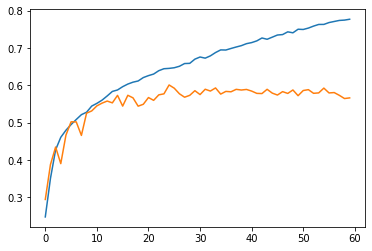

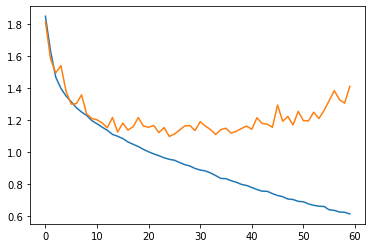

In [27]:
plt.plot([[k[2], k[3]]for k in hist])
plt.show()

plt.plot([[k[0], k[1]]for k in hist])
plt.show()

In [29]:
import pickle
pickle.dump(hist, open('/tf/data/Quan/fer2013/att_vgg_bottleneck_3_hist.hdf5', 'wb'))

In [26]:
best_acc

0.6013827434683268

In [5]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()
        
        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
#         self.feature_size = kwargs['feature_size']

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv0 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1, padding=0, stride=1)
        self.conv1 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.preconv4 = nn.Conv2d(3*nb_neurons, nb_neurons, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.convout = nn.Conv2d(4*nb_neurons, nb_neurons, kernel_size=1, stride=1, padding=0)
        self.bnout = nn.BatchNorm2d(nb_neurons)
        
        
        self.wf12_3 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf12_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf12_out = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf13_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf13_out = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf23_4 = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf23_out = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        self.wf34_out = WeightFeature(nb_neurons, nb_neurons).to(self.device)
        
        self.bn0 = nn.BatchNorm2d(nb_neurons)
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        self.prebn4 = nn.BatchNorm2d(nb_neurons)
        self.bn4 = nn.BatchNorm2d(nb_neurons)
        self.relu = nn.ReLU()

        
    def forward(self, x):
        '''
        x: single output layer of list 
        '''

        x = torch.cat(x, dim=1) if type(x) is list else x
        
        # 0 th (identity conv)
        x0 = self.conv0(x)
        x0 = self.bn0(x0)
        x0 = self.relu(x0)

        # 1st
        x1 = self.conv1(x0)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = self.relu(x2)
        
        # 1,2 -> 3
        x12_3 = self.wf12_3(x1, x2)
        x12_3 = x12_3 + x2
        
        # 3rd
        x3 = self.conv3(x12_3)
        x3 = self.bn3(x3)
        x3 = self.relu(x3)
        
        # 1,2 -> 4
        # 1,3 -> 4
        # 2,3 -> 4
        x12_4 = self.wf12_4(x1, x2)
        x13_4 = self.wf13_4(x1, x3)
        x23_4 = self.wf23_4(x2, x3)
        
        # 4th
        x4 = torch.cat([x12_4, x13_4, x23_4], dim=1)
        
        x4 = self.preconv4(x4)
        x4 = self.prebn4(x4)
        x4 = self.relu(x4)
        
        x4 = x4 + x3
        
        x4 = self.conv4(x4)
        x4 = self.bn4(x4)
        x4 = self.relu(x4)
        
        # 1,2 -> out
        # 1,3 -> out
        # 2,3 -> out
        # 3,4 -> out
        x12_out = self.wf12_out(x1,x2)
        x13_out = self.wf13_out(x1,x3)
        x23_out = self.wf23_out(x2,x3)
        x34_out = self.wf34_out(x3,x4)
        
        # x_out
        x_out = torch.cat([x12_out, x12_out, x23_out, x34_out], dim=1)
        x_out = self.convout(x_out)
        x_out = self.bnout(x_out)
        x_out = self.relu(x_out)
        
        x_out = x_out + x4

        return x_out

In [6]:
class SVGG(nn.Module):

    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1,128).to(self.device)
#         self.sv1 = SVblock(128, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
#         self.sv3 = SVblock(256, 256).to(self.device)
        self.sv4 = SVblock(256, 512).to(self.device)
#         self.sv5 = SVblock(512, 512).to(self.device)  


        self.fc1 = nn.Linear(512, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 7)
        self.bn2 = nn.BatchNorm1d(7)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x0 = self.sv0(x)
#         x1 = self.sv1(x0)
        
        x1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x0)
        
        x2 = self.sv2(x1)
#         x3 = self.sv3(x2)
        
        x3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x2)
        
        x4 = self.sv4(x3)
#         x5 = self.sv5(x4)
        x5 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x4)
        
        x5 = nn.AvgPool2d(kernel_size=(x5.size(-2), x5.size(-1)))(x5)
        x_out = nn.Flatten()(x5)

        x_out = self.fc1(x_out)
        x_out = self.bn1(x_out)
        x_out = self.fc2(x_out)
        x_out = self.bn2(x_out)

        return x_out


In [7]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# model.train()

# model = model.to(device)

cuda


In [8]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_bottleneck_3b.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
       
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1
	 - Step 1: loss: 2.267 acc: 0.094
	 - Step 2: loss: 2.545 acc: 0.109
	 - Step 3: loss: 2.265 acc: 0.250
	 - Step 4: loss: 2.154 acc: 0.203
	 - Step 5: loss: 2.199 acc: 0.234
	 - Step 6: loss: 2.034 acc: 0.172
	 - Step 7: loss: 2.231 acc: 0.172
	 - Step 8: loss: 1.956 acc: 0.203
	 - Step 9: loss: 2.024 acc: 0.266
	 - Step 10: loss: 2.190 acc: 0.172
	 - Step 11: loss: 2.110 acc: 0.188
	 - Step 12: loss: 2.044 acc: 0.297
	 - Step 13: loss: 2.086 acc: 0.266
	 - Step 14: loss: 1.925 acc: 0.297
	 - Step 15: loss: 2.004 acc: 0.250
	 - Step 16: loss: 2.133 acc: 0.328
	 - Step 17: loss: 2.175 acc: 0.250
	 - Step 18: loss: 2.163 acc: 0.203
	 - Step 19: loss: 1.915 acc: 0.219
	 - Step 20: loss: 1.980 acc: 0.172
	 - Step 21: loss: 1.964 acc: 0.188
	 - Step 22: loss: 1.841 acc: 0.281
	 - Step 23: loss: 2.137 acc: 0.172
	 - Step 24: loss: 2.101 acc: 0.203
	 - Step 25: loss: 1.916 acc: 0.125
	 - Step 26: loss: 2.172 acc: 0.234
	 - Step 27: loss: 2.062 acc: 0.266
	 - Step 28: loss: 2.156 ac

	 - Step 226: loss: 1.846 acc: 0.219
	 - Step 227: loss: 1.903 acc: 0.266
	 - Step 228: loss: 1.885 acc: 0.266
	 - Step 229: loss: 1.882 acc: 0.172
	 - Step 230: loss: 1.870 acc: 0.219
	 - Step 231: loss: 1.887 acc: 0.266
	 - Step 232: loss: 1.807 acc: 0.312
	 - Step 233: loss: 1.907 acc: 0.188
	 - Step 234: loss: 1.882 acc: 0.312
	 - Step 235: loss: 1.781 acc: 0.281
	 - Step 236: loss: 1.928 acc: 0.250
	 - Step 237: loss: 1.835 acc: 0.234
	 - Step 238: loss: 1.830 acc: 0.266
	 - Step 239: loss: 1.854 acc: 0.250
	 - Step 240: loss: 1.849 acc: 0.328
	 - Step 241: loss: 1.901 acc: 0.203
	 - Step 242: loss: 1.860 acc: 0.203
	 - Step 243: loss: 1.861 acc: 0.344
	 - Step 244: loss: 1.891 acc: 0.250
	 - Step 245: loss: 1.818 acc: 0.297
	 - Step 246: loss: 1.860 acc: 0.234
	 - Step 247: loss: 1.867 acc: 0.141
	 - Step 248: loss: 1.888 acc: 0.250
	 - Step 249: loss: 1.843 acc: 0.219
	 - Step 250: loss: 1.867 acc: 0.234
	 - Step 251: loss: 1.820 acc: 0.250
	 - Step 252: loss: 1.892 acc: 0.156
	

	 - Step 448: loss: 1.830 acc: 0.234
	 - Step 449: loss: 2.012 acc: 0.189
- Avg.loss: 1.880  | Avg.acc: 0.243


RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 7.79 GiB total capacity; 5.78 GiB already allocated; 57.00 MiB free; 6.13 GiB reserved in total by PyTorch)

In [1]:
import torch

In [13]:
model = torch.load('/tf/data/Quan/fer2013/att_vgg_demo.pt')

In [14]:
model

SVGG(
  (sv0): SVblock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (wf1): WeightFeature(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (wf2): WeightFeature(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=